if you want a good generated picture you have to increase the number of training and the size of photo 
but i did this size becuase iam limited to use the gpu 


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
import os # to access a system file
import matplotlib.pyplot as plt
import matplotlib.image as io # import a matplotlib

Female_lista = []
train_dir_Female = '../input/gender-recognition-200k-images-celeba/Dataset/Test/Female'
men_lista = []
train_dir_men = '../input/gender-recognition-200k-images-celeba/Dataset/Test/Male'
for filename in os.listdir(train_dir_Female):
    filename  = train_dir_Female + '/'+filename
    filename = io.imread(filename)
    Female_lista.append(filename)
print(len(Female_lista))
for filename in os.listdir(train_dir_men):
    filename  = train_dir_men + '/'+filename
    filename = io.imread(filename)
    men_lista.append(filename)
print(len(men_lista))

11542
8459


In [ ]:
import cv2
new_lista_Female = []
new_lista_men = []
for i in Female_lista:
    i = cv2.resize(i, (32,32),interpolation = cv2.INTER_CUBIC )
    new_lista_Female.append(i)
for i in men_lista:
    i = cv2.resize(i, (32,32),interpolation = cv2.INTER_CUBIC )
    new_lista_men.append(i)


(11542, 32, 32, 3)
(8459, 32, 32, 3)


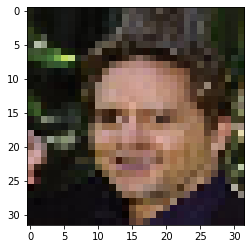

In [ ]:
Female_data = np.array([tuple(row) for row in new_lista_Female])
print(Female_data.shape)
plt.imshow(Female_data[0])
men_data = np.array([tuple(row) for row in new_lista_men])
print(men_data.shape)
plt.imshow(men_data[0])

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.000002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32

	model.add(Conv2DTranspose(512,(4,4),strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
def load_real_samples():
    trainX = Female_data
	# convert from unsigned ints to floats
    X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_Female_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_Female_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/90, d1=0.700, d2=0.693 g=0.693
>1, 2/90, d1=0.697, d2=0.694 g=0.693
>1, 3/90, d1=0.698, d2=0.695 g=0.692
>1, 4/90, d1=0.698, d2=0.696 g=0.690
>1, 5/90, d1=0.697, d2=0.698 g=0.688
>1, 6/90, d1=0.692, d2=0.702 g=0.685
>1, 7/90, d1=0.691, d2=0.707 g=0.680
>1, 8/90, d1=0.689, d2=0.715 g=0.671
>1, 9/90, d1=0.687, d2=0.726 g=0.659
>1, 10/90, d1=0.687, d2=0.742 g=0.645
>1, 11/90, d1=0.690, d2=0.762 g=0.633
>1, 12/90, d1=0.683, d2=0.775 g=0.624
>1, 13/90, d1=0.689, d2=0.784 g=0.614
>1, 14/90, d1=0.685, d2=0.790 g=0.607
>1, 15/90, d1=0.684, d2=0.796 g=0.600
>1, 16/90, d1=0.687, d2=0.810 g=0.592
>1, 17/90, d1=0.685, d2=0.812 g=0.588
>1, 18/90, d1=0.682, d2=0.823 g=0.580
>1, 19/90, d1=0.684, d2=0.827 g=0.577
>1, 20/90, d1=0.682, d2=0.832 g=0.570
>1, 21/90, d1=0.683, d2=0.834 g=0.568
>1, 22/90, d1=0.684, d2=0.851 g=0.564
>1, 23/90, d1=0.683, d2=0.851 g=0.562
>1, 24/90, d1=0.679, d2=0.852 g=0.556
>1, 25/90, d1=0.677, d2=0.853 g=0.558
>1, 26/90, d1=0.681, d2=0.861 g=0.555
>1, 27/90, d1=0.683, 

>3, 39/90, d1=0.646, d2=0.600 g=0.794
>3, 40/90, d1=0.643, d2=0.605 g=0.795
>3, 41/90, d1=0.646, d2=0.604 g=0.797
>3, 42/90, d1=0.646, d2=0.604 g=0.795
>3, 43/90, d1=0.641, d2=0.606 g=0.791
>3, 44/90, d1=0.648, d2=0.606 g=0.799
>3, 45/90, d1=0.647, d2=0.606 g=0.793
>3, 46/90, d1=0.640, d2=0.604 g=0.794
>3, 47/90, d1=0.645, d2=0.601 g=0.797
>3, 48/90, d1=0.647, d2=0.599 g=0.793
>3, 49/90, d1=0.648, d2=0.604 g=0.795
>3, 50/90, d1=0.643, d2=0.601 g=0.797
>3, 51/90, d1=0.648, d2=0.604 g=0.799
>3, 52/90, d1=0.643, d2=0.603 g=0.798
>3, 53/90, d1=0.640, d2=0.601 g=0.799
>3, 54/90, d1=0.643, d2=0.599 g=0.800
>3, 55/90, d1=0.642, d2=0.602 g=0.798
>3, 56/90, d1=0.640, d2=0.602 g=0.796
>3, 57/90, d1=0.645, d2=0.601 g=0.800
>3, 58/90, d1=0.644, d2=0.598 g=0.805
>3, 59/90, d1=0.643, d2=0.595 g=0.804
>3, 60/90, d1=0.642, d2=0.596 g=0.803
>3, 61/90, d1=0.643, d2=0.598 g=0.803
>3, 62/90, d1=0.634, d2=0.596 g=0.804
>3, 63/90, d1=0.639, d2=0.595 g=0.802
>3, 64/90, d1=0.641, d2=0.599 g=0.801
>3, 65/90, d

>5, 77/90, d1=0.597, d2=0.519 g=0.915
>5, 78/90, d1=0.595, d2=0.510 g=0.922
>5, 79/90, d1=0.610, d2=0.514 g=0.920
>5, 80/90, d1=0.595, d2=0.508 g=0.918
>5, 81/90, d1=0.603, d2=0.513 g=0.918
>5, 82/90, d1=0.601, d2=0.516 g=0.913
>5, 83/90, d1=0.595, d2=0.517 g=0.917
>5, 84/90, d1=0.585, d2=0.515 g=0.917
>5, 85/90, d1=0.595, d2=0.518 g=0.910
>5, 86/90, d1=0.587, d2=0.520 g=0.911
>5, 87/90, d1=0.603, d2=0.521 g=0.908
>5, 88/90, d1=0.591, d2=0.513 g=0.915
>5, 89/90, d1=0.591, d2=0.512 g=0.917
>5, 90/90, d1=0.583, d2=0.512 g=0.927
>6, 1/90, d1=0.601, d2=0.511 g=0.923
>6, 2/90, d1=0.585, d2=0.509 g=0.925
>6, 3/90, d1=0.586, d2=0.518 g=0.921
>6, 4/90, d1=0.600, d2=0.516 g=0.922
>6, 5/90, d1=0.585, d2=0.509 g=0.930
>6, 6/90, d1=0.598, d2=0.506 g=0.932
>6, 7/90, d1=0.589, d2=0.499 g=0.931
>6, 8/90, d1=0.587, d2=0.503 g=0.939
>6, 9/90, d1=0.588, d2=0.497 g=0.939
>6, 10/90, d1=0.607, d2=0.500 g=0.943
>6, 11/90, d1=0.587, d2=0.497 g=0.948
>6, 12/90, d1=0.585, d2=0.493 g=0.954
>6, 13/90, d1=0.592, 

>8, 25/90, d1=0.552, d2=0.604 g=0.806
>8, 26/90, d1=0.560, d2=0.615 g=0.798
>8, 27/90, d1=0.561, d2=0.644 g=0.760
>8, 28/90, d1=0.562, d2=0.673 g=0.730
>8, 29/90, d1=0.570, d2=0.694 g=0.700
>8, 30/90, d1=0.591, d2=0.732 g=0.665
>8, 31/90, d1=0.587, d2=0.727 g=0.664
>8, 32/90, d1=0.575, d2=0.729 g=0.677
>8, 33/90, d1=0.571, d2=0.717 g=0.687
>8, 34/90, d1=0.566, d2=0.707 g=0.701
>8, 35/90, d1=0.580, d2=0.689 g=0.706
>8, 36/90, d1=0.562, d2=0.689 g=0.727
>8, 37/90, d1=0.593, d2=0.681 g=0.732
>8, 38/90, d1=0.619, d2=0.651 g=0.747
>8, 39/90, d1=0.591, d2=0.640 g=0.765
>8, 40/90, d1=0.610, d2=0.628 g=0.777
>8, 41/90, d1=0.610, d2=0.619 g=0.784
>8, 42/90, d1=0.589, d2=0.617 g=0.798
>8, 43/90, d1=0.591, d2=0.599 g=0.802
>8, 44/90, d1=0.604, d2=0.588 g=0.825
>8, 45/90, d1=0.608, d2=0.577 g=0.830
>8, 46/90, d1=0.608, d2=0.567 g=0.844
>8, 47/90, d1=0.602, d2=0.567 g=0.852
>8, 48/90, d1=0.599, d2=0.559 g=0.862
>8, 49/90, d1=0.610, d2=0.546 g=0.884
>8, 50/90, d1=0.606, d2=0.555 g=0.879
>8, 51/90, d

>10, 61/90, d1=0.646, d2=0.640 g=0.764
>10, 62/90, d1=0.670, d2=0.632 g=0.751
>10, 63/90, d1=0.670, d2=0.647 g=0.745
>10, 64/90, d1=0.655, d2=0.644 g=0.750
>10, 65/90, d1=0.638, d2=0.662 g=0.744
>10, 66/90, d1=0.654, d2=0.647 g=0.753
>10, 67/90, d1=0.661, d2=0.661 g=0.753
>10, 68/90, d1=0.644, d2=0.659 g=0.729
>10, 69/90, d1=0.667, d2=0.670 g=0.724
>10, 70/90, d1=0.656, d2=0.690 g=0.716
>10, 71/90, d1=0.654, d2=0.679 g=0.721
>10, 72/90, d1=0.671, d2=0.684 g=0.711
>10, 73/90, d1=0.653, d2=0.676 g=0.707
>10, 74/90, d1=0.661, d2=0.689 g=0.715
>10, 75/90, d1=0.656, d2=0.696 g=0.709
>10, 76/90, d1=0.644, d2=0.694 g=0.706
>10, 77/90, d1=0.685, d2=0.687 g=0.698
>10, 78/90, d1=0.659, d2=0.691 g=0.712
>10, 79/90, d1=0.647, d2=0.688 g=0.713
>10, 80/90, d1=0.630, d2=0.675 g=0.717
>10, 81/90, d1=0.653, d2=0.684 g=0.728
>10, 82/90, d1=0.664, d2=0.674 g=0.729
>10, 83/90, d1=0.654, d2=0.669 g=0.734
>10, 84/90, d1=0.637, d2=0.665 g=0.739
>10, 85/90, d1=0.664, d2=0.644 g=0.740
>10, 86/90, d1=0.671, d2=

>13, 1/90, d1=0.941, d2=0.676 g=0.717
>13, 2/90, d1=0.942, d2=0.686 g=0.706
>13, 3/90, d1=0.939, d2=0.699 g=0.692
>13, 4/90, d1=0.994, d2=0.704 g=0.689
>13, 5/90, d1=0.957, d2=0.705 g=0.692
>13, 6/90, d1=0.944, d2=0.700 g=0.687
>13, 7/90, d1=0.944, d2=0.706 g=0.690
>13, 8/90, d1=0.928, d2=0.714 g=0.693
>13, 9/90, d1=0.967, d2=0.698 g=0.690
>13, 10/90, d1=0.939, d2=0.707 g=0.693
>13, 11/90, d1=0.932, d2=0.702 g=0.690
>13, 12/90, d1=0.964, d2=0.703 g=0.681
>13, 13/90, d1=0.971, d2=0.711 g=0.687
>13, 14/90, d1=0.958, d2=0.710 g=0.679
>13, 15/90, d1=0.953, d2=0.717 g=0.681
>13, 16/90, d1=0.945, d2=0.701 g=0.684
>13, 17/90, d1=0.944, d2=0.709 g=0.684
>13, 18/90, d1=0.968, d2=0.700 g=0.687
>13, 19/90, d1=0.932, d2=0.716 g=0.689
>13, 20/90, d1=0.962, d2=0.709 g=0.676
>13, 21/90, d1=0.968, d2=0.718 g=0.677
>13, 22/90, d1=0.967, d2=0.715 g=0.672
>13, 23/90, d1=0.942, d2=0.729 g=0.669
>13, 24/90, d1=0.948, d2=0.724 g=0.666
>13, 25/90, d1=0.954, d2=0.724 g=0.666
>13, 26/90, d1=0.959, d2=0.730 g=0

>15, 32/90, d1=0.905, d2=0.759 g=0.632
>15, 33/90, d1=0.914, d2=0.764 g=0.628
>15, 34/90, d1=0.895, d2=0.765 g=0.630
>15, 35/90, d1=0.890, d2=0.760 g=0.630
>15, 36/90, d1=0.894, d2=0.758 g=0.633
>15, 37/90, d1=0.904, d2=0.756 g=0.635
>15, 38/90, d1=0.917, d2=0.764 g=0.636
>15, 39/90, d1=0.898, d2=0.756 g=0.635
>15, 40/90, d1=0.902, d2=0.760 g=0.637
>15, 41/90, d1=0.922, d2=0.758 g=0.638
>15, 42/90, d1=0.908, d2=0.751 g=0.639
>15, 43/90, d1=0.918, d2=0.760 g=0.634
>15, 44/90, d1=0.912, d2=0.760 g=0.631
>15, 45/90, d1=0.914, d2=0.762 g=0.631
>15, 46/90, d1=0.893, d2=0.760 g=0.631
>15, 47/90, d1=0.898, d2=0.754 g=0.634
>15, 48/90, d1=0.899, d2=0.756 g=0.637
>15, 49/90, d1=0.905, d2=0.753 g=0.639
>15, 50/90, d1=0.907, d2=0.758 g=0.640
>15, 51/90, d1=0.913, d2=0.756 g=0.636
>15, 52/90, d1=0.887, d2=0.757 g=0.634
>15, 53/90, d1=0.888, d2=0.754 g=0.638
>15, 54/90, d1=0.907, d2=0.758 g=0.637
>15, 55/90, d1=0.901, d2=0.751 g=0.630
>15, 56/90, d1=0.906, d2=0.753 g=0.640
>15, 57/90, d1=0.880, d2=

>17, 63/90, d1=0.777, d2=0.754 g=0.641
>17, 64/90, d1=0.762, d2=0.750 g=0.641
>17, 65/90, d1=0.776, d2=0.746 g=0.643
>17, 66/90, d1=0.788, d2=0.745 g=0.644
>17, 67/90, d1=0.763, d2=0.751 g=0.645
>17, 68/90, d1=0.795, d2=0.750 g=0.642
>17, 69/90, d1=0.775, d2=0.753 g=0.640
>17, 70/90, d1=0.791, d2=0.752 g=0.639
>17, 71/90, d1=0.765, d2=0.746 g=0.639
>17, 72/90, d1=0.761, d2=0.747 g=0.643
>17, 73/90, d1=0.772, d2=0.746 g=0.640
>17, 74/90, d1=0.784, d2=0.742 g=0.645
>17, 75/90, d1=0.760, d2=0.750 g=0.642
>17, 76/90, d1=0.767, d2=0.750 g=0.639
>17, 77/90, d1=0.778, d2=0.744 g=0.640
>17, 78/90, d1=0.768, d2=0.754 g=0.638
>17, 79/90, d1=0.774, d2=0.756 g=0.638
>17, 80/90, d1=0.779, d2=0.754 g=0.636
>17, 81/90, d1=0.766, d2=0.762 g=0.639
>17, 82/90, d1=0.768, d2=0.758 g=0.637
>17, 83/90, d1=0.759, d2=0.752 g=0.639
>17, 84/90, d1=0.752, d2=0.760 g=0.638
>17, 85/90, d1=0.759, d2=0.758 g=0.633
>17, 86/90, d1=0.777, d2=0.758 g=0.635
>17, 87/90, d1=0.765, d2=0.763 g=0.634
>17, 88/90, d1=0.790, d2=

>20, 5/90, d1=0.845, d2=0.786 g=0.613
>20, 6/90, d1=0.850, d2=0.778 g=0.608
>20, 7/90, d1=0.850, d2=0.780 g=0.615
>20, 8/90, d1=0.862, d2=0.773 g=0.617
>20, 9/90, d1=0.853, d2=0.779 g=0.617
>20, 10/90, d1=0.861, d2=0.780 g=0.615
>20, 11/90, d1=0.846, d2=0.783 g=0.614
>20, 12/90, d1=0.857, d2=0.780 g=0.615
>20, 13/90, d1=0.858, d2=0.773 g=0.614
>20, 14/90, d1=0.860, d2=0.777 g=0.612
>20, 15/90, d1=0.844, d2=0.775 g=0.616
>20, 16/90, d1=0.858, d2=0.778 g=0.621
>20, 17/90, d1=0.861, d2=0.771 g=0.623
>20, 18/90, d1=0.861, d2=0.772 g=0.624
>20, 19/90, d1=0.858, d2=0.774 g=0.619
>20, 20/90, d1=0.850, d2=0.777 g=0.620
>20, 21/90, d1=0.846, d2=0.774 g=0.619
>20, 22/90, d1=0.849, d2=0.773 g=0.620
>20, 23/90, d1=0.848, d2=0.777 g=0.620
>20, 24/90, d1=0.859, d2=0.776 g=0.617
>20, 25/90, d1=0.854, d2=0.771 g=0.621
>20, 26/90, d1=0.854, d2=0.767 g=0.624
>20, 27/90, d1=0.840, d2=0.770 g=0.625
>20, 28/90, d1=0.853, d2=0.769 g=0.625
>20, 29/90, d1=0.850, d2=0.777 g=0.624
>20, 30/90, d1=0.859, d2=0.774

>22, 35/90, d1=0.779, d2=0.732 g=0.655
>22, 36/90, d1=0.782, d2=0.729 g=0.656
>22, 37/90, d1=0.789, d2=0.728 g=0.658
>22, 38/90, d1=0.794, d2=0.728 g=0.660
>22, 39/90, d1=0.771, d2=0.726 g=0.661
>22, 40/90, d1=0.790, d2=0.732 g=0.657
>22, 41/90, d1=0.783, d2=0.734 g=0.656
>22, 42/90, d1=0.786, d2=0.732 g=0.658
>22, 43/90, d1=0.774, d2=0.732 g=0.657
>22, 44/90, d1=0.787, d2=0.732 g=0.655
>22, 45/90, d1=0.780, d2=0.733 g=0.658
>22, 46/90, d1=0.778, d2=0.736 g=0.658
>22, 47/90, d1=0.775, d2=0.735 g=0.657
>22, 48/90, d1=0.792, d2=0.735 g=0.656
>22, 49/90, d1=0.775, d2=0.731 g=0.655
>22, 50/90, d1=0.780, d2=0.732 g=0.655
>22, 51/90, d1=0.781, d2=0.734 g=0.653
>22, 52/90, d1=0.763, d2=0.732 g=0.653
>22, 53/90, d1=0.780, d2=0.739 g=0.652
>22, 54/90, d1=0.761, d2=0.740 g=0.651
>22, 55/90, d1=0.775, d2=0.741 g=0.652
>22, 56/90, d1=0.788, d2=0.733 g=0.655
>22, 57/90, d1=0.768, d2=0.736 g=0.655
>22, 58/90, d1=0.784, d2=0.737 g=0.653
>22, 59/90, d1=0.762, d2=0.735 g=0.653
>22, 60/90, d1=0.754, d2=

>24, 66/90, d1=0.796, d2=0.799 g=0.604
>24, 67/90, d1=0.777, d2=0.795 g=0.605
>24, 68/90, d1=0.787, d2=0.798 g=0.606
>24, 69/90, d1=0.788, d2=0.800 g=0.601
>24, 70/90, d1=0.785, d2=0.799 g=0.601
>24, 71/90, d1=0.778, d2=0.790 g=0.599
>24, 72/90, d1=0.790, d2=0.804 g=0.600
>24, 73/90, d1=0.800, d2=0.808 g=0.601
>24, 74/90, d1=0.795, d2=0.784 g=0.607
>24, 75/90, d1=0.790, d2=0.786 g=0.612
>24, 76/90, d1=0.785, d2=0.777 g=0.614
>24, 77/90, d1=0.793, d2=0.787 g=0.611
>24, 78/90, d1=0.789, d2=0.787 g=0.609
>24, 79/90, d1=0.775, d2=0.791 g=0.613
>24, 80/90, d1=0.784, d2=0.786 g=0.616
>24, 81/90, d1=0.793, d2=0.774 g=0.621
>24, 82/90, d1=0.795, d2=0.773 g=0.621
>24, 83/90, d1=0.785, d2=0.776 g=0.619
>24, 84/90, d1=0.794, d2=0.772 g=0.619
>24, 85/90, d1=0.786, d2=0.772 g=0.621
>24, 86/90, d1=0.784, d2=0.777 g=0.622
>24, 87/90, d1=0.794, d2=0.782 g=0.620
>24, 88/90, d1=0.805, d2=0.774 g=0.622
>24, 89/90, d1=0.800, d2=0.765 g=0.627
>24, 90/90, d1=0.795, d2=0.765 g=0.631
>25, 1/90, d1=0.788, d2=0

>27, 7/90, d1=0.758, d2=0.779 g=0.616
>27, 8/90, d1=0.762, d2=0.784 g=0.613
>27, 9/90, d1=0.746, d2=0.781 g=0.614
>27, 10/90, d1=0.760, d2=0.786 g=0.617
>27, 11/90, d1=0.743, d2=0.779 g=0.616
>27, 12/90, d1=0.754, d2=0.782 g=0.618
>27, 13/90, d1=0.744, d2=0.784 g=0.616
>27, 14/90, d1=0.765, d2=0.775 g=0.613
>27, 15/90, d1=0.754, d2=0.780 g=0.616
>27, 16/90, d1=0.763, d2=0.782 g=0.620
>27, 17/90, d1=0.755, d2=0.777 g=0.615
>27, 18/90, d1=0.760, d2=0.780 g=0.616
>27, 19/90, d1=0.783, d2=0.774 g=0.620
>27, 20/90, d1=0.759, d2=0.771 g=0.623
>27, 21/90, d1=0.761, d2=0.774 g=0.626
>27, 22/90, d1=0.765, d2=0.776 g=0.621
>27, 23/90, d1=0.762, d2=0.778 g=0.623
>27, 24/90, d1=0.769, d2=0.777 g=0.620
>27, 25/90, d1=0.761, d2=0.767 g=0.626
>27, 26/90, d1=0.769, d2=0.769 g=0.627
>27, 27/90, d1=0.772, d2=0.766 g=0.630
>27, 28/90, d1=0.775, d2=0.768 g=0.628
>27, 29/90, d1=0.770, d2=0.769 g=0.629
>27, 30/90, d1=0.782, d2=0.761 g=0.628
>27, 31/90, d1=0.777, d2=0.767 g=0.631
>27, 32/90, d1=0.775, d2=0.7

>29, 38/90, d1=0.797, d2=0.703 g=0.690
>29, 39/90, d1=0.807, d2=0.699 g=0.683
>29, 40/90, d1=0.816, d2=0.709 g=0.683
>29, 41/90, d1=0.813, d2=0.705 g=0.683
>29, 42/90, d1=0.811, d2=0.705 g=0.682
>29, 43/90, d1=0.806, d2=0.703 g=0.686
>29, 44/90, d1=0.819, d2=0.700 g=0.688
>29, 45/90, d1=0.811, d2=0.698 g=0.690
>29, 46/90, d1=0.821, d2=0.701 g=0.686
>29, 47/90, d1=0.800, d2=0.700 g=0.688
>29, 48/90, d1=0.809, d2=0.705 g=0.688
>29, 49/90, d1=0.801, d2=0.705 g=0.681
>29, 50/90, d1=0.811, d2=0.701 g=0.685
>29, 51/90, d1=0.819, d2=0.702 g=0.685
>29, 52/90, d1=0.805, d2=0.704 g=0.686
>29, 53/90, d1=0.806, d2=0.701 g=0.690
>29, 54/90, d1=0.805, d2=0.695 g=0.694
>29, 55/90, d1=0.807, d2=0.701 g=0.685
>29, 56/90, d1=0.810, d2=0.705 g=0.684
>29, 57/90, d1=0.797, d2=0.705 g=0.684
>29, 58/90, d1=0.798, d2=0.707 g=0.685
>29, 59/90, d1=0.804, d2=0.705 g=0.682
>29, 60/90, d1=0.803, d2=0.705 g=0.684
>29, 61/90, d1=0.794, d2=0.703 g=0.688
>29, 62/90, d1=0.810, d2=0.700 g=0.687
>29, 63/90, d1=0.795, d2=

>31, 69/90, d1=0.716, d2=0.744 g=0.649
>31, 70/90, d1=0.730, d2=0.739 g=0.649
>31, 71/90, d1=0.724, d2=0.739 g=0.649
>31, 72/90, d1=0.704, d2=0.741 g=0.647
>31, 73/90, d1=0.732, d2=0.745 g=0.652
>31, 74/90, d1=0.731, d2=0.737 g=0.652
>31, 75/90, d1=0.720, d2=0.737 g=0.650
>31, 76/90, d1=0.726, d2=0.739 g=0.652
>31, 77/90, d1=0.727, d2=0.740 g=0.651
>31, 78/90, d1=0.717, d2=0.742 g=0.647
>31, 79/90, d1=0.719, d2=0.748 g=0.645
>31, 80/90, d1=0.719, d2=0.745 g=0.648
>31, 81/90, d1=0.733, d2=0.745 g=0.644
>31, 82/90, d1=0.713, d2=0.746 g=0.646
>31, 83/90, d1=0.719, d2=0.748 g=0.642
>31, 84/90, d1=0.726, d2=0.749 g=0.644
>31, 85/90, d1=0.722, d2=0.752 g=0.637
>31, 86/90, d1=0.726, d2=0.749 g=0.639
>31, 87/90, d1=0.720, d2=0.753 g=0.637
>31, 88/90, d1=0.727, d2=0.757 g=0.637
>31, 89/90, d1=0.722, d2=0.754 g=0.635
>31, 90/90, d1=0.727, d2=0.754 g=0.636
>32, 1/90, d1=0.726, d2=0.759 g=0.633
>32, 2/90, d1=0.725, d2=0.758 g=0.631
>32, 3/90, d1=0.709, d2=0.765 g=0.631
>32, 4/90, d1=0.722, d2=0.76

>34, 11/90, d1=0.780, d2=0.730 g=0.661
>34, 12/90, d1=0.757, d2=0.733 g=0.660
>34, 13/90, d1=0.776, d2=0.736 g=0.658
>34, 14/90, d1=0.771, d2=0.736 g=0.654
>34, 15/90, d1=0.769, d2=0.729 g=0.657
>34, 16/90, d1=0.779, d2=0.732 g=0.660
>34, 17/90, d1=0.776, d2=0.727 g=0.660
>34, 18/90, d1=0.785, d2=0.739 g=0.654
>34, 19/90, d1=0.786, d2=0.736 g=0.653
>34, 20/90, d1=0.773, d2=0.735 g=0.649
>34, 21/90, d1=0.768, d2=0.737 g=0.654
>34, 22/90, d1=0.763, d2=0.735 g=0.654
>34, 23/90, d1=0.774, d2=0.735 g=0.655
>34, 24/90, d1=0.774, d2=0.736 g=0.657
>34, 25/90, d1=0.768, d2=0.739 g=0.653
>34, 26/90, d1=0.764, d2=0.738 g=0.657
>34, 27/90, d1=0.775, d2=0.732 g=0.652
>34, 28/90, d1=0.780, d2=0.736 g=0.654
>34, 29/90, d1=0.783, d2=0.736 g=0.655
>34, 30/90, d1=0.772, d2=0.731 g=0.657
>34, 31/90, d1=0.770, d2=0.734 g=0.656
>34, 32/90, d1=0.773, d2=0.736 g=0.657
>34, 33/90, d1=0.773, d2=0.734 g=0.658
>34, 34/90, d1=0.763, d2=0.733 g=0.655
>34, 35/90, d1=0.770, d2=0.732 g=0.653
>34, 36/90, d1=0.782, d2=

>36, 42/90, d1=0.724, d2=0.704 g=0.680
>36, 43/90, d1=0.723, d2=0.704 g=0.681
>36, 44/90, d1=0.714, d2=0.705 g=0.681
>36, 45/90, d1=0.716, d2=0.707 g=0.680
>36, 46/90, d1=0.708, d2=0.705 g=0.681
>36, 47/90, d1=0.709, d2=0.706 g=0.680
>36, 48/90, d1=0.715, d2=0.704 g=0.681
>36, 49/90, d1=0.709, d2=0.710 g=0.678
>36, 50/90, d1=0.722, d2=0.708 g=0.679
>36, 51/90, d1=0.706, d2=0.707 g=0.678
>36, 52/90, d1=0.703, d2=0.709 g=0.676
>36, 53/90, d1=0.712, d2=0.709 g=0.678
>36, 54/90, d1=0.713, d2=0.709 g=0.677
>36, 55/90, d1=0.723, d2=0.712 g=0.676
>36, 56/90, d1=0.715, d2=0.714 g=0.676
>36, 57/90, d1=0.704, d2=0.711 g=0.677
>36, 58/90, d1=0.723, d2=0.713 g=0.676
>36, 59/90, d1=0.714, d2=0.715 g=0.678
>36, 60/90, d1=0.712, d2=0.714 g=0.674
>36, 61/90, d1=0.708, d2=0.712 g=0.673
>36, 62/90, d1=0.709, d2=0.715 g=0.674
>36, 63/90, d1=0.713, d2=0.715 g=0.672
>36, 64/90, d1=0.713, d2=0.713 g=0.672
>36, 65/90, d1=0.705, d2=0.714 g=0.673
>36, 66/90, d1=0.708, d2=0.715 g=0.672
>36, 67/90, d1=0.702, d2=

>38, 74/90, d1=0.748, d2=0.763 g=0.631
>38, 75/90, d1=0.739, d2=0.770 g=0.626
>38, 76/90, d1=0.749, d2=0.771 g=0.621
>38, 77/90, d1=0.731, d2=0.787 g=0.614
>38, 78/90, d1=0.739, d2=0.790 g=0.610
>38, 79/90, d1=0.746, d2=0.790 g=0.608
>38, 80/90, d1=0.738, d2=0.791 g=0.605
>38, 81/90, d1=0.738, d2=0.788 g=0.608
>38, 82/90, d1=0.742, d2=0.792 g=0.609
>38, 83/90, d1=0.744, d2=0.800 g=0.609
>38, 84/90, d1=0.748, d2=0.788 g=0.608
>38, 85/90, d1=0.747, d2=0.785 g=0.613
>38, 86/90, d1=0.750, d2=0.789 g=0.607
>38, 87/90, d1=0.755, d2=0.783 g=0.614
>38, 88/90, d1=0.753, d2=0.788 g=0.613
>38, 89/90, d1=0.749, d2=0.778 g=0.616
>38, 90/90, d1=0.752, d2=0.781 g=0.618
>39, 1/90, d1=0.752, d2=0.775 g=0.621
>39, 2/90, d1=0.744, d2=0.779 g=0.618
>39, 3/90, d1=0.756, d2=0.772 g=0.624
>39, 4/90, d1=0.763, d2=0.768 g=0.625
>39, 5/90, d1=0.758, d2=0.767 g=0.630
>39, 6/90, d1=0.762, d2=0.760 g=0.634
>39, 7/90, d1=0.761, d2=0.758 g=0.637
>39, 8/90, d1=0.750, d2=0.756 g=0.639
>39, 9/90, d1=0.762, d2=0.752 g=0

>41, 15/90, d1=0.767, d2=0.721 g=0.667
>41, 16/90, d1=0.770, d2=0.723 g=0.669
>41, 17/90, d1=0.769, d2=0.720 g=0.666
>41, 18/90, d1=0.768, d2=0.717 g=0.671
>41, 19/90, d1=0.765, d2=0.714 g=0.676
>41, 20/90, d1=0.783, d2=0.716 g=0.674
>41, 21/90, d1=0.761, d2=0.717 g=0.673
>41, 22/90, d1=0.765, d2=0.718 g=0.672
>41, 23/90, d1=0.774, d2=0.719 g=0.671
>41, 24/90, d1=0.767, d2=0.721 g=0.671
>41, 25/90, d1=0.765, d2=0.717 g=0.673
>41, 26/90, d1=0.781, d2=0.716 g=0.671
>41, 27/90, d1=0.770, d2=0.713 g=0.674
>41, 28/90, d1=0.780, d2=0.713 g=0.676
>41, 29/90, d1=0.767, d2=0.708 g=0.677
>41, 30/90, d1=0.774, d2=0.708 g=0.680
>41, 31/90, d1=0.765, d2=0.704 g=0.681
>41, 32/90, d1=0.769, d2=0.712 g=0.678
>41, 33/90, d1=0.773, d2=0.712 g=0.678
>41, 34/90, d1=0.775, d2=0.709 g=0.674
>41, 35/90, d1=0.782, d2=0.710 g=0.677
>41, 36/90, d1=0.775, d2=0.712 g=0.680
>41, 37/90, d1=0.774, d2=0.707 g=0.681
>41, 38/90, d1=0.771, d2=0.707 g=0.681
>41, 39/90, d1=0.772, d2=0.707 g=0.682
>41, 40/90, d1=0.778, d2=

>43, 46/90, d1=0.767, d2=0.710 g=0.682
>43, 47/90, d1=0.756, d2=0.707 g=0.683
>43, 48/90, d1=0.755, d2=0.706 g=0.680
>43, 49/90, d1=0.764, d2=0.705 g=0.681
>43, 50/90, d1=0.760, d2=0.705 g=0.680
>43, 51/90, d1=0.754, d2=0.706 g=0.681
>43, 52/90, d1=0.761, d2=0.706 g=0.681
>43, 53/90, d1=0.760, d2=0.706 g=0.681
>43, 54/90, d1=0.767, d2=0.707 g=0.683
>43, 55/90, d1=0.748, d2=0.701 g=0.686
>43, 56/90, d1=0.753, d2=0.701 g=0.685
>43, 57/90, d1=0.755, d2=0.704 g=0.684
>43, 58/90, d1=0.761, d2=0.704 g=0.683
>43, 59/90, d1=0.760, d2=0.706 g=0.683
>43, 60/90, d1=0.760, d2=0.706 g=0.681
>43, 61/90, d1=0.757, d2=0.707 g=0.683
>43, 62/90, d1=0.750, d2=0.703 g=0.683
>43, 63/90, d1=0.756, d2=0.703 g=0.686
>43, 64/90, d1=0.755, d2=0.702 g=0.685
>43, 65/90, d1=0.750, d2=0.702 g=0.685
>43, 66/90, d1=0.756, d2=0.704 g=0.688
>43, 67/90, d1=0.750, d2=0.702 g=0.684
>43, 68/90, d1=0.751, d2=0.703 g=0.685
>43, 69/90, d1=0.757, d2=0.705 g=0.685
>43, 70/90, d1=0.765, d2=0.704 g=0.685
>43, 71/90, d1=0.752, d2=

>45, 78/90, d1=0.691, d2=0.714 g=0.671
>45, 79/90, d1=0.692, d2=0.719 g=0.671
>45, 80/90, d1=0.699, d2=0.718 g=0.672
>45, 81/90, d1=0.688, d2=0.718 g=0.670
>45, 82/90, d1=0.684, d2=0.720 g=0.670
>45, 83/90, d1=0.689, d2=0.717 g=0.668
>45, 84/90, d1=0.691, d2=0.721 g=0.668
>45, 85/90, d1=0.679, d2=0.720 g=0.666
>45, 86/90, d1=0.691, d2=0.720 g=0.666
>45, 87/90, d1=0.681, d2=0.722 g=0.665
>45, 88/90, d1=0.686, d2=0.724 g=0.665
>45, 89/90, d1=0.686, d2=0.721 g=0.665
>45, 90/90, d1=0.694, d2=0.722 g=0.664
>46, 1/90, d1=0.681, d2=0.724 g=0.664
>46, 2/90, d1=0.683, d2=0.727 g=0.662
>46, 3/90, d1=0.682, d2=0.722 g=0.663
>46, 4/90, d1=0.682, d2=0.727 g=0.664
>46, 5/90, d1=0.678, d2=0.727 g=0.661
>46, 6/90, d1=0.674, d2=0.732 g=0.662
>46, 7/90, d1=0.682, d2=0.730 g=0.658
>46, 8/90, d1=0.676, d2=0.730 g=0.657
>46, 9/90, d1=0.678, d2=0.730 g=0.657
>46, 10/90, d1=0.687, d2=0.733 g=0.657
>46, 11/90, d1=0.681, d2=0.731 g=0.657
>46, 12/90, d1=0.672, d2=0.735 g=0.655
>46, 13/90, d1=0.674, d2=0.732 g=0

>48, 19/90, d1=0.772, d2=0.687 g=0.705
>48, 20/90, d1=0.767, d2=0.687 g=0.702
>48, 21/90, d1=0.769, d2=0.687 g=0.702
>48, 22/90, d1=0.762, d2=0.687 g=0.702
>48, 23/90, d1=0.769, d2=0.683 g=0.702
>48, 24/90, d1=0.758, d2=0.686 g=0.704
>48, 25/90, d1=0.765, d2=0.688 g=0.705
>48, 26/90, d1=0.766, d2=0.685 g=0.705
>48, 27/90, d1=0.765, d2=0.682 g=0.709
>48, 28/90, d1=0.760, d2=0.683 g=0.705
>48, 29/90, d1=0.763, d2=0.686 g=0.703
>48, 30/90, d1=0.769, d2=0.686 g=0.702
>48, 31/90, d1=0.766, d2=0.684 g=0.701
>48, 32/90, d1=0.771, d2=0.685 g=0.702
>48, 33/90, d1=0.772, d2=0.690 g=0.701
>48, 34/90, d1=0.772, d2=0.685 g=0.704
>48, 35/90, d1=0.772, d2=0.685 g=0.701
>48, 36/90, d1=0.771, d2=0.685 g=0.703
>48, 37/90, d1=0.766, d2=0.691 g=0.701
>48, 38/90, d1=0.775, d2=0.687 g=0.700
>48, 39/90, d1=0.763, d2=0.688 g=0.698
>48, 40/90, d1=0.771, d2=0.687 g=0.701
>48, 41/90, d1=0.772, d2=0.687 g=0.701
>48, 42/90, d1=0.775, d2=0.690 g=0.701
>48, 43/90, d1=0.769, d2=0.690 g=0.698
>48, 44/90, d1=0.769, d2=

>50, 51/90, d1=0.738, d2=0.759 g=0.632
>50, 52/90, d1=0.732, d2=0.761 g=0.632
>50, 53/90, d1=0.728, d2=0.764 g=0.631
>50, 54/90, d1=0.727, d2=0.760 g=0.633
>50, 55/90, d1=0.729, d2=0.762 g=0.634
>50, 56/90, d1=0.733, d2=0.762 g=0.634
>50, 57/90, d1=0.742, d2=0.759 g=0.633
>50, 58/90, d1=0.730, d2=0.756 g=0.634
>50, 59/90, d1=0.733, d2=0.762 g=0.634
>50, 60/90, d1=0.728, d2=0.756 g=0.635
>50, 61/90, d1=0.725, d2=0.758 g=0.637
>50, 62/90, d1=0.731, d2=0.755 g=0.637
>50, 63/90, d1=0.728, d2=0.757 g=0.638
>50, 64/90, d1=0.736, d2=0.756 g=0.639
>50, 65/90, d1=0.723, d2=0.749 g=0.642
>50, 66/90, d1=0.726, d2=0.753 g=0.641
>50, 67/90, d1=0.725, d2=0.750 g=0.641
>50, 68/90, d1=0.737, d2=0.750 g=0.644
>50, 69/90, d1=0.730, d2=0.749 g=0.644
>50, 70/90, d1=0.733, d2=0.746 g=0.645
>50, 71/90, d1=0.728, d2=0.743 g=0.646
>50, 72/90, d1=0.728, d2=0.740 g=0.649
>50, 73/90, d1=0.728, d2=0.742 g=0.648
>50, 74/90, d1=0.720, d2=0.740 g=0.649
>50, 75/90, d1=0.731, d2=0.739 g=0.649
>50, 76/90, d1=0.730, d2=

>52, 82/90, d1=0.766, d2=0.679 g=0.708
>52, 83/90, d1=0.773, d2=0.681 g=0.705
>52, 84/90, d1=0.769, d2=0.683 g=0.704
>52, 85/90, d1=0.764, d2=0.688 g=0.702
>52, 86/90, d1=0.756, d2=0.687 g=0.701
>52, 87/90, d1=0.756, d2=0.692 g=0.700
>52, 88/90, d1=0.760, d2=0.690 g=0.695
>52, 89/90, d1=0.749, d2=0.690 g=0.696
>52, 90/90, d1=0.755, d2=0.696 g=0.694
>53, 1/90, d1=0.759, d2=0.695 g=0.692
>53, 2/90, d1=0.761, d2=0.700 g=0.689
>53, 3/90, d1=0.755, d2=0.702 g=0.687
>53, 4/90, d1=0.766, d2=0.702 g=0.686
>53, 5/90, d1=0.757, d2=0.704 g=0.683
>53, 6/90, d1=0.761, d2=0.704 g=0.683
>53, 7/90, d1=0.761, d2=0.705 g=0.679
>53, 8/90, d1=0.736, d2=0.709 g=0.679
>53, 9/90, d1=0.743, d2=0.709 g=0.676
>53, 10/90, d1=0.736, d2=0.712 g=0.676
>53, 11/90, d1=0.756, d2=0.713 g=0.674
>53, 12/90, d1=0.759, d2=0.715 g=0.672
>53, 13/90, d1=0.763, d2=0.715 g=0.672
>53, 14/90, d1=0.744, d2=0.717 g=0.670
>53, 15/90, d1=0.739, d2=0.718 g=0.669
>53, 16/90, d1=0.744, d2=0.724 g=0.664
>53, 17/90, d1=0.750, d2=0.727 g=0

>55, 24/90, d1=0.719, d2=0.747 g=0.641
>55, 25/90, d1=0.712, d2=0.749 g=0.643
>55, 26/90, d1=0.716, d2=0.749 g=0.643
>55, 27/90, d1=0.709, d2=0.750 g=0.641
>55, 28/90, d1=0.718, d2=0.751 g=0.641
>55, 29/90, d1=0.709, d2=0.756 g=0.637
>55, 30/90, d1=0.724, d2=0.754 g=0.638
>55, 31/90, d1=0.708, d2=0.756 g=0.637
>55, 32/90, d1=0.725, d2=0.758 g=0.632
>55, 33/90, d1=0.718, d2=0.761 g=0.631
>55, 34/90, d1=0.712, d2=0.764 g=0.630
>55, 35/90, d1=0.705, d2=0.766 g=0.628
>55, 36/90, d1=0.707, d2=0.769 g=0.623
>55, 37/90, d1=0.710, d2=0.775 g=0.620
>55, 38/90, d1=0.709, d2=0.776 g=0.616
>55, 39/90, d1=0.722, d2=0.781 g=0.613
>55, 40/90, d1=0.706, d2=0.788 g=0.610
>55, 41/90, d1=0.713, d2=0.789 g=0.611
>55, 42/90, d1=0.715, d2=0.789 g=0.611
>55, 43/90, d1=0.712, d2=0.791 g=0.609
>55, 44/90, d1=0.720, d2=0.789 g=0.610
>55, 45/90, d1=0.719, d2=0.794 g=0.611
>55, 46/90, d1=0.725, d2=0.786 g=0.611
>55, 47/90, d1=0.712, d2=0.787 g=0.611
>55, 48/90, d1=0.717, d2=0.783 g=0.612
>55, 49/90, d1=0.724, d2=

>57, 55/90, d1=0.729, d2=0.707 g=0.683
>57, 56/90, d1=0.731, d2=0.703 g=0.684
>57, 57/90, d1=0.725, d2=0.701 g=0.684
>57, 58/90, d1=0.731, d2=0.702 g=0.685
>57, 59/90, d1=0.724, d2=0.698 g=0.690
>57, 60/90, d1=0.724, d2=0.702 g=0.687
>57, 61/90, d1=0.720, d2=0.700 g=0.686
>57, 62/90, d1=0.723, d2=0.702 g=0.686
>57, 63/90, d1=0.726, d2=0.701 g=0.686
>57, 64/90, d1=0.722, d2=0.698 g=0.688
>57, 65/90, d1=0.725, d2=0.700 g=0.688
>57, 66/90, d1=0.725, d2=0.699 g=0.689
>57, 67/90, d1=0.724, d2=0.698 g=0.688
>57, 68/90, d1=0.725, d2=0.699 g=0.689
>57, 69/90, d1=0.729, d2=0.696 g=0.687
>57, 70/90, d1=0.729, d2=0.698 g=0.690
>57, 71/90, d1=0.723, d2=0.697 g=0.690
>57, 72/90, d1=0.734, d2=0.697 g=0.692
>57, 73/90, d1=0.714, d2=0.701 g=0.689
>57, 74/90, d1=0.727, d2=0.700 g=0.690
>57, 75/90, d1=0.730, d2=0.699 g=0.689
>57, 76/90, d1=0.717, d2=0.697 g=0.689
>57, 77/90, d1=0.718, d2=0.695 g=0.691
>57, 78/90, d1=0.722, d2=0.697 g=0.691
>57, 79/90, d1=0.713, d2=0.697 g=0.690
>57, 80/90, d1=0.715, d2=

>59, 87/90, d1=0.713, d2=0.751 g=0.641
>59, 88/90, d1=0.710, d2=0.748 g=0.644
>59, 89/90, d1=0.714, d2=0.743 g=0.648
>59, 90/90, d1=0.718, d2=0.748 g=0.649
>60, 1/90, d1=0.717, d2=0.741 g=0.650
>60, 2/90, d1=0.725, d2=0.734 g=0.656
>60, 3/90, d1=0.713, d2=0.738 g=0.653
>60, 4/90, d1=0.715, d2=0.740 g=0.654
>60, 5/90, d1=0.711, d2=0.737 g=0.654
>60, 6/90, d1=0.724, d2=0.732 g=0.658
>60, 7/90, d1=0.720, d2=0.730 g=0.660
>60, 8/90, d1=0.719, d2=0.733 g=0.658
>60, 9/90, d1=0.719, d2=0.724 g=0.662
>60, 10/90, d1=0.714, d2=0.726 g=0.661
>60, 11/90, d1=0.723, d2=0.730 g=0.663
>60, 12/90, d1=0.721, d2=0.726 g=0.664
>60, 13/90, d1=0.717, d2=0.725 g=0.664
>60, 14/90, d1=0.716, d2=0.720 g=0.671
>60, 15/90, d1=0.722, d2=0.714 g=0.672
>60, 16/90, d1=0.721, d2=0.721 g=0.672
>60, 17/90, d1=0.721, d2=0.720 g=0.672
>60, 18/90, d1=0.720, d2=0.718 g=0.674
>60, 19/90, d1=0.718, d2=0.716 g=0.671
>60, 20/90, d1=0.721, d2=0.720 g=0.673
>60, 21/90, d1=0.725, d2=0.714 g=0.675
>60, 22/90, d1=0.718, d2=0.713 g=0

>62, 28/90, d1=0.746, d2=0.691 g=0.697
>62, 29/90, d1=0.746, d2=0.692 g=0.698
>62, 30/90, d1=0.745, d2=0.687 g=0.699
>62, 31/90, d1=0.739, d2=0.691 g=0.695
>62, 32/90, d1=0.743, d2=0.690 g=0.695
>62, 33/90, d1=0.747, d2=0.692 g=0.695
>62, 34/90, d1=0.746, d2=0.696 g=0.696
>62, 35/90, d1=0.747, d2=0.689 g=0.695
>62, 36/90, d1=0.745, d2=0.694 g=0.695
>62, 37/90, d1=0.740, d2=0.694 g=0.696
>62, 38/90, d1=0.745, d2=0.692 g=0.694
>62, 39/90, d1=0.751, d2=0.693 g=0.694
>62, 40/90, d1=0.744, d2=0.694 g=0.692
>62, 41/90, d1=0.744, d2=0.693 g=0.692
>62, 42/90, d1=0.751, d2=0.691 g=0.695
>62, 43/90, d1=0.742, d2=0.694 g=0.695
>62, 44/90, d1=0.747, d2=0.696 g=0.692
>62, 45/90, d1=0.749, d2=0.699 g=0.692
>62, 46/90, d1=0.749, d2=0.700 g=0.690
>62, 47/90, d1=0.751, d2=0.698 g=0.690
>62, 48/90, d1=0.743, d2=0.699 g=0.691
>62, 49/90, d1=0.748, d2=0.694 g=0.690
>62, 50/90, d1=0.750, d2=0.698 g=0.691
>62, 51/90, d1=0.744, d2=0.698 g=0.689
>62, 52/90, d1=0.749, d2=0.699 g=0.692
>62, 53/90, d1=0.749, d2=

>64, 60/90, d1=0.702, d2=0.723 g=0.668
>64, 61/90, d1=0.701, d2=0.719 g=0.669
>64, 62/90, d1=0.696, d2=0.720 g=0.671
>64, 63/90, d1=0.708, d2=0.719 g=0.669
>64, 64/90, d1=0.695, d2=0.718 g=0.670
>64, 65/90, d1=0.706, d2=0.720 g=0.669
>64, 66/90, d1=0.708, d2=0.724 g=0.667
>64, 67/90, d1=0.702, d2=0.724 g=0.666
>64, 68/90, d1=0.708, d2=0.726 g=0.661
>64, 69/90, d1=0.709, d2=0.727 g=0.663
>64, 70/90, d1=0.708, d2=0.730 g=0.658
>64, 71/90, d1=0.704, d2=0.734 g=0.659
>64, 72/90, d1=0.709, d2=0.736 g=0.657
>64, 73/90, d1=0.705, d2=0.734 g=0.653
>64, 74/90, d1=0.705, d2=0.731 g=0.655
>64, 75/90, d1=0.708, d2=0.738 g=0.654
>64, 76/90, d1=0.703, d2=0.738 g=0.653
>64, 77/90, d1=0.707, d2=0.735 g=0.655
>64, 78/90, d1=0.711, d2=0.738 g=0.657
>64, 79/90, d1=0.716, d2=0.734 g=0.655
>64, 80/90, d1=0.715, d2=0.737 g=0.655
>64, 81/90, d1=0.715, d2=0.734 g=0.656
>64, 82/90, d1=0.714, d2=0.731 g=0.660
>64, 83/90, d1=0.711, d2=0.732 g=0.659
>64, 84/90, d1=0.718, d2=0.728 g=0.661
>64, 85/90, d1=0.708, d2=

>67, 2/90, d1=0.717, d2=0.694 g=0.693
>67, 3/90, d1=0.713, d2=0.695 g=0.694
>67, 4/90, d1=0.716, d2=0.696 g=0.690
>67, 5/90, d1=0.714, d2=0.699 g=0.688
>67, 6/90, d1=0.707, d2=0.696 g=0.689
>67, 7/90, d1=0.717, d2=0.698 g=0.690
>67, 8/90, d1=0.714, d2=0.693 g=0.691
>67, 9/90, d1=0.715, d2=0.697 g=0.690
>67, 10/90, d1=0.705, d2=0.700 g=0.687
>67, 11/90, d1=0.719, d2=0.699 g=0.687
>67, 12/90, d1=0.719, d2=0.701 g=0.686
>67, 13/90, d1=0.710, d2=0.702 g=0.686
>67, 14/90, d1=0.725, d2=0.702 g=0.686
>67, 15/90, d1=0.716, d2=0.703 g=0.685
>67, 16/90, d1=0.699, d2=0.702 g=0.685
>67, 17/90, d1=0.709, d2=0.697 g=0.688
>67, 18/90, d1=0.703, d2=0.699 g=0.688
>67, 19/90, d1=0.713, d2=0.702 g=0.687
>67, 20/90, d1=0.709, d2=0.700 g=0.685
>67, 21/90, d1=0.707, d2=0.704 g=0.683
>67, 22/90, d1=0.704, d2=0.702 g=0.682
>67, 23/90, d1=0.704, d2=0.705 g=0.684
>67, 24/90, d1=0.718, d2=0.704 g=0.683
>67, 25/90, d1=0.710, d2=0.702 g=0.684
>67, 26/90, d1=0.705, d2=0.704 g=0.682
>67, 27/90, d1=0.710, d2=0.704 g=

>69, 34/90, d1=0.734, d2=0.722 g=0.669
>69, 35/90, d1=0.737, d2=0.718 g=0.670
>69, 36/90, d1=0.737, d2=0.717 g=0.671
>69, 37/90, d1=0.734, d2=0.716 g=0.673
>69, 38/90, d1=0.738, d2=0.713 g=0.676
>69, 39/90, d1=0.737, d2=0.716 g=0.673
>69, 40/90, d1=0.736, d2=0.716 g=0.674
>69, 41/90, d1=0.736, d2=0.711 g=0.677
>69, 42/90, d1=0.734, d2=0.713 g=0.675
>69, 43/90, d1=0.735, d2=0.709 g=0.681
>69, 44/90, d1=0.739, d2=0.707 g=0.682
>69, 45/90, d1=0.733, d2=0.710 g=0.680
>69, 46/90, d1=0.734, d2=0.706 g=0.680
>69, 47/90, d1=0.738, d2=0.707 g=0.681
>69, 48/90, d1=0.739, d2=0.705 g=0.681
>69, 49/90, d1=0.738, d2=0.700 g=0.686
>69, 50/90, d1=0.734, d2=0.700 g=0.687
>69, 51/90, d1=0.737, d2=0.701 g=0.690
>69, 52/90, d1=0.737, d2=0.702 g=0.684
>69, 53/90, d1=0.733, d2=0.703 g=0.685
>69, 54/90, d1=0.734, d2=0.699 g=0.687
>69, 55/90, d1=0.740, d2=0.699 g=0.689
>69, 56/90, d1=0.734, d2=0.700 g=0.689
>69, 57/90, d1=0.737, d2=0.697 g=0.693
>69, 58/90, d1=0.738, d2=0.692 g=0.694
>69, 59/90, d1=0.736, d2=

>71, 65/90, d1=0.717, d2=0.710 g=0.677
>71, 66/90, d1=0.715, d2=0.708 g=0.680
>71, 67/90, d1=0.710, d2=0.709 g=0.675
>71, 68/90, d1=0.714, d2=0.709 g=0.677
>71, 69/90, d1=0.716, d2=0.708 g=0.678
>71, 70/90, d1=0.720, d2=0.710 g=0.682
>71, 71/90, d1=0.717, d2=0.706 g=0.681
>71, 72/90, d1=0.709, d2=0.710 g=0.684
>71, 73/90, d1=0.720, d2=0.706 g=0.681
>71, 74/90, d1=0.725, d2=0.704 g=0.683
>71, 75/90, d1=0.720, d2=0.707 g=0.682
>71, 76/90, d1=0.719, d2=0.707 g=0.686
>71, 77/90, d1=0.721, d2=0.705 g=0.682
>71, 78/90, d1=0.713, d2=0.703 g=0.688
>71, 79/90, d1=0.718, d2=0.703 g=0.690
>71, 80/90, d1=0.720, d2=0.701 g=0.690
>71, 81/90, d1=0.720, d2=0.701 g=0.689
>71, 82/90, d1=0.724, d2=0.699 g=0.690
>71, 83/90, d1=0.727, d2=0.700 g=0.689
>71, 84/90, d1=0.724, d2=0.697 g=0.691
>71, 85/90, d1=0.729, d2=0.695 g=0.691
>71, 86/90, d1=0.728, d2=0.698 g=0.689
>71, 87/90, d1=0.722, d2=0.697 g=0.691
>71, 88/90, d1=0.716, d2=0.692 g=0.694
>71, 89/90, d1=0.725, d2=0.696 g=0.692
>71, 90/90, d1=0.722, d2=

>74, 7/90, d1=0.716, d2=0.731 g=0.657
>74, 8/90, d1=0.709, d2=0.736 g=0.656
>74, 9/90, d1=0.717, d2=0.737 g=0.653
>74, 10/90, d1=0.711, d2=0.743 g=0.651
>74, 11/90, d1=0.711, d2=0.741 g=0.649
>74, 12/90, d1=0.708, d2=0.746 g=0.645
>74, 13/90, d1=0.720, d2=0.745 g=0.644
>74, 14/90, d1=0.724, d2=0.743 g=0.645
>74, 15/90, d1=0.714, d2=0.748 g=0.645
>74, 16/90, d1=0.715, d2=0.750 g=0.639
>74, 17/90, d1=0.715, d2=0.750 g=0.640
>74, 18/90, d1=0.712, d2=0.753 g=0.641
>74, 19/90, d1=0.713, d2=0.750 g=0.641
>74, 20/90, d1=0.713, d2=0.747 g=0.645
>74, 21/90, d1=0.716, d2=0.741 g=0.646
>74, 22/90, d1=0.708, d2=0.745 g=0.648
>74, 23/90, d1=0.715, d2=0.745 g=0.649
>74, 24/90, d1=0.711, d2=0.745 g=0.647
>74, 25/90, d1=0.717, d2=0.741 g=0.651
>74, 26/90, d1=0.710, d2=0.741 g=0.653
>74, 27/90, d1=0.717, d2=0.735 g=0.654
>74, 28/90, d1=0.706, d2=0.734 g=0.659
>74, 29/90, d1=0.712, d2=0.728 g=0.658
>74, 30/90, d1=0.715, d2=0.729 g=0.659
>74, 31/90, d1=0.717, d2=0.730 g=0.659
>74, 32/90, d1=0.707, d2=0.7

>76, 39/90, d1=0.723, d2=0.733 g=0.661
>76, 40/90, d1=0.723, d2=0.733 g=0.660
>76, 41/90, d1=0.723, d2=0.726 g=0.661
>76, 42/90, d1=0.724, d2=0.733 g=0.659
>76, 43/90, d1=0.732, d2=0.729 g=0.662
>76, 44/90, d1=0.727, d2=0.726 g=0.664
>76, 45/90, d1=0.733, d2=0.725 g=0.663
>76, 46/90, d1=0.723, d2=0.722 g=0.666
>76, 47/90, d1=0.729, d2=0.720 g=0.666
>76, 48/90, d1=0.728, d2=0.719 g=0.668
>76, 49/90, d1=0.728, d2=0.719 g=0.670
>76, 50/90, d1=0.729, d2=0.715 g=0.675
>76, 51/90, d1=0.726, d2=0.710 g=0.678
>76, 52/90, d1=0.724, d2=0.711 g=0.679
>76, 53/90, d1=0.728, d2=0.710 g=0.677
>76, 54/90, d1=0.729, d2=0.711 g=0.677
>76, 55/90, d1=0.731, d2=0.707 g=0.680
>76, 56/90, d1=0.730, d2=0.706 g=0.679
>76, 57/90, d1=0.732, d2=0.709 g=0.683
>76, 58/90, d1=0.729, d2=0.701 g=0.685
>76, 59/90, d1=0.737, d2=0.701 g=0.687
>76, 60/90, d1=0.736, d2=0.702 g=0.686
>76, 61/90, d1=0.728, d2=0.700 g=0.689
>76, 62/90, d1=0.729, d2=0.703 g=0.689
>76, 63/90, d1=0.739, d2=0.700 g=0.688
>76, 64/90, d1=0.735, d2=

>78, 71/90, d1=0.720, d2=0.699 g=0.687
>78, 72/90, d1=0.723, d2=0.702 g=0.686
>78, 73/90, d1=0.719, d2=0.700 g=0.686
>78, 74/90, d1=0.720, d2=0.702 g=0.685
>78, 75/90, d1=0.714, d2=0.702 g=0.685
>78, 76/90, d1=0.719, d2=0.701 g=0.684
>78, 77/90, d1=0.715, d2=0.701 g=0.685
>78, 78/90, d1=0.722, d2=0.701 g=0.685
>78, 79/90, d1=0.713, d2=0.703 g=0.684
>78, 80/90, d1=0.718, d2=0.703 g=0.683
>78, 81/90, d1=0.717, d2=0.703 g=0.682
>78, 82/90, d1=0.713, d2=0.706 g=0.683
>78, 83/90, d1=0.716, d2=0.705 g=0.682
>78, 84/90, d1=0.710, d2=0.705 g=0.682
>78, 85/90, d1=0.712, d2=0.704 g=0.683
>78, 86/90, d1=0.712, d2=0.704 g=0.683
>78, 87/90, d1=0.717, d2=0.704 g=0.682
>78, 88/90, d1=0.710, d2=0.705 g=0.682
>78, 89/90, d1=0.708, d2=0.705 g=0.681
>78, 90/90, d1=0.711, d2=0.707 g=0.681
>79, 1/90, d1=0.706, d2=0.707 g=0.680
>79, 2/90, d1=0.709, d2=0.705 g=0.681
>79, 3/90, d1=0.711, d2=0.707 g=0.680
>79, 4/90, d1=0.709, d2=0.708 g=0.680
>79, 5/90, d1=0.714, d2=0.706 g=0.679
>79, 6/90, d1=0.710, d2=0.707 

>81, 11/90, d1=0.719, d2=0.681 g=0.706
>81, 12/90, d1=0.719, d2=0.682 g=0.706
>81, 13/90, d1=0.724, d2=0.685 g=0.705
>81, 14/90, d1=0.717, d2=0.685 g=0.706
>81, 15/90, d1=0.719, d2=0.684 g=0.706
>81, 16/90, d1=0.715, d2=0.680 g=0.708
>81, 17/90, d1=0.724, d2=0.680 g=0.707
>81, 18/90, d1=0.718, d2=0.678 g=0.709
>81, 19/90, d1=0.724, d2=0.680 g=0.707
>81, 20/90, d1=0.722, d2=0.682 g=0.707
>81, 21/90, d1=0.714, d2=0.682 g=0.707
>81, 22/90, d1=0.717, d2=0.679 g=0.707
>81, 23/90, d1=0.724, d2=0.680 g=0.708
>81, 24/90, d1=0.720, d2=0.683 g=0.707
>81, 25/90, d1=0.720, d2=0.680 g=0.706
>81, 26/90, d1=0.721, d2=0.681 g=0.705
>81, 27/90, d1=0.723, d2=0.680 g=0.708
>81, 28/90, d1=0.716, d2=0.684 g=0.703
>81, 29/90, d1=0.720, d2=0.682 g=0.709
>81, 30/90, d1=0.720, d2=0.682 g=0.706
>81, 31/90, d1=0.717, d2=0.682 g=0.707
>81, 32/90, d1=0.724, d2=0.684 g=0.705
>81, 33/90, d1=0.721, d2=0.682 g=0.706
>81, 34/90, d1=0.715, d2=0.684 g=0.704
>81, 35/90, d1=0.722, d2=0.684 g=0.706
>81, 36/90, d1=0.721, d2=

>83, 42/90, d1=0.732, d2=0.681 g=0.706
>83, 43/90, d1=0.727, d2=0.678 g=0.708
>83, 44/90, d1=0.726, d2=0.680 g=0.710
>83, 45/90, d1=0.732, d2=0.680 g=0.707
>83, 46/90, d1=0.729, d2=0.677 g=0.708
>83, 47/90, d1=0.729, d2=0.681 g=0.707
>83, 48/90, d1=0.727, d2=0.680 g=0.708
>83, 49/90, d1=0.726, d2=0.677 g=0.710
>83, 50/90, d1=0.729, d2=0.672 g=0.714
>83, 51/90, d1=0.727, d2=0.676 g=0.713
>83, 52/90, d1=0.724, d2=0.677 g=0.713
>83, 53/90, d1=0.723, d2=0.677 g=0.713
>83, 54/90, d1=0.731, d2=0.675 g=0.713
>83, 55/90, d1=0.724, d2=0.675 g=0.711
>83, 56/90, d1=0.721, d2=0.676 g=0.713
>83, 57/90, d1=0.724, d2=0.674 g=0.714
>83, 58/90, d1=0.723, d2=0.669 g=0.716
>83, 59/90, d1=0.724, d2=0.674 g=0.715
>83, 60/90, d1=0.727, d2=0.675 g=0.714
>83, 61/90, d1=0.722, d2=0.675 g=0.713
>83, 62/90, d1=0.725, d2=0.675 g=0.711
>83, 63/90, d1=0.725, d2=0.673 g=0.712
>83, 64/90, d1=0.724, d2=0.674 g=0.713
>83, 65/90, d1=0.722, d2=0.674 g=0.712
>83, 66/90, d1=0.718, d2=0.676 g=0.712
>83, 67/90, d1=0.722, d2=

>85, 73/90, d1=0.724, d2=0.707 g=0.680
>85, 74/90, d1=0.727, d2=0.709 g=0.681
>85, 75/90, d1=0.720, d2=0.708 g=0.682
>85, 76/90, d1=0.722, d2=0.704 g=0.682
>85, 77/90, d1=0.719, d2=0.706 g=0.681
>85, 78/90, d1=0.717, d2=0.708 g=0.682
>85, 79/90, d1=0.719, d2=0.705 g=0.683
>85, 80/90, d1=0.722, d2=0.705 g=0.683
>85, 81/90, d1=0.714, d2=0.704 g=0.684
>85, 82/90, d1=0.725, d2=0.703 g=0.685
>85, 83/90, d1=0.720, d2=0.700 g=0.686
>85, 84/90, d1=0.720, d2=0.700 g=0.687
>85, 85/90, d1=0.719, d2=0.702 g=0.689
>85, 86/90, d1=0.724, d2=0.704 g=0.687
>85, 87/90, d1=0.725, d2=0.700 g=0.687
>85, 88/90, d1=0.720, d2=0.700 g=0.688
>85, 89/90, d1=0.717, d2=0.696 g=0.690
>85, 90/90, d1=0.721, d2=0.696 g=0.690
>86, 1/90, d1=0.723, d2=0.696 g=0.691
>86, 2/90, d1=0.715, d2=0.698 g=0.693
>86, 3/90, d1=0.719, d2=0.693 g=0.693
>86, 4/90, d1=0.722, d2=0.691 g=0.694
>86, 5/90, d1=0.718, d2=0.695 g=0.693
>86, 6/90, d1=0.721, d2=0.695 g=0.693
>86, 7/90, d1=0.718, d2=0.695 g=0.693
>86, 8/90, d1=0.721, d2=0.695 g=

>88, 15/90, d1=0.728, d2=0.692 g=0.693
>88, 16/90, d1=0.720, d2=0.694 g=0.695
>88, 17/90, d1=0.715, d2=0.693 g=0.693
>88, 18/90, d1=0.732, d2=0.695 g=0.692
>88, 19/90, d1=0.725, d2=0.698 g=0.690
>88, 20/90, d1=0.720, d2=0.700 g=0.687
>88, 21/90, d1=0.720, d2=0.702 g=0.685
>88, 22/90, d1=0.723, d2=0.708 g=0.681
>88, 23/90, d1=0.719, d2=0.712 g=0.677
>88, 24/90, d1=0.720, d2=0.716 g=0.673
>88, 25/90, d1=0.719, d2=0.719 g=0.668
>88, 26/90, d1=0.724, d2=0.726 g=0.663
>88, 27/90, d1=0.719, d2=0.733 g=0.656
>88, 28/90, d1=0.723, d2=0.737 g=0.652
>88, 29/90, d1=0.725, d2=0.750 g=0.644
>88, 30/90, d1=0.727, d2=0.755 g=0.636
>88, 31/90, d1=0.724, d2=0.766 g=0.629
>88, 32/90, d1=0.720, d2=0.770 g=0.624
>88, 33/90, d1=0.716, d2=0.777 g=0.621
>88, 34/90, d1=0.721, d2=0.775 g=0.620
>88, 35/90, d1=0.717, d2=0.777 g=0.623
>88, 36/90, d1=0.721, d2=0.774 g=0.622
>88, 37/90, d1=0.719, d2=0.774 g=0.624
>88, 38/90, d1=0.722, d2=0.766 g=0.627
>88, 39/90, d1=0.719, d2=0.766 g=0.630
>88, 40/90, d1=0.715, d2=

>90, 47/90, d1=0.734, d2=0.679 g=0.712
>90, 48/90, d1=0.728, d2=0.679 g=0.710
>90, 49/90, d1=0.733, d2=0.677 g=0.710
>90, 50/90, d1=0.738, d2=0.676 g=0.714
>90, 51/90, d1=0.741, d2=0.676 g=0.712
>90, 52/90, d1=0.736, d2=0.674 g=0.714
>90, 53/90, d1=0.734, d2=0.671 g=0.715
>90, 54/90, d1=0.738, d2=0.676 g=0.714
>90, 55/90, d1=0.737, d2=0.674 g=0.716
>90, 56/90, d1=0.731, d2=0.671 g=0.715
>90, 57/90, d1=0.742, d2=0.669 g=0.717
>90, 58/90, d1=0.741, d2=0.670 g=0.716
>90, 59/90, d1=0.743, d2=0.669 g=0.716
>90, 60/90, d1=0.743, d2=0.670 g=0.716
>90, 61/90, d1=0.738, d2=0.675 g=0.716
>90, 62/90, d1=0.744, d2=0.672 g=0.715
>90, 63/90, d1=0.739, d2=0.672 g=0.717
>90, 64/90, d1=0.734, d2=0.674 g=0.714
>90, 65/90, d1=0.743, d2=0.674 g=0.713
>90, 66/90, d1=0.737, d2=0.675 g=0.713
>90, 67/90, d1=0.748, d2=0.677 g=0.712
>90, 68/90, d1=0.738, d2=0.677 g=0.712
>90, 69/90, d1=0.744, d2=0.676 g=0.711
>90, 70/90, d1=0.736, d2=0.678 g=0.710
>90, 71/90, d1=0.743, d2=0.677 g=0.707
>90, 72/90, d1=0.736, d2=

>92, 77/90, d1=0.685, d2=0.722 g=0.669
>92, 78/90, d1=0.684, d2=0.723 g=0.668
>92, 79/90, d1=0.675, d2=0.722 g=0.667
>92, 80/90, d1=0.678, d2=0.721 g=0.668
>92, 81/90, d1=0.681, d2=0.720 g=0.668
>92, 82/90, d1=0.687, d2=0.718 g=0.670
>92, 83/90, d1=0.680, d2=0.717 g=0.670
>92, 84/90, d1=0.680, d2=0.719 g=0.671
>92, 85/90, d1=0.674, d2=0.722 g=0.667
>92, 86/90, d1=0.680, d2=0.721 g=0.669
>92, 87/90, d1=0.671, d2=0.718 g=0.668
>92, 88/90, d1=0.675, d2=0.717 g=0.670
>92, 89/90, d1=0.679, d2=0.718 g=0.670
>92, 90/90, d1=0.680, d2=0.718 g=0.670
>93, 1/90, d1=0.683, d2=0.721 g=0.669
>93, 2/90, d1=0.682, d2=0.720 g=0.668
>93, 3/90, d1=0.677, d2=0.719 g=0.669
>93, 4/90, d1=0.672, d2=0.719 g=0.669
>93, 5/90, d1=0.672, d2=0.718 g=0.670
>93, 6/90, d1=0.675, d2=0.716 g=0.669
>93, 7/90, d1=0.673, d2=0.719 g=0.669
>93, 8/90, d1=0.681, d2=0.719 g=0.668
>93, 9/90, d1=0.684, d2=0.721 g=0.670
>93, 10/90, d1=0.680, d2=0.719 g=0.669
>93, 11/90, d1=0.677, d2=0.718 g=0.667
>93, 12/90, d1=0.676, d2=0.719 g=0

>95, 18/90, d1=0.701, d2=0.794 g=0.606
>95, 19/90, d1=0.705, d2=0.794 g=0.609
>95, 20/90, d1=0.711, d2=0.789 g=0.610
>95, 21/90, d1=0.708, d2=0.786 g=0.613
>95, 22/90, d1=0.706, d2=0.780 g=0.616
>95, 23/90, d1=0.701, d2=0.774 g=0.623
>95, 24/90, d1=0.706, d2=0.774 g=0.621
>95, 25/90, d1=0.704, d2=0.771 g=0.624
>95, 26/90, d1=0.710, d2=0.766 g=0.630
>95, 27/90, d1=0.709, d2=0.770 g=0.627
>95, 28/90, d1=0.710, d2=0.766 g=0.629
>95, 29/90, d1=0.708, d2=0.760 g=0.631
>95, 30/90, d1=0.710, d2=0.758 g=0.634
>95, 31/90, d1=0.709, d2=0.757 g=0.635
>95, 32/90, d1=0.714, d2=0.755 g=0.637
>95, 33/90, d1=0.710, d2=0.753 g=0.640
>95, 34/90, d1=0.710, d2=0.750 g=0.644
>95, 35/90, d1=0.713, d2=0.746 g=0.646
>95, 36/90, d1=0.717, d2=0.744 g=0.649
>95, 37/90, d1=0.713, d2=0.737 g=0.652
>95, 38/90, d1=0.718, d2=0.740 g=0.656
>95, 39/90, d1=0.714, d2=0.735 g=0.654
>95, 40/90, d1=0.717, d2=0.730 g=0.656
>95, 41/90, d1=0.716, d2=0.732 g=0.656
>95, 42/90, d1=0.716, d2=0.732 g=0.656
>95, 43/90, d1=0.715, d2=

>97, 50/90, d1=0.717, d2=0.706 g=0.681
>97, 51/90, d1=0.710, d2=0.706 g=0.679
>97, 52/90, d1=0.708, d2=0.709 g=0.679
>97, 53/90, d1=0.716, d2=0.709 g=0.678
>97, 54/90, d1=0.719, d2=0.709 g=0.677
>97, 55/90, d1=0.718, d2=0.709 g=0.676
>97, 56/90, d1=0.711, d2=0.712 g=0.675
>97, 57/90, d1=0.713, d2=0.713 g=0.674
>97, 58/90, d1=0.714, d2=0.711 g=0.675
>97, 59/90, d1=0.713, d2=0.715 g=0.675
>97, 60/90, d1=0.711, d2=0.713 g=0.672
>97, 61/90, d1=0.712, d2=0.714 g=0.672
>97, 62/90, d1=0.710, d2=0.713 g=0.672
>97, 63/90, d1=0.710, d2=0.717 g=0.670
>97, 64/90, d1=0.717, d2=0.723 g=0.669
>97, 65/90, d1=0.710, d2=0.720 g=0.667
>97, 66/90, d1=0.710, d2=0.721 g=0.665
>97, 67/90, d1=0.713, d2=0.725 g=0.667
>97, 68/90, d1=0.714, d2=0.725 g=0.663
>97, 69/90, d1=0.716, d2=0.728 g=0.662
>97, 70/90, d1=0.718, d2=0.728 g=0.659
>97, 71/90, d1=0.716, d2=0.728 g=0.660
>97, 72/90, d1=0.710, d2=0.728 g=0.660
>97, 73/90, d1=0.713, d2=0.733 g=0.658
>97, 74/90, d1=0.717, d2=0.732 g=0.657
>97, 75/90, d1=0.713, d2=

>99, 82/90, d1=0.695, d2=0.692 g=0.695
>99, 83/90, d1=0.698, d2=0.693 g=0.695
>99, 84/90, d1=0.698, d2=0.690 g=0.695
>99, 85/90, d1=0.689, d2=0.692 g=0.695
>99, 86/90, d1=0.690, d2=0.691 g=0.695
>99, 87/90, d1=0.695, d2=0.691 g=0.695
>99, 88/90, d1=0.684, d2=0.694 g=0.694
>99, 89/90, d1=0.691, d2=0.692 g=0.693
>99, 90/90, d1=0.698, d2=0.696 g=0.692
>100, 1/90, d1=0.696, d2=0.695 g=0.692
>100, 2/90, d1=0.692, d2=0.696 g=0.692
>100, 3/90, d1=0.695, d2=0.696 g=0.692
>100, 4/90, d1=0.691, d2=0.696 g=0.691
>100, 5/90, d1=0.683, d2=0.694 g=0.690
>100, 6/90, d1=0.693, d2=0.695 g=0.690
>100, 7/90, d1=0.689, d2=0.698 g=0.689
>100, 8/90, d1=0.690, d2=0.698 g=0.690
>100, 9/90, d1=0.681, d2=0.698 g=0.690
>100, 10/90, d1=0.687, d2=0.699 g=0.688
>100, 11/90, d1=0.687, d2=0.698 g=0.688
>100, 12/90, d1=0.686, d2=0.700 g=0.688
>100, 13/90, d1=0.680, d2=0.700 g=0.687
>100, 14/90, d1=0.676, d2=0.701 g=0.687
>100, 15/90, d1=0.686, d2=0.701 g=0.686
>100, 16/90, d1=0.686, d2=0.702 g=0.685
>100, 17/90, d1=0.

>102, 17/90, d1=0.724, d2=0.686 g=0.702
>102, 18/90, d1=0.727, d2=0.686 g=0.702
>102, 19/90, d1=0.719, d2=0.687 g=0.705
>102, 20/90, d1=0.721, d2=0.685 g=0.700
>102, 21/90, d1=0.721, d2=0.685 g=0.702
>102, 22/90, d1=0.726, d2=0.682 g=0.703
>102, 23/90, d1=0.721, d2=0.683 g=0.703
>102, 24/90, d1=0.727, d2=0.686 g=0.700
>102, 25/90, d1=0.718, d2=0.684 g=0.700
>102, 26/90, d1=0.722, d2=0.685 g=0.700
>102, 27/90, d1=0.715, d2=0.686 g=0.700
>102, 28/90, d1=0.721, d2=0.686 g=0.700
>102, 29/90, d1=0.718, d2=0.689 g=0.697
>102, 30/90, d1=0.713, d2=0.691 g=0.697
>102, 31/90, d1=0.715, d2=0.692 g=0.696
>102, 32/90, d1=0.718, d2=0.691 g=0.697
>102, 33/90, d1=0.718, d2=0.692 g=0.696
>102, 34/90, d1=0.719, d2=0.694 g=0.696
>102, 35/90, d1=0.716, d2=0.692 g=0.694
>102, 36/90, d1=0.715, d2=0.692 g=0.694
>102, 37/90, d1=0.717, d2=0.694 g=0.692
>102, 38/90, d1=0.719, d2=0.697 g=0.692
>102, 39/90, d1=0.718, d2=0.695 g=0.692
>102, 40/90, d1=0.720, d2=0.696 g=0.691
>102, 41/90, d1=0.721, d2=0.696 g=0.691


>104, 43/90, d1=0.713, d2=0.708 g=0.676
>104, 44/90, d1=0.721, d2=0.707 g=0.678
>104, 45/90, d1=0.719, d2=0.711 g=0.677
>104, 46/90, d1=0.716, d2=0.712 g=0.676
>104, 47/90, d1=0.721, d2=0.711 g=0.675
>104, 48/90, d1=0.718, d2=0.716 g=0.676
>104, 49/90, d1=0.710, d2=0.715 g=0.673
>104, 50/90, d1=0.712, d2=0.713 g=0.674
>104, 51/90, d1=0.720, d2=0.716 g=0.672
>104, 52/90, d1=0.721, d2=0.720 g=0.668
>104, 53/90, d1=0.715, d2=0.722 g=0.665
>104, 54/90, d1=0.713, d2=0.722 g=0.665
>104, 55/90, d1=0.710, d2=0.723 g=0.664
>104, 56/90, d1=0.713, d2=0.725 g=0.664
>104, 57/90, d1=0.720, d2=0.726 g=0.661
>104, 58/90, d1=0.714, d2=0.726 g=0.664
>104, 59/90, d1=0.725, d2=0.726 g=0.661
>104, 60/90, d1=0.713, d2=0.725 g=0.664
>104, 61/90, d1=0.716, d2=0.722 g=0.664
>104, 62/90, d1=0.715, d2=0.725 g=0.664
>104, 63/90, d1=0.715, d2=0.726 g=0.664
>104, 64/90, d1=0.711, d2=0.723 g=0.664
>104, 65/90, d1=0.708, d2=0.727 g=0.665
>104, 66/90, d1=0.714, d2=0.724 g=0.663
>104, 67/90, d1=0.719, d2=0.726 g=0.667


>106, 69/90, d1=0.693, d2=0.711 g=0.678
>106, 70/90, d1=0.694, d2=0.710 g=0.677
>106, 71/90, d1=0.693, d2=0.712 g=0.676
>106, 72/90, d1=0.696, d2=0.710 g=0.677
>106, 73/90, d1=0.693, d2=0.711 g=0.678
>106, 74/90, d1=0.701, d2=0.714 g=0.675
>106, 75/90, d1=0.691, d2=0.709 g=0.676
>106, 76/90, d1=0.701, d2=0.709 g=0.678
>106, 77/90, d1=0.705, d2=0.713 g=0.678
>106, 78/90, d1=0.698, d2=0.710 g=0.677
>106, 79/90, d1=0.701, d2=0.710 g=0.675
>106, 80/90, d1=0.701, d2=0.711 g=0.676
>106, 81/90, d1=0.699, d2=0.709 g=0.677
>106, 82/90, d1=0.699, d2=0.709 g=0.677
>106, 83/90, d1=0.705, d2=0.711 g=0.678
>106, 84/90, d1=0.697, d2=0.710 g=0.677
>106, 85/90, d1=0.695, d2=0.710 g=0.679
>106, 86/90, d1=0.697, d2=0.708 g=0.679
>106, 87/90, d1=0.698, d2=0.709 g=0.678
>106, 88/90, d1=0.696, d2=0.709 g=0.677
>106, 89/90, d1=0.696, d2=0.709 g=0.677
>106, 90/90, d1=0.698, d2=0.709 g=0.680
>107, 1/90, d1=0.704, d2=0.709 g=0.679
>107, 2/90, d1=0.701, d2=0.708 g=0.679
>107, 3/90, d1=0.696, d2=0.708 g=0.683
>10

>109, 5/90, d1=0.705, d2=0.692 g=0.695
>109, 6/90, d1=0.713, d2=0.692 g=0.694
>109, 7/90, d1=0.707, d2=0.693 g=0.696
>109, 8/90, d1=0.708, d2=0.692 g=0.696
>109, 9/90, d1=0.700, d2=0.691 g=0.695
>109, 10/90, d1=0.700, d2=0.694 g=0.696
>109, 11/90, d1=0.704, d2=0.690 g=0.696
>109, 12/90, d1=0.706, d2=0.690 g=0.697
>109, 13/90, d1=0.706, d2=0.689 g=0.695
>109, 14/90, d1=0.704, d2=0.691 g=0.696
>109, 15/90, d1=0.707, d2=0.694 g=0.695
>109, 16/90, d1=0.700, d2=0.693 g=0.694
>109, 17/90, d1=0.707, d2=0.692 g=0.694
>109, 18/90, d1=0.706, d2=0.691 g=0.695
>109, 19/90, d1=0.697, d2=0.692 g=0.694
>109, 20/90, d1=0.705, d2=0.694 g=0.694
>109, 21/90, d1=0.705, d2=0.692 g=0.694
>109, 22/90, d1=0.706, d2=0.695 g=0.692
>109, 23/90, d1=0.701, d2=0.693 g=0.692
>109, 24/90, d1=0.703, d2=0.693 g=0.693
>109, 25/90, d1=0.703, d2=0.693 g=0.693
>109, 26/90, d1=0.702, d2=0.690 g=0.695
>109, 27/90, d1=0.703, d2=0.692 g=0.694
>109, 28/90, d1=0.694, d2=0.694 g=0.694
>109, 29/90, d1=0.700, d2=0.694 g=0.692
>109,

>111, 31/90, d1=0.705, d2=0.742 g=0.646
>111, 32/90, d1=0.704, d2=0.746 g=0.646
>111, 33/90, d1=0.701, d2=0.743 g=0.646
>111, 34/90, d1=0.709, d2=0.745 g=0.646
>111, 35/90, d1=0.712, d2=0.743 g=0.649
>111, 36/90, d1=0.710, d2=0.752 g=0.640
>111, 37/90, d1=0.705, d2=0.756 g=0.635
>111, 38/90, d1=0.709, d2=0.763 g=0.628
>111, 39/90, d1=0.706, d2=0.766 g=0.627
>111, 40/90, d1=0.706, d2=0.771 g=0.624
>111, 41/90, d1=0.704, d2=0.772 g=0.624
>111, 42/90, d1=0.701, d2=0.770 g=0.621
>111, 43/90, d1=0.707, d2=0.772 g=0.622
>111, 44/90, d1=0.710, d2=0.771 g=0.624
>111, 45/90, d1=0.706, d2=0.768 g=0.626
>111, 46/90, d1=0.708, d2=0.770 g=0.626
>111, 47/90, d1=0.712, d2=0.768 g=0.627
>111, 48/90, d1=0.706, d2=0.765 g=0.631
>111, 49/90, d1=0.708, d2=0.760 g=0.630
>111, 50/90, d1=0.706, d2=0.761 g=0.634
>111, 51/90, d1=0.709, d2=0.758 g=0.637
>111, 52/90, d1=0.706, d2=0.755 g=0.641
>111, 53/90, d1=0.706, d2=0.755 g=0.645
>111, 54/90, d1=0.709, d2=0.744 g=0.646
>111, 55/90, d1=0.707, d2=0.744 g=0.647


>113, 57/90, d1=0.727, d2=0.685 g=0.704
>113, 58/90, d1=0.729, d2=0.684 g=0.702
>113, 59/90, d1=0.728, d2=0.687 g=0.701
>113, 60/90, d1=0.726, d2=0.686 g=0.700
>113, 61/90, d1=0.729, d2=0.687 g=0.701
>113, 62/90, d1=0.728, d2=0.686 g=0.701
>113, 63/90, d1=0.729, d2=0.688 g=0.699
>113, 64/90, d1=0.724, d2=0.687 g=0.698
>113, 65/90, d1=0.728, d2=0.689 g=0.698
>113, 66/90, d1=0.727, d2=0.691 g=0.697
>113, 67/90, d1=0.724, d2=0.690 g=0.696
>113, 68/90, d1=0.724, d2=0.689 g=0.698
>113, 69/90, d1=0.728, d2=0.690 g=0.696
>113, 70/90, d1=0.726, d2=0.689 g=0.697
>113, 71/90, d1=0.721, d2=0.691 g=0.696
>113, 72/90, d1=0.724, d2=0.692 g=0.694
>113, 73/90, d1=0.723, d2=0.693 g=0.694
>113, 74/90, d1=0.723, d2=0.693 g=0.693
>113, 75/90, d1=0.722, d2=0.693 g=0.694
>113, 76/90, d1=0.724, d2=0.693 g=0.692
>113, 77/90, d1=0.723, d2=0.693 g=0.692
>113, 78/90, d1=0.723, d2=0.696 g=0.690
>113, 79/90, d1=0.725, d2=0.696 g=0.692
>113, 80/90, d1=0.727, d2=0.697 g=0.690
>113, 81/90, d1=0.725, d2=0.697 g=0.690


>115, 83/90, d1=0.679, d2=0.710 g=0.679
>115, 84/90, d1=0.675, d2=0.709 g=0.678
>115, 85/90, d1=0.676, d2=0.710 g=0.677
>115, 86/90, d1=0.676, d2=0.711 g=0.675
>115, 87/90, d1=0.675, d2=0.714 g=0.675
>115, 88/90, d1=0.674, d2=0.712 g=0.675
>115, 89/90, d1=0.675, d2=0.716 g=0.673
>115, 90/90, d1=0.674, d2=0.716 g=0.669
>116, 1/90, d1=0.675, d2=0.719 g=0.670
>116, 2/90, d1=0.677, d2=0.721 g=0.668
>116, 3/90, d1=0.677, d2=0.723 g=0.668
>116, 4/90, d1=0.678, d2=0.723 g=0.665
>116, 5/90, d1=0.674, d2=0.723 g=0.662
>116, 6/90, d1=0.673, d2=0.726 g=0.662
>116, 7/90, d1=0.678, d2=0.728 g=0.661
>116, 8/90, d1=0.671, d2=0.727 g=0.661
>116, 9/90, d1=0.672, d2=0.730 g=0.659
>116, 10/90, d1=0.675, d2=0.729 g=0.660
>116, 11/90, d1=0.673, d2=0.729 g=0.659
>116, 12/90, d1=0.672, d2=0.733 g=0.657
>116, 13/90, d1=0.676, d2=0.732 g=0.657
>116, 14/90, d1=0.673, d2=0.732 g=0.657
>116, 15/90, d1=0.672, d2=0.733 g=0.656
>116, 16/90, d1=0.674, d2=0.731 g=0.660
>116, 17/90, d1=0.674, d2=0.730 g=0.656
>116, 18/

>118, 19/90, d1=0.710, d2=0.774 g=0.621
>118, 20/90, d1=0.704, d2=0.777 g=0.617
>118, 21/90, d1=0.709, d2=0.782 g=0.614
>118, 22/90, d1=0.703, d2=0.784 g=0.614
>118, 23/90, d1=0.710, d2=0.785 g=0.611
>118, 24/90, d1=0.707, d2=0.787 g=0.612
>118, 25/90, d1=0.711, d2=0.780 g=0.615
>118, 26/90, d1=0.714, d2=0.777 g=0.616
>118, 27/90, d1=0.713, d2=0.774 g=0.618
>118, 28/90, d1=0.708, d2=0.772 g=0.621
>118, 29/90, d1=0.714, d2=0.767 g=0.624
>118, 30/90, d1=0.715, d2=0.767 g=0.628
>118, 31/90, d1=0.728, d2=0.766 g=0.629
>118, 32/90, d1=0.722, d2=0.760 g=0.636
>118, 33/90, d1=0.720, d2=0.757 g=0.636
>118, 34/90, d1=0.723, d2=0.753 g=0.638
>118, 35/90, d1=0.721, d2=0.751 g=0.641
>118, 36/90, d1=0.717, d2=0.747 g=0.646
>118, 37/90, d1=0.715, d2=0.747 g=0.647
>118, 38/90, d1=0.717, d2=0.745 g=0.648
>118, 39/90, d1=0.722, d2=0.739 g=0.651
>118, 40/90, d1=0.716, d2=0.738 g=0.652
>118, 41/90, d1=0.721, d2=0.737 g=0.655
>118, 42/90, d1=0.718, d2=0.733 g=0.657
>118, 43/90, d1=0.719, d2=0.731 g=0.659


>120, 46/90, d1=0.691, d2=0.703 g=0.685
>120, 47/90, d1=0.689, d2=0.702 g=0.685
>120, 48/90, d1=0.690, d2=0.703 g=0.684
>120, 49/90, d1=0.691, d2=0.704 g=0.683
>120, 50/90, d1=0.696, d2=0.705 g=0.682
>120, 51/90, d1=0.693, d2=0.706 g=0.682
>120, 52/90, d1=0.690, d2=0.706 g=0.680
>120, 53/90, d1=0.698, d2=0.707 g=0.680
>120, 54/90, d1=0.694, d2=0.709 g=0.680
>120, 55/90, d1=0.689, d2=0.710 g=0.679
>120, 56/90, d1=0.683, d2=0.708 g=0.678
>120, 57/90, d1=0.691, d2=0.711 g=0.677
>120, 58/90, d1=0.687, d2=0.710 g=0.677
>120, 59/90, d1=0.693, d2=0.709 g=0.677
>120, 60/90, d1=0.684, d2=0.711 g=0.675
>120, 61/90, d1=0.698, d2=0.711 g=0.675
>120, 62/90, d1=0.683, d2=0.713 g=0.675
>120, 63/90, d1=0.688, d2=0.713 g=0.675
>120, 64/90, d1=0.685, d2=0.714 g=0.675
>120, 65/90, d1=0.685, d2=0.714 g=0.674
>120, 66/90, d1=0.686, d2=0.714 g=0.673
>120, 67/90, d1=0.683, d2=0.715 g=0.673
>120, 68/90, d1=0.688, d2=0.713 g=0.674
>120, 69/90, d1=0.690, d2=0.715 g=0.674
>120, 70/90, d1=0.681, d2=0.716 g=0.671


>122, 71/90, d1=0.727, d2=0.679 g=0.708
>122, 72/90, d1=0.724, d2=0.679 g=0.706
>122, 73/90, d1=0.724, d2=0.681 g=0.706
>122, 74/90, d1=0.729, d2=0.684 g=0.705
>122, 75/90, d1=0.721, d2=0.682 g=0.705
>122, 76/90, d1=0.725, d2=0.681 g=0.705
>122, 77/90, d1=0.723, d2=0.682 g=0.704
>122, 78/90, d1=0.726, d2=0.685 g=0.702
>122, 79/90, d1=0.727, d2=0.684 g=0.701
>122, 80/90, d1=0.726, d2=0.686 g=0.701
>122, 81/90, d1=0.724, d2=0.687 g=0.699
>122, 82/90, d1=0.726, d2=0.687 g=0.701
>122, 83/90, d1=0.726, d2=0.688 g=0.698
>122, 84/90, d1=0.722, d2=0.690 g=0.698
>122, 85/90, d1=0.727, d2=0.689 g=0.698
>122, 86/90, d1=0.720, d2=0.690 g=0.697
>122, 87/90, d1=0.723, d2=0.689 g=0.696
>122, 88/90, d1=0.722, d2=0.691 g=0.695
>122, 89/90, d1=0.724, d2=0.691 g=0.694
>122, 90/90, d1=0.724, d2=0.691 g=0.693
>123, 1/90, d1=0.717, d2=0.691 g=0.695
>123, 2/90, d1=0.719, d2=0.692 g=0.693
>123, 3/90, d1=0.720, d2=0.693 g=0.693
>123, 4/90, d1=0.717, d2=0.694 g=0.692
>123, 5/90, d1=0.726, d2=0.693 g=0.692
>123,

>125, 7/90, d1=0.706, d2=0.695 g=0.693
>125, 8/90, d1=0.710, d2=0.694 g=0.692
>125, 9/90, d1=0.708, d2=0.695 g=0.691
>125, 10/90, d1=0.710, d2=0.694 g=0.694
>125, 11/90, d1=0.712, d2=0.696 g=0.691
>125, 12/90, d1=0.710, d2=0.695 g=0.691
>125, 13/90, d1=0.706, d2=0.695 g=0.691
>125, 14/90, d1=0.702, d2=0.696 g=0.692
>125, 15/90, d1=0.707, d2=0.695 g=0.690
>125, 16/90, d1=0.705, d2=0.697 g=0.690
>125, 17/90, d1=0.704, d2=0.695 g=0.690
>125, 18/90, d1=0.706, d2=0.697 g=0.689
>125, 19/90, d1=0.701, d2=0.697 g=0.690
>125, 20/90, d1=0.709, d2=0.695 g=0.690
>125, 21/90, d1=0.697, d2=0.698 g=0.689
>125, 22/90, d1=0.708, d2=0.697 g=0.689
>125, 23/90, d1=0.704, d2=0.699 g=0.687
>125, 24/90, d1=0.706, d2=0.698 g=0.687
>125, 25/90, d1=0.706, d2=0.698 g=0.688
>125, 26/90, d1=0.711, d2=0.698 g=0.690
>125, 27/90, d1=0.707, d2=0.700 g=0.688
>125, 28/90, d1=0.697, d2=0.699 g=0.689
>125, 29/90, d1=0.700, d2=0.699 g=0.688
>125, 30/90, d1=0.706, d2=0.700 g=0.689
>125, 31/90, d1=0.699, d2=0.699 g=0.687
>12

>127, 33/90, d1=0.708, d2=0.717 g=0.674
>127, 34/90, d1=0.708, d2=0.715 g=0.676
>127, 35/90, d1=0.705, d2=0.709 g=0.676
>127, 36/90, d1=0.706, d2=0.709 g=0.680
>127, 37/90, d1=0.707, d2=0.708 g=0.680
>127, 38/90, d1=0.706, d2=0.708 g=0.680
>127, 39/90, d1=0.711, d2=0.706 g=0.682
>127, 40/90, d1=0.709, d2=0.704 g=0.682
>127, 41/90, d1=0.707, d2=0.704 g=0.683
>127, 42/90, d1=0.711, d2=0.703 g=0.686
>127, 43/90, d1=0.710, d2=0.703 g=0.684
>127, 44/90, d1=0.708, d2=0.702 g=0.686
>127, 45/90, d1=0.712, d2=0.705 g=0.684
>127, 46/90, d1=0.711, d2=0.702 g=0.687
>127, 47/90, d1=0.711, d2=0.700 g=0.689
>127, 48/90, d1=0.712, d2=0.698 g=0.689
>127, 49/90, d1=0.710, d2=0.697 g=0.691
>127, 50/90, d1=0.715, d2=0.698 g=0.689
>127, 51/90, d1=0.712, d2=0.696 g=0.695
>127, 52/90, d1=0.714, d2=0.697 g=0.691
>127, 53/90, d1=0.714, d2=0.694 g=0.694
>127, 54/90, d1=0.713, d2=0.694 g=0.693
>127, 55/90, d1=0.715, d2=0.695 g=0.693
>127, 56/90, d1=0.715, d2=0.695 g=0.694
>127, 57/90, d1=0.713, d2=0.695 g=0.695


>129, 60/90, d1=0.689, d2=0.718 g=0.672
>129, 61/90, d1=0.697, d2=0.716 g=0.672
>129, 62/90, d1=0.689, d2=0.715 g=0.674
>129, 63/90, d1=0.690, d2=0.716 g=0.672
>129, 64/90, d1=0.688, d2=0.716 g=0.673
>129, 65/90, d1=0.689, d2=0.713 g=0.673
>129, 66/90, d1=0.686, d2=0.714 g=0.674
>129, 67/90, d1=0.681, d2=0.714 g=0.673
>129, 68/90, d1=0.682, d2=0.715 g=0.675
>129, 69/90, d1=0.687, d2=0.714 g=0.673
>129, 70/90, d1=0.684, d2=0.715 g=0.675
>129, 71/90, d1=0.688, d2=0.714 g=0.676
>129, 72/90, d1=0.689, d2=0.715 g=0.674
>129, 73/90, d1=0.688, d2=0.714 g=0.674
>129, 74/90, d1=0.687, d2=0.716 g=0.672
>129, 75/90, d1=0.692, d2=0.717 g=0.669
>129, 76/90, d1=0.684, d2=0.719 g=0.667
>129, 77/90, d1=0.690, d2=0.727 g=0.664
>129, 78/90, d1=0.688, d2=0.726 g=0.662
>129, 79/90, d1=0.687, d2=0.731 g=0.657
>129, 80/90, d1=0.685, d2=0.733 g=0.655
>129, 81/90, d1=0.688, d2=0.735 g=0.653
>129, 82/90, d1=0.685, d2=0.739 g=0.652
>129, 83/90, d1=0.687, d2=0.742 g=0.646
>129, 84/90, d1=0.692, d2=0.747 g=0.644


>131, 85/90, d1=0.705, d2=0.694 g=0.690
>131, 86/90, d1=0.712, d2=0.696 g=0.690
>131, 87/90, d1=0.705, d2=0.697 g=0.690
>131, 88/90, d1=0.705, d2=0.696 g=0.689
>131, 89/90, d1=0.708, d2=0.695 g=0.690
>131, 90/90, d1=0.707, d2=0.695 g=0.691
>132, 1/90, d1=0.708, d2=0.695 g=0.690
>132, 2/90, d1=0.704, d2=0.697 g=0.690
>132, 3/90, d1=0.709, d2=0.698 g=0.690
>132, 4/90, d1=0.706, d2=0.697 g=0.689
>132, 5/90, d1=0.706, d2=0.695 g=0.690
>132, 6/90, d1=0.710, d2=0.696 g=0.692
>132, 7/90, d1=0.708, d2=0.695 g=0.690
>132, 8/90, d1=0.707, d2=0.697 g=0.690
>132, 9/90, d1=0.704, d2=0.698 g=0.690
>132, 10/90, d1=0.705, d2=0.697 g=0.690
>132, 11/90, d1=0.706, d2=0.697 g=0.690
>132, 12/90, d1=0.706, d2=0.696 g=0.689
>132, 13/90, d1=0.704, d2=0.698 g=0.689
>132, 14/90, d1=0.703, d2=0.698 g=0.689
>132, 15/90, d1=0.706, d2=0.697 g=0.690
>132, 16/90, d1=0.706, d2=0.698 g=0.690
>132, 17/90, d1=0.706, d2=0.699 g=0.690
>132, 18/90, d1=0.702, d2=0.696 g=0.689
>132, 19/90, d1=0.705, d2=0.697 g=0.688
>132, 20/

>134, 22/90, d1=0.688, d2=0.703 g=0.684
>134, 23/90, d1=0.691, d2=0.704 g=0.682
>134, 24/90, d1=0.692, d2=0.706 g=0.683
>134, 25/90, d1=0.690, d2=0.704 g=0.682
>134, 26/90, d1=0.688, d2=0.707 g=0.680
>134, 27/90, d1=0.686, d2=0.706 g=0.678
>134, 28/90, d1=0.688, d2=0.706 g=0.681
>134, 29/90, d1=0.687, d2=0.708 g=0.681
>134, 30/90, d1=0.687, d2=0.707 g=0.681
>134, 31/90, d1=0.683, d2=0.708 g=0.680
>134, 32/90, d1=0.688, d2=0.710 g=0.677
>134, 33/90, d1=0.685, d2=0.709 g=0.678
>134, 34/90, d1=0.677, d2=0.711 g=0.679
>134, 35/90, d1=0.688, d2=0.712 g=0.677
>134, 36/90, d1=0.691, d2=0.709 g=0.677
>134, 37/90, d1=0.692, d2=0.711 g=0.677
>134, 38/90, d1=0.682, d2=0.710 g=0.677
>134, 39/90, d1=0.688, d2=0.712 g=0.675
>134, 40/90, d1=0.687, d2=0.712 g=0.676
>134, 41/90, d1=0.684, d2=0.715 g=0.674
>134, 42/90, d1=0.687, d2=0.715 g=0.670
>134, 43/90, d1=0.688, d2=0.719 g=0.668
>134, 44/90, d1=0.690, d2=0.728 g=0.663
>134, 45/90, d1=0.691, d2=0.735 g=0.656
>134, 46/90, d1=0.688, d2=0.742 g=0.648


>136, 48/90, d1=0.717, d2=0.705 g=0.683
>136, 49/90, d1=0.719, d2=0.709 g=0.683
>136, 50/90, d1=0.720, d2=0.705 g=0.679
>136, 51/90, d1=0.721, d2=0.705 g=0.680
>136, 52/90, d1=0.719, d2=0.708 g=0.679
>136, 53/90, d1=0.712, d2=0.708 g=0.679
>136, 54/90, d1=0.718, d2=0.708 g=0.679
>136, 55/90, d1=0.716, d2=0.709 g=0.680
>136, 56/90, d1=0.718, d2=0.707 g=0.679
>136, 57/90, d1=0.715, d2=0.709 g=0.677
>136, 58/90, d1=0.717, d2=0.708 g=0.679
>136, 59/90, d1=0.715, d2=0.709 g=0.678
>136, 60/90, d1=0.721, d2=0.708 g=0.678
>136, 61/90, d1=0.711, d2=0.712 g=0.678
>136, 62/90, d1=0.722, d2=0.709 g=0.679
>136, 63/90, d1=0.716, d2=0.709 g=0.678
>136, 64/90, d1=0.718, d2=0.711 g=0.677
>136, 65/90, d1=0.720, d2=0.711 g=0.680
>136, 66/90, d1=0.727, d2=0.707 g=0.677
>136, 67/90, d1=0.718, d2=0.710 g=0.678
>136, 68/90, d1=0.721, d2=0.708 g=0.678
>136, 69/90, d1=0.722, d2=0.707 g=0.678
>136, 70/90, d1=0.721, d2=0.710 g=0.678
>136, 71/90, d1=0.719, d2=0.711 g=0.679
>136, 72/90, d1=0.722, d2=0.708 g=0.679


>138, 75/90, d1=0.699, d2=0.702 g=0.686
>138, 76/90, d1=0.696, d2=0.700 g=0.686
>138, 77/90, d1=0.699, d2=0.700 g=0.687
>138, 78/90, d1=0.697, d2=0.700 g=0.687
>138, 79/90, d1=0.697, d2=0.700 g=0.686
>138, 80/90, d1=0.699, d2=0.702 g=0.687
>138, 81/90, d1=0.701, d2=0.699 g=0.688
>138, 82/90, d1=0.700, d2=0.697 g=0.688
>138, 83/90, d1=0.700, d2=0.699 g=0.687
>138, 84/90, d1=0.695, d2=0.701 g=0.687
>138, 85/90, d1=0.695, d2=0.699 g=0.686
>138, 86/90, d1=0.698, d2=0.698 g=0.687
>138, 87/90, d1=0.695, d2=0.700 g=0.687
>138, 88/90, d1=0.693, d2=0.700 g=0.687
>138, 89/90, d1=0.698, d2=0.697 g=0.688
>138, 90/90, d1=0.696, d2=0.699 g=0.689
>139, 1/90, d1=0.695, d2=0.697 g=0.688
>139, 2/90, d1=0.697, d2=0.699 g=0.689
>139, 3/90, d1=0.696, d2=0.699 g=0.687
>139, 4/90, d1=0.694, d2=0.699 g=0.687
>139, 5/90, d1=0.693, d2=0.700 g=0.688
>139, 6/90, d1=0.695, d2=0.698 g=0.689
>139, 7/90, d1=0.695, d2=0.699 g=0.689
>139, 8/90, d1=0.696, d2=0.698 g=0.688
>139, 9/90, d1=0.692, d2=0.699 g=0.687
>139, 10/

>141, 11/90, d1=0.694, d2=0.731 g=0.657
>141, 12/90, d1=0.694, d2=0.732 g=0.661
>141, 13/90, d1=0.694, d2=0.730 g=0.665
>141, 14/90, d1=0.693, d2=0.723 g=0.667
>141, 15/90, d1=0.691, d2=0.718 g=0.671
>141, 16/90, d1=0.692, d2=0.717 g=0.671
>141, 17/90, d1=0.696, d2=0.716 g=0.674
>141, 18/90, d1=0.691, d2=0.716 g=0.675
>141, 19/90, d1=0.694, d2=0.712 g=0.676
>141, 20/90, d1=0.695, d2=0.712 g=0.678
>141, 21/90, d1=0.696, d2=0.709 g=0.678
>141, 22/90, d1=0.692, d2=0.710 g=0.678
>141, 23/90, d1=0.697, d2=0.709 g=0.681
>141, 24/90, d1=0.698, d2=0.709 g=0.679
>141, 25/90, d1=0.698, d2=0.709 g=0.678
>141, 26/90, d1=0.696, d2=0.712 g=0.677
>141, 27/90, d1=0.694, d2=0.706 g=0.676
>141, 28/90, d1=0.689, d2=0.714 g=0.677
>141, 29/90, d1=0.696, d2=0.714 g=0.678
>141, 30/90, d1=0.689, d2=0.714 g=0.674
>141, 31/90, d1=0.692, d2=0.716 g=0.672
>141, 32/90, d1=0.696, d2=0.713 g=0.675
>141, 33/90, d1=0.696, d2=0.716 g=0.673
>141, 34/90, d1=0.698, d2=0.717 g=0.672
>141, 35/90, d1=0.691, d2=0.719 g=0.669


>143, 37/90, d1=0.701, d2=0.705 g=0.682
>143, 38/90, d1=0.703, d2=0.705 g=0.682
>143, 39/90, d1=0.701, d2=0.705 g=0.682
>143, 40/90, d1=0.705, d2=0.705 g=0.684
>143, 41/90, d1=0.700, d2=0.705 g=0.683
>143, 42/90, d1=0.703, d2=0.705 g=0.683
>143, 43/90, d1=0.703, d2=0.702 g=0.684
>143, 44/90, d1=0.703, d2=0.702 g=0.685
>143, 45/90, d1=0.704, d2=0.704 g=0.685
>143, 46/90, d1=0.702, d2=0.703 g=0.685
>143, 47/90, d1=0.703, d2=0.704 g=0.684
>143, 48/90, d1=0.699, d2=0.704 g=0.684
>143, 49/90, d1=0.700, d2=0.703 g=0.684
>143, 50/90, d1=0.701, d2=0.701 g=0.686
>143, 51/90, d1=0.701, d2=0.701 g=0.686
>143, 52/90, d1=0.700, d2=0.700 g=0.686
>143, 53/90, d1=0.700, d2=0.703 g=0.685
>143, 54/90, d1=0.699, d2=0.703 g=0.685
>143, 55/90, d1=0.704, d2=0.703 g=0.685
>143, 56/90, d1=0.701, d2=0.704 g=0.684
>143, 57/90, d1=0.696, d2=0.701 g=0.684
>143, 58/90, d1=0.703, d2=0.698 g=0.687
>143, 59/90, d1=0.696, d2=0.700 g=0.687
>143, 60/90, d1=0.702, d2=0.702 g=0.685
>143, 61/90, d1=0.701, d2=0.701 g=0.687


>145, 64/90, d1=0.678, d2=0.745 g=0.650
>145, 65/90, d1=0.681, d2=0.739 g=0.654
>145, 66/90, d1=0.678, d2=0.740 g=0.653
>145, 67/90, d1=0.680, d2=0.737 g=0.653
>145, 68/90, d1=0.683, d2=0.739 g=0.652
>145, 69/90, d1=0.678, d2=0.754 g=0.639
>145, 70/90, d1=0.686, d2=0.789 g=0.609
>145, 71/90, d1=0.679, d2=0.804 g=0.594
>145, 72/90, d1=0.682, d2=0.812 g=0.591
>145, 73/90, d1=0.681, d2=0.812 g=0.590
>145, 74/90, d1=0.683, d2=0.811 g=0.590
>145, 75/90, d1=0.684, d2=0.809 g=0.591
>145, 76/90, d1=0.676, d2=0.807 g=0.592
>145, 77/90, d1=0.683, d2=0.806 g=0.595
>145, 78/90, d1=0.682, d2=0.804 g=0.598
>145, 79/90, d1=0.687, d2=0.801 g=0.599
>145, 80/90, d1=0.682, d2=0.797 g=0.598
>145, 81/90, d1=0.677, d2=0.799 g=0.601
>145, 82/90, d1=0.684, d2=0.793 g=0.604
>145, 83/90, d1=0.685, d2=0.791 g=0.607
>145, 84/90, d1=0.678, d2=0.788 g=0.609
>145, 85/90, d1=0.686, d2=0.785 g=0.611
>145, 86/90, d1=0.687, d2=0.785 g=0.614
>145, 87/90, d1=0.691, d2=0.780 g=0.614
>145, 88/90, d1=0.691, d2=0.783 g=0.617


>147, 90/90, d1=0.691, d2=0.720 g=0.669
>148, 1/90, d1=0.696, d2=0.725 g=0.663
>148, 2/90, d1=0.692, d2=0.734 g=0.653
>148, 3/90, d1=0.688, d2=0.743 g=0.647
>148, 4/90, d1=0.692, d2=0.746 g=0.645
>148, 5/90, d1=0.692, d2=0.748 g=0.645
>148, 6/90, d1=0.692, d2=0.745 g=0.646
>148, 7/90, d1=0.693, d2=0.747 g=0.647
>148, 8/90, d1=0.694, d2=0.746 g=0.648
>148, 9/90, d1=0.692, d2=0.741 g=0.651
>148, 10/90, d1=0.694, d2=0.739 g=0.651
>148, 11/90, d1=0.696, d2=0.739 g=0.653
>148, 12/90, d1=0.692, d2=0.735 g=0.654
>148, 13/90, d1=0.695, d2=0.735 g=0.655
>148, 14/90, d1=0.694, d2=0.730 g=0.656
>148, 15/90, d1=0.698, d2=0.731 g=0.660
>148, 16/90, d1=0.696, d2=0.729 g=0.659
>148, 17/90, d1=0.698, d2=0.726 g=0.659
>148, 18/90, d1=0.696, d2=0.729 g=0.660
>148, 19/90, d1=0.700, d2=0.728 g=0.665
>148, 20/90, d1=0.695, d2=0.723 g=0.665
>148, 21/90, d1=0.699, d2=0.721 g=0.665
>148, 22/90, d1=0.698, d2=0.720 g=0.669
>148, 23/90, d1=0.703, d2=0.720 g=0.668
>148, 24/90, d1=0.693, d2=0.718 g=0.671
>148, 25/

>150, 26/90, d1=0.690, d2=0.710 g=0.675
>150, 27/90, d1=0.691, d2=0.710 g=0.676
>150, 28/90, d1=0.696, d2=0.709 g=0.676
>150, 29/90, d1=0.690, d2=0.713 g=0.676
>150, 30/90, d1=0.695, d2=0.711 g=0.679
>150, 31/90, d1=0.692, d2=0.708 g=0.678
>150, 32/90, d1=0.694, d2=0.709 g=0.678
>150, 33/90, d1=0.697, d2=0.709 g=0.678
>150, 34/90, d1=0.692, d2=0.707 g=0.679
>150, 35/90, d1=0.693, d2=0.708 g=0.678
>150, 36/90, d1=0.692, d2=0.709 g=0.681
>150, 37/90, d1=0.694, d2=0.706 g=0.680
>150, 38/90, d1=0.696, d2=0.706 g=0.681
>150, 39/90, d1=0.695, d2=0.706 g=0.682
>150, 40/90, d1=0.691, d2=0.706 g=0.681
>150, 41/90, d1=0.690, d2=0.704 g=0.683
>150, 42/90, d1=0.691, d2=0.706 g=0.683
>150, 43/90, d1=0.694, d2=0.704 g=0.684
>150, 44/90, d1=0.691, d2=0.705 g=0.685
>150, 45/90, d1=0.696, d2=0.706 g=0.683
>150, 46/90, d1=0.692, d2=0.702 g=0.685
>150, 47/90, d1=0.695, d2=0.702 g=0.684
>150, 48/90, d1=0.698, d2=0.702 g=0.686
>150, 49/90, d1=0.694, d2=0.702 g=0.685
>150, 50/90, d1=0.690, d2=0.700 g=0.686


>152, 51/90, d1=0.703, d2=0.706 g=0.682
>152, 52/90, d1=0.702, d2=0.705 g=0.684
>152, 53/90, d1=0.707, d2=0.705 g=0.684
>152, 54/90, d1=0.706, d2=0.703 g=0.686
>152, 55/90, d1=0.704, d2=0.701 g=0.687
>152, 56/90, d1=0.703, d2=0.701 g=0.687
>152, 57/90, d1=0.701, d2=0.697 g=0.686
>152, 58/90, d1=0.705, d2=0.699 g=0.688
>152, 59/90, d1=0.706, d2=0.699 g=0.689
>152, 60/90, d1=0.707, d2=0.695 g=0.692
>152, 61/90, d1=0.706, d2=0.696 g=0.691
>152, 62/90, d1=0.706, d2=0.695 g=0.694
>152, 63/90, d1=0.703, d2=0.695 g=0.693
>152, 64/90, d1=0.704, d2=0.694 g=0.695
>152, 65/90, d1=0.701, d2=0.692 g=0.695
>152, 66/90, d1=0.705, d2=0.693 g=0.696
>152, 67/90, d1=0.703, d2=0.689 g=0.696
>152, 68/90, d1=0.706, d2=0.691 g=0.697
>152, 69/90, d1=0.705, d2=0.690 g=0.699
>152, 70/90, d1=0.700, d2=0.688 g=0.698
>152, 71/90, d1=0.704, d2=0.687 g=0.698
>152, 72/90, d1=0.703, d2=0.690 g=0.698
>152, 73/90, d1=0.706, d2=0.690 g=0.699
>152, 74/90, d1=0.706, d2=0.686 g=0.699
>152, 75/90, d1=0.701, d2=0.688 g=0.699


>154, 78/90, d1=0.711, d2=0.696 g=0.692
>154, 79/90, d1=0.711, d2=0.695 g=0.691
>154, 80/90, d1=0.713, d2=0.696 g=0.690
>154, 81/90, d1=0.711, d2=0.699 g=0.690
>154, 82/90, d1=0.710, d2=0.696 g=0.689
>154, 83/90, d1=0.706, d2=0.696 g=0.692
>154, 84/90, d1=0.708, d2=0.695 g=0.693
>154, 85/90, d1=0.710, d2=0.697 g=0.691
>154, 86/90, d1=0.713, d2=0.697 g=0.691
>154, 87/90, d1=0.706, d2=0.695 g=0.689
>154, 88/90, d1=0.707, d2=0.695 g=0.691
>154, 89/90, d1=0.708, d2=0.696 g=0.691
>154, 90/90, d1=0.710, d2=0.696 g=0.689
>155, 1/90, d1=0.707, d2=0.698 g=0.689
>155, 2/90, d1=0.707, d2=0.696 g=0.690
>155, 3/90, d1=0.709, d2=0.696 g=0.691
>155, 4/90, d1=0.703, d2=0.696 g=0.692
>155, 5/90, d1=0.707, d2=0.696 g=0.690
>155, 6/90, d1=0.706, d2=0.695 g=0.691
>155, 7/90, d1=0.705, d2=0.696 g=0.690
>155, 8/90, d1=0.708, d2=0.697 g=0.690
>155, 9/90, d1=0.704, d2=0.700 g=0.690
>155, 10/90, d1=0.710, d2=0.697 g=0.690
>155, 11/90, d1=0.704, d2=0.700 g=0.688
>155, 12/90, d1=0.707, d2=0.697 g=0.688
>155, 13/

>157, 15/90, d1=0.686, d2=0.706 g=0.682
>157, 16/90, d1=0.687, d2=0.705 g=0.681
>157, 17/90, d1=0.688, d2=0.705 g=0.680
>157, 18/90, d1=0.687, d2=0.706 g=0.681
>157, 19/90, d1=0.686, d2=0.706 g=0.681
>157, 20/90, d1=0.685, d2=0.705 g=0.680
>157, 21/90, d1=0.682, d2=0.706 g=0.682
>157, 22/90, d1=0.682, d2=0.706 g=0.681
>157, 23/90, d1=0.685, d2=0.707 g=0.681
>157, 24/90, d1=0.683, d2=0.707 g=0.681
>157, 25/90, d1=0.685, d2=0.708 g=0.682
>157, 26/90, d1=0.688, d2=0.707 g=0.681
>157, 27/90, d1=0.686, d2=0.709 g=0.681
>157, 28/90, d1=0.682, d2=0.706 g=0.681
>157, 29/90, d1=0.680, d2=0.706 g=0.679
>157, 30/90, d1=0.680, d2=0.707 g=0.681
>157, 31/90, d1=0.688, d2=0.707 g=0.680
>157, 32/90, d1=0.679, d2=0.708 g=0.680
>157, 33/90, d1=0.679, d2=0.708 g=0.680
>157, 34/90, d1=0.682, d2=0.709 g=0.679
>157, 35/90, d1=0.684, d2=0.711 g=0.678
>157, 36/90, d1=0.681, d2=0.710 g=0.678
>157, 37/90, d1=0.682, d2=0.713 g=0.677
>157, 38/90, d1=0.684, d2=0.712 g=0.677
>157, 39/90, d1=0.678, d2=0.713 g=0.676


>159, 42/90, d1=0.703, d2=0.704 g=0.684
>159, 43/90, d1=0.702, d2=0.706 g=0.678
>159, 44/90, d1=0.697, d2=0.710 g=0.678
>159, 45/90, d1=0.703, d2=0.714 g=0.676
>159, 46/90, d1=0.701, d2=0.716 g=0.672
>159, 47/90, d1=0.703, d2=0.720 g=0.669
>159, 48/90, d1=0.704, d2=0.721 g=0.666
>159, 49/90, d1=0.697, d2=0.720 g=0.667
>159, 50/90, d1=0.700, d2=0.724 g=0.665
>159, 51/90, d1=0.704, d2=0.726 g=0.665
>159, 52/90, d1=0.700, d2=0.728 g=0.661
>159, 53/90, d1=0.698, d2=0.732 g=0.655
>159, 54/90, d1=0.703, d2=0.740 g=0.651
>159, 55/90, d1=0.703, d2=0.740 g=0.648
>159, 56/90, d1=0.703, d2=0.744 g=0.652
>159, 57/90, d1=0.704, d2=0.740 g=0.651
>159, 58/90, d1=0.703, d2=0.739 g=0.652
>159, 59/90, d1=0.703, d2=0.739 g=0.654
>159, 60/90, d1=0.709, d2=0.732 g=0.655
>159, 61/90, d1=0.705, d2=0.732 g=0.657
>159, 62/90, d1=0.700, d2=0.730 g=0.657
>159, 63/90, d1=0.705, d2=0.730 g=0.660
>159, 64/90, d1=0.702, d2=0.726 g=0.661
>159, 65/90, d1=0.702, d2=0.725 g=0.663
>159, 66/90, d1=0.707, d2=0.724 g=0.667


>161, 67/90, d1=0.700, d2=0.706 g=0.681
>161, 68/90, d1=0.697, d2=0.704 g=0.682
>161, 69/90, d1=0.696, d2=0.704 g=0.682
>161, 70/90, d1=0.694, d2=0.704 g=0.683
>161, 71/90, d1=0.699, d2=0.705 g=0.682
>161, 72/90, d1=0.697, d2=0.706 g=0.682
>161, 73/90, d1=0.696, d2=0.702 g=0.683
>161, 74/90, d1=0.700, d2=0.705 g=0.685
>161, 75/90, d1=0.698, d2=0.702 g=0.683
>161, 76/90, d1=0.696, d2=0.702 g=0.684
>161, 77/90, d1=0.691, d2=0.703 g=0.683
>161, 78/90, d1=0.694, d2=0.704 g=0.682
>161, 79/90, d1=0.696, d2=0.703 g=0.683
>161, 80/90, d1=0.692, d2=0.701 g=0.684
>161, 81/90, d1=0.697, d2=0.703 g=0.685
>161, 82/90, d1=0.690, d2=0.704 g=0.683
>161, 83/90, d1=0.693, d2=0.703 g=0.683
>161, 84/90, d1=0.695, d2=0.704 g=0.683
>161, 85/90, d1=0.696, d2=0.703 g=0.683
>161, 86/90, d1=0.698, d2=0.704 g=0.683
>161, 87/90, d1=0.692, d2=0.704 g=0.684
>161, 88/90, d1=0.692, d2=0.704 g=0.684
>161, 89/90, d1=0.690, d2=0.705 g=0.684
>161, 90/90, d1=0.700, d2=0.704 g=0.683
>162, 1/90, d1=0.692, d2=0.704 g=0.683
>

>164, 4/90, d1=0.698, d2=0.699 g=0.686
>164, 5/90, d1=0.695, d2=0.701 g=0.686
>164, 6/90, d1=0.697, d2=0.699 g=0.685
>164, 7/90, d1=0.694, d2=0.700 g=0.686
>164, 8/90, d1=0.693, d2=0.701 g=0.685
>164, 9/90, d1=0.691, d2=0.701 g=0.686
>164, 10/90, d1=0.694, d2=0.700 g=0.684
>164, 11/90, d1=0.694, d2=0.703 g=0.684
>164, 12/90, d1=0.693, d2=0.701 g=0.685
>164, 13/90, d1=0.695, d2=0.702 g=0.684
>164, 14/90, d1=0.698, d2=0.702 g=0.685
>164, 15/90, d1=0.696, d2=0.702 g=0.685
>164, 16/90, d1=0.692, d2=0.700 g=0.683
>164, 17/90, d1=0.694, d2=0.703 g=0.685
>164, 18/90, d1=0.690, d2=0.703 g=0.684
>164, 19/90, d1=0.692, d2=0.701 g=0.685
>164, 20/90, d1=0.691, d2=0.702 g=0.685
>164, 21/90, d1=0.693, d2=0.702 g=0.686
>164, 22/90, d1=0.694, d2=0.702 g=0.687
>164, 23/90, d1=0.692, d2=0.702 g=0.684
>164, 24/90, d1=0.696, d2=0.703 g=0.686
>164, 25/90, d1=0.693, d2=0.702 g=0.685
>164, 26/90, d1=0.691, d2=0.700 g=0.685
>164, 27/90, d1=0.691, d2=0.701 g=0.685
>164, 28/90, d1=0.692, d2=0.701 g=0.687
>164, 

>166, 30/90, d1=0.709, d2=0.693 g=0.696
>166, 31/90, d1=0.706, d2=0.691 g=0.694
>166, 32/90, d1=0.709, d2=0.691 g=0.695
>166, 33/90, d1=0.708, d2=0.691 g=0.695
>166, 34/90, d1=0.705, d2=0.692 g=0.695
>166, 35/90, d1=0.705, d2=0.692 g=0.694
>166, 36/90, d1=0.706, d2=0.691 g=0.696
>166, 37/90, d1=0.707, d2=0.692 g=0.695
>166, 38/90, d1=0.708, d2=0.692 g=0.694
>166, 39/90, d1=0.704, d2=0.692 g=0.694
>166, 40/90, d1=0.709, d2=0.693 g=0.694
>166, 41/90, d1=0.708, d2=0.691 g=0.693
>166, 42/90, d1=0.705, d2=0.691 g=0.694
>166, 43/90, d1=0.704, d2=0.691 g=0.695
>166, 44/90, d1=0.709, d2=0.692 g=0.695
>166, 45/90, d1=0.707, d2=0.694 g=0.694
>166, 46/90, d1=0.706, d2=0.691 g=0.697
>166, 47/90, d1=0.705, d2=0.690 g=0.696
>166, 48/90, d1=0.707, d2=0.691 g=0.694
>166, 49/90, d1=0.705, d2=0.693 g=0.694
>166, 50/90, d1=0.705, d2=0.692 g=0.694
>166, 51/90, d1=0.700, d2=0.693 g=0.695
>166, 52/90, d1=0.706, d2=0.694 g=0.694
>166, 53/90, d1=0.703, d2=0.693 g=0.694
>166, 54/90, d1=0.709, d2=0.692 g=0.694


>168, 56/90, d1=0.716, d2=0.694 g=0.693
>168, 57/90, d1=0.713, d2=0.692 g=0.695
>168, 58/90, d1=0.714, d2=0.693 g=0.697
>168, 59/90, d1=0.713, d2=0.690 g=0.697
>168, 60/90, d1=0.713, d2=0.692 g=0.697
>168, 61/90, d1=0.715, d2=0.690 g=0.698
>168, 62/90, d1=0.712, d2=0.688 g=0.697
>168, 63/90, d1=0.713, d2=0.692 g=0.699
>168, 64/90, d1=0.714, d2=0.689 g=0.698
>168, 65/90, d1=0.713, d2=0.687 g=0.698
>168, 66/90, d1=0.714, d2=0.688 g=0.699
>168, 67/90, d1=0.714, d2=0.690 g=0.699
>168, 68/90, d1=0.713, d2=0.687 g=0.700
>168, 69/90, d1=0.712, d2=0.686 g=0.702
>168, 70/90, d1=0.711, d2=0.688 g=0.699
>168, 71/90, d1=0.713, d2=0.689 g=0.698
>168, 72/90, d1=0.712, d2=0.689 g=0.699
>168, 73/90, d1=0.713, d2=0.688 g=0.698
>168, 74/90, d1=0.711, d2=0.689 g=0.698
>168, 75/90, d1=0.714, d2=0.690 g=0.699
>168, 76/90, d1=0.712, d2=0.687 g=0.699
>168, 77/90, d1=0.709, d2=0.690 g=0.699
>168, 78/90, d1=0.710, d2=0.690 g=0.698
>168, 79/90, d1=0.715, d2=0.691 g=0.697
>168, 80/90, d1=0.710, d2=0.688 g=0.697


>170, 82/90, d1=0.702, d2=0.698 g=0.689
>170, 83/90, d1=0.698, d2=0.698 g=0.689
>170, 84/90, d1=0.703, d2=0.699 g=0.690
>170, 85/90, d1=0.702, d2=0.699 g=0.689
>170, 86/90, d1=0.705, d2=0.699 g=0.689
>170, 87/90, d1=0.701, d2=0.698 g=0.689
>170, 88/90, d1=0.702, d2=0.699 g=0.689
>170, 89/90, d1=0.696, d2=0.696 g=0.688
>170, 90/90, d1=0.700, d2=0.698 g=0.689
>Accuracy real: 20%, fake: 0%
>171, 1/90, d1=0.700, d2=0.698 g=0.688
>171, 2/90, d1=0.701, d2=0.697 g=0.689
>171, 3/90, d1=0.701, d2=0.698 g=0.689
>171, 4/90, d1=0.702, d2=0.698 g=0.688
>171, 5/90, d1=0.698, d2=0.698 g=0.689
>171, 6/90, d1=0.697, d2=0.698 g=0.688
>171, 7/90, d1=0.701, d2=0.700 g=0.687
>171, 8/90, d1=0.701, d2=0.699 g=0.688
>171, 9/90, d1=0.700, d2=0.699 g=0.688
>171, 10/90, d1=0.700, d2=0.696 g=0.688
>171, 11/90, d1=0.698, d2=0.696 g=0.690
>171, 12/90, d1=0.700, d2=0.697 g=0.688
>171, 13/90, d1=0.700, d2=0.699 g=0.688
>171, 14/90, d1=0.697, d2=0.696 g=0.689
>171, 15/90, d1=0.700, d2=0.697 g=0.688
>171, 16/90, d1=0.7

>173, 18/90, d1=0.703, d2=0.738 g=0.651
>173, 19/90, d1=0.702, d2=0.734 g=0.657
>173, 20/90, d1=0.705, d2=0.731 g=0.662
>173, 21/90, d1=0.705, d2=0.731 g=0.665
>173, 22/90, d1=0.705, d2=0.724 g=0.665
>173, 23/90, d1=0.702, d2=0.721 g=0.668
>173, 24/90, d1=0.707, d2=0.720 g=0.672
>173, 25/90, d1=0.709, d2=0.713 g=0.675
>173, 26/90, d1=0.709, d2=0.713 g=0.676
>173, 27/90, d1=0.708, d2=0.709 g=0.679
>173, 28/90, d1=0.711, d2=0.708 g=0.682
>173, 29/90, d1=0.710, d2=0.703 g=0.685
>173, 30/90, d1=0.712, d2=0.704 g=0.686
>173, 31/90, d1=0.712, d2=0.697 g=0.689
>173, 32/90, d1=0.712, d2=0.697 g=0.690
>173, 33/90, d1=0.712, d2=0.698 g=0.694
>173, 34/90, d1=0.711, d2=0.692 g=0.695
>173, 35/90, d1=0.712, d2=0.688 g=0.695
>173, 36/90, d1=0.714, d2=0.690 g=0.699
>173, 37/90, d1=0.714, d2=0.690 g=0.698
>173, 38/90, d1=0.713, d2=0.689 g=0.701
>173, 39/90, d1=0.715, d2=0.688 g=0.701
>173, 40/90, d1=0.718, d2=0.687 g=0.703
>173, 41/90, d1=0.716, d2=0.687 g=0.703
>173, 42/90, d1=0.715, d2=0.684 g=0.703


>175, 44/90, d1=0.683, d2=0.721 g=0.668
>175, 45/90, d1=0.682, d2=0.719 g=0.667
>175, 46/90, d1=0.682, d2=0.723 g=0.668
>175, 47/90, d1=0.687, d2=0.722 g=0.666
>175, 48/90, d1=0.688, d2=0.720 g=0.667
>175, 49/90, d1=0.688, d2=0.718 g=0.665
>175, 50/90, d1=0.686, d2=0.720 g=0.669
>175, 51/90, d1=0.688, d2=0.723 g=0.671
>175, 52/90, d1=0.686, d2=0.716 g=0.671
>175, 53/90, d1=0.690, d2=0.717 g=0.672
>175, 54/90, d1=0.686, d2=0.715 g=0.673
>175, 55/90, d1=0.684, d2=0.715 g=0.673
>175, 56/90, d1=0.691, d2=0.714 g=0.674
>175, 57/90, d1=0.686, d2=0.710 g=0.674
>175, 58/90, d1=0.687, d2=0.710 g=0.678
>175, 59/90, d1=0.698, d2=0.710 g=0.679
>175, 60/90, d1=0.688, d2=0.710 g=0.679
>175, 61/90, d1=0.693, d2=0.706 g=0.678
>175, 62/90, d1=0.689, d2=0.707 g=0.681
>175, 63/90, d1=0.693, d2=0.705 g=0.680
>175, 64/90, d1=0.688, d2=0.705 g=0.684
>175, 65/90, d1=0.693, d2=0.704 g=0.683
>175, 66/90, d1=0.692, d2=0.704 g=0.686
>175, 67/90, d1=0.696, d2=0.701 g=0.685
>175, 68/90, d1=0.694, d2=0.700 g=0.688


>177, 70/90, d1=0.713, d2=0.692 g=0.693
>177, 71/90, d1=0.713, d2=0.692 g=0.693
>177, 72/90, d1=0.712, d2=0.694 g=0.693
>177, 73/90, d1=0.709, d2=0.694 g=0.694
>177, 74/90, d1=0.711, d2=0.694 g=0.693
>177, 75/90, d1=0.708, d2=0.692 g=0.693
>177, 76/90, d1=0.712, d2=0.693 g=0.693
>177, 77/90, d1=0.710, d2=0.693 g=0.694
>177, 78/90, d1=0.712, d2=0.694 g=0.694
>177, 79/90, d1=0.709, d2=0.694 g=0.692
>177, 80/90, d1=0.709, d2=0.694 g=0.693
>177, 81/90, d1=0.708, d2=0.696 g=0.693
>177, 82/90, d1=0.709, d2=0.695 g=0.692
>177, 83/90, d1=0.707, d2=0.692 g=0.692
>177, 84/90, d1=0.709, d2=0.694 g=0.693
>177, 85/90, d1=0.709, d2=0.695 g=0.692
>177, 86/90, d1=0.708, d2=0.694 g=0.691
>177, 87/90, d1=0.709, d2=0.694 g=0.691
>177, 88/90, d1=0.706, d2=0.694 g=0.692
>177, 89/90, d1=0.706, d2=0.694 g=0.691
>177, 90/90, d1=0.707, d2=0.694 g=0.692
>178, 1/90, d1=0.707, d2=0.694 g=0.693
>178, 2/90, d1=0.706, d2=0.695 g=0.692
>178, 3/90, d1=0.705, d2=0.696 g=0.691
>178, 4/90, d1=0.705, d2=0.694 g=0.691
>178

>180, 6/90, d1=0.698, d2=0.701 g=0.684
>180, 7/90, d1=0.698, d2=0.703 g=0.685
>180, 8/90, d1=0.697, d2=0.701 g=0.686
>180, 9/90, d1=0.698, d2=0.702 g=0.685
>180, 10/90, d1=0.701, d2=0.699 g=0.687
>180, 11/90, d1=0.698, d2=0.702 g=0.688
>180, 12/90, d1=0.701, d2=0.698 g=0.688
>180, 13/90, d1=0.701, d2=0.700 g=0.689
>180, 14/90, d1=0.701, d2=0.694 g=0.690
>180, 15/90, d1=0.699, d2=0.699 g=0.689
>180, 16/90, d1=0.698, d2=0.697 g=0.690
>180, 17/90, d1=0.701, d2=0.695 g=0.694
>180, 18/90, d1=0.704, d2=0.697 g=0.692
>180, 19/90, d1=0.702, d2=0.692 g=0.692
>180, 20/90, d1=0.703, d2=0.693 g=0.692
>180, 21/90, d1=0.706, d2=0.693 g=0.695
>180, 22/90, d1=0.700, d2=0.696 g=0.693
>180, 23/90, d1=0.699, d2=0.692 g=0.695
>180, 24/90, d1=0.704, d2=0.688 g=0.696
>180, 25/90, d1=0.701, d2=0.690 g=0.694
>180, 26/90, d1=0.702, d2=0.691 g=0.696
>180, 27/90, d1=0.703, d2=0.692 g=0.698
>180, 28/90, d1=0.705, d2=0.691 g=0.696
>180, 29/90, d1=0.701, d2=0.687 g=0.696
>180, 30/90, d1=0.705, d2=0.690 g=0.698
>180

>182, 31/90, d1=0.718, d2=0.685 g=0.700
>182, 32/90, d1=0.721, d2=0.688 g=0.699
>182, 33/90, d1=0.719, d2=0.689 g=0.700
>182, 34/90, d1=0.721, d2=0.687 g=0.699
>182, 35/90, d1=0.716, d2=0.689 g=0.701
>182, 36/90, d1=0.718, d2=0.688 g=0.699
>182, 37/90, d1=0.718, d2=0.688 g=0.698
>182, 38/90, d1=0.715, d2=0.689 g=0.699
>182, 39/90, d1=0.718, d2=0.688 g=0.698
>182, 40/90, d1=0.718, d2=0.690 g=0.698
>182, 41/90, d1=0.715, d2=0.690 g=0.697
>182, 42/90, d1=0.716, d2=0.689 g=0.696
>182, 43/90, d1=0.715, d2=0.690 g=0.696
>182, 44/90, d1=0.715, d2=0.691 g=0.696
>182, 45/90, d1=0.716, d2=0.691 g=0.696
>182, 46/90, d1=0.716, d2=0.691 g=0.696
>182, 47/90, d1=0.718, d2=0.690 g=0.696
>182, 48/90, d1=0.715, d2=0.690 g=0.697
>182, 49/90, d1=0.714, d2=0.690 g=0.695
>182, 50/90, d1=0.715, d2=0.691 g=0.694
>182, 51/90, d1=0.714, d2=0.692 g=0.695
>182, 52/90, d1=0.713, d2=0.693 g=0.694
>182, 53/90, d1=0.715, d2=0.691 g=0.693
>182, 54/90, d1=0.712, d2=0.694 g=0.693
>182, 55/90, d1=0.712, d2=0.693 g=0.693


>184, 57/90, d1=0.689, d2=0.696 g=0.691
>184, 58/90, d1=0.686, d2=0.694 g=0.692
>184, 59/90, d1=0.690, d2=0.698 g=0.692
>184, 60/90, d1=0.690, d2=0.697 g=0.693
>184, 61/90, d1=0.692, d2=0.696 g=0.692
>184, 62/90, d1=0.692, d2=0.696 g=0.692
>184, 63/90, d1=0.693, d2=0.694 g=0.691
>184, 64/90, d1=0.690, d2=0.693 g=0.692
>184, 65/90, d1=0.688, d2=0.694 g=0.693
>184, 66/90, d1=0.690, d2=0.695 g=0.692
>184, 67/90, d1=0.691, d2=0.694 g=0.693
>184, 68/90, d1=0.690, d2=0.694 g=0.692
>184, 69/90, d1=0.692, d2=0.695 g=0.692
>184, 70/90, d1=0.691, d2=0.694 g=0.693
>184, 71/90, d1=0.692, d2=0.695 g=0.691
>184, 72/90, d1=0.691, d2=0.693 g=0.692
>184, 73/90, d1=0.687, d2=0.695 g=0.691
>184, 74/90, d1=0.689, d2=0.694 g=0.691
>184, 75/90, d1=0.692, d2=0.696 g=0.690
>184, 76/90, d1=0.689, d2=0.697 g=0.692
>184, 77/90, d1=0.693, d2=0.696 g=0.693
>184, 78/90, d1=0.689, d2=0.697 g=0.691
>184, 79/90, d1=0.692, d2=0.696 g=0.690
>184, 80/90, d1=0.687, d2=0.695 g=0.690
>184, 81/90, d1=0.690, d2=0.696 g=0.691


>186, 83/90, d1=0.701, d2=0.702 g=0.686
>186, 84/90, d1=0.701, d2=0.703 g=0.686
>186, 85/90, d1=0.699, d2=0.703 g=0.685
>186, 86/90, d1=0.699, d2=0.702 g=0.687
>186, 87/90, d1=0.702, d2=0.703 g=0.686
>186, 88/90, d1=0.699, d2=0.703 g=0.686
>186, 89/90, d1=0.700, d2=0.703 g=0.683
>186, 90/90, d1=0.702, d2=0.700 g=0.686
>187, 1/90, d1=0.702, d2=0.701 g=0.686
>187, 2/90, d1=0.703, d2=0.702 g=0.687
>187, 3/90, d1=0.702, d2=0.703 g=0.686
>187, 4/90, d1=0.701, d2=0.703 g=0.685
>187, 5/90, d1=0.703, d2=0.702 g=0.687
>187, 6/90, d1=0.704, d2=0.701 g=0.688
>187, 7/90, d1=0.703, d2=0.700 g=0.685
>187, 8/90, d1=0.704, d2=0.701 g=0.686
>187, 9/90, d1=0.703, d2=0.700 g=0.688
>187, 10/90, d1=0.705, d2=0.700 g=0.688
>187, 11/90, d1=0.704, d2=0.696 g=0.689
>187, 12/90, d1=0.703, d2=0.700 g=0.689
>187, 13/90, d1=0.703, d2=0.699 g=0.690
>187, 14/90, d1=0.704, d2=0.694 g=0.690
>187, 15/90, d1=0.706, d2=0.698 g=0.692
>187, 16/90, d1=0.704, d2=0.694 g=0.694
>187, 17/90, d1=0.707, d2=0.695 g=0.692
>187, 18/

>189, 19/90, d1=0.695, d2=0.699 g=0.688
>189, 20/90, d1=0.690, d2=0.699 g=0.688
>189, 21/90, d1=0.694, d2=0.700 g=0.687
>189, 22/90, d1=0.696, d2=0.700 g=0.687
>189, 23/90, d1=0.693, d2=0.698 g=0.689
>189, 24/90, d1=0.693, d2=0.698 g=0.688
>189, 25/90, d1=0.693, d2=0.699 g=0.689
>189, 26/90, d1=0.692, d2=0.699 g=0.687
>189, 27/90, d1=0.694, d2=0.700 g=0.688
>189, 28/90, d1=0.695, d2=0.699 g=0.687
>189, 29/90, d1=0.694, d2=0.699 g=0.687
>189, 30/90, d1=0.693, d2=0.697 g=0.688
>189, 31/90, d1=0.692, d2=0.699 g=0.688
>189, 32/90, d1=0.694, d2=0.699 g=0.689
>189, 33/90, d1=0.693, d2=0.701 g=0.689
>189, 34/90, d1=0.691, d2=0.698 g=0.689
>189, 35/90, d1=0.693, d2=0.697 g=0.690
>189, 36/90, d1=0.694, d2=0.698 g=0.688
>189, 37/90, d1=0.695, d2=0.698 g=0.691
>189, 38/90, d1=0.694, d2=0.698 g=0.688
>189, 39/90, d1=0.691, d2=0.698 g=0.689
>189, 40/90, d1=0.695, d2=0.698 g=0.689
>189, 41/90, d1=0.695, d2=0.701 g=0.687
>189, 42/90, d1=0.691, d2=0.700 g=0.687
>189, 43/90, d1=0.691, d2=0.699 g=0.688


>191, 45/90, d1=0.711, d2=0.691 g=0.699
>191, 46/90, d1=0.711, d2=0.689 g=0.697
>191, 47/90, d1=0.711, d2=0.690 g=0.699
>191, 48/90, d1=0.710, d2=0.688 g=0.700
>191, 49/90, d1=0.714, d2=0.688 g=0.700
>191, 50/90, d1=0.711, d2=0.685 g=0.699
>191, 51/90, d1=0.712, d2=0.688 g=0.701
>191, 52/90, d1=0.710, d2=0.689 g=0.700
>191, 53/90, d1=0.712, d2=0.687 g=0.700
>191, 54/90, d1=0.712, d2=0.685 g=0.700
>191, 55/90, d1=0.711, d2=0.685 g=0.702
>191, 56/90, d1=0.712, d2=0.685 g=0.701
>191, 57/90, d1=0.713, d2=0.684 g=0.701
>191, 58/90, d1=0.711, d2=0.687 g=0.700
>191, 59/90, d1=0.711, d2=0.686 g=0.701
>191, 60/90, d1=0.712, d2=0.685 g=0.700
>191, 61/90, d1=0.712, d2=0.686 g=0.700
>191, 62/90, d1=0.713, d2=0.687 g=0.701
>191, 63/90, d1=0.711, d2=0.686 g=0.701
>191, 64/90, d1=0.712, d2=0.688 g=0.700
>191, 65/90, d1=0.712, d2=0.687 g=0.699
>191, 66/90, d1=0.712, d2=0.689 g=0.699
>191, 67/90, d1=0.708, d2=0.690 g=0.699
>191, 68/90, d1=0.712, d2=0.690 g=0.698
>191, 69/90, d1=0.709, d2=0.691 g=0.697


>193, 71/90, d1=0.687, d2=0.692 g=0.697
>193, 72/90, d1=0.689, d2=0.689 g=0.695
>193, 73/90, d1=0.691, d2=0.690 g=0.697
>193, 74/90, d1=0.690, d2=0.689 g=0.696
>193, 75/90, d1=0.689, d2=0.689 g=0.696
>193, 76/90, d1=0.687, d2=0.687 g=0.696
>193, 77/90, d1=0.691, d2=0.690 g=0.698
>193, 78/90, d1=0.689, d2=0.686 g=0.696
>193, 79/90, d1=0.691, d2=0.691 g=0.698
>193, 80/90, d1=0.692, d2=0.690 g=0.698
>193, 81/90, d1=0.690, d2=0.691 g=0.697
>193, 82/90, d1=0.691, d2=0.691 g=0.695
>193, 83/90, d1=0.694, d2=0.694 g=0.697
>193, 84/90, d1=0.690, d2=0.691 g=0.693
>193, 85/90, d1=0.694, d2=0.692 g=0.693
>193, 86/90, d1=0.693, d2=0.695 g=0.691
>193, 87/90, d1=0.688, d2=0.698 g=0.690
>193, 88/90, d1=0.690, d2=0.700 g=0.687
>193, 89/90, d1=0.688, d2=0.703 g=0.685
>193, 90/90, d1=0.689, d2=0.705 g=0.681
>194, 1/90, d1=0.690, d2=0.706 g=0.681
>194, 2/90, d1=0.690, d2=0.709 g=0.678
>194, 3/90, d1=0.693, d2=0.709 g=0.677
>194, 4/90, d1=0.689, d2=0.710 g=0.676
>194, 5/90, d1=0.692, d2=0.713 g=0.674
>194,

>196, 8/90, d1=0.716, d2=0.694 g=0.691
>196, 9/90, d1=0.713, d2=0.695 g=0.690
>196, 10/90, d1=0.712, d2=0.695 g=0.691
>196, 11/90, d1=0.712, d2=0.696 g=0.692
>196, 12/90, d1=0.712, d2=0.695 g=0.693
>196, 13/90, d1=0.710, d2=0.694 g=0.693
>196, 14/90, d1=0.713, d2=0.695 g=0.692
>196, 15/90, d1=0.712, d2=0.695 g=0.691
>196, 16/90, d1=0.711, d2=0.694 g=0.691
>196, 17/90, d1=0.708, d2=0.695 g=0.692
>196, 18/90, d1=0.710, d2=0.695 g=0.692
>196, 19/90, d1=0.708, d2=0.695 g=0.691
>196, 20/90, d1=0.710, d2=0.693 g=0.693
>196, 21/90, d1=0.708, d2=0.693 g=0.693
>196, 22/90, d1=0.708, d2=0.694 g=0.693
>196, 23/90, d1=0.710, d2=0.694 g=0.692
>196, 24/90, d1=0.711, d2=0.696 g=0.691
>196, 25/90, d1=0.709, d2=0.694 g=0.692
>196, 26/90, d1=0.708, d2=0.695 g=0.691
>196, 27/90, d1=0.707, d2=0.695 g=0.691
>196, 28/90, d1=0.707, d2=0.694 g=0.691
>196, 29/90, d1=0.707, d2=0.694 g=0.693
>196, 30/90, d1=0.709, d2=0.695 g=0.693
>196, 31/90, d1=0.707, d2=0.694 g=0.691
>196, 32/90, d1=0.707, d2=0.695 g=0.692
>1

>198, 34/90, d1=0.693, d2=0.693 g=0.694
>198, 35/90, d1=0.694, d2=0.692 g=0.694
>198, 36/90, d1=0.694, d2=0.693 g=0.693
>198, 37/90, d1=0.691, d2=0.692 g=0.694
>198, 38/90, d1=0.692, d2=0.693 g=0.694
>198, 39/90, d1=0.691, d2=0.694 g=0.696
>198, 40/90, d1=0.694, d2=0.693 g=0.694
>198, 41/90, d1=0.694, d2=0.693 g=0.694
>198, 42/90, d1=0.691, d2=0.692 g=0.694
>198, 43/90, d1=0.692, d2=0.692 g=0.695
>198, 44/90, d1=0.693, d2=0.690 g=0.695
>198, 45/90, d1=0.694, d2=0.692 g=0.694
>198, 46/90, d1=0.692, d2=0.693 g=0.693
>198, 47/90, d1=0.690, d2=0.694 g=0.693
>198, 48/90, d1=0.693, d2=0.694 g=0.693
>198, 49/90, d1=0.694, d2=0.691 g=0.694
>198, 50/90, d1=0.694, d2=0.691 g=0.694
>198, 51/90, d1=0.693, d2=0.692 g=0.693
>198, 52/90, d1=0.692, d2=0.695 g=0.693
>198, 53/90, d1=0.692, d2=0.696 g=0.693
>198, 54/90, d1=0.690, d2=0.695 g=0.693
>198, 55/90, d1=0.692, d2=0.694 g=0.693
>198, 56/90, d1=0.686, d2=0.695 g=0.692
>198, 57/90, d1=0.689, d2=0.695 g=0.691
>198, 58/90, d1=0.689, d2=0.696 g=0.691


>200, 60/90, d1=0.708, d2=0.698 g=0.687
>200, 61/90, d1=0.708, d2=0.701 g=0.688
>200, 62/90, d1=0.708, d2=0.701 g=0.688
>200, 63/90, d1=0.708, d2=0.699 g=0.688
>200, 64/90, d1=0.706, d2=0.697 g=0.689
>200, 65/90, d1=0.708, d2=0.700 g=0.686
>200, 66/90, d1=0.707, d2=0.701 g=0.687
>200, 67/90, d1=0.707, d2=0.701 g=0.686
>200, 68/90, d1=0.707, d2=0.702 g=0.685
>200, 69/90, d1=0.705, d2=0.703 g=0.684
>200, 70/90, d1=0.707, d2=0.703 g=0.684
>200, 71/90, d1=0.706, d2=0.703 g=0.684
>200, 72/90, d1=0.705, d2=0.705 g=0.683
>200, 73/90, d1=0.703, d2=0.705 g=0.683
>200, 74/90, d1=0.707, d2=0.705 g=0.682
>200, 75/90, d1=0.702, d2=0.705 g=0.681
>200, 76/90, d1=0.701, d2=0.706 g=0.679
>200, 77/90, d1=0.707, d2=0.707 g=0.678
>200, 78/90, d1=0.704, d2=0.711 g=0.677
>200, 79/90, d1=0.704, d2=0.707 g=0.678
>200, 80/90, d1=0.703, d2=0.710 g=0.679
>200, 81/90, d1=0.702, d2=0.708 g=0.679
>200, 82/90, d1=0.706, d2=0.706 g=0.680
>200, 83/90, d1=0.701, d2=0.709 g=0.678
>200, 84/90, d1=0.701, d2=0.707 g=0.680


>202, 85/90, d1=0.696, d2=0.724 g=0.664
>202, 86/90, d1=0.696, d2=0.725 g=0.668
>202, 87/90, d1=0.698, d2=0.721 g=0.668
>202, 88/90, d1=0.699, d2=0.720 g=0.667
>202, 89/90, d1=0.698, d2=0.720 g=0.669
>202, 90/90, d1=0.697, d2=0.719 g=0.671
>203, 1/90, d1=0.699, d2=0.716 g=0.673
>203, 2/90, d1=0.697, d2=0.714 g=0.674
>203, 3/90, d1=0.699, d2=0.713 g=0.674
>203, 4/90, d1=0.701, d2=0.713 g=0.673
>203, 5/90, d1=0.700, d2=0.714 g=0.673
>203, 6/90, d1=0.699, d2=0.712 g=0.677
>203, 7/90, d1=0.699, d2=0.713 g=0.677
>203, 8/90, d1=0.701, d2=0.710 g=0.680
>203, 9/90, d1=0.699, d2=0.705 g=0.678
>203, 10/90, d1=0.700, d2=0.706 g=0.682
>203, 11/90, d1=0.701, d2=0.708 g=0.680
>203, 12/90, d1=0.700, d2=0.708 g=0.683
>203, 13/90, d1=0.700, d2=0.706 g=0.682
>203, 14/90, d1=0.702, d2=0.706 g=0.684
>203, 15/90, d1=0.703, d2=0.703 g=0.683
>203, 16/90, d1=0.702, d2=0.706 g=0.684
>203, 17/90, d1=0.702, d2=0.703 g=0.687
>203, 18/90, d1=0.704, d2=0.700 g=0.685
>203, 19/90, d1=0.701, d2=0.701 g=0.687
>203, 20/

>205, 21/90, d1=0.699, d2=0.690 g=0.694
>205, 22/90, d1=0.706, d2=0.692 g=0.698
>205, 23/90, d1=0.703, d2=0.692 g=0.697
>205, 24/90, d1=0.704, d2=0.690 g=0.695
>205, 25/90, d1=0.708, d2=0.690 g=0.697
>205, 26/90, d1=0.704, d2=0.691 g=0.697
>205, 27/90, d1=0.704, d2=0.692 g=0.697
>205, 28/90, d1=0.703, d2=0.688 g=0.697
>205, 29/90, d1=0.708, d2=0.692 g=0.699
>205, 30/90, d1=0.705, d2=0.688 g=0.699
>205, 31/90, d1=0.706, d2=0.690 g=0.699
>205, 32/90, d1=0.703, d2=0.688 g=0.699
>205, 33/90, d1=0.706, d2=0.688 g=0.699
>205, 34/90, d1=0.706, d2=0.689 g=0.699
>205, 35/90, d1=0.707, d2=0.688 g=0.699
>205, 36/90, d1=0.706, d2=0.690 g=0.699
>205, 37/90, d1=0.705, d2=0.687 g=0.698
>205, 38/90, d1=0.705, d2=0.689 g=0.698
>205, 39/90, d1=0.709, d2=0.691 g=0.697
>205, 40/90, d1=0.703, d2=0.690 g=0.699
>205, 41/90, d1=0.701, d2=0.691 g=0.697
>205, 42/90, d1=0.706, d2=0.693 g=0.696
>205, 43/90, d1=0.706, d2=0.691 g=0.694
>205, 44/90, d1=0.705, d2=0.692 g=0.695
>205, 45/90, d1=0.704, d2=0.693 g=0.694


>207, 47/90, d1=0.706, d2=0.686 g=0.701
>207, 48/90, d1=0.707, d2=0.686 g=0.699
>207, 49/90, d1=0.707, d2=0.689 g=0.700
>207, 50/90, d1=0.706, d2=0.688 g=0.699
>207, 51/90, d1=0.707, d2=0.687 g=0.698
>207, 52/90, d1=0.705, d2=0.691 g=0.698
>207, 53/90, d1=0.707, d2=0.691 g=0.695
>207, 54/90, d1=0.709, d2=0.697 g=0.695
>207, 55/90, d1=0.706, d2=0.696 g=0.692
>207, 56/90, d1=0.707, d2=0.697 g=0.690
>207, 57/90, d1=0.710, d2=0.701 g=0.687
>207, 58/90, d1=0.704, d2=0.704 g=0.684
>207, 59/90, d1=0.708, d2=0.706 g=0.682
>207, 60/90, d1=0.707, d2=0.708 g=0.680
>207, 61/90, d1=0.710, d2=0.709 g=0.679
>207, 62/90, d1=0.707, d2=0.708 g=0.678
>207, 63/90, d1=0.707, d2=0.708 g=0.678
>207, 64/90, d1=0.703, d2=0.710 g=0.677
>207, 65/90, d1=0.707, d2=0.711 g=0.677
>207, 66/90, d1=0.704, d2=0.710 g=0.678
>207, 67/90, d1=0.709, d2=0.711 g=0.678
>207, 68/90, d1=0.705, d2=0.711 g=0.677
>207, 69/90, d1=0.706, d2=0.709 g=0.679
>207, 70/90, d1=0.705, d2=0.707 g=0.678
>207, 71/90, d1=0.707, d2=0.709 g=0.680


>209, 73/90, d1=0.699, d2=0.692 g=0.693
>209, 74/90, d1=0.696, d2=0.695 g=0.694
>209, 75/90, d1=0.697, d2=0.694 g=0.694
>209, 76/90, d1=0.696, d2=0.692 g=0.695
>209, 77/90, d1=0.696, d2=0.695 g=0.692
>209, 78/90, d1=0.696, d2=0.693 g=0.693
>209, 79/90, d1=0.697, d2=0.694 g=0.695
>209, 80/90, d1=0.697, d2=0.693 g=0.695
>209, 81/90, d1=0.697, d2=0.694 g=0.694
>209, 82/90, d1=0.695, d2=0.695 g=0.696
>209, 83/90, d1=0.697, d2=0.692 g=0.695
>209, 84/90, d1=0.698, d2=0.695 g=0.694
>209, 85/90, d1=0.696, d2=0.694 g=0.695
>209, 86/90, d1=0.698, d2=0.693 g=0.694
>209, 87/90, d1=0.698, d2=0.695 g=0.694
>209, 88/90, d1=0.696, d2=0.693 g=0.694
>209, 89/90, d1=0.696, d2=0.695 g=0.695
>209, 90/90, d1=0.696, d2=0.695 g=0.693
>210, 1/90, d1=0.698, d2=0.694 g=0.692
>210, 2/90, d1=0.698, d2=0.694 g=0.694
>210, 3/90, d1=0.698, d2=0.690 g=0.693
>210, 4/90, d1=0.697, d2=0.695 g=0.692
>210, 5/90, d1=0.699, d2=0.696 g=0.692
>210, 6/90, d1=0.697, d2=0.694 g=0.692
>210, 7/90, d1=0.699, d2=0.694 g=0.693
>210, 8

>212, 9/90, d1=0.712, d2=0.699 g=0.689
>212, 10/90, d1=0.712, d2=0.698 g=0.688
>212, 11/90, d1=0.712, d2=0.696 g=0.690
>212, 12/90, d1=0.714, d2=0.698 g=0.689
>212, 13/90, d1=0.714, d2=0.697 g=0.690
>212, 14/90, d1=0.712, d2=0.696 g=0.690
>212, 15/90, d1=0.712, d2=0.695 g=0.690
>212, 16/90, d1=0.711, d2=0.698 g=0.690
>212, 17/90, d1=0.711, d2=0.698 g=0.691
>212, 18/90, d1=0.710, d2=0.697 g=0.691
>212, 19/90, d1=0.713, d2=0.695 g=0.693
>212, 20/90, d1=0.712, d2=0.697 g=0.691
>212, 21/90, d1=0.710, d2=0.695 g=0.691
>212, 22/90, d1=0.712, d2=0.694 g=0.689
>212, 23/90, d1=0.709, d2=0.696 g=0.692
>212, 24/90, d1=0.708, d2=0.696 g=0.691
>212, 25/90, d1=0.712, d2=0.695 g=0.692
>212, 26/90, d1=0.710, d2=0.695 g=0.691
>212, 27/90, d1=0.711, d2=0.696 g=0.694
>212, 28/90, d1=0.710, d2=0.692 g=0.693
>212, 29/90, d1=0.709, d2=0.693 g=0.694
>212, 30/90, d1=0.710, d2=0.695 g=0.692
>212, 31/90, d1=0.712, d2=0.694 g=0.692
>212, 32/90, d1=0.709, d2=0.695 g=0.692
>212, 33/90, d1=0.710, d2=0.695 g=0.693
>

>214, 35/90, d1=0.705, d2=0.687 g=0.699
>214, 36/90, d1=0.700, d2=0.688 g=0.700
>214, 37/90, d1=0.701, d2=0.690 g=0.699
>214, 38/90, d1=0.703, d2=0.686 g=0.701
>214, 39/90, d1=0.699, d2=0.688 g=0.701
>214, 40/90, d1=0.700, d2=0.689 g=0.701
>214, 41/90, d1=0.703, d2=0.686 g=0.702
>214, 42/90, d1=0.704, d2=0.685 g=0.700
>214, 43/90, d1=0.701, d2=0.688 g=0.702
>214, 44/90, d1=0.704, d2=0.684 g=0.702
>214, 45/90, d1=0.701, d2=0.686 g=0.700
>214, 46/90, d1=0.703, d2=0.686 g=0.700
>214, 47/90, d1=0.706, d2=0.687 g=0.699
>214, 48/90, d1=0.705, d2=0.685 g=0.700
>214, 49/90, d1=0.704, d2=0.688 g=0.701
>214, 50/90, d1=0.704, d2=0.688 g=0.699
>214, 51/90, d1=0.703, d2=0.689 g=0.699
>214, 52/90, d1=0.706, d2=0.688 g=0.699
>214, 53/90, d1=0.703, d2=0.691 g=0.698
>214, 54/90, d1=0.705, d2=0.688 g=0.696
>214, 55/90, d1=0.706, d2=0.689 g=0.696
>214, 56/90, d1=0.704, d2=0.693 g=0.696
>214, 57/90, d1=0.704, d2=0.692 g=0.696
>214, 58/90, d1=0.707, d2=0.695 g=0.694
>214, 59/90, d1=0.706, d2=0.694 g=0.694


>216, 61/90, d1=0.692, d2=0.703 g=0.683
>216, 62/90, d1=0.692, d2=0.705 g=0.683
>216, 63/90, d1=0.690, d2=0.707 g=0.683
>216, 64/90, d1=0.692, d2=0.703 g=0.683
>216, 65/90, d1=0.696, d2=0.704 g=0.682
>216, 66/90, d1=0.692, d2=0.704 g=0.683
>216, 67/90, d1=0.694, d2=0.705 g=0.683
>216, 68/90, d1=0.691, d2=0.704 g=0.681
>216, 69/90, d1=0.689, d2=0.703 g=0.683
>216, 70/90, d1=0.695, d2=0.705 g=0.681
>216, 71/90, d1=0.693, d2=0.705 g=0.682
>216, 72/90, d1=0.693, d2=0.703 g=0.682
>216, 73/90, d1=0.695, d2=0.704 g=0.684
>216, 74/90, d1=0.693, d2=0.706 g=0.682
>216, 75/90, d1=0.695, d2=0.703 g=0.682
>216, 76/90, d1=0.694, d2=0.705 g=0.683
>216, 77/90, d1=0.692, d2=0.704 g=0.684
>216, 78/90, d1=0.693, d2=0.703 g=0.685
>216, 79/90, d1=0.691, d2=0.703 g=0.685
>216, 80/90, d1=0.695, d2=0.704 g=0.683
>216, 81/90, d1=0.694, d2=0.705 g=0.685
>216, 82/90, d1=0.695, d2=0.702 g=0.682
>216, 83/90, d1=0.698, d2=0.705 g=0.684
>216, 84/90, d1=0.693, d2=0.701 g=0.683
>216, 85/90, d1=0.695, d2=0.702 g=0.684


>218, 87/90, d1=0.694, d2=0.707 g=0.675
>218, 88/90, d1=0.691, d2=0.715 g=0.675
>218, 89/90, d1=0.692, d2=0.717 g=0.669
>218, 90/90, d1=0.693, d2=0.721 g=0.666
>219, 1/90, d1=0.690, d2=0.726 g=0.662
>219, 2/90, d1=0.695, d2=0.737 g=0.657
>219, 3/90, d1=0.693, d2=0.741 g=0.654
>219, 4/90, d1=0.694, d2=0.739 g=0.650
>219, 5/90, d1=0.699, d2=0.735 g=0.654
>219, 6/90, d1=0.696, d2=0.737 g=0.657
>219, 7/90, d1=0.694, d2=0.734 g=0.656
>219, 8/90, d1=0.695, d2=0.728 g=0.661
>219, 9/90, d1=0.696, d2=0.729 g=0.664
>219, 10/90, d1=0.696, d2=0.725 g=0.667
>219, 11/90, d1=0.696, d2=0.724 g=0.669
>219, 12/90, d1=0.696, d2=0.720 g=0.672
>219, 13/90, d1=0.698, d2=0.715 g=0.672
>219, 14/90, d1=0.698, d2=0.714 g=0.677
>219, 15/90, d1=0.700, d2=0.715 g=0.681
>219, 16/90, d1=0.697, d2=0.711 g=0.683
>219, 17/90, d1=0.704, d2=0.704 g=0.682
>219, 18/90, d1=0.702, d2=0.701 g=0.685
>219, 19/90, d1=0.702, d2=0.704 g=0.687
>219, 20/90, d1=0.703, d2=0.697 g=0.692
>219, 21/90, d1=0.702, d2=0.699 g=0.693
>219, 22/

>221, 23/90, d1=0.693, d2=0.694 g=0.693
>221, 24/90, d1=0.692, d2=0.691 g=0.695
>221, 25/90, d1=0.693, d2=0.691 g=0.695
>221, 26/90, d1=0.693, d2=0.692 g=0.696
>221, 27/90, d1=0.690, d2=0.692 g=0.696
>221, 28/90, d1=0.692, d2=0.690 g=0.696
>221, 29/90, d1=0.693, d2=0.689 g=0.696
>221, 30/90, d1=0.694, d2=0.691 g=0.697
>221, 31/90, d1=0.692, d2=0.691 g=0.696
>221, 32/90, d1=0.693, d2=0.689 g=0.696
>221, 33/90, d1=0.691, d2=0.690 g=0.697
>221, 34/90, d1=0.695, d2=0.692 g=0.696
>221, 35/90, d1=0.693, d2=0.689 g=0.696
>221, 36/90, d1=0.691, d2=0.691 g=0.696
>221, 37/90, d1=0.692, d2=0.690 g=0.698
>221, 38/90, d1=0.694, d2=0.689 g=0.696
>221, 39/90, d1=0.694, d2=0.691 g=0.697
>221, 40/90, d1=0.694, d2=0.691 g=0.695
>221, 41/90, d1=0.694, d2=0.690 g=0.697
>221, 42/90, d1=0.689, d2=0.689 g=0.697
>221, 43/90, d1=0.693, d2=0.691 g=0.698
>221, 44/90, d1=0.693, d2=0.690 g=0.697
>221, 45/90, d1=0.695, d2=0.689 g=0.697
>221, 46/90, d1=0.693, d2=0.692 g=0.697
>221, 47/90, d1=0.690, d2=0.688 g=0.697


>223, 49/90, d1=0.696, d2=0.693 g=0.693
>223, 50/90, d1=0.696, d2=0.695 g=0.692
>223, 51/90, d1=0.695, d2=0.695 g=0.692
>223, 52/90, d1=0.693, d2=0.696 g=0.691
>223, 53/90, d1=0.696, d2=0.694 g=0.691
>223, 54/90, d1=0.700, d2=0.694 g=0.693
>223, 55/90, d1=0.693, d2=0.695 g=0.691
>223, 56/90, d1=0.691, d2=0.695 g=0.692
>223, 57/90, d1=0.696, d2=0.696 g=0.691
>223, 58/90, d1=0.695, d2=0.696 g=0.690
>223, 59/90, d1=0.693, d2=0.697 g=0.690
>223, 60/90, d1=0.694, d2=0.696 g=0.691
>223, 61/90, d1=0.696, d2=0.696 g=0.690
>223, 62/90, d1=0.691, d2=0.697 g=0.690
>223, 63/90, d1=0.693, d2=0.699 g=0.690
>223, 64/90, d1=0.694, d2=0.696 g=0.690
>223, 65/90, d1=0.691, d2=0.697 g=0.689
>223, 66/90, d1=0.692, d2=0.696 g=0.688
>223, 67/90, d1=0.693, d2=0.698 g=0.690
>223, 68/90, d1=0.692, d2=0.697 g=0.690
>223, 69/90, d1=0.688, d2=0.697 g=0.690
>223, 70/90, d1=0.694, d2=0.699 g=0.689
>223, 71/90, d1=0.691, d2=0.697 g=0.689
>223, 72/90, d1=0.692, d2=0.698 g=0.688
>223, 73/90, d1=0.685, d2=0.700 g=0.688


>225, 76/90, d1=0.697, d2=0.691 g=0.696
>225, 77/90, d1=0.699, d2=0.692 g=0.696
>225, 78/90, d1=0.695, d2=0.691 g=0.696
>225, 79/90, d1=0.695, d2=0.691 g=0.695
>225, 80/90, d1=0.695, d2=0.692 g=0.694
>225, 81/90, d1=0.697, d2=0.691 g=0.694
>225, 82/90, d1=0.697, d2=0.693 g=0.694
>225, 83/90, d1=0.696, d2=0.693 g=0.694
>225, 84/90, d1=0.695, d2=0.693 g=0.691
>225, 85/90, d1=0.696, d2=0.692 g=0.692
>225, 86/90, d1=0.694, d2=0.693 g=0.692
>225, 87/90, d1=0.695, d2=0.694 g=0.693
>225, 88/90, d1=0.695, d2=0.696 g=0.693
>225, 89/90, d1=0.691, d2=0.694 g=0.692
>225, 90/90, d1=0.692, d2=0.696 g=0.691
>226, 1/90, d1=0.693, d2=0.697 g=0.690
>226, 2/90, d1=0.694, d2=0.697 g=0.690
>226, 3/90, d1=0.693, d2=0.697 g=0.690
>226, 4/90, d1=0.690, d2=0.698 g=0.689
>226, 5/90, d1=0.691, d2=0.697 g=0.689
>226, 6/90, d1=0.692, d2=0.699 g=0.686
>226, 7/90, d1=0.692, d2=0.699 g=0.686
>226, 8/90, d1=0.694, d2=0.704 g=0.686
>226, 9/90, d1=0.692, d2=0.702 g=0.683
>226, 10/90, d1=0.692, d2=0.705 g=0.682
>226, 11/

>228, 12/90, d1=0.692, d2=0.703 g=0.685
>228, 13/90, d1=0.690, d2=0.703 g=0.684
>228, 14/90, d1=0.687, d2=0.704 g=0.683
>228, 15/90, d1=0.689, d2=0.704 g=0.683
>228, 16/90, d1=0.688, d2=0.704 g=0.683
>228, 17/90, d1=0.688, d2=0.702 g=0.684
>228, 18/90, d1=0.690, d2=0.703 g=0.685
>228, 19/90, d1=0.688, d2=0.703 g=0.683
>228, 20/90, d1=0.690, d2=0.705 g=0.683
>228, 21/90, d1=0.688, d2=0.705 g=0.683
>228, 22/90, d1=0.689, d2=0.704 g=0.684
>228, 23/90, d1=0.687, d2=0.706 g=0.684
>228, 24/90, d1=0.688, d2=0.706 g=0.683
>228, 25/90, d1=0.688, d2=0.703 g=0.681
>228, 26/90, d1=0.687, d2=0.705 g=0.682
>228, 27/90, d1=0.690, d2=0.704 g=0.685
>228, 28/90, d1=0.691, d2=0.705 g=0.684
>228, 29/90, d1=0.690, d2=0.704 g=0.684
>228, 30/90, d1=0.689, d2=0.702 g=0.685
>228, 31/90, d1=0.692, d2=0.703 g=0.683
>228, 32/90, d1=0.691, d2=0.701 g=0.685
>228, 33/90, d1=0.690, d2=0.701 g=0.686
>228, 34/90, d1=0.689, d2=0.701 g=0.688
>228, 35/90, d1=0.689, d2=0.699 g=0.689
>228, 36/90, d1=0.687, d2=0.699 g=0.689


>230, 39/90, d1=0.702, d2=0.694 g=0.693
>230, 40/90, d1=0.700, d2=0.694 g=0.693
>230, 41/90, d1=0.704, d2=0.693 g=0.693
>230, 42/90, d1=0.701, d2=0.694 g=0.693
>230, 43/90, d1=0.700, d2=0.694 g=0.692
>230, 44/90, d1=0.700, d2=0.693 g=0.692
>230, 45/90, d1=0.699, d2=0.694 g=0.692
>230, 46/90, d1=0.699, d2=0.693 g=0.694
>230, 47/90, d1=0.699, d2=0.693 g=0.694
>230, 48/90, d1=0.700, d2=0.693 g=0.695
>230, 49/90, d1=0.697, d2=0.693 g=0.693
>230, 50/90, d1=0.700, d2=0.694 g=0.693
>230, 51/90, d1=0.700, d2=0.695 g=0.692
>230, 52/90, d1=0.698, d2=0.693 g=0.694
>230, 53/90, d1=0.700, d2=0.693 g=0.693
>230, 54/90, d1=0.697, d2=0.693 g=0.693
>230, 55/90, d1=0.694, d2=0.693 g=0.693
>230, 56/90, d1=0.699, d2=0.694 g=0.694
>230, 57/90, d1=0.698, d2=0.692 g=0.694
>230, 58/90, d1=0.698, d2=0.693 g=0.693
>230, 59/90, d1=0.698, d2=0.693 g=0.693
>230, 60/90, d1=0.694, d2=0.694 g=0.693
>230, 61/90, d1=0.693, d2=0.693 g=0.693
>230, 62/90, d1=0.696, d2=0.693 g=0.693
>230, 63/90, d1=0.695, d2=0.695 g=0.693


>232, 64/90, d1=0.690, d2=0.692 g=0.693
>232, 65/90, d1=0.692, d2=0.695 g=0.694
>232, 66/90, d1=0.693, d2=0.693 g=0.692
>232, 67/90, d1=0.691, d2=0.692 g=0.694
>232, 68/90, d1=0.694, d2=0.694 g=0.693
>232, 69/90, d1=0.691, d2=0.691 g=0.694
>232, 70/90, d1=0.691, d2=0.692 g=0.694
>232, 71/90, d1=0.691, d2=0.693 g=0.694
>232, 72/90, d1=0.688, d2=0.693 g=0.694
>232, 73/90, d1=0.692, d2=0.693 g=0.694
>232, 74/90, d1=0.693, d2=0.693 g=0.694
>232, 75/90, d1=0.690, d2=0.693 g=0.694
>232, 76/90, d1=0.688, d2=0.694 g=0.694
>232, 77/90, d1=0.690, d2=0.694 g=0.694
>232, 78/90, d1=0.692, d2=0.693 g=0.694
>232, 79/90, d1=0.690, d2=0.695 g=0.693
>232, 80/90, d1=0.689, d2=0.693 g=0.693
>232, 81/90, d1=0.687, d2=0.693 g=0.693
>232, 82/90, d1=0.691, d2=0.693 g=0.693
>232, 83/90, d1=0.688, d2=0.694 g=0.693
>232, 84/90, d1=0.690, d2=0.695 g=0.693
>232, 85/90, d1=0.690, d2=0.693 g=0.693
>232, 86/90, d1=0.691, d2=0.692 g=0.693
>232, 87/90, d1=0.690, d2=0.694 g=0.692
>232, 88/90, d1=0.690, d2=0.694 g=0.693


>235, 1/90, d1=0.694, d2=0.691 g=0.695
>235, 2/90, d1=0.691, d2=0.693 g=0.694
>235, 3/90, d1=0.691, d2=0.692 g=0.694
>235, 4/90, d1=0.690, d2=0.695 g=0.692
>235, 5/90, d1=0.692, d2=0.694 g=0.692
>235, 6/90, d1=0.693, d2=0.695 g=0.692
>235, 7/90, d1=0.690, d2=0.695 g=0.691
>235, 8/90, d1=0.692, d2=0.697 g=0.690
>235, 9/90, d1=0.694, d2=0.699 g=0.689
>235, 10/90, d1=0.689, d2=0.702 g=0.687
>235, 11/90, d1=0.690, d2=0.702 g=0.686
>235, 12/90, d1=0.686, d2=0.703 g=0.684
>235, 13/90, d1=0.692, d2=0.706 g=0.680
>235, 14/90, d1=0.685, d2=0.713 g=0.677
>235, 15/90, d1=0.694, d2=0.721 g=0.667
>235, 16/90, d1=0.688, d2=0.735 g=0.654
>235, 17/90, d1=0.691, d2=0.742 g=0.648
>235, 18/90, d1=0.689, d2=0.742 g=0.646
>235, 19/90, d1=0.690, d2=0.744 g=0.645
>235, 20/90, d1=0.697, d2=0.741 g=0.650
>235, 21/90, d1=0.694, d2=0.739 g=0.652
>235, 22/90, d1=0.692, d2=0.733 g=0.654
>235, 23/90, d1=0.697, d2=0.736 g=0.656
>235, 24/90, d1=0.693, d2=0.730 g=0.658
>235, 25/90, d1=0.696, d2=0.729 g=0.659
>235, 26/

>237, 27/90, d1=0.692, d2=0.718 g=0.668
>237, 28/90, d1=0.690, d2=0.718 g=0.671
>237, 29/90, d1=0.690, d2=0.717 g=0.673
>237, 30/90, d1=0.691, d2=0.716 g=0.672
>237, 31/90, d1=0.690, d2=0.715 g=0.672
>237, 32/90, d1=0.692, d2=0.716 g=0.673
>237, 33/90, d1=0.691, d2=0.714 g=0.676
>237, 34/90, d1=0.690, d2=0.712 g=0.675
>237, 35/90, d1=0.694, d2=0.712 g=0.677
>237, 36/90, d1=0.694, d2=0.710 g=0.676
>237, 37/90, d1=0.694, d2=0.709 g=0.677
>237, 38/90, d1=0.693, d2=0.710 g=0.679
>237, 39/90, d1=0.692, d2=0.709 g=0.678
>237, 40/90, d1=0.693, d2=0.708 g=0.681
>237, 41/90, d1=0.693, d2=0.708 g=0.682
>237, 42/90, d1=0.693, d2=0.706 g=0.681
>237, 43/90, d1=0.694, d2=0.707 g=0.682
>237, 44/90, d1=0.692, d2=0.705 g=0.683
>237, 45/90, d1=0.694, d2=0.704 g=0.683
>237, 46/90, d1=0.694, d2=0.702 g=0.686
>237, 47/90, d1=0.696, d2=0.701 g=0.685
>237, 48/90, d1=0.696, d2=0.703 g=0.686
>237, 49/90, d1=0.693, d2=0.702 g=0.687
>237, 50/90, d1=0.693, d2=0.699 g=0.687
>237, 51/90, d1=0.693, d2=0.699 g=0.688


>239, 54/90, d1=0.694, d2=0.694 g=0.694
>239, 55/90, d1=0.695, d2=0.692 g=0.694
>239, 56/90, d1=0.694, d2=0.693 g=0.695
>239, 57/90, d1=0.697, d2=0.691 g=0.695
>239, 58/90, d1=0.697, d2=0.692 g=0.696
>239, 59/90, d1=0.695, d2=0.693 g=0.696
>239, 60/90, d1=0.694, d2=0.692 g=0.694
>239, 61/90, d1=0.697, d2=0.691 g=0.694
>239, 62/90, d1=0.693, d2=0.692 g=0.694
>239, 63/90, d1=0.696, d2=0.692 g=0.694
>239, 64/90, d1=0.695, d2=0.692 g=0.695
>239, 65/90, d1=0.696, d2=0.691 g=0.695
>239, 66/90, d1=0.693, d2=0.692 g=0.695
>239, 67/90, d1=0.693, d2=0.691 g=0.694
>239, 68/90, d1=0.692, d2=0.692 g=0.695
>239, 69/90, d1=0.692, d2=0.691 g=0.696
>239, 70/90, d1=0.691, d2=0.691 g=0.695
>239, 71/90, d1=0.694, d2=0.691 g=0.694
>239, 72/90, d1=0.692, d2=0.691 g=0.695
>239, 73/90, d1=0.692, d2=0.692 g=0.694
>239, 74/90, d1=0.690, d2=0.692 g=0.694
>239, 75/90, d1=0.693, d2=0.691 g=0.694
>239, 76/90, d1=0.691, d2=0.692 g=0.695
>239, 77/90, d1=0.690, d2=0.691 g=0.695
>239, 78/90, d1=0.692, d2=0.690 g=0.695


>241, 79/90, d1=0.702, d2=0.694 g=0.692
>241, 80/90, d1=0.704, d2=0.695 g=0.691
>241, 81/90, d1=0.702, d2=0.696 g=0.691
>241, 82/90, d1=0.701, d2=0.696 g=0.691
>241, 83/90, d1=0.701, d2=0.695 g=0.690
>241, 84/90, d1=0.701, d2=0.695 g=0.691
>241, 85/90, d1=0.701, d2=0.696 g=0.691
>241, 86/90, d1=0.701, d2=0.695 g=0.691
>241, 87/90, d1=0.700, d2=0.697 g=0.689
>241, 88/90, d1=0.699, d2=0.697 g=0.690
>241, 89/90, d1=0.702, d2=0.697 g=0.689
>241, 90/90, d1=0.699, d2=0.696 g=0.689
>242, 1/90, d1=0.698, d2=0.698 g=0.689
>242, 2/90, d1=0.700, d2=0.698 g=0.689
>242, 3/90, d1=0.700, d2=0.697 g=0.690
>242, 4/90, d1=0.701, d2=0.697 g=0.689
>242, 5/90, d1=0.698, d2=0.698 g=0.689
>242, 6/90, d1=0.702, d2=0.699 g=0.689
>242, 7/90, d1=0.699, d2=0.698 g=0.688
>242, 8/90, d1=0.699, d2=0.698 g=0.689
>242, 9/90, d1=0.700, d2=0.697 g=0.689
>242, 10/90, d1=0.697, d2=0.697 g=0.688
>242, 11/90, d1=0.700, d2=0.699 g=0.689
>242, 12/90, d1=0.701, d2=0.701 g=0.688
>242, 13/90, d1=0.699, d2=0.698 g=0.688
>242, 14/

>244, 16/90, d1=0.692, d2=0.693 g=0.691
>244, 17/90, d1=0.689, d2=0.694 g=0.693
>244, 18/90, d1=0.690, d2=0.693 g=0.693
>244, 19/90, d1=0.689, d2=0.694 g=0.692
>244, 20/90, d1=0.686, d2=0.695 g=0.692
>244, 21/90, d1=0.690, d2=0.694 g=0.693
>244, 22/90, d1=0.689, d2=0.693 g=0.694
>244, 23/90, d1=0.685, d2=0.694 g=0.691
>244, 24/90, d1=0.688, d2=0.695 g=0.693
>244, 25/90, d1=0.688, d2=0.694 g=0.693
>244, 26/90, d1=0.691, d2=0.693 g=0.692
>244, 27/90, d1=0.691, d2=0.696 g=0.693
>244, 28/90, d1=0.689, d2=0.696 g=0.693
>244, 29/90, d1=0.687, d2=0.694 g=0.693
>244, 30/90, d1=0.690, d2=0.694 g=0.692
>244, 31/90, d1=0.688, d2=0.694 g=0.694
>244, 32/90, d1=0.690, d2=0.694 g=0.693
>244, 33/90, d1=0.686, d2=0.695 g=0.692
>244, 34/90, d1=0.691, d2=0.693 g=0.693
>244, 35/90, d1=0.689, d2=0.695 g=0.694
>244, 36/90, d1=0.689, d2=0.694 g=0.692
>244, 37/90, d1=0.687, d2=0.694 g=0.693
>244, 38/90, d1=0.689, d2=0.694 g=0.694
>244, 39/90, d1=0.686, d2=0.693 g=0.693
>244, 40/90, d1=0.688, d2=0.695 g=0.693


>246, 42/90, d1=0.703, d2=0.698 g=0.688
>246, 43/90, d1=0.705, d2=0.699 g=0.689
>246, 44/90, d1=0.703, d2=0.697 g=0.690
>246, 45/90, d1=0.703, d2=0.695 g=0.691
>246, 46/90, d1=0.704, d2=0.696 g=0.690
>246, 47/90, d1=0.703, d2=0.697 g=0.690
>246, 48/90, d1=0.702, d2=0.696 g=0.693
>246, 49/90, d1=0.701, d2=0.695 g=0.691
>246, 50/90, d1=0.702, d2=0.694 g=0.693
>246, 51/90, d1=0.702, d2=0.693 g=0.693
>246, 52/90, d1=0.702, d2=0.695 g=0.693
>246, 53/90, d1=0.701, d2=0.692 g=0.693
>246, 54/90, d1=0.703, d2=0.693 g=0.693
>246, 55/90, d1=0.701, d2=0.691 g=0.694
>246, 56/90, d1=0.702, d2=0.693 g=0.694
>246, 57/90, d1=0.701, d2=0.691 g=0.695
>246, 58/90, d1=0.701, d2=0.693 g=0.694
>246, 59/90, d1=0.701, d2=0.692 g=0.694
>246, 60/90, d1=0.699, d2=0.693 g=0.694
>246, 61/90, d1=0.698, d2=0.692 g=0.695
>246, 62/90, d1=0.701, d2=0.694 g=0.694
>246, 63/90, d1=0.700, d2=0.693 g=0.695
>246, 64/90, d1=0.699, d2=0.693 g=0.693
>246, 65/90, d1=0.699, d2=0.693 g=0.695
>246, 66/90, d1=0.700, d2=0.694 g=0.694


>248, 68/90, d1=0.702, d2=0.698 g=0.691
>248, 69/90, d1=0.701, d2=0.695 g=0.690
>248, 70/90, d1=0.698, d2=0.698 g=0.690
>248, 71/90, d1=0.700, d2=0.696 g=0.689
>248, 72/90, d1=0.701, d2=0.696 g=0.688
>248, 73/90, d1=0.700, d2=0.698 g=0.691
>248, 74/90, d1=0.700, d2=0.698 g=0.690
>248, 75/90, d1=0.700, d2=0.699 g=0.689
>248, 76/90, d1=0.698, d2=0.699 g=0.689
>248, 77/90, d1=0.702, d2=0.697 g=0.688
>248, 78/90, d1=0.701, d2=0.700 g=0.687
>248, 79/90, d1=0.701, d2=0.699 g=0.689
>248, 80/90, d1=0.697, d2=0.700 g=0.689
>248, 81/90, d1=0.699, d2=0.696 g=0.688
>248, 82/90, d1=0.699, d2=0.699 g=0.688
>248, 83/90, d1=0.697, d2=0.698 g=0.689
>248, 84/90, d1=0.700, d2=0.699 g=0.690
>248, 85/90, d1=0.698, d2=0.698 g=0.689
>248, 86/90, d1=0.697, d2=0.696 g=0.689
>248, 87/90, d1=0.698, d2=0.698 g=0.690
>248, 88/90, d1=0.699, d2=0.699 g=0.689
>248, 89/90, d1=0.699, d2=0.697 g=0.689
>248, 90/90, d1=0.698, d2=0.697 g=0.688
>249, 1/90, d1=0.698, d2=0.696 g=0.689
>249, 2/90, d1=0.699, d2=0.697 g=0.690
>2

>251, 3/90, d1=0.688, d2=0.714 g=0.675
>251, 4/90, d1=0.690, d2=0.710 g=0.676
>251, 5/90, d1=0.686, d2=0.712 g=0.677
>251, 6/90, d1=0.686, d2=0.711 g=0.676
>251, 7/90, d1=0.688, d2=0.709 g=0.678
>251, 8/90, d1=0.688, d2=0.711 g=0.677
>251, 9/90, d1=0.688, d2=0.711 g=0.678
>251, 10/90, d1=0.688, d2=0.711 g=0.678
>251, 11/90, d1=0.686, d2=0.710 g=0.677
>251, 12/90, d1=0.689, d2=0.709 g=0.677
>251, 13/90, d1=0.688, d2=0.710 g=0.678
>251, 14/90, d1=0.689, d2=0.712 g=0.676
>251, 15/90, d1=0.688, d2=0.712 g=0.676
>251, 16/90, d1=0.688, d2=0.710 g=0.678
>251, 17/90, d1=0.689, d2=0.710 g=0.679
>251, 18/90, d1=0.689, d2=0.710 g=0.682
>251, 19/90, d1=0.690, d2=0.705 g=0.681
>251, 20/90, d1=0.690, d2=0.706 g=0.683
>251, 21/90, d1=0.690, d2=0.703 g=0.683
>251, 22/90, d1=0.689, d2=0.706 g=0.685
>251, 23/90, d1=0.687, d2=0.702 g=0.686
>251, 24/90, d1=0.688, d2=0.702 g=0.688
>251, 25/90, d1=0.688, d2=0.701 g=0.688
>251, 26/90, d1=0.688, d2=0.698 g=0.688
>251, 27/90, d1=0.690, d2=0.699 g=0.688
>251, 2

>253, 30/90, d1=0.696, d2=0.689 g=0.695
>253, 31/90, d1=0.697, d2=0.691 g=0.695
>253, 32/90, d1=0.696, d2=0.690 g=0.697
>253, 33/90, d1=0.695, d2=0.692 g=0.696
>253, 34/90, d1=0.700, d2=0.692 g=0.694
>253, 35/90, d1=0.699, d2=0.690 g=0.695
>253, 36/90, d1=0.697, d2=0.692 g=0.696
>253, 37/90, d1=0.700, d2=0.691 g=0.695
>253, 38/90, d1=0.697, d2=0.691 g=0.696
>253, 39/90, d1=0.699, d2=0.689 g=0.696
>253, 40/90, d1=0.696, d2=0.690 g=0.696
>253, 41/90, d1=0.696, d2=0.691 g=0.695
>253, 42/90, d1=0.696, d2=0.691 g=0.696
>253, 43/90, d1=0.696, d2=0.692 g=0.696
>253, 44/90, d1=0.696, d2=0.692 g=0.696
>253, 45/90, d1=0.697, d2=0.690 g=0.695
>253, 46/90, d1=0.695, d2=0.690 g=0.696
>253, 47/90, d1=0.696, d2=0.689 g=0.696
>253, 48/90, d1=0.695, d2=0.692 g=0.695
>253, 49/90, d1=0.693, d2=0.692 g=0.695
>253, 50/90, d1=0.696, d2=0.691 g=0.695
>253, 51/90, d1=0.696, d2=0.692 g=0.696
>253, 52/90, d1=0.695, d2=0.691 g=0.696
>253, 53/90, d1=0.698, d2=0.691 g=0.695
>253, 54/90, d1=0.695, d2=0.691 g=0.696


>255, 56/90, d1=0.704, d2=0.700 g=0.687
>255, 57/90, d1=0.702, d2=0.700 g=0.689
>255, 58/90, d1=0.702, d2=0.699 g=0.688
>255, 59/90, d1=0.702, d2=0.698 g=0.687
>255, 60/90, d1=0.702, d2=0.698 g=0.689
>255, 61/90, d1=0.700, d2=0.699 g=0.688
>255, 62/90, d1=0.702, d2=0.699 g=0.689
>255, 63/90, d1=0.702, d2=0.697 g=0.690
>255, 64/90, d1=0.702, d2=0.696 g=0.691
>255, 65/90, d1=0.702, d2=0.696 g=0.690
>255, 66/90, d1=0.700, d2=0.696 g=0.689
>255, 67/90, d1=0.701, d2=0.698 g=0.690
>255, 68/90, d1=0.702, d2=0.697 g=0.690
>255, 69/90, d1=0.702, d2=0.695 g=0.691
>255, 70/90, d1=0.701, d2=0.696 g=0.690
>255, 71/90, d1=0.704, d2=0.696 g=0.691
>255, 72/90, d1=0.701, d2=0.696 g=0.691
>255, 73/90, d1=0.701, d2=0.696 g=0.691
>255, 74/90, d1=0.702, d2=0.695 g=0.690
>255, 75/90, d1=0.700, d2=0.697 g=0.691
>255, 76/90, d1=0.701, d2=0.695 g=0.692
>255, 77/90, d1=0.700, d2=0.695 g=0.692
>255, 78/90, d1=0.700, d2=0.694 g=0.694
>255, 79/90, d1=0.700, d2=0.694 g=0.691
>255, 80/90, d1=0.700, d2=0.696 g=0.692


>257, 82/90, d1=0.684, d2=0.704 g=0.683
>257, 83/90, d1=0.685, d2=0.705 g=0.684
>257, 84/90, d1=0.684, d2=0.706 g=0.682
>257, 85/90, d1=0.687, d2=0.705 g=0.682
>257, 86/90, d1=0.684, d2=0.705 g=0.683
>257, 87/90, d1=0.688, d2=0.704 g=0.684
>257, 88/90, d1=0.686, d2=0.706 g=0.684
>257, 89/90, d1=0.686, d2=0.705 g=0.683
>257, 90/90, d1=0.684, d2=0.702 g=0.683
>258, 1/90, d1=0.687, d2=0.703 g=0.683
>258, 2/90, d1=0.685, d2=0.702 g=0.681
>258, 3/90, d1=0.686, d2=0.705 g=0.684
>258, 4/90, d1=0.687, d2=0.703 g=0.683
>258, 5/90, d1=0.686, d2=0.703 g=0.684
>258, 6/90, d1=0.688, d2=0.704 g=0.684
>258, 7/90, d1=0.688, d2=0.701 g=0.683
>258, 8/90, d1=0.687, d2=0.703 g=0.686
>258, 9/90, d1=0.684, d2=0.703 g=0.684
>258, 10/90, d1=0.691, d2=0.702 g=0.684
>258, 11/90, d1=0.688, d2=0.703 g=0.685
>258, 12/90, d1=0.688, d2=0.704 g=0.685
>258, 13/90, d1=0.688, d2=0.701 g=0.684
>258, 14/90, d1=0.687, d2=0.702 g=0.685
>258, 15/90, d1=0.683, d2=0.702 g=0.684
>258, 16/90, d1=0.688, d2=0.702 g=0.685
>258, 17/

>260, 18/90, d1=0.702, d2=0.704 g=0.687
>260, 19/90, d1=0.701, d2=0.696 g=0.688
>260, 20/90, d1=0.698, d2=0.697 g=0.690
>260, 21/90, d1=0.701, d2=0.697 g=0.690
>260, 22/90, d1=0.701, d2=0.699 g=0.692
>260, 23/90, d1=0.703, d2=0.696 g=0.691
>260, 24/90, d1=0.704, d2=0.694 g=0.694
>260, 25/90, d1=0.703, d2=0.692 g=0.694
>260, 26/90, d1=0.701, d2=0.693 g=0.693
>260, 27/90, d1=0.702, d2=0.691 g=0.695
>260, 28/90, d1=0.703, d2=0.689 g=0.694
>260, 29/90, d1=0.702, d2=0.692 g=0.697
>260, 30/90, d1=0.704, d2=0.690 g=0.698
>260, 31/90, d1=0.705, d2=0.690 g=0.698
>260, 32/90, d1=0.702, d2=0.689 g=0.699
>260, 33/90, d1=0.703, d2=0.689 g=0.699
>260, 34/90, d1=0.705, d2=0.687 g=0.700
>260, 35/90, d1=0.704, d2=0.687 g=0.702
>260, 36/90, d1=0.705, d2=0.688 g=0.703
>260, 37/90, d1=0.706, d2=0.686 g=0.701
>260, 38/90, d1=0.706, d2=0.684 g=0.702
>260, 39/90, d1=0.705, d2=0.685 g=0.701
>260, 40/90, d1=0.706, d2=0.687 g=0.704
>260, 41/90, d1=0.706, d2=0.684 g=0.703
>260, 42/90, d1=0.705, d2=0.685 g=0.703


>262, 43/90, d1=0.697, d2=0.697 g=0.689
>262, 44/90, d1=0.699, d2=0.698 g=0.688
>262, 45/90, d1=0.698, d2=0.699 g=0.689
>262, 46/90, d1=0.699, d2=0.699 g=0.687
>262, 47/90, d1=0.699, d2=0.699 g=0.688
>262, 48/90, d1=0.697, d2=0.700 g=0.688
>262, 49/90, d1=0.697, d2=0.697 g=0.688
>262, 50/90, d1=0.699, d2=0.698 g=0.687
>262, 51/90, d1=0.696, d2=0.699 g=0.689
>262, 52/90, d1=0.697, d2=0.699 g=0.690
>262, 53/90, d1=0.699, d2=0.699 g=0.688
>262, 54/90, d1=0.699, d2=0.696 g=0.689
>262, 55/90, d1=0.697, d2=0.698 g=0.690
>262, 56/90, d1=0.697, d2=0.698 g=0.688
>262, 57/90, d1=0.696, d2=0.697 g=0.688
>262, 58/90, d1=0.696, d2=0.697 g=0.689
>262, 59/90, d1=0.696, d2=0.696 g=0.690
>262, 60/90, d1=0.694, d2=0.696 g=0.690
>262, 61/90, d1=0.695, d2=0.697 g=0.689
>262, 62/90, d1=0.696, d2=0.697 g=0.689
>262, 63/90, d1=0.697, d2=0.696 g=0.690
>262, 64/90, d1=0.695, d2=0.697 g=0.690
>262, 65/90, d1=0.695, d2=0.696 g=0.691
>262, 66/90, d1=0.697, d2=0.698 g=0.690
>262, 67/90, d1=0.694, d2=0.696 g=0.692


>264, 70/90, d1=0.692, d2=0.696 g=0.693
>264, 71/90, d1=0.694, d2=0.696 g=0.692
>264, 72/90, d1=0.694, d2=0.695 g=0.693
>264, 73/90, d1=0.695, d2=0.696 g=0.692
>264, 74/90, d1=0.691, d2=0.695 g=0.692
>264, 75/90, d1=0.695, d2=0.692 g=0.694
>264, 76/90, d1=0.695, d2=0.694 g=0.693
>264, 77/90, d1=0.696, d2=0.697 g=0.691
>264, 78/90, d1=0.694, d2=0.695 g=0.690
>264, 79/90, d1=0.693, d2=0.697 g=0.689
>264, 80/90, d1=0.694, d2=0.697 g=0.689
>264, 81/90, d1=0.695, d2=0.699 g=0.688
>264, 82/90, d1=0.693, d2=0.700 g=0.687
>264, 83/90, d1=0.693, d2=0.697 g=0.688
>264, 84/90, d1=0.693, d2=0.702 g=0.688
>264, 85/90, d1=0.695, d2=0.701 g=0.688
>264, 86/90, d1=0.695, d2=0.700 g=0.686
>264, 87/90, d1=0.693, d2=0.701 g=0.688
>264, 88/90, d1=0.697, d2=0.700 g=0.688
>264, 89/90, d1=0.695, d2=0.702 g=0.687
>264, 90/90, d1=0.696, d2=0.705 g=0.688
>265, 1/90, d1=0.695, d2=0.699 g=0.685
>265, 2/90, d1=0.697, d2=0.705 g=0.684
>265, 3/90, d1=0.694, d2=0.701 g=0.685
>265, 4/90, d1=0.695, d2=0.701 g=0.686
>265

>267, 6/90, d1=0.695, d2=0.704 g=0.682
>267, 7/90, d1=0.695, d2=0.705 g=0.683
>267, 8/90, d1=0.692, d2=0.705 g=0.684
>267, 9/90, d1=0.695, d2=0.704 g=0.683
>267, 10/90, d1=0.692, d2=0.702 g=0.683
>267, 11/90, d1=0.693, d2=0.705 g=0.684
>267, 12/90, d1=0.691, d2=0.705 g=0.682
>267, 13/90, d1=0.691, d2=0.704 g=0.684
>267, 14/90, d1=0.692, d2=0.704 g=0.682
>267, 15/90, d1=0.692, d2=0.704 g=0.684
>267, 16/90, d1=0.691, d2=0.702 g=0.684
>267, 17/90, d1=0.692, d2=0.701 g=0.684
>267, 18/90, d1=0.693, d2=0.704 g=0.684
>267, 19/90, d1=0.692, d2=0.704 g=0.684
>267, 20/90, d1=0.691, d2=0.701 g=0.685
>267, 21/90, d1=0.693, d2=0.702 g=0.684
>267, 22/90, d1=0.692, d2=0.701 g=0.684
>267, 23/90, d1=0.692, d2=0.700 g=0.685
>267, 24/90, d1=0.691, d2=0.699 g=0.685
>267, 25/90, d1=0.690, d2=0.701 g=0.686
>267, 26/90, d1=0.693, d2=0.700 g=0.686
>267, 27/90, d1=0.692, d2=0.701 g=0.688
>267, 28/90, d1=0.692, d2=0.701 g=0.688
>267, 29/90, d1=0.692, d2=0.699 g=0.687
>267, 30/90, d1=0.692, d2=0.701 g=0.688
>267

>269, 33/90, d1=0.691, d2=0.696 g=0.690
>269, 34/90, d1=0.690, d2=0.697 g=0.688
>269, 35/90, d1=0.692, d2=0.698 g=0.690
>269, 36/90, d1=0.690, d2=0.698 g=0.690
>269, 37/90, d1=0.690, d2=0.698 g=0.691
>269, 38/90, d1=0.694, d2=0.696 g=0.690
>269, 39/90, d1=0.691, d2=0.698 g=0.691
>269, 40/90, d1=0.691, d2=0.696 g=0.691
>269, 41/90, d1=0.693, d2=0.697 g=0.691
>269, 42/90, d1=0.690, d2=0.696 g=0.691
>269, 43/90, d1=0.690, d2=0.696 g=0.691
>269, 44/90, d1=0.691, d2=0.698 g=0.691
>269, 45/90, d1=0.691, d2=0.696 g=0.692
>269, 46/90, d1=0.691, d2=0.695 g=0.691
>269, 47/90, d1=0.689, d2=0.695 g=0.692
>269, 48/90, d1=0.688, d2=0.694 g=0.691
>269, 49/90, d1=0.687, d2=0.696 g=0.692
>269, 50/90, d1=0.690, d2=0.695 g=0.693
>269, 51/90, d1=0.690, d2=0.694 g=0.693
>269, 52/90, d1=0.687, d2=0.695 g=0.692
>269, 53/90, d1=0.689, d2=0.694 g=0.693
>269, 54/90, d1=0.689, d2=0.694 g=0.693
>269, 55/90, d1=0.687, d2=0.693 g=0.693
>269, 56/90, d1=0.688, d2=0.692 g=0.693
>269, 57/90, d1=0.685, d2=0.691 g=0.693


>271, 59/90, d1=0.698, d2=0.703 g=0.685
>271, 60/90, d1=0.698, d2=0.705 g=0.685
>271, 61/90, d1=0.698, d2=0.705 g=0.684
>271, 62/90, d1=0.699, d2=0.701 g=0.684
>271, 63/90, d1=0.698, d2=0.703 g=0.683
>271, 64/90, d1=0.699, d2=0.703 g=0.684
>271, 65/90, d1=0.698, d2=0.702 g=0.684
>271, 66/90, d1=0.701, d2=0.701 g=0.686
>271, 67/90, d1=0.699, d2=0.702 g=0.689
>271, 68/90, d1=0.700, d2=0.702 g=0.687
>271, 69/90, d1=0.699, d2=0.700 g=0.687
>271, 70/90, d1=0.699, d2=0.697 g=0.688
>271, 71/90, d1=0.699, d2=0.697 g=0.690
>271, 72/90, d1=0.700, d2=0.698 g=0.691
>271, 73/90, d1=0.700, d2=0.695 g=0.693
>271, 74/90, d1=0.701, d2=0.694 g=0.692
>271, 75/90, d1=0.702, d2=0.695 g=0.693
>271, 76/90, d1=0.701, d2=0.695 g=0.690
>271, 77/90, d1=0.700, d2=0.694 g=0.693
>271, 78/90, d1=0.701, d2=0.692 g=0.695
>271, 79/90, d1=0.703, d2=0.692 g=0.694
>271, 80/90, d1=0.700, d2=0.693 g=0.695
>271, 81/90, d1=0.702, d2=0.690 g=0.696
>271, 82/90, d1=0.703, d2=0.692 g=0.698
>271, 83/90, d1=0.701, d2=0.690 g=0.696


>273, 85/90, d1=0.683, d2=0.699 g=0.690
>273, 86/90, d1=0.687, d2=0.697 g=0.689
>273, 87/90, d1=0.686, d2=0.697 g=0.688
>273, 88/90, d1=0.688, d2=0.698 g=0.689
>273, 89/90, d1=0.687, d2=0.698 g=0.689
>273, 90/90, d1=0.686, d2=0.697 g=0.690
>274, 1/90, d1=0.687, d2=0.698 g=0.689
>274, 2/90, d1=0.686, d2=0.698 g=0.689
>274, 3/90, d1=0.686, d2=0.697 g=0.690
>274, 4/90, d1=0.685, d2=0.698 g=0.690
>274, 5/90, d1=0.685, d2=0.697 g=0.689
>274, 6/90, d1=0.683, d2=0.699 g=0.688
>274, 7/90, d1=0.686, d2=0.698 g=0.689
>274, 8/90, d1=0.683, d2=0.698 g=0.690
>274, 9/90, d1=0.683, d2=0.697 g=0.689
>274, 10/90, d1=0.684, d2=0.696 g=0.690
>274, 11/90, d1=0.686, d2=0.697 g=0.691
>274, 12/90, d1=0.684, d2=0.698 g=0.690
>274, 13/90, d1=0.685, d2=0.698 g=0.690
>274, 14/90, d1=0.686, d2=0.693 g=0.690
>274, 15/90, d1=0.686, d2=0.698 g=0.690
>274, 16/90, d1=0.683, d2=0.697 g=0.690
>274, 17/90, d1=0.687, d2=0.697 g=0.690
>274, 18/90, d1=0.687, d2=0.697 g=0.689
>274, 19/90, d1=0.685, d2=0.696 g=0.689
>274, 20/

>276, 21/90, d1=0.705, d2=0.693 g=0.694
>276, 22/90, d1=0.705, d2=0.693 g=0.694
>276, 23/90, d1=0.705, d2=0.693 g=0.695
>276, 24/90, d1=0.704, d2=0.691 g=0.694
>276, 25/90, d1=0.704, d2=0.693 g=0.695
>276, 26/90, d1=0.705, d2=0.692 g=0.693
>276, 27/90, d1=0.704, d2=0.692 g=0.696
>276, 28/90, d1=0.706, d2=0.694 g=0.696
>276, 29/90, d1=0.704, d2=0.693 g=0.695
>276, 30/90, d1=0.704, d2=0.692 g=0.695
>276, 31/90, d1=0.705, d2=0.692 g=0.694
>276, 32/90, d1=0.705, d2=0.692 g=0.695
>276, 33/90, d1=0.707, d2=0.693 g=0.696
>276, 34/90, d1=0.706, d2=0.691 g=0.695
>276, 35/90, d1=0.704, d2=0.693 g=0.697
>276, 36/90, d1=0.706, d2=0.693 g=0.696
>276, 37/90, d1=0.705, d2=0.691 g=0.695
>276, 38/90, d1=0.705, d2=0.692 g=0.696
>276, 39/90, d1=0.705, d2=0.690 g=0.696
>276, 40/90, d1=0.707, d2=0.691 g=0.695
>276, 41/90, d1=0.705, d2=0.692 g=0.695
>276, 42/90, d1=0.705, d2=0.690 g=0.696
>276, 43/90, d1=0.704, d2=0.692 g=0.696
>276, 44/90, d1=0.705, d2=0.691 g=0.695
>276, 45/90, d1=0.706, d2=0.691 g=0.697


>278, 48/90, d1=0.705, d2=0.712 g=0.675
>278, 49/90, d1=0.704, d2=0.713 g=0.672
>278, 50/90, d1=0.699, d2=0.718 g=0.672
>278, 51/90, d1=0.706, d2=0.719 g=0.669
>278, 52/90, d1=0.706, d2=0.720 g=0.670
>278, 53/90, d1=0.706, d2=0.716 g=0.671
>278, 54/90, d1=0.703, d2=0.717 g=0.672
>278, 55/90, d1=0.705, d2=0.717 g=0.673
>278, 56/90, d1=0.705, d2=0.713 g=0.674
>278, 57/90, d1=0.704, d2=0.712 g=0.675
>278, 58/90, d1=0.702, d2=0.714 g=0.676
>278, 59/90, d1=0.707, d2=0.713 g=0.678
>278, 60/90, d1=0.705, d2=0.708 g=0.677
>278, 61/90, d1=0.705, d2=0.708 g=0.678
>278, 62/90, d1=0.704, d2=0.707 g=0.681
>278, 63/90, d1=0.704, d2=0.704 g=0.682
>278, 64/90, d1=0.705, d2=0.705 g=0.681
>278, 65/90, d1=0.703, d2=0.703 g=0.684
>278, 66/90, d1=0.703, d2=0.702 g=0.685
>278, 67/90, d1=0.701, d2=0.703 g=0.686
>278, 68/90, d1=0.701, d2=0.701 g=0.687
>278, 69/90, d1=0.706, d2=0.698 g=0.688
>278, 70/90, d1=0.706, d2=0.699 g=0.689
>278, 71/90, d1=0.705, d2=0.697 g=0.691
>278, 72/90, d1=0.705, d2=0.696 g=0.692


>280, 74/90, d1=0.689, d2=0.699 g=0.688
>280, 75/90, d1=0.692, d2=0.699 g=0.686
>280, 76/90, d1=0.690, d2=0.699 g=0.688
>280, 77/90, d1=0.690, d2=0.699 g=0.689
>280, 78/90, d1=0.688, d2=0.699 g=0.687
>280, 79/90, d1=0.688, d2=0.702 g=0.686
>280, 80/90, d1=0.687, d2=0.702 g=0.688
>280, 81/90, d1=0.691, d2=0.702 g=0.686
>280, 82/90, d1=0.689, d2=0.703 g=0.685
>280, 83/90, d1=0.689, d2=0.704 g=0.683
>280, 84/90, d1=0.690, d2=0.705 g=0.683
>280, 85/90, d1=0.687, d2=0.707 g=0.682
>280, 86/90, d1=0.690, d2=0.709 g=0.677
>280, 87/90, d1=0.690, d2=0.715 g=0.674
>280, 88/90, d1=0.693, d2=0.719 g=0.672
>280, 89/90, d1=0.691, d2=0.716 g=0.674
>280, 90/90, d1=0.691, d2=0.715 g=0.673
>Accuracy real: 56%, fake: 0%
>281, 1/90, d1=0.707, d2=0.713 g=0.673
>281, 2/90, d1=0.689, d2=0.713 g=0.675
>281, 3/90, d1=0.692, d2=0.709 g=0.675
>281, 4/90, d1=0.692, d2=0.712 g=0.674
>281, 5/90, d1=0.694, d2=0.711 g=0.676
>281, 6/90, d1=0.692, d2=0.710 g=0.679
>281, 7/90, d1=0.692, d2=0.707 g=0.677
>281, 8/90, d1=0.

>283, 10/90, d1=0.699, d2=0.691 g=0.696
>283, 11/90, d1=0.698, d2=0.691 g=0.695
>283, 12/90, d1=0.697, d2=0.692 g=0.696
>283, 13/90, d1=0.700, d2=0.690 g=0.697
>283, 14/90, d1=0.699, d2=0.690 g=0.695
>283, 15/90, d1=0.698, d2=0.692 g=0.695
>283, 16/90, d1=0.700, d2=0.691 g=0.696
>283, 17/90, d1=0.699, d2=0.691 g=0.694
>283, 18/90, d1=0.697, d2=0.691 g=0.695
>283, 19/90, d1=0.699, d2=0.691 g=0.695
>283, 20/90, d1=0.700, d2=0.692 g=0.694
>283, 21/90, d1=0.699, d2=0.690 g=0.696
>283, 22/90, d1=0.698, d2=0.690 g=0.696
>283, 23/90, d1=0.698, d2=0.692 g=0.694
>283, 24/90, d1=0.699, d2=0.690 g=0.696
>283, 25/90, d1=0.698, d2=0.693 g=0.694
>283, 26/90, d1=0.698, d2=0.691 g=0.695
>283, 27/90, d1=0.699, d2=0.693 g=0.695
>283, 28/90, d1=0.698, d2=0.692 g=0.695
>283, 29/90, d1=0.696, d2=0.692 g=0.693
>283, 30/90, d1=0.696, d2=0.693 g=0.694
>283, 31/90, d1=0.697, d2=0.693 g=0.695
>283, 32/90, d1=0.696, d2=0.690 g=0.695
>283, 33/90, d1=0.699, d2=0.692 g=0.693
>283, 34/90, d1=0.699, d2=0.694 g=0.694


>285, 36/90, d1=0.702, d2=0.689 g=0.698
>285, 37/90, d1=0.702, d2=0.690 g=0.698
>285, 38/90, d1=0.703, d2=0.689 g=0.702
>285, 39/90, d1=0.703, d2=0.687 g=0.702
>285, 40/90, d1=0.703, d2=0.683 g=0.705
>285, 41/90, d1=0.704, d2=0.682 g=0.705
>285, 42/90, d1=0.704, d2=0.681 g=0.706
>285, 43/90, d1=0.705, d2=0.681 g=0.708
>285, 44/90, d1=0.705, d2=0.683 g=0.709
>285, 45/90, d1=0.705, d2=0.680 g=0.710
>285, 46/90, d1=0.705, d2=0.677 g=0.710
>285, 47/90, d1=0.708, d2=0.675 g=0.709
>285, 48/90, d1=0.706, d2=0.673 g=0.712
>285, 49/90, d1=0.706, d2=0.675 g=0.711
>285, 50/90, d1=0.706, d2=0.677 g=0.711
>285, 51/90, d1=0.707, d2=0.675 g=0.711
>285, 52/90, d1=0.708, d2=0.677 g=0.712
>285, 53/90, d1=0.706, d2=0.677 g=0.712
>285, 54/90, d1=0.710, d2=0.677 g=0.709
>285, 55/90, d1=0.709, d2=0.679 g=0.708
>285, 56/90, d1=0.709, d2=0.682 g=0.709
>285, 57/90, d1=0.711, d2=0.681 g=0.705
>285, 58/90, d1=0.709, d2=0.682 g=0.706
>285, 59/90, d1=0.710, d2=0.683 g=0.706
>285, 60/90, d1=0.708, d2=0.684 g=0.704


>287, 63/90, d1=0.696, d2=0.690 g=0.696
>287, 64/90, d1=0.702, d2=0.692 g=0.696
>287, 65/90, d1=0.700, d2=0.692 g=0.696
>287, 66/90, d1=0.702, d2=0.692 g=0.695
>287, 67/90, d1=0.698, d2=0.692 g=0.693
>287, 68/90, d1=0.697, d2=0.693 g=0.693
>287, 69/90, d1=0.700, d2=0.695 g=0.693
>287, 70/90, d1=0.698, d2=0.694 g=0.692
>287, 71/90, d1=0.696, d2=0.694 g=0.692
>287, 72/90, d1=0.700, d2=0.695 g=0.692
>287, 73/90, d1=0.698, d2=0.695 g=0.692
>287, 74/90, d1=0.697, d2=0.694 g=0.691
>287, 75/90, d1=0.698, d2=0.695 g=0.690
>287, 76/90, d1=0.695, d2=0.697 g=0.690
>287, 77/90, d1=0.696, d2=0.698 g=0.690
>287, 78/90, d1=0.695, d2=0.698 g=0.688
>287, 79/90, d1=0.695, d2=0.698 g=0.688
>287, 80/90, d1=0.696, d2=0.701 g=0.685
>287, 81/90, d1=0.695, d2=0.703 g=0.686
>287, 82/90, d1=0.693, d2=0.702 g=0.683
>287, 83/90, d1=0.695, d2=0.704 g=0.683
>287, 84/90, d1=0.696, d2=0.705 g=0.681
>287, 85/90, d1=0.693, d2=0.708 g=0.681
>287, 86/90, d1=0.694, d2=0.708 g=0.679
>287, 87/90, d1=0.695, d2=0.708 g=0.679


>289, 89/90, d1=0.696, d2=0.697 g=0.688
>289, 90/90, d1=0.695, d2=0.697 g=0.689
>290, 1/90, d1=0.697, d2=0.699 g=0.690
>290, 2/90, d1=0.695, d2=0.697 g=0.688
>290, 3/90, d1=0.695, d2=0.699 g=0.688
>290, 4/90, d1=0.693, d2=0.697 g=0.689
>290, 5/90, d1=0.694, d2=0.699 g=0.689
>290, 6/90, d1=0.696, d2=0.696 g=0.691
>290, 7/90, d1=0.694, d2=0.699 g=0.690
>290, 8/90, d1=0.694, d2=0.697 g=0.691
>290, 9/90, d1=0.694, d2=0.696 g=0.690
>290, 10/90, d1=0.696, d2=0.696 g=0.690
>290, 11/90, d1=0.695, d2=0.696 g=0.691
>290, 12/90, d1=0.694, d2=0.697 g=0.693
>290, 13/90, d1=0.695, d2=0.695 g=0.690
>290, 14/90, d1=0.693, d2=0.695 g=0.692
>290, 15/90, d1=0.693, d2=0.696 g=0.692
>290, 16/90, d1=0.694, d2=0.695 g=0.692
>290, 17/90, d1=0.694, d2=0.695 g=0.692
>290, 18/90, d1=0.696, d2=0.694 g=0.693
>290, 19/90, d1=0.693, d2=0.694 g=0.693
>290, 20/90, d1=0.697, d2=0.694 g=0.692
>290, 21/90, d1=0.694, d2=0.696 g=0.693
>290, 22/90, d1=0.695, d2=0.693 g=0.693
>290, 23/90, d1=0.695, d2=0.694 g=0.693
>290, 24/

>292, 25/90, d1=0.693, d2=0.691 g=0.696
>292, 26/90, d1=0.695, d2=0.691 g=0.696
>292, 27/90, d1=0.695, d2=0.691 g=0.696
>292, 28/90, d1=0.693, d2=0.692 g=0.696
>292, 29/90, d1=0.694, d2=0.689 g=0.695
>292, 30/90, d1=0.694, d2=0.691 g=0.697
>292, 31/90, d1=0.695, d2=0.693 g=0.696
>292, 32/90, d1=0.694, d2=0.691 g=0.695
>292, 33/90, d1=0.693, d2=0.692 g=0.695
>292, 34/90, d1=0.695, d2=0.692 g=0.694
>292, 35/90, d1=0.694, d2=0.693 g=0.693
>292, 36/90, d1=0.693, d2=0.694 g=0.693
>292, 37/90, d1=0.693, d2=0.694 g=0.693
>292, 38/90, d1=0.693, d2=0.696 g=0.692
>292, 39/90, d1=0.695, d2=0.695 g=0.693
>292, 40/90, d1=0.691, d2=0.693 g=0.693
>292, 41/90, d1=0.694, d2=0.694 g=0.692
>292, 42/90, d1=0.692, d2=0.696 g=0.692
>292, 43/90, d1=0.693, d2=0.696 g=0.690
>292, 44/90, d1=0.692, d2=0.698 g=0.689
>292, 45/90, d1=0.696, d2=0.703 g=0.686
>292, 46/90, d1=0.695, d2=0.704 g=0.683
>292, 47/90, d1=0.690, d2=0.708 g=0.679
>292, 48/90, d1=0.692, d2=0.714 g=0.675
>292, 49/90, d1=0.697, d2=0.713 g=0.676


>294, 51/90, d1=0.692, d2=0.696 g=0.691
>294, 52/90, d1=0.691, d2=0.697 g=0.691
>294, 53/90, d1=0.691, d2=0.696 g=0.691
>294, 54/90, d1=0.692, d2=0.696 g=0.691
>294, 55/90, d1=0.690, d2=0.697 g=0.691
>294, 56/90, d1=0.689, d2=0.698 g=0.690
>294, 57/90, d1=0.692, d2=0.697 g=0.690
>294, 58/90, d1=0.692, d2=0.695 g=0.691
>294, 59/90, d1=0.693, d2=0.696 g=0.692
>294, 60/90, d1=0.693, d2=0.696 g=0.691
>294, 61/90, d1=0.692, d2=0.696 g=0.690
>294, 62/90, d1=0.692, d2=0.695 g=0.691
>294, 63/90, d1=0.691, d2=0.697 g=0.690
>294, 64/90, d1=0.693, d2=0.696 g=0.691
>294, 65/90, d1=0.690, d2=0.697 g=0.690
>294, 66/90, d1=0.693, d2=0.696 g=0.691
>294, 67/90, d1=0.690, d2=0.698 g=0.691
>294, 68/90, d1=0.689, d2=0.697 g=0.690
>294, 69/90, d1=0.692, d2=0.698 g=0.688
>294, 70/90, d1=0.690, d2=0.698 g=0.687
>294, 71/90, d1=0.691, d2=0.701 g=0.688
>294, 72/90, d1=0.691, d2=0.702 g=0.686
>294, 73/90, d1=0.690, d2=0.703 g=0.684
>294, 74/90, d1=0.690, d2=0.703 g=0.684
>294, 75/90, d1=0.691, d2=0.704 g=0.684


>296, 78/90, d1=0.698, d2=0.692 g=0.695
>296, 79/90, d1=0.699, d2=0.690 g=0.696
>296, 80/90, d1=0.698, d2=0.690 g=0.695
>296, 81/90, d1=0.699, d2=0.691 g=0.695
>296, 82/90, d1=0.698, d2=0.692 g=0.695
>296, 83/90, d1=0.698, d2=0.693 g=0.695
>296, 84/90, d1=0.702, d2=0.692 g=0.694
>296, 85/90, d1=0.697, d2=0.693 g=0.693
>296, 86/90, d1=0.699, d2=0.693 g=0.694
>296, 87/90, d1=0.699, d2=0.693 g=0.693
>296, 88/90, d1=0.699, d2=0.695 g=0.694
>296, 89/90, d1=0.699, d2=0.692 g=0.693
>296, 90/90, d1=0.699, d2=0.693 g=0.693
>297, 1/90, d1=0.700, d2=0.694 g=0.693
>297, 2/90, d1=0.696, d2=0.694 g=0.692
>297, 3/90, d1=0.697, d2=0.694 g=0.693
>297, 4/90, d1=0.697, d2=0.694 g=0.693
>297, 5/90, d1=0.698, d2=0.695 g=0.693
>297, 6/90, d1=0.696, d2=0.694 g=0.692
>297, 7/90, d1=0.696, d2=0.695 g=0.693
>297, 8/90, d1=0.698, d2=0.693 g=0.692
>297, 9/90, d1=0.693, d2=0.694 g=0.692
>297, 10/90, d1=0.697, d2=0.695 g=0.691
>297, 11/90, d1=0.695, d2=0.696 g=0.691
>297, 12/90, d1=0.696, d2=0.694 g=0.692
>297, 13/

>299, 14/90, d1=0.687, d2=0.701 g=0.688
>299, 15/90, d1=0.686, d2=0.701 g=0.689
>299, 16/90, d1=0.687, d2=0.700 g=0.688
>299, 17/90, d1=0.687, d2=0.699 g=0.687
>299, 18/90, d1=0.685, d2=0.699 g=0.688
>299, 19/90, d1=0.686, d2=0.699 g=0.687
>299, 20/90, d1=0.687, d2=0.698 g=0.689
>299, 21/90, d1=0.685, d2=0.698 g=0.688
>299, 22/90, d1=0.685, d2=0.700 g=0.689
>299, 23/90, d1=0.689, d2=0.699 g=0.688
>299, 24/90, d1=0.686, d2=0.699 g=0.689
>299, 25/90, d1=0.686, d2=0.700 g=0.687
>299, 26/90, d1=0.687, d2=0.700 g=0.687
>299, 27/90, d1=0.684, d2=0.700 g=0.688
>299, 28/90, d1=0.687, d2=0.698 g=0.689
>299, 29/90, d1=0.685, d2=0.698 g=0.689
>299, 30/90, d1=0.687, d2=0.699 g=0.687
>299, 31/90, d1=0.685, d2=0.701 g=0.687
>299, 32/90, d1=0.688, d2=0.700 g=0.687
>299, 33/90, d1=0.686, d2=0.699 g=0.687
>299, 34/90, d1=0.686, d2=0.700 g=0.686
>299, 35/90, d1=0.685, d2=0.699 g=0.686
>299, 36/90, d1=0.687, d2=0.702 g=0.686
>299, 37/90, d1=0.688, d2=0.703 g=0.685
>299, 38/90, d1=0.686, d2=0.705 g=0.684


>301, 39/90, d1=0.698, d2=0.695 g=0.692
>301, 40/90, d1=0.697, d2=0.692 g=0.692
>301, 41/90, d1=0.698, d2=0.694 g=0.693
>301, 42/90, d1=0.695, d2=0.694 g=0.693
>301, 43/90, d1=0.697, d2=0.694 g=0.691
>301, 44/90, d1=0.696, d2=0.695 g=0.693
>301, 45/90, d1=0.696, d2=0.694 g=0.692
>301, 46/90, d1=0.697, d2=0.694 g=0.692
>301, 47/90, d1=0.694, d2=0.695 g=0.690
>301, 48/90, d1=0.696, d2=0.694 g=0.692
>301, 49/90, d1=0.698, d2=0.693 g=0.691
>301, 50/90, d1=0.697, d2=0.695 g=0.692
>301, 51/90, d1=0.697, d2=0.694 g=0.693
>301, 52/90, d1=0.698, d2=0.694 g=0.691
>301, 53/90, d1=0.696, d2=0.695 g=0.692
>301, 54/90, d1=0.695, d2=0.694 g=0.692
>301, 55/90, d1=0.693, d2=0.694 g=0.691
>301, 56/90, d1=0.697, d2=0.695 g=0.693
>301, 57/90, d1=0.696, d2=0.696 g=0.691
>301, 58/90, d1=0.697, d2=0.694 g=0.691
>301, 59/90, d1=0.693, d2=0.696 g=0.691
>301, 60/90, d1=0.693, d2=0.697 g=0.690
>301, 61/90, d1=0.695, d2=0.698 g=0.690
>301, 62/90, d1=0.694, d2=0.697 g=0.689
>301, 63/90, d1=0.694, d2=0.696 g=0.691


>303, 65/90, d1=0.698, d2=0.691 g=0.694
>303, 66/90, d1=0.695, d2=0.693 g=0.694
>303, 67/90, d1=0.698, d2=0.695 g=0.693
>303, 68/90, d1=0.698, d2=0.694 g=0.692
>303, 69/90, d1=0.694, d2=0.695 g=0.690
>303, 70/90, d1=0.692, d2=0.699 g=0.688
>303, 71/90, d1=0.696, d2=0.701 g=0.685
>303, 72/90, d1=0.696, d2=0.708 g=0.681
>303, 73/90, d1=0.695, d2=0.710 g=0.677
>303, 74/90, d1=0.697, d2=0.712 g=0.676
>303, 75/90, d1=0.695, d2=0.713 g=0.674
>303, 76/90, d1=0.696, d2=0.713 g=0.672
>303, 77/90, d1=0.693, d2=0.715 g=0.670
>303, 78/90, d1=0.696, d2=0.715 g=0.674
>303, 79/90, d1=0.697, d2=0.717 g=0.674
>303, 80/90, d1=0.694, d2=0.712 g=0.677
>303, 81/90, d1=0.695, d2=0.712 g=0.674
>303, 82/90, d1=0.700, d2=0.710 g=0.676
>303, 83/90, d1=0.696, d2=0.709 g=0.676
>303, 84/90, d1=0.698, d2=0.708 g=0.678
>303, 85/90, d1=0.699, d2=0.710 g=0.678
>303, 86/90, d1=0.697, d2=0.706 g=0.680
>303, 87/90, d1=0.699, d2=0.706 g=0.680
>303, 88/90, d1=0.697, d2=0.706 g=0.682
>303, 89/90, d1=0.697, d2=0.706 g=0.682


>306, 2/90, d1=0.698, d2=0.705 g=0.682
>306, 3/90, d1=0.701, d2=0.704 g=0.682
>306, 4/90, d1=0.701, d2=0.703 g=0.684
>306, 5/90, d1=0.701, d2=0.703 g=0.685
>306, 6/90, d1=0.698, d2=0.702 g=0.687
>306, 7/90, d1=0.699, d2=0.702 g=0.685
>306, 8/90, d1=0.700, d2=0.701 g=0.688
>306, 9/90, d1=0.699, d2=0.700 g=0.686
>306, 10/90, d1=0.700, d2=0.700 g=0.687
>306, 11/90, d1=0.701, d2=0.699 g=0.689
>306, 12/90, d1=0.699, d2=0.697 g=0.689
>306, 13/90, d1=0.698, d2=0.699 g=0.689
>306, 14/90, d1=0.698, d2=0.695 g=0.689
>306, 15/90, d1=0.699, d2=0.696 g=0.691
>306, 16/90, d1=0.697, d2=0.696 g=0.692
>306, 17/90, d1=0.699, d2=0.696 g=0.693
>306, 18/90, d1=0.697, d2=0.693 g=0.693
>306, 19/90, d1=0.699, d2=0.695 g=0.694
>306, 20/90, d1=0.700, d2=0.694 g=0.693
>306, 21/90, d1=0.699, d2=0.693 g=0.694
>306, 22/90, d1=0.699, d2=0.693 g=0.693
>306, 23/90, d1=0.697, d2=0.691 g=0.694
>306, 24/90, d1=0.700, d2=0.691 g=0.695
>306, 25/90, d1=0.698, d2=0.691 g=0.695
>306, 26/90, d1=0.699, d2=0.693 g=0.697
>306, 27

>308, 28/90, d1=0.691, d2=0.698 g=0.689
>308, 29/90, d1=0.692, d2=0.697 g=0.689
>308, 30/90, d1=0.690, d2=0.696 g=0.690
>308, 31/90, d1=0.692, d2=0.698 g=0.691
>308, 32/90, d1=0.690, d2=0.696 g=0.691
>308, 33/90, d1=0.691, d2=0.696 g=0.691
>308, 34/90, d1=0.691, d2=0.696 g=0.691
>308, 35/90, d1=0.692, d2=0.695 g=0.690
>308, 36/90, d1=0.691, d2=0.697 g=0.692
>308, 37/90, d1=0.692, d2=0.696 g=0.692
>308, 38/90, d1=0.692, d2=0.695 g=0.690
>308, 39/90, d1=0.691, d2=0.695 g=0.692
>308, 40/90, d1=0.691, d2=0.695 g=0.691
>308, 41/90, d1=0.692, d2=0.696 g=0.692
>308, 42/90, d1=0.691, d2=0.694 g=0.692
>308, 43/90, d1=0.693, d2=0.694 g=0.693
>308, 44/90, d1=0.691, d2=0.694 g=0.691
>308, 45/90, d1=0.689, d2=0.695 g=0.692
>308, 46/90, d1=0.691, d2=0.696 g=0.692
>308, 47/90, d1=0.693, d2=0.694 g=0.691
>308, 48/90, d1=0.692, d2=0.694 g=0.692
>308, 49/90, d1=0.691, d2=0.694 g=0.694
>308, 50/90, d1=0.691, d2=0.695 g=0.692
>308, 51/90, d1=0.690, d2=0.695 g=0.690
>308, 52/90, d1=0.690, d2=0.695 g=0.692


>310, 54/90, d1=0.692, d2=0.694 g=0.692
>310, 55/90, d1=0.692, d2=0.694 g=0.693
>310, 56/90, d1=0.692, d2=0.695 g=0.691
>310, 57/90, d1=0.692, d2=0.694 g=0.692
>310, 58/90, d1=0.690, d2=0.695 g=0.691
>310, 59/90, d1=0.690, d2=0.696 g=0.691
>310, 60/90, d1=0.690, d2=0.695 g=0.692
>310, 61/90, d1=0.690, d2=0.697 g=0.690
>310, 62/90, d1=0.687, d2=0.696 g=0.691
>310, 63/90, d1=0.688, d2=0.697 g=0.690
>310, 64/90, d1=0.690, d2=0.696 g=0.689
>310, 65/90, d1=0.690, d2=0.696 g=0.691
>310, 66/90, d1=0.692, d2=0.697 g=0.689
>310, 67/90, d1=0.690, d2=0.698 g=0.689
>310, 68/90, d1=0.687, d2=0.699 g=0.688
>310, 69/90, d1=0.687, d2=0.699 g=0.688
>310, 70/90, d1=0.687, d2=0.700 g=0.688
>310, 71/90, d1=0.690, d2=0.699 g=0.688
>310, 72/90, d1=0.688, d2=0.700 g=0.687
>310, 73/90, d1=0.688, d2=0.700 g=0.687
>310, 74/90, d1=0.685, d2=0.701 g=0.686
>310, 75/90, d1=0.689, d2=0.702 g=0.687
>310, 76/90, d1=0.689, d2=0.702 g=0.685
>310, 77/90, d1=0.689, d2=0.702 g=0.685
>310, 78/90, d1=0.686, d2=0.703 g=0.685


>312, 79/90, d1=0.689, d2=0.702 g=0.685
>312, 80/90, d1=0.686, d2=0.701 g=0.686
>312, 81/90, d1=0.691, d2=0.701 g=0.685
>312, 82/90, d1=0.690, d2=0.702 g=0.685
>312, 83/90, d1=0.690, d2=0.704 g=0.683
>312, 84/90, d1=0.692, d2=0.703 g=0.686
>312, 85/90, d1=0.690, d2=0.702 g=0.685
>312, 86/90, d1=0.689, d2=0.703 g=0.687
>312, 87/90, d1=0.691, d2=0.702 g=0.687
>312, 88/90, d1=0.690, d2=0.699 g=0.687
>312, 89/90, d1=0.690, d2=0.702 g=0.685
>312, 90/90, d1=0.689, d2=0.701 g=0.687
>313, 1/90, d1=0.690, d2=0.700 g=0.688
>313, 2/90, d1=0.691, d2=0.701 g=0.688
>313, 3/90, d1=0.691, d2=0.700 g=0.686
>313, 4/90, d1=0.692, d2=0.696 g=0.687
>313, 5/90, d1=0.692, d2=0.700 g=0.688
>313, 6/90, d1=0.693, d2=0.699 g=0.688
>313, 7/90, d1=0.691, d2=0.700 g=0.688
>313, 8/90, d1=0.695, d2=0.699 g=0.689
>313, 9/90, d1=0.692, d2=0.699 g=0.689
>313, 10/90, d1=0.691, d2=0.700 g=0.690
>313, 11/90, d1=0.693, d2=0.695 g=0.688
>313, 12/90, d1=0.691, d2=0.697 g=0.691
>313, 13/90, d1=0.693, d2=0.698 g=0.690
>313, 14/

>315, 15/90, d1=0.696, d2=0.695 g=0.693
>315, 16/90, d1=0.694, d2=0.694 g=0.692
>315, 17/90, d1=0.696, d2=0.694 g=0.693
>315, 18/90, d1=0.695, d2=0.694 g=0.692
>315, 19/90, d1=0.696, d2=0.696 g=0.692
>315, 20/90, d1=0.695, d2=0.694 g=0.692
>315, 21/90, d1=0.695, d2=0.694 g=0.693
>315, 22/90, d1=0.695, d2=0.696 g=0.693
>315, 23/90, d1=0.696, d2=0.695 g=0.691
>315, 24/90, d1=0.694, d2=0.696 g=0.692
>315, 25/90, d1=0.694, d2=0.696 g=0.691
>315, 26/90, d1=0.695, d2=0.695 g=0.690
>315, 27/90, d1=0.695, d2=0.696 g=0.691
>315, 28/90, d1=0.696, d2=0.697 g=0.691
>315, 29/90, d1=0.695, d2=0.696 g=0.691
>315, 30/90, d1=0.696, d2=0.697 g=0.691
>315, 31/90, d1=0.695, d2=0.696 g=0.691
>315, 32/90, d1=0.692, d2=0.696 g=0.690
>315, 33/90, d1=0.695, d2=0.697 g=0.690
>315, 34/90, d1=0.696, d2=0.696 g=0.691
>315, 35/90, d1=0.694, d2=0.697 g=0.692
>315, 36/90, d1=0.692, d2=0.695 g=0.690
>315, 37/90, d1=0.692, d2=0.697 g=0.691
>315, 38/90, d1=0.693, d2=0.695 g=0.691
>315, 39/90, d1=0.693, d2=0.695 g=0.691


>317, 42/90, d1=0.704, d2=0.689 g=0.702
>317, 43/90, d1=0.703, d2=0.686 g=0.699
>317, 44/90, d1=0.702, d2=0.685 g=0.701
>317, 45/90, d1=0.703, d2=0.689 g=0.700
>317, 46/90, d1=0.705, d2=0.687 g=0.701
>317, 47/90, d1=0.706, d2=0.685 g=0.702
>317, 48/90, d1=0.704, d2=0.685 g=0.702
>317, 49/90, d1=0.706, d2=0.683 g=0.705
>317, 50/90, d1=0.707, d2=0.684 g=0.702
>317, 51/90, d1=0.707, d2=0.684 g=0.704
>317, 52/90, d1=0.705, d2=0.684 g=0.703
>317, 53/90, d1=0.706, d2=0.684 g=0.703
>317, 54/90, d1=0.706, d2=0.687 g=0.703
>317, 55/90, d1=0.706, d2=0.684 g=0.704
>317, 56/90, d1=0.707, d2=0.684 g=0.702
>317, 57/90, d1=0.702, d2=0.685 g=0.702
>317, 58/90, d1=0.707, d2=0.687 g=0.701
>317, 59/90, d1=0.707, d2=0.686 g=0.699
>317, 60/90, d1=0.705, d2=0.687 g=0.699
>317, 61/90, d1=0.707, d2=0.687 g=0.700
>317, 62/90, d1=0.706, d2=0.688 g=0.699
>317, 63/90, d1=0.705, d2=0.688 g=0.698
>317, 64/90, d1=0.704, d2=0.689 g=0.697
>317, 65/90, d1=0.704, d2=0.690 g=0.697
>317, 66/90, d1=0.705, d2=0.690 g=0.697


>319, 69/90, d1=0.689, d2=0.693 g=0.694
>319, 70/90, d1=0.689, d2=0.692 g=0.693
>319, 71/90, d1=0.690, d2=0.692 g=0.694
>319, 72/90, d1=0.687, d2=0.693 g=0.694
>319, 73/90, d1=0.690, d2=0.693 g=0.693
>319, 74/90, d1=0.689, d2=0.692 g=0.694
>319, 75/90, d1=0.690, d2=0.692 g=0.694
>319, 76/90, d1=0.686, d2=0.695 g=0.694
>319, 77/90, d1=0.691, d2=0.693 g=0.694
>319, 78/90, d1=0.688, d2=0.693 g=0.692
>319, 79/90, d1=0.691, d2=0.695 g=0.693
>319, 80/90, d1=0.689, d2=0.697 g=0.688
>319, 81/90, d1=0.688, d2=0.702 g=0.683
>319, 82/90, d1=0.687, d2=0.704 g=0.681
>319, 83/90, d1=0.689, d2=0.710 g=0.679
>319, 84/90, d1=0.686, d2=0.713 g=0.677
>319, 85/90, d1=0.690, d2=0.716 g=0.675
>319, 86/90, d1=0.688, d2=0.713 g=0.672
>319, 87/90, d1=0.688, d2=0.717 g=0.670
>319, 88/90, d1=0.688, d2=0.716 g=0.671
>319, 89/90, d1=0.691, d2=0.716 g=0.671
>319, 90/90, d1=0.689, d2=0.715 g=0.672
>320, 1/90, d1=0.689, d2=0.716 g=0.672
>320, 2/90, d1=0.691, d2=0.714 g=0.673
>320, 3/90, d1=0.689, d2=0.715 g=0.675
>32

>322, 5/90, d1=0.696, d2=0.694 g=0.692
>322, 6/90, d1=0.696, d2=0.695 g=0.692
>322, 7/90, d1=0.696, d2=0.695 g=0.693
>322, 8/90, d1=0.696, d2=0.694 g=0.693
>322, 9/90, d1=0.695, d2=0.693 g=0.692
>322, 10/90, d1=0.696, d2=0.693 g=0.693
>322, 11/90, d1=0.695, d2=0.694 g=0.692
>322, 12/90, d1=0.698, d2=0.694 g=0.692
>322, 13/90, d1=0.697, d2=0.694 g=0.693
>322, 14/90, d1=0.695, d2=0.695 g=0.694
>322, 15/90, d1=0.696, d2=0.693 g=0.694
>322, 16/90, d1=0.694, d2=0.693 g=0.693
>322, 17/90, d1=0.696, d2=0.693 g=0.693
>322, 18/90, d1=0.694, d2=0.693 g=0.694
>322, 19/90, d1=0.696, d2=0.693 g=0.693
>322, 20/90, d1=0.693, d2=0.693 g=0.693
>322, 21/90, d1=0.694, d2=0.694 g=0.693
>322, 22/90, d1=0.691, d2=0.692 g=0.694
>322, 23/90, d1=0.693, d2=0.693 g=0.695
>322, 24/90, d1=0.691, d2=0.693 g=0.693
>322, 25/90, d1=0.691, d2=0.692 g=0.694
>322, 26/90, d1=0.693, d2=0.693 g=0.693
>322, 27/90, d1=0.692, d2=0.693 g=0.693
>322, 28/90, d1=0.690, d2=0.693 g=0.693
>322, 29/90, d1=0.693, d2=0.695 g=0.693
>322,

>324, 32/90, d1=0.695, d2=0.706 g=0.682
>324, 33/90, d1=0.692, d2=0.706 g=0.684
>324, 34/90, d1=0.697, d2=0.702 g=0.684
>324, 35/90, d1=0.696, d2=0.703 g=0.684
>324, 36/90, d1=0.697, d2=0.701 g=0.687
>324, 37/90, d1=0.697, d2=0.699 g=0.687
>324, 38/90, d1=0.694, d2=0.697 g=0.690
>324, 39/90, d1=0.696, d2=0.700 g=0.687
>324, 40/90, d1=0.699, d2=0.699 g=0.689
>324, 41/90, d1=0.699, d2=0.695 g=0.689
>324, 42/90, d1=0.698, d2=0.697 g=0.691
>324, 43/90, d1=0.696, d2=0.695 g=0.691
>324, 44/90, d1=0.697, d2=0.695 g=0.692
>324, 45/90, d1=0.698, d2=0.696 g=0.691
>324, 46/90, d1=0.701, d2=0.696 g=0.692
>324, 47/90, d1=0.700, d2=0.696 g=0.693
>324, 48/90, d1=0.701, d2=0.695 g=0.691
>324, 49/90, d1=0.697, d2=0.696 g=0.691
>324, 50/90, d1=0.701, d2=0.695 g=0.693
>324, 51/90, d1=0.701, d2=0.694 g=0.693
>324, 52/90, d1=0.702, d2=0.692 g=0.694
>324, 53/90, d1=0.700, d2=0.694 g=0.695
>324, 54/90, d1=0.700, d2=0.695 g=0.693
>324, 55/90, d1=0.701, d2=0.692 g=0.693
>324, 56/90, d1=0.700, d2=0.693 g=0.692


>326, 58/90, d1=0.688, d2=0.701 g=0.683
>326, 59/90, d1=0.688, d2=0.701 g=0.685
>326, 60/90, d1=0.687, d2=0.704 g=0.685
>326, 61/90, d1=0.688, d2=0.703 g=0.684
>326, 62/90, d1=0.691, d2=0.703 g=0.685
>326, 63/90, d1=0.690, d2=0.699 g=0.686
>326, 64/90, d1=0.688, d2=0.701 g=0.684
>326, 65/90, d1=0.689, d2=0.699 g=0.688
>326, 66/90, d1=0.692, d2=0.699 g=0.687
>326, 67/90, d1=0.691, d2=0.701 g=0.687
>326, 68/90, d1=0.692, d2=0.699 g=0.688
>326, 69/90, d1=0.693, d2=0.699 g=0.689
>326, 70/90, d1=0.692, d2=0.700 g=0.689
>326, 71/90, d1=0.694, d2=0.700 g=0.689
>326, 72/90, d1=0.693, d2=0.696 g=0.690
>326, 73/90, d1=0.692, d2=0.694 g=0.689
>326, 74/90, d1=0.695, d2=0.694 g=0.692
>326, 75/90, d1=0.692, d2=0.693 g=0.692
>326, 76/90, d1=0.693, d2=0.699 g=0.691
>326, 77/90, d1=0.693, d2=0.692 g=0.693
>326, 78/90, d1=0.693, d2=0.691 g=0.693
>326, 79/90, d1=0.693, d2=0.691 g=0.695
>326, 80/90, d1=0.696, d2=0.690 g=0.695
>326, 81/90, d1=0.695, d2=0.693 g=0.696
>326, 82/90, d1=0.698, d2=0.694 g=0.698


>328, 85/90, d1=0.694, d2=0.701 g=0.687
>328, 86/90, d1=0.694, d2=0.698 g=0.687
>328, 87/90, d1=0.698, d2=0.699 g=0.689
>328, 88/90, d1=0.697, d2=0.697 g=0.689
>328, 89/90, d1=0.694, d2=0.700 g=0.689
>328, 90/90, d1=0.697, d2=0.698 g=0.689
>329, 1/90, d1=0.697, d2=0.698 g=0.691
>329, 2/90, d1=0.696, d2=0.697 g=0.691
>329, 3/90, d1=0.696, d2=0.695 g=0.691
>329, 4/90, d1=0.693, d2=0.694 g=0.692
>329, 5/90, d1=0.698, d2=0.696 g=0.691
>329, 6/90, d1=0.695, d2=0.695 g=0.692
>329, 7/90, d1=0.696, d2=0.694 g=0.692
>329, 8/90, d1=0.695, d2=0.696 g=0.692
>329, 9/90, d1=0.694, d2=0.693 g=0.693
>329, 10/90, d1=0.698, d2=0.693 g=0.693
>329, 11/90, d1=0.698, d2=0.693 g=0.693
>329, 12/90, d1=0.695, d2=0.695 g=0.693
>329, 13/90, d1=0.697, d2=0.696 g=0.693
>329, 14/90, d1=0.698, d2=0.696 g=0.691
>329, 15/90, d1=0.697, d2=0.695 g=0.692
>329, 16/90, d1=0.698, d2=0.698 g=0.692
>329, 17/90, d1=0.699, d2=0.696 g=0.692
>329, 18/90, d1=0.698, d2=0.695 g=0.692
>329, 19/90, d1=0.699, d2=0.697 g=0.692
>329, 20/

>331, 21/90, d1=0.692, d2=0.696 g=0.689
>331, 22/90, d1=0.692, d2=0.697 g=0.689
>331, 23/90, d1=0.695, d2=0.697 g=0.689
>331, 24/90, d1=0.692, d2=0.698 g=0.689
>331, 25/90, d1=0.693, d2=0.698 g=0.689
>331, 26/90, d1=0.694, d2=0.698 g=0.689
>331, 27/90, d1=0.692, d2=0.697 g=0.689
>331, 28/90, d1=0.693, d2=0.697 g=0.688
>331, 29/90, d1=0.692, d2=0.696 g=0.689
>331, 30/90, d1=0.691, d2=0.698 g=0.688
>331, 31/90, d1=0.690, d2=0.698 g=0.689
>331, 32/90, d1=0.689, d2=0.698 g=0.689
>331, 33/90, d1=0.693, d2=0.696 g=0.689
>331, 34/90, d1=0.688, d2=0.696 g=0.690
>331, 35/90, d1=0.691, d2=0.699 g=0.689
>331, 36/90, d1=0.691, d2=0.696 g=0.689
>331, 37/90, d1=0.690, d2=0.697 g=0.690
>331, 38/90, d1=0.692, d2=0.697 g=0.689
>331, 39/90, d1=0.688, d2=0.698 g=0.689
>331, 40/90, d1=0.691, d2=0.698 g=0.689
>331, 41/90, d1=0.689, d2=0.698 g=0.689
>331, 42/90, d1=0.690, d2=0.698 g=0.689
>331, 43/90, d1=0.691, d2=0.697 g=0.689
>331, 44/90, d1=0.689, d2=0.699 g=0.688
>331, 45/90, d1=0.690, d2=0.697 g=0.689


>333, 47/90, d1=0.687, d2=0.720 g=0.668
>333, 48/90, d1=0.687, d2=0.719 g=0.668
>333, 49/90, d1=0.688, d2=0.718 g=0.669
>333, 50/90, d1=0.686, d2=0.716 g=0.670
>333, 51/90, d1=0.689, d2=0.718 g=0.672
>333, 52/90, d1=0.689, d2=0.716 g=0.673
>333, 53/90, d1=0.688, d2=0.715 g=0.675
>333, 54/90, d1=0.687, d2=0.719 g=0.676
>333, 55/90, d1=0.689, d2=0.712 g=0.675
>333, 56/90, d1=0.689, d2=0.714 g=0.675
>333, 57/90, d1=0.687, d2=0.711 g=0.675
>333, 58/90, d1=0.688, d2=0.713 g=0.675
>333, 59/90, d1=0.690, d2=0.711 g=0.678
>333, 60/90, d1=0.688, d2=0.711 g=0.676
>333, 61/90, d1=0.690, d2=0.709 g=0.676
>333, 62/90, d1=0.690, d2=0.711 g=0.676
>333, 63/90, d1=0.690, d2=0.712 g=0.678
>333, 64/90, d1=0.689, d2=0.712 g=0.677
>333, 65/90, d1=0.690, d2=0.707 g=0.678
>333, 66/90, d1=0.692, d2=0.711 g=0.679
>333, 67/90, d1=0.690, d2=0.709 g=0.680
>333, 68/90, d1=0.690, d2=0.705 g=0.681
>333, 69/90, d1=0.691, d2=0.706 g=0.680
>333, 70/90, d1=0.691, d2=0.706 g=0.681
>333, 71/90, d1=0.691, d2=0.705 g=0.682


>335, 73/90, d1=0.690, d2=0.694 g=0.691
>335, 74/90, d1=0.688, d2=0.695 g=0.691
>335, 75/90, d1=0.688, d2=0.695 g=0.692
>335, 76/90, d1=0.688, d2=0.694 g=0.692
>335, 77/90, d1=0.690, d2=0.694 g=0.691
>335, 78/90, d1=0.688, d2=0.697 g=0.692
>335, 79/90, d1=0.691, d2=0.694 g=0.691
>335, 80/90, d1=0.687, d2=0.695 g=0.691
>335, 81/90, d1=0.689, d2=0.695 g=0.692
>335, 82/90, d1=0.686, d2=0.694 g=0.691
>335, 83/90, d1=0.687, d2=0.697 g=0.690
>335, 84/90, d1=0.688, d2=0.697 g=0.691
>335, 85/90, d1=0.687, d2=0.697 g=0.690
>335, 86/90, d1=0.687, d2=0.696 g=0.689
>335, 87/90, d1=0.689, d2=0.697 g=0.690
>335, 88/90, d1=0.687, d2=0.696 g=0.690
>335, 89/90, d1=0.686, d2=0.699 g=0.689
>335, 90/90, d1=0.684, d2=0.700 g=0.688
>336, 1/90, d1=0.687, d2=0.699 g=0.688
>336, 2/90, d1=0.686, d2=0.700 g=0.686
>336, 3/90, d1=0.688, d2=0.703 g=0.685
>336, 4/90, d1=0.688, d2=0.701 g=0.686
>336, 5/90, d1=0.685, d2=0.707 g=0.685
>336, 6/90, d1=0.689, d2=0.705 g=0.685
>336, 7/90, d1=0.687, d2=0.705 g=0.685
>336, 8

>338, 9/90, d1=0.703, d2=0.684 g=0.702
>338, 10/90, d1=0.705, d2=0.687 g=0.701
>338, 11/90, d1=0.704, d2=0.686 g=0.702
>338, 12/90, d1=0.703, d2=0.686 g=0.701
>338, 13/90, d1=0.706, d2=0.687 g=0.700
>338, 14/90, d1=0.704, d2=0.688 g=0.699
>338, 15/90, d1=0.704, d2=0.687 g=0.699
>338, 16/90, d1=0.705, d2=0.687 g=0.699
>338, 17/90, d1=0.704, d2=0.687 g=0.698
>338, 18/90, d1=0.704, d2=0.690 g=0.697
>338, 19/90, d1=0.703, d2=0.690 g=0.697
>338, 20/90, d1=0.704, d2=0.690 g=0.696
>338, 21/90, d1=0.703, d2=0.690 g=0.696
>338, 22/90, d1=0.702, d2=0.690 g=0.696
>338, 23/90, d1=0.706, d2=0.691 g=0.696
>338, 24/90, d1=0.702, d2=0.690 g=0.696
>338, 25/90, d1=0.703, d2=0.691 g=0.695
>338, 26/90, d1=0.702, d2=0.691 g=0.695
>338, 27/90, d1=0.702, d2=0.692 g=0.695
>338, 28/90, d1=0.702, d2=0.692 g=0.694
>338, 29/90, d1=0.702, d2=0.692 g=0.694
>338, 30/90, d1=0.700, d2=0.692 g=0.694
>338, 31/90, d1=0.703, d2=0.692 g=0.693
>338, 32/90, d1=0.702, d2=0.693 g=0.693
>338, 33/90, d1=0.701, d2=0.694 g=0.692
>

>340, 36/90, d1=0.689, d2=0.695 g=0.691
>340, 37/90, d1=0.691, d2=0.695 g=0.691
>340, 38/90, d1=0.691, d2=0.695 g=0.692
>340, 39/90, d1=0.690, d2=0.697 g=0.690
>340, 40/90, d1=0.692, d2=0.695 g=0.691
>340, 41/90, d1=0.688, d2=0.695 g=0.691
>340, 42/90, d1=0.690, d2=0.697 g=0.690
>340, 43/90, d1=0.690, d2=0.696 g=0.690
>340, 44/90, d1=0.689, d2=0.697 g=0.691
>340, 45/90, d1=0.689, d2=0.697 g=0.689
>340, 46/90, d1=0.690, d2=0.698 g=0.689
>340, 47/90, d1=0.691, d2=0.697 g=0.689
>340, 48/90, d1=0.688, d2=0.697 g=0.688
>340, 49/90, d1=0.689, d2=0.699 g=0.689
>340, 50/90, d1=0.692, d2=0.699 g=0.687
>340, 51/90, d1=0.690, d2=0.698 g=0.688
>340, 52/90, d1=0.687, d2=0.701 g=0.687
>340, 53/90, d1=0.688, d2=0.702 g=0.686
>340, 54/90, d1=0.689, d2=0.702 g=0.687
>340, 55/90, d1=0.689, d2=0.703 g=0.685
>340, 56/90, d1=0.686, d2=0.702 g=0.686
>340, 57/90, d1=0.687, d2=0.702 g=0.685
>340, 58/90, d1=0.686, d2=0.703 g=0.683
>340, 59/90, d1=0.689, d2=0.705 g=0.684
>340, 60/90, d1=0.689, d2=0.703 g=0.683


>342, 61/90, d1=0.697, d2=0.690 g=0.697
>342, 62/90, d1=0.698, d2=0.688 g=0.699
>342, 63/90, d1=0.699, d2=0.688 g=0.699
>342, 64/90, d1=0.698, d2=0.687 g=0.699
>342, 65/90, d1=0.702, d2=0.687 g=0.699
>342, 66/90, d1=0.699, d2=0.688 g=0.699
>342, 67/90, d1=0.699, d2=0.688 g=0.700
>342, 68/90, d1=0.698, d2=0.688 g=0.697
>342, 69/90, d1=0.698, d2=0.687 g=0.699
>342, 70/90, d1=0.698, d2=0.687 g=0.699
>342, 71/90, d1=0.699, d2=0.686 g=0.700
>342, 72/90, d1=0.697, d2=0.688 g=0.700
>342, 73/90, d1=0.697, d2=0.688 g=0.698
>342, 74/90, d1=0.700, d2=0.685 g=0.700
>342, 75/90, d1=0.699, d2=0.686 g=0.700
>342, 76/90, d1=0.698, d2=0.686 g=0.699
>342, 77/90, d1=0.698, d2=0.688 g=0.698
>342, 78/90, d1=0.699, d2=0.689 g=0.699
>342, 79/90, d1=0.699, d2=0.689 g=0.699
>342, 80/90, d1=0.699, d2=0.688 g=0.698
>342, 81/90, d1=0.698, d2=0.689 g=0.697
>342, 82/90, d1=0.698, d2=0.691 g=0.698
>342, 83/90, d1=0.700, d2=0.689 g=0.698
>342, 84/90, d1=0.699, d2=0.690 g=0.697
>342, 85/90, d1=0.696, d2=0.690 g=0.696


>344, 88/90, d1=0.699, d2=0.691 g=0.695
>344, 89/90, d1=0.700, d2=0.691 g=0.696
>344, 90/90, d1=0.701, d2=0.690 g=0.696
>345, 1/90, d1=0.699, d2=0.691 g=0.697
>345, 2/90, d1=0.700, d2=0.692 g=0.696
>345, 3/90, d1=0.699, d2=0.690 g=0.696
>345, 4/90, d1=0.699, d2=0.691 g=0.696
>345, 5/90, d1=0.700, d2=0.692 g=0.696
>345, 6/90, d1=0.701, d2=0.691 g=0.695
>345, 7/90, d1=0.698, d2=0.690 g=0.696
>345, 8/90, d1=0.701, d2=0.691 g=0.696
>345, 9/90, d1=0.697, d2=0.691 g=0.696
>345, 10/90, d1=0.699, d2=0.692 g=0.695
>345, 11/90, d1=0.698, d2=0.691 g=0.695
>345, 12/90, d1=0.700, d2=0.692 g=0.694
>345, 13/90, d1=0.699, d2=0.691 g=0.694
>345, 14/90, d1=0.697, d2=0.691 g=0.694
>345, 15/90, d1=0.699, d2=0.692 g=0.693
>345, 16/90, d1=0.696, d2=0.692 g=0.694
>345, 17/90, d1=0.696, d2=0.693 g=0.693
>345, 18/90, d1=0.697, d2=0.693 g=0.693
>345, 19/90, d1=0.697, d2=0.693 g=0.694
>345, 20/90, d1=0.697, d2=0.695 g=0.692
>345, 21/90, d1=0.697, d2=0.693 g=0.693
>345, 22/90, d1=0.695, d2=0.693 g=0.692
>345, 23/

>347, 24/90, d1=0.696, d2=0.695 g=0.693
>347, 25/90, d1=0.696, d2=0.695 g=0.691
>347, 26/90, d1=0.693, d2=0.694 g=0.692
>347, 27/90, d1=0.696, d2=0.694 g=0.692
>347, 28/90, d1=0.696, d2=0.695 g=0.691
>347, 29/90, d1=0.695, d2=0.696 g=0.690
>347, 30/90, d1=0.694, d2=0.697 g=0.690
>347, 31/90, d1=0.694, d2=0.697 g=0.688
>347, 32/90, d1=0.691, d2=0.698 g=0.688
>347, 33/90, d1=0.694, d2=0.698 g=0.689
>347, 34/90, d1=0.692, d2=0.699 g=0.687
>347, 35/90, d1=0.693, d2=0.698 g=0.689
>347, 36/90, d1=0.693, d2=0.699 g=0.687
>347, 37/90, d1=0.691, d2=0.698 g=0.687
>347, 38/90, d1=0.694, d2=0.700 g=0.686
>347, 39/90, d1=0.690, d2=0.701 g=0.687
>347, 40/90, d1=0.692, d2=0.701 g=0.686
>347, 41/90, d1=0.691, d2=0.700 g=0.686
>347, 42/90, d1=0.692, d2=0.701 g=0.686
>347, 43/90, d1=0.691, d2=0.702 g=0.683
>347, 44/90, d1=0.692, d2=0.704 g=0.684
>347, 45/90, d1=0.692, d2=0.703 g=0.683
>347, 46/90, d1=0.692, d2=0.702 g=0.684
>347, 47/90, d1=0.694, d2=0.703 g=0.685
>347, 48/90, d1=0.692, d2=0.702 g=0.685


>349, 51/90, d1=0.693, d2=0.697 g=0.693
>349, 52/90, d1=0.696, d2=0.694 g=0.693
>349, 53/90, d1=0.696, d2=0.693 g=0.691
>349, 54/90, d1=0.693, d2=0.696 g=0.692
>349, 55/90, d1=0.695, d2=0.694 g=0.694
>349, 56/90, d1=0.695, d2=0.694 g=0.693
>349, 57/90, d1=0.696, d2=0.696 g=0.693
>349, 58/90, d1=0.694, d2=0.692 g=0.692
>349, 59/90, d1=0.696, d2=0.693 g=0.695
>349, 60/90, d1=0.692, d2=0.693 g=0.695
>349, 61/90, d1=0.695, d2=0.693 g=0.695
>349, 62/90, d1=0.695, d2=0.691 g=0.694
>349, 63/90, d1=0.694, d2=0.692 g=0.695
>349, 64/90, d1=0.696, d2=0.692 g=0.694
>349, 65/90, d1=0.695, d2=0.692 g=0.694
>349, 66/90, d1=0.697, d2=0.690 g=0.695
>349, 67/90, d1=0.695, d2=0.690 g=0.696
>349, 68/90, d1=0.698, d2=0.691 g=0.695
>349, 69/90, d1=0.696, d2=0.692 g=0.696
>349, 70/90, d1=0.695, d2=0.690 g=0.697
>349, 71/90, d1=0.696, d2=0.691 g=0.696
>349, 72/90, d1=0.696, d2=0.690 g=0.696
>349, 73/90, d1=0.697, d2=0.691 g=0.697
>349, 74/90, d1=0.697, d2=0.692 g=0.697
>349, 75/90, d1=0.696, d2=0.689 g=0.697


>351, 77/90, d1=0.693, d2=0.693 g=0.693
>351, 78/90, d1=0.695, d2=0.694 g=0.692
>351, 79/90, d1=0.694, d2=0.694 g=0.694
>351, 80/90, d1=0.692, d2=0.694 g=0.694
>351, 81/90, d1=0.695, d2=0.695 g=0.693
>351, 82/90, d1=0.695, d2=0.691 g=0.695
>351, 83/90, d1=0.694, d2=0.694 g=0.696
>351, 84/90, d1=0.693, d2=0.690 g=0.696
>351, 85/90, d1=0.693, d2=0.692 g=0.695
>351, 86/90, d1=0.694, d2=0.691 g=0.696
>351, 87/90, d1=0.693, d2=0.689 g=0.695
>351, 88/90, d1=0.691, d2=0.692 g=0.697
>351, 89/90, d1=0.695, d2=0.693 g=0.696
>351, 90/90, d1=0.696, d2=0.691 g=0.695
>352, 1/90, d1=0.693, d2=0.690 g=0.697
>352, 2/90, d1=0.695, d2=0.692 g=0.698
>352, 3/90, d1=0.693, d2=0.691 g=0.697
>352, 4/90, d1=0.695, d2=0.689 g=0.698
>352, 5/90, d1=0.693, d2=0.690 g=0.698
>352, 6/90, d1=0.694, d2=0.690 g=0.696
>352, 7/90, d1=0.695, d2=0.689 g=0.699
>352, 8/90, d1=0.694, d2=0.689 g=0.699
>352, 9/90, d1=0.693, d2=0.689 g=0.699
>352, 10/90, d1=0.696, d2=0.690 g=0.699
>352, 11/90, d1=0.694, d2=0.689 g=0.700
>352, 12/

>354, 13/90, d1=0.692, d2=0.704 g=0.684
>354, 14/90, d1=0.691, d2=0.708 g=0.683
>354, 15/90, d1=0.695, d2=0.706 g=0.683
>354, 16/90, d1=0.693, d2=0.702 g=0.683
>354, 17/90, d1=0.694, d2=0.704 g=0.684
>354, 18/90, d1=0.694, d2=0.703 g=0.685
>354, 19/90, d1=0.692, d2=0.705 g=0.685
>354, 20/90, d1=0.696, d2=0.700 g=0.688
>354, 21/90, d1=0.697, d2=0.700 g=0.689
>354, 22/90, d1=0.700, d2=0.698 g=0.689
>354, 23/90, d1=0.699, d2=0.694 g=0.692
>354, 24/90, d1=0.697, d2=0.696 g=0.692
>354, 25/90, d1=0.698, d2=0.696 g=0.692
>354, 26/90, d1=0.697, d2=0.692 g=0.693
>354, 27/90, d1=0.700, d2=0.696 g=0.694
>354, 28/90, d1=0.698, d2=0.694 g=0.695
>354, 29/90, d1=0.700, d2=0.691 g=0.695
>354, 30/90, d1=0.700, d2=0.692 g=0.695
>354, 31/90, d1=0.701, d2=0.688 g=0.698
>354, 32/90, d1=0.701, d2=0.691 g=0.702
>354, 33/90, d1=0.702, d2=0.689 g=0.698
>354, 34/90, d1=0.699, d2=0.687 g=0.700
>354, 35/90, d1=0.701, d2=0.690 g=0.699
>354, 36/90, d1=0.702, d2=0.686 g=0.701
>354, 37/90, d1=0.702, d2=0.688 g=0.700


>356, 39/90, d1=0.695, d2=0.698 g=0.688
>356, 40/90, d1=0.693, d2=0.699 g=0.689
>356, 41/90, d1=0.693, d2=0.699 g=0.688
>356, 42/90, d1=0.694, d2=0.696 g=0.690
>356, 43/90, d1=0.694, d2=0.697 g=0.691
>356, 44/90, d1=0.693, d2=0.696 g=0.694
>356, 45/90, d1=0.694, d2=0.694 g=0.692
>356, 46/90, d1=0.695, d2=0.693 g=0.693
>356, 47/90, d1=0.695, d2=0.695 g=0.693
>356, 48/90, d1=0.695, d2=0.693 g=0.693
>356, 49/90, d1=0.696, d2=0.692 g=0.694
>356, 50/90, d1=0.694, d2=0.691 g=0.696
>356, 51/90, d1=0.695, d2=0.691 g=0.694
>356, 52/90, d1=0.696, d2=0.692 g=0.696
>356, 53/90, d1=0.692, d2=0.691 g=0.695
>356, 54/90, d1=0.694, d2=0.690 g=0.695
>356, 55/90, d1=0.695, d2=0.691 g=0.696
>356, 56/90, d1=0.695, d2=0.690 g=0.696
>356, 57/90, d1=0.694, d2=0.692 g=0.696
>356, 58/90, d1=0.692, d2=0.692 g=0.695
>356, 59/90, d1=0.694, d2=0.690 g=0.694
>356, 60/90, d1=0.692, d2=0.692 g=0.695
>356, 61/90, d1=0.693, d2=0.692 g=0.695
>356, 62/90, d1=0.695, d2=0.693 g=0.695
>356, 63/90, d1=0.692, d2=0.692 g=0.694


>358, 65/90, d1=0.689, d2=0.702 g=0.684
>358, 66/90, d1=0.688, d2=0.707 g=0.680
>358, 67/90, d1=0.688, d2=0.708 g=0.679
>358, 68/90, d1=0.686, d2=0.709 g=0.678
>358, 69/90, d1=0.687, d2=0.711 g=0.676
>358, 70/90, d1=0.688, d2=0.713 g=0.674
>358, 71/90, d1=0.686, d2=0.715 g=0.673
>358, 72/90, d1=0.690, d2=0.716 g=0.672
>358, 73/90, d1=0.689, d2=0.717 g=0.670
>358, 74/90, d1=0.688, d2=0.718 g=0.669
>358, 75/90, d1=0.689, d2=0.716 g=0.672
>358, 76/90, d1=0.688, d2=0.718 g=0.673
>358, 77/90, d1=0.686, d2=0.717 g=0.673
>358, 78/90, d1=0.689, d2=0.716 g=0.672
>358, 79/90, d1=0.689, d2=0.714 g=0.674
>358, 80/90, d1=0.687, d2=0.714 g=0.673
>358, 81/90, d1=0.688, d2=0.713 g=0.675
>358, 82/90, d1=0.688, d2=0.714 g=0.676
>358, 83/90, d1=0.687, d2=0.712 g=0.676
>358, 84/90, d1=0.689, d2=0.713 g=0.677
>358, 85/90, d1=0.689, d2=0.710 g=0.676
>358, 86/90, d1=0.689, d2=0.710 g=0.678
>358, 87/90, d1=0.691, d2=0.710 g=0.679
>358, 88/90, d1=0.689, d2=0.711 g=0.678
>358, 89/90, d1=0.691, d2=0.709 g=0.679


>Accuracy real: 89%, fake: 0%
>361, 1/90, d1=0.694, d2=0.695 g=0.691
>361, 2/90, d1=0.688, d2=0.696 g=0.691
>361, 3/90, d1=0.686, d2=0.696 g=0.690
>361, 4/90, d1=0.689, d2=0.696 g=0.691
>361, 5/90, d1=0.692, d2=0.696 g=0.691
>361, 6/90, d1=0.686, d2=0.696 g=0.692
>361, 7/90, d1=0.688, d2=0.695 g=0.690
>361, 8/90, d1=0.687, d2=0.695 g=0.690
>361, 9/90, d1=0.686, d2=0.696 g=0.691
>361, 10/90, d1=0.686, d2=0.696 g=0.691
>361, 11/90, d1=0.688, d2=0.696 g=0.690
>361, 12/90, d1=0.686, d2=0.696 g=0.691
>361, 13/90, d1=0.686, d2=0.696 g=0.690
>361, 14/90, d1=0.686, d2=0.697 g=0.691
>361, 15/90, d1=0.686, d2=0.696 g=0.690
>361, 16/90, d1=0.685, d2=0.695 g=0.691
>361, 17/90, d1=0.686, d2=0.696 g=0.691
>361, 18/90, d1=0.684, d2=0.698 g=0.690
>361, 19/90, d1=0.686, d2=0.695 g=0.690
>361, 20/90, d1=0.685, d2=0.695 g=0.690
>361, 21/90, d1=0.685, d2=0.696 g=0.690
>361, 22/90, d1=0.684, d2=0.696 g=0.689
>361, 23/90, d1=0.685, d2=0.698 g=0.691
>361, 24/90, d1=0.683, d2=0.698 g=0.690
>361, 25/90, d1=0.6

>363, 26/90, d1=0.695, d2=0.692 g=0.694
>363, 27/90, d1=0.695, d2=0.693 g=0.693
>363, 28/90, d1=0.694, d2=0.694 g=0.693
>363, 29/90, d1=0.696, d2=0.696 g=0.693
>363, 30/90, d1=0.696, d2=0.696 g=0.692
>363, 31/90, d1=0.697, d2=0.693 g=0.692
>363, 32/90, d1=0.693, d2=0.695 g=0.692
>363, 33/90, d1=0.697, d2=0.695 g=0.691
>363, 34/90, d1=0.694, d2=0.696 g=0.692
>363, 35/90, d1=0.694, d2=0.695 g=0.691
>363, 36/90, d1=0.694, d2=0.695 g=0.691
>363, 37/90, d1=0.693, d2=0.697 g=0.691
>363, 38/90, d1=0.693, d2=0.696 g=0.690
>363, 39/90, d1=0.692, d2=0.696 g=0.691
>363, 40/90, d1=0.694, d2=0.697 g=0.690
>363, 41/90, d1=0.695, d2=0.696 g=0.691
>363, 42/90, d1=0.692, d2=0.696 g=0.690
>363, 43/90, d1=0.692, d2=0.697 g=0.690
>363, 44/90, d1=0.694, d2=0.696 g=0.691
>363, 45/90, d1=0.692, d2=0.696 g=0.690
>363, 46/90, d1=0.691, d2=0.697 g=0.690
>363, 47/90, d1=0.692, d2=0.698 g=0.689
>363, 48/90, d1=0.694, d2=0.697 g=0.689
>363, 49/90, d1=0.691, d2=0.697 g=0.690
>363, 50/90, d1=0.692, d2=0.696 g=0.689


>365, 53/90, d1=0.690, d2=0.699 g=0.687
>365, 54/90, d1=0.690, d2=0.701 g=0.686
>365, 55/90, d1=0.691, d2=0.701 g=0.686
>365, 56/90, d1=0.688, d2=0.700 g=0.687
>365, 57/90, d1=0.690, d2=0.698 g=0.685
>365, 58/90, d1=0.692, d2=0.699 g=0.687
>365, 59/90, d1=0.689, d2=0.701 g=0.686
>365, 60/90, d1=0.689, d2=0.701 g=0.686
>365, 61/90, d1=0.692, d2=0.703 g=0.688
>365, 62/90, d1=0.691, d2=0.699 g=0.686
>365, 63/90, d1=0.690, d2=0.699 g=0.687
>365, 64/90, d1=0.692, d2=0.697 g=0.687
>365, 65/90, d1=0.691, d2=0.696 g=0.689
>365, 66/90, d1=0.692, d2=0.701 g=0.690
>365, 67/90, d1=0.689, d2=0.699 g=0.689
>365, 68/90, d1=0.691, d2=0.695 g=0.690
>365, 69/90, d1=0.693, d2=0.698 g=0.690
>365, 70/90, d1=0.692, d2=0.695 g=0.690
>365, 71/90, d1=0.691, d2=0.692 g=0.691
>365, 72/90, d1=0.690, d2=0.695 g=0.691
>365, 73/90, d1=0.693, d2=0.699 g=0.691
>365, 74/90, d1=0.694, d2=0.697 g=0.692
>365, 75/90, d1=0.693, d2=0.695 g=0.692
>365, 76/90, d1=0.695, d2=0.695 g=0.693
>365, 77/90, d1=0.693, d2=0.694 g=0.692


>367, 79/90, d1=0.694, d2=0.714 g=0.674
>367, 80/90, d1=0.694, d2=0.712 g=0.677
>367, 81/90, d1=0.692, d2=0.711 g=0.679
>367, 82/90, d1=0.696, d2=0.710 g=0.678
>367, 83/90, d1=0.697, d2=0.705 g=0.680
>367, 84/90, d1=0.694, d2=0.707 g=0.681
>367, 85/90, d1=0.698, d2=0.705 g=0.683
>367, 86/90, d1=0.699, d2=0.706 g=0.682
>367, 87/90, d1=0.696, d2=0.704 g=0.686
>367, 88/90, d1=0.697, d2=0.704 g=0.682
>367, 89/90, d1=0.698, d2=0.702 g=0.684
>367, 90/90, d1=0.696, d2=0.702 g=0.687
>368, 1/90, d1=0.698, d2=0.700 g=0.684
>368, 2/90, d1=0.698, d2=0.701 g=0.687
>368, 3/90, d1=0.700, d2=0.701 g=0.689
>368, 4/90, d1=0.699, d2=0.700 g=0.689
>368, 5/90, d1=0.697, d2=0.697 g=0.689
>368, 6/90, d1=0.698, d2=0.698 g=0.689
>368, 7/90, d1=0.701, d2=0.701 g=0.690
>368, 8/90, d1=0.699, d2=0.700 g=0.689
>368, 9/90, d1=0.698, d2=0.699 g=0.690
>368, 10/90, d1=0.700, d2=0.696 g=0.691
>368, 11/90, d1=0.702, d2=0.697 g=0.690
>368, 12/90, d1=0.698, d2=0.695 g=0.691
>368, 13/90, d1=0.699, d2=0.697 g=0.691
>368, 14/

>370, 15/90, d1=0.698, d2=0.700 g=0.689
>370, 16/90, d1=0.698, d2=0.698 g=0.689
>370, 17/90, d1=0.700, d2=0.697 g=0.689
>370, 18/90, d1=0.699, d2=0.697 g=0.690
>370, 19/90, d1=0.697, d2=0.695 g=0.689
>370, 20/90, d1=0.697, d2=0.696 g=0.690
>370, 21/90, d1=0.698, d2=0.696 g=0.691
>370, 22/90, d1=0.698, d2=0.696 g=0.691
>370, 23/90, d1=0.697, d2=0.697 g=0.691
>370, 24/90, d1=0.696, d2=0.695 g=0.692
>370, 25/90, d1=0.697, d2=0.696 g=0.692
>370, 26/90, d1=0.695, d2=0.695 g=0.693
>370, 27/90, d1=0.698, d2=0.694 g=0.692
>370, 28/90, d1=0.698, d2=0.693 g=0.693
>370, 29/90, d1=0.696, d2=0.695 g=0.693
>370, 30/90, d1=0.695, d2=0.693 g=0.692
>370, 31/90, d1=0.694, d2=0.693 g=0.694
>370, 32/90, d1=0.695, d2=0.693 g=0.693
>370, 33/90, d1=0.697, d2=0.694 g=0.692
>370, 34/90, d1=0.696, d2=0.693 g=0.693
>370, 35/90, d1=0.695, d2=0.694 g=0.693
>370, 36/90, d1=0.695, d2=0.693 g=0.693
>370, 37/90, d1=0.696, d2=0.694 g=0.693
>370, 38/90, d1=0.693, d2=0.694 g=0.693
>370, 39/90, d1=0.693, d2=0.694 g=0.692


>372, 40/90, d1=0.690, d2=0.698 g=0.688
>372, 41/90, d1=0.690, d2=0.698 g=0.688
>372, 42/90, d1=0.689, d2=0.699 g=0.688
>372, 43/90, d1=0.690, d2=0.698 g=0.688
>372, 44/90, d1=0.688, d2=0.698 g=0.688
>372, 45/90, d1=0.690, d2=0.698 g=0.687
>372, 46/90, d1=0.688, d2=0.700 g=0.687
>372, 47/90, d1=0.690, d2=0.696 g=0.688
>372, 48/90, d1=0.688, d2=0.698 g=0.690
>372, 49/90, d1=0.687, d2=0.696 g=0.690
>372, 50/90, d1=0.688, d2=0.701 g=0.688
>372, 51/90, d1=0.691, d2=0.699 g=0.689
>372, 52/90, d1=0.688, d2=0.699 g=0.689
>372, 53/90, d1=0.692, d2=0.695 g=0.690
>372, 54/90, d1=0.692, d2=0.699 g=0.690
>372, 55/90, d1=0.689, d2=0.697 g=0.690
>372, 56/90, d1=0.691, d2=0.697 g=0.689
>372, 57/90, d1=0.690, d2=0.697 g=0.691
>372, 58/90, d1=0.690, d2=0.696 g=0.691
>372, 59/90, d1=0.689, d2=0.698 g=0.691
>372, 60/90, d1=0.692, d2=0.698 g=0.692
>372, 61/90, d1=0.690, d2=0.693 g=0.691
>372, 62/90, d1=0.693, d2=0.696 g=0.693
>372, 63/90, d1=0.691, d2=0.696 g=0.691
>372, 64/90, d1=0.691, d2=0.694 g=0.692


>374, 66/90, d1=0.689, d2=0.703 g=0.683
>374, 67/90, d1=0.691, d2=0.704 g=0.682
>374, 68/90, d1=0.693, d2=0.707 g=0.680
>374, 69/90, d1=0.689, d2=0.708 g=0.681
>374, 70/90, d1=0.690, d2=0.704 g=0.682
>374, 71/90, d1=0.691, d2=0.705 g=0.681
>374, 72/90, d1=0.690, d2=0.705 g=0.681
>374, 73/90, d1=0.691, d2=0.705 g=0.682
>374, 74/90, d1=0.691, d2=0.705 g=0.683
>374, 75/90, d1=0.691, d2=0.704 g=0.682
>374, 76/90, d1=0.690, d2=0.703 g=0.682
>374, 77/90, d1=0.692, d2=0.705 g=0.683
>374, 78/90, d1=0.692, d2=0.704 g=0.684
>374, 79/90, d1=0.693, d2=0.702 g=0.684
>374, 80/90, d1=0.693, d2=0.703 g=0.684
>374, 81/90, d1=0.692, d2=0.700 g=0.686
>374, 82/90, d1=0.691, d2=0.703 g=0.684
>374, 83/90, d1=0.692, d2=0.702 g=0.685
>374, 84/90, d1=0.690, d2=0.703 g=0.686
>374, 85/90, d1=0.691, d2=0.701 g=0.684
>374, 86/90, d1=0.691, d2=0.701 g=0.687
>374, 87/90, d1=0.690, d2=0.701 g=0.684
>374, 88/90, d1=0.692, d2=0.700 g=0.687
>374, 89/90, d1=0.693, d2=0.700 g=0.685
>374, 90/90, d1=0.692, d2=0.699 g=0.687


>377, 2/90, d1=0.692, d2=0.693 g=0.692
>377, 3/90, d1=0.693, d2=0.694 g=0.693
>377, 4/90, d1=0.690, d2=0.695 g=0.692
>377, 5/90, d1=0.692, d2=0.694 g=0.691
>377, 6/90, d1=0.692, d2=0.695 g=0.692
>377, 7/90, d1=0.692, d2=0.695 g=0.691
>377, 8/90, d1=0.690, d2=0.695 g=0.692
>377, 9/90, d1=0.690, d2=0.694 g=0.691
>377, 10/90, d1=0.691, d2=0.695 g=0.691
>377, 11/90, d1=0.692, d2=0.694 g=0.691
>377, 12/90, d1=0.690, d2=0.696 g=0.693
>377, 13/90, d1=0.690, d2=0.695 g=0.691
>377, 14/90, d1=0.692, d2=0.697 g=0.690
>377, 15/90, d1=0.687, d2=0.696 g=0.690
>377, 16/90, d1=0.689, d2=0.699 g=0.687
>377, 17/90, d1=0.691, d2=0.704 g=0.685
>377, 18/90, d1=0.690, d2=0.707 g=0.681
>377, 19/90, d1=0.688, d2=0.709 g=0.679
>377, 20/90, d1=0.689, d2=0.711 g=0.677
>377, 21/90, d1=0.692, d2=0.711 g=0.677
>377, 22/90, d1=0.690, d2=0.711 g=0.676
>377, 23/90, d1=0.691, d2=0.711 g=0.677
>377, 24/90, d1=0.689, d2=0.713 g=0.679
>377, 25/90, d1=0.690, d2=0.708 g=0.675
>377, 26/90, d1=0.692, d2=0.706 g=0.679
>377, 27

>379, 28/90, d1=0.697, d2=0.693 g=0.693
>379, 29/90, d1=0.698, d2=0.692 g=0.693
>379, 30/90, d1=0.698, d2=0.694 g=0.693
>379, 31/90, d1=0.698, d2=0.694 g=0.693
>379, 32/90, d1=0.698, d2=0.694 g=0.692
>379, 33/90, d1=0.698, d2=0.695 g=0.692
>379, 34/90, d1=0.698, d2=0.694 g=0.691
>379, 35/90, d1=0.695, d2=0.695 g=0.692
>379, 36/90, d1=0.695, d2=0.693 g=0.692
>379, 37/90, d1=0.697, d2=0.694 g=0.692
>379, 38/90, d1=0.696, d2=0.695 g=0.692
>379, 39/90, d1=0.695, d2=0.695 g=0.691
>379, 40/90, d1=0.695, d2=0.695 g=0.691
>379, 41/90, d1=0.696, d2=0.694 g=0.691
>379, 42/90, d1=0.697, d2=0.696 g=0.691
>379, 43/90, d1=0.695, d2=0.696 g=0.691
>379, 44/90, d1=0.695, d2=0.697 g=0.691
>379, 45/90, d1=0.696, d2=0.696 g=0.691
>379, 46/90, d1=0.696, d2=0.696 g=0.691
>379, 47/90, d1=0.697, d2=0.697 g=0.691
>379, 48/90, d1=0.694, d2=0.696 g=0.691
>379, 49/90, d1=0.696, d2=0.696 g=0.691
>379, 50/90, d1=0.696, d2=0.698 g=0.690
>379, 51/90, d1=0.695, d2=0.697 g=0.690
>379, 52/90, d1=0.696, d2=0.696 g=0.690


>381, 53/90, d1=0.688, d2=0.697 g=0.690
>381, 54/90, d1=0.688, d2=0.697 g=0.689
>381, 55/90, d1=0.689, d2=0.698 g=0.690
>381, 56/90, d1=0.689, d2=0.695 g=0.691
>381, 57/90, d1=0.690, d2=0.697 g=0.691
>381, 58/90, d1=0.689, d2=0.696 g=0.690
>381, 59/90, d1=0.687, d2=0.698 g=0.690
>381, 60/90, d1=0.690, d2=0.694 g=0.691
>381, 61/90, d1=0.689, d2=0.696 g=0.692
>381, 62/90, d1=0.690, d2=0.696 g=0.691
>381, 63/90, d1=0.688, d2=0.696 g=0.692
>381, 64/90, d1=0.691, d2=0.696 g=0.690
>381, 65/90, d1=0.692, d2=0.697 g=0.691
>381, 66/90, d1=0.689, d2=0.695 g=0.691
>381, 67/90, d1=0.692, d2=0.697 g=0.690
>381, 68/90, d1=0.688, d2=0.696 g=0.690
>381, 69/90, d1=0.689, d2=0.697 g=0.691
>381, 70/90, d1=0.687, d2=0.697 g=0.690
>381, 71/90, d1=0.691, d2=0.699 g=0.689
>381, 72/90, d1=0.688, d2=0.697 g=0.688
>381, 73/90, d1=0.690, d2=0.698 g=0.691
>381, 74/90, d1=0.689, d2=0.697 g=0.689
>381, 75/90, d1=0.690, d2=0.697 g=0.689
>381, 76/90, d1=0.690, d2=0.699 g=0.689
>381, 77/90, d1=0.689, d2=0.699 g=0.690


>383, 79/90, d1=0.692, d2=0.697 g=0.690
>383, 80/90, d1=0.692, d2=0.696 g=0.689
>383, 81/90, d1=0.693, d2=0.696 g=0.690
>383, 82/90, d1=0.690, d2=0.696 g=0.691
>383, 83/90, d1=0.692, d2=0.695 g=0.689
>383, 84/90, d1=0.693, d2=0.697 g=0.690
>383, 85/90, d1=0.694, d2=0.696 g=0.690
>383, 86/90, d1=0.693, d2=0.697 g=0.689
>383, 87/90, d1=0.691, d2=0.697 g=0.691
>383, 88/90, d1=0.691, d2=0.695 g=0.690
>383, 89/90, d1=0.692, d2=0.696 g=0.690
>383, 90/90, d1=0.691, d2=0.697 g=0.691
>384, 1/90, d1=0.691, d2=0.696 g=0.689
>384, 2/90, d1=0.693, d2=0.696 g=0.690
>384, 3/90, d1=0.692, d2=0.695 g=0.690
>384, 4/90, d1=0.693, d2=0.695 g=0.689
>384, 5/90, d1=0.691, d2=0.696 g=0.690
>384, 6/90, d1=0.690, d2=0.698 g=0.691
>384, 7/90, d1=0.693, d2=0.697 g=0.691
>384, 8/90, d1=0.689, d2=0.696 g=0.690
>384, 9/90, d1=0.690, d2=0.696 g=0.689
>384, 10/90, d1=0.693, d2=0.697 g=0.690
>384, 11/90, d1=0.690, d2=0.697 g=0.689
>384, 12/90, d1=0.692, d2=0.697 g=0.690
>384, 13/90, d1=0.691, d2=0.697 g=0.690
>384, 14/

>386, 15/90, d1=0.692, d2=0.694 g=0.692
>386, 16/90, d1=0.690, d2=0.692 g=0.693
>386, 17/90, d1=0.688, d2=0.694 g=0.692
>386, 18/90, d1=0.691, d2=0.693 g=0.692
>386, 19/90, d1=0.691, d2=0.694 g=0.692
>386, 20/90, d1=0.689, d2=0.694 g=0.693
>386, 21/90, d1=0.688, d2=0.694 g=0.693
>386, 22/90, d1=0.688, d2=0.694 g=0.693
>386, 23/90, d1=0.687, d2=0.693 g=0.692
>386, 24/90, d1=0.689, d2=0.693 g=0.693
>386, 25/90, d1=0.687, d2=0.695 g=0.691
>386, 26/90, d1=0.687, d2=0.693 g=0.692
>386, 27/90, d1=0.687, d2=0.696 g=0.691
>386, 28/90, d1=0.685, d2=0.695 g=0.690
>386, 29/90, d1=0.688, d2=0.697 g=0.690
>386, 30/90, d1=0.686, d2=0.697 g=0.690
>386, 31/90, d1=0.687, d2=0.696 g=0.688
>386, 32/90, d1=0.686, d2=0.698 g=0.687
>386, 33/90, d1=0.688, d2=0.699 g=0.686
>386, 34/90, d1=0.684, d2=0.704 g=0.685
>386, 35/90, d1=0.689, d2=0.708 g=0.680
>386, 36/90, d1=0.686, d2=0.715 g=0.673
>386, 37/90, d1=0.687, d2=0.717 g=0.673
>386, 38/90, d1=0.688, d2=0.717 g=0.670
>386, 39/90, d1=0.686, d2=0.716 g=0.672


>388, 41/90, d1=0.689, d2=0.697 g=0.689
>388, 42/90, d1=0.688, d2=0.696 g=0.691
>388, 43/90, d1=0.688, d2=0.698 g=0.690
>388, 44/90, d1=0.690, d2=0.697 g=0.690
>388, 45/90, d1=0.688, d2=0.698 g=0.690
>388, 46/90, d1=0.690, d2=0.699 g=0.690
>388, 47/90, d1=0.687, d2=0.699 g=0.690
>388, 48/90, d1=0.688, d2=0.698 g=0.688
>388, 49/90, d1=0.687, d2=0.697 g=0.690
>388, 50/90, d1=0.688, d2=0.698 g=0.689
>388, 51/90, d1=0.689, d2=0.698 g=0.688
>388, 52/90, d1=0.688, d2=0.701 g=0.689
>388, 53/90, d1=0.689, d2=0.700 g=0.687
>388, 54/90, d1=0.687, d2=0.702 g=0.686
>388, 55/90, d1=0.690, d2=0.703 g=0.683
>388, 56/90, d1=0.686, d2=0.707 g=0.680
>388, 57/90, d1=0.687, d2=0.708 g=0.681
>388, 58/90, d1=0.688, d2=0.708 g=0.680
>388, 59/90, d1=0.685, d2=0.711 g=0.678
>388, 60/90, d1=0.688, d2=0.708 g=0.677
>388, 61/90, d1=0.689, d2=0.711 g=0.677
>388, 62/90, d1=0.689, d2=0.710 g=0.677
>388, 63/90, d1=0.688, d2=0.711 g=0.679
>388, 64/90, d1=0.691, d2=0.709 g=0.679
>388, 65/90, d1=0.687, d2=0.709 g=0.678


>390, 67/90, d1=0.689, d2=0.697 g=0.690
>390, 68/90, d1=0.689, d2=0.695 g=0.692
>390, 69/90, d1=0.689, d2=0.696 g=0.690
>390, 70/90, d1=0.688, d2=0.696 g=0.691
>390, 71/90, d1=0.690, d2=0.696 g=0.691
>390, 72/90, d1=0.690, d2=0.695 g=0.690
>390, 73/90, d1=0.687, d2=0.695 g=0.691
>390, 74/90, d1=0.690, d2=0.696 g=0.690
>390, 75/90, d1=0.687, d2=0.694 g=0.690
>390, 76/90, d1=0.689, d2=0.698 g=0.691
>390, 77/90, d1=0.688, d2=0.695 g=0.691
>390, 78/90, d1=0.688, d2=0.696 g=0.692
>390, 79/90, d1=0.686, d2=0.696 g=0.690
>390, 80/90, d1=0.687, d2=0.697 g=0.690
>390, 81/90, d1=0.688, d2=0.696 g=0.690
>390, 82/90, d1=0.687, d2=0.696 g=0.692
>390, 83/90, d1=0.687, d2=0.696 g=0.691
>390, 84/90, d1=0.687, d2=0.698 g=0.691
>390, 85/90, d1=0.686, d2=0.695 g=0.692
>390, 86/90, d1=0.687, d2=0.694 g=0.691
>390, 87/90, d1=0.687, d2=0.696 g=0.691
>390, 88/90, d1=0.687, d2=0.696 g=0.691
>390, 89/90, d1=0.688, d2=0.697 g=0.691
>390, 90/90, d1=0.685, d2=0.697 g=0.691
>Accuracy real: 88%, fake: 0%
>391, 1/90

>393, 3/90, d1=0.698, d2=0.692 g=0.695
>393, 4/90, d1=0.699, d2=0.692 g=0.694
>393, 5/90, d1=0.698, d2=0.692 g=0.694
>393, 6/90, d1=0.698, d2=0.694 g=0.695
>393, 7/90, d1=0.699, d2=0.693 g=0.694
>393, 8/90, d1=0.698, d2=0.695 g=0.694
>393, 9/90, d1=0.698, d2=0.693 g=0.693
>393, 10/90, d1=0.697, d2=0.694 g=0.692
>393, 11/90, d1=0.700, d2=0.695 g=0.692
>393, 12/90, d1=0.697, d2=0.694 g=0.692
>393, 13/90, d1=0.697, d2=0.695 g=0.691
>393, 14/90, d1=0.697, d2=0.695 g=0.692
>393, 15/90, d1=0.696, d2=0.696 g=0.690
>393, 16/90, d1=0.695, d2=0.696 g=0.690
>393, 17/90, d1=0.696, d2=0.697 g=0.689
>393, 18/90, d1=0.694, d2=0.697 g=0.689
>393, 19/90, d1=0.697, d2=0.698 g=0.688
>393, 20/90, d1=0.694, d2=0.699 g=0.688
>393, 21/90, d1=0.693, d2=0.699 g=0.688
>393, 22/90, d1=0.696, d2=0.699 g=0.687
>393, 23/90, d1=0.694, d2=0.700 g=0.687
>393, 24/90, d1=0.695, d2=0.700 g=0.688
>393, 25/90, d1=0.695, d2=0.699 g=0.687
>393, 26/90, d1=0.695, d2=0.699 g=0.688
>393, 27/90, d1=0.693, d2=0.700 g=0.688
>393, 2

>395, 30/90, d1=0.686, d2=0.696 g=0.692
>395, 31/90, d1=0.688, d2=0.695 g=0.690
>395, 32/90, d1=0.688, d2=0.696 g=0.690
>395, 33/90, d1=0.686, d2=0.696 g=0.689
>395, 34/90, d1=0.687, d2=0.697 g=0.691
>395, 35/90, d1=0.688, d2=0.696 g=0.691
>395, 36/90, d1=0.687, d2=0.696 g=0.691
>395, 37/90, d1=0.689, d2=0.697 g=0.689
>395, 38/90, d1=0.687, d2=0.697 g=0.690
>395, 39/90, d1=0.689, d2=0.699 g=0.690
>395, 40/90, d1=0.688, d2=0.698 g=0.690
>395, 41/90, d1=0.686, d2=0.696 g=0.690
>395, 42/90, d1=0.686, d2=0.696 g=0.690
>395, 43/90, d1=0.687, d2=0.697 g=0.690
>395, 44/90, d1=0.688, d2=0.697 g=0.689
>395, 45/90, d1=0.687, d2=0.698 g=0.690
>395, 46/90, d1=0.686, d2=0.696 g=0.691
>395, 47/90, d1=0.687, d2=0.696 g=0.690
>395, 48/90, d1=0.692, d2=0.697 g=0.690
>395, 49/90, d1=0.687, d2=0.697 g=0.688
>395, 50/90, d1=0.688, d2=0.698 g=0.687
>395, 51/90, d1=0.687, d2=0.699 g=0.688
>395, 52/90, d1=0.686, d2=0.700 g=0.686
>395, 53/90, d1=0.691, d2=0.697 g=0.689
>395, 54/90, d1=0.689, d2=0.699 g=0.688


>397, 57/90, d1=0.694, d2=0.695 g=0.692
>397, 58/90, d1=0.693, d2=0.694 g=0.692
>397, 59/90, d1=0.694, d2=0.695 g=0.692
>397, 60/90, d1=0.694, d2=0.695 g=0.692
>397, 61/90, d1=0.692, d2=0.695 g=0.692
>397, 62/90, d1=0.693, d2=0.695 g=0.692
>397, 63/90, d1=0.694, d2=0.697 g=0.691
>397, 64/90, d1=0.693, d2=0.695 g=0.692
>397, 65/90, d1=0.691, d2=0.695 g=0.692
>397, 66/90, d1=0.693, d2=0.695 g=0.692
>397, 67/90, d1=0.690, d2=0.696 g=0.691
>397, 68/90, d1=0.693, d2=0.696 g=0.692
>397, 69/90, d1=0.693, d2=0.695 g=0.692
>397, 70/90, d1=0.691, d2=0.694 g=0.692
>397, 71/90, d1=0.691, d2=0.695 g=0.692
>397, 72/90, d1=0.693, d2=0.694 g=0.691
>397, 73/90, d1=0.691, d2=0.694 g=0.692
>397, 74/90, d1=0.690, d2=0.695 g=0.691
>397, 75/90, d1=0.690, d2=0.694 g=0.692
>397, 76/90, d1=0.689, d2=0.695 g=0.692
>397, 77/90, d1=0.691, d2=0.694 g=0.692
>397, 78/90, d1=0.691, d2=0.694 g=0.693
>397, 79/90, d1=0.690, d2=0.695 g=0.692
>397, 80/90, d1=0.688, d2=0.694 g=0.693
>397, 81/90, d1=0.693, d2=0.695 g=0.692


>399, 84/90, d1=0.695, d2=0.693 g=0.694
>399, 85/90, d1=0.694, d2=0.693 g=0.694
>399, 86/90, d1=0.695, d2=0.691 g=0.694
>399, 87/90, d1=0.694, d2=0.693 g=0.694
>399, 88/90, d1=0.693, d2=0.692 g=0.693
>399, 89/90, d1=0.694, d2=0.694 g=0.695
>399, 90/90, d1=0.693, d2=0.692 g=0.693
>400, 1/90, d1=0.695, d2=0.693 g=0.694
>400, 2/90, d1=0.694, d2=0.694 g=0.694
>400, 3/90, d1=0.695, d2=0.693 g=0.694
>400, 4/90, d1=0.694, d2=0.691 g=0.693
>400, 5/90, d1=0.691, d2=0.692 g=0.693
>400, 6/90, d1=0.693, d2=0.692 g=0.694
>400, 7/90, d1=0.693, d2=0.691 g=0.694
>400, 8/90, d1=0.694, d2=0.692 g=0.694
>400, 9/90, d1=0.693, d2=0.692 g=0.695
>400, 10/90, d1=0.692, d2=0.691 g=0.695
>400, 11/90, d1=0.692, d2=0.692 g=0.694
>400, 12/90, d1=0.692, d2=0.692 g=0.694
>400, 13/90, d1=0.694, d2=0.693 g=0.693
>400, 14/90, d1=0.692, d2=0.692 g=0.694
>400, 15/90, d1=0.692, d2=0.692 g=0.694
>400, 16/90, d1=0.693, d2=0.693 g=0.692
>400, 17/90, d1=0.692, d2=0.694 g=0.693
>400, 18/90, d1=0.691, d2=0.695 g=0.693
>400, 19/

>402, 19/90, d1=0.701, d2=0.693 g=0.693
>402, 20/90, d1=0.701, d2=0.694 g=0.693
>402, 21/90, d1=0.701, d2=0.694 g=0.693
>402, 22/90, d1=0.702, d2=0.694 g=0.692
>402, 23/90, d1=0.701, d2=0.695 g=0.693
>402, 24/90, d1=0.700, d2=0.694 g=0.693
>402, 25/90, d1=0.699, d2=0.694 g=0.693
>402, 26/90, d1=0.702, d2=0.693 g=0.692
>402, 27/90, d1=0.699, d2=0.695 g=0.692
>402, 28/90, d1=0.699, d2=0.694 g=0.692
>402, 29/90, d1=0.698, d2=0.693 g=0.692
>402, 30/90, d1=0.700, d2=0.694 g=0.693
>402, 31/90, d1=0.700, d2=0.694 g=0.692
>402, 32/90, d1=0.699, d2=0.694 g=0.692
>402, 33/90, d1=0.699, d2=0.694 g=0.693
>402, 34/90, d1=0.697, d2=0.694 g=0.693
>402, 35/90, d1=0.698, d2=0.694 g=0.692
>402, 36/90, d1=0.698, d2=0.693 g=0.693
>402, 37/90, d1=0.697, d2=0.694 g=0.692
>402, 38/90, d1=0.698, d2=0.694 g=0.693
>402, 39/90, d1=0.697, d2=0.695 g=0.693
>402, 40/90, d1=0.696, d2=0.694 g=0.693
>402, 41/90, d1=0.699, d2=0.694 g=0.692
>402, 42/90, d1=0.699, d2=0.694 g=0.692
>402, 43/90, d1=0.697, d2=0.694 g=0.692


>404, 45/90, d1=0.685, d2=0.698 g=0.691
>404, 46/90, d1=0.686, d2=0.695 g=0.691
>404, 47/90, d1=0.686, d2=0.696 g=0.690
>404, 48/90, d1=0.686, d2=0.695 g=0.691
>404, 49/90, d1=0.687, d2=0.695 g=0.689
>404, 50/90, d1=0.687, d2=0.696 g=0.691
>404, 51/90, d1=0.687, d2=0.697 g=0.690
>404, 52/90, d1=0.686, d2=0.695 g=0.690
>404, 53/90, d1=0.685, d2=0.697 g=0.691
>404, 54/90, d1=0.687, d2=0.697 g=0.691
>404, 55/90, d1=0.686, d2=0.697 g=0.689
>404, 56/90, d1=0.687, d2=0.697 g=0.689
>404, 57/90, d1=0.687, d2=0.696 g=0.690
>404, 58/90, d1=0.687, d2=0.694 g=0.691
>404, 59/90, d1=0.686, d2=0.697 g=0.690
>404, 60/90, d1=0.687, d2=0.695 g=0.690
>404, 61/90, d1=0.686, d2=0.699 g=0.691
>404, 62/90, d1=0.686, d2=0.697 g=0.689
>404, 63/90, d1=0.687, d2=0.696 g=0.691
>404, 64/90, d1=0.687, d2=0.694 g=0.691
>404, 65/90, d1=0.688, d2=0.696 g=0.691
>404, 66/90, d1=0.686, d2=0.696 g=0.691
>404, 67/90, d1=0.685, d2=0.695 g=0.692
>404, 68/90, d1=0.685, d2=0.698 g=0.692
>404, 69/90, d1=0.686, d2=0.697 g=0.690


>406, 71/90, d1=0.693, d2=0.698 g=0.689
>406, 72/90, d1=0.694, d2=0.698 g=0.689
>406, 73/90, d1=0.695, d2=0.697 g=0.690
>406, 74/90, d1=0.695, d2=0.696 g=0.690
>406, 75/90, d1=0.695, d2=0.699 g=0.689
>406, 76/90, d1=0.695, d2=0.697 g=0.690
>406, 77/90, d1=0.692, d2=0.697 g=0.690
>406, 78/90, d1=0.692, d2=0.697 g=0.690
>406, 79/90, d1=0.692, d2=0.696 g=0.689
>406, 80/90, d1=0.691, d2=0.696 g=0.690
>406, 81/90, d1=0.692, d2=0.696 g=0.690
>406, 82/90, d1=0.691, d2=0.696 g=0.690
>406, 83/90, d1=0.692, d2=0.698 g=0.690
>406, 84/90, d1=0.693, d2=0.696 g=0.690
>406, 85/90, d1=0.692, d2=0.697 g=0.690
>406, 86/90, d1=0.691, d2=0.697 g=0.690
>406, 87/90, d1=0.692, d2=0.695 g=0.691
>406, 88/90, d1=0.693, d2=0.694 g=0.691
>406, 89/90, d1=0.692, d2=0.696 g=0.692
>406, 90/90, d1=0.692, d2=0.696 g=0.690
>407, 1/90, d1=0.692, d2=0.695 g=0.692
>407, 2/90, d1=0.691, d2=0.695 g=0.693
>407, 3/90, d1=0.692, d2=0.696 g=0.691
>407, 4/90, d1=0.692, d2=0.695 g=0.692
>407, 5/90, d1=0.691, d2=0.693 g=0.691
>407,

>409, 7/90, d1=0.688, d2=0.703 g=0.684
>409, 8/90, d1=0.691, d2=0.702 g=0.683
>409, 9/90, d1=0.690, d2=0.703 g=0.686
>409, 10/90, d1=0.689, d2=0.703 g=0.688
>409, 11/90, d1=0.689, d2=0.699 g=0.687
>409, 12/90, d1=0.690, d2=0.697 g=0.688
>409, 13/90, d1=0.691, d2=0.700 g=0.689
>409, 14/90, d1=0.690, d2=0.698 g=0.688
>409, 15/90, d1=0.693, d2=0.696 g=0.690
>409, 16/90, d1=0.691, d2=0.696 g=0.692
>409, 17/90, d1=0.691, d2=0.695 g=0.691
>409, 18/90, d1=0.696, d2=0.694 g=0.693
>409, 19/90, d1=0.696, d2=0.696 g=0.693
>409, 20/90, d1=0.693, d2=0.696 g=0.692
>409, 21/90, d1=0.695, d2=0.693 g=0.695
>409, 22/90, d1=0.693, d2=0.692 g=0.694
>409, 23/90, d1=0.695, d2=0.692 g=0.694
>409, 24/90, d1=0.695, d2=0.692 g=0.695
>409, 25/90, d1=0.696, d2=0.690 g=0.695
>409, 26/90, d1=0.695, d2=0.692 g=0.694
>409, 27/90, d1=0.694, d2=0.690 g=0.694
>409, 28/90, d1=0.693, d2=0.691 g=0.695
>409, 29/90, d1=0.693, d2=0.691 g=0.697
>409, 30/90, d1=0.696, d2=0.692 g=0.694
>409, 31/90, d1=0.697, d2=0.690 g=0.693
>40

>411, 33/90, d1=0.691, d2=0.696 g=0.693
>411, 34/90, d1=0.694, d2=0.696 g=0.692
>411, 35/90, d1=0.691, d2=0.696 g=0.690
>411, 36/90, d1=0.692, d2=0.697 g=0.692
>411, 37/90, d1=0.690, d2=0.695 g=0.691
>411, 38/90, d1=0.691, d2=0.695 g=0.691
>411, 39/90, d1=0.691, d2=0.694 g=0.691
>411, 40/90, d1=0.693, d2=0.696 g=0.690
>411, 41/90, d1=0.693, d2=0.697 g=0.692
>411, 42/90, d1=0.689, d2=0.693 g=0.692
>411, 43/90, d1=0.692, d2=0.696 g=0.690
>411, 44/90, d1=0.691, d2=0.697 g=0.692
>411, 45/90, d1=0.694, d2=0.694 g=0.691
>411, 46/90, d1=0.691, d2=0.693 g=0.692
>411, 47/90, d1=0.690, d2=0.696 g=0.691
>411, 48/90, d1=0.691, d2=0.696 g=0.691
>411, 49/90, d1=0.690, d2=0.695 g=0.692
>411, 50/90, d1=0.691, d2=0.696 g=0.692
>411, 51/90, d1=0.690, d2=0.696 g=0.691
>411, 52/90, d1=0.692, d2=0.696 g=0.692
>411, 53/90, d1=0.691, d2=0.695 g=0.691
>411, 54/90, d1=0.692, d2=0.696 g=0.692
>411, 55/90, d1=0.690, d2=0.695 g=0.692
>411, 56/90, d1=0.692, d2=0.696 g=0.691
>411, 57/90, d1=0.692, d2=0.694 g=0.692


>413, 59/90, d1=0.694, d2=0.695 g=0.691
>413, 60/90, d1=0.694, d2=0.693 g=0.691
>413, 61/90, d1=0.695, d2=0.695 g=0.692
>413, 62/90, d1=0.696, d2=0.694 g=0.692
>413, 63/90, d1=0.694, d2=0.695 g=0.693
>413, 64/90, d1=0.694, d2=0.693 g=0.692
>413, 65/90, d1=0.695, d2=0.694 g=0.692
>413, 66/90, d1=0.696, d2=0.694 g=0.692
>413, 67/90, d1=0.693, d2=0.694 g=0.692
>413, 68/90, d1=0.694, d2=0.693 g=0.692
>413, 69/90, d1=0.694, d2=0.695 g=0.693
>413, 70/90, d1=0.695, d2=0.695 g=0.692
>413, 71/90, d1=0.694, d2=0.696 g=0.692
>413, 72/90, d1=0.694, d2=0.694 g=0.693
>413, 73/90, d1=0.693, d2=0.694 g=0.692
>413, 74/90, d1=0.692, d2=0.695 g=0.693
>413, 75/90, d1=0.693, d2=0.695 g=0.693
>413, 76/90, d1=0.693, d2=0.696 g=0.693
>413, 77/90, d1=0.693, d2=0.695 g=0.692
>413, 78/90, d1=0.693, d2=0.694 g=0.692
>413, 79/90, d1=0.693, d2=0.696 g=0.693
>413, 80/90, d1=0.692, d2=0.694 g=0.693
>413, 81/90, d1=0.693, d2=0.695 g=0.692
>413, 82/90, d1=0.692, d2=0.695 g=0.693
>413, 83/90, d1=0.692, d2=0.694 g=0.692


>415, 85/90, d1=0.699, d2=0.695 g=0.692
>415, 86/90, d1=0.697, d2=0.694 g=0.693
>415, 87/90, d1=0.697, d2=0.694 g=0.692
>415, 88/90, d1=0.697, d2=0.695 g=0.692
>415, 89/90, d1=0.697, d2=0.695 g=0.692
>415, 90/90, d1=0.696, d2=0.694 g=0.691
>416, 1/90, d1=0.695, d2=0.695 g=0.692
>416, 2/90, d1=0.695, d2=0.695 g=0.691
>416, 3/90, d1=0.694, d2=0.695 g=0.691
>416, 4/90, d1=0.696, d2=0.694 g=0.692
>416, 5/90, d1=0.696, d2=0.696 g=0.690
>416, 6/90, d1=0.695, d2=0.695 g=0.691
>416, 7/90, d1=0.694, d2=0.695 g=0.691
>416, 8/90, d1=0.694, d2=0.696 g=0.691
>416, 9/90, d1=0.695, d2=0.695 g=0.691
>416, 10/90, d1=0.694, d2=0.695 g=0.690
>416, 11/90, d1=0.693, d2=0.695 g=0.691
>416, 12/90, d1=0.693, d2=0.695 g=0.692
>416, 13/90, d1=0.694, d2=0.696 g=0.691
>416, 14/90, d1=0.692, d2=0.695 g=0.692
>416, 15/90, d1=0.694, d2=0.696 g=0.691
>416, 16/90, d1=0.693, d2=0.696 g=0.691
>416, 17/90, d1=0.695, d2=0.696 g=0.691
>416, 18/90, d1=0.694, d2=0.695 g=0.692
>416, 19/90, d1=0.694, d2=0.696 g=0.691
>416, 20/

>418, 21/90, d1=0.691, d2=0.701 g=0.687
>418, 22/90, d1=0.693, d2=0.699 g=0.688
>418, 23/90, d1=0.690, d2=0.698 g=0.687
>418, 24/90, d1=0.690, d2=0.701 g=0.690
>418, 25/90, d1=0.691, d2=0.697 g=0.689
>418, 26/90, d1=0.690, d2=0.699 g=0.688
>418, 27/90, d1=0.692, d2=0.698 g=0.691
>418, 28/90, d1=0.691, d2=0.697 g=0.689
>418, 29/90, d1=0.693, d2=0.698 g=0.689
>418, 30/90, d1=0.693, d2=0.698 g=0.690
>418, 31/90, d1=0.692, d2=0.696 g=0.692
>418, 32/90, d1=0.692, d2=0.695 g=0.691
>418, 33/90, d1=0.693, d2=0.696 g=0.691
>418, 34/90, d1=0.693, d2=0.695 g=0.692
>418, 35/90, d1=0.693, d2=0.694 g=0.691
>418, 36/90, d1=0.691, d2=0.695 g=0.693
>418, 37/90, d1=0.692, d2=0.695 g=0.692
>418, 38/90, d1=0.689, d2=0.695 g=0.694
>418, 39/90, d1=0.691, d2=0.693 g=0.693
>418, 40/90, d1=0.691, d2=0.694 g=0.693
>418, 41/90, d1=0.693, d2=0.695 g=0.691
>418, 42/90, d1=0.691, d2=0.694 g=0.694
>418, 43/90, d1=0.691, d2=0.693 g=0.692
>418, 44/90, d1=0.691, d2=0.694 g=0.692
>418, 45/90, d1=0.693, d2=0.693 g=0.692


>420, 47/90, d1=0.691, d2=0.694 g=0.691
>420, 48/90, d1=0.691, d2=0.694 g=0.691
>420, 49/90, d1=0.690, d2=0.694 g=0.692
>420, 50/90, d1=0.690, d2=0.695 g=0.691
>420, 51/90, d1=0.690, d2=0.695 g=0.691
>420, 52/90, d1=0.690, d2=0.695 g=0.691
>420, 53/90, d1=0.691, d2=0.695 g=0.690
>420, 54/90, d1=0.690, d2=0.694 g=0.691
>420, 55/90, d1=0.690, d2=0.695 g=0.692
>420, 56/90, d1=0.688, d2=0.695 g=0.691
>420, 57/90, d1=0.690, d2=0.696 g=0.691
>420, 58/90, d1=0.691, d2=0.695 g=0.691
>420, 59/90, d1=0.690, d2=0.694 g=0.691
>420, 60/90, d1=0.688, d2=0.694 g=0.691
>420, 61/90, d1=0.689, d2=0.695 g=0.691
>420, 62/90, d1=0.690, d2=0.696 g=0.692
>420, 63/90, d1=0.690, d2=0.695 g=0.691
>420, 64/90, d1=0.689, d2=0.694 g=0.691
>420, 65/90, d1=0.690, d2=0.695 g=0.693
>420, 66/90, d1=0.689, d2=0.696 g=0.691
>420, 67/90, d1=0.692, d2=0.696 g=0.691
>420, 68/90, d1=0.689, d2=0.695 g=0.692
>420, 69/90, d1=0.690, d2=0.696 g=0.692
>420, 70/90, d1=0.689, d2=0.694 g=0.691
>420, 71/90, d1=0.687, d2=0.697 g=0.691


>422, 73/90, d1=0.702, d2=0.692 g=0.693
>422, 74/90, d1=0.699, d2=0.693 g=0.694
>422, 75/90, d1=0.702, d2=0.694 g=0.693
>422, 76/90, d1=0.699, d2=0.693 g=0.693
>422, 77/90, d1=0.701, d2=0.694 g=0.693
>422, 78/90, d1=0.699, d2=0.694 g=0.693
>422, 79/90, d1=0.698, d2=0.695 g=0.692
>422, 80/90, d1=0.697, d2=0.695 g=0.692
>422, 81/90, d1=0.699, d2=0.694 g=0.692
>422, 82/90, d1=0.699, d2=0.696 g=0.691
>422, 83/90, d1=0.697, d2=0.695 g=0.692
>422, 84/90, d1=0.699, d2=0.696 g=0.692
>422, 85/90, d1=0.700, d2=0.695 g=0.692
>422, 86/90, d1=0.697, d2=0.695 g=0.691
>422, 87/90, d1=0.696, d2=0.696 g=0.691
>422, 88/90, d1=0.698, d2=0.696 g=0.691
>422, 89/90, d1=0.697, d2=0.696 g=0.691
>422, 90/90, d1=0.699, d2=0.696 g=0.692
>423, 1/90, d1=0.698, d2=0.696 g=0.691
>423, 2/90, d1=0.697, d2=0.695 g=0.691
>423, 3/90, d1=0.696, d2=0.696 g=0.691
>423, 4/90, d1=0.695, d2=0.696 g=0.692
>423, 5/90, d1=0.697, d2=0.695 g=0.691
>423, 6/90, d1=0.693, d2=0.696 g=0.691
>423, 7/90, d1=0.696, d2=0.696 g=0.692
>423, 8

>425, 9/90, d1=0.689, d2=0.698 g=0.691
>425, 10/90, d1=0.691, d2=0.696 g=0.691
>425, 11/90, d1=0.689, d2=0.694 g=0.691
>425, 12/90, d1=0.690, d2=0.696 g=0.690
>425, 13/90, d1=0.690, d2=0.698 g=0.691
>425, 14/90, d1=0.690, d2=0.696 g=0.691
>425, 15/90, d1=0.692, d2=0.694 g=0.690
>425, 16/90, d1=0.689, d2=0.697 g=0.690
>425, 17/90, d1=0.691, d2=0.700 g=0.690
>425, 18/90, d1=0.688, d2=0.696 g=0.689
>425, 19/90, d1=0.691, d2=0.696 g=0.688
>425, 20/90, d1=0.689, d2=0.700 g=0.687
>425, 21/90, d1=0.690, d2=0.700 g=0.687
>425, 22/90, d1=0.689, d2=0.699 g=0.689
>425, 23/90, d1=0.690, d2=0.698 g=0.687
>425, 24/90, d1=0.689, d2=0.699 g=0.689
>425, 25/90, d1=0.691, d2=0.698 g=0.686
>425, 26/90, d1=0.692, d2=0.702 g=0.685
>425, 27/90, d1=0.691, d2=0.701 g=0.685
>425, 28/90, d1=0.691, d2=0.704 g=0.683
>425, 29/90, d1=0.691, d2=0.700 g=0.684
>425, 30/90, d1=0.691, d2=0.702 g=0.683
>425, 31/90, d1=0.690, d2=0.704 g=0.684
>425, 32/90, d1=0.691, d2=0.702 g=0.684
>425, 33/90, d1=0.691, d2=0.703 g=0.684
>

>427, 35/90, d1=0.692, d2=0.699 g=0.688
>427, 36/90, d1=0.693, d2=0.697 g=0.692
>427, 37/90, d1=0.692, d2=0.695 g=0.692
>427, 38/90, d1=0.693, d2=0.695 g=0.691
>427, 39/90, d1=0.693, d2=0.694 g=0.693
>427, 40/90, d1=0.694, d2=0.696 g=0.693
>427, 41/90, d1=0.696, d2=0.696 g=0.692
>427, 42/90, d1=0.693, d2=0.695 g=0.693
>427, 43/90, d1=0.695, d2=0.694 g=0.695
>427, 44/90, d1=0.695, d2=0.695 g=0.693
>427, 45/90, d1=0.696, d2=0.692 g=0.694
>427, 46/90, d1=0.695, d2=0.693 g=0.693
>427, 47/90, d1=0.696, d2=0.693 g=0.695
>427, 48/90, d1=0.695, d2=0.691 g=0.694
>427, 49/90, d1=0.696, d2=0.692 g=0.695
>427, 50/90, d1=0.697, d2=0.692 g=0.694
>427, 51/90, d1=0.694, d2=0.693 g=0.695
>427, 52/90, d1=0.697, d2=0.691 g=0.696
>427, 53/90, d1=0.695, d2=0.692 g=0.696
>427, 54/90, d1=0.696, d2=0.694 g=0.695
>427, 55/90, d1=0.696, d2=0.693 g=0.697
>427, 56/90, d1=0.697, d2=0.692 g=0.697
>427, 57/90, d1=0.696, d2=0.691 g=0.696
>427, 58/90, d1=0.699, d2=0.691 g=0.695
>427, 59/90, d1=0.698, d2=0.691 g=0.695


>429, 61/90, d1=0.696, d2=0.694 g=0.691
>429, 62/90, d1=0.695, d2=0.696 g=0.692
>429, 63/90, d1=0.695, d2=0.693 g=0.692
>429, 64/90, d1=0.696, d2=0.696 g=0.690
>429, 65/90, d1=0.696, d2=0.696 g=0.692
>429, 66/90, d1=0.694, d2=0.695 g=0.691
>429, 67/90, d1=0.695, d2=0.696 g=0.691
>429, 68/90, d1=0.696, d2=0.696 g=0.690
>429, 69/90, d1=0.694, d2=0.695 g=0.691
>429, 70/90, d1=0.694, d2=0.695 g=0.691
>429, 71/90, d1=0.694, d2=0.696 g=0.691
>429, 72/90, d1=0.694, d2=0.694 g=0.691
>429, 73/90, d1=0.694, d2=0.696 g=0.692
>429, 74/90, d1=0.693, d2=0.695 g=0.692
>429, 75/90, d1=0.694, d2=0.696 g=0.691
>429, 76/90, d1=0.694, d2=0.695 g=0.690
>429, 77/90, d1=0.692, d2=0.695 g=0.690
>429, 78/90, d1=0.696, d2=0.696 g=0.691
>429, 79/90, d1=0.693, d2=0.695 g=0.691
>429, 80/90, d1=0.696, d2=0.695 g=0.691
>429, 81/90, d1=0.693, d2=0.696 g=0.692
>429, 82/90, d1=0.693, d2=0.694 g=0.690
>429, 83/90, d1=0.692, d2=0.694 g=0.691
>429, 84/90, d1=0.692, d2=0.696 g=0.691
>429, 85/90, d1=0.692, d2=0.698 g=0.690


>431, 87/90, d1=0.695, d2=0.697 g=0.693
>431, 88/90, d1=0.693, d2=0.692 g=0.693
>431, 89/90, d1=0.693, d2=0.692 g=0.694
>431, 90/90, d1=0.694, d2=0.695 g=0.695
>432, 1/90, d1=0.695, d2=0.694 g=0.694
>432, 2/90, d1=0.694, d2=0.693 g=0.694
>432, 3/90, d1=0.695, d2=0.693 g=0.693
>432, 4/90, d1=0.695, d2=0.695 g=0.694
>432, 5/90, d1=0.697, d2=0.695 g=0.694
>432, 6/90, d1=0.695, d2=0.696 g=0.693
>432, 7/90, d1=0.693, d2=0.694 g=0.692
>432, 8/90, d1=0.695, d2=0.692 g=0.693
>432, 9/90, d1=0.694, d2=0.693 g=0.696
>432, 10/90, d1=0.694, d2=0.693 g=0.695
>432, 11/90, d1=0.694, d2=0.693 g=0.694
>432, 12/90, d1=0.695, d2=0.693 g=0.694
>432, 13/90, d1=0.694, d2=0.694 g=0.694
>432, 14/90, d1=0.694, d2=0.694 g=0.694
>432, 15/90, d1=0.697, d2=0.693 g=0.694
>432, 16/90, d1=0.695, d2=0.695 g=0.693
>432, 17/90, d1=0.697, d2=0.692 g=0.692
>432, 18/90, d1=0.695, d2=0.694 g=0.692
>432, 19/90, d1=0.693, d2=0.693 g=0.691
>432, 20/90, d1=0.695, d2=0.695 g=0.689
>432, 21/90, d1=0.694, d2=0.696 g=0.690
>432, 22/

>434, 24/90, d1=0.692, d2=0.697 g=0.690
>434, 25/90, d1=0.692, d2=0.696 g=0.690
>434, 26/90, d1=0.693, d2=0.697 g=0.691
>434, 27/90, d1=0.689, d2=0.695 g=0.692
>434, 28/90, d1=0.692, d2=0.695 g=0.691
>434, 29/90, d1=0.691, d2=0.694 g=0.693
>434, 30/90, d1=0.692, d2=0.694 g=0.693
>434, 31/90, d1=0.691, d2=0.694 g=0.694
>434, 32/90, d1=0.691, d2=0.694 g=0.694
>434, 33/90, d1=0.690, d2=0.694 g=0.694
>434, 34/90, d1=0.691, d2=0.692 g=0.693
>434, 35/90, d1=0.692, d2=0.693 g=0.694
>434, 36/90, d1=0.691, d2=0.693 g=0.695
>434, 37/90, d1=0.687, d2=0.692 g=0.696
>434, 38/90, d1=0.690, d2=0.692 g=0.695
>434, 39/90, d1=0.689, d2=0.692 g=0.696
>434, 40/90, d1=0.690, d2=0.694 g=0.693
>434, 41/90, d1=0.690, d2=0.691 g=0.695
>434, 42/90, d1=0.691, d2=0.693 g=0.694
>434, 43/90, d1=0.690, d2=0.694 g=0.694
>434, 44/90, d1=0.690, d2=0.694 g=0.693
>434, 45/90, d1=0.690, d2=0.692 g=0.693
>434, 46/90, d1=0.689, d2=0.694 g=0.693
>434, 47/90, d1=0.691, d2=0.693 g=0.693
>434, 48/90, d1=0.692, d2=0.695 g=0.693


>436, 50/90, d1=0.697, d2=0.692 g=0.695
>436, 51/90, d1=0.700, d2=0.692 g=0.694
>436, 52/90, d1=0.697, d2=0.691 g=0.693
>436, 53/90, d1=0.699, d2=0.692 g=0.694
>436, 54/90, d1=0.698, d2=0.693 g=0.694
>436, 55/90, d1=0.696, d2=0.692 g=0.694
>436, 56/90, d1=0.697, d2=0.691 g=0.694
>436, 57/90, d1=0.697, d2=0.693 g=0.694
>436, 58/90, d1=0.698, d2=0.693 g=0.694
>436, 59/90, d1=0.696, d2=0.692 g=0.694
>436, 60/90, d1=0.697, d2=0.693 g=0.694
>436, 61/90, d1=0.696, d2=0.693 g=0.693
>436, 62/90, d1=0.697, d2=0.694 g=0.693
>436, 63/90, d1=0.696, d2=0.693 g=0.694
>436, 64/90, d1=0.696, d2=0.694 g=0.693
>436, 65/90, d1=0.695, d2=0.695 g=0.693
>436, 66/90, d1=0.696, d2=0.693 g=0.692
>436, 67/90, d1=0.695, d2=0.694 g=0.693
>436, 68/90, d1=0.694, d2=0.693 g=0.693
>436, 69/90, d1=0.695, d2=0.694 g=0.693
>436, 70/90, d1=0.695, d2=0.694 g=0.693
>436, 71/90, d1=0.694, d2=0.694 g=0.692
>436, 72/90, d1=0.694, d2=0.695 g=0.693
>436, 73/90, d1=0.692, d2=0.693 g=0.692
>436, 74/90, d1=0.695, d2=0.694 g=0.693


>438, 76/90, d1=0.689, d2=0.699 g=0.689
>438, 77/90, d1=0.691, d2=0.699 g=0.689
>438, 78/90, d1=0.691, d2=0.696 g=0.689
>438, 79/90, d1=0.691, d2=0.699 g=0.687
>438, 80/90, d1=0.692, d2=0.696 g=0.691
>438, 81/90, d1=0.694, d2=0.699 g=0.689
>438, 82/90, d1=0.694, d2=0.698 g=0.689
>438, 83/90, d1=0.695, d2=0.701 g=0.690
>438, 84/90, d1=0.693, d2=0.698 g=0.688
>438, 85/90, d1=0.692, d2=0.703 g=0.687
>438, 86/90, d1=0.694, d2=0.701 g=0.687
>438, 87/90, d1=0.693, d2=0.703 g=0.686
>438, 88/90, d1=0.695, d2=0.704 g=0.685
>438, 89/90, d1=0.694, d2=0.703 g=0.685
>438, 90/90, d1=0.697, d2=0.703 g=0.685
>439, 1/90, d1=0.696, d2=0.701 g=0.687
>439, 2/90, d1=0.695, d2=0.702 g=0.687
>439, 3/90, d1=0.695, d2=0.702 g=0.687
>439, 4/90, d1=0.697, d2=0.700 g=0.688
>439, 5/90, d1=0.698, d2=0.695 g=0.690
>439, 6/90, d1=0.696, d2=0.695 g=0.691
>439, 7/90, d1=0.697, d2=0.693 g=0.692
>439, 8/90, d1=0.696, d2=0.694 g=0.691
>439, 9/90, d1=0.698, d2=0.695 g=0.693
>439, 10/90, d1=0.698, d2=0.694 g=0.693
>439, 11/

>441, 11/90, d1=0.693, d2=0.689 g=0.697
>441, 12/90, d1=0.695, d2=0.690 g=0.699
>441, 13/90, d1=0.694, d2=0.690 g=0.699
>441, 14/90, d1=0.694, d2=0.688 g=0.697
>441, 15/90, d1=0.697, d2=0.690 g=0.697
>441, 16/90, d1=0.694, d2=0.690 g=0.697
>441, 17/90, d1=0.695, d2=0.691 g=0.699
>441, 18/90, d1=0.696, d2=0.688 g=0.697
>441, 19/90, d1=0.695, d2=0.689 g=0.698
>441, 20/90, d1=0.695, d2=0.690 g=0.696
>441, 21/90, d1=0.696, d2=0.690 g=0.697
>441, 22/90, d1=0.696, d2=0.690 g=0.697
>441, 23/90, d1=0.693, d2=0.688 g=0.697
>441, 24/90, d1=0.695, d2=0.691 g=0.697
>441, 25/90, d1=0.694, d2=0.691 g=0.696
>441, 26/90, d1=0.695, d2=0.691 g=0.696
>441, 27/90, d1=0.696, d2=0.691 g=0.695
>441, 28/90, d1=0.695, d2=0.692 g=0.695
>441, 29/90, d1=0.695, d2=0.692 g=0.694
>441, 30/90, d1=0.693, d2=0.694 g=0.694
>441, 31/90, d1=0.693, d2=0.692 g=0.693
>441, 32/90, d1=0.693, d2=0.692 g=0.693
>441, 33/90, d1=0.694, d2=0.693 g=0.692
>441, 34/90, d1=0.694, d2=0.693 g=0.692
>441, 35/90, d1=0.696, d2=0.694 g=0.694


>443, 38/90, d1=0.700, d2=0.692 g=0.693
>443, 39/90, d1=0.698, d2=0.693 g=0.694
>443, 40/90, d1=0.697, d2=0.694 g=0.693
>443, 41/90, d1=0.699, d2=0.693 g=0.693
>443, 42/90, d1=0.698, d2=0.694 g=0.692
>443, 43/90, d1=0.695, d2=0.695 g=0.692
>443, 44/90, d1=0.697, d2=0.695 g=0.692
>443, 45/90, d1=0.699, d2=0.695 g=0.691
>443, 46/90, d1=0.697, d2=0.696 g=0.691
>443, 47/90, d1=0.696, d2=0.696 g=0.691
>443, 48/90, d1=0.696, d2=0.695 g=0.691
>443, 49/90, d1=0.695, d2=0.696 g=0.690
>443, 50/90, d1=0.694, d2=0.696 g=0.690
>443, 51/90, d1=0.694, d2=0.697 g=0.690
>443, 52/90, d1=0.696, d2=0.698 g=0.690
>443, 53/90, d1=0.694, d2=0.696 g=0.689
>443, 54/90, d1=0.694, d2=0.698 g=0.689
>443, 55/90, d1=0.697, d2=0.697 g=0.690
>443, 56/90, d1=0.693, d2=0.697 g=0.689
>443, 57/90, d1=0.694, d2=0.698 g=0.690
>443, 58/90, d1=0.694, d2=0.698 g=0.689
>443, 59/90, d1=0.694, d2=0.697 g=0.690
>443, 60/90, d1=0.692, d2=0.698 g=0.689
>443, 61/90, d1=0.693, d2=0.697 g=0.689
>443, 62/90, d1=0.692, d2=0.697 g=0.690


>445, 64/90, d1=0.692, d2=0.700 g=0.687
>445, 65/90, d1=0.694, d2=0.699 g=0.689
>445, 66/90, d1=0.694, d2=0.700 g=0.687
>445, 67/90, d1=0.693, d2=0.697 g=0.687
>445, 68/90, d1=0.694, d2=0.698 g=0.688
>445, 69/90, d1=0.693, d2=0.699 g=0.689
>445, 70/90, d1=0.693, d2=0.699 g=0.689
>445, 71/90, d1=0.695, d2=0.699 g=0.689
>445, 72/90, d1=0.696, d2=0.699 g=0.689
>445, 73/90, d1=0.696, d2=0.696 g=0.690
>445, 74/90, d1=0.693, d2=0.698 g=0.689
>445, 75/90, d1=0.696, d2=0.698 g=0.691
>445, 76/90, d1=0.694, d2=0.695 g=0.690
>445, 77/90, d1=0.697, d2=0.695 g=0.691
>445, 78/90, d1=0.695, d2=0.697 g=0.691
>445, 79/90, d1=0.696, d2=0.696 g=0.692
>445, 80/90, d1=0.697, d2=0.694 g=0.693
>445, 81/90, d1=0.695, d2=0.694 g=0.693
>445, 82/90, d1=0.696, d2=0.692 g=0.694
>445, 83/90, d1=0.697, d2=0.693 g=0.694
>445, 84/90, d1=0.698, d2=0.690 g=0.694
>445, 85/90, d1=0.696, d2=0.692 g=0.696
>445, 86/90, d1=0.698, d2=0.690 g=0.695
>445, 87/90, d1=0.697, d2=0.693 g=0.696
>445, 88/90, d1=0.700, d2=0.690 g=0.695


>447, 90/90, d1=0.689, d2=0.710 g=0.678
>448, 1/90, d1=0.686, d2=0.710 g=0.678
>448, 2/90, d1=0.688, d2=0.710 g=0.678
>448, 3/90, d1=0.687, d2=0.709 g=0.679
>448, 4/90, d1=0.687, d2=0.710 g=0.677
>448, 5/90, d1=0.687, d2=0.710 g=0.678
>448, 6/90, d1=0.687, d2=0.709 g=0.678
>448, 7/90, d1=0.688, d2=0.711 g=0.678
>448, 8/90, d1=0.689, d2=0.711 g=0.677
>448, 9/90, d1=0.689, d2=0.710 g=0.676
>448, 10/90, d1=0.689, d2=0.711 g=0.677
>448, 11/90, d1=0.688, d2=0.709 g=0.680
>448, 12/90, d1=0.687, d2=0.708 g=0.679
>448, 13/90, d1=0.686, d2=0.708 g=0.678
>448, 14/90, d1=0.688, d2=0.708 g=0.680
>448, 15/90, d1=0.689, d2=0.706 g=0.681
>448, 16/90, d1=0.688, d2=0.708 g=0.681
>448, 17/90, d1=0.686, d2=0.705 g=0.682
>448, 18/90, d1=0.688, d2=0.704 g=0.683
>448, 19/90, d1=0.688, d2=0.706 g=0.682
>448, 20/90, d1=0.689, d2=0.703 g=0.683
>448, 21/90, d1=0.687, d2=0.703 g=0.684
>448, 22/90, d1=0.687, d2=0.704 g=0.685
>448, 23/90, d1=0.689, d2=0.702 g=0.685
>448, 24/90, d1=0.689, d2=0.702 g=0.685
>448, 25/

>450, 26/90, d1=0.692, d2=0.694 g=0.693
>450, 27/90, d1=0.693, d2=0.694 g=0.693
>450, 28/90, d1=0.692, d2=0.695 g=0.692
>450, 29/90, d1=0.690, d2=0.693 g=0.695
>450, 30/90, d1=0.691, d2=0.695 g=0.694
>450, 31/90, d1=0.691, d2=0.693 g=0.695
>450, 32/90, d1=0.692, d2=0.692 g=0.694
>450, 33/90, d1=0.691, d2=0.693 g=0.695
>450, 34/90, d1=0.693, d2=0.692 g=0.695
>450, 35/90, d1=0.691, d2=0.695 g=0.696
>450, 36/90, d1=0.691, d2=0.691 g=0.694
>450, 37/90, d1=0.693, d2=0.692 g=0.696
>450, 38/90, d1=0.691, d2=0.694 g=0.694
>450, 39/90, d1=0.693, d2=0.695 g=0.692
>450, 40/90, d1=0.693, d2=0.695 g=0.692
>450, 41/90, d1=0.693, d2=0.697 g=0.692
>450, 42/90, d1=0.692, d2=0.695 g=0.692
>450, 43/90, d1=0.692, d2=0.694 g=0.692
>450, 44/90, d1=0.693, d2=0.698 g=0.691
>450, 45/90, d1=0.693, d2=0.695 g=0.690
>450, 46/90, d1=0.693, d2=0.699 g=0.688
>450, 47/90, d1=0.693, d2=0.698 g=0.688
>450, 48/90, d1=0.694, d2=0.698 g=0.688
>450, 49/90, d1=0.693, d2=0.700 g=0.686
>450, 50/90, d1=0.693, d2=0.701 g=0.686


>452, 51/90, d1=0.685, d2=0.708 g=0.679
>452, 52/90, d1=0.686, d2=0.709 g=0.676
>452, 53/90, d1=0.687, d2=0.710 g=0.675
>452, 54/90, d1=0.686, d2=0.710 g=0.677
>452, 55/90, d1=0.687, d2=0.713 g=0.677
>452, 56/90, d1=0.690, d2=0.706 g=0.675
>452, 57/90, d1=0.689, d2=0.710 g=0.683
>452, 58/90, d1=0.689, d2=0.706 g=0.682
>452, 59/90, d1=0.689, d2=0.706 g=0.683
>452, 60/90, d1=0.690, d2=0.704 g=0.684
>452, 61/90, d1=0.689, d2=0.703 g=0.687
>452, 62/90, d1=0.691, d2=0.703 g=0.687
>452, 63/90, d1=0.692, d2=0.705 g=0.686
>452, 64/90, d1=0.693, d2=0.699 g=0.688
>452, 65/90, d1=0.691, d2=0.698 g=0.686
>452, 66/90, d1=0.693, d2=0.699 g=0.691
>452, 67/90, d1=0.695, d2=0.698 g=0.692
>452, 68/90, d1=0.694, d2=0.695 g=0.692
>452, 69/90, d1=0.693, d2=0.695 g=0.692
>452, 70/90, d1=0.692, d2=0.695 g=0.691
>452, 71/90, d1=0.695, d2=0.695 g=0.694
>452, 72/90, d1=0.694, d2=0.692 g=0.693
>452, 73/90, d1=0.696, d2=0.693 g=0.696
>452, 74/90, d1=0.695, d2=0.694 g=0.695
>452, 75/90, d1=0.695, d2=0.693 g=0.696


>454, 77/90, d1=0.694, d2=0.695 g=0.693
>454, 78/90, d1=0.694, d2=0.695 g=0.693
>454, 79/90, d1=0.692, d2=0.695 g=0.692
>454, 80/90, d1=0.695, d2=0.695 g=0.692
>454, 81/90, d1=0.693, d2=0.695 g=0.691
>454, 82/90, d1=0.692, d2=0.696 g=0.691
>454, 83/90, d1=0.694, d2=0.694 g=0.691
>454, 84/90, d1=0.693, d2=0.697 g=0.691
>454, 85/90, d1=0.692, d2=0.696 g=0.690
>454, 86/90, d1=0.692, d2=0.696 g=0.692
>454, 87/90, d1=0.693, d2=0.695 g=0.690
>454, 88/90, d1=0.694, d2=0.696 g=0.691
>454, 89/90, d1=0.691, d2=0.696 g=0.691
>454, 90/90, d1=0.694, d2=0.695 g=0.690
>455, 1/90, d1=0.693, d2=0.697 g=0.691
>455, 2/90, d1=0.692, d2=0.696 g=0.689
>455, 3/90, d1=0.693, d2=0.696 g=0.692
>455, 4/90, d1=0.690, d2=0.696 g=0.691
>455, 5/90, d1=0.692, d2=0.695 g=0.690
>455, 6/90, d1=0.690, d2=0.696 g=0.690
>455, 7/90, d1=0.691, d2=0.696 g=0.691
>455, 8/90, d1=0.693, d2=0.697 g=0.691
>455, 9/90, d1=0.691, d2=0.695 g=0.690
>455, 10/90, d1=0.691, d2=0.697 g=0.690
>455, 11/90, d1=0.692, d2=0.696 g=0.691
>455, 12/

>457, 14/90, d1=0.691, d2=0.694 g=0.693
>457, 15/90, d1=0.689, d2=0.694 g=0.692
>457, 16/90, d1=0.691, d2=0.694 g=0.693
>457, 17/90, d1=0.688, d2=0.692 g=0.693
>457, 18/90, d1=0.689, d2=0.694 g=0.694
>457, 19/90, d1=0.690, d2=0.693 g=0.693
>457, 20/90, d1=0.689, d2=0.693 g=0.693
>457, 21/90, d1=0.690, d2=0.693 g=0.693
>457, 22/90, d1=0.688, d2=0.694 g=0.693
>457, 23/90, d1=0.689, d2=0.694 g=0.693
>457, 24/90, d1=0.688, d2=0.694 g=0.693
>457, 25/90, d1=0.690, d2=0.695 g=0.692
>457, 26/90, d1=0.689, d2=0.695 g=0.692
>457, 27/90, d1=0.688, d2=0.696 g=0.691
>457, 28/90, d1=0.689, d2=0.695 g=0.692
>457, 29/90, d1=0.689, d2=0.697 g=0.689
>457, 30/90, d1=0.688, d2=0.697 g=0.688
>457, 31/90, d1=0.688, d2=0.697 g=0.688
>457, 32/90, d1=0.689, d2=0.701 g=0.684
>457, 33/90, d1=0.689, d2=0.707 g=0.680
>457, 34/90, d1=0.687, d2=0.707 g=0.679
>457, 35/90, d1=0.688, d2=0.713 g=0.678
>457, 36/90, d1=0.689, d2=0.705 g=0.682
>457, 37/90, d1=0.690, d2=0.705 g=0.681
>457, 38/90, d1=0.689, d2=0.708 g=0.685


>459, 40/90, d1=0.699, d2=0.692 g=0.695
>459, 41/90, d1=0.698, d2=0.693 g=0.694
>459, 42/90, d1=0.697, d2=0.692 g=0.695
>459, 43/90, d1=0.699, d2=0.692 g=0.694
>459, 44/90, d1=0.697, d2=0.693 g=0.693
>459, 45/90, d1=0.696, d2=0.694 g=0.693
>459, 46/90, d1=0.698, d2=0.694 g=0.693
>459, 47/90, d1=0.698, d2=0.693 g=0.693
>459, 48/90, d1=0.697, d2=0.692 g=0.694
>459, 49/90, d1=0.699, d2=0.692 g=0.695
>459, 50/90, d1=0.695, d2=0.694 g=0.693
>459, 51/90, d1=0.698, d2=0.693 g=0.693
>459, 52/90, d1=0.697, d2=0.694 g=0.693
>459, 53/90, d1=0.697, d2=0.694 g=0.693
>459, 54/90, d1=0.697, d2=0.693 g=0.693
>459, 55/90, d1=0.696, d2=0.693 g=0.694
>459, 56/90, d1=0.697, d2=0.693 g=0.694
>459, 57/90, d1=0.696, d2=0.693 g=0.694
>459, 58/90, d1=0.697, d2=0.693 g=0.692
>459, 59/90, d1=0.695, d2=0.693 g=0.693
>459, 60/90, d1=0.695, d2=0.693 g=0.693
>459, 61/90, d1=0.695, d2=0.693 g=0.692
>459, 62/90, d1=0.694, d2=0.694 g=0.692
>459, 63/90, d1=0.697, d2=0.693 g=0.693
>459, 64/90, d1=0.694, d2=0.694 g=0.693


>461, 65/90, d1=0.698, d2=0.694 g=0.694
>461, 66/90, d1=0.698, d2=0.692 g=0.695
>461, 67/90, d1=0.699, d2=0.693 g=0.696
>461, 68/90, d1=0.698, d2=0.690 g=0.696
>461, 69/90, d1=0.697, d2=0.690 g=0.695
>461, 70/90, d1=0.696, d2=0.692 g=0.696
>461, 71/90, d1=0.697, d2=0.693 g=0.696
>461, 72/90, d1=0.699, d2=0.691 g=0.696
>461, 73/90, d1=0.697, d2=0.691 g=0.695
>461, 74/90, d1=0.699, d2=0.690 g=0.698
>461, 75/90, d1=0.699, d2=0.690 g=0.695
>461, 76/90, d1=0.699, d2=0.692 g=0.698
>461, 77/90, d1=0.697, d2=0.689 g=0.696
>461, 78/90, d1=0.696, d2=0.690 g=0.696
>461, 79/90, d1=0.700, d2=0.691 g=0.697
>461, 80/90, d1=0.697, d2=0.691 g=0.698
>461, 81/90, d1=0.700, d2=0.689 g=0.699
>461, 82/90, d1=0.701, d2=0.689 g=0.697
>461, 83/90, d1=0.700, d2=0.691 g=0.699
>461, 84/90, d1=0.699, d2=0.689 g=0.698
>461, 85/90, d1=0.699, d2=0.688 g=0.697
>461, 86/90, d1=0.698, d2=0.689 g=0.698
>461, 87/90, d1=0.699, d2=0.689 g=0.697
>461, 88/90, d1=0.698, d2=0.691 g=0.697
>461, 89/90, d1=0.697, d2=0.690 g=0.697


>464, 1/90, d1=0.688, d2=0.693 g=0.693
>464, 2/90, d1=0.686, d2=0.694 g=0.692
>464, 3/90, d1=0.688, d2=0.693 g=0.692
>464, 4/90, d1=0.688, d2=0.694 g=0.693
>464, 5/90, d1=0.687, d2=0.694 g=0.693
>464, 6/90, d1=0.686, d2=0.695 g=0.693
>464, 7/90, d1=0.684, d2=0.692 g=0.692
>464, 8/90, d1=0.687, d2=0.693 g=0.692
>464, 9/90, d1=0.686, d2=0.695 g=0.692
>464, 10/90, d1=0.688, d2=0.696 g=0.692
>464, 11/90, d1=0.687, d2=0.695 g=0.691
>464, 12/90, d1=0.686, d2=0.695 g=0.691
>464, 13/90, d1=0.685, d2=0.695 g=0.690
>464, 14/90, d1=0.685, d2=0.697 g=0.689
>464, 15/90, d1=0.688, d2=0.699 g=0.689
>464, 16/90, d1=0.685, d2=0.699 g=0.687
>464, 17/90, d1=0.686, d2=0.700 g=0.686
>464, 18/90, d1=0.686, d2=0.700 g=0.686
>464, 19/90, d1=0.685, d2=0.702 g=0.686
>464, 20/90, d1=0.685, d2=0.702 g=0.685
>464, 21/90, d1=0.686, d2=0.702 g=0.683
>464, 22/90, d1=0.686, d2=0.703 g=0.683
>464, 23/90, d1=0.685, d2=0.704 g=0.683
>464, 24/90, d1=0.685, d2=0.705 g=0.680
>464, 25/90, d1=0.684, d2=0.710 g=0.679
>464, 26/

>466, 28/90, d1=0.692, d2=0.699 g=0.688
>466, 29/90, d1=0.691, d2=0.695 g=0.690
>466, 30/90, d1=0.693, d2=0.696 g=0.688
>466, 31/90, d1=0.691, d2=0.697 g=0.690
>466, 32/90, d1=0.691, d2=0.697 g=0.689
>466, 33/90, d1=0.692, d2=0.696 g=0.690
>466, 34/90, d1=0.692, d2=0.695 g=0.691
>466, 35/90, d1=0.693, d2=0.695 g=0.690
>466, 36/90, d1=0.693, d2=0.698 g=0.691
>466, 37/90, d1=0.692, d2=0.696 g=0.691
>466, 38/90, d1=0.694, d2=0.698 g=0.692
>466, 39/90, d1=0.693, d2=0.697 g=0.691
>466, 40/90, d1=0.692, d2=0.695 g=0.691
>466, 41/90, d1=0.693, d2=0.696 g=0.691
>466, 42/90, d1=0.696, d2=0.695 g=0.690
>466, 43/90, d1=0.694, d2=0.694 g=0.690
>466, 44/90, d1=0.694, d2=0.696 g=0.691
>466, 45/90, d1=0.695, d2=0.697 g=0.692
>466, 46/90, d1=0.696, d2=0.697 g=0.690
>466, 47/90, d1=0.696, d2=0.695 g=0.691
>466, 48/90, d1=0.695, d2=0.699 g=0.690
>466, 49/90, d1=0.693, d2=0.699 g=0.688
>466, 50/90, d1=0.694, d2=0.698 g=0.687
>466, 51/90, d1=0.693, d2=0.700 g=0.686
>466, 52/90, d1=0.694, d2=0.702 g=0.687


>468, 54/90, d1=0.697, d2=0.687 g=0.698
>468, 55/90, d1=0.696, d2=0.690 g=0.696
>468, 56/90, d1=0.698, d2=0.689 g=0.698
>468, 57/90, d1=0.700, d2=0.688 g=0.697
>468, 58/90, d1=0.701, d2=0.689 g=0.699
>468, 59/90, d1=0.699, d2=0.688 g=0.699
>468, 60/90, d1=0.698, d2=0.688 g=0.697
>468, 61/90, d1=0.701, d2=0.689 g=0.697
>468, 62/90, d1=0.701, d2=0.691 g=0.699
>468, 63/90, d1=0.701, d2=0.689 g=0.698
>468, 64/90, d1=0.699, d2=0.689 g=0.697
>468, 65/90, d1=0.698, d2=0.689 g=0.697
>468, 66/90, d1=0.699, d2=0.689 g=0.697
>468, 67/90, d1=0.699, d2=0.689 g=0.696
>468, 68/90, d1=0.700, d2=0.688 g=0.698
>468, 69/90, d1=0.700, d2=0.691 g=0.696
>468, 70/90, d1=0.699, d2=0.691 g=0.697
>468, 71/90, d1=0.700, d2=0.690 g=0.696
>468, 72/90, d1=0.700, d2=0.689 g=0.697
>468, 73/90, d1=0.700, d2=0.689 g=0.697
>468, 74/90, d1=0.699, d2=0.690 g=0.695
>468, 75/90, d1=0.698, d2=0.691 g=0.696
>468, 76/90, d1=0.697, d2=0.691 g=0.696
>468, 77/90, d1=0.698, d2=0.692 g=0.696
>468, 78/90, d1=0.700, d2=0.691 g=0.696


>470, 81/90, d1=0.703, d2=0.686 g=0.698
>470, 82/90, d1=0.703, d2=0.689 g=0.697
>470, 83/90, d1=0.703, d2=0.690 g=0.697
>470, 84/90, d1=0.702, d2=0.691 g=0.696
>470, 85/90, d1=0.703, d2=0.690 g=0.697
>470, 86/90, d1=0.702, d2=0.691 g=0.696
>470, 87/90, d1=0.702, d2=0.692 g=0.695
>470, 88/90, d1=0.704, d2=0.691 g=0.696
>470, 89/90, d1=0.702, d2=0.692 g=0.695
>470, 90/90, d1=0.701, d2=0.691 g=0.695
>Accuracy real: 0%, fake: 100%
>471, 1/90, d1=0.695, d2=0.692 g=0.695
>471, 2/90, d1=0.703, d2=0.691 g=0.695
>471, 3/90, d1=0.702, d2=0.693 g=0.694
>471, 4/90, d1=0.703, d2=0.693 g=0.695
>471, 5/90, d1=0.700, d2=0.691 g=0.695
>471, 6/90, d1=0.703, d2=0.692 g=0.695
>471, 7/90, d1=0.701, d2=0.692 g=0.695
>471, 8/90, d1=0.700, d2=0.692 g=0.695
>471, 9/90, d1=0.701, d2=0.692 g=0.695
>471, 10/90, d1=0.701, d2=0.693 g=0.694
>471, 11/90, d1=0.701, d2=0.691 g=0.694
>471, 12/90, d1=0.699, d2=0.693 g=0.694
>471, 13/90, d1=0.700, d2=0.692 g=0.694
>471, 14/90, d1=0.701, d2=0.693 g=0.694
>471, 15/90, d1=0.

>473, 17/90, d1=0.693, d2=0.694 g=0.694
>473, 18/90, d1=0.695, d2=0.695 g=0.692
>473, 19/90, d1=0.693, d2=0.695 g=0.692
>473, 20/90, d1=0.694, d2=0.695 g=0.693
>473, 21/90, d1=0.693, d2=0.694 g=0.690
>473, 22/90, d1=0.695, d2=0.695 g=0.692
>473, 23/90, d1=0.694, d2=0.693 g=0.694
>473, 24/90, d1=0.694, d2=0.695 g=0.693
>473, 25/90, d1=0.694, d2=0.695 g=0.692
>473, 26/90, d1=0.693, d2=0.693 g=0.693
>473, 27/90, d1=0.695, d2=0.692 g=0.693
>473, 28/90, d1=0.694, d2=0.693 g=0.693
>473, 29/90, d1=0.694, d2=0.692 g=0.693
>473, 30/90, d1=0.694, d2=0.694 g=0.694
>473, 31/90, d1=0.695, d2=0.693 g=0.694
>473, 32/90, d1=0.695, d2=0.693 g=0.694
>473, 33/90, d1=0.696, d2=0.693 g=0.695
>473, 34/90, d1=0.696, d2=0.694 g=0.694
>473, 35/90, d1=0.695, d2=0.692 g=0.693
>473, 36/90, d1=0.694, d2=0.693 g=0.695
>473, 37/90, d1=0.694, d2=0.690 g=0.694
>473, 38/90, d1=0.696, d2=0.693 g=0.694
>473, 39/90, d1=0.696, d2=0.693 g=0.695
>473, 40/90, d1=0.696, d2=0.691 g=0.695
>473, 41/90, d1=0.695, d2=0.694 g=0.695


>475, 43/90, d1=0.693, d2=0.697 g=0.688
>475, 44/90, d1=0.690, d2=0.700 g=0.691
>475, 45/90, d1=0.692, d2=0.697 g=0.690
>475, 46/90, d1=0.695, d2=0.695 g=0.691
>475, 47/90, d1=0.695, d2=0.695 g=0.689
>475, 48/90, d1=0.695, d2=0.696 g=0.691
>475, 49/90, d1=0.693, d2=0.696 g=0.694
>475, 50/90, d1=0.694, d2=0.696 g=0.691
>475, 51/90, d1=0.695, d2=0.692 g=0.694
>475, 52/90, d1=0.696, d2=0.693 g=0.695
>475, 53/90, d1=0.696, d2=0.690 g=0.697
>475, 54/90, d1=0.696, d2=0.694 g=0.697
>475, 55/90, d1=0.696, d2=0.691 g=0.697
>475, 56/90, d1=0.697, d2=0.689 g=0.698
>475, 57/90, d1=0.697, d2=0.691 g=0.695
>475, 58/90, d1=0.699, d2=0.689 g=0.699
>475, 59/90, d1=0.697, d2=0.689 g=0.699
>475, 60/90, d1=0.699, d2=0.689 g=0.699
>475, 61/90, d1=0.700, d2=0.687 g=0.699
>475, 62/90, d1=0.700, d2=0.689 g=0.698
>475, 63/90, d1=0.699, d2=0.688 g=0.698
>475, 64/90, d1=0.700, d2=0.688 g=0.697
>475, 65/90, d1=0.699, d2=0.687 g=0.699
>475, 66/90, d1=0.699, d2=0.688 g=0.698
>475, 67/90, d1=0.699, d2=0.690 g=0.699


>477, 69/90, d1=0.695, d2=0.693 g=0.694
>477, 70/90, d1=0.695, d2=0.693 g=0.694
>477, 71/90, d1=0.695, d2=0.692 g=0.693
>477, 72/90, d1=0.694, d2=0.693 g=0.693
>477, 73/90, d1=0.697, d2=0.694 g=0.693
>477, 74/90, d1=0.695, d2=0.694 g=0.693
>477, 75/90, d1=0.693, d2=0.693 g=0.693
>477, 76/90, d1=0.696, d2=0.694 g=0.693
>477, 77/90, d1=0.694, d2=0.694 g=0.692
>477, 78/90, d1=0.693, d2=0.693 g=0.692
>477, 79/90, d1=0.696, d2=0.694 g=0.692
>477, 80/90, d1=0.695, d2=0.695 g=0.692
>477, 81/90, d1=0.695, d2=0.695 g=0.692
>477, 82/90, d1=0.694, d2=0.695 g=0.692
>477, 83/90, d1=0.695, d2=0.694 g=0.692
>477, 84/90, d1=0.693, d2=0.695 g=0.692
>477, 85/90, d1=0.694, d2=0.695 g=0.691
>477, 86/90, d1=0.694, d2=0.695 g=0.691
>477, 87/90, d1=0.694, d2=0.695 g=0.690
>477, 88/90, d1=0.696, d2=0.695 g=0.690
>477, 89/90, d1=0.693, d2=0.695 g=0.690
>477, 90/90, d1=0.693, d2=0.697 g=0.690
>478, 1/90, d1=0.692, d2=0.696 g=0.690
>478, 2/90, d1=0.692, d2=0.696 g=0.690
>478, 3/90, d1=0.692, d2=0.697 g=0.690
>47

>480, 6/90, d1=0.688, d2=0.696 g=0.691
>480, 7/90, d1=0.689, d2=0.696 g=0.691
>480, 8/90, d1=0.689, d2=0.695 g=0.691
>480, 9/90, d1=0.692, d2=0.696 g=0.692
>480, 10/90, d1=0.690, d2=0.695 g=0.692
>480, 11/90, d1=0.690, d2=0.694 g=0.691
>480, 12/90, d1=0.690, d2=0.696 g=0.690
>480, 13/90, d1=0.690, d2=0.696 g=0.691
>480, 14/90, d1=0.689, d2=0.697 g=0.691
>480, 15/90, d1=0.689, d2=0.696 g=0.691
>480, 16/90, d1=0.689, d2=0.697 g=0.691
>480, 17/90, d1=0.689, d2=0.695 g=0.691
>480, 18/90, d1=0.689, d2=0.696 g=0.691
>480, 19/90, d1=0.690, d2=0.695 g=0.690
>480, 20/90, d1=0.688, d2=0.694 g=0.693
>480, 21/90, d1=0.687, d2=0.695 g=0.691
>480, 22/90, d1=0.689, d2=0.697 g=0.691
>480, 23/90, d1=0.690, d2=0.696 g=0.692
>480, 24/90, d1=0.689, d2=0.698 g=0.691
>480, 25/90, d1=0.690, d2=0.696 g=0.690
>480, 26/90, d1=0.689, d2=0.695 g=0.691
>480, 27/90, d1=0.690, d2=0.696 g=0.691
>480, 28/90, d1=0.691, d2=0.695 g=0.691
>480, 29/90, d1=0.689, d2=0.695 g=0.691
>480, 30/90, d1=0.691, d2=0.696 g=0.690
>480

>482, 31/90, d1=0.695, d2=0.692 g=0.693
>482, 32/90, d1=0.698, d2=0.693 g=0.694
>482, 33/90, d1=0.695, d2=0.693 g=0.693
>482, 34/90, d1=0.697, d2=0.691 g=0.693
>482, 35/90, d1=0.695, d2=0.693 g=0.693
>482, 36/90, d1=0.697, d2=0.694 g=0.693
>482, 37/90, d1=0.695, d2=0.694 g=0.693
>482, 38/90, d1=0.695, d2=0.693 g=0.693
>482, 39/90, d1=0.695, d2=0.692 g=0.693
>482, 40/90, d1=0.695, d2=0.695 g=0.693
>482, 41/90, d1=0.694, d2=0.693 g=0.693
>482, 42/90, d1=0.693, d2=0.693 g=0.693
>482, 43/90, d1=0.695, d2=0.694 g=0.692
>482, 44/90, d1=0.693, d2=0.695 g=0.692
>482, 45/90, d1=0.692, d2=0.694 g=0.692
>482, 46/90, d1=0.693, d2=0.694 g=0.691
>482, 47/90, d1=0.694, d2=0.695 g=0.692
>482, 48/90, d1=0.692, d2=0.695 g=0.691
>482, 49/90, d1=0.693, d2=0.696 g=0.692
>482, 50/90, d1=0.695, d2=0.695 g=0.692
>482, 51/90, d1=0.693, d2=0.694 g=0.692
>482, 52/90, d1=0.694, d2=0.695 g=0.691
>482, 53/90, d1=0.693, d2=0.694 g=0.691
>482, 54/90, d1=0.693, d2=0.696 g=0.691
>482, 55/90, d1=0.692, d2=0.695 g=0.692


>484, 57/90, d1=0.694, d2=0.695 g=0.692
>484, 58/90, d1=0.696, d2=0.696 g=0.691
>484, 59/90, d1=0.697, d2=0.694 g=0.692
>484, 60/90, d1=0.694, d2=0.695 g=0.693
>484, 61/90, d1=0.694, d2=0.694 g=0.692
>484, 62/90, d1=0.695, d2=0.694 g=0.694
>484, 63/90, d1=0.695, d2=0.692 g=0.694
>484, 64/90, d1=0.695, d2=0.692 g=0.694
>484, 65/90, d1=0.694, d2=0.695 g=0.693
>484, 66/90, d1=0.695, d2=0.695 g=0.693
>484, 67/90, d1=0.698, d2=0.694 g=0.692
>484, 68/90, d1=0.697, d2=0.698 g=0.691
>484, 69/90, d1=0.697, d2=0.696 g=0.691
>484, 70/90, d1=0.696, d2=0.694 g=0.692
>484, 71/90, d1=0.695, d2=0.695 g=0.692
>484, 72/90, d1=0.694, d2=0.696 g=0.691
>484, 73/90, d1=0.697, d2=0.697 g=0.691
>484, 74/90, d1=0.696, d2=0.696 g=0.692
>484, 75/90, d1=0.695, d2=0.695 g=0.692
>484, 76/90, d1=0.696, d2=0.695 g=0.692
>484, 77/90, d1=0.696, d2=0.695 g=0.691
>484, 78/90, d1=0.696, d2=0.695 g=0.692
>484, 79/90, d1=0.697, d2=0.695 g=0.691
>484, 80/90, d1=0.696, d2=0.695 g=0.692
>484, 81/90, d1=0.695, d2=0.693 g=0.692


>486, 83/90, d1=0.690, d2=0.694 g=0.693
>486, 84/90, d1=0.690, d2=0.694 g=0.693
>486, 85/90, d1=0.690, d2=0.695 g=0.692
>486, 86/90, d1=0.690, d2=0.694 g=0.693
>486, 87/90, d1=0.689, d2=0.695 g=0.692
>486, 88/90, d1=0.690, d2=0.694 g=0.692
>486, 89/90, d1=0.689, d2=0.693 g=0.693
>486, 90/90, d1=0.691, d2=0.694 g=0.692
>487, 1/90, d1=0.690, d2=0.696 g=0.693
>487, 2/90, d1=0.692, d2=0.694 g=0.691
>487, 3/90, d1=0.690, d2=0.693 g=0.693
>487, 4/90, d1=0.690, d2=0.694 g=0.692
>487, 5/90, d1=0.689, d2=0.693 g=0.692
>487, 6/90, d1=0.690, d2=0.693 g=0.692
>487, 7/90, d1=0.690, d2=0.695 g=0.693
>487, 8/90, d1=0.689, d2=0.693 g=0.692
>487, 9/90, d1=0.690, d2=0.694 g=0.694
>487, 10/90, d1=0.688, d2=0.695 g=0.693
>487, 11/90, d1=0.689, d2=0.695 g=0.693
>487, 12/90, d1=0.691, d2=0.694 g=0.692
>487, 13/90, d1=0.689, d2=0.693 g=0.692
>487, 14/90, d1=0.690, d2=0.693 g=0.692
>487, 15/90, d1=0.690, d2=0.693 g=0.692
>487, 16/90, d1=0.688, d2=0.693 g=0.693
>487, 17/90, d1=0.688, d2=0.693 g=0.693
>487, 18/

>489, 19/90, d1=0.696, d2=0.695 g=0.692
>489, 20/90, d1=0.696, d2=0.695 g=0.693
>489, 21/90, d1=0.696, d2=0.694 g=0.693
>489, 22/90, d1=0.693, d2=0.695 g=0.693
>489, 23/90, d1=0.695, d2=0.693 g=0.693
>489, 24/90, d1=0.696, d2=0.695 g=0.692
>489, 25/90, d1=0.695, d2=0.695 g=0.691
>489, 26/90, d1=0.694, d2=0.695 g=0.694
>489, 27/90, d1=0.697, d2=0.694 g=0.693
>489, 28/90, d1=0.695, d2=0.694 g=0.693
>489, 29/90, d1=0.694, d2=0.692 g=0.693
>489, 30/90, d1=0.695, d2=0.694 g=0.692
>489, 31/90, d1=0.695, d2=0.694 g=0.693
>489, 32/90, d1=0.696, d2=0.694 g=0.694
>489, 33/90, d1=0.696, d2=0.694 g=0.694
>489, 34/90, d1=0.694, d2=0.692 g=0.694
>489, 35/90, d1=0.694, d2=0.693 g=0.695
>489, 36/90, d1=0.693, d2=0.692 g=0.695
>489, 37/90, d1=0.695, d2=0.694 g=0.693
>489, 38/90, d1=0.697, d2=0.692 g=0.694
>489, 39/90, d1=0.694, d2=0.693 g=0.694
>489, 40/90, d1=0.696, d2=0.691 g=0.694
>489, 41/90, d1=0.696, d2=0.693 g=0.694
>489, 42/90, d1=0.694, d2=0.693 g=0.694
>489, 43/90, d1=0.694, d2=0.693 g=0.694


>491, 45/90, d1=0.696, d2=0.696 g=0.690
>491, 46/90, d1=0.695, d2=0.693 g=0.691
>491, 47/90, d1=0.697, d2=0.696 g=0.691
>491, 48/90, d1=0.695, d2=0.692 g=0.692
>491, 49/90, d1=0.697, d2=0.694 g=0.692
>491, 50/90, d1=0.697, d2=0.695 g=0.693
>491, 51/90, d1=0.698, d2=0.694 g=0.694
>491, 52/90, d1=0.699, d2=0.690 g=0.694
>491, 53/90, d1=0.697, d2=0.693 g=0.694
>491, 54/90, d1=0.699, d2=0.693 g=0.695
>491, 55/90, d1=0.697, d2=0.691 g=0.695
>491, 56/90, d1=0.699, d2=0.692 g=0.696
>491, 57/90, d1=0.698, d2=0.691 g=0.694
>491, 58/90, d1=0.699, d2=0.690 g=0.697
>491, 59/90, d1=0.698, d2=0.691 g=0.698
>491, 60/90, d1=0.698, d2=0.692 g=0.696
>491, 61/90, d1=0.699, d2=0.688 g=0.697
>491, 62/90, d1=0.698, d2=0.689 g=0.696
>491, 63/90, d1=0.698, d2=0.689 g=0.699
>491, 64/90, d1=0.697, d2=0.691 g=0.698
>491, 65/90, d1=0.698, d2=0.689 g=0.697
>491, 66/90, d1=0.699, d2=0.689 g=0.697
>491, 67/90, d1=0.698, d2=0.687 g=0.697
>491, 68/90, d1=0.699, d2=0.688 g=0.696
>491, 69/90, d1=0.697, d2=0.688 g=0.699


>493, 71/90, d1=0.688, d2=0.695 g=0.691
>493, 72/90, d1=0.691, d2=0.695 g=0.693
>493, 73/90, d1=0.691, d2=0.695 g=0.692
>493, 74/90, d1=0.689, d2=0.695 g=0.693
>493, 75/90, d1=0.688, d2=0.694 g=0.693
>493, 76/90, d1=0.689, d2=0.693 g=0.695
>493, 77/90, d1=0.690, d2=0.693 g=0.694
>493, 78/90, d1=0.692, d2=0.691 g=0.695
>493, 79/90, d1=0.691, d2=0.690 g=0.695
>493, 80/90, d1=0.690, d2=0.692 g=0.695
>493, 81/90, d1=0.689, d2=0.693 g=0.695
>493, 82/90, d1=0.690, d2=0.691 g=0.697
>493, 83/90, d1=0.690, d2=0.690 g=0.695
>493, 84/90, d1=0.690, d2=0.691 g=0.696
>493, 85/90, d1=0.690, d2=0.689 g=0.698
>493, 86/90, d1=0.689, d2=0.691 g=0.697
>493, 87/90, d1=0.688, d2=0.690 g=0.698
>493, 88/90, d1=0.690, d2=0.688 g=0.699
>493, 89/90, d1=0.692, d2=0.688 g=0.697
>493, 90/90, d1=0.689, d2=0.689 g=0.699
>494, 1/90, d1=0.691, d2=0.689 g=0.697
>494, 2/90, d1=0.691, d2=0.690 g=0.697
>494, 3/90, d1=0.692, d2=0.693 g=0.696
>494, 4/90, d1=0.692, d2=0.691 g=0.694
>494, 5/90, d1=0.690, d2=0.695 g=0.692
>494,

>496, 8/90, d1=0.695, d2=0.693 g=0.694
>496, 9/90, d1=0.694, d2=0.693 g=0.694
>496, 10/90, d1=0.694, d2=0.693 g=0.693
>496, 11/90, d1=0.694, d2=0.692 g=0.693
>496, 12/90, d1=0.692, d2=0.694 g=0.694
>496, 13/90, d1=0.694, d2=0.694 g=0.693
>496, 14/90, d1=0.693, d2=0.694 g=0.692
>496, 15/90, d1=0.694, d2=0.694 g=0.693
>496, 16/90, d1=0.693, d2=0.693 g=0.693
>496, 17/90, d1=0.694, d2=0.694 g=0.693
>496, 18/90, d1=0.693, d2=0.694 g=0.693
>496, 19/90, d1=0.693, d2=0.694 g=0.694
>496, 20/90, d1=0.694, d2=0.693 g=0.694
>496, 21/90, d1=0.693, d2=0.693 g=0.694
>496, 22/90, d1=0.693, d2=0.694 g=0.693
>496, 23/90, d1=0.693, d2=0.693 g=0.693
>496, 24/90, d1=0.692, d2=0.693 g=0.692
>496, 25/90, d1=0.692, d2=0.695 g=0.693
>496, 26/90, d1=0.692, d2=0.693 g=0.692
>496, 27/90, d1=0.693, d2=0.693 g=0.693
>496, 28/90, d1=0.693, d2=0.694 g=0.693
>496, 29/90, d1=0.694, d2=0.694 g=0.692
>496, 30/90, d1=0.693, d2=0.694 g=0.693
>496, 31/90, d1=0.693, d2=0.695 g=0.693
>496, 32/90, d1=0.693, d2=0.694 g=0.693
>4

>498, 34/90, d1=0.695, d2=0.700 g=0.689
>498, 35/90, d1=0.695, d2=0.696 g=0.688
>498, 36/90, d1=0.695, d2=0.696 g=0.690
>498, 37/90, d1=0.693, d2=0.696 g=0.690
>498, 38/90, d1=0.697, d2=0.693 g=0.694
>498, 39/90, d1=0.696, d2=0.694 g=0.693
>498, 40/90, d1=0.695, d2=0.695 g=0.694
>498, 41/90, d1=0.696, d2=0.693 g=0.696
>498, 42/90, d1=0.697, d2=0.695 g=0.695
>498, 43/90, d1=0.696, d2=0.694 g=0.695
>498, 44/90, d1=0.697, d2=0.690 g=0.695
>498, 45/90, d1=0.698, d2=0.693 g=0.696
>498, 46/90, d1=0.698, d2=0.690 g=0.697
>498, 47/90, d1=0.697, d2=0.690 g=0.699
>498, 48/90, d1=0.700, d2=0.689 g=0.699
>498, 49/90, d1=0.699, d2=0.689 g=0.696
>498, 50/90, d1=0.700, d2=0.691 g=0.698
>498, 51/90, d1=0.699, d2=0.689 g=0.700
>498, 52/90, d1=0.700, d2=0.687 g=0.698
>498, 53/90, d1=0.698, d2=0.690 g=0.699
>498, 54/90, d1=0.700, d2=0.690 g=0.698
>498, 55/90, d1=0.699, d2=0.687 g=0.697
>498, 56/90, d1=0.701, d2=0.690 g=0.698
>498, 57/90, d1=0.701, d2=0.688 g=0.697
>498, 58/90, d1=0.699, d2=0.690 g=0.696


>500, 60/90, d1=0.687, d2=0.696 g=0.690
>500, 61/90, d1=0.690, d2=0.696 g=0.691
>500, 62/90, d1=0.686, d2=0.695 g=0.690
>500, 63/90, d1=0.686, d2=0.696 g=0.690
>500, 64/90, d1=0.687, d2=0.696 g=0.691
>500, 65/90, d1=0.687, d2=0.696 g=0.692
>500, 66/90, d1=0.686, d2=0.695 g=0.692
>500, 67/90, d1=0.685, d2=0.696 g=0.690
>500, 68/90, d1=0.687, d2=0.695 g=0.691
>500, 69/90, d1=0.687, d2=0.696 g=0.691
>500, 70/90, d1=0.686, d2=0.695 g=0.691
>500, 71/90, d1=0.686, d2=0.696 g=0.690
>500, 72/90, d1=0.685, d2=0.695 g=0.691
>500, 73/90, d1=0.686, d2=0.696 g=0.691
>500, 74/90, d1=0.687, d2=0.696 g=0.691
>500, 75/90, d1=0.686, d2=0.695 g=0.691
>500, 76/90, d1=0.687, d2=0.697 g=0.691
>500, 77/90, d1=0.686, d2=0.694 g=0.691
>500, 78/90, d1=0.685, d2=0.696 g=0.690
>500, 79/90, d1=0.686, d2=0.696 g=0.690
>500, 80/90, d1=0.685, d2=0.697 g=0.691
>500, 81/90, d1=0.687, d2=0.698 g=0.689
>500, 82/90, d1=0.684, d2=0.697 g=0.690
>500, 83/90, d1=0.686, d2=0.700 g=0.687
>500, 84/90, d1=0.685, d2=0.699 g=0.688


>502, 85/90, d1=0.692, d2=0.695 g=0.692
>502, 86/90, d1=0.695, d2=0.695 g=0.692
>502, 87/90, d1=0.694, d2=0.694 g=0.692
>502, 88/90, d1=0.692, d2=0.695 g=0.692
>502, 89/90, d1=0.694, d2=0.694 g=0.692
>502, 90/90, d1=0.690, d2=0.694 g=0.692
>503, 1/90, d1=0.692, d2=0.694 g=0.692
>503, 2/90, d1=0.693, d2=0.694 g=0.692
>503, 3/90, d1=0.692, d2=0.695 g=0.692
>503, 4/90, d1=0.692, d2=0.694 g=0.692
>503, 5/90, d1=0.691, d2=0.697 g=0.692
>503, 6/90, d1=0.691, d2=0.696 g=0.692
>503, 7/90, d1=0.691, d2=0.695 g=0.691
>503, 8/90, d1=0.694, d2=0.696 g=0.691
>503, 9/90, d1=0.693, d2=0.695 g=0.692
>503, 10/90, d1=0.692, d2=0.695 g=0.690
>503, 11/90, d1=0.690, d2=0.696 g=0.690
>503, 12/90, d1=0.691, d2=0.696 g=0.691
>503, 13/90, d1=0.690, d2=0.696 g=0.691
>503, 14/90, d1=0.691, d2=0.697 g=0.691
>503, 15/90, d1=0.691, d2=0.696 g=0.690
>503, 16/90, d1=0.691, d2=0.694 g=0.691
>503, 17/90, d1=0.691, d2=0.696 g=0.690
>503, 18/90, d1=0.693, d2=0.697 g=0.691
>503, 19/90, d1=0.691, d2=0.696 g=0.690
>503, 20/

>505, 21/90, d1=0.701, d2=0.683 g=0.704
>505, 22/90, d1=0.701, d2=0.684 g=0.704
>505, 23/90, d1=0.701, d2=0.685 g=0.702
>505, 24/90, d1=0.702, d2=0.685 g=0.703
>505, 25/90, d1=0.702, d2=0.686 g=0.703
>505, 26/90, d1=0.702, d2=0.686 g=0.701
>505, 27/90, d1=0.702, d2=0.685 g=0.701
>505, 28/90, d1=0.704, d2=0.687 g=0.701
>505, 29/90, d1=0.700, d2=0.687 g=0.700
>505, 30/90, d1=0.701, d2=0.687 g=0.699
>505, 31/90, d1=0.700, d2=0.688 g=0.698
>505, 32/90, d1=0.701, d2=0.690 g=0.697
>505, 33/90, d1=0.701, d2=0.691 g=0.696
>505, 34/90, d1=0.703, d2=0.692 g=0.694
>505, 35/90, d1=0.701, d2=0.693 g=0.694
>505, 36/90, d1=0.699, d2=0.692 g=0.695
>505, 37/90, d1=0.699, d2=0.693 g=0.694
>505, 38/90, d1=0.700, d2=0.693 g=0.693
>505, 39/90, d1=0.699, d2=0.693 g=0.693
>505, 40/90, d1=0.699, d2=0.694 g=0.693
>505, 41/90, d1=0.699, d2=0.694 g=0.693
>505, 42/90, d1=0.699, d2=0.694 g=0.693
>505, 43/90, d1=0.699, d2=0.693 g=0.693
>505, 44/90, d1=0.698, d2=0.694 g=0.693
>505, 45/90, d1=0.698, d2=0.693 g=0.693


>507, 47/90, d1=0.695, d2=0.695 g=0.692
>507, 48/90, d1=0.694, d2=0.695 g=0.692
>507, 49/90, d1=0.693, d2=0.695 g=0.693
>507, 50/90, d1=0.695, d2=0.691 g=0.692
>507, 51/90, d1=0.694, d2=0.692 g=0.693
>507, 52/90, d1=0.695, d2=0.693 g=0.694
>507, 53/90, d1=0.695, d2=0.694 g=0.695
>507, 54/90, d1=0.696, d2=0.693 g=0.694
>507, 55/90, d1=0.695, d2=0.693 g=0.695
>507, 56/90, d1=0.696, d2=0.693 g=0.696
>507, 57/90, d1=0.697, d2=0.692 g=0.695
>507, 58/90, d1=0.695, d2=0.692 g=0.695
>507, 59/90, d1=0.697, d2=0.691 g=0.696
>507, 60/90, d1=0.696, d2=0.693 g=0.695
>507, 61/90, d1=0.697, d2=0.691 g=0.694
>507, 62/90, d1=0.696, d2=0.690 g=0.695
>507, 63/90, d1=0.697, d2=0.692 g=0.694
>507, 64/90, d1=0.697, d2=0.692 g=0.696
>507, 65/90, d1=0.696, d2=0.690 g=0.696
>507, 66/90, d1=0.697, d2=0.691 g=0.695
>507, 67/90, d1=0.697, d2=0.690 g=0.695
>507, 68/90, d1=0.695, d2=0.692 g=0.694
>507, 69/90, d1=0.697, d2=0.691 g=0.696
>507, 70/90, d1=0.698, d2=0.690 g=0.695
>507, 71/90, d1=0.697, d2=0.692 g=0.695


>509, 74/90, d1=0.694, d2=0.699 g=0.690
>509, 75/90, d1=0.693, d2=0.698 g=0.690
>509, 76/90, d1=0.693, d2=0.697 g=0.689
>509, 77/90, d1=0.694, d2=0.698 g=0.690
>509, 78/90, d1=0.694, d2=0.696 g=0.690
>509, 79/90, d1=0.693, d2=0.697 g=0.691
>509, 80/90, d1=0.692, d2=0.697 g=0.690
>509, 81/90, d1=0.693, d2=0.695 g=0.690
>509, 82/90, d1=0.693, d2=0.697 g=0.690
>509, 83/90, d1=0.691, d2=0.696 g=0.691
>509, 84/90, d1=0.693, d2=0.696 g=0.691
>509, 85/90, d1=0.695, d2=0.696 g=0.691
>509, 86/90, d1=0.692, d2=0.695 g=0.691
>509, 87/90, d1=0.691, d2=0.696 g=0.691
>509, 88/90, d1=0.691, d2=0.695 g=0.691
>509, 89/90, d1=0.693, d2=0.694 g=0.692
>509, 90/90, d1=0.690, d2=0.694 g=0.693
>510, 1/90, d1=0.691, d2=0.695 g=0.691
>510, 2/90, d1=0.692, d2=0.694 g=0.693
>510, 3/90, d1=0.690, d2=0.694 g=0.691
>510, 4/90, d1=0.692, d2=0.695 g=0.692
>510, 5/90, d1=0.692, d2=0.695 g=0.693
>510, 6/90, d1=0.692, d2=0.695 g=0.692
>510, 7/90, d1=0.692, d2=0.695 g=0.692
>510, 8/90, d1=0.690, d2=0.694 g=0.692
>510, 9/

>512, 9/90, d1=0.691, d2=0.697 g=0.691
>512, 10/90, d1=0.692, d2=0.695 g=0.692
>512, 11/90, d1=0.692, d2=0.694 g=0.691
>512, 12/90, d1=0.691, d2=0.695 g=0.692
>512, 13/90, d1=0.691, d2=0.696 g=0.692
>512, 14/90, d1=0.694, d2=0.695 g=0.692
>512, 15/90, d1=0.692, d2=0.694 g=0.693
>512, 16/90, d1=0.692, d2=0.693 g=0.693
>512, 17/90, d1=0.693, d2=0.694 g=0.695
>512, 18/90, d1=0.692, d2=0.692 g=0.693
>512, 19/90, d1=0.694, d2=0.694 g=0.692
>512, 20/90, d1=0.695, d2=0.691 g=0.692
>512, 21/90, d1=0.696, d2=0.695 g=0.695
>512, 22/90, d1=0.695, d2=0.690 g=0.694
>512, 23/90, d1=0.694, d2=0.693 g=0.694
>512, 24/90, d1=0.693, d2=0.691 g=0.695
>512, 25/90, d1=0.695, d2=0.691 g=0.695
>512, 26/90, d1=0.694, d2=0.692 g=0.695
>512, 27/90, d1=0.694, d2=0.690 g=0.696
>512, 28/90, d1=0.692, d2=0.691 g=0.697
>512, 29/90, d1=0.696, d2=0.692 g=0.695
>512, 30/90, d1=0.695, d2=0.692 g=0.696
>512, 31/90, d1=0.696, d2=0.691 g=0.697
>512, 32/90, d1=0.697, d2=0.688 g=0.697
>512, 33/90, d1=0.695, d2=0.689 g=0.696
>

>514, 35/90, d1=0.692, d2=0.696 g=0.691
>514, 36/90, d1=0.693, d2=0.695 g=0.691
>514, 37/90, d1=0.693, d2=0.697 g=0.692
>514, 38/90, d1=0.692, d2=0.694 g=0.692
>514, 39/90, d1=0.692, d2=0.693 g=0.691
>514, 40/90, d1=0.691, d2=0.694 g=0.692
>514, 41/90, d1=0.694, d2=0.696 g=0.693
>514, 42/90, d1=0.693, d2=0.696 g=0.691
>514, 43/90, d1=0.693, d2=0.697 g=0.691
>514, 44/90, d1=0.694, d2=0.694 g=0.692
>514, 45/90, d1=0.694, d2=0.693 g=0.693
>514, 46/90, d1=0.693, d2=0.694 g=0.692
>514, 47/90, d1=0.694, d2=0.696 g=0.692
>514, 48/90, d1=0.694, d2=0.692 g=0.693
>514, 49/90, d1=0.692, d2=0.695 g=0.693
>514, 50/90, d1=0.694, d2=0.693 g=0.693
>514, 51/90, d1=0.695, d2=0.694 g=0.694
>514, 52/90, d1=0.692, d2=0.693 g=0.693
>514, 53/90, d1=0.693, d2=0.693 g=0.693
>514, 54/90, d1=0.694, d2=0.691 g=0.695
>514, 55/90, d1=0.693, d2=0.692 g=0.693
>514, 56/90, d1=0.695, d2=0.691 g=0.694
>514, 57/90, d1=0.694, d2=0.692 g=0.695
>514, 58/90, d1=0.695, d2=0.693 g=0.695
>514, 59/90, d1=0.695, d2=0.692 g=0.694


>516, 61/90, d1=0.693, d2=0.702 g=0.685
>516, 62/90, d1=0.692, d2=0.700 g=0.688
>516, 63/90, d1=0.694, d2=0.702 g=0.687
>516, 64/90, d1=0.693, d2=0.700 g=0.688
>516, 65/90, d1=0.694, d2=0.700 g=0.688
>516, 66/90, d1=0.696, d2=0.693 g=0.691
>516, 67/90, d1=0.694, d2=0.698 g=0.690
>516, 68/90, d1=0.697, d2=0.698 g=0.692
>516, 69/90, d1=0.696, d2=0.694 g=0.692
>516, 70/90, d1=0.695, d2=0.694 g=0.692
>516, 71/90, d1=0.698, d2=0.692 g=0.693
>516, 72/90, d1=0.695, d2=0.693 g=0.695
>516, 73/90, d1=0.697, d2=0.690 g=0.696
>516, 74/90, d1=0.697, d2=0.692 g=0.698
>516, 75/90, d1=0.697, d2=0.691 g=0.697
>516, 76/90, d1=0.697, d2=0.688 g=0.697
>516, 77/90, d1=0.698, d2=0.692 g=0.698
>516, 78/90, d1=0.697, d2=0.692 g=0.697
>516, 79/90, d1=0.697, d2=0.691 g=0.699
>516, 80/90, d1=0.698, d2=0.690 g=0.699
>516, 81/90, d1=0.699, d2=0.689 g=0.698
>516, 82/90, d1=0.698, d2=0.687 g=0.699
>516, 83/90, d1=0.698, d2=0.686 g=0.699
>516, 84/90, d1=0.699, d2=0.689 g=0.699
>516, 85/90, d1=0.700, d2=0.689 g=0.698


>518, 87/90, d1=0.690, d2=0.704 g=0.684
>518, 88/90, d1=0.691, d2=0.703 g=0.684
>518, 89/90, d1=0.690, d2=0.702 g=0.685
>518, 90/90, d1=0.691, d2=0.702 g=0.686
>519, 1/90, d1=0.692, d2=0.703 g=0.685
>519, 2/90, d1=0.690, d2=0.701 g=0.685
>519, 3/90, d1=0.692, d2=0.699 g=0.687
>519, 4/90, d1=0.690, d2=0.700 g=0.687
>519, 5/90, d1=0.692, d2=0.698 g=0.689
>519, 6/90, d1=0.693, d2=0.699 g=0.688
>519, 7/90, d1=0.691, d2=0.698 g=0.690
>519, 8/90, d1=0.690, d2=0.697 g=0.690
>519, 9/90, d1=0.692, d2=0.697 g=0.690
>519, 10/90, d1=0.691, d2=0.695 g=0.690
>519, 11/90, d1=0.691, d2=0.697 g=0.692
>519, 12/90, d1=0.690, d2=0.695 g=0.692
>519, 13/90, d1=0.692, d2=0.694 g=0.692
>519, 14/90, d1=0.693, d2=0.694 g=0.692
>519, 15/90, d1=0.691, d2=0.694 g=0.693
>519, 16/90, d1=0.690, d2=0.695 g=0.693
>519, 17/90, d1=0.692, d2=0.692 g=0.693
>519, 18/90, d1=0.692, d2=0.692 g=0.693
>519, 19/90, d1=0.690, d2=0.691 g=0.695
>519, 20/90, d1=0.693, d2=0.692 g=0.694
>519, 21/90, d1=0.691, d2=0.692 g=0.695
>519, 22/

>521, 23/90, d1=0.697, d2=0.689 g=0.696
>521, 24/90, d1=0.698, d2=0.690 g=0.697
>521, 25/90, d1=0.700, d2=0.690 g=0.697
>521, 26/90, d1=0.700, d2=0.690 g=0.697
>521, 27/90, d1=0.697, d2=0.690 g=0.698
>521, 28/90, d1=0.697, d2=0.691 g=0.696
>521, 29/90, d1=0.698, d2=0.691 g=0.696
>521, 30/90, d1=0.699, d2=0.690 g=0.697
>521, 31/90, d1=0.698, d2=0.689 g=0.696
>521, 32/90, d1=0.698, d2=0.690 g=0.696
>521, 33/90, d1=0.697, d2=0.691 g=0.696
>521, 34/90, d1=0.699, d2=0.690 g=0.695
>521, 35/90, d1=0.696, d2=0.690 g=0.695
>521, 36/90, d1=0.699, d2=0.691 g=0.695
>521, 37/90, d1=0.695, d2=0.692 g=0.695
>521, 38/90, d1=0.697, d2=0.691 g=0.695
>521, 39/90, d1=0.698, d2=0.692 g=0.696
>521, 40/90, d1=0.699, d2=0.692 g=0.695
>521, 41/90, d1=0.695, d2=0.691 g=0.695
>521, 42/90, d1=0.697, d2=0.691 g=0.695
>521, 43/90, d1=0.696, d2=0.692 g=0.694
>521, 44/90, d1=0.696, d2=0.691 g=0.695
>521, 45/90, d1=0.694, d2=0.692 g=0.693
>521, 46/90, d1=0.697, d2=0.692 g=0.694
>521, 47/90, d1=0.698, d2=0.692 g=0.693


>523, 49/90, d1=0.695, d2=0.693 g=0.694
>523, 50/90, d1=0.696, d2=0.692 g=0.694
>523, 51/90, d1=0.695, d2=0.693 g=0.693
>523, 52/90, d1=0.696, d2=0.693 g=0.693
>523, 53/90, d1=0.696, d2=0.694 g=0.693
>523, 54/90, d1=0.695, d2=0.693 g=0.693
>523, 55/90, d1=0.694, d2=0.694 g=0.692
>523, 56/90, d1=0.695, d2=0.694 g=0.693
>523, 57/90, d1=0.696, d2=0.694 g=0.692
>523, 58/90, d1=0.695, d2=0.695 g=0.692
>523, 59/90, d1=0.693, d2=0.696 g=0.691
>523, 60/90, d1=0.694, d2=0.694 g=0.692
>523, 61/90, d1=0.694, d2=0.694 g=0.692
>523, 62/90, d1=0.695, d2=0.695 g=0.692
>523, 63/90, d1=0.693, d2=0.694 g=0.692
>523, 64/90, d1=0.695, d2=0.695 g=0.692
>523, 65/90, d1=0.693, d2=0.694 g=0.692
>523, 66/90, d1=0.693, d2=0.694 g=0.692
>523, 67/90, d1=0.694, d2=0.694 g=0.692
>523, 68/90, d1=0.693, d2=0.695 g=0.692
>523, 69/90, d1=0.692, d2=0.694 g=0.692
>523, 70/90, d1=0.692, d2=0.694 g=0.692
>523, 71/90, d1=0.693, d2=0.694 g=0.692
>523, 72/90, d1=0.693, d2=0.694 g=0.692
>523, 73/90, d1=0.693, d2=0.694 g=0.692


>525, 75/90, d1=0.696, d2=0.692 g=0.696
>525, 76/90, d1=0.698, d2=0.691 g=0.695
>525, 77/90, d1=0.697, d2=0.693 g=0.696
>525, 78/90, d1=0.698, d2=0.691 g=0.694
>525, 79/90, d1=0.696, d2=0.692 g=0.694
>525, 80/90, d1=0.698, d2=0.691 g=0.695
>525, 81/90, d1=0.697, d2=0.692 g=0.695
>525, 82/90, d1=0.698, d2=0.691 g=0.697
>525, 83/90, d1=0.697, d2=0.693 g=0.695
>525, 84/90, d1=0.697, d2=0.691 g=0.695
>525, 85/90, d1=0.696, d2=0.691 g=0.695
>525, 86/90, d1=0.698, d2=0.692 g=0.695
>525, 87/90, d1=0.697, d2=0.691 g=0.696
>525, 88/90, d1=0.696, d2=0.691 g=0.695
>525, 89/90, d1=0.696, d2=0.692 g=0.694
>525, 90/90, d1=0.697, d2=0.693 g=0.696
>526, 1/90, d1=0.697, d2=0.692 g=0.694
>526, 2/90, d1=0.697, d2=0.693 g=0.694
>526, 3/90, d1=0.694, d2=0.693 g=0.693
>526, 4/90, d1=0.696, d2=0.692 g=0.694
>526, 5/90, d1=0.696, d2=0.693 g=0.694
>526, 6/90, d1=0.697, d2=0.693 g=0.694
>526, 7/90, d1=0.696, d2=0.692 g=0.695
>526, 8/90, d1=0.696, d2=0.692 g=0.693
>526, 9/90, d1=0.695, d2=0.693 g=0.694
>526, 10/

>528, 12/90, d1=0.692, d2=0.696 g=0.691
>528, 13/90, d1=0.693, d2=0.695 g=0.691
>528, 14/90, d1=0.692, d2=0.695 g=0.691
>528, 15/90, d1=0.691, d2=0.695 g=0.690
>528, 16/90, d1=0.691, d2=0.695 g=0.691
>528, 17/90, d1=0.692, d2=0.696 g=0.691
>528, 18/90, d1=0.691, d2=0.695 g=0.691
>528, 19/90, d1=0.690, d2=0.697 g=0.692
>528, 20/90, d1=0.691, d2=0.696 g=0.690
>528, 21/90, d1=0.690, d2=0.695 g=0.691
>528, 22/90, d1=0.694, d2=0.695 g=0.691
>528, 23/90, d1=0.691, d2=0.695 g=0.692
>528, 24/90, d1=0.691, d2=0.694 g=0.691
>528, 25/90, d1=0.692, d2=0.695 g=0.691
>528, 26/90, d1=0.690, d2=0.695 g=0.692
>528, 27/90, d1=0.691, d2=0.695 g=0.692
>528, 28/90, d1=0.693, d2=0.696 g=0.691
>528, 29/90, d1=0.691, d2=0.694 g=0.692
>528, 30/90, d1=0.690, d2=0.695 g=0.692
>528, 31/90, d1=0.692, d2=0.694 g=0.692
>528, 32/90, d1=0.691, d2=0.695 g=0.692
>528, 33/90, d1=0.691, d2=0.694 g=0.691
>528, 34/90, d1=0.691, d2=0.696 g=0.692
>528, 35/90, d1=0.692, d2=0.693 g=0.691
>528, 36/90, d1=0.691, d2=0.694 g=0.692


>530, 38/90, d1=0.696, d2=0.693 g=0.693
>530, 39/90, d1=0.695, d2=0.693 g=0.693
>530, 40/90, d1=0.695, d2=0.694 g=0.694
>530, 41/90, d1=0.698, d2=0.693 g=0.693
>530, 42/90, d1=0.697, d2=0.691 g=0.693
>530, 43/90, d1=0.697, d2=0.693 g=0.694
>530, 44/90, d1=0.696, d2=0.694 g=0.693
>530, 45/90, d1=0.697, d2=0.691 g=0.696
>530, 46/90, d1=0.697, d2=0.691 g=0.694
>530, 47/90, d1=0.696, d2=0.691 g=0.696
>530, 48/90, d1=0.697, d2=0.691 g=0.695
>530, 49/90, d1=0.697, d2=0.689 g=0.696
>530, 50/90, d1=0.696, d2=0.688 g=0.697
>530, 51/90, d1=0.697, d2=0.689 g=0.695
>530, 52/90, d1=0.696, d2=0.690 g=0.697
>530, 53/90, d1=0.698, d2=0.690 g=0.696
>530, 54/90, d1=0.699, d2=0.690 g=0.696
>530, 55/90, d1=0.697, d2=0.689 g=0.696
>530, 56/90, d1=0.697, d2=0.690 g=0.696
>530, 57/90, d1=0.697, d2=0.689 g=0.697
>530, 58/90, d1=0.697, d2=0.690 g=0.697
>530, 59/90, d1=0.699, d2=0.689 g=0.697
>530, 60/90, d1=0.698, d2=0.689 g=0.697
>530, 61/90, d1=0.698, d2=0.690 g=0.697
>530, 62/90, d1=0.697, d2=0.690 g=0.697


>532, 63/90, d1=0.694, d2=0.692 g=0.693
>532, 64/90, d1=0.694, d2=0.691 g=0.693
>532, 65/90, d1=0.696, d2=0.692 g=0.695
>532, 66/90, d1=0.695, d2=0.693 g=0.693
>532, 67/90, d1=0.696, d2=0.693 g=0.695
>532, 68/90, d1=0.697, d2=0.693 g=0.695
>532, 69/90, d1=0.696, d2=0.692 g=0.695
>532, 70/90, d1=0.696, d2=0.694 g=0.696
>532, 71/90, d1=0.697, d2=0.690 g=0.696
>532, 72/90, d1=0.696, d2=0.692 g=0.695
>532, 73/90, d1=0.695, d2=0.690 g=0.695
>532, 74/90, d1=0.694, d2=0.692 g=0.696
>532, 75/90, d1=0.696, d2=0.693 g=0.695
>532, 76/90, d1=0.698, d2=0.691 g=0.697
>532, 77/90, d1=0.696, d2=0.691 g=0.696
>532, 78/90, d1=0.696, d2=0.691 g=0.695
>532, 79/90, d1=0.696, d2=0.691 g=0.696
>532, 80/90, d1=0.697, d2=0.689 g=0.696
>532, 81/90, d1=0.696, d2=0.691 g=0.696
>532, 82/90, d1=0.696, d2=0.689 g=0.696
>532, 83/90, d1=0.696, d2=0.692 g=0.696
>532, 84/90, d1=0.695, d2=0.689 g=0.696
>532, 85/90, d1=0.696, d2=0.691 g=0.696
>532, 86/90, d1=0.697, d2=0.691 g=0.697
>532, 87/90, d1=0.695, d2=0.691 g=0.697


>534, 89/90, d1=0.693, d2=0.692 g=0.695
>534, 90/90, d1=0.697, d2=0.691 g=0.694
>535, 1/90, d1=0.694, d2=0.692 g=0.695
>535, 2/90, d1=0.694, d2=0.691 g=0.694
>535, 3/90, d1=0.695, d2=0.692 g=0.694
>535, 4/90, d1=0.694, d2=0.693 g=0.694
>535, 5/90, d1=0.694, d2=0.692 g=0.694
>535, 6/90, d1=0.695, d2=0.695 g=0.693
>535, 7/90, d1=0.693, d2=0.692 g=0.693
>535, 8/90, d1=0.694, d2=0.694 g=0.693
>535, 9/90, d1=0.693, d2=0.694 g=0.693
>535, 10/90, d1=0.693, d2=0.694 g=0.692
>535, 11/90, d1=0.692, d2=0.694 g=0.692
>535, 12/90, d1=0.693, d2=0.694 g=0.692
>535, 13/90, d1=0.693, d2=0.694 g=0.692
>535, 14/90, d1=0.693, d2=0.696 g=0.692
>535, 15/90, d1=0.692, d2=0.694 g=0.692
>535, 16/90, d1=0.694, d2=0.694 g=0.692
>535, 17/90, d1=0.693, d2=0.696 g=0.693
>535, 18/90, d1=0.692, d2=0.695 g=0.691
>535, 19/90, d1=0.693, d2=0.697 g=0.691
>535, 20/90, d1=0.692, d2=0.696 g=0.690
>535, 21/90, d1=0.693, d2=0.696 g=0.690
>535, 22/90, d1=0.693, d2=0.697 g=0.688
>535, 23/90, d1=0.692, d2=0.697 g=0.690
>535, 24/

>537, 26/90, d1=0.689, d2=0.713 g=0.674
>537, 27/90, d1=0.686, d2=0.712 g=0.675
>537, 28/90, d1=0.687, d2=0.710 g=0.677
>537, 29/90, d1=0.688, d2=0.710 g=0.678
>537, 30/90, d1=0.688, d2=0.709 g=0.679
>537, 31/90, d1=0.687, d2=0.707 g=0.680
>537, 32/90, d1=0.689, d2=0.707 g=0.680
>537, 33/90, d1=0.687, d2=0.707 g=0.681
>537, 34/90, d1=0.687, d2=0.705 g=0.682
>537, 35/90, d1=0.688, d2=0.705 g=0.682
>537, 36/90, d1=0.688, d2=0.704 g=0.683
>537, 37/90, d1=0.686, d2=0.703 g=0.683
>537, 38/90, d1=0.687, d2=0.702 g=0.685
>537, 39/90, d1=0.687, d2=0.702 g=0.685
>537, 40/90, d1=0.686, d2=0.703 g=0.686
>537, 41/90, d1=0.686, d2=0.700 g=0.685
>537, 42/90, d1=0.687, d2=0.702 g=0.687
>537, 43/90, d1=0.688, d2=0.701 g=0.686
>537, 44/90, d1=0.687, d2=0.699 g=0.687
>537, 45/90, d1=0.684, d2=0.699 g=0.688
>537, 46/90, d1=0.687, d2=0.700 g=0.688
>537, 47/90, d1=0.687, d2=0.699 g=0.688
>537, 48/90, d1=0.686, d2=0.700 g=0.688
>537, 49/90, d1=0.687, d2=0.698 g=0.691
>537, 50/90, d1=0.687, d2=0.697 g=0.690


>539, 53/90, d1=0.695, d2=0.692 g=0.693
>539, 54/90, d1=0.694, d2=0.693 g=0.695
>539, 55/90, d1=0.695, d2=0.692 g=0.697
>539, 56/90, d1=0.696, d2=0.692 g=0.696
>539, 57/90, d1=0.695, d2=0.693 g=0.695
>539, 58/90, d1=0.695, d2=0.692 g=0.696
>539, 59/90, d1=0.697, d2=0.690 g=0.696
>539, 60/90, d1=0.697, d2=0.691 g=0.697
>539, 61/90, d1=0.697, d2=0.691 g=0.696
>539, 62/90, d1=0.695, d2=0.690 g=0.697
>539, 63/90, d1=0.697, d2=0.690 g=0.696
>539, 64/90, d1=0.697, d2=0.691 g=0.696
>539, 65/90, d1=0.696, d2=0.690 g=0.696
>539, 66/90, d1=0.695, d2=0.692 g=0.698
>539, 67/90, d1=0.697, d2=0.689 g=0.697
>539, 68/90, d1=0.696, d2=0.690 g=0.696
>539, 69/90, d1=0.697, d2=0.689 g=0.697
>539, 70/90, d1=0.697, d2=0.691 g=0.697
>539, 71/90, d1=0.697, d2=0.691 g=0.697
>539, 72/90, d1=0.697, d2=0.690 g=0.696
>539, 73/90, d1=0.696, d2=0.691 g=0.697
>539, 74/90, d1=0.697, d2=0.688 g=0.696
>539, 75/90, d1=0.698, d2=0.690 g=0.697
>539, 76/90, d1=0.697, d2=0.690 g=0.696
>539, 77/90, d1=0.698, d2=0.692 g=0.696


>541, 79/90, d1=0.693, d2=0.694 g=0.692
>541, 80/90, d1=0.693, d2=0.693 g=0.692
>541, 81/90, d1=0.691, d2=0.694 g=0.692
>541, 82/90, d1=0.693, d2=0.693 g=0.694
>541, 83/90, d1=0.692, d2=0.694 g=0.693
>541, 84/90, d1=0.694, d2=0.694 g=0.693
>541, 85/90, d1=0.692, d2=0.693 g=0.694
>541, 86/90, d1=0.692, d2=0.691 g=0.693
>541, 87/90, d1=0.693, d2=0.694 g=0.694
>541, 88/90, d1=0.694, d2=0.696 g=0.694
>541, 89/90, d1=0.692, d2=0.694 g=0.694
>541, 90/90, d1=0.692, d2=0.692 g=0.693
>542, 1/90, d1=0.691, d2=0.693 g=0.693
>542, 2/90, d1=0.692, d2=0.692 g=0.693
>542, 3/90, d1=0.693, d2=0.693 g=0.693
>542, 4/90, d1=0.693, d2=0.692 g=0.693
>542, 5/90, d1=0.692, d2=0.691 g=0.694
>542, 6/90, d1=0.693, d2=0.695 g=0.695
>542, 7/90, d1=0.693, d2=0.692 g=0.695
>542, 8/90, d1=0.692, d2=0.691 g=0.694
>542, 9/90, d1=0.693, d2=0.690 g=0.694
>542, 10/90, d1=0.692, d2=0.692 g=0.694
>542, 11/90, d1=0.691, d2=0.693 g=0.694
>542, 12/90, d1=0.691, d2=0.693 g=0.694
>542, 13/90, d1=0.694, d2=0.692 g=0.695
>542, 14/

>544, 15/90, d1=0.689, d2=0.694 g=0.692
>544, 16/90, d1=0.689, d2=0.695 g=0.692
>544, 17/90, d1=0.689, d2=0.695 g=0.692
>544, 18/90, d1=0.689, d2=0.694 g=0.692
>544, 19/90, d1=0.689, d2=0.695 g=0.692
>544, 20/90, d1=0.689, d2=0.695 g=0.692
>544, 21/90, d1=0.690, d2=0.696 g=0.690
>544, 22/90, d1=0.690, d2=0.695 g=0.692
>544, 23/90, d1=0.690, d2=0.694 g=0.690
>544, 24/90, d1=0.688, d2=0.697 g=0.691
>544, 25/90, d1=0.689, d2=0.697 g=0.691
>544, 26/90, d1=0.689, d2=0.695 g=0.690
>544, 27/90, d1=0.687, d2=0.695 g=0.690
>544, 28/90, d1=0.691, d2=0.697 g=0.691
>544, 29/90, d1=0.688, d2=0.695 g=0.690
>544, 30/90, d1=0.689, d2=0.696 g=0.690
>544, 31/90, d1=0.689, d2=0.697 g=0.691
>544, 32/90, d1=0.689, d2=0.696 g=0.690
>544, 33/90, d1=0.690, d2=0.695 g=0.691
>544, 34/90, d1=0.690, d2=0.696 g=0.690
>544, 35/90, d1=0.691, d2=0.695 g=0.689
>544, 36/90, d1=0.689, d2=0.699 g=0.690
>544, 37/90, d1=0.688, d2=0.695 g=0.691
>544, 38/90, d1=0.689, d2=0.697 g=0.689
>544, 39/90, d1=0.691, d2=0.697 g=0.690


>546, 42/90, d1=0.693, d2=0.696 g=0.689
>546, 43/90, d1=0.693, d2=0.697 g=0.691
>546, 44/90, d1=0.693, d2=0.696 g=0.692
>546, 45/90, d1=0.692, d2=0.696 g=0.691
>546, 46/90, d1=0.691, d2=0.696 g=0.691
>546, 47/90, d1=0.692, d2=0.695 g=0.690
>546, 48/90, d1=0.691, d2=0.695 g=0.690
>546, 49/90, d1=0.693, d2=0.695 g=0.691
>546, 50/90, d1=0.692, d2=0.695 g=0.692
>546, 51/90, d1=0.694, d2=0.693 g=0.693
>546, 52/90, d1=0.694, d2=0.695 g=0.692
>546, 53/90, d1=0.693, d2=0.694 g=0.693
>546, 54/90, d1=0.694, d2=0.694 g=0.692
>546, 55/90, d1=0.694, d2=0.695 g=0.692
>546, 56/90, d1=0.694, d2=0.694 g=0.694
>546, 57/90, d1=0.695, d2=0.693 g=0.693
>546, 58/90, d1=0.693, d2=0.692 g=0.692
>546, 59/90, d1=0.692, d2=0.691 g=0.692
>546, 60/90, d1=0.694, d2=0.695 g=0.694
>546, 61/90, d1=0.694, d2=0.693 g=0.693
>546, 62/90, d1=0.692, d2=0.693 g=0.693
>546, 63/90, d1=0.693, d2=0.694 g=0.692
>546, 64/90, d1=0.695, d2=0.693 g=0.695
>546, 65/90, d1=0.696, d2=0.693 g=0.693
>546, 66/90, d1=0.694, d2=0.692 g=0.694


>548, 68/90, d1=0.689, d2=0.700 g=0.687
>548, 69/90, d1=0.690, d2=0.700 g=0.686
>548, 70/90, d1=0.691, d2=0.699 g=0.687
>548, 71/90, d1=0.691, d2=0.699 g=0.687
>548, 72/90, d1=0.690, d2=0.699 g=0.688
>548, 73/90, d1=0.692, d2=0.700 g=0.687
>548, 74/90, d1=0.689, d2=0.698 g=0.688
>548, 75/90, d1=0.690, d2=0.699 g=0.688
>548, 76/90, d1=0.690, d2=0.698 g=0.687
>548, 77/90, d1=0.690, d2=0.699 g=0.689
>548, 78/90, d1=0.689, d2=0.700 g=0.688
>548, 79/90, d1=0.688, d2=0.698 g=0.688
>548, 80/90, d1=0.689, d2=0.698 g=0.688
>548, 81/90, d1=0.689, d2=0.698 g=0.690
>548, 82/90, d1=0.691, d2=0.699 g=0.688
>548, 83/90, d1=0.690, d2=0.699 g=0.687
>548, 84/90, d1=0.689, d2=0.700 g=0.686
>548, 85/90, d1=0.689, d2=0.700 g=0.685
>548, 86/90, d1=0.689, d2=0.700 g=0.685
>548, 87/90, d1=0.690, d2=0.701 g=0.685
>548, 88/90, d1=0.690, d2=0.702 g=0.686
>548, 89/90, d1=0.689, d2=0.702 g=0.686
>548, 90/90, d1=0.690, d2=0.701 g=0.685
>549, 1/90, d1=0.691, d2=0.701 g=0.686
>549, 2/90, d1=0.688, d2=0.701 g=0.685
>5

>551, 3/90, d1=0.691, d2=0.692 g=0.693
>551, 4/90, d1=0.690, d2=0.693 g=0.694
>551, 5/90, d1=0.693, d2=0.694 g=0.694
>551, 6/90, d1=0.691, d2=0.693 g=0.693
>551, 7/90, d1=0.691, d2=0.692 g=0.692
>551, 8/90, d1=0.692, d2=0.692 g=0.693
>551, 9/90, d1=0.692, d2=0.694 g=0.693
>551, 10/90, d1=0.691, d2=0.695 g=0.691
>551, 11/90, d1=0.691, d2=0.696 g=0.691
>551, 12/90, d1=0.691, d2=0.698 g=0.691
>551, 13/90, d1=0.691, d2=0.700 g=0.687
>551, 14/90, d1=0.689, d2=0.701 g=0.686
>551, 15/90, d1=0.691, d2=0.702 g=0.684
>551, 16/90, d1=0.690, d2=0.704 g=0.685
>551, 17/90, d1=0.692, d2=0.703 g=0.684
>551, 18/90, d1=0.690, d2=0.704 g=0.683
>551, 19/90, d1=0.691, d2=0.705 g=0.685
>551, 20/90, d1=0.691, d2=0.703 g=0.685
>551, 21/90, d1=0.693, d2=0.702 g=0.685
>551, 22/90, d1=0.692, d2=0.703 g=0.687
>551, 23/90, d1=0.692, d2=0.703 g=0.687
>551, 24/90, d1=0.691, d2=0.702 g=0.687
>551, 25/90, d1=0.692, d2=0.699 g=0.686
>551, 26/90, d1=0.693, d2=0.698 g=0.688
>551, 27/90, d1=0.693, d2=0.700 g=0.689
>551, 2

>553, 29/90, d1=0.696, d2=0.692 g=0.695
>553, 30/90, d1=0.695, d2=0.691 g=0.696
>553, 31/90, d1=0.695, d2=0.692 g=0.695
>553, 32/90, d1=0.693, d2=0.690 g=0.695
>553, 33/90, d1=0.695, d2=0.692 g=0.695
>553, 34/90, d1=0.695, d2=0.691 g=0.695
>553, 35/90, d1=0.695, d2=0.693 g=0.695
>553, 36/90, d1=0.695, d2=0.691 g=0.695
>553, 37/90, d1=0.696, d2=0.692 g=0.695
>553, 38/90, d1=0.695, d2=0.692 g=0.694
>553, 39/90, d1=0.694, d2=0.693 g=0.694
>553, 40/90, d1=0.694, d2=0.692 g=0.695
>553, 41/90, d1=0.694, d2=0.693 g=0.694
>553, 42/90, d1=0.694, d2=0.693 g=0.694
>553, 43/90, d1=0.695, d2=0.692 g=0.694
>553, 44/90, d1=0.694, d2=0.693 g=0.694
>553, 45/90, d1=0.694, d2=0.694 g=0.694
>553, 46/90, d1=0.693, d2=0.693 g=0.693
>553, 47/90, d1=0.693, d2=0.693 g=0.693
>553, 48/90, d1=0.694, d2=0.694 g=0.693
>553, 49/90, d1=0.695, d2=0.694 g=0.693
>553, 50/90, d1=0.693, d2=0.693 g=0.693
>553, 51/90, d1=0.694, d2=0.695 g=0.691
>553, 52/90, d1=0.694, d2=0.697 g=0.691
>553, 53/90, d1=0.693, d2=0.697 g=0.689


>555, 55/90, d1=0.697, d2=0.691 g=0.695
>555, 56/90, d1=0.697, d2=0.692 g=0.695
>555, 57/90, d1=0.698, d2=0.692 g=0.695
>555, 58/90, d1=0.697, d2=0.692 g=0.694
>555, 59/90, d1=0.696, d2=0.691 g=0.694
>555, 60/90, d1=0.696, d2=0.691 g=0.694
>555, 61/90, d1=0.697, d2=0.692 g=0.694
>555, 62/90, d1=0.696, d2=0.692 g=0.694
>555, 63/90, d1=0.697, d2=0.692 g=0.694
>555, 64/90, d1=0.696, d2=0.692 g=0.694
>555, 65/90, d1=0.697, d2=0.691 g=0.694
>555, 66/90, d1=0.696, d2=0.692 g=0.694
>555, 67/90, d1=0.697, d2=0.692 g=0.694
>555, 68/90, d1=0.696, d2=0.692 g=0.694
>555, 69/90, d1=0.697, d2=0.692 g=0.694
>555, 70/90, d1=0.695, d2=0.692 g=0.694
>555, 71/90, d1=0.695, d2=0.693 g=0.694
>555, 72/90, d1=0.694, d2=0.691 g=0.694
>555, 73/90, d1=0.694, d2=0.693 g=0.695
>555, 74/90, d1=0.694, d2=0.692 g=0.694
>555, 75/90, d1=0.695, d2=0.692 g=0.694
>555, 76/90, d1=0.695, d2=0.693 g=0.694
>555, 77/90, d1=0.693, d2=0.693 g=0.693
>555, 78/90, d1=0.692, d2=0.691 g=0.693
>555, 79/90, d1=0.693, d2=0.693 g=0.693


>557, 81/90, d1=0.702, d2=0.687 g=0.699
>557, 82/90, d1=0.699, d2=0.689 g=0.697
>557, 83/90, d1=0.700, d2=0.689 g=0.697
>557, 84/90, d1=0.699, d2=0.690 g=0.697
>557, 85/90, d1=0.701, d2=0.690 g=0.697
>557, 86/90, d1=0.701, d2=0.690 g=0.697
>557, 87/90, d1=0.700, d2=0.691 g=0.696
>557, 88/90, d1=0.700, d2=0.692 g=0.696
>557, 89/90, d1=0.699, d2=0.691 g=0.696
>557, 90/90, d1=0.700, d2=0.691 g=0.696
>558, 1/90, d1=0.699, d2=0.691 g=0.695
>558, 2/90, d1=0.699, d2=0.691 g=0.695
>558, 3/90, d1=0.698, d2=0.692 g=0.695
>558, 4/90, d1=0.699, d2=0.691 g=0.695
>558, 5/90, d1=0.697, d2=0.691 g=0.695
>558, 6/90, d1=0.698, d2=0.693 g=0.694
>558, 7/90, d1=0.698, d2=0.692 g=0.694
>558, 8/90, d1=0.698, d2=0.692 g=0.694
>558, 9/90, d1=0.698, d2=0.692 g=0.694
>558, 10/90, d1=0.697, d2=0.693 g=0.694
>558, 11/90, d1=0.697, d2=0.693 g=0.694
>558, 12/90, d1=0.697, d2=0.693 g=0.694
>558, 13/90, d1=0.697, d2=0.693 g=0.694
>558, 14/90, d1=0.695, d2=0.693 g=0.693
>558, 15/90, d1=0.697, d2=0.694 g=0.693
>558, 16/

>560, 17/90, d1=0.694, d2=0.699 g=0.688
>560, 18/90, d1=0.694, d2=0.697 g=0.690
>560, 19/90, d1=0.695, d2=0.698 g=0.690
>560, 20/90, d1=0.692, d2=0.696 g=0.690
>560, 21/90, d1=0.695, d2=0.697 g=0.689
>560, 22/90, d1=0.695, d2=0.698 g=0.689
>560, 23/90, d1=0.695, d2=0.697 g=0.690
>560, 24/90, d1=0.696, d2=0.697 g=0.691
>560, 25/90, d1=0.694, d2=0.697 g=0.690
>560, 26/90, d1=0.695, d2=0.698 g=0.691
>560, 27/90, d1=0.694, d2=0.694 g=0.693
>560, 28/90, d1=0.696, d2=0.693 g=0.693
>560, 29/90, d1=0.696, d2=0.695 g=0.692
>560, 30/90, d1=0.697, d2=0.694 g=0.693
>560, 31/90, d1=0.695, d2=0.694 g=0.692
>560, 32/90, d1=0.697, d2=0.693 g=0.695
>560, 33/90, d1=0.695, d2=0.694 g=0.694
>560, 34/90, d1=0.696, d2=0.692 g=0.693
>560, 35/90, d1=0.696, d2=0.692 g=0.694
>560, 36/90, d1=0.696, d2=0.694 g=0.694
>560, 37/90, d1=0.696, d2=0.692 g=0.694
>560, 38/90, d1=0.695, d2=0.692 g=0.695
>560, 39/90, d1=0.697, d2=0.692 g=0.694
>560, 40/90, d1=0.696, d2=0.690 g=0.695
>560, 41/90, d1=0.696, d2=0.690 g=0.695


>562, 43/90, d1=0.694, d2=0.694 g=0.692
>562, 44/90, d1=0.694, d2=0.694 g=0.693
>562, 45/90, d1=0.694, d2=0.694 g=0.693
>562, 46/90, d1=0.694, d2=0.694 g=0.693
>562, 47/90, d1=0.693, d2=0.693 g=0.693
>562, 48/90, d1=0.693, d2=0.694 g=0.692
>562, 49/90, d1=0.695, d2=0.694 g=0.693
>562, 50/90, d1=0.694, d2=0.694 g=0.692
>562, 51/90, d1=0.695, d2=0.694 g=0.693
>562, 52/90, d1=0.694, d2=0.695 g=0.692
>562, 53/90, d1=0.695, d2=0.693 g=0.693
>562, 54/90, d1=0.693, d2=0.694 g=0.693
>562, 55/90, d1=0.693, d2=0.695 g=0.692
>562, 56/90, d1=0.693, d2=0.693 g=0.693
>562, 57/90, d1=0.693, d2=0.695 g=0.692
>562, 58/90, d1=0.693, d2=0.694 g=0.693
>562, 59/90, d1=0.693, d2=0.694 g=0.693
>562, 60/90, d1=0.693, d2=0.694 g=0.692
>562, 61/90, d1=0.692, d2=0.695 g=0.693
>562, 62/90, d1=0.692, d2=0.694 g=0.692
>562, 63/90, d1=0.692, d2=0.695 g=0.693
>562, 64/90, d1=0.694, d2=0.695 g=0.692
>562, 65/90, d1=0.692, d2=0.693 g=0.691
>562, 66/90, d1=0.692, d2=0.694 g=0.692
>562, 67/90, d1=0.693, d2=0.694 g=0.692


>564, 69/90, d1=0.698, d2=0.690 g=0.698
>564, 70/90, d1=0.698, d2=0.691 g=0.698
>564, 71/90, d1=0.695, d2=0.691 g=0.697
>564, 72/90, d1=0.697, d2=0.689 g=0.698
>564, 73/90, d1=0.697, d2=0.690 g=0.697
>564, 74/90, d1=0.697, d2=0.692 g=0.696
>564, 75/90, d1=0.697, d2=0.691 g=0.695
>564, 76/90, d1=0.696, d2=0.691 g=0.695
>564, 77/90, d1=0.697, d2=0.692 g=0.695
>564, 78/90, d1=0.698, d2=0.691 g=0.695
>564, 79/90, d1=0.697, d2=0.691 g=0.695
>564, 80/90, d1=0.696, d2=0.693 g=0.695
>564, 81/90, d1=0.697, d2=0.692 g=0.695
>564, 82/90, d1=0.697, d2=0.691 g=0.695
>564, 83/90, d1=0.695, d2=0.691 g=0.695
>564, 84/90, d1=0.696, d2=0.691 g=0.694
>564, 85/90, d1=0.696, d2=0.693 g=0.695
>564, 86/90, d1=0.696, d2=0.690 g=0.695
>564, 87/90, d1=0.699, d2=0.692 g=0.695
>564, 88/90, d1=0.696, d2=0.691 g=0.695
>564, 89/90, d1=0.696, d2=0.691 g=0.696
>564, 90/90, d1=0.696, d2=0.692 g=0.696
>565, 1/90, d1=0.696, d2=0.691 g=0.695
>565, 2/90, d1=0.696, d2=0.692 g=0.696
>565, 3/90, d1=0.696, d2=0.691 g=0.696
>56

>567, 5/90, d1=0.693, d2=0.693 g=0.692
>567, 6/90, d1=0.693, d2=0.695 g=0.693
>567, 7/90, d1=0.692, d2=0.695 g=0.692
>567, 8/90, d1=0.692, d2=0.694 g=0.693
>567, 9/90, d1=0.695, d2=0.695 g=0.693
>567, 10/90, d1=0.692, d2=0.694 g=0.692
>567, 11/90, d1=0.692, d2=0.694 g=0.691
>567, 12/90, d1=0.693, d2=0.695 g=0.693
>567, 13/90, d1=0.692, d2=0.693 g=0.692
>567, 14/90, d1=0.692, d2=0.693 g=0.692
>567, 15/90, d1=0.693, d2=0.693 g=0.693
>567, 16/90, d1=0.694, d2=0.694 g=0.693
>567, 17/90, d1=0.693, d2=0.693 g=0.692
>567, 18/90, d1=0.691, d2=0.694 g=0.693
>567, 19/90, d1=0.692, d2=0.694 g=0.693
>567, 20/90, d1=0.691, d2=0.694 g=0.693
>567, 21/90, d1=0.692, d2=0.692 g=0.693
>567, 22/90, d1=0.692, d2=0.693 g=0.692
>567, 23/90, d1=0.691, d2=0.695 g=0.693
>567, 24/90, d1=0.691, d2=0.694 g=0.693
>567, 25/90, d1=0.692, d2=0.693 g=0.694
>567, 26/90, d1=0.693, d2=0.694 g=0.693
>567, 27/90, d1=0.693, d2=0.693 g=0.693
>567, 28/90, d1=0.691, d2=0.693 g=0.693
>567, 29/90, d1=0.693, d2=0.694 g=0.693
>567,

>569, 31/90, d1=0.689, d2=0.695 g=0.691
>569, 32/90, d1=0.691, d2=0.695 g=0.691
>569, 33/90, d1=0.692, d2=0.695 g=0.691
>569, 34/90, d1=0.691, d2=0.695 g=0.691
>569, 35/90, d1=0.692, d2=0.695 g=0.692
>569, 36/90, d1=0.691, d2=0.696 g=0.693
>569, 37/90, d1=0.691, d2=0.696 g=0.691
>569, 38/90, d1=0.691, d2=0.695 g=0.691
>569, 39/90, d1=0.691, d2=0.698 g=0.692
>569, 40/90, d1=0.690, d2=0.696 g=0.692
>569, 41/90, d1=0.690, d2=0.697 g=0.690
>569, 42/90, d1=0.690, d2=0.696 g=0.691
>569, 43/90, d1=0.691, d2=0.694 g=0.690
>569, 44/90, d1=0.690, d2=0.695 g=0.690
>569, 45/90, d1=0.692, d2=0.695 g=0.690
>569, 46/90, d1=0.691, d2=0.696 g=0.691
>569, 47/90, d1=0.692, d2=0.698 g=0.690
>569, 48/90, d1=0.690, d2=0.696 g=0.691
>569, 49/90, d1=0.692, d2=0.696 g=0.691
>569, 50/90, d1=0.691, d2=0.695 g=0.692
>569, 51/90, d1=0.692, d2=0.697 g=0.691
>569, 52/90, d1=0.692, d2=0.696 g=0.692
>569, 53/90, d1=0.693, d2=0.696 g=0.692
>569, 54/90, d1=0.693, d2=0.694 g=0.692
>569, 55/90, d1=0.690, d2=0.694 g=0.693


>571, 57/90, d1=0.697, d2=0.692 g=0.697
>571, 58/90, d1=0.697, d2=0.692 g=0.696
>571, 59/90, d1=0.700, d2=0.690 g=0.697
>571, 60/90, d1=0.699, d2=0.689 g=0.695
>571, 61/90, d1=0.698, d2=0.689 g=0.697
>571, 62/90, d1=0.699, d2=0.692 g=0.697
>571, 63/90, d1=0.699, d2=0.690 g=0.697
>571, 64/90, d1=0.698, d2=0.691 g=0.695
>571, 65/90, d1=0.698, d2=0.689 g=0.696
>571, 66/90, d1=0.699, d2=0.690 g=0.697
>571, 67/90, d1=0.698, d2=0.689 g=0.697
>571, 68/90, d1=0.700, d2=0.691 g=0.697
>571, 69/90, d1=0.699, d2=0.691 g=0.698
>571, 70/90, d1=0.700, d2=0.690 g=0.697
>571, 71/90, d1=0.699, d2=0.690 g=0.697
>571, 72/90, d1=0.699, d2=0.688 g=0.697
>571, 73/90, d1=0.699, d2=0.690 g=0.697
>571, 74/90, d1=0.698, d2=0.690 g=0.696
>571, 75/90, d1=0.700, d2=0.689 g=0.697
>571, 76/90, d1=0.700, d2=0.690 g=0.697
>571, 77/90, d1=0.699, d2=0.691 g=0.696
>571, 78/90, d1=0.699, d2=0.688 g=0.697
>571, 79/90, d1=0.700, d2=0.689 g=0.696
>571, 80/90, d1=0.701, d2=0.691 g=0.696
>571, 81/90, d1=0.699, d2=0.691 g=0.696


>573, 84/90, d1=0.697, d2=0.693 g=0.695
>573, 85/90, d1=0.697, d2=0.692 g=0.695
>573, 86/90, d1=0.697, d2=0.693 g=0.696
>573, 87/90, d1=0.698, d2=0.689 g=0.695
>573, 88/90, d1=0.697, d2=0.693 g=0.695
>573, 89/90, d1=0.696, d2=0.689 g=0.697
>573, 90/90, d1=0.699, d2=0.692 g=0.694
>574, 1/90, d1=0.700, d2=0.690 g=0.697
>574, 2/90, d1=0.700, d2=0.691 g=0.699
>574, 3/90, d1=0.698, d2=0.688 g=0.697
>574, 4/90, d1=0.700, d2=0.690 g=0.698
>574, 5/90, d1=0.699, d2=0.687 g=0.698
>574, 6/90, d1=0.697, d2=0.687 g=0.700
>574, 7/90, d1=0.699, d2=0.687 g=0.699
>574, 8/90, d1=0.701, d2=0.687 g=0.700
>574, 9/90, d1=0.700, d2=0.687 g=0.701
>574, 10/90, d1=0.701, d2=0.686 g=0.699
>574, 11/90, d1=0.700, d2=0.686 g=0.701
>574, 12/90, d1=0.701, d2=0.687 g=0.702
>574, 13/90, d1=0.699, d2=0.686 g=0.701
>574, 14/90, d1=0.700, d2=0.685 g=0.701
>574, 15/90, d1=0.699, d2=0.685 g=0.701
>574, 16/90, d1=0.699, d2=0.685 g=0.701
>574, 17/90, d1=0.700, d2=0.685 g=0.702
>574, 18/90, d1=0.700, d2=0.684 g=0.701
>574, 19/

>576, 20/90, d1=0.692, d2=0.693 g=0.693
>576, 21/90, d1=0.692, d2=0.694 g=0.693
>576, 22/90, d1=0.691, d2=0.695 g=0.692
>576, 23/90, d1=0.692, d2=0.694 g=0.694
>576, 24/90, d1=0.691, d2=0.694 g=0.692
>576, 25/90, d1=0.690, d2=0.695 g=0.692
>576, 26/90, d1=0.692, d2=0.695 g=0.693
>576, 27/90, d1=0.691, d2=0.694 g=0.693
>576, 28/90, d1=0.691, d2=0.695 g=0.692
>576, 29/90, d1=0.690, d2=0.695 g=0.691
>576, 30/90, d1=0.691, d2=0.693 g=0.692
>576, 31/90, d1=0.690, d2=0.694 g=0.693
>576, 32/90, d1=0.689, d2=0.695 g=0.692
>576, 33/90, d1=0.690, d2=0.695 g=0.692
>576, 34/90, d1=0.688, d2=0.693 g=0.692
>576, 35/90, d1=0.690, d2=0.694 g=0.691
>576, 36/90, d1=0.691, d2=0.695 g=0.692
>576, 37/90, d1=0.690, d2=0.694 g=0.692
>576, 38/90, d1=0.689, d2=0.694 g=0.692
>576, 39/90, d1=0.691, d2=0.695 g=0.693
>576, 40/90, d1=0.690, d2=0.695 g=0.692
>576, 41/90, d1=0.690, d2=0.694 g=0.692
>576, 42/90, d1=0.690, d2=0.694 g=0.691
>576, 43/90, d1=0.691, d2=0.694 g=0.692
>576, 44/90, d1=0.690, d2=0.695 g=0.691


>578, 46/90, d1=0.693, d2=0.695 g=0.692
>578, 47/90, d1=0.692, d2=0.695 g=0.693
>578, 48/90, d1=0.692, d2=0.694 g=0.693
>578, 49/90, d1=0.692, d2=0.694 g=0.693
>578, 50/90, d1=0.692, d2=0.694 g=0.692
>578, 51/90, d1=0.693, d2=0.696 g=0.694
>578, 52/90, d1=0.694, d2=0.693 g=0.693
>578, 53/90, d1=0.694, d2=0.692 g=0.694
>578, 54/90, d1=0.691, d2=0.693 g=0.694
>578, 55/90, d1=0.695, d2=0.694 g=0.694
>578, 56/90, d1=0.693, d2=0.693 g=0.693
>578, 57/90, d1=0.694, d2=0.695 g=0.693
>578, 58/90, d1=0.692, d2=0.693 g=0.692
>578, 59/90, d1=0.694, d2=0.695 g=0.693
>578, 60/90, d1=0.693, d2=0.694 g=0.693
>578, 61/90, d1=0.692, d2=0.694 g=0.693
>578, 62/90, d1=0.692, d2=0.695 g=0.693
>578, 63/90, d1=0.694, d2=0.693 g=0.692
>578, 64/90, d1=0.694, d2=0.694 g=0.693
>578, 65/90, d1=0.695, d2=0.693 g=0.694
>578, 66/90, d1=0.693, d2=0.694 g=0.693
>578, 67/90, d1=0.694, d2=0.693 g=0.694
>578, 68/90, d1=0.693, d2=0.694 g=0.694
>578, 69/90, d1=0.695, d2=0.693 g=0.693
>578, 70/90, d1=0.694, d2=0.695 g=0.693


>580, 72/90, d1=0.698, d2=0.694 g=0.694
>580, 73/90, d1=0.699, d2=0.695 g=0.692
>580, 74/90, d1=0.697, d2=0.694 g=0.693
>580, 75/90, d1=0.698, d2=0.692 g=0.694
>580, 76/90, d1=0.697, d2=0.694 g=0.694
>580, 77/90, d1=0.698, d2=0.691 g=0.693
>580, 78/90, d1=0.697, d2=0.693 g=0.694
>580, 79/90, d1=0.698, d2=0.694 g=0.695
>580, 80/90, d1=0.697, d2=0.692 g=0.696
>580, 81/90, d1=0.698, d2=0.692 g=0.695
>580, 82/90, d1=0.697, d2=0.693 g=0.695
>580, 83/90, d1=0.699, d2=0.690 g=0.695
>580, 84/90, d1=0.699, d2=0.691 g=0.696
>580, 85/90, d1=0.697, d2=0.691 g=0.696
>580, 86/90, d1=0.698, d2=0.690 g=0.696
>580, 87/90, d1=0.697, d2=0.691 g=0.696
>580, 88/90, d1=0.696, d2=0.691 g=0.697
>580, 89/90, d1=0.697, d2=0.689 g=0.696
>580, 90/90, d1=0.696, d2=0.690 g=0.696
>Accuracy real: 0%, fake: 100%
>581, 1/90, d1=0.693, d2=0.691 g=0.697
>581, 2/90, d1=0.699, d2=0.692 g=0.695
>581, 3/90, d1=0.700, d2=0.691 g=0.697
>581, 4/90, d1=0.697, d2=0.690 g=0.696
>581, 5/90, d1=0.699, d2=0.690 g=0.696
>581, 6/90, d1

>583, 7/90, d1=0.696, d2=0.695 g=0.692
>583, 8/90, d1=0.695, d2=0.695 g=0.692
>583, 9/90, d1=0.697, d2=0.693 g=0.693
>583, 10/90, d1=0.697, d2=0.693 g=0.693
>583, 11/90, d1=0.695, d2=0.693 g=0.692
>583, 12/90, d1=0.695, d2=0.694 g=0.694
>583, 13/90, d1=0.695, d2=0.694 g=0.694
>583, 14/90, d1=0.696, d2=0.691 g=0.694
>583, 15/90, d1=0.694, d2=0.693 g=0.694
>583, 16/90, d1=0.696, d2=0.694 g=0.694
>583, 17/90, d1=0.697, d2=0.691 g=0.694
>583, 18/90, d1=0.696, d2=0.691 g=0.693
>583, 19/90, d1=0.697, d2=0.691 g=0.696
>583, 20/90, d1=0.696, d2=0.691 g=0.694
>583, 21/90, d1=0.696, d2=0.693 g=0.695
>583, 22/90, d1=0.694, d2=0.691 g=0.695
>583, 23/90, d1=0.696, d2=0.692 g=0.695
>583, 24/90, d1=0.696, d2=0.691 g=0.695
>583, 25/90, d1=0.697, d2=0.692 g=0.695
>583, 26/90, d1=0.697, d2=0.691 g=0.694
>583, 27/90, d1=0.698, d2=0.693 g=0.695
>583, 28/90, d1=0.696, d2=0.692 g=0.694
>583, 29/90, d1=0.697, d2=0.690 g=0.696
>583, 30/90, d1=0.695, d2=0.691 g=0.695
>583, 31/90, d1=0.698, d2=0.692 g=0.694
>58

>585, 33/90, d1=0.698, d2=0.693 g=0.695
>585, 34/90, d1=0.698, d2=0.691 g=0.695
>585, 35/90, d1=0.696, d2=0.693 g=0.696
>585, 36/90, d1=0.697, d2=0.691 g=0.696
>585, 37/90, d1=0.699, d2=0.690 g=0.698
>585, 38/90, d1=0.700, d2=0.687 g=0.699
>585, 39/90, d1=0.697, d2=0.688 g=0.696
>585, 40/90, d1=0.700, d2=0.686 g=0.700
>585, 41/90, d1=0.699, d2=0.687 g=0.701
>585, 42/90, d1=0.699, d2=0.687 g=0.702
>585, 43/90, d1=0.699, d2=0.686 g=0.701
>585, 44/90, d1=0.702, d2=0.686 g=0.702
>585, 45/90, d1=0.699, d2=0.686 g=0.702
>585, 46/90, d1=0.700, d2=0.683 g=0.704
>585, 47/90, d1=0.700, d2=0.685 g=0.703
>585, 48/90, d1=0.701, d2=0.684 g=0.704
>585, 49/90, d1=0.699, d2=0.684 g=0.703
>585, 50/90, d1=0.700, d2=0.686 g=0.703
>585, 51/90, d1=0.701, d2=0.686 g=0.701
>585, 52/90, d1=0.700, d2=0.685 g=0.702
>585, 53/90, d1=0.702, d2=0.687 g=0.701
>585, 54/90, d1=0.700, d2=0.686 g=0.701
>585, 55/90, d1=0.701, d2=0.687 g=0.698
>585, 56/90, d1=0.701, d2=0.688 g=0.699
>585, 57/90, d1=0.701, d2=0.689 g=0.697


>587, 59/90, d1=0.695, d2=0.691 g=0.695
>587, 60/90, d1=0.696, d2=0.692 g=0.695
>587, 61/90, d1=0.696, d2=0.691 g=0.695
>587, 62/90, d1=0.695, d2=0.692 g=0.695
>587, 63/90, d1=0.696, d2=0.692 g=0.696
>587, 64/90, d1=0.696, d2=0.691 g=0.695
>587, 65/90, d1=0.695, d2=0.690 g=0.695
>587, 66/90, d1=0.696, d2=0.691 g=0.695
>587, 67/90, d1=0.696, d2=0.692 g=0.695
>587, 68/90, d1=0.695, d2=0.691 g=0.694
>587, 69/90, d1=0.695, d2=0.690 g=0.696
>587, 70/90, d1=0.696, d2=0.691 g=0.696
>587, 71/90, d1=0.696, d2=0.691 g=0.695
>587, 72/90, d1=0.697, d2=0.692 g=0.694
>587, 73/90, d1=0.694, d2=0.691 g=0.696
>587, 74/90, d1=0.696, d2=0.692 g=0.696
>587, 75/90, d1=0.695, d2=0.692 g=0.695
>587, 76/90, d1=0.695, d2=0.691 g=0.695
>587, 77/90, d1=0.695, d2=0.691 g=0.695
>587, 78/90, d1=0.695, d2=0.692 g=0.696
>587, 79/90, d1=0.695, d2=0.692 g=0.696
>587, 80/90, d1=0.695, d2=0.692 g=0.695
>587, 81/90, d1=0.695, d2=0.692 g=0.695
>587, 82/90, d1=0.696, d2=0.690 g=0.695
>587, 83/90, d1=0.694, d2=0.692 g=0.694


>589, 86/90, d1=0.692, d2=0.695 g=0.691
>589, 87/90, d1=0.694, d2=0.698 g=0.690
>589, 88/90, d1=0.694, d2=0.693 g=0.691
>589, 89/90, d1=0.693, d2=0.695 g=0.692
>589, 90/90, d1=0.693, d2=0.695 g=0.691
>590, 1/90, d1=0.693, d2=0.696 g=0.692
>590, 2/90, d1=0.693, d2=0.693 g=0.691
>590, 3/90, d1=0.693, d2=0.695 g=0.693
>590, 4/90, d1=0.693, d2=0.694 g=0.692
>590, 5/90, d1=0.693, d2=0.693 g=0.692
>590, 6/90, d1=0.694, d2=0.693 g=0.693
>590, 7/90, d1=0.696, d2=0.694 g=0.693
>590, 8/90, d1=0.694, d2=0.694 g=0.692
>590, 9/90, d1=0.695, d2=0.694 g=0.693
>590, 10/90, d1=0.692, d2=0.694 g=0.693
>590, 11/90, d1=0.695, d2=0.693 g=0.693
>590, 12/90, d1=0.694, d2=0.692 g=0.693
>590, 13/90, d1=0.695, d2=0.692 g=0.693
>590, 14/90, d1=0.694, d2=0.694 g=0.694
>590, 15/90, d1=0.695, d2=0.692 g=0.694
>590, 16/90, d1=0.694, d2=0.692 g=0.694
>590, 17/90, d1=0.694, d2=0.691 g=0.694
>590, 18/90, d1=0.694, d2=0.692 g=0.694
>590, 19/90, d1=0.694, d2=0.693 g=0.695
>590, 20/90, d1=0.693, d2=0.692 g=0.694
>590, 21/

>592, 21/90, d1=0.696, d2=0.695 g=0.693
>592, 22/90, d1=0.695, d2=0.693 g=0.694
>592, 23/90, d1=0.696, d2=0.694 g=0.694
>592, 24/90, d1=0.697, d2=0.693 g=0.694
>592, 25/90, d1=0.697, d2=0.692 g=0.695
>592, 26/90, d1=0.696, d2=0.692 g=0.694
>592, 27/90, d1=0.697, d2=0.692 g=0.695
>592, 28/90, d1=0.697, d2=0.693 g=0.694
>592, 29/90, d1=0.697, d2=0.692 g=0.696
>592, 30/90, d1=0.697, d2=0.691 g=0.696
>592, 31/90, d1=0.696, d2=0.691 g=0.695
>592, 32/90, d1=0.695, d2=0.691 g=0.697
>592, 33/90, d1=0.697, d2=0.693 g=0.696
>592, 34/90, d1=0.696, d2=0.691 g=0.696
>592, 35/90, d1=0.697, d2=0.691 g=0.696
>592, 36/90, d1=0.696, d2=0.690 g=0.696
>592, 37/90, d1=0.697, d2=0.690 g=0.696
>592, 38/90, d1=0.697, d2=0.690 g=0.696
>592, 39/90, d1=0.698, d2=0.691 g=0.696
>592, 40/90, d1=0.697, d2=0.690 g=0.696
>592, 41/90, d1=0.698, d2=0.690 g=0.697
>592, 42/90, d1=0.697, d2=0.689 g=0.696
>592, 43/90, d1=0.698, d2=0.690 g=0.696
>592, 44/90, d1=0.697, d2=0.690 g=0.696
>592, 45/90, d1=0.697, d2=0.692 g=0.695


>594, 48/90, d1=0.691, d2=0.693 g=0.692
>594, 49/90, d1=0.688, d2=0.693 g=0.692
>594, 50/90, d1=0.689, d2=0.695 g=0.692
>594, 51/90, d1=0.691, d2=0.696 g=0.692
>594, 52/90, d1=0.690, d2=0.695 g=0.691
>594, 53/90, d1=0.691, d2=0.696 g=0.691
>594, 54/90, d1=0.690, d2=0.695 g=0.691
>594, 55/90, d1=0.688, d2=0.695 g=0.692
>594, 56/90, d1=0.690, d2=0.695 g=0.692
>594, 57/90, d1=0.690, d2=0.695 g=0.691
>594, 58/90, d1=0.689, d2=0.695 g=0.691
>594, 59/90, d1=0.690, d2=0.696 g=0.691
>594, 60/90, d1=0.690, d2=0.698 g=0.691
>594, 61/90, d1=0.691, d2=0.694 g=0.692
>594, 62/90, d1=0.690, d2=0.697 g=0.692
>594, 63/90, d1=0.690, d2=0.696 g=0.690
>594, 64/90, d1=0.690, d2=0.695 g=0.691
>594, 65/90, d1=0.692, d2=0.697 g=0.690
>594, 66/90, d1=0.691, d2=0.695 g=0.690
>594, 67/90, d1=0.690, d2=0.695 g=0.690
>594, 68/90, d1=0.692, d2=0.696 g=0.690
>594, 69/90, d1=0.690, d2=0.696 g=0.690
>594, 70/90, d1=0.691, d2=0.696 g=0.690
>594, 71/90, d1=0.692, d2=0.696 g=0.692
>594, 72/90, d1=0.690, d2=0.696 g=0.691


>596, 74/90, d1=0.697, d2=0.693 g=0.694
>596, 75/90, d1=0.696, d2=0.692 g=0.695
>596, 76/90, d1=0.697, d2=0.692 g=0.693
>596, 77/90, d1=0.698, d2=0.694 g=0.695
>596, 78/90, d1=0.696, d2=0.692 g=0.694
>596, 79/90, d1=0.697, d2=0.692 g=0.695
>596, 80/90, d1=0.697, d2=0.691 g=0.694
>596, 81/90, d1=0.697, d2=0.690 g=0.694
>596, 82/90, d1=0.696, d2=0.692 g=0.695
>596, 83/90, d1=0.696, d2=0.691 g=0.694
>596, 84/90, d1=0.698, d2=0.692 g=0.695
>596, 85/90, d1=0.697, d2=0.691 g=0.694
>596, 86/90, d1=0.697, d2=0.692 g=0.695
>596, 87/90, d1=0.696, d2=0.692 g=0.695
>596, 88/90, d1=0.696, d2=0.691 g=0.695
>596, 89/90, d1=0.696, d2=0.691 g=0.695
>596, 90/90, d1=0.696, d2=0.691 g=0.695
>597, 1/90, d1=0.696, d2=0.692 g=0.695
>597, 2/90, d1=0.697, d2=0.692 g=0.695
>597, 3/90, d1=0.696, d2=0.692 g=0.695
>597, 4/90, d1=0.697, d2=0.691 g=0.695
>597, 5/90, d1=0.697, d2=0.692 g=0.696
>597, 6/90, d1=0.696, d2=0.692 g=0.696
>597, 7/90, d1=0.696, d2=0.691 g=0.696
>597, 8/90, d1=0.696, d2=0.691 g=0.695
>597, 9/

>599, 11/90, d1=0.697, d2=0.691 g=0.695
>599, 12/90, d1=0.697, d2=0.692 g=0.695
>599, 13/90, d1=0.697, d2=0.692 g=0.695
>599, 14/90, d1=0.697, d2=0.692 g=0.695
>599, 15/90, d1=0.697, d2=0.693 g=0.694
>599, 16/90, d1=0.695, d2=0.692 g=0.694
>599, 17/90, d1=0.696, d2=0.692 g=0.694
>599, 18/90, d1=0.697, d2=0.692 g=0.694
>599, 19/90, d1=0.697, d2=0.693 g=0.693
>599, 20/90, d1=0.696, d2=0.693 g=0.694
>599, 21/90, d1=0.694, d2=0.692 g=0.693
>599, 22/90, d1=0.696, d2=0.693 g=0.693
>599, 23/90, d1=0.694, d2=0.692 g=0.694
>599, 24/90, d1=0.694, d2=0.693 g=0.694
>599, 25/90, d1=0.694, d2=0.694 g=0.694
>599, 26/90, d1=0.694, d2=0.692 g=0.693
>599, 27/90, d1=0.693, d2=0.693 g=0.693
>599, 28/90, d1=0.694, d2=0.693 g=0.693
>599, 29/90, d1=0.694, d2=0.693 g=0.693
>599, 30/90, d1=0.695, d2=0.693 g=0.693
>599, 31/90, d1=0.695, d2=0.694 g=0.693
>599, 32/90, d1=0.693, d2=0.694 g=0.693
>599, 33/90, d1=0.693, d2=0.693 g=0.693
>599, 34/90, d1=0.693, d2=0.694 g=0.693
>599, 35/90, d1=0.693, d2=0.694 g=0.693


>601, 37/90, d1=0.692, d2=0.692 g=0.695
>601, 38/90, d1=0.690, d2=0.694 g=0.694
>601, 39/90, d1=0.691, d2=0.692 g=0.694
>601, 40/90, d1=0.692, d2=0.692 g=0.694
>601, 41/90, d1=0.693, d2=0.693 g=0.694
>601, 42/90, d1=0.691, d2=0.693 g=0.694
>601, 43/90, d1=0.691, d2=0.692 g=0.694
>601, 44/90, d1=0.691, d2=0.693 g=0.692
>601, 45/90, d1=0.693, d2=0.693 g=0.694
>601, 46/90, d1=0.693, d2=0.692 g=0.694
>601, 47/90, d1=0.690, d2=0.694 g=0.693
>601, 48/90, d1=0.692, d2=0.694 g=0.693
>601, 49/90, d1=0.691, d2=0.695 g=0.693
>601, 50/90, d1=0.693, d2=0.694 g=0.693
>601, 51/90, d1=0.692, d2=0.694 g=0.693
>601, 52/90, d1=0.693, d2=0.694 g=0.692
>601, 53/90, d1=0.693, d2=0.695 g=0.691
>601, 54/90, d1=0.693, d2=0.696 g=0.691
>601, 55/90, d1=0.692, d2=0.696 g=0.689
>601, 56/90, d1=0.692, d2=0.698 g=0.687
>601, 57/90, d1=0.692, d2=0.700 g=0.685
>601, 58/90, d1=0.692, d2=0.703 g=0.686
>601, 59/90, d1=0.692, d2=0.701 g=0.684
>601, 60/90, d1=0.692, d2=0.702 g=0.685
>601, 61/90, d1=0.692, d2=0.702 g=0.686


>603, 63/90, d1=0.692, d2=0.692 g=0.693
>603, 64/90, d1=0.692, d2=0.693 g=0.693
>603, 65/90, d1=0.695, d2=0.693 g=0.694
>603, 66/90, d1=0.691, d2=0.694 g=0.693
>603, 67/90, d1=0.692, d2=0.694 g=0.693
>603, 68/90, d1=0.691, d2=0.694 g=0.693
>603, 69/90, d1=0.692, d2=0.693 g=0.694
>603, 70/90, d1=0.691, d2=0.693 g=0.695
>603, 71/90, d1=0.692, d2=0.693 g=0.693
>603, 72/90, d1=0.692, d2=0.694 g=0.693
>603, 73/90, d1=0.694, d2=0.693 g=0.694
>603, 74/90, d1=0.692, d2=0.694 g=0.693
>603, 75/90, d1=0.692, d2=0.696 g=0.691
>603, 76/90, d1=0.694, d2=0.696 g=0.691
>603, 77/90, d1=0.692, d2=0.696 g=0.691
>603, 78/90, d1=0.692, d2=0.695 g=0.691
>603, 79/90, d1=0.692, d2=0.695 g=0.691
>603, 80/90, d1=0.694, d2=0.695 g=0.691
>603, 81/90, d1=0.691, d2=0.696 g=0.691
>603, 82/90, d1=0.693, d2=0.696 g=0.691
>603, 83/90, d1=0.693, d2=0.694 g=0.691
>603, 84/90, d1=0.692, d2=0.695 g=0.691
>603, 85/90, d1=0.693, d2=0.695 g=0.692
>603, 86/90, d1=0.693, d2=0.695 g=0.692
>603, 87/90, d1=0.691, d2=0.696 g=0.692


>605, 89/90, d1=0.700, d2=0.689 g=0.697
>605, 90/90, d1=0.699, d2=0.690 g=0.697
>606, 1/90, d1=0.699, d2=0.692 g=0.696
>606, 2/90, d1=0.700, d2=0.691 g=0.697
>606, 3/90, d1=0.698, d2=0.690 g=0.697
>606, 4/90, d1=0.698, d2=0.691 g=0.697
>606, 5/90, d1=0.698, d2=0.690 g=0.696
>606, 6/90, d1=0.700, d2=0.690 g=0.696
>606, 7/90, d1=0.699, d2=0.691 g=0.695
>606, 8/90, d1=0.697, d2=0.690 g=0.696
>606, 9/90, d1=0.699, d2=0.690 g=0.695
>606, 10/90, d1=0.699, d2=0.692 g=0.695
>606, 11/90, d1=0.696, d2=0.691 g=0.695
>606, 12/90, d1=0.697, d2=0.692 g=0.696
>606, 13/90, d1=0.699, d2=0.691 g=0.695
>606, 14/90, d1=0.698, d2=0.691 g=0.695
>606, 15/90, d1=0.697, d2=0.691 g=0.695
>606, 16/90, d1=0.697, d2=0.693 g=0.695
>606, 17/90, d1=0.698, d2=0.691 g=0.696
>606, 18/90, d1=0.697, d2=0.692 g=0.695
>606, 19/90, d1=0.697, d2=0.692 g=0.695
>606, 20/90, d1=0.696, d2=0.693 g=0.694
>606, 21/90, d1=0.698, d2=0.691 g=0.695
>606, 22/90, d1=0.697, d2=0.691 g=0.695
>606, 23/90, d1=0.699, d2=0.692 g=0.694
>606, 24/

>608, 25/90, d1=0.699, d2=0.687 g=0.698
>608, 26/90, d1=0.700, d2=0.688 g=0.701
>608, 27/90, d1=0.700, d2=0.687 g=0.700
>608, 28/90, d1=0.699, d2=0.688 g=0.699
>608, 29/90, d1=0.700, d2=0.686 g=0.698
>608, 30/90, d1=0.699, d2=0.686 g=0.700
>608, 31/90, d1=0.697, d2=0.688 g=0.700
>608, 32/90, d1=0.699, d2=0.688 g=0.699
>608, 33/90, d1=0.699, d2=0.689 g=0.698
>608, 34/90, d1=0.699, d2=0.689 g=0.698
>608, 35/90, d1=0.698, d2=0.689 g=0.698
>608, 36/90, d1=0.699, d2=0.689 g=0.697
>608, 37/90, d1=0.699, d2=0.689 g=0.696
>608, 38/90, d1=0.698, d2=0.690 g=0.696
>608, 39/90, d1=0.699, d2=0.691 g=0.695
>608, 40/90, d1=0.698, d2=0.691 g=0.695
>608, 41/90, d1=0.697, d2=0.690 g=0.695
>608, 42/90, d1=0.698, d2=0.691 g=0.695
>608, 43/90, d1=0.698, d2=0.692 g=0.694
>608, 44/90, d1=0.697, d2=0.692 g=0.694
>608, 45/90, d1=0.697, d2=0.692 g=0.694
>608, 46/90, d1=0.698, d2=0.693 g=0.694
>608, 47/90, d1=0.697, d2=0.692 g=0.694
>608, 48/90, d1=0.696, d2=0.693 g=0.693
>608, 49/90, d1=0.696, d2=0.693 g=0.693


>610, 51/90, d1=0.693, d2=0.692 g=0.696
>610, 52/90, d1=0.693, d2=0.691 g=0.695
>610, 53/90, d1=0.693, d2=0.690 g=0.695
>610, 54/90, d1=0.693, d2=0.690 g=0.695
>610, 55/90, d1=0.692, d2=0.691 g=0.694
>610, 56/90, d1=0.694, d2=0.692 g=0.696
>610, 57/90, d1=0.694, d2=0.693 g=0.694
>610, 58/90, d1=0.693, d2=0.691 g=0.695
>610, 59/90, d1=0.691, d2=0.691 g=0.696
>610, 60/90, d1=0.695, d2=0.692 g=0.695
>610, 61/90, d1=0.694, d2=0.692 g=0.694
>610, 62/90, d1=0.694, d2=0.690 g=0.694
>610, 63/90, d1=0.693, d2=0.691 g=0.694
>610, 64/90, d1=0.695, d2=0.691 g=0.695
>610, 65/90, d1=0.693, d2=0.691 g=0.694
>610, 66/90, d1=0.694, d2=0.694 g=0.693
>610, 67/90, d1=0.695, d2=0.696 g=0.692
>610, 68/90, d1=0.694, d2=0.695 g=0.694
>610, 69/90, d1=0.694, d2=0.695 g=0.691
>610, 70/90, d1=0.696, d2=0.696 g=0.692
>610, 71/90, d1=0.694, d2=0.698 g=0.692
>610, 72/90, d1=0.694, d2=0.697 g=0.690
>610, 73/90, d1=0.695, d2=0.697 g=0.691
>610, 74/90, d1=0.695, d2=0.696 g=0.690
>610, 75/90, d1=0.695, d2=0.695 g=0.690


>612, 77/90, d1=0.692, d2=0.696 g=0.692
>612, 78/90, d1=0.693, d2=0.695 g=0.692
>612, 79/90, d1=0.693, d2=0.696 g=0.694
>612, 80/90, d1=0.694, d2=0.694 g=0.692
>612, 81/90, d1=0.693, d2=0.694 g=0.693
>612, 82/90, d1=0.692, d2=0.692 g=0.695
>612, 83/90, d1=0.692, d2=0.692 g=0.695
>612, 84/90, d1=0.693, d2=0.693 g=0.695
>612, 85/90, d1=0.694, d2=0.692 g=0.695
>612, 86/90, d1=0.694, d2=0.692 g=0.695
>612, 87/90, d1=0.692, d2=0.692 g=0.696
>612, 88/90, d1=0.693, d2=0.692 g=0.694
>612, 89/90, d1=0.694, d2=0.691 g=0.695
>612, 90/90, d1=0.694, d2=0.690 g=0.695
>613, 1/90, d1=0.694, d2=0.691 g=0.695
>613, 2/90, d1=0.692, d2=0.691 g=0.696
>613, 3/90, d1=0.693, d2=0.693 g=0.695
>613, 4/90, d1=0.695, d2=0.691 g=0.695
>613, 5/90, d1=0.694, d2=0.692 g=0.695
>613, 6/90, d1=0.696, d2=0.691 g=0.695
>613, 7/90, d1=0.694, d2=0.692 g=0.696
>613, 8/90, d1=0.695, d2=0.693 g=0.694
>613, 9/90, d1=0.696, d2=0.694 g=0.692
>613, 10/90, d1=0.694, d2=0.695 g=0.692
>613, 11/90, d1=0.695, d2=0.696 g=0.690
>613, 12/

>615, 13/90, d1=0.693, d2=0.692 g=0.694
>615, 14/90, d1=0.694, d2=0.693 g=0.694
>615, 15/90, d1=0.694, d2=0.692 g=0.694
>615, 16/90, d1=0.693, d2=0.693 g=0.693
>615, 17/90, d1=0.693, d2=0.693 g=0.694
>615, 18/90, d1=0.693, d2=0.691 g=0.693
>615, 19/90, d1=0.694, d2=0.692 g=0.695
>615, 20/90, d1=0.694, d2=0.693 g=0.694
>615, 21/90, d1=0.694, d2=0.693 g=0.694
>615, 22/90, d1=0.693, d2=0.692 g=0.694
>615, 23/90, d1=0.692, d2=0.692 g=0.693
>615, 24/90, d1=0.693, d2=0.692 g=0.693
>615, 25/90, d1=0.693, d2=0.693 g=0.694
>615, 26/90, d1=0.693, d2=0.692 g=0.694
>615, 27/90, d1=0.693, d2=0.693 g=0.693
>615, 28/90, d1=0.694, d2=0.694 g=0.693
>615, 29/90, d1=0.692, d2=0.693 g=0.694
>615, 30/90, d1=0.693, d2=0.693 g=0.693
>615, 31/90, d1=0.693, d2=0.694 g=0.693
>615, 32/90, d1=0.692, d2=0.693 g=0.694
>615, 33/90, d1=0.691, d2=0.693 g=0.693
>615, 34/90, d1=0.693, d2=0.692 g=0.694
>615, 35/90, d1=0.692, d2=0.693 g=0.694
>615, 36/90, d1=0.692, d2=0.694 g=0.694
>615, 37/90, d1=0.692, d2=0.693 g=0.694


>617, 39/90, d1=0.699, d2=0.688 g=0.699
>617, 40/90, d1=0.698, d2=0.687 g=0.699
>617, 41/90, d1=0.699, d2=0.688 g=0.698
>617, 42/90, d1=0.699, d2=0.687 g=0.699
>617, 43/90, d1=0.700, d2=0.688 g=0.701
>617, 44/90, d1=0.700, d2=0.687 g=0.699
>617, 45/90, d1=0.702, d2=0.688 g=0.698
>617, 46/90, d1=0.700, d2=0.687 g=0.700
>617, 47/90, d1=0.700, d2=0.686 g=0.699
>617, 48/90, d1=0.698, d2=0.687 g=0.698
>617, 49/90, d1=0.701, d2=0.688 g=0.699
>617, 50/90, d1=0.699, d2=0.688 g=0.698
>617, 51/90, d1=0.701, d2=0.689 g=0.698
>617, 52/90, d1=0.702, d2=0.689 g=0.698
>617, 53/90, d1=0.700, d2=0.689 g=0.697
>617, 54/90, d1=0.700, d2=0.689 g=0.697
>617, 55/90, d1=0.699, d2=0.689 g=0.696
>617, 56/90, d1=0.701, d2=0.690 g=0.697
>617, 57/90, d1=0.701, d2=0.690 g=0.696
>617, 58/90, d1=0.700, d2=0.691 g=0.695
>617, 59/90, d1=0.700, d2=0.691 g=0.695
>617, 60/90, d1=0.698, d2=0.691 g=0.696
>617, 61/90, d1=0.698, d2=0.692 g=0.695
>617, 62/90, d1=0.698, d2=0.692 g=0.694
>617, 63/90, d1=0.697, d2=0.692 g=0.695


>619, 66/90, d1=0.692, d2=0.694 g=0.694
>619, 67/90, d1=0.693, d2=0.693 g=0.695
>619, 68/90, d1=0.694, d2=0.694 g=0.694
>619, 69/90, d1=0.692, d2=0.692 g=0.693
>619, 70/90, d1=0.693, d2=0.694 g=0.695
>619, 71/90, d1=0.692, d2=0.694 g=0.693
>619, 72/90, d1=0.694, d2=0.691 g=0.694
>619, 73/90, d1=0.694, d2=0.692 g=0.694
>619, 74/90, d1=0.692, d2=0.692 g=0.694
>619, 75/90, d1=0.695, d2=0.692 g=0.694
>619, 76/90, d1=0.694, d2=0.693 g=0.694
>619, 77/90, d1=0.693, d2=0.692 g=0.694
>619, 78/90, d1=0.692, d2=0.693 g=0.694
>619, 79/90, d1=0.693, d2=0.692 g=0.694
>619, 80/90, d1=0.693, d2=0.691 g=0.694
>619, 81/90, d1=0.693, d2=0.692 g=0.694
>619, 82/90, d1=0.693, d2=0.693 g=0.695
>619, 83/90, d1=0.695, d2=0.694 g=0.694
>619, 84/90, d1=0.692, d2=0.693 g=0.694
>619, 85/90, d1=0.692, d2=0.693 g=0.694
>619, 86/90, d1=0.692, d2=0.691 g=0.694
>619, 87/90, d1=0.694, d2=0.693 g=0.694
>619, 88/90, d1=0.692, d2=0.693 g=0.694
>619, 89/90, d1=0.693, d2=0.693 g=0.694
>619, 90/90, d1=0.694, d2=0.693 g=0.694


>622, 1/90, d1=0.696, d2=0.691 g=0.695
>622, 2/90, d1=0.696, d2=0.692 g=0.695
>622, 3/90, d1=0.695, d2=0.690 g=0.696
>622, 4/90, d1=0.696, d2=0.691 g=0.695
>622, 5/90, d1=0.697, d2=0.691 g=0.694
>622, 6/90, d1=0.697, d2=0.691 g=0.695
>622, 7/90, d1=0.696, d2=0.692 g=0.695
>622, 8/90, d1=0.696, d2=0.692 g=0.695
>622, 9/90, d1=0.695, d2=0.691 g=0.694
>622, 10/90, d1=0.696, d2=0.692 g=0.694
>622, 11/90, d1=0.695, d2=0.692 g=0.694
>622, 12/90, d1=0.695, d2=0.693 g=0.694
>622, 13/90, d1=0.697, d2=0.692 g=0.694
>622, 14/90, d1=0.694, d2=0.693 g=0.695
>622, 15/90, d1=0.695, d2=0.693 g=0.694
>622, 16/90, d1=0.694, d2=0.692 g=0.694
>622, 17/90, d1=0.694, d2=0.694 g=0.694
>622, 18/90, d1=0.694, d2=0.694 g=0.694
>622, 19/90, d1=0.694, d2=0.693 g=0.693
>622, 20/90, d1=0.694, d2=0.694 g=0.693
>622, 21/90, d1=0.693, d2=0.693 g=0.693
>622, 22/90, d1=0.692, d2=0.693 g=0.693
>622, 23/90, d1=0.693, d2=0.693 g=0.693
>622, 24/90, d1=0.693, d2=0.693 g=0.693
>622, 25/90, d1=0.694, d2=0.694 g=0.693
>622, 26/

>624, 27/90, d1=0.689, d2=0.695 g=0.692
>624, 28/90, d1=0.690, d2=0.696 g=0.691
>624, 29/90, d1=0.691, d2=0.696 g=0.691
>624, 30/90, d1=0.689, d2=0.696 g=0.690
>624, 31/90, d1=0.690, d2=0.697 g=0.689
>624, 32/90, d1=0.689, d2=0.699 g=0.687
>624, 33/90, d1=0.689, d2=0.700 g=0.688
>624, 34/90, d1=0.690, d2=0.702 g=0.685
>624, 35/90, d1=0.691, d2=0.703 g=0.686
>624, 36/90, d1=0.690, d2=0.703 g=0.687
>624, 37/90, d1=0.690, d2=0.701 g=0.686
>624, 38/90, d1=0.691, d2=0.700 g=0.687
>624, 39/90, d1=0.690, d2=0.701 g=0.689
>624, 40/90, d1=0.691, d2=0.700 g=0.686
>624, 41/90, d1=0.690, d2=0.699 g=0.688
>624, 42/90, d1=0.692, d2=0.701 g=0.688
>624, 43/90, d1=0.691, d2=0.698 g=0.688
>624, 44/90, d1=0.691, d2=0.699 g=0.689
>624, 45/90, d1=0.692, d2=0.696 g=0.690
>624, 46/90, d1=0.692, d2=0.696 g=0.688
>624, 47/90, d1=0.693, d2=0.697 g=0.691
>624, 48/90, d1=0.694, d2=0.695 g=0.691
>624, 49/90, d1=0.692, d2=0.693 g=0.693
>624, 50/90, d1=0.693, d2=0.692 g=0.693
>624, 51/90, d1=0.692, d2=0.694 g=0.692


>626, 53/90, d1=0.694, d2=0.693 g=0.694
>626, 54/90, d1=0.694, d2=0.692 g=0.694
>626, 55/90, d1=0.694, d2=0.693 g=0.694
>626, 56/90, d1=0.693, d2=0.693 g=0.693
>626, 57/90, d1=0.692, d2=0.693 g=0.693
>626, 58/90, d1=0.692, d2=0.694 g=0.693
>626, 59/90, d1=0.693, d2=0.693 g=0.692
>626, 60/90, d1=0.692, d2=0.693 g=0.692
>626, 61/90, d1=0.691, d2=0.695 g=0.691
>626, 62/90, d1=0.690, d2=0.696 g=0.691
>626, 63/90, d1=0.692, d2=0.696 g=0.692
>626, 64/90, d1=0.692, d2=0.696 g=0.691
>626, 65/90, d1=0.692, d2=0.696 g=0.690
>626, 66/90, d1=0.690, d2=0.697 g=0.690
>626, 67/90, d1=0.693, d2=0.698 g=0.689
>626, 68/90, d1=0.693, d2=0.697 g=0.690
>626, 69/90, d1=0.691, d2=0.696 g=0.691
>626, 70/90, d1=0.694, d2=0.698 g=0.690
>626, 71/90, d1=0.693, d2=0.696 g=0.691
>626, 72/90, d1=0.693, d2=0.697 g=0.690
>626, 73/90, d1=0.692, d2=0.695 g=0.691
>626, 74/90, d1=0.694, d2=0.697 g=0.691
>626, 75/90, d1=0.693, d2=0.695 g=0.691
>626, 76/90, d1=0.692, d2=0.696 g=0.690
>626, 77/90, d1=0.694, d2=0.697 g=0.692


>628, 80/90, d1=0.691, d2=0.693 g=0.693
>628, 81/90, d1=0.689, d2=0.695 g=0.692
>628, 82/90, d1=0.689, d2=0.695 g=0.692
>628, 83/90, d1=0.690, d2=0.696 g=0.692
>628, 84/90, d1=0.691, d2=0.696 g=0.692
>628, 85/90, d1=0.691, d2=0.696 g=0.690
>628, 86/90, d1=0.691, d2=0.696 g=0.691
>628, 87/90, d1=0.691, d2=0.697 g=0.691
>628, 88/90, d1=0.690, d2=0.696 g=0.691
>628, 89/90, d1=0.691, d2=0.696 g=0.690
>628, 90/90, d1=0.689, d2=0.697 g=0.690
>629, 1/90, d1=0.690, d2=0.699 g=0.688
>629, 2/90, d1=0.689, d2=0.700 g=0.688
>629, 3/90, d1=0.691, d2=0.698 g=0.688
>629, 4/90, d1=0.691, d2=0.698 g=0.689
>629, 5/90, d1=0.691, d2=0.699 g=0.688
>629, 6/90, d1=0.692, d2=0.698 g=0.688
>629, 7/90, d1=0.692, d2=0.698 g=0.689
>629, 8/90, d1=0.692, d2=0.699 g=0.689
>629, 9/90, d1=0.691, d2=0.696 g=0.689
>629, 10/90, d1=0.691, d2=0.700 g=0.691
>629, 11/90, d1=0.690, d2=0.698 g=0.689
>629, 12/90, d1=0.691, d2=0.697 g=0.689
>629, 13/90, d1=0.693, d2=0.697 g=0.690
>629, 14/90, d1=0.691, d2=0.698 g=0.690
>629, 15/

>631, 15/90, d1=0.694, d2=0.695 g=0.693
>631, 16/90, d1=0.693, d2=0.694 g=0.692
>631, 17/90, d1=0.691, d2=0.694 g=0.693
>631, 18/90, d1=0.694, d2=0.694 g=0.691
>631, 19/90, d1=0.691, d2=0.695 g=0.691
>631, 20/90, d1=0.692, d2=0.695 g=0.692
>631, 21/90, d1=0.692, d2=0.694 g=0.692
>631, 22/90, d1=0.692, d2=0.695 g=0.692
>631, 23/90, d1=0.692, d2=0.693 g=0.691
>631, 24/90, d1=0.691, d2=0.695 g=0.691
>631, 25/90, d1=0.694, d2=0.697 g=0.692
>631, 26/90, d1=0.693, d2=0.695 g=0.692
>631, 27/90, d1=0.693, d2=0.695 g=0.691
>631, 28/90, d1=0.692, d2=0.695 g=0.689
>631, 29/90, d1=0.692, d2=0.696 g=0.690
>631, 30/90, d1=0.692, d2=0.695 g=0.692
>631, 31/90, d1=0.692, d2=0.695 g=0.692
>631, 32/90, d1=0.693, d2=0.694 g=0.693
>631, 33/90, d1=0.693, d2=0.694 g=0.692
>631, 34/90, d1=0.693, d2=0.696 g=0.692
>631, 35/90, d1=0.692, d2=0.693 g=0.692
>631, 36/90, d1=0.693, d2=0.693 g=0.693
>631, 37/90, d1=0.694, d2=0.694 g=0.693
>631, 38/90, d1=0.694, d2=0.691 g=0.694
>631, 39/90, d1=0.694, d2=0.694 g=0.694


>633, 41/90, d1=0.692, d2=0.694 g=0.692
>633, 42/90, d1=0.691, d2=0.695 g=0.692
>633, 43/90, d1=0.692, d2=0.695 g=0.692
>633, 44/90, d1=0.693, d2=0.693 g=0.692
>633, 45/90, d1=0.693, d2=0.694 g=0.691
>633, 46/90, d1=0.693, d2=0.694 g=0.693
>633, 47/90, d1=0.692, d2=0.694 g=0.693
>633, 48/90, d1=0.694, d2=0.693 g=0.692
>633, 49/90, d1=0.692, d2=0.695 g=0.692
>633, 50/90, d1=0.692, d2=0.694 g=0.692
>633, 51/90, d1=0.692, d2=0.693 g=0.693
>633, 52/90, d1=0.693, d2=0.694 g=0.692
>633, 53/90, d1=0.693, d2=0.694 g=0.693
>633, 54/90, d1=0.693, d2=0.693 g=0.693
>633, 55/90, d1=0.693, d2=0.694 g=0.693
>633, 56/90, d1=0.694, d2=0.694 g=0.693
>633, 57/90, d1=0.692, d2=0.694 g=0.693
>633, 58/90, d1=0.692, d2=0.694 g=0.693
>633, 59/90, d1=0.692, d2=0.694 g=0.693
>633, 60/90, d1=0.691, d2=0.694 g=0.693
>633, 61/90, d1=0.693, d2=0.694 g=0.693
>633, 62/90, d1=0.692, d2=0.692 g=0.692
>633, 63/90, d1=0.692, d2=0.694 g=0.694
>633, 64/90, d1=0.692, d2=0.694 g=0.693
>633, 65/90, d1=0.692, d2=0.694 g=0.693


>635, 67/90, d1=0.698, d2=0.687 g=0.701
>635, 68/90, d1=0.700, d2=0.685 g=0.701
>635, 69/90, d1=0.699, d2=0.689 g=0.700
>635, 70/90, d1=0.699, d2=0.687 g=0.701
>635, 71/90, d1=0.699, d2=0.687 g=0.701
>635, 72/90, d1=0.699, d2=0.688 g=0.700
>635, 73/90, d1=0.700, d2=0.686 g=0.699
>635, 74/90, d1=0.700, d2=0.687 g=0.700
>635, 75/90, d1=0.700, d2=0.688 g=0.699
>635, 76/90, d1=0.700, d2=0.687 g=0.699
>635, 77/90, d1=0.700, d2=0.688 g=0.697
>635, 78/90, d1=0.700, d2=0.688 g=0.697
>635, 79/90, d1=0.700, d2=0.689 g=0.696
>635, 80/90, d1=0.700, d2=0.689 g=0.697
>635, 81/90, d1=0.699, d2=0.690 g=0.696
>635, 82/90, d1=0.699, d2=0.691 g=0.695
>635, 83/90, d1=0.700, d2=0.692 g=0.696
>635, 84/90, d1=0.700, d2=0.691 g=0.695
>635, 85/90, d1=0.698, d2=0.691 g=0.695
>635, 86/90, d1=0.698, d2=0.691 g=0.695
>635, 87/90, d1=0.697, d2=0.691 g=0.696
>635, 88/90, d1=0.698, d2=0.691 g=0.694
>635, 89/90, d1=0.698, d2=0.692 g=0.696
>635, 90/90, d1=0.698, d2=0.692 g=0.695
>636, 1/90, d1=0.696, d2=0.692 g=0.694
>

>638, 3/90, d1=0.695, d2=0.693 g=0.695
>638, 4/90, d1=0.695, d2=0.692 g=0.695
>638, 5/90, d1=0.695, d2=0.692 g=0.695
>638, 6/90, d1=0.695, d2=0.693 g=0.695
>638, 7/90, d1=0.694, d2=0.689 g=0.695
>638, 8/90, d1=0.694, d2=0.692 g=0.695
>638, 9/90, d1=0.696, d2=0.691 g=0.695
>638, 10/90, d1=0.695, d2=0.692 g=0.695
>638, 11/90, d1=0.695, d2=0.695 g=0.695
>638, 12/90, d1=0.695, d2=0.693 g=0.694
>638, 13/90, d1=0.695, d2=0.693 g=0.694
>638, 14/90, d1=0.695, d2=0.692 g=0.693
>638, 15/90, d1=0.695, d2=0.693 g=0.693
>638, 16/90, d1=0.695, d2=0.694 g=0.694
>638, 17/90, d1=0.694, d2=0.692 g=0.695
>638, 18/90, d1=0.695, d2=0.695 g=0.694
>638, 19/90, d1=0.695, d2=0.693 g=0.693
>638, 20/90, d1=0.694, d2=0.693 g=0.694
>638, 21/90, d1=0.695, d2=0.693 g=0.694
>638, 22/90, d1=0.693, d2=0.693 g=0.693
>638, 23/90, d1=0.695, d2=0.693 g=0.694
>638, 24/90, d1=0.695, d2=0.694 g=0.694
>638, 25/90, d1=0.694, d2=0.692 g=0.694
>638, 26/90, d1=0.694, d2=0.693 g=0.694
>638, 27/90, d1=0.697, d2=0.694 g=0.694
>638, 2

>640, 29/90, d1=0.692, d2=0.694 g=0.693
>640, 30/90, d1=0.694, d2=0.693 g=0.694
>640, 31/90, d1=0.693, d2=0.693 g=0.694
>640, 32/90, d1=0.694, d2=0.694 g=0.693
>640, 33/90, d1=0.692, d2=0.695 g=0.694
>640, 34/90, d1=0.691, d2=0.695 g=0.694
>640, 35/90, d1=0.693, d2=0.694 g=0.693
>640, 36/90, d1=0.693, d2=0.693 g=0.691
>640, 37/90, d1=0.694, d2=0.695 g=0.691
>640, 38/90, d1=0.694, d2=0.696 g=0.692
>640, 39/90, d1=0.694, d2=0.694 g=0.692
>640, 40/90, d1=0.694, d2=0.693 g=0.693
>640, 41/90, d1=0.695, d2=0.697 g=0.691
>640, 42/90, d1=0.694, d2=0.696 g=0.689
>640, 43/90, d1=0.695, d2=0.697 g=0.691
>640, 44/90, d1=0.694, d2=0.695 g=0.691
>640, 45/90, d1=0.694, d2=0.696 g=0.692
>640, 46/90, d1=0.696, d2=0.696 g=0.691
>640, 47/90, d1=0.694, d2=0.696 g=0.692
>640, 48/90, d1=0.695, d2=0.692 g=0.694
>640, 49/90, d1=0.695, d2=0.694 g=0.693
>640, 50/90, d1=0.696, d2=0.694 g=0.694
>640, 51/90, d1=0.695, d2=0.694 g=0.694
>640, 52/90, d1=0.695, d2=0.693 g=0.694
>640, 53/90, d1=0.698, d2=0.692 g=0.695


>642, 54/90, d1=0.694, d2=0.694 g=0.694
>642, 55/90, d1=0.692, d2=0.693 g=0.692
>642, 56/90, d1=0.693, d2=0.694 g=0.693
>642, 57/90, d1=0.694, d2=0.692 g=0.693
>642, 58/90, d1=0.692, d2=0.694 g=0.694
>642, 59/90, d1=0.693, d2=0.693 g=0.694
>642, 60/90, d1=0.694, d2=0.692 g=0.694
>642, 61/90, d1=0.694, d2=0.695 g=0.694
>642, 62/90, d1=0.694, d2=0.694 g=0.695
>642, 63/90, d1=0.694, d2=0.692 g=0.694
>642, 64/90, d1=0.693, d2=0.691 g=0.694
>642, 65/90, d1=0.694, d2=0.693 g=0.694
>642, 66/90, d1=0.696, d2=0.691 g=0.695
>642, 67/90, d1=0.693, d2=0.694 g=0.694
>642, 68/90, d1=0.694, d2=0.693 g=0.695
>642, 69/90, d1=0.693, d2=0.693 g=0.694
>642, 70/90, d1=0.694, d2=0.691 g=0.694
>642, 71/90, d1=0.695, d2=0.693 g=0.695
>642, 72/90, d1=0.694, d2=0.692 g=0.694
>642, 73/90, d1=0.692, d2=0.693 g=0.694
>642, 74/90, d1=0.693, d2=0.692 g=0.694
>642, 75/90, d1=0.694, d2=0.693 g=0.694
>642, 76/90, d1=0.694, d2=0.691 g=0.695
>642, 77/90, d1=0.693, d2=0.693 g=0.695
>642, 78/90, d1=0.693, d2=0.692 g=0.694


>644, 80/90, d1=0.694, d2=0.693 g=0.694
>644, 81/90, d1=0.696, d2=0.694 g=0.693
>644, 82/90, d1=0.695, d2=0.692 g=0.693
>644, 83/90, d1=0.693, d2=0.693 g=0.695
>644, 84/90, d1=0.695, d2=0.693 g=0.694
>644, 85/90, d1=0.695, d2=0.693 g=0.694
>644, 86/90, d1=0.694, d2=0.693 g=0.694
>644, 87/90, d1=0.694, d2=0.692 g=0.694
>644, 88/90, d1=0.695, d2=0.693 g=0.694
>644, 89/90, d1=0.694, d2=0.692 g=0.695
>644, 90/90, d1=0.693, d2=0.693 g=0.694
>645, 1/90, d1=0.693, d2=0.692 g=0.695
>645, 2/90, d1=0.693, d2=0.692 g=0.695
>645, 3/90, d1=0.695, d2=0.692 g=0.694
>645, 4/90, d1=0.693, d2=0.692 g=0.695
>645, 5/90, d1=0.696, d2=0.692 g=0.694
>645, 6/90, d1=0.695, d2=0.693 g=0.694
>645, 7/90, d1=0.694, d2=0.692 g=0.694
>645, 8/90, d1=0.694, d2=0.693 g=0.694
>645, 9/90, d1=0.694, d2=0.693 g=0.694
>645, 10/90, d1=0.694, d2=0.692 g=0.694
>645, 11/90, d1=0.695, d2=0.692 g=0.694
>645, 12/90, d1=0.694, d2=0.693 g=0.694
>645, 13/90, d1=0.696, d2=0.693 g=0.694
>645, 14/90, d1=0.694, d2=0.693 g=0.694
>645, 15/

>647, 17/90, d1=0.691, d2=0.699 g=0.689
>647, 18/90, d1=0.690, d2=0.698 g=0.688
>647, 19/90, d1=0.692, d2=0.698 g=0.689
>647, 20/90, d1=0.693, d2=0.700 g=0.691
>647, 21/90, d1=0.690, d2=0.697 g=0.689
>647, 22/90, d1=0.692, d2=0.697 g=0.691
>647, 23/90, d1=0.691, d2=0.696 g=0.691
>647, 24/90, d1=0.691, d2=0.696 g=0.692
>647, 25/90, d1=0.692, d2=0.697 g=0.691
>647, 26/90, d1=0.691, d2=0.694 g=0.692
>647, 27/90, d1=0.693, d2=0.695 g=0.693
>647, 28/90, d1=0.693, d2=0.694 g=0.692
>647, 29/90, d1=0.694, d2=0.694 g=0.694
>647, 30/90, d1=0.692, d2=0.693 g=0.695
>647, 31/90, d1=0.693, d2=0.692 g=0.694
>647, 32/90, d1=0.694, d2=0.693 g=0.694
>647, 33/90, d1=0.693, d2=0.692 g=0.696
>647, 34/90, d1=0.693, d2=0.691 g=0.696
>647, 35/90, d1=0.696, d2=0.693 g=0.697
>647, 36/90, d1=0.696, d2=0.691 g=0.697
>647, 37/90, d1=0.695, d2=0.690 g=0.697
>647, 38/90, d1=0.694, d2=0.689 g=0.697
>647, 39/90, d1=0.695, d2=0.690 g=0.697
>647, 40/90, d1=0.695, d2=0.690 g=0.698
>647, 41/90, d1=0.695, d2=0.690 g=0.698


>649, 43/90, d1=0.693, d2=0.694 g=0.693
>649, 44/90, d1=0.694, d2=0.694 g=0.694
>649, 45/90, d1=0.695, d2=0.693 g=0.693
>649, 46/90, d1=0.693, d2=0.694 g=0.692
>649, 47/90, d1=0.694, d2=0.694 g=0.692
>649, 48/90, d1=0.694, d2=0.693 g=0.693
>649, 49/90, d1=0.693, d2=0.695 g=0.692
>649, 50/90, d1=0.692, d2=0.695 g=0.693
>649, 51/90, d1=0.694, d2=0.694 g=0.692
>649, 52/90, d1=0.693, d2=0.693 g=0.691
>649, 53/90, d1=0.694, d2=0.695 g=0.691
>649, 54/90, d1=0.694, d2=0.694 g=0.693
>649, 55/90, d1=0.693, d2=0.695 g=0.691
>649, 56/90, d1=0.693, d2=0.694 g=0.691
>649, 57/90, d1=0.693, d2=0.695 g=0.693
>649, 58/90, d1=0.694, d2=0.695 g=0.692
>649, 59/90, d1=0.693, d2=0.695 g=0.692
>649, 60/90, d1=0.693, d2=0.694 g=0.693
>649, 61/90, d1=0.694, d2=0.694 g=0.692
>649, 62/90, d1=0.694, d2=0.695 g=0.693
>649, 63/90, d1=0.694, d2=0.694 g=0.692
>649, 64/90, d1=0.693, d2=0.695 g=0.692
>649, 65/90, d1=0.693, d2=0.694 g=0.692
>649, 66/90, d1=0.693, d2=0.694 g=0.693
>649, 67/90, d1=0.692, d2=0.695 g=0.693


>651, 69/90, d1=0.694, d2=0.694 g=0.693
>651, 70/90, d1=0.693, d2=0.695 g=0.693
>651, 71/90, d1=0.694, d2=0.694 g=0.692
>651, 72/90, d1=0.694, d2=0.694 g=0.693
>651, 73/90, d1=0.693, d2=0.693 g=0.692
>651, 74/90, d1=0.694, d2=0.695 g=0.691
>651, 75/90, d1=0.694, d2=0.694 g=0.693
>651, 76/90, d1=0.693, d2=0.694 g=0.692
>651, 77/90, d1=0.692, d2=0.694 g=0.693
>651, 78/90, d1=0.694, d2=0.694 g=0.693
>651, 79/90, d1=0.694, d2=0.694 g=0.693
>651, 80/90, d1=0.693, d2=0.693 g=0.694
>651, 81/90, d1=0.693, d2=0.694 g=0.694
>651, 82/90, d1=0.694, d2=0.693 g=0.693
>651, 83/90, d1=0.693, d2=0.693 g=0.693
>651, 84/90, d1=0.695, d2=0.693 g=0.693
>651, 85/90, d1=0.693, d2=0.693 g=0.694
>651, 86/90, d1=0.694, d2=0.694 g=0.693
>651, 87/90, d1=0.695, d2=0.692 g=0.694
>651, 88/90, d1=0.694, d2=0.692 g=0.694
>651, 89/90, d1=0.694, d2=0.691 g=0.694
>651, 90/90, d1=0.694, d2=0.694 g=0.695
>652, 1/90, d1=0.694, d2=0.693 g=0.694
>652, 2/90, d1=0.693, d2=0.692 g=0.693
>652, 3/90, d1=0.694, d2=0.691 g=0.694
>65

>654, 5/90, d1=0.697, d2=0.692 g=0.695
>654, 6/90, d1=0.697, d2=0.691 g=0.695
>654, 7/90, d1=0.696, d2=0.691 g=0.695
>654, 8/90, d1=0.698, d2=0.690 g=0.695
>654, 9/90, d1=0.698, d2=0.691 g=0.696
>654, 10/90, d1=0.696, d2=0.690 g=0.696
>654, 11/90, d1=0.697, d2=0.691 g=0.695
>654, 12/90, d1=0.697, d2=0.691 g=0.696
>654, 13/90, d1=0.698, d2=0.690 g=0.695
>654, 14/90, d1=0.699, d2=0.691 g=0.696
>654, 15/90, d1=0.698, d2=0.691 g=0.696
>654, 16/90, d1=0.697, d2=0.692 g=0.696
>654, 17/90, d1=0.697, d2=0.690 g=0.695
>654, 18/90, d1=0.697, d2=0.692 g=0.695
>654, 19/90, d1=0.697, d2=0.690 g=0.696
>654, 20/90, d1=0.697, d2=0.692 g=0.695
>654, 21/90, d1=0.698, d2=0.691 g=0.696
>654, 22/90, d1=0.696, d2=0.691 g=0.695
>654, 23/90, d1=0.696, d2=0.692 g=0.695
>654, 24/90, d1=0.696, d2=0.692 g=0.696
>654, 25/90, d1=0.696, d2=0.691 g=0.694
>654, 26/90, d1=0.697, d2=0.692 g=0.695
>654, 27/90, d1=0.697, d2=0.691 g=0.695
>654, 28/90, d1=0.697, d2=0.692 g=0.695
>654, 29/90, d1=0.697, d2=0.692 g=0.695
>654,

>656, 31/90, d1=0.692, d2=0.704 g=0.684
>656, 32/90, d1=0.691, d2=0.703 g=0.684
>656, 33/90, d1=0.691, d2=0.702 g=0.684
>656, 34/90, d1=0.691, d2=0.702 g=0.685
>656, 35/90, d1=0.691, d2=0.701 g=0.685
>656, 36/90, d1=0.690, d2=0.702 g=0.685
>656, 37/90, d1=0.691, d2=0.702 g=0.686
>656, 38/90, d1=0.691, d2=0.701 g=0.685
>656, 39/90, d1=0.691, d2=0.701 g=0.686
>656, 40/90, d1=0.691, d2=0.701 g=0.686
>656, 41/90, d1=0.690, d2=0.701 g=0.687
>656, 42/90, d1=0.691, d2=0.701 g=0.687
>656, 43/90, d1=0.690, d2=0.699 g=0.687
>656, 44/90, d1=0.690, d2=0.699 g=0.687
>656, 45/90, d1=0.691, d2=0.699 g=0.688
>656, 46/90, d1=0.690, d2=0.698 g=0.688
>656, 47/90, d1=0.691, d2=0.698 g=0.688
>656, 48/90, d1=0.689, d2=0.697 g=0.689
>656, 49/90, d1=0.689, d2=0.698 g=0.689
>656, 50/90, d1=0.690, d2=0.697 g=0.689
>656, 51/90, d1=0.688, d2=0.697 g=0.690
>656, 52/90, d1=0.689, d2=0.697 g=0.689
>656, 53/90, d1=0.689, d2=0.696 g=0.690
>656, 54/90, d1=0.689, d2=0.696 g=0.690
>656, 55/90, d1=0.689, d2=0.696 g=0.690


>658, 57/90, d1=0.695, d2=0.694 g=0.694
>658, 58/90, d1=0.696, d2=0.692 g=0.692
>658, 59/90, d1=0.696, d2=0.692 g=0.694
>658, 60/90, d1=0.696, d2=0.693 g=0.695
>658, 61/90, d1=0.697, d2=0.695 g=0.695
>658, 62/90, d1=0.697, d2=0.693 g=0.694
>658, 63/90, d1=0.698, d2=0.693 g=0.695
>658, 64/90, d1=0.697, d2=0.692 g=0.696
>658, 65/90, d1=0.698, d2=0.692 g=0.694
>658, 66/90, d1=0.697, d2=0.691 g=0.696
>658, 67/90, d1=0.697, d2=0.691 g=0.696
>658, 68/90, d1=0.698, d2=0.690 g=0.696
>658, 69/90, d1=0.697, d2=0.690 g=0.696
>658, 70/90, d1=0.698, d2=0.691 g=0.697
>658, 71/90, d1=0.698, d2=0.690 g=0.696
>658, 72/90, d1=0.699, d2=0.690 g=0.697
>658, 73/90, d1=0.698, d2=0.690 g=0.697
>658, 74/90, d1=0.696, d2=0.689 g=0.696
>658, 75/90, d1=0.696, d2=0.690 g=0.697
>658, 76/90, d1=0.698, d2=0.689 g=0.697
>658, 77/90, d1=0.697, d2=0.691 g=0.696
>658, 78/90, d1=0.697, d2=0.690 g=0.696
>658, 79/90, d1=0.697, d2=0.691 g=0.696
>658, 80/90, d1=0.697, d2=0.691 g=0.696
>658, 81/90, d1=0.698, d2=0.690 g=0.697


>660, 83/90, d1=0.690, d2=0.694 g=0.693
>660, 84/90, d1=0.690, d2=0.695 g=0.692
>660, 85/90, d1=0.691, d2=0.693 g=0.693
>660, 86/90, d1=0.691, d2=0.695 g=0.692
>660, 87/90, d1=0.690, d2=0.695 g=0.692
>660, 88/90, d1=0.690, d2=0.694 g=0.692
>660, 89/90, d1=0.690, d2=0.695 g=0.692
>660, 90/90, d1=0.690, d2=0.695 g=0.692
>Accuracy real: 95%, fake: 0%
>661, 1/90, d1=0.694, d2=0.695 g=0.692
>661, 2/90, d1=0.691, d2=0.694 g=0.692
>661, 3/90, d1=0.690, d2=0.696 g=0.692
>661, 4/90, d1=0.692, d2=0.697 g=0.690
>661, 5/90, d1=0.690, d2=0.696 g=0.690
>661, 6/90, d1=0.690, d2=0.697 g=0.689
>661, 7/90, d1=0.690, d2=0.697 g=0.689
>661, 8/90, d1=0.691, d2=0.698 g=0.688
>661, 9/90, d1=0.691, d2=0.698 g=0.687
>661, 10/90, d1=0.691, d2=0.700 g=0.687
>661, 11/90, d1=0.690, d2=0.702 g=0.687
>661, 12/90, d1=0.690, d2=0.701 g=0.686
>661, 13/90, d1=0.692, d2=0.700 g=0.686
>661, 14/90, d1=0.692, d2=0.697 g=0.687
>661, 15/90, d1=0.692, d2=0.700 g=0.688
>661, 16/90, d1=0.691, d2=0.699 g=0.689
>661, 17/90, d1=0.6

>663, 19/90, d1=0.694, d2=0.693 g=0.694
>663, 20/90, d1=0.694, d2=0.692 g=0.693
>663, 21/90, d1=0.694, d2=0.692 g=0.694
>663, 22/90, d1=0.695, d2=0.693 g=0.694
>663, 23/90, d1=0.692, d2=0.692 g=0.694
>663, 24/90, d1=0.694, d2=0.692 g=0.694
>663, 25/90, d1=0.693, d2=0.693 g=0.693
>663, 26/90, d1=0.692, d2=0.693 g=0.693
>663, 27/90, d1=0.693, d2=0.693 g=0.693
>663, 28/90, d1=0.693, d2=0.693 g=0.693
>663, 29/90, d1=0.693, d2=0.693 g=0.694
>663, 30/90, d1=0.692, d2=0.694 g=0.693
>663, 31/90, d1=0.693, d2=0.693 g=0.693
>663, 32/90, d1=0.694, d2=0.695 g=0.693
>663, 33/90, d1=0.694, d2=0.694 g=0.693
>663, 34/90, d1=0.693, d2=0.693 g=0.693
>663, 35/90, d1=0.692, d2=0.693 g=0.693
>663, 36/90, d1=0.693, d2=0.694 g=0.693
>663, 37/90, d1=0.692, d2=0.694 g=0.693
>663, 38/90, d1=0.691, d2=0.693 g=0.692
>663, 39/90, d1=0.692, d2=0.694 g=0.692
>663, 40/90, d1=0.692, d2=0.695 g=0.692
>663, 41/90, d1=0.692, d2=0.694 g=0.692
>663, 42/90, d1=0.691, d2=0.693 g=0.692
>663, 43/90, d1=0.693, d2=0.694 g=0.694


>665, 46/90, d1=0.695, d2=0.693 g=0.693
>665, 47/90, d1=0.696, d2=0.692 g=0.693
>665, 48/90, d1=0.695, d2=0.693 g=0.693
>665, 49/90, d1=0.696, d2=0.694 g=0.693
>665, 50/90, d1=0.694, d2=0.693 g=0.694
>665, 51/90, d1=0.695, d2=0.693 g=0.693
>665, 52/90, d1=0.694, d2=0.694 g=0.692
>665, 53/90, d1=0.696, d2=0.694 g=0.693
>665, 54/90, d1=0.694, d2=0.693 g=0.692
>665, 55/90, d1=0.695, d2=0.693 g=0.693
>665, 56/90, d1=0.695, d2=0.694 g=0.693
>665, 57/90, d1=0.695, d2=0.694 g=0.693
>665, 58/90, d1=0.694, d2=0.694 g=0.693
>665, 59/90, d1=0.694, d2=0.694 g=0.693
>665, 60/90, d1=0.694, d2=0.693 g=0.693
>665, 61/90, d1=0.694, d2=0.693 g=0.693
>665, 62/90, d1=0.695, d2=0.693 g=0.693
>665, 63/90, d1=0.695, d2=0.694 g=0.693
>665, 64/90, d1=0.694, d2=0.693 g=0.693
>665, 65/90, d1=0.694, d2=0.694 g=0.693
>665, 66/90, d1=0.694, d2=0.693 g=0.693
>665, 67/90, d1=0.694, d2=0.693 g=0.693
>665, 68/90, d1=0.693, d2=0.693 g=0.694
>665, 69/90, d1=0.693, d2=0.693 g=0.693
>665, 70/90, d1=0.693, d2=0.694 g=0.693


>667, 72/90, d1=0.691, d2=0.697 g=0.690
>667, 73/90, d1=0.691, d2=0.696 g=0.691
>667, 74/90, d1=0.691, d2=0.696 g=0.690
>667, 75/90, d1=0.691, d2=0.695 g=0.691
>667, 76/90, d1=0.691, d2=0.697 g=0.689
>667, 77/90, d1=0.690, d2=0.696 g=0.690
>667, 78/90, d1=0.692, d2=0.696 g=0.691
>667, 79/90, d1=0.690, d2=0.696 g=0.693
>667, 80/90, d1=0.692, d2=0.695 g=0.692
>667, 81/90, d1=0.692, d2=0.695 g=0.692
>667, 82/90, d1=0.691, d2=0.696 g=0.691
>667, 83/90, d1=0.692, d2=0.695 g=0.691
>667, 84/90, d1=0.692, d2=0.694 g=0.692
>667, 85/90, d1=0.692, d2=0.696 g=0.692
>667, 86/90, d1=0.692, d2=0.694 g=0.693
>667, 87/90, d1=0.693, d2=0.693 g=0.693
>667, 88/90, d1=0.690, d2=0.695 g=0.693
>667, 89/90, d1=0.692, d2=0.694 g=0.695
>667, 90/90, d1=0.691, d2=0.694 g=0.693
>668, 1/90, d1=0.692, d2=0.694 g=0.695
>668, 2/90, d1=0.691, d2=0.693 g=0.693
>668, 3/90, d1=0.691, d2=0.692 g=0.694
>668, 4/90, d1=0.692, d2=0.692 g=0.694
>668, 5/90, d1=0.690, d2=0.693 g=0.695
>668, 6/90, d1=0.692, d2=0.691 g=0.694
>668, 

>670, 8/90, d1=0.695, d2=0.691 g=0.694
>670, 9/90, d1=0.694, d2=0.692 g=0.695
>670, 10/90, d1=0.693, d2=0.692 g=0.694
>670, 11/90, d1=0.694, d2=0.692 g=0.694
>670, 12/90, d1=0.693, d2=0.691 g=0.694
>670, 13/90, d1=0.694, d2=0.691 g=0.694
>670, 14/90, d1=0.693, d2=0.692 g=0.694
>670, 15/90, d1=0.692, d2=0.693 g=0.694
>670, 16/90, d1=0.693, d2=0.693 g=0.694
>670, 17/90, d1=0.693, d2=0.693 g=0.694
>670, 18/90, d1=0.694, d2=0.693 g=0.693
>670, 19/90, d1=0.694, d2=0.693 g=0.693
>670, 20/90, d1=0.693, d2=0.693 g=0.693
>670, 21/90, d1=0.694, d2=0.694 g=0.693
>670, 22/90, d1=0.693, d2=0.693 g=0.693
>670, 23/90, d1=0.694, d2=0.693 g=0.693
>670, 24/90, d1=0.692, d2=0.694 g=0.693
>670, 25/90, d1=0.692, d2=0.693 g=0.693
>670, 26/90, d1=0.691, d2=0.693 g=0.693
>670, 27/90, d1=0.692, d2=0.694 g=0.693
>670, 28/90, d1=0.692, d2=0.693 g=0.693
>670, 29/90, d1=0.693, d2=0.694 g=0.692
>670, 30/90, d1=0.691, d2=0.694 g=0.693
>670, 31/90, d1=0.692, d2=0.694 g=0.692
>670, 32/90, d1=0.693, d2=0.695 g=0.692
>6

>672, 34/90, d1=0.695, d2=0.694 g=0.692
>672, 35/90, d1=0.693, d2=0.694 g=0.693
>672, 36/90, d1=0.694, d2=0.693 g=0.692
>672, 37/90, d1=0.692, d2=0.693 g=0.692
>672, 38/90, d1=0.693, d2=0.695 g=0.692
>672, 39/90, d1=0.694, d2=0.693 g=0.692
>672, 40/90, d1=0.693, d2=0.694 g=0.693
>672, 41/90, d1=0.693, d2=0.694 g=0.693
>672, 42/90, d1=0.695, d2=0.694 g=0.692
>672, 43/90, d1=0.692, d2=0.694 g=0.691
>672, 44/90, d1=0.694, d2=0.694 g=0.691
>672, 45/90, d1=0.693, d2=0.695 g=0.692
>672, 46/90, d1=0.694, d2=0.694 g=0.692
>672, 47/90, d1=0.694, d2=0.696 g=0.692
>672, 48/90, d1=0.694, d2=0.695 g=0.692
>672, 49/90, d1=0.692, d2=0.694 g=0.692
>672, 50/90, d1=0.693, d2=0.693 g=0.692
>672, 51/90, d1=0.694, d2=0.694 g=0.691
>672, 52/90, d1=0.692, d2=0.694 g=0.693
>672, 53/90, d1=0.693, d2=0.693 g=0.692
>672, 54/90, d1=0.694, d2=0.694 g=0.692
>672, 55/90, d1=0.694, d2=0.695 g=0.692
>672, 56/90, d1=0.694, d2=0.694 g=0.692
>672, 57/90, d1=0.693, d2=0.693 g=0.692
>672, 58/90, d1=0.693, d2=0.695 g=0.692


>674, 60/90, d1=0.694, d2=0.693 g=0.693
>674, 61/90, d1=0.695, d2=0.694 g=0.694
>674, 62/90, d1=0.695, d2=0.694 g=0.693
>674, 63/90, d1=0.694, d2=0.693 g=0.693
>674, 64/90, d1=0.695, d2=0.693 g=0.694
>674, 65/90, d1=0.694, d2=0.692 g=0.694
>674, 66/90, d1=0.695, d2=0.692 g=0.692
>674, 67/90, d1=0.695, d2=0.693 g=0.694
>674, 68/90, d1=0.694, d2=0.692 g=0.696
>674, 69/90, d1=0.695, d2=0.691 g=0.694
>674, 70/90, d1=0.695, d2=0.692 g=0.696
>674, 71/90, d1=0.696, d2=0.691 g=0.694
>674, 72/90, d1=0.693, d2=0.692 g=0.695
>674, 73/90, d1=0.695, d2=0.693 g=0.695
>674, 74/90, d1=0.697, d2=0.690 g=0.693
>674, 75/90, d1=0.695, d2=0.693 g=0.695
>674, 76/90, d1=0.696, d2=0.693 g=0.695
>674, 77/90, d1=0.695, d2=0.691 g=0.695
>674, 78/90, d1=0.697, d2=0.692 g=0.696
>674, 79/90, d1=0.697, d2=0.692 g=0.696
>674, 80/90, d1=0.696, d2=0.690 g=0.695
>674, 81/90, d1=0.696, d2=0.691 g=0.697
>674, 82/90, d1=0.697, d2=0.691 g=0.694
>674, 83/90, d1=0.696, d2=0.691 g=0.695
>674, 84/90, d1=0.696, d2=0.691 g=0.696


>676, 86/90, d1=0.694, d2=0.693 g=0.693
>676, 87/90, d1=0.693, d2=0.695 g=0.692
>676, 88/90, d1=0.694, d2=0.693 g=0.693
>676, 89/90, d1=0.693, d2=0.696 g=0.690
>676, 90/90, d1=0.693, d2=0.695 g=0.690
>677, 1/90, d1=0.695, d2=0.700 g=0.689
>677, 2/90, d1=0.695, d2=0.699 g=0.690
>677, 3/90, d1=0.694, d2=0.698 g=0.688
>677, 4/90, d1=0.695, d2=0.698 g=0.689
>677, 5/90, d1=0.695, d2=0.700 g=0.691
>677, 6/90, d1=0.696, d2=0.698 g=0.690
>677, 7/90, d1=0.696, d2=0.696 g=0.691
>677, 8/90, d1=0.694, d2=0.695 g=0.691
>677, 9/90, d1=0.694, d2=0.697 g=0.691
>677, 10/90, d1=0.695, d2=0.696 g=0.691
>677, 11/90, d1=0.696, d2=0.696 g=0.692
>677, 12/90, d1=0.694, d2=0.694 g=0.693
>677, 13/90, d1=0.698, d2=0.694 g=0.692
>677, 14/90, d1=0.696, d2=0.694 g=0.693
>677, 15/90, d1=0.696, d2=0.694 g=0.693
>677, 16/90, d1=0.697, d2=0.694 g=0.694
>677, 17/90, d1=0.696, d2=0.692 g=0.694
>677, 18/90, d1=0.696, d2=0.693 g=0.694
>677, 19/90, d1=0.697, d2=0.691 g=0.694
>677, 20/90, d1=0.696, d2=0.693 g=0.695
>677, 21/

>679, 22/90, d1=0.694, d2=0.697 g=0.688
>679, 23/90, d1=0.693, d2=0.697 g=0.691
>679, 24/90, d1=0.695, d2=0.697 g=0.690
>679, 25/90, d1=0.695, d2=0.695 g=0.689
>679, 26/90, d1=0.693, d2=0.696 g=0.691
>679, 27/90, d1=0.693, d2=0.696 g=0.690
>679, 28/90, d1=0.695, d2=0.696 g=0.691
>679, 29/90, d1=0.694, d2=0.695 g=0.690
>679, 30/90, d1=0.694, d2=0.697 g=0.690
>679, 31/90, d1=0.695, d2=0.696 g=0.690
>679, 32/90, d1=0.695, d2=0.696 g=0.691
>679, 33/90, d1=0.694, d2=0.696 g=0.691
>679, 34/90, d1=0.696, d2=0.694 g=0.691
>679, 35/90, d1=0.695, d2=0.695 g=0.692
>679, 36/90, d1=0.695, d2=0.695 g=0.692
>679, 37/90, d1=0.695, d2=0.694 g=0.693
>679, 38/90, d1=0.695, d2=0.696 g=0.692
>679, 39/90, d1=0.695, d2=0.694 g=0.693
>679, 40/90, d1=0.696, d2=0.693 g=0.693
>679, 41/90, d1=0.696, d2=0.694 g=0.693
>679, 42/90, d1=0.695, d2=0.692 g=0.693
>679, 43/90, d1=0.696, d2=0.694 g=0.693
>679, 44/90, d1=0.695, d2=0.692 g=0.693
>679, 45/90, d1=0.695, d2=0.694 g=0.693
>679, 46/90, d1=0.694, d2=0.694 g=0.694


>681, 48/90, d1=0.693, d2=0.694 g=0.691
>681, 49/90, d1=0.692, d2=0.694 g=0.691
>681, 50/90, d1=0.691, d2=0.694 g=0.691
>681, 51/90, d1=0.692, d2=0.695 g=0.692
>681, 52/90, d1=0.691, d2=0.694 g=0.692
>681, 53/90, d1=0.691, d2=0.696 g=0.691
>681, 54/90, d1=0.690, d2=0.694 g=0.693
>681, 55/90, d1=0.692, d2=0.693 g=0.691
>681, 56/90, d1=0.691, d2=0.695 g=0.692
>681, 57/90, d1=0.690, d2=0.695 g=0.692
>681, 58/90, d1=0.690, d2=0.696 g=0.691
>681, 59/90, d1=0.691, d2=0.694 g=0.691
>681, 60/90, d1=0.692, d2=0.694 g=0.692
>681, 61/90, d1=0.692, d2=0.695 g=0.693
>681, 62/90, d1=0.691, d2=0.696 g=0.692
>681, 63/90, d1=0.691, d2=0.695 g=0.692
>681, 64/90, d1=0.691, d2=0.694 g=0.692
>681, 65/90, d1=0.692, d2=0.693 g=0.692
>681, 66/90, d1=0.692, d2=0.695 g=0.693
>681, 67/90, d1=0.693, d2=0.695 g=0.692
>681, 68/90, d1=0.693, d2=0.693 g=0.692
>681, 69/90, d1=0.691, d2=0.694 g=0.693
>681, 70/90, d1=0.692, d2=0.695 g=0.693
>681, 71/90, d1=0.693, d2=0.694 g=0.694
>681, 72/90, d1=0.693, d2=0.691 g=0.694


>683, 74/90, d1=0.696, d2=0.692 g=0.694
>683, 75/90, d1=0.697, d2=0.692 g=0.696
>683, 76/90, d1=0.697, d2=0.691 g=0.695
>683, 77/90, d1=0.696, d2=0.689 g=0.695
>683, 78/90, d1=0.697, d2=0.690 g=0.696
>683, 79/90, d1=0.698, d2=0.691 g=0.697
>683, 80/90, d1=0.697, d2=0.691 g=0.696
>683, 81/90, d1=0.698, d2=0.692 g=0.696
>683, 82/90, d1=0.696, d2=0.691 g=0.695
>683, 83/90, d1=0.697, d2=0.690 g=0.697
>683, 84/90, d1=0.699, d2=0.691 g=0.697
>683, 85/90, d1=0.698, d2=0.690 g=0.697
>683, 86/90, d1=0.697, d2=0.690 g=0.697
>683, 87/90, d1=0.698, d2=0.689 g=0.698
>683, 88/90, d1=0.698, d2=0.690 g=0.696
>683, 89/90, d1=0.698, d2=0.690 g=0.696
>683, 90/90, d1=0.696, d2=0.690 g=0.697
>684, 1/90, d1=0.697, d2=0.691 g=0.696
>684, 2/90, d1=0.697, d2=0.690 g=0.696
>684, 3/90, d1=0.698, d2=0.691 g=0.696
>684, 4/90, d1=0.697, d2=0.690 g=0.695
>684, 5/90, d1=0.697, d2=0.690 g=0.695
>684, 6/90, d1=0.698, d2=0.690 g=0.696
>684, 7/90, d1=0.696, d2=0.690 g=0.696
>684, 8/90, d1=0.697, d2=0.690 g=0.696
>684, 9/

>686, 11/90, d1=0.699, d2=0.690 g=0.698
>686, 12/90, d1=0.699, d2=0.689 g=0.697
>686, 13/90, d1=0.699, d2=0.690 g=0.696
>686, 14/90, d1=0.699, d2=0.691 g=0.696
>686, 15/90, d1=0.698, d2=0.691 g=0.696
>686, 16/90, d1=0.698, d2=0.691 g=0.696
>686, 17/90, d1=0.698, d2=0.691 g=0.695
>686, 18/90, d1=0.696, d2=0.691 g=0.695
>686, 19/90, d1=0.699, d2=0.691 g=0.695
>686, 20/90, d1=0.697, d2=0.691 g=0.695
>686, 21/90, d1=0.698, d2=0.692 g=0.695
>686, 22/90, d1=0.696, d2=0.691 g=0.695
>686, 23/90, d1=0.696, d2=0.692 g=0.695
>686, 24/90, d1=0.696, d2=0.692 g=0.695
>686, 25/90, d1=0.696, d2=0.692 g=0.694
>686, 26/90, d1=0.697, d2=0.692 g=0.694
>686, 27/90, d1=0.697, d2=0.692 g=0.693
>686, 28/90, d1=0.696, d2=0.692 g=0.694
>686, 29/90, d1=0.695, d2=0.692 g=0.694
>686, 30/90, d1=0.696, d2=0.692 g=0.694
>686, 31/90, d1=0.697, d2=0.692 g=0.694
>686, 32/90, d1=0.696, d2=0.693 g=0.693
>686, 33/90, d1=0.696, d2=0.692 g=0.694
>686, 34/90, d1=0.694, d2=0.693 g=0.694
>686, 35/90, d1=0.696, d2=0.692 g=0.693


>688, 38/90, d1=0.697, d2=0.690 g=0.696
>688, 39/90, d1=0.697, d2=0.690 g=0.697
>688, 40/90, d1=0.697, d2=0.689 g=0.698
>688, 41/90, d1=0.698, d2=0.689 g=0.697
>688, 42/90, d1=0.696, d2=0.689 g=0.697
>688, 43/90, d1=0.697, d2=0.689 g=0.698
>688, 44/90, d1=0.696, d2=0.690 g=0.697
>688, 45/90, d1=0.698, d2=0.691 g=0.699
>688, 46/90, d1=0.697, d2=0.689 g=0.698
>688, 47/90, d1=0.697, d2=0.690 g=0.698
>688, 48/90, d1=0.697, d2=0.689 g=0.698
>688, 49/90, d1=0.697, d2=0.688 g=0.698
>688, 50/90, d1=0.697, d2=0.687 g=0.698
>688, 51/90, d1=0.698, d2=0.690 g=0.698
>688, 52/90, d1=0.699, d2=0.690 g=0.698
>688, 53/90, d1=0.698, d2=0.689 g=0.697
>688, 54/90, d1=0.698, d2=0.689 g=0.698
>688, 55/90, d1=0.697, d2=0.688 g=0.698
>688, 56/90, d1=0.697, d2=0.689 g=0.697
>688, 57/90, d1=0.699, d2=0.689 g=0.698
>688, 58/90, d1=0.698, d2=0.690 g=0.697
>688, 59/90, d1=0.698, d2=0.691 g=0.696
>688, 60/90, d1=0.698, d2=0.691 g=0.697
>688, 61/90, d1=0.698, d2=0.691 g=0.696
>688, 62/90, d1=0.698, d2=0.690 g=0.696


>690, 64/90, d1=0.693, d2=0.692 g=0.694
>690, 65/90, d1=0.694, d2=0.692 g=0.694
>690, 66/90, d1=0.692, d2=0.693 g=0.694
>690, 67/90, d1=0.692, d2=0.692 g=0.695
>690, 68/90, d1=0.692, d2=0.693 g=0.694
>690, 69/90, d1=0.691, d2=0.692 g=0.694
>690, 70/90, d1=0.693, d2=0.693 g=0.695
>690, 71/90, d1=0.692, d2=0.692 g=0.695
>690, 72/90, d1=0.691, d2=0.692 g=0.695
>690, 73/90, d1=0.693, d2=0.691 g=0.694
>690, 74/90, d1=0.694, d2=0.692 g=0.696
>690, 75/90, d1=0.692, d2=0.691 g=0.695
>690, 76/90, d1=0.694, d2=0.692 g=0.694
>690, 77/90, d1=0.693, d2=0.692 g=0.693
>690, 78/90, d1=0.693, d2=0.691 g=0.695
>690, 79/90, d1=0.693, d2=0.693 g=0.694
>690, 80/90, d1=0.693, d2=0.693 g=0.693
>690, 81/90, d1=0.693, d2=0.694 g=0.693
>690, 82/90, d1=0.695, d2=0.693 g=0.692
>690, 83/90, d1=0.693, d2=0.693 g=0.693
>690, 84/90, d1=0.694, d2=0.694 g=0.691
>690, 85/90, d1=0.693, d2=0.695 g=0.691
>690, 86/90, d1=0.693, d2=0.694 g=0.692
>690, 87/90, d1=0.692, d2=0.695 g=0.692
>690, 88/90, d1=0.692, d2=0.697 g=0.690


>692, 89/90, d1=0.693, d2=0.694 g=0.693
>692, 90/90, d1=0.693, d2=0.694 g=0.693
>693, 1/90, d1=0.692, d2=0.694 g=0.693
>693, 2/90, d1=0.693, d2=0.694 g=0.692
>693, 3/90, d1=0.692, d2=0.693 g=0.692
>693, 4/90, d1=0.693, d2=0.694 g=0.692
>693, 5/90, d1=0.691, d2=0.694 g=0.693
>693, 6/90, d1=0.692, d2=0.694 g=0.693
>693, 7/90, d1=0.692, d2=0.695 g=0.692
>693, 8/90, d1=0.693, d2=0.693 g=0.693
>693, 9/90, d1=0.694, d2=0.694 g=0.693
>693, 10/90, d1=0.692, d2=0.694 g=0.693
>693, 11/90, d1=0.692, d2=0.694 g=0.692
>693, 12/90, d1=0.693, d2=0.695 g=0.693
>693, 13/90, d1=0.692, d2=0.694 g=0.693
>693, 14/90, d1=0.692, d2=0.693 g=0.693
>693, 15/90, d1=0.691, d2=0.693 g=0.692
>693, 16/90, d1=0.692, d2=0.694 g=0.693
>693, 17/90, d1=0.691, d2=0.695 g=0.693
>693, 18/90, d1=0.692, d2=0.695 g=0.692
>693, 19/90, d1=0.692, d2=0.695 g=0.693
>693, 20/90, d1=0.691, d2=0.695 g=0.693
>693, 21/90, d1=0.693, d2=0.695 g=0.692
>693, 22/90, d1=0.692, d2=0.694 g=0.693
>693, 23/90, d1=0.693, d2=0.693 g=0.692
>693, 24/

>695, 26/90, d1=0.694, d2=0.695 g=0.693
>695, 27/90, d1=0.694, d2=0.693 g=0.692
>695, 28/90, d1=0.693, d2=0.694 g=0.693
>695, 29/90, d1=0.693, d2=0.694 g=0.692
>695, 30/90, d1=0.693, d2=0.695 g=0.692
>695, 31/90, d1=0.692, d2=0.694 g=0.692
>695, 32/90, d1=0.691, d2=0.694 g=0.693
>695, 33/90, d1=0.693, d2=0.693 g=0.692
>695, 34/90, d1=0.693, d2=0.693 g=0.692
>695, 35/90, d1=0.693, d2=0.695 g=0.692
>695, 36/90, d1=0.692, d2=0.694 g=0.692
>695, 37/90, d1=0.692, d2=0.695 g=0.692
>695, 38/90, d1=0.693, d2=0.694 g=0.692
>695, 39/90, d1=0.693, d2=0.694 g=0.692
>695, 40/90, d1=0.693, d2=0.695 g=0.692
>695, 41/90, d1=0.692, d2=0.694 g=0.692
>695, 42/90, d1=0.692, d2=0.694 g=0.692
>695, 43/90, d1=0.693, d2=0.695 g=0.692
>695, 44/90, d1=0.691, d2=0.695 g=0.692
>695, 45/90, d1=0.692, d2=0.696 g=0.692
>695, 46/90, d1=0.691, d2=0.695 g=0.693
>695, 47/90, d1=0.691, d2=0.694 g=0.692
>695, 48/90, d1=0.691, d2=0.694 g=0.692
>695, 49/90, d1=0.691, d2=0.695 g=0.692
>695, 50/90, d1=0.692, d2=0.695 g=0.691


>697, 52/90, d1=0.698, d2=0.691 g=0.696
>697, 53/90, d1=0.696, d2=0.691 g=0.696
>697, 54/90, d1=0.696, d2=0.691 g=0.695
>697, 55/90, d1=0.696, d2=0.692 g=0.696
>697, 56/90, d1=0.696, d2=0.690 g=0.695
>697, 57/90, d1=0.695, d2=0.690 g=0.696
>697, 58/90, d1=0.696, d2=0.690 g=0.695
>697, 59/90, d1=0.695, d2=0.692 g=0.696
>697, 60/90, d1=0.696, d2=0.691 g=0.695
>697, 61/90, d1=0.696, d2=0.692 g=0.695
>697, 62/90, d1=0.696, d2=0.691 g=0.695
>697, 63/90, d1=0.695, d2=0.691 g=0.695
>697, 64/90, d1=0.696, d2=0.691 g=0.696
>697, 65/90, d1=0.696, d2=0.691 g=0.695
>697, 66/90, d1=0.695, d2=0.692 g=0.695
>697, 67/90, d1=0.696, d2=0.691 g=0.695
>697, 68/90, d1=0.696, d2=0.691 g=0.695
>697, 69/90, d1=0.695, d2=0.691 g=0.695
>697, 70/90, d1=0.694, d2=0.691 g=0.695
>697, 71/90, d1=0.695, d2=0.692 g=0.695
>697, 72/90, d1=0.695, d2=0.692 g=0.695
>697, 73/90, d1=0.695, d2=0.692 g=0.695
>697, 74/90, d1=0.695, d2=0.691 g=0.695
>697, 75/90, d1=0.695, d2=0.693 g=0.695
>697, 76/90, d1=0.695, d2=0.692 g=0.695


>699, 79/90, d1=0.692, d2=0.690 g=0.695
>699, 80/90, d1=0.692, d2=0.689 g=0.696
>699, 81/90, d1=0.693, d2=0.692 g=0.695
>699, 82/90, d1=0.691, d2=0.692 g=0.695
>699, 83/90, d1=0.690, d2=0.693 g=0.693
>699, 84/90, d1=0.691, d2=0.694 g=0.693
>699, 85/90, d1=0.692, d2=0.695 g=0.691
>699, 86/90, d1=0.692, d2=0.698 g=0.690
>699, 87/90, d1=0.692, d2=0.699 g=0.688
>699, 88/90, d1=0.691, d2=0.699 g=0.688
>699, 89/90, d1=0.693, d2=0.701 g=0.687
>699, 90/90, d1=0.693, d2=0.700 g=0.686
>700, 1/90, d1=0.694, d2=0.700 g=0.687
>700, 2/90, d1=0.693, d2=0.700 g=0.687
>700, 3/90, d1=0.694, d2=0.700 g=0.687
>700, 4/90, d1=0.694, d2=0.699 g=0.688
>700, 5/90, d1=0.695, d2=0.699 g=0.688
>700, 6/90, d1=0.695, d2=0.699 g=0.689
>700, 7/90, d1=0.694, d2=0.698 g=0.690
>700, 8/90, d1=0.694, d2=0.696 g=0.691
>700, 9/90, d1=0.695, d2=0.696 g=0.690
>700, 10/90, d1=0.695, d2=0.697 g=0.690
>700, 11/90, d1=0.697, d2=0.696 g=0.691
>700, 12/90, d1=0.695, d2=0.696 g=0.691
>700, 13/90, d1=0.696, d2=0.694 g=0.693
>700, 14/

>702, 15/90, d1=0.692, d2=0.694 g=0.693
>702, 16/90, d1=0.693, d2=0.694 g=0.692
>702, 17/90, d1=0.693, d2=0.694 g=0.692
>702, 18/90, d1=0.691, d2=0.693 g=0.693
>702, 19/90, d1=0.692, d2=0.693 g=0.693
>702, 20/90, d1=0.692, d2=0.693 g=0.692
>702, 21/90, d1=0.692, d2=0.694 g=0.692
>702, 22/90, d1=0.691, d2=0.694 g=0.692
>702, 23/90, d1=0.692, d2=0.694 g=0.692
>702, 24/90, d1=0.692, d2=0.694 g=0.693
>702, 25/90, d1=0.690, d2=0.695 g=0.692
>702, 26/90, d1=0.692, d2=0.694 g=0.693
>702, 27/90, d1=0.691, d2=0.694 g=0.692
>702, 28/90, d1=0.691, d2=0.694 g=0.692
>702, 29/90, d1=0.691, d2=0.694 g=0.692
>702, 30/90, d1=0.690, d2=0.694 g=0.692
>702, 31/90, d1=0.692, d2=0.694 g=0.692
>702, 32/90, d1=0.693, d2=0.694 g=0.692
>702, 33/90, d1=0.692, d2=0.693 g=0.692
>702, 34/90, d1=0.691, d2=0.695 g=0.692
>702, 35/90, d1=0.690, d2=0.695 g=0.692
>702, 36/90, d1=0.691, d2=0.694 g=0.692
>702, 37/90, d1=0.690, d2=0.694 g=0.692
>702, 38/90, d1=0.691, d2=0.694 g=0.692
>702, 39/90, d1=0.691, d2=0.696 g=0.693


>704, 42/90, d1=0.691, d2=0.691 g=0.693
>704, 43/90, d1=0.692, d2=0.692 g=0.694
>704, 44/90, d1=0.693, d2=0.694 g=0.693
>704, 45/90, d1=0.693, d2=0.693 g=0.694
>704, 46/90, d1=0.693, d2=0.693 g=0.693
>704, 47/90, d1=0.692, d2=0.693 g=0.693
>704, 48/90, d1=0.693, d2=0.694 g=0.694
>704, 49/90, d1=0.693, d2=0.694 g=0.695
>704, 50/90, d1=0.693, d2=0.693 g=0.693
>704, 51/90, d1=0.692, d2=0.693 g=0.693
>704, 52/90, d1=0.692, d2=0.692 g=0.692
>704, 53/90, d1=0.693, d2=0.693 g=0.693
>704, 54/90, d1=0.692, d2=0.695 g=0.693
>704, 55/90, d1=0.692, d2=0.694 g=0.693
>704, 56/90, d1=0.693, d2=0.694 g=0.693
>704, 57/90, d1=0.692, d2=0.694 g=0.693
>704, 58/90, d1=0.692, d2=0.694 g=0.693
>704, 59/90, d1=0.692, d2=0.694 g=0.693
>704, 60/90, d1=0.691, d2=0.694 g=0.694
>704, 61/90, d1=0.692, d2=0.693 g=0.693
>704, 62/90, d1=0.692, d2=0.694 g=0.693
>704, 63/90, d1=0.692, d2=0.693 g=0.693
>704, 64/90, d1=0.691, d2=0.692 g=0.693
>704, 65/90, d1=0.691, d2=0.693 g=0.693
>704, 66/90, d1=0.692, d2=0.692 g=0.692


>706, 68/90, d1=0.697, d2=0.692 g=0.694
>706, 69/90, d1=0.697, d2=0.693 g=0.696
>706, 70/90, d1=0.697, d2=0.692 g=0.694
>706, 71/90, d1=0.696, d2=0.692 g=0.696
>706, 72/90, d1=0.697, d2=0.692 g=0.695
>706, 73/90, d1=0.697, d2=0.691 g=0.695
>706, 74/90, d1=0.695, d2=0.691 g=0.695
>706, 75/90, d1=0.697, d2=0.690 g=0.696
>706, 76/90, d1=0.697, d2=0.691 g=0.696
>706, 77/90, d1=0.697, d2=0.691 g=0.695
>706, 78/90, d1=0.696, d2=0.691 g=0.697
>706, 79/90, d1=0.698, d2=0.691 g=0.696
>706, 80/90, d1=0.697, d2=0.690 g=0.696
>706, 81/90, d1=0.696, d2=0.691 g=0.696
>706, 82/90, d1=0.696, d2=0.691 g=0.696
>706, 83/90, d1=0.697, d2=0.691 g=0.696
>706, 84/90, d1=0.697, d2=0.691 g=0.696
>706, 85/90, d1=0.697, d2=0.689 g=0.696
>706, 86/90, d1=0.697, d2=0.691 g=0.696
>706, 87/90, d1=0.697, d2=0.690 g=0.696
>706, 88/90, d1=0.696, d2=0.691 g=0.695
>706, 89/90, d1=0.698, d2=0.690 g=0.697
>706, 90/90, d1=0.698, d2=0.691 g=0.696
>707, 1/90, d1=0.696, d2=0.692 g=0.696
>707, 2/90, d1=0.697, d2=0.690 g=0.696
>7

>709, 4/90, d1=0.693, d2=0.696 g=0.692
>709, 5/90, d1=0.691, d2=0.695 g=0.693
>709, 6/90, d1=0.693, d2=0.696 g=0.691
>709, 7/90, d1=0.692, d2=0.696 g=0.690
>709, 8/90, d1=0.691, d2=0.694 g=0.691
>709, 9/90, d1=0.693, d2=0.695 g=0.691
>709, 10/90, d1=0.693, d2=0.695 g=0.692
>709, 11/90, d1=0.692, d2=0.696 g=0.692
>709, 12/90, d1=0.692, d2=0.695 g=0.691
>709, 13/90, d1=0.693, d2=0.695 g=0.692
>709, 14/90, d1=0.693, d2=0.696 g=0.693
>709, 15/90, d1=0.693, d2=0.697 g=0.691
>709, 16/90, d1=0.692, d2=0.694 g=0.691
>709, 17/90, d1=0.694, d2=0.694 g=0.691
>709, 18/90, d1=0.692, d2=0.696 g=0.692
>709, 19/90, d1=0.694, d2=0.694 g=0.692
>709, 20/90, d1=0.693, d2=0.695 g=0.693
>709, 21/90, d1=0.695, d2=0.694 g=0.693
>709, 22/90, d1=0.694, d2=0.692 g=0.693
>709, 23/90, d1=0.695, d2=0.693 g=0.694
>709, 24/90, d1=0.693, d2=0.692 g=0.693
>709, 25/90, d1=0.695, d2=0.694 g=0.694
>709, 26/90, d1=0.695, d2=0.692 g=0.695
>709, 27/90, d1=0.694, d2=0.693 g=0.695
>709, 28/90, d1=0.695, d2=0.691 g=0.696
>709, 

>711, 29/90, d1=0.696, d2=0.692 g=0.694
>711, 30/90, d1=0.696, d2=0.692 g=0.695
>711, 31/90, d1=0.693, d2=0.694 g=0.696
>711, 32/90, d1=0.697, d2=0.693 g=0.694
>711, 33/90, d1=0.696, d2=0.691 g=0.696
>711, 34/90, d1=0.696, d2=0.690 g=0.696
>711, 35/90, d1=0.698, d2=0.692 g=0.696
>711, 36/90, d1=0.697, d2=0.690 g=0.696
>711, 37/90, d1=0.696, d2=0.690 g=0.697
>711, 38/90, d1=0.698, d2=0.691 g=0.698
>711, 39/90, d1=0.697, d2=0.689 g=0.697
>711, 40/90, d1=0.697, d2=0.688 g=0.697
>711, 41/90, d1=0.698, d2=0.688 g=0.698
>711, 42/90, d1=0.697, d2=0.689 g=0.698
>711, 43/90, d1=0.698, d2=0.690 g=0.698
>711, 44/90, d1=0.697, d2=0.688 g=0.698
>711, 45/90, d1=0.698, d2=0.688 g=0.697
>711, 46/90, d1=0.698, d2=0.689 g=0.698
>711, 47/90, d1=0.698, d2=0.689 g=0.698
>711, 48/90, d1=0.697, d2=0.689 g=0.697
>711, 49/90, d1=0.697, d2=0.690 g=0.697
>711, 50/90, d1=0.697, d2=0.690 g=0.697
>711, 51/90, d1=0.698, d2=0.690 g=0.696
>711, 52/90, d1=0.697, d2=0.691 g=0.696
>711, 53/90, d1=0.698, d2=0.691 g=0.695


>713, 56/90, d1=0.692, d2=0.694 g=0.692
>713, 57/90, d1=0.691, d2=0.693 g=0.693
>713, 58/90, d1=0.691, d2=0.693 g=0.693
>713, 59/90, d1=0.693, d2=0.693 g=0.693
>713, 60/90, d1=0.692, d2=0.694 g=0.693
>713, 61/90, d1=0.692, d2=0.694 g=0.693
>713, 62/90, d1=0.693, d2=0.693 g=0.693
>713, 63/90, d1=0.692, d2=0.693 g=0.694
>713, 64/90, d1=0.692, d2=0.693 g=0.693
>713, 65/90, d1=0.692, d2=0.693 g=0.693
>713, 66/90, d1=0.691, d2=0.694 g=0.694
>713, 67/90, d1=0.691, d2=0.693 g=0.693
>713, 68/90, d1=0.693, d2=0.691 g=0.694
>713, 69/90, d1=0.692, d2=0.692 g=0.693
>713, 70/90, d1=0.691, d2=0.693 g=0.693
>713, 71/90, d1=0.691, d2=0.693 g=0.694
>713, 72/90, d1=0.691, d2=0.693 g=0.694
>713, 73/90, d1=0.691, d2=0.694 g=0.694
>713, 74/90, d1=0.692, d2=0.693 g=0.694
>713, 75/90, d1=0.692, d2=0.692 g=0.695
>713, 76/90, d1=0.691, d2=0.693 g=0.694
>713, 77/90, d1=0.692, d2=0.693 g=0.694
>713, 78/90, d1=0.692, d2=0.693 g=0.694
>713, 79/90, d1=0.692, d2=0.692 g=0.693
>713, 80/90, d1=0.692, d2=0.692 g=0.694


>715, 82/90, d1=0.694, d2=0.692 g=0.694
>715, 83/90, d1=0.695, d2=0.693 g=0.694
>715, 84/90, d1=0.695, d2=0.692 g=0.694
>715, 85/90, d1=0.694, d2=0.694 g=0.694
>715, 86/90, d1=0.693, d2=0.692 g=0.693
>715, 87/90, d1=0.694, d2=0.692 g=0.692
>715, 88/90, d1=0.694, d2=0.694 g=0.695
>715, 89/90, d1=0.694, d2=0.693 g=0.694
>715, 90/90, d1=0.694, d2=0.693 g=0.693
>716, 1/90, d1=0.693, d2=0.694 g=0.693
>716, 2/90, d1=0.694, d2=0.693 g=0.694
>716, 3/90, d1=0.696, d2=0.693 g=0.694
>716, 4/90, d1=0.693, d2=0.693 g=0.692
>716, 5/90, d1=0.695, d2=0.694 g=0.693
>716, 6/90, d1=0.694, d2=0.694 g=0.693
>716, 7/90, d1=0.696, d2=0.693 g=0.693
>716, 8/90, d1=0.694, d2=0.692 g=0.694
>716, 9/90, d1=0.695, d2=0.693 g=0.692
>716, 10/90, d1=0.696, d2=0.694 g=0.693
>716, 11/90, d1=0.694, d2=0.692 g=0.693
>716, 12/90, d1=0.695, d2=0.692 g=0.694
>716, 13/90, d1=0.695, d2=0.693 g=0.694
>716, 14/90, d1=0.696, d2=0.693 g=0.694
>716, 15/90, d1=0.695, d2=0.692 g=0.694
>716, 16/90, d1=0.695, d2=0.693 g=0.693
>716, 17/

>718, 18/90, d1=0.692, d2=0.697 g=0.690
>718, 19/90, d1=0.692, d2=0.696 g=0.690
>718, 20/90, d1=0.691, d2=0.697 g=0.690
>718, 21/90, d1=0.690, d2=0.696 g=0.690
>718, 22/90, d1=0.692, d2=0.696 g=0.691
>718, 23/90, d1=0.690, d2=0.696 g=0.691
>718, 24/90, d1=0.691, d2=0.695 g=0.692
>718, 25/90, d1=0.691, d2=0.695 g=0.691
>718, 26/90, d1=0.692, d2=0.694 g=0.692
>718, 27/90, d1=0.691, d2=0.695 g=0.692
>718, 28/90, d1=0.690, d2=0.695 g=0.692
>718, 29/90, d1=0.692, d2=0.694 g=0.693
>718, 30/90, d1=0.692, d2=0.693 g=0.693
>718, 31/90, d1=0.689, d2=0.693 g=0.693
>718, 32/90, d1=0.691, d2=0.693 g=0.693
>718, 33/90, d1=0.692, d2=0.693 g=0.694
>718, 34/90, d1=0.690, d2=0.693 g=0.694
>718, 35/90, d1=0.691, d2=0.693 g=0.695
>718, 36/90, d1=0.690, d2=0.692 g=0.695
>718, 37/90, d1=0.690, d2=0.691 g=0.694
>718, 38/90, d1=0.691, d2=0.692 g=0.695
>718, 39/90, d1=0.691, d2=0.692 g=0.695
>718, 40/90, d1=0.690, d2=0.692 g=0.695
>718, 41/90, d1=0.690, d2=0.691 g=0.695
>718, 42/90, d1=0.691, d2=0.692 g=0.695


>720, 44/90, d1=0.692, d2=0.692 g=0.694
>720, 45/90, d1=0.693, d2=0.692 g=0.695
>720, 46/90, d1=0.693, d2=0.692 g=0.695
>720, 47/90, d1=0.693, d2=0.692 g=0.694
>720, 48/90, d1=0.695, d2=0.691 g=0.695
>720, 49/90, d1=0.693, d2=0.691 g=0.694
>720, 50/90, d1=0.694, d2=0.692 g=0.695
>720, 51/90, d1=0.694, d2=0.693 g=0.695
>720, 52/90, d1=0.693, d2=0.692 g=0.694
>720, 53/90, d1=0.694, d2=0.692 g=0.694
>720, 54/90, d1=0.694, d2=0.692 g=0.695
>720, 55/90, d1=0.693, d2=0.692 g=0.695
>720, 56/90, d1=0.692, d2=0.692 g=0.695
>720, 57/90, d1=0.693, d2=0.691 g=0.695
>720, 58/90, d1=0.694, d2=0.693 g=0.695
>720, 59/90, d1=0.693, d2=0.692 g=0.694
>720, 60/90, d1=0.693, d2=0.691 g=0.694
>720, 61/90, d1=0.693, d2=0.692 g=0.694
>720, 62/90, d1=0.693, d2=0.691 g=0.694
>720, 63/90, d1=0.693, d2=0.692 g=0.695
>720, 64/90, d1=0.692, d2=0.692 g=0.694
>720, 65/90, d1=0.693, d2=0.693 g=0.694
>720, 66/90, d1=0.692, d2=0.693 g=0.695
>720, 67/90, d1=0.694, d2=0.693 g=0.695
>720, 68/90, d1=0.694, d2=0.692 g=0.695


>722, 70/90, d1=0.695, d2=0.698 g=0.690
>722, 71/90, d1=0.695, d2=0.697 g=0.690
>722, 72/90, d1=0.694, d2=0.696 g=0.690
>722, 73/90, d1=0.695, d2=0.696 g=0.691
>722, 74/90, d1=0.694, d2=0.696 g=0.690
>722, 75/90, d1=0.695, d2=0.696 g=0.690
>722, 76/90, d1=0.695, d2=0.695 g=0.690
>722, 77/90, d1=0.695, d2=0.694 g=0.691
>722, 78/90, d1=0.696, d2=0.696 g=0.691
>722, 79/90, d1=0.695, d2=0.696 g=0.691
>722, 80/90, d1=0.694, d2=0.694 g=0.692
>722, 81/90, d1=0.696, d2=0.695 g=0.692
>722, 82/90, d1=0.695, d2=0.695 g=0.692
>722, 83/90, d1=0.695, d2=0.694 g=0.693
>722, 84/90, d1=0.695, d2=0.693 g=0.693
>722, 85/90, d1=0.695, d2=0.694 g=0.693
>722, 86/90, d1=0.696, d2=0.693 g=0.693
>722, 87/90, d1=0.695, d2=0.692 g=0.694
>722, 88/90, d1=0.695, d2=0.693 g=0.693
>722, 89/90, d1=0.696, d2=0.693 g=0.694
>722, 90/90, d1=0.695, d2=0.692 g=0.694
>723, 1/90, d1=0.695, d2=0.692 g=0.694
>723, 2/90, d1=0.696, d2=0.693 g=0.693
>723, 3/90, d1=0.695, d2=0.691 g=0.695
>723, 4/90, d1=0.695, d2=0.692 g=0.695
>723

>725, 6/90, d1=0.694, d2=0.690 g=0.697
>725, 7/90, d1=0.695, d2=0.691 g=0.697
>725, 8/90, d1=0.695, d2=0.690 g=0.696
>725, 9/90, d1=0.695, d2=0.689 g=0.698
>725, 10/90, d1=0.695, d2=0.690 g=0.697
>725, 11/90, d1=0.696, d2=0.690 g=0.696
>725, 12/90, d1=0.695, d2=0.690 g=0.697
>725, 13/90, d1=0.696, d2=0.689 g=0.696
>725, 14/90, d1=0.695, d2=0.689 g=0.697
>725, 15/90, d1=0.696, d2=0.690 g=0.696
>725, 16/90, d1=0.696, d2=0.690 g=0.697
>725, 17/90, d1=0.696, d2=0.690 g=0.696
>725, 18/90, d1=0.695, d2=0.691 g=0.696
>725, 19/90, d1=0.696, d2=0.690 g=0.696
>725, 20/90, d1=0.696, d2=0.691 g=0.695
>725, 21/90, d1=0.696, d2=0.691 g=0.695
>725, 22/90, d1=0.695, d2=0.690 g=0.695
>725, 23/90, d1=0.694, d2=0.691 g=0.695
>725, 24/90, d1=0.695, d2=0.693 g=0.694
>725, 25/90, d1=0.695, d2=0.693 g=0.694
>725, 26/90, d1=0.696, d2=0.692 g=0.694
>725, 27/90, d1=0.695, d2=0.692 g=0.694
>725, 28/90, d1=0.694, d2=0.692 g=0.693
>725, 29/90, d1=0.694, d2=0.694 g=0.694
>725, 30/90, d1=0.696, d2=0.694 g=0.693
>725

>727, 33/90, d1=0.692, d2=0.694 g=0.692
>727, 34/90, d1=0.691, d2=0.694 g=0.692
>727, 35/90, d1=0.692, d2=0.694 g=0.692
>727, 36/90, d1=0.692, d2=0.696 g=0.692
>727, 37/90, d1=0.693, d2=0.695 g=0.692
>727, 38/90, d1=0.692, d2=0.695 g=0.692
>727, 39/90, d1=0.692, d2=0.694 g=0.693
>727, 40/90, d1=0.692, d2=0.694 g=0.692
>727, 41/90, d1=0.692, d2=0.694 g=0.693
>727, 42/90, d1=0.692, d2=0.694 g=0.692
>727, 43/90, d1=0.692, d2=0.695 g=0.693
>727, 44/90, d1=0.693, d2=0.694 g=0.694
>727, 45/90, d1=0.692, d2=0.695 g=0.693
>727, 46/90, d1=0.693, d2=0.693 g=0.693
>727, 47/90, d1=0.692, d2=0.694 g=0.693
>727, 48/90, d1=0.692, d2=0.693 g=0.694
>727, 49/90, d1=0.694, d2=0.692 g=0.694
>727, 50/90, d1=0.692, d2=0.694 g=0.693
>727, 51/90, d1=0.693, d2=0.694 g=0.693
>727, 52/90, d1=0.693, d2=0.692 g=0.694
>727, 53/90, d1=0.694, d2=0.693 g=0.693
>727, 54/90, d1=0.693, d2=0.693 g=0.693
>727, 55/90, d1=0.694, d2=0.693 g=0.693
>727, 56/90, d1=0.694, d2=0.695 g=0.693
>727, 57/90, d1=0.694, d2=0.695 g=0.693


>729, 59/90, d1=0.694, d2=0.692 g=0.694
>729, 60/90, d1=0.692, d2=0.693 g=0.694
>729, 61/90, d1=0.692, d2=0.693 g=0.694
>729, 62/90, d1=0.694, d2=0.693 g=0.694
>729, 63/90, d1=0.693, d2=0.693 g=0.694
>729, 64/90, d1=0.692, d2=0.693 g=0.694
>729, 65/90, d1=0.691, d2=0.692 g=0.694
>729, 66/90, d1=0.692, d2=0.692 g=0.693
>729, 67/90, d1=0.693, d2=0.692 g=0.693
>729, 68/90, d1=0.692, d2=0.693 g=0.694
>729, 69/90, d1=0.692, d2=0.692 g=0.693
>729, 70/90, d1=0.693, d2=0.693 g=0.693
>729, 71/90, d1=0.692, d2=0.694 g=0.693
>729, 72/90, d1=0.691, d2=0.694 g=0.693
>729, 73/90, d1=0.692, d2=0.693 g=0.693
>729, 74/90, d1=0.691, d2=0.693 g=0.693
>729, 75/90, d1=0.692, d2=0.694 g=0.693
>729, 76/90, d1=0.691, d2=0.693 g=0.694
>729, 77/90, d1=0.691, d2=0.693 g=0.693
>729, 78/90, d1=0.692, d2=0.693 g=0.693
>729, 79/90, d1=0.691, d2=0.693 g=0.692
>729, 80/90, d1=0.692, d2=0.695 g=0.693
>729, 81/90, d1=0.693, d2=0.694 g=0.692
>729, 82/90, d1=0.691, d2=0.695 g=0.693
>729, 83/90, d1=0.692, d2=0.693 g=0.693


>731, 85/90, d1=0.697, d2=0.692 g=0.694
>731, 86/90, d1=0.698, d2=0.692 g=0.694
>731, 87/90, d1=0.697, d2=0.692 g=0.694
>731, 88/90, d1=0.698, d2=0.693 g=0.694
>731, 89/90, d1=0.696, d2=0.693 g=0.694
>731, 90/90, d1=0.697, d2=0.693 g=0.693
>732, 1/90, d1=0.696, d2=0.693 g=0.694
>732, 2/90, d1=0.696, d2=0.693 g=0.694
>732, 3/90, d1=0.696, d2=0.692 g=0.694
>732, 4/90, d1=0.695, d2=0.693 g=0.694
>732, 5/90, d1=0.696, d2=0.692 g=0.693
>732, 6/90, d1=0.696, d2=0.693 g=0.694
>732, 7/90, d1=0.694, d2=0.694 g=0.694
>732, 8/90, d1=0.695, d2=0.692 g=0.694
>732, 9/90, d1=0.696, d2=0.693 g=0.694
>732, 10/90, d1=0.695, d2=0.693 g=0.694
>732, 11/90, d1=0.696, d2=0.693 g=0.693
>732, 12/90, d1=0.696, d2=0.694 g=0.693
>732, 13/90, d1=0.696, d2=0.692 g=0.693
>732, 14/90, d1=0.696, d2=0.693 g=0.693
>732, 15/90, d1=0.695, d2=0.692 g=0.693
>732, 16/90, d1=0.695, d2=0.693 g=0.694
>732, 17/90, d1=0.694, d2=0.693 g=0.694
>732, 18/90, d1=0.695, d2=0.693 g=0.694
>732, 19/90, d1=0.695, d2=0.693 g=0.693
>732, 20/

>734, 22/90, d1=0.694, d2=0.692 g=0.695
>734, 23/90, d1=0.692, d2=0.692 g=0.694
>734, 24/90, d1=0.694, d2=0.692 g=0.695
>734, 25/90, d1=0.692, d2=0.692 g=0.694
>734, 26/90, d1=0.694, d2=0.692 g=0.694
>734, 27/90, d1=0.693, d2=0.692 g=0.694
>734, 28/90, d1=0.693, d2=0.692 g=0.693
>734, 29/90, d1=0.693, d2=0.693 g=0.694
>734, 30/90, d1=0.693, d2=0.693 g=0.693
>734, 31/90, d1=0.692, d2=0.693 g=0.694
>734, 32/90, d1=0.692, d2=0.694 g=0.693
>734, 33/90, d1=0.692, d2=0.695 g=0.692
>734, 34/90, d1=0.693, d2=0.694 g=0.692
>734, 35/90, d1=0.691, d2=0.695 g=0.691
>734, 36/90, d1=0.692, d2=0.697 g=0.690
>734, 37/90, d1=0.691, d2=0.698 g=0.689
>734, 38/90, d1=0.691, d2=0.698 g=0.688
>734, 39/90, d1=0.692, d2=0.700 g=0.688
>734, 40/90, d1=0.689, d2=0.699 g=0.687
>734, 41/90, d1=0.692, d2=0.699 g=0.687
>734, 42/90, d1=0.690, d2=0.699 g=0.687
>734, 43/90, d1=0.690, d2=0.699 g=0.687
>734, 44/90, d1=0.691, d2=0.699 g=0.687
>734, 45/90, d1=0.691, d2=0.699 g=0.688
>734, 46/90, d1=0.691, d2=0.699 g=0.688


>736, 49/90, d1=0.692, d2=0.694 g=0.694
>736, 50/90, d1=0.692, d2=0.693 g=0.693
>736, 51/90, d1=0.692, d2=0.695 g=0.692
>736, 52/90, d1=0.693, d2=0.694 g=0.692
>736, 53/90, d1=0.693, d2=0.694 g=0.692
>736, 54/90, d1=0.693, d2=0.697 g=0.692
>736, 55/90, d1=0.693, d2=0.698 g=0.690
>736, 56/90, d1=0.692, d2=0.697 g=0.689
>736, 57/90, d1=0.694, d2=0.695 g=0.689
>736, 58/90, d1=0.694, d2=0.697 g=0.690
>736, 59/90, d1=0.693, d2=0.697 g=0.689
>736, 60/90, d1=0.693, d2=0.697 g=0.690
>736, 61/90, d1=0.694, d2=0.696 g=0.691
>736, 62/90, d1=0.695, d2=0.696 g=0.691
>736, 63/90, d1=0.693, d2=0.697 g=0.691
>736, 64/90, d1=0.694, d2=0.696 g=0.691
>736, 65/90, d1=0.693, d2=0.694 g=0.691
>736, 66/90, d1=0.694, d2=0.695 g=0.693
>736, 67/90, d1=0.694, d2=0.694 g=0.692
>736, 68/90, d1=0.694, d2=0.693 g=0.693
>736, 69/90, d1=0.696, d2=0.695 g=0.692
>736, 70/90, d1=0.695, d2=0.694 g=0.693
>736, 71/90, d1=0.695, d2=0.694 g=0.694
>736, 72/90, d1=0.695, d2=0.695 g=0.693
>736, 73/90, d1=0.694, d2=0.692 g=0.694


>738, 75/90, d1=0.691, d2=0.694 g=0.692
>738, 76/90, d1=0.692, d2=0.692 g=0.693
>738, 77/90, d1=0.691, d2=0.694 g=0.694
>738, 78/90, d1=0.690, d2=0.693 g=0.692
>738, 79/90, d1=0.692, d2=0.693 g=0.693
>738, 80/90, d1=0.691, d2=0.695 g=0.693
>738, 81/90, d1=0.691, d2=0.693 g=0.693
>738, 82/90, d1=0.691, d2=0.693 g=0.693
>738, 83/90, d1=0.692, d2=0.693 g=0.693
>738, 84/90, d1=0.691, d2=0.692 g=0.693
>738, 85/90, d1=0.690, d2=0.693 g=0.693
>738, 86/90, d1=0.691, d2=0.693 g=0.694
>738, 87/90, d1=0.691, d2=0.694 g=0.692
>738, 88/90, d1=0.689, d2=0.694 g=0.694
>738, 89/90, d1=0.692, d2=0.693 g=0.693
>738, 90/90, d1=0.691, d2=0.694 g=0.693
>739, 1/90, d1=0.691, d2=0.694 g=0.692
>739, 2/90, d1=0.692, d2=0.693 g=0.694
>739, 3/90, d1=0.691, d2=0.694 g=0.693
>739, 4/90, d1=0.692, d2=0.693 g=0.693
>739, 5/90, d1=0.691, d2=0.694 g=0.694
>739, 6/90, d1=0.692, d2=0.693 g=0.693
>739, 7/90, d1=0.692, d2=0.694 g=0.693
>739, 8/90, d1=0.691, d2=0.694 g=0.693
>739, 9/90, d1=0.692, d2=0.692 g=0.694
>739, 10/

>741, 11/90, d1=0.696, d2=0.691 g=0.694
>741, 12/90, d1=0.695, d2=0.692 g=0.695
>741, 13/90, d1=0.694, d2=0.692 g=0.695
>741, 14/90, d1=0.696, d2=0.692 g=0.694
>741, 15/90, d1=0.695, d2=0.691 g=0.695
>741, 16/90, d1=0.695, d2=0.692 g=0.694
>741, 17/90, d1=0.695, d2=0.693 g=0.695
>741, 18/90, d1=0.693, d2=0.692 g=0.694
>741, 19/90, d1=0.694, d2=0.693 g=0.695
>741, 20/90, d1=0.694, d2=0.692 g=0.694
>741, 21/90, d1=0.694, d2=0.692 g=0.694
>741, 22/90, d1=0.694, d2=0.692 g=0.694
>741, 23/90, d1=0.694, d2=0.693 g=0.694
>741, 24/90, d1=0.693, d2=0.692 g=0.694
>741, 25/90, d1=0.693, d2=0.692 g=0.694
>741, 26/90, d1=0.693, d2=0.693 g=0.694
>741, 27/90, d1=0.694, d2=0.692 g=0.694
>741, 28/90, d1=0.692, d2=0.692 g=0.693
>741, 29/90, d1=0.692, d2=0.693 g=0.694
>741, 30/90, d1=0.693, d2=0.694 g=0.694
>741, 31/90, d1=0.694, d2=0.692 g=0.695
>741, 32/90, d1=0.694, d2=0.692 g=0.693
>741, 33/90, d1=0.693, d2=0.693 g=0.694
>741, 34/90, d1=0.693, d2=0.693 g=0.693
>741, 35/90, d1=0.692, d2=0.693 g=0.694


>743, 37/90, d1=0.694, d2=0.694 g=0.693
>743, 38/90, d1=0.696, d2=0.693 g=0.693
>743, 39/90, d1=0.695, d2=0.693 g=0.693
>743, 40/90, d1=0.695, d2=0.694 g=0.693
>743, 41/90, d1=0.695, d2=0.694 g=0.693
>743, 42/90, d1=0.695, d2=0.693 g=0.693
>743, 43/90, d1=0.694, d2=0.693 g=0.693
>743, 44/90, d1=0.694, d2=0.695 g=0.692
>743, 45/90, d1=0.694, d2=0.694 g=0.693
>743, 46/90, d1=0.695, d2=0.692 g=0.694
>743, 47/90, d1=0.693, d2=0.695 g=0.693
>743, 48/90, d1=0.693, d2=0.693 g=0.693
>743, 49/90, d1=0.693, d2=0.694 g=0.692
>743, 50/90, d1=0.694, d2=0.694 g=0.693
>743, 51/90, d1=0.695, d2=0.694 g=0.694
>743, 52/90, d1=0.694, d2=0.693 g=0.693
>743, 53/90, d1=0.693, d2=0.693 g=0.694
>743, 54/90, d1=0.694, d2=0.693 g=0.693
>743, 55/90, d1=0.693, d2=0.694 g=0.693
>743, 56/90, d1=0.694, d2=0.694 g=0.693
>743, 57/90, d1=0.695, d2=0.692 g=0.694
>743, 58/90, d1=0.694, d2=0.693 g=0.694
>743, 59/90, d1=0.694, d2=0.692 g=0.694
>743, 60/90, d1=0.694, d2=0.692 g=0.694
>743, 61/90, d1=0.694, d2=0.693 g=0.694


>745, 64/90, d1=0.692, d2=0.697 g=0.690
>745, 65/90, d1=0.693, d2=0.696 g=0.691
>745, 66/90, d1=0.690, d2=0.696 g=0.690
>745, 67/90, d1=0.692, d2=0.696 g=0.691
>745, 68/90, d1=0.692, d2=0.695 g=0.690
>745, 69/90, d1=0.691, d2=0.695 g=0.692
>745, 70/90, d1=0.693, d2=0.696 g=0.691
>745, 71/90, d1=0.692, d2=0.695 g=0.692
>745, 72/90, d1=0.691, d2=0.696 g=0.691
>745, 73/90, d1=0.691, d2=0.695 g=0.692
>745, 74/90, d1=0.693, d2=0.695 g=0.692
>745, 75/90, d1=0.693, d2=0.696 g=0.693
>745, 76/90, d1=0.693, d2=0.694 g=0.692
>745, 77/90, d1=0.693, d2=0.696 g=0.692
>745, 78/90, d1=0.692, d2=0.695 g=0.693
>745, 79/90, d1=0.692, d2=0.693 g=0.693
>745, 80/90, d1=0.693, d2=0.694 g=0.692
>745, 81/90, d1=0.693, d2=0.694 g=0.692
>745, 82/90, d1=0.694, d2=0.692 g=0.692
>745, 83/90, d1=0.693, d2=0.694 g=0.692
>745, 84/90, d1=0.693, d2=0.693 g=0.694
>745, 85/90, d1=0.693, d2=0.693 g=0.693
>745, 86/90, d1=0.693, d2=0.693 g=0.694
>745, 87/90, d1=0.693, d2=0.693 g=0.694
>745, 88/90, d1=0.693, d2=0.693 g=0.693


>747, 90/90, d1=0.697, d2=0.690 g=0.696
>748, 1/90, d1=0.697, d2=0.691 g=0.696
>748, 2/90, d1=0.698, d2=0.691 g=0.696
>748, 3/90, d1=0.697, d2=0.692 g=0.696
>748, 4/90, d1=0.696, d2=0.690 g=0.695
>748, 5/90, d1=0.697, d2=0.690 g=0.695
>748, 6/90, d1=0.696, d2=0.692 g=0.696
>748, 7/90, d1=0.698, d2=0.690 g=0.696
>748, 8/90, d1=0.696, d2=0.691 g=0.696
>748, 9/90, d1=0.696, d2=0.692 g=0.696
>748, 10/90, d1=0.694, d2=0.690 g=0.695
>748, 11/90, d1=0.696, d2=0.690 g=0.695
>748, 12/90, d1=0.696, d2=0.691 g=0.695
>748, 13/90, d1=0.695, d2=0.692 g=0.695
>748, 14/90, d1=0.695, d2=0.691 g=0.695
>748, 15/90, d1=0.696, d2=0.692 g=0.695
>748, 16/90, d1=0.696, d2=0.692 g=0.695
>748, 17/90, d1=0.697, d2=0.692 g=0.695
>748, 18/90, d1=0.695, d2=0.692 g=0.694
>748, 19/90, d1=0.696, d2=0.692 g=0.695
>748, 20/90, d1=0.695, d2=0.693 g=0.694
>748, 21/90, d1=0.694, d2=0.692 g=0.694
>748, 22/90, d1=0.694, d2=0.693 g=0.694
>748, 23/90, d1=0.694, d2=0.693 g=0.693
>748, 24/90, d1=0.695, d2=0.693 g=0.693
>748, 25/

>750, 27/90, d1=0.693, d2=0.695 g=0.691
>750, 28/90, d1=0.693, d2=0.696 g=0.691
>750, 29/90, d1=0.692, d2=0.695 g=0.692
>750, 30/90, d1=0.691, d2=0.694 g=0.692
>750, 31/90, d1=0.692, d2=0.696 g=0.692
>750, 32/90, d1=0.692, d2=0.694 g=0.691
>750, 33/90, d1=0.692, d2=0.695 g=0.692
>750, 34/90, d1=0.693, d2=0.695 g=0.693
>750, 35/90, d1=0.691, d2=0.694 g=0.692
>750, 36/90, d1=0.693, d2=0.694 g=0.692
>750, 37/90, d1=0.691, d2=0.694 g=0.693
>750, 38/90, d1=0.693, d2=0.695 g=0.692
>750, 39/90, d1=0.692, d2=0.695 g=0.691
>750, 40/90, d1=0.691, d2=0.694 g=0.691
>750, 41/90, d1=0.692, d2=0.696 g=0.691
>750, 42/90, d1=0.692, d2=0.695 g=0.691
>750, 43/90, d1=0.692, d2=0.694 g=0.692
>750, 44/90, d1=0.692, d2=0.694 g=0.692
>750, 45/90, d1=0.693, d2=0.694 g=0.692
>750, 46/90, d1=0.692, d2=0.695 g=0.692
>750, 47/90, d1=0.692, d2=0.695 g=0.692
>750, 48/90, d1=0.691, d2=0.695 g=0.691
>750, 49/90, d1=0.692, d2=0.696 g=0.692
>750, 50/90, d1=0.693, d2=0.695 g=0.692
>750, 51/90, d1=0.692, d2=0.693 g=0.692


>752, 52/90, d1=0.696, d2=0.693 g=0.694
>752, 53/90, d1=0.695, d2=0.692 g=0.695
>752, 54/90, d1=0.696, d2=0.692 g=0.695
>752, 55/90, d1=0.696, d2=0.692 g=0.695
>752, 56/90, d1=0.696, d2=0.691 g=0.696
>752, 57/90, d1=0.697, d2=0.690 g=0.695
>752, 58/90, d1=0.697, d2=0.691 g=0.696
>752, 59/90, d1=0.697, d2=0.690 g=0.695
>752, 60/90, d1=0.696, d2=0.690 g=0.697
>752, 61/90, d1=0.696, d2=0.690 g=0.696
>752, 62/90, d1=0.697, d2=0.690 g=0.696
>752, 63/90, d1=0.697, d2=0.691 g=0.697
>752, 64/90, d1=0.696, d2=0.691 g=0.696
>752, 65/90, d1=0.696, d2=0.690 g=0.696
>752, 66/90, d1=0.696, d2=0.690 g=0.696
>752, 67/90, d1=0.696, d2=0.690 g=0.696
>752, 68/90, d1=0.695, d2=0.690 g=0.696
>752, 69/90, d1=0.698, d2=0.690 g=0.696
>752, 70/90, d1=0.697, d2=0.690 g=0.697
>752, 71/90, d1=0.698, d2=0.690 g=0.697
>752, 72/90, d1=0.697, d2=0.689 g=0.697
>752, 73/90, d1=0.696, d2=0.690 g=0.697
>752, 74/90, d1=0.697, d2=0.690 g=0.697
>752, 75/90, d1=0.698, d2=0.690 g=0.697
>752, 76/90, d1=0.696, d2=0.691 g=0.696


>754, 78/90, d1=0.692, d2=0.693 g=0.693
>754, 79/90, d1=0.693, d2=0.693 g=0.694
>754, 80/90, d1=0.693, d2=0.693 g=0.693
>754, 81/90, d1=0.692, d2=0.692 g=0.694
>754, 82/90, d1=0.692, d2=0.692 g=0.694
>754, 83/90, d1=0.692, d2=0.692 g=0.695
>754, 84/90, d1=0.693, d2=0.692 g=0.694
>754, 85/90, d1=0.692, d2=0.693 g=0.694
>754, 86/90, d1=0.691, d2=0.693 g=0.694
>754, 87/90, d1=0.692, d2=0.693 g=0.694
>754, 88/90, d1=0.692, d2=0.693 g=0.693
>754, 89/90, d1=0.692, d2=0.692 g=0.694
>754, 90/90, d1=0.692, d2=0.693 g=0.694
>755, 1/90, d1=0.691, d2=0.693 g=0.694
>755, 2/90, d1=0.693, d2=0.692 g=0.694
>755, 3/90, d1=0.692, d2=0.692 g=0.693
>755, 4/90, d1=0.692, d2=0.691 g=0.694
>755, 5/90, d1=0.692, d2=0.693 g=0.694
>755, 6/90, d1=0.692, d2=0.692 g=0.693
>755, 7/90, d1=0.690, d2=0.692 g=0.693
>755, 8/90, d1=0.692, d2=0.693 g=0.693
>755, 9/90, d1=0.691, d2=0.694 g=0.693
>755, 10/90, d1=0.691, d2=0.693 g=0.692
>755, 11/90, d1=0.692, d2=0.694 g=0.691
>755, 12/90, d1=0.691, d2=0.696 g=0.691
>755, 13/

>757, 14/90, d1=0.693, d2=0.693 g=0.694
>757, 15/90, d1=0.695, d2=0.693 g=0.694
>757, 16/90, d1=0.695, d2=0.694 g=0.695
>757, 17/90, d1=0.694, d2=0.693 g=0.694
>757, 18/90, d1=0.693, d2=0.693 g=0.694
>757, 19/90, d1=0.694, d2=0.692 g=0.694
>757, 20/90, d1=0.692, d2=0.693 g=0.694
>757, 21/90, d1=0.694, d2=0.692 g=0.694
>757, 22/90, d1=0.694, d2=0.693 g=0.694
>757, 23/90, d1=0.694, d2=0.694 g=0.694
>757, 24/90, d1=0.694, d2=0.692 g=0.694
>757, 25/90, d1=0.693, d2=0.693 g=0.693
>757, 26/90, d1=0.694, d2=0.692 g=0.695
>757, 27/90, d1=0.693, d2=0.693 g=0.694
>757, 28/90, d1=0.694, d2=0.693 g=0.693
>757, 29/90, d1=0.693, d2=0.692 g=0.694
>757, 30/90, d1=0.693, d2=0.694 g=0.694
>757, 31/90, d1=0.693, d2=0.693 g=0.693
>757, 32/90, d1=0.692, d2=0.694 g=0.694
>757, 33/90, d1=0.693, d2=0.692 g=0.693
>757, 34/90, d1=0.693, d2=0.694 g=0.693
>757, 35/90, d1=0.694, d2=0.693 g=0.694
>757, 36/90, d1=0.693, d2=0.693 g=0.695
>757, 37/90, d1=0.693, d2=0.692 g=0.694
>757, 38/90, d1=0.694, d2=0.694 g=0.694


>759, 40/90, d1=0.695, d2=0.694 g=0.692
>759, 41/90, d1=0.696, d2=0.693 g=0.692
>759, 42/90, d1=0.694, d2=0.693 g=0.694
>759, 43/90, d1=0.695, d2=0.693 g=0.694
>759, 44/90, d1=0.697, d2=0.694 g=0.693
>759, 45/90, d1=0.696, d2=0.693 g=0.694
>759, 46/90, d1=0.696, d2=0.693 g=0.695
>759, 47/90, d1=0.696, d2=0.692 g=0.693
>759, 48/90, d1=0.696, d2=0.693 g=0.694
>759, 49/90, d1=0.695, d2=0.693 g=0.695
>759, 50/90, d1=0.696, d2=0.693 g=0.694
>759, 51/90, d1=0.697, d2=0.691 g=0.695
>759, 52/90, d1=0.695, d2=0.692 g=0.695
>759, 53/90, d1=0.696, d2=0.692 g=0.696
>759, 54/90, d1=0.695, d2=0.691 g=0.694
>759, 55/90, d1=0.696, d2=0.691 g=0.695
>759, 56/90, d1=0.696, d2=0.693 g=0.694
>759, 57/90, d1=0.695, d2=0.691 g=0.696
>759, 58/90, d1=0.696, d2=0.691 g=0.695
>759, 59/90, d1=0.696, d2=0.692 g=0.695
>759, 60/90, d1=0.695, d2=0.692 g=0.695
>759, 61/90, d1=0.696, d2=0.691 g=0.695
>759, 62/90, d1=0.696, d2=0.691 g=0.695
>759, 63/90, d1=0.697, d2=0.691 g=0.695
>759, 64/90, d1=0.696, d2=0.691 g=0.695


>761, 66/90, d1=0.692, d2=0.693 g=0.693
>761, 67/90, d1=0.693, d2=0.693 g=0.692
>761, 68/90, d1=0.691, d2=0.694 g=0.694
>761, 69/90, d1=0.693, d2=0.693 g=0.694
>761, 70/90, d1=0.693, d2=0.692 g=0.694
>761, 71/90, d1=0.693, d2=0.693 g=0.694
>761, 72/90, d1=0.693, d2=0.693 g=0.694
>761, 73/90, d1=0.694, d2=0.692 g=0.694
>761, 74/90, d1=0.693, d2=0.693 g=0.694
>761, 75/90, d1=0.694, d2=0.693 g=0.694
>761, 76/90, d1=0.693, d2=0.693 g=0.694
>761, 77/90, d1=0.694, d2=0.692 g=0.694
>761, 78/90, d1=0.693, d2=0.692 g=0.694
>761, 79/90, d1=0.693, d2=0.692 g=0.695
>761, 80/90, d1=0.694, d2=0.692 g=0.694
>761, 81/90, d1=0.693, d2=0.691 g=0.695
>761, 82/90, d1=0.693, d2=0.693 g=0.695
>761, 83/90, d1=0.695, d2=0.692 g=0.695
>761, 84/90, d1=0.694, d2=0.693 g=0.695
>761, 85/90, d1=0.694, d2=0.692 g=0.695
>761, 86/90, d1=0.692, d2=0.692 g=0.693
>761, 87/90, d1=0.694, d2=0.691 g=0.695
>761, 88/90, d1=0.694, d2=0.693 g=0.695
>761, 89/90, d1=0.693, d2=0.691 g=0.695
>761, 90/90, d1=0.694, d2=0.691 g=0.695


>764, 2/90, d1=0.692, d2=0.693 g=0.693
>764, 3/90, d1=0.692, d2=0.693 g=0.692
>764, 4/90, d1=0.692, d2=0.693 g=0.693
>764, 5/90, d1=0.693, d2=0.694 g=0.693
>764, 6/90, d1=0.692, d2=0.694 g=0.693
>764, 7/90, d1=0.693, d2=0.693 g=0.692
>764, 8/90, d1=0.692, d2=0.695 g=0.692
>764, 9/90, d1=0.693, d2=0.695 g=0.692
>764, 10/90, d1=0.692, d2=0.695 g=0.692
>764, 11/90, d1=0.692, d2=0.694 g=0.692
>764, 12/90, d1=0.691, d2=0.694 g=0.692
>764, 13/90, d1=0.693, d2=0.695 g=0.691
>764, 14/90, d1=0.693, d2=0.695 g=0.693
>764, 15/90, d1=0.694, d2=0.694 g=0.693
>764, 16/90, d1=0.694, d2=0.693 g=0.692
>764, 17/90, d1=0.694, d2=0.695 g=0.693
>764, 18/90, d1=0.695, d2=0.693 g=0.693
>764, 19/90, d1=0.694, d2=0.693 g=0.693
>764, 20/90, d1=0.693, d2=0.694 g=0.693
>764, 21/90, d1=0.694, d2=0.692 g=0.694
>764, 22/90, d1=0.694, d2=0.693 g=0.695
>764, 23/90, d1=0.695, d2=0.692 g=0.694
>764, 24/90, d1=0.696, d2=0.693 g=0.695
>764, 25/90, d1=0.694, d2=0.693 g=0.694
>764, 26/90, d1=0.695, d2=0.693 g=0.695
>764, 27

>766, 28/90, d1=0.693, d2=0.694 g=0.693
>766, 29/90, d1=0.694, d2=0.694 g=0.692
>766, 30/90, d1=0.693, d2=0.694 g=0.693
>766, 31/90, d1=0.694, d2=0.694 g=0.695
>766, 32/90, d1=0.695, d2=0.693 g=0.693
>766, 33/90, d1=0.694, d2=0.692 g=0.694
>766, 34/90, d1=0.693, d2=0.692 g=0.694
>766, 35/90, d1=0.693, d2=0.692 g=0.694
>766, 36/90, d1=0.694, d2=0.692 g=0.694
>766, 37/90, d1=0.694, d2=0.692 g=0.695
>766, 38/90, d1=0.695, d2=0.693 g=0.695
>766, 39/90, d1=0.694, d2=0.691 g=0.696
>766, 40/90, d1=0.695, d2=0.692 g=0.695
>766, 41/90, d1=0.694, d2=0.691 g=0.696
>766, 42/90, d1=0.693, d2=0.691 g=0.694
>766, 43/90, d1=0.695, d2=0.690 g=0.696
>766, 44/90, d1=0.694, d2=0.691 g=0.696
>766, 45/90, d1=0.694, d2=0.690 g=0.695
>766, 46/90, d1=0.695, d2=0.691 g=0.696
>766, 47/90, d1=0.695, d2=0.691 g=0.696
>766, 48/90, d1=0.695, d2=0.692 g=0.695
>766, 49/90, d1=0.695, d2=0.690 g=0.696
>766, 50/90, d1=0.694, d2=0.691 g=0.695
>766, 51/90, d1=0.696, d2=0.691 g=0.696
>766, 52/90, d1=0.695, d2=0.691 g=0.696


>768, 54/90, d1=0.695, d2=0.693 g=0.693
>768, 55/90, d1=0.695, d2=0.693 g=0.693
>768, 56/90, d1=0.693, d2=0.694 g=0.693
>768, 57/90, d1=0.693, d2=0.693 g=0.692
>768, 58/90, d1=0.694, d2=0.694 g=0.692
>768, 59/90, d1=0.694, d2=0.695 g=0.693
>768, 60/90, d1=0.694, d2=0.694 g=0.692
>768, 61/90, d1=0.694, d2=0.694 g=0.692
>768, 62/90, d1=0.694, d2=0.695 g=0.692
>768, 63/90, d1=0.694, d2=0.695 g=0.693
>768, 64/90, d1=0.694, d2=0.694 g=0.692
>768, 65/90, d1=0.692, d2=0.693 g=0.693
>768, 66/90, d1=0.695, d2=0.693 g=0.694
>768, 67/90, d1=0.694, d2=0.694 g=0.693
>768, 68/90, d1=0.693, d2=0.694 g=0.693
>768, 69/90, d1=0.693, d2=0.693 g=0.693
>768, 70/90, d1=0.693, d2=0.693 g=0.693
>768, 71/90, d1=0.694, d2=0.693 g=0.693
>768, 72/90, d1=0.693, d2=0.694 g=0.692
>768, 73/90, d1=0.694, d2=0.694 g=0.693
>768, 74/90, d1=0.693, d2=0.693 g=0.694
>768, 75/90, d1=0.693, d2=0.693 g=0.693
>768, 76/90, d1=0.694, d2=0.695 g=0.694
>768, 77/90, d1=0.693, d2=0.693 g=0.693
>768, 78/90, d1=0.693, d2=0.692 g=0.694


>770, 80/90, d1=0.696, d2=0.691 g=0.695
>770, 81/90, d1=0.696, d2=0.692 g=0.695
>770, 82/90, d1=0.696, d2=0.692 g=0.695
>770, 83/90, d1=0.695, d2=0.692 g=0.694
>770, 84/90, d1=0.696, d2=0.691 g=0.694
>770, 85/90, d1=0.697, d2=0.692 g=0.695
>770, 86/90, d1=0.697, d2=0.692 g=0.694
>770, 87/90, d1=0.695, d2=0.692 g=0.695
>770, 88/90, d1=0.695, d2=0.693 g=0.694
>770, 89/90, d1=0.695, d2=0.692 g=0.694
>770, 90/90, d1=0.695, d2=0.692 g=0.694
>Accuracy real: 15%, fake: 100%
>771, 1/90, d1=0.693, d2=0.692 g=0.694
>771, 2/90, d1=0.696, d2=0.692 g=0.694
>771, 3/90, d1=0.695, d2=0.692 g=0.693
>771, 4/90, d1=0.694, d2=0.693 g=0.694
>771, 5/90, d1=0.693, d2=0.693 g=0.694
>771, 6/90, d1=0.694, d2=0.692 g=0.694
>771, 7/90, d1=0.694, d2=0.692 g=0.693
>771, 8/90, d1=0.695, d2=0.692 g=0.694
>771, 9/90, d1=0.695, d2=0.693 g=0.694
>771, 10/90, d1=0.693, d2=0.693 g=0.694
>771, 11/90, d1=0.694, d2=0.693 g=0.693
>771, 12/90, d1=0.693, d2=0.693 g=0.694
>771, 13/90, d1=0.693, d2=0.693 g=0.693
>771, 14/90, d1=0

>773, 15/90, d1=0.692, d2=0.694 g=0.692
>773, 16/90, d1=0.690, d2=0.695 g=0.692
>773, 17/90, d1=0.691, d2=0.695 g=0.693
>773, 18/90, d1=0.692, d2=0.697 g=0.691
>773, 19/90, d1=0.690, d2=0.697 g=0.689
>773, 20/90, d1=0.691, d2=0.699 g=0.690
>773, 21/90, d1=0.691, d2=0.698 g=0.689
>773, 22/90, d1=0.692, d2=0.698 g=0.689
>773, 23/90, d1=0.691, d2=0.698 g=0.690
>773, 24/90, d1=0.691, d2=0.698 g=0.690
>773, 25/90, d1=0.691, d2=0.700 g=0.689
>773, 26/90, d1=0.692, d2=0.699 g=0.688
>773, 27/90, d1=0.693, d2=0.698 g=0.688
>773, 28/90, d1=0.692, d2=0.697 g=0.689
>773, 29/90, d1=0.692, d2=0.697 g=0.689
>773, 30/90, d1=0.693, d2=0.697 g=0.690
>773, 31/90, d1=0.693, d2=0.699 g=0.690
>773, 32/90, d1=0.692, d2=0.698 g=0.690
>773, 33/90, d1=0.693, d2=0.696 g=0.691
>773, 34/90, d1=0.694, d2=0.698 g=0.690
>773, 35/90, d1=0.693, d2=0.696 g=0.690
>773, 36/90, d1=0.693, d2=0.696 g=0.691
>773, 37/90, d1=0.695, d2=0.695 g=0.691
>773, 38/90, d1=0.694, d2=0.694 g=0.693
>773, 39/90, d1=0.693, d2=0.696 g=0.691


>775, 41/90, d1=0.693, d2=0.693 g=0.694
>775, 42/90, d1=0.694, d2=0.693 g=0.694
>775, 43/90, d1=0.694, d2=0.693 g=0.694
>775, 44/90, d1=0.693, d2=0.692 g=0.694
>775, 45/90, d1=0.692, d2=0.692 g=0.693
>775, 46/90, d1=0.693, d2=0.693 g=0.694
>775, 47/90, d1=0.692, d2=0.693 g=0.693
>775, 48/90, d1=0.694, d2=0.693 g=0.693
>775, 49/90, d1=0.692, d2=0.693 g=0.694
>775, 50/90, d1=0.693, d2=0.693 g=0.694
>775, 51/90, d1=0.692, d2=0.692 g=0.693
>775, 52/90, d1=0.693, d2=0.693 g=0.694
>775, 53/90, d1=0.693, d2=0.692 g=0.694
>775, 54/90, d1=0.692, d2=0.694 g=0.693
>775, 55/90, d1=0.693, d2=0.692 g=0.694
>775, 56/90, d1=0.692, d2=0.692 g=0.694
>775, 57/90, d1=0.692, d2=0.693 g=0.693
>775, 58/90, d1=0.692, d2=0.694 g=0.694
>775, 59/90, d1=0.692, d2=0.693 g=0.693
>775, 60/90, d1=0.692, d2=0.693 g=0.693
>775, 61/90, d1=0.693, d2=0.693 g=0.693
>775, 62/90, d1=0.693, d2=0.694 g=0.693
>775, 63/90, d1=0.692, d2=0.693 g=0.693
>775, 64/90, d1=0.692, d2=0.693 g=0.693
>775, 65/90, d1=0.693, d2=0.694 g=0.693


>777, 67/90, d1=0.722, d2=0.684 g=0.702
>777, 68/90, d1=0.724, d2=0.683 g=0.703
>777, 69/90, d1=0.724, d2=0.684 g=0.704
>777, 70/90, d1=0.721, d2=0.682 g=0.705
>777, 71/90, d1=0.724, d2=0.681 g=0.706
>777, 72/90, d1=0.724, d2=0.681 g=0.707
>777, 73/90, d1=0.724, d2=0.679 g=0.708
>777, 74/90, d1=0.722, d2=0.679 g=0.709
>777, 75/90, d1=0.719, d2=0.678 g=0.709
>777, 76/90, d1=0.720, d2=0.677 g=0.711
>777, 77/90, d1=0.723, d2=0.677 g=0.711
>777, 78/90, d1=0.718, d2=0.675 g=0.712
>777, 79/90, d1=0.720, d2=0.675 g=0.713
>777, 80/90, d1=0.721, d2=0.674 g=0.714
>777, 81/90, d1=0.718, d2=0.673 g=0.715
>777, 82/90, d1=0.716, d2=0.671 g=0.716
>777, 83/90, d1=0.718, d2=0.670 g=0.717
>777, 84/90, d1=0.718, d2=0.670 g=0.718
>777, 85/90, d1=0.721, d2=0.669 g=0.718
>777, 86/90, d1=0.722, d2=0.670 g=0.719
>777, 87/90, d1=0.719, d2=0.667 g=0.720
>777, 88/90, d1=0.719, d2=0.668 g=0.722
>777, 89/90, d1=0.720, d2=0.666 g=0.721
>777, 90/90, d1=0.716, d2=0.666 g=0.723
>778, 1/90, d1=0.720, d2=0.665 g=0.723
>

>780, 3/90, d1=0.700, d2=0.690 g=0.696
>780, 4/90, d1=0.700, d2=0.690 g=0.695
>780, 5/90, d1=0.701, d2=0.690 g=0.695
>780, 6/90, d1=0.700, d2=0.690 g=0.696
>780, 7/90, d1=0.702, d2=0.690 g=0.696
>780, 8/90, d1=0.700, d2=0.691 g=0.697
>780, 9/90, d1=0.702, d2=0.691 g=0.696
>780, 10/90, d1=0.700, d2=0.690 g=0.696
>780, 11/90, d1=0.700, d2=0.689 g=0.696
>780, 12/90, d1=0.699, d2=0.690 g=0.697
>780, 13/90, d1=0.699, d2=0.689 g=0.697
>780, 14/90, d1=0.700, d2=0.690 g=0.696
>780, 15/90, d1=0.701, d2=0.689 g=0.696
>780, 16/90, d1=0.700, d2=0.690 g=0.696
>780, 17/90, d1=0.698, d2=0.690 g=0.696
>780, 18/90, d1=0.699, d2=0.691 g=0.696
>780, 19/90, d1=0.701, d2=0.691 g=0.695
>780, 20/90, d1=0.699, d2=0.690 g=0.696
>780, 21/90, d1=0.700, d2=0.691 g=0.696
>780, 22/90, d1=0.700, d2=0.691 g=0.696
>780, 23/90, d1=0.699, d2=0.690 g=0.696
>780, 24/90, d1=0.699, d2=0.690 g=0.695
>780, 25/90, d1=0.698, d2=0.691 g=0.696
>780, 26/90, d1=0.698, d2=0.691 g=0.697
>780, 27/90, d1=0.701, d2=0.691 g=0.695
>780, 2

>782, 29/90, d1=0.698, d2=0.692 g=0.694
>782, 30/90, d1=0.698, d2=0.694 g=0.695
>782, 31/90, d1=0.700, d2=0.693 g=0.695
>782, 32/90, d1=0.699, d2=0.693 g=0.696
>782, 33/90, d1=0.698, d2=0.692 g=0.696
>782, 34/90, d1=0.700, d2=0.692 g=0.696
>782, 35/90, d1=0.697, d2=0.693 g=0.696
>782, 36/90, d1=0.699, d2=0.691 g=0.696
>782, 37/90, d1=0.700, d2=0.692 g=0.695
>782, 38/90, d1=0.700, d2=0.690 g=0.696
>782, 39/90, d1=0.698, d2=0.689 g=0.697
>782, 40/90, d1=0.700, d2=0.691 g=0.697
>782, 41/90, d1=0.698, d2=0.690 g=0.697
>782, 42/90, d1=0.699, d2=0.690 g=0.696
>782, 43/90, d1=0.697, d2=0.690 g=0.697
>782, 44/90, d1=0.700, d2=0.689 g=0.698
>782, 45/90, d1=0.698, d2=0.689 g=0.697
>782, 46/90, d1=0.699, d2=0.689 g=0.697
>782, 47/90, d1=0.700, d2=0.689 g=0.698
>782, 48/90, d1=0.699, d2=0.689 g=0.697
>782, 49/90, d1=0.698, d2=0.691 g=0.696
>782, 50/90, d1=0.698, d2=0.690 g=0.697
>782, 51/90, d1=0.698, d2=0.690 g=0.697
>782, 52/90, d1=0.700, d2=0.689 g=0.697
>782, 53/90, d1=0.698, d2=0.689 g=0.696


>784, 55/90, d1=0.693, d2=0.696 g=0.692
>784, 56/90, d1=0.694, d2=0.695 g=0.691
>784, 57/90, d1=0.693, d2=0.694 g=0.692
>784, 58/90, d1=0.694, d2=0.695 g=0.691
>784, 59/90, d1=0.695, d2=0.695 g=0.692
>784, 60/90, d1=0.694, d2=0.695 g=0.691
>784, 61/90, d1=0.692, d2=0.697 g=0.692
>784, 62/90, d1=0.694, d2=0.695 g=0.692
>784, 63/90, d1=0.694, d2=0.694 g=0.692
>784, 64/90, d1=0.694, d2=0.695 g=0.692
>784, 65/90, d1=0.691, d2=0.695 g=0.691
>784, 66/90, d1=0.692, d2=0.695 g=0.691
>784, 67/90, d1=0.692, d2=0.695 g=0.691
>784, 68/90, d1=0.692, d2=0.695 g=0.691
>784, 69/90, d1=0.692, d2=0.696 g=0.691
>784, 70/90, d1=0.694, d2=0.696 g=0.692
>784, 71/90, d1=0.691, d2=0.695 g=0.692
>784, 72/90, d1=0.693, d2=0.695 g=0.691
>784, 73/90, d1=0.691, d2=0.695 g=0.691
>784, 74/90, d1=0.692, d2=0.695 g=0.692
>784, 75/90, d1=0.692, d2=0.695 g=0.692
>784, 76/90, d1=0.692, d2=0.694 g=0.692
>784, 77/90, d1=0.691, d2=0.694 g=0.692
>784, 78/90, d1=0.690, d2=0.695 g=0.691
>784, 79/90, d1=0.691, d2=0.694 g=0.693


>786, 81/90, d1=0.696, d2=0.690 g=0.697
>786, 82/90, d1=0.695, d2=0.690 g=0.697
>786, 83/90, d1=0.695, d2=0.691 g=0.697
>786, 84/90, d1=0.695, d2=0.692 g=0.697
>786, 85/90, d1=0.695, d2=0.691 g=0.697
>786, 86/90, d1=0.694, d2=0.690 g=0.696
>786, 87/90, d1=0.696, d2=0.690 g=0.698
>786, 88/90, d1=0.696, d2=0.690 g=0.698
>786, 89/90, d1=0.695, d2=0.691 g=0.697
>786, 90/90, d1=0.695, d2=0.690 g=0.697
>787, 1/90, d1=0.696, d2=0.692 g=0.697
>787, 2/90, d1=0.696, d2=0.691 g=0.696
>787, 3/90, d1=0.696, d2=0.690 g=0.696
>787, 4/90, d1=0.695, d2=0.689 g=0.696
>787, 5/90, d1=0.695, d2=0.691 g=0.697
>787, 6/90, d1=0.695, d2=0.690 g=0.695
>787, 7/90, d1=0.695, d2=0.691 g=0.697
>787, 8/90, d1=0.697, d2=0.690 g=0.697
>787, 9/90, d1=0.696, d2=0.690 g=0.695
>787, 10/90, d1=0.696, d2=0.690 g=0.696
>787, 11/90, d1=0.698, d2=0.690 g=0.696
>787, 12/90, d1=0.697, d2=0.689 g=0.697
>787, 13/90, d1=0.698, d2=0.691 g=0.696
>787, 14/90, d1=0.696, d2=0.690 g=0.696
>787, 15/90, d1=0.696, d2=0.691 g=0.697
>787, 16/

>789, 17/90, d1=0.696, d2=0.690 g=0.696
>789, 18/90, d1=0.697, d2=0.691 g=0.696
>789, 19/90, d1=0.698, d2=0.690 g=0.697
>789, 20/90, d1=0.698, d2=0.690 g=0.697
>789, 21/90, d1=0.698, d2=0.691 g=0.696
>789, 22/90, d1=0.697, d2=0.690 g=0.696
>789, 23/90, d1=0.694, d2=0.690 g=0.696
>789, 24/90, d1=0.697, d2=0.690 g=0.696
>789, 25/90, d1=0.696, d2=0.691 g=0.695
>789, 26/90, d1=0.698, d2=0.692 g=0.696
>789, 27/90, d1=0.697, d2=0.691 g=0.694
>789, 28/90, d1=0.697, d2=0.692 g=0.694
>789, 29/90, d1=0.696, d2=0.693 g=0.694
>789, 30/90, d1=0.696, d2=0.694 g=0.693
>789, 31/90, d1=0.695, d2=0.693 g=0.693
>789, 32/90, d1=0.697, d2=0.694 g=0.693
>789, 33/90, d1=0.695, d2=0.694 g=0.692
>789, 34/90, d1=0.696, d2=0.694 g=0.692
>789, 35/90, d1=0.696, d2=0.695 g=0.692
>789, 36/90, d1=0.696, d2=0.694 g=0.692
>789, 37/90, d1=0.693, d2=0.694 g=0.693
>789, 38/90, d1=0.695, d2=0.695 g=0.692
>789, 39/90, d1=0.694, d2=0.694 g=0.692
>789, 40/90, d1=0.695, d2=0.695 g=0.692
>789, 41/90, d1=0.695, d2=0.694 g=0.692


>791, 43/90, d1=0.693, d2=0.694 g=0.692
>791, 44/90, d1=0.692, d2=0.695 g=0.692
>791, 45/90, d1=0.691, d2=0.696 g=0.692
>791, 46/90, d1=0.691, d2=0.695 g=0.692
>791, 47/90, d1=0.692, d2=0.695 g=0.691
>791, 48/90, d1=0.693, d2=0.695 g=0.691
>791, 49/90, d1=0.693, d2=0.696 g=0.690
>791, 50/90, d1=0.692, d2=0.696 g=0.691
>791, 51/90, d1=0.692, d2=0.697 g=0.691
>791, 52/90, d1=0.692, d2=0.697 g=0.689
>791, 53/90, d1=0.692, d2=0.698 g=0.689
>791, 54/90, d1=0.692, d2=0.698 g=0.688
>791, 55/90, d1=0.691, d2=0.699 g=0.688
>791, 56/90, d1=0.691, d2=0.699 g=0.688
>791, 57/90, d1=0.691, d2=0.699 g=0.687
>791, 58/90, d1=0.692, d2=0.699 g=0.688
>791, 59/90, d1=0.692, d2=0.699 g=0.688
>791, 60/90, d1=0.691, d2=0.699 g=0.688
>791, 61/90, d1=0.690, d2=0.699 g=0.688
>791, 62/90, d1=0.690, d2=0.699 g=0.688
>791, 63/90, d1=0.690, d2=0.699 g=0.688
>791, 64/90, d1=0.691, d2=0.698 g=0.688
>791, 65/90, d1=0.691, d2=0.698 g=0.689
>791, 66/90, d1=0.690, d2=0.698 g=0.688
>791, 67/90, d1=0.691, d2=0.698 g=0.689


>793, 69/90, d1=0.693, d2=0.692 g=0.692
>793, 70/90, d1=0.693, d2=0.694 g=0.693
>793, 71/90, d1=0.693, d2=0.694 g=0.693
>793, 72/90, d1=0.693, d2=0.693 g=0.693
>793, 73/90, d1=0.694, d2=0.694 g=0.693
>793, 74/90, d1=0.694, d2=0.692 g=0.693
>793, 75/90, d1=0.694, d2=0.695 g=0.694
>793, 76/90, d1=0.694, d2=0.693 g=0.693
>793, 77/90, d1=0.695, d2=0.693 g=0.694
>793, 78/90, d1=0.695, d2=0.693 g=0.694
>793, 79/90, d1=0.695, d2=0.693 g=0.694
>793, 80/90, d1=0.694, d2=0.693 g=0.693
>793, 81/90, d1=0.696, d2=0.692 g=0.694
>793, 82/90, d1=0.695, d2=0.691 g=0.695
>793, 83/90, d1=0.695, d2=0.691 g=0.693
>793, 84/90, d1=0.694, d2=0.692 g=0.694
>793, 85/90, d1=0.696, d2=0.690 g=0.695
>793, 86/90, d1=0.696, d2=0.692 g=0.695
>793, 87/90, d1=0.695, d2=0.692 g=0.696
>793, 88/90, d1=0.695, d2=0.690 g=0.696
>793, 89/90, d1=0.694, d2=0.692 g=0.696
>793, 90/90, d1=0.694, d2=0.692 g=0.695
>794, 1/90, d1=0.696, d2=0.693 g=0.696
>794, 2/90, d1=0.695, d2=0.692 g=0.696
>794, 3/90, d1=0.696, d2=0.691 g=0.696
>79

>796, 6/90, d1=0.695, d2=0.694 g=0.693
>796, 7/90, d1=0.694, d2=0.693 g=0.692
>796, 8/90, d1=0.694, d2=0.694 g=0.692
>796, 9/90, d1=0.692, d2=0.695 g=0.693
>796, 10/90, d1=0.695, d2=0.695 g=0.691
>796, 11/90, d1=0.693, d2=0.696 g=0.691
>796, 12/90, d1=0.694, d2=0.696 g=0.692
>796, 13/90, d1=0.696, d2=0.695 g=0.692
>796, 14/90, d1=0.694, d2=0.694 g=0.692
>796, 15/90, d1=0.694, d2=0.696 g=0.692
>796, 16/90, d1=0.694, d2=0.695 g=0.692
>796, 17/90, d1=0.693, d2=0.695 g=0.691
>796, 18/90, d1=0.694, d2=0.695 g=0.693
>796, 19/90, d1=0.696, d2=0.696 g=0.691
>796, 20/90, d1=0.693, d2=0.693 g=0.692
>796, 21/90, d1=0.694, d2=0.697 g=0.692
>796, 22/90, d1=0.695, d2=0.695 g=0.692
>796, 23/90, d1=0.696, d2=0.695 g=0.692
>796, 24/90, d1=0.697, d2=0.694 g=0.694
>796, 25/90, d1=0.695, d2=0.693 g=0.692
>796, 26/90, d1=0.695, d2=0.694 g=0.692
>796, 27/90, d1=0.695, d2=0.693 g=0.693
>796, 28/90, d1=0.695, d2=0.693 g=0.693
>796, 29/90, d1=0.694, d2=0.694 g=0.694
>796, 30/90, d1=0.696, d2=0.694 g=0.693
>796

>798, 33/90, d1=0.695, d2=0.693 g=0.693
>798, 34/90, d1=0.693, d2=0.694 g=0.693
>798, 35/90, d1=0.693, d2=0.694 g=0.693
>798, 36/90, d1=0.692, d2=0.693 g=0.693
>798, 37/90, d1=0.693, d2=0.693 g=0.693
>798, 38/90, d1=0.693, d2=0.693 g=0.693
>798, 39/90, d1=0.694, d2=0.693 g=0.693
>798, 40/90, d1=0.692, d2=0.693 g=0.693
>798, 41/90, d1=0.693, d2=0.694 g=0.693
>798, 42/90, d1=0.694, d2=0.693 g=0.693
>798, 43/90, d1=0.692, d2=0.693 g=0.693
>798, 44/90, d1=0.693, d2=0.694 g=0.693
>798, 45/90, d1=0.692, d2=0.693 g=0.693
>798, 46/90, d1=0.692, d2=0.693 g=0.693
>798, 47/90, d1=0.692, d2=0.694 g=0.693
>798, 48/90, d1=0.692, d2=0.693 g=0.693
>798, 49/90, d1=0.691, d2=0.693 g=0.693
>798, 50/90, d1=0.691, d2=0.694 g=0.693
>798, 51/90, d1=0.692, d2=0.694 g=0.693
>798, 52/90, d1=0.690, d2=0.694 g=0.693
>798, 53/90, d1=0.692, d2=0.694 g=0.692
>798, 54/90, d1=0.692, d2=0.693 g=0.692
>798, 55/90, d1=0.691, d2=0.694 g=0.693
>798, 56/90, d1=0.692, d2=0.694 g=0.692
>798, 57/90, d1=0.691, d2=0.694 g=0.693


>800, 59/90, d1=0.694, d2=0.696 g=0.692
>800, 60/90, d1=0.694, d2=0.695 g=0.691
>800, 61/90, d1=0.694, d2=0.695 g=0.692
>800, 62/90, d1=0.694, d2=0.694 g=0.692
>800, 63/90, d1=0.693, d2=0.694 g=0.691
>800, 64/90, d1=0.693, d2=0.695 g=0.691
>800, 65/90, d1=0.693, d2=0.696 g=0.692
>800, 66/90, d1=0.695, d2=0.695 g=0.692
>800, 67/90, d1=0.694, d2=0.694 g=0.692
>800, 68/90, d1=0.693, d2=0.696 g=0.692
>800, 69/90, d1=0.693, d2=0.695 g=0.693
>800, 70/90, d1=0.692, d2=0.695 g=0.692
>800, 71/90, d1=0.694, d2=0.696 g=0.692
>800, 72/90, d1=0.692, d2=0.694 g=0.692
>800, 73/90, d1=0.693, d2=0.694 g=0.692
>800, 74/90, d1=0.694, d2=0.695 g=0.692
>800, 75/90, d1=0.695, d2=0.693 g=0.692
>800, 76/90, d1=0.693, d2=0.694 g=0.693
>800, 77/90, d1=0.693, d2=0.694 g=0.693
>800, 78/90, d1=0.694, d2=0.694 g=0.693
>800, 79/90, d1=0.693, d2=0.694 g=0.692
>800, 80/90, d1=0.693, d2=0.694 g=0.692
>800, 81/90, d1=0.693, d2=0.693 g=0.693
>800, 82/90, d1=0.692, d2=0.694 g=0.693
>800, 83/90, d1=0.693, d2=0.693 g=0.693


>802, 84/90, d1=0.694, d2=0.697 g=0.692
>802, 85/90, d1=0.695, d2=0.693 g=0.692
>802, 86/90, d1=0.693, d2=0.695 g=0.692
>802, 87/90, d1=0.693, d2=0.695 g=0.692
>802, 88/90, d1=0.695, d2=0.695 g=0.692
>802, 89/90, d1=0.694, d2=0.693 g=0.692
>802, 90/90, d1=0.694, d2=0.694 g=0.692
>803, 1/90, d1=0.695, d2=0.695 g=0.693
>803, 2/90, d1=0.694, d2=0.695 g=0.692
>803, 3/90, d1=0.694, d2=0.694 g=0.693
>803, 4/90, d1=0.694, d2=0.694 g=0.693
>803, 5/90, d1=0.694, d2=0.693 g=0.693
>803, 6/90, d1=0.696, d2=0.693 g=0.692
>803, 7/90, d1=0.695, d2=0.695 g=0.693
>803, 8/90, d1=0.695, d2=0.693 g=0.693
>803, 9/90, d1=0.694, d2=0.693 g=0.694
>803, 10/90, d1=0.695, d2=0.692 g=0.693
>803, 11/90, d1=0.695, d2=0.693 g=0.693
>803, 12/90, d1=0.694, d2=0.692 g=0.693
>803, 13/90, d1=0.696, d2=0.694 g=0.693
>803, 14/90, d1=0.695, d2=0.693 g=0.694
>803, 15/90, d1=0.694, d2=0.694 g=0.695
>803, 16/90, d1=0.694, d2=0.692 g=0.692
>803, 17/90, d1=0.697, d2=0.692 g=0.694
>803, 18/90, d1=0.695, d2=0.692 g=0.695
>803, 19/

>805, 20/90, d1=0.693, d2=0.696 g=0.691
>805, 21/90, d1=0.692, d2=0.696 g=0.691
>805, 22/90, d1=0.691, d2=0.695 g=0.692
>805, 23/90, d1=0.694, d2=0.696 g=0.691
>805, 24/90, d1=0.691, d2=0.695 g=0.692
>805, 25/90, d1=0.693, d2=0.694 g=0.692
>805, 26/90, d1=0.694, d2=0.695 g=0.692
>805, 27/90, d1=0.693, d2=0.695 g=0.692
>805, 28/90, d1=0.694, d2=0.694 g=0.691
>805, 29/90, d1=0.694, d2=0.694 g=0.693
>805, 30/90, d1=0.693, d2=0.693 g=0.693
>805, 31/90, d1=0.694, d2=0.696 g=0.693
>805, 32/90, d1=0.694, d2=0.693 g=0.693
>805, 33/90, d1=0.692, d2=0.693 g=0.693
>805, 34/90, d1=0.693, d2=0.694 g=0.694
>805, 35/90, d1=0.695, d2=0.694 g=0.693
>805, 36/90, d1=0.693, d2=0.695 g=0.694
>805, 37/90, d1=0.693, d2=0.694 g=0.693
>805, 38/90, d1=0.692, d2=0.694 g=0.694
>805, 39/90, d1=0.694, d2=0.693 g=0.694
>805, 40/90, d1=0.695, d2=0.694 g=0.694
>805, 41/90, d1=0.693, d2=0.693 g=0.694
>805, 42/90, d1=0.694, d2=0.693 g=0.694
>805, 43/90, d1=0.692, d2=0.694 g=0.693
>805, 44/90, d1=0.694, d2=0.693 g=0.693


>807, 46/90, d1=0.693, d2=0.692 g=0.694
>807, 47/90, d1=0.695, d2=0.692 g=0.694
>807, 48/90, d1=0.694, d2=0.692 g=0.694
>807, 49/90, d1=0.694, d2=0.691 g=0.695
>807, 50/90, d1=0.695, d2=0.692 g=0.694
>807, 51/90, d1=0.695, d2=0.692 g=0.693
>807, 52/90, d1=0.693, d2=0.693 g=0.693
>807, 53/90, d1=0.693, d2=0.693 g=0.695
>807, 54/90, d1=0.695, d2=0.692 g=0.694
>807, 55/90, d1=0.694, d2=0.692 g=0.694
>807, 56/90, d1=0.693, d2=0.693 g=0.693
>807, 57/90, d1=0.693, d2=0.694 g=0.693
>807, 58/90, d1=0.693, d2=0.694 g=0.693
>807, 59/90, d1=0.694, d2=0.694 g=0.694
>807, 60/90, d1=0.694, d2=0.693 g=0.693
>807, 61/90, d1=0.692, d2=0.693 g=0.693
>807, 62/90, d1=0.694, d2=0.693 g=0.692
>807, 63/90, d1=0.695, d2=0.695 g=0.692
>807, 64/90, d1=0.693, d2=0.695 g=0.692
>807, 65/90, d1=0.694, d2=0.696 g=0.693
>807, 66/90, d1=0.696, d2=0.694 g=0.691
>807, 67/90, d1=0.693, d2=0.695 g=0.691
>807, 68/90, d1=0.694, d2=0.696 g=0.691
>807, 69/90, d1=0.696, d2=0.694 g=0.693
>807, 70/90, d1=0.695, d2=0.695 g=0.693


>809, 72/90, d1=0.694, d2=0.695 g=0.692
>809, 73/90, d1=0.692, d2=0.695 g=0.692
>809, 74/90, d1=0.693, d2=0.694 g=0.692
>809, 75/90, d1=0.693, d2=0.694 g=0.693
>809, 76/90, d1=0.692, d2=0.693 g=0.692
>809, 77/90, d1=0.693, d2=0.694 g=0.692
>809, 78/90, d1=0.692, d2=0.693 g=0.693
>809, 79/90, d1=0.693, d2=0.693 g=0.693
>809, 80/90, d1=0.693, d2=0.695 g=0.692
>809, 81/90, d1=0.693, d2=0.694 g=0.693
>809, 82/90, d1=0.693, d2=0.694 g=0.693
>809, 83/90, d1=0.691, d2=0.693 g=0.693
>809, 84/90, d1=0.691, d2=0.693 g=0.693
>809, 85/90, d1=0.693, d2=0.694 g=0.693
>809, 86/90, d1=0.693, d2=0.694 g=0.693
>809, 87/90, d1=0.692, d2=0.694 g=0.692
>809, 88/90, d1=0.691, d2=0.694 g=0.693
>809, 89/90, d1=0.691, d2=0.693 g=0.692
>809, 90/90, d1=0.693, d2=0.695 g=0.692
>810, 1/90, d1=0.692, d2=0.694 g=0.693
>810, 2/90, d1=0.693, d2=0.694 g=0.693
>810, 3/90, d1=0.692, d2=0.695 g=0.694
>810, 4/90, d1=0.692, d2=0.693 g=0.693
>810, 5/90, d1=0.693, d2=0.694 g=0.693
>810, 6/90, d1=0.692, d2=0.694 g=0.692
>810, 

>812, 7/90, d1=0.698, d2=0.690 g=0.696
>812, 8/90, d1=0.697, d2=0.690 g=0.697
>812, 9/90, d1=0.697, d2=0.691 g=0.697
>812, 10/90, d1=0.698, d2=0.690 g=0.698
>812, 11/90, d1=0.698, d2=0.690 g=0.696
>812, 12/90, d1=0.699, d2=0.689 g=0.697
>812, 13/90, d1=0.697, d2=0.689 g=0.698
>812, 14/90, d1=0.699, d2=0.690 g=0.698
>812, 15/90, d1=0.698, d2=0.689 g=0.697
>812, 16/90, d1=0.698, d2=0.689 g=0.699
>812, 17/90, d1=0.698, d2=0.689 g=0.698
>812, 18/90, d1=0.698, d2=0.689 g=0.697
>812, 19/90, d1=0.697, d2=0.688 g=0.698
>812, 20/90, d1=0.698, d2=0.689 g=0.698
>812, 21/90, d1=0.698, d2=0.690 g=0.698
>812, 22/90, d1=0.699, d2=0.688 g=0.698
>812, 23/90, d1=0.697, d2=0.689 g=0.697
>812, 24/90, d1=0.697, d2=0.690 g=0.697
>812, 25/90, d1=0.699, d2=0.689 g=0.697
>812, 26/90, d1=0.699, d2=0.690 g=0.697
>812, 27/90, d1=0.701, d2=0.690 g=0.697
>812, 28/90, d1=0.698, d2=0.690 g=0.696
>812, 29/90, d1=0.699, d2=0.690 g=0.697
>812, 30/90, d1=0.698, d2=0.690 g=0.696
>812, 31/90, d1=0.697, d2=0.690 g=0.696
>81

>814, 33/90, d1=0.694, d2=0.692 g=0.694
>814, 34/90, d1=0.695, d2=0.692 g=0.695
>814, 35/90, d1=0.694, d2=0.690 g=0.696
>814, 36/90, d1=0.694, d2=0.692 g=0.695
>814, 37/90, d1=0.694, d2=0.690 g=0.696
>814, 38/90, d1=0.695, d2=0.691 g=0.695
>814, 39/90, d1=0.694, d2=0.692 g=0.695
>814, 40/90, d1=0.694, d2=0.692 g=0.695
>814, 41/90, d1=0.694, d2=0.693 g=0.696
>814, 42/90, d1=0.695, d2=0.691 g=0.694
>814, 43/90, d1=0.695, d2=0.691 g=0.695
>814, 44/90, d1=0.695, d2=0.693 g=0.696
>814, 45/90, d1=0.695, d2=0.690 g=0.695
>814, 46/90, d1=0.694, d2=0.692 g=0.696
>814, 47/90, d1=0.695, d2=0.692 g=0.697
>814, 48/90, d1=0.695, d2=0.689 g=0.697
>814, 49/90, d1=0.696, d2=0.690 g=0.695
>814, 50/90, d1=0.695, d2=0.690 g=0.696
>814, 51/90, d1=0.695, d2=0.691 g=0.696
>814, 52/90, d1=0.695, d2=0.692 g=0.696
>814, 53/90, d1=0.695, d2=0.692 g=0.696
>814, 54/90, d1=0.695, d2=0.691 g=0.696
>814, 55/90, d1=0.695, d2=0.690 g=0.697
>814, 56/90, d1=0.697, d2=0.691 g=0.695
>814, 57/90, d1=0.695, d2=0.692 g=0.696


>816, 60/90, d1=0.693, d2=0.694 g=0.694
>816, 61/90, d1=0.694, d2=0.693 g=0.693
>816, 62/90, d1=0.694, d2=0.692 g=0.694
>816, 63/90, d1=0.693, d2=0.694 g=0.693
>816, 64/90, d1=0.694, d2=0.691 g=0.694
>816, 65/90, d1=0.694, d2=0.692 g=0.693
>816, 66/90, d1=0.693, d2=0.693 g=0.695
>816, 67/90, d1=0.694, d2=0.693 g=0.694
>816, 68/90, d1=0.693, d2=0.692 g=0.695
>816, 69/90, d1=0.694, d2=0.692 g=0.695
>816, 70/90, d1=0.695, d2=0.692 g=0.695
>816, 71/90, d1=0.692, d2=0.692 g=0.695
>816, 72/90, d1=0.694, d2=0.692 g=0.695
>816, 73/90, d1=0.693, d2=0.691 g=0.695
>816, 74/90, d1=0.694, d2=0.691 g=0.695
>816, 75/90, d1=0.692, d2=0.691 g=0.695
>816, 76/90, d1=0.694, d2=0.692 g=0.695
>816, 77/90, d1=0.693, d2=0.692 g=0.695
>816, 78/90, d1=0.693, d2=0.692 g=0.695
>816, 79/90, d1=0.693, d2=0.692 g=0.695
>816, 80/90, d1=0.695, d2=0.692 g=0.695
>816, 81/90, d1=0.693, d2=0.692 g=0.695
>816, 82/90, d1=0.694, d2=0.691 g=0.696
>816, 83/90, d1=0.696, d2=0.692 g=0.694
>816, 84/90, d1=0.694, d2=0.691 g=0.695


>818, 86/90, d1=0.695, d2=0.694 g=0.693
>818, 87/90, d1=0.695, d2=0.696 g=0.693
>818, 88/90, d1=0.695, d2=0.695 g=0.692
>818, 89/90, d1=0.695, d2=0.693 g=0.693
>818, 90/90, d1=0.695, d2=0.695 g=0.693
>819, 1/90, d1=0.696, d2=0.695 g=0.693
>819, 2/90, d1=0.694, d2=0.692 g=0.693
>819, 3/90, d1=0.696, d2=0.693 g=0.694
>819, 4/90, d1=0.695, d2=0.692 g=0.694
>819, 5/90, d1=0.696, d2=0.693 g=0.694
>819, 6/90, d1=0.695, d2=0.691 g=0.694
>819, 7/90, d1=0.695, d2=0.692 g=0.694
>819, 8/90, d1=0.696, d2=0.693 g=0.694
>819, 9/90, d1=0.695, d2=0.692 g=0.694
>819, 10/90, d1=0.697, d2=0.692 g=0.694
>819, 11/90, d1=0.698, d2=0.692 g=0.695
>819, 12/90, d1=0.696, d2=0.691 g=0.695
>819, 13/90, d1=0.695, d2=0.691 g=0.696
>819, 14/90, d1=0.695, d2=0.693 g=0.696
>819, 15/90, d1=0.696, d2=0.691 g=0.696
>819, 16/90, d1=0.695, d2=0.690 g=0.696
>819, 17/90, d1=0.697, d2=0.691 g=0.696
>819, 18/90, d1=0.695, d2=0.691 g=0.696
>819, 19/90, d1=0.698, d2=0.690 g=0.696
>819, 20/90, d1=0.695, d2=0.691 g=0.696
>819, 21/

>821, 21/90, d1=0.694, d2=0.694 g=0.692
>821, 22/90, d1=0.693, d2=0.694 g=0.693
>821, 23/90, d1=0.693, d2=0.693 g=0.692
>821, 24/90, d1=0.693, d2=0.693 g=0.693
>821, 25/90, d1=0.693, d2=0.693 g=0.694
>821, 26/90, d1=0.693, d2=0.692 g=0.693
>821, 27/90, d1=0.692, d2=0.693 g=0.694
>821, 28/90, d1=0.692, d2=0.693 g=0.694
>821, 29/90, d1=0.693, d2=0.693 g=0.693
>821, 30/90, d1=0.693, d2=0.693 g=0.693
>821, 31/90, d1=0.693, d2=0.692 g=0.694
>821, 32/90, d1=0.693, d2=0.694 g=0.694
>821, 33/90, d1=0.692, d2=0.693 g=0.693
>821, 34/90, d1=0.692, d2=0.693 g=0.692
>821, 35/90, d1=0.692, d2=0.694 g=0.693
>821, 36/90, d1=0.692, d2=0.695 g=0.693
>821, 37/90, d1=0.693, d2=0.695 g=0.692
>821, 38/90, d1=0.691, d2=0.694 g=0.692
>821, 39/90, d1=0.692, d2=0.695 g=0.691
>821, 40/90, d1=0.692, d2=0.696 g=0.691
>821, 41/90, d1=0.691, d2=0.696 g=0.691
>821, 42/90, d1=0.693, d2=0.698 g=0.692
>821, 43/90, d1=0.693, d2=0.695 g=0.691
>821, 44/90, d1=0.693, d2=0.697 g=0.692
>821, 45/90, d1=0.694, d2=0.696 g=0.691


>823, 48/90, d1=0.692, d2=0.694 g=0.692
>823, 49/90, d1=0.691, d2=0.694 g=0.692
>823, 50/90, d1=0.690, d2=0.695 g=0.692
>823, 51/90, d1=0.690, d2=0.693 g=0.692
>823, 52/90, d1=0.692, d2=0.695 g=0.693
>823, 53/90, d1=0.692, d2=0.694 g=0.693
>823, 54/90, d1=0.691, d2=0.693 g=0.693
>823, 55/90, d1=0.690, d2=0.694 g=0.692
>823, 56/90, d1=0.691, d2=0.694 g=0.692
>823, 57/90, d1=0.691, d2=0.694 g=0.692
>823, 58/90, d1=0.690, d2=0.695 g=0.692
>823, 59/90, d1=0.690, d2=0.693 g=0.693
>823, 60/90, d1=0.691, d2=0.694 g=0.692
>823, 61/90, d1=0.691, d2=0.693 g=0.692
>823, 62/90, d1=0.691, d2=0.695 g=0.692
>823, 63/90, d1=0.691, d2=0.695 g=0.692
>823, 64/90, d1=0.692, d2=0.693 g=0.692
>823, 65/90, d1=0.691, d2=0.694 g=0.692
>823, 66/90, d1=0.691, d2=0.694 g=0.692
>823, 67/90, d1=0.691, d2=0.695 g=0.692
>823, 68/90, d1=0.690, d2=0.695 g=0.692
>823, 69/90, d1=0.690, d2=0.695 g=0.692
>823, 70/90, d1=0.692, d2=0.694 g=0.693
>823, 71/90, d1=0.691, d2=0.694 g=0.693
>823, 72/90, d1=0.691, d2=0.694 g=0.693


>825, 74/90, d1=0.693, d2=0.696 g=0.692
>825, 75/90, d1=0.696, d2=0.695 g=0.692
>825, 76/90, d1=0.694, d2=0.695 g=0.692
>825, 77/90, d1=0.694, d2=0.694 g=0.692
>825, 78/90, d1=0.694, d2=0.694 g=0.692
>825, 79/90, d1=0.695, d2=0.694 g=0.691
>825, 80/90, d1=0.694, d2=0.695 g=0.694
>825, 81/90, d1=0.695, d2=0.693 g=0.693
>825, 82/90, d1=0.694, d2=0.694 g=0.694
>825, 83/90, d1=0.696, d2=0.694 g=0.693
>825, 84/90, d1=0.696, d2=0.693 g=0.693
>825, 85/90, d1=0.695, d2=0.694 g=0.693
>825, 86/90, d1=0.694, d2=0.694 g=0.693
>825, 87/90, d1=0.696, d2=0.692 g=0.693
>825, 88/90, d1=0.696, d2=0.693 g=0.693
>825, 89/90, d1=0.696, d2=0.694 g=0.694
>825, 90/90, d1=0.695, d2=0.693 g=0.694
>826, 1/90, d1=0.695, d2=0.692 g=0.694
>826, 2/90, d1=0.696, d2=0.691 g=0.694
>826, 3/90, d1=0.696, d2=0.692 g=0.695
>826, 4/90, d1=0.694, d2=0.691 g=0.694
>826, 5/90, d1=0.694, d2=0.692 g=0.694
>826, 6/90, d1=0.696, d2=0.691 g=0.695
>826, 7/90, d1=0.695, d2=0.693 g=0.694
>826, 8/90, d1=0.695, d2=0.692 g=0.695
>826, 9/

>828, 10/90, d1=0.696, d2=0.691 g=0.695
>828, 11/90, d1=0.697, d2=0.691 g=0.696
>828, 12/90, d1=0.697, d2=0.690 g=0.696
>828, 13/90, d1=0.697, d2=0.692 g=0.695
>828, 14/90, d1=0.696, d2=0.691 g=0.695
>828, 15/90, d1=0.696, d2=0.692 g=0.695
>828, 16/90, d1=0.695, d2=0.692 g=0.694
>828, 17/90, d1=0.696, d2=0.691 g=0.695
>828, 18/90, d1=0.697, d2=0.692 g=0.695
>828, 19/90, d1=0.696, d2=0.693 g=0.694
>828, 20/90, d1=0.695, d2=0.692 g=0.694
>828, 21/90, d1=0.696, d2=0.693 g=0.694
>828, 22/90, d1=0.695, d2=0.692 g=0.694
>828, 23/90, d1=0.695, d2=0.692 g=0.694
>828, 24/90, d1=0.694, d2=0.691 g=0.693
>828, 25/90, d1=0.696, d2=0.691 g=0.694
>828, 26/90, d1=0.695, d2=0.693 g=0.693
>828, 27/90, d1=0.695, d2=0.692 g=0.694
>828, 28/90, d1=0.695, d2=0.693 g=0.694
>828, 29/90, d1=0.695, d2=0.692 g=0.694
>828, 30/90, d1=0.694, d2=0.693 g=0.694
>828, 31/90, d1=0.696, d2=0.692 g=0.694
>828, 32/90, d1=0.694, d2=0.692 g=0.694
>828, 33/90, d1=0.695, d2=0.692 g=0.694
>828, 34/90, d1=0.694, d2=0.692 g=0.694


>830, 36/90, d1=0.694, d2=0.695 g=0.694
>830, 37/90, d1=0.693, d2=0.695 g=0.691
>830, 38/90, d1=0.694, d2=0.695 g=0.693
>830, 39/90, d1=0.694, d2=0.693 g=0.692
>830, 40/90, d1=0.696, d2=0.694 g=0.693
>830, 41/90, d1=0.694, d2=0.692 g=0.694
>830, 42/90, d1=0.694, d2=0.693 g=0.694
>830, 43/90, d1=0.694, d2=0.693 g=0.694
>830, 44/90, d1=0.694, d2=0.693 g=0.695
>830, 45/90, d1=0.695, d2=0.693 g=0.695
>830, 46/90, d1=0.695, d2=0.693 g=0.695
>830, 47/90, d1=0.695, d2=0.692 g=0.695
>830, 48/90, d1=0.695, d2=0.693 g=0.695
>830, 49/90, d1=0.695, d2=0.692 g=0.695
>830, 50/90, d1=0.694, d2=0.692 g=0.695
>830, 51/90, d1=0.696, d2=0.693 g=0.697
>830, 52/90, d1=0.697, d2=0.689 g=0.696
>830, 53/90, d1=0.696, d2=0.690 g=0.696
>830, 54/90, d1=0.696, d2=0.691 g=0.696
>830, 55/90, d1=0.696, d2=0.690 g=0.696
>830, 56/90, d1=0.697, d2=0.690 g=0.696
>830, 57/90, d1=0.697, d2=0.691 g=0.698
>830, 58/90, d1=0.696, d2=0.690 g=0.696
>830, 59/90, d1=0.696, d2=0.690 g=0.696
>830, 60/90, d1=0.697, d2=0.691 g=0.697


>832, 62/90, d1=0.692, d2=0.694 g=0.692
>832, 63/90, d1=0.693, d2=0.695 g=0.692
>832, 64/90, d1=0.693, d2=0.694 g=0.693
>832, 65/90, d1=0.693, d2=0.694 g=0.693
>832, 66/90, d1=0.693, d2=0.693 g=0.693
>832, 67/90, d1=0.692, d2=0.694 g=0.693
>832, 68/90, d1=0.693, d2=0.693 g=0.692
>832, 69/90, d1=0.692, d2=0.692 g=0.693
>832, 70/90, d1=0.693, d2=0.695 g=0.693
>832, 71/90, d1=0.693, d2=0.693 g=0.693
>832, 72/90, d1=0.693, d2=0.693 g=0.694
>832, 73/90, d1=0.694, d2=0.694 g=0.693
>832, 74/90, d1=0.693, d2=0.694 g=0.693
>832, 75/90, d1=0.692, d2=0.693 g=0.693
>832, 76/90, d1=0.693, d2=0.693 g=0.693
>832, 77/90, d1=0.693, d2=0.694 g=0.694
>832, 78/90, d1=0.693, d2=0.691 g=0.694
>832, 79/90, d1=0.693, d2=0.693 g=0.693
>832, 80/90, d1=0.693, d2=0.693 g=0.694
>832, 81/90, d1=0.692, d2=0.692 g=0.694
>832, 82/90, d1=0.692, d2=0.691 g=0.694
>832, 83/90, d1=0.693, d2=0.692 g=0.693
>832, 84/90, d1=0.693, d2=0.692 g=0.694
>832, 85/90, d1=0.693, d2=0.692 g=0.694
>832, 86/90, d1=0.693, d2=0.692 g=0.694


>834, 88/90, d1=0.692, d2=0.692 g=0.695
>834, 89/90, d1=0.692, d2=0.691 g=0.695
>834, 90/90, d1=0.694, d2=0.693 g=0.695
>835, 1/90, d1=0.693, d2=0.692 g=0.694
>835, 2/90, d1=0.692, d2=0.693 g=0.694
>835, 3/90, d1=0.694, d2=0.693 g=0.694
>835, 4/90, d1=0.693, d2=0.692 g=0.694
>835, 5/90, d1=0.692, d2=0.692 g=0.694
>835, 6/90, d1=0.693, d2=0.693 g=0.694
>835, 7/90, d1=0.692, d2=0.693 g=0.694
>835, 8/90, d1=0.693, d2=0.693 g=0.694
>835, 9/90, d1=0.693, d2=0.693 g=0.693
>835, 10/90, d1=0.692, d2=0.694 g=0.693
>835, 11/90, d1=0.691, d2=0.693 g=0.693
>835, 12/90, d1=0.691, d2=0.693 g=0.692
>835, 13/90, d1=0.692, d2=0.694 g=0.692
>835, 14/90, d1=0.692, d2=0.695 g=0.692
>835, 15/90, d1=0.691, d2=0.695 g=0.691
>835, 16/90, d1=0.692, d2=0.697 g=0.691
>835, 17/90, d1=0.691, d2=0.697 g=0.690
>835, 18/90, d1=0.691, d2=0.697 g=0.689
>835, 19/90, d1=0.692, d2=0.697 g=0.689
>835, 20/90, d1=0.691, d2=0.697 g=0.689
>835, 21/90, d1=0.691, d2=0.698 g=0.689
>835, 22/90, d1=0.690, d2=0.698 g=0.689
>835, 23/

>837, 24/90, d1=0.693, d2=0.694 g=0.694
>837, 25/90, d1=0.693, d2=0.691 g=0.694
>837, 26/90, d1=0.692, d2=0.693 g=0.692
>837, 27/90, d1=0.694, d2=0.694 g=0.692
>837, 28/90, d1=0.694, d2=0.695 g=0.692
>837, 29/90, d1=0.693, d2=0.694 g=0.693
>837, 30/90, d1=0.693, d2=0.695 g=0.693
>837, 31/90, d1=0.692, d2=0.696 g=0.693
>837, 32/90, d1=0.694, d2=0.695 g=0.692
>837, 33/90, d1=0.694, d2=0.696 g=0.692
>837, 34/90, d1=0.693, d2=0.694 g=0.693
>837, 35/90, d1=0.694, d2=0.696 g=0.690
>837, 36/90, d1=0.694, d2=0.694 g=0.692
>837, 37/90, d1=0.694, d2=0.694 g=0.692
>837, 38/90, d1=0.695, d2=0.694 g=0.693
>837, 39/90, d1=0.693, d2=0.692 g=0.693
>837, 40/90, d1=0.695, d2=0.694 g=0.692
>837, 41/90, d1=0.695, d2=0.694 g=0.693
>837, 42/90, d1=0.695, d2=0.694 g=0.692
>837, 43/90, d1=0.694, d2=0.693 g=0.693
>837, 44/90, d1=0.694, d2=0.694 g=0.693
>837, 45/90, d1=0.695, d2=0.693 g=0.692
>837, 46/90, d1=0.695, d2=0.695 g=0.693
>837, 47/90, d1=0.695, d2=0.694 g=0.692
>837, 48/90, d1=0.696, d2=0.694 g=0.693


>839, 51/90, d1=0.692, d2=0.693 g=0.694
>839, 52/90, d1=0.693, d2=0.694 g=0.693
>839, 53/90, d1=0.692, d2=0.692 g=0.693
>839, 54/90, d1=0.693, d2=0.694 g=0.694
>839, 55/90, d1=0.693, d2=0.694 g=0.693
>839, 56/90, d1=0.693, d2=0.693 g=0.694
>839, 57/90, d1=0.693, d2=0.693 g=0.694
>839, 58/90, d1=0.693, d2=0.692 g=0.693
>839, 59/90, d1=0.693, d2=0.693 g=0.693
>839, 60/90, d1=0.694, d2=0.694 g=0.694
>839, 61/90, d1=0.694, d2=0.694 g=0.694
>839, 62/90, d1=0.693, d2=0.693 g=0.694
>839, 63/90, d1=0.693, d2=0.694 g=0.693
>839, 64/90, d1=0.692, d2=0.693 g=0.694
>839, 65/90, d1=0.694, d2=0.692 g=0.694
>839, 66/90, d1=0.694, d2=0.692 g=0.694
>839, 67/90, d1=0.693, d2=0.692 g=0.694
>839, 68/90, d1=0.694, d2=0.693 g=0.694
>839, 69/90, d1=0.693, d2=0.692 g=0.694
>839, 70/90, d1=0.693, d2=0.693 g=0.694
>839, 71/90, d1=0.694, d2=0.693 g=0.693
>839, 72/90, d1=0.693, d2=0.693 g=0.694
>839, 73/90, d1=0.694, d2=0.692 g=0.695
>839, 74/90, d1=0.693, d2=0.692 g=0.695
>839, 75/90, d1=0.692, d2=0.692 g=0.695


>841, 77/90, d1=0.694, d2=0.694 g=0.693
>841, 78/90, d1=0.693, d2=0.695 g=0.693
>841, 79/90, d1=0.694, d2=0.694 g=0.694
>841, 80/90, d1=0.693, d2=0.693 g=0.693
>841, 81/90, d1=0.695, d2=0.694 g=0.692
>841, 82/90, d1=0.694, d2=0.694 g=0.692
>841, 83/90, d1=0.694, d2=0.694 g=0.693
>841, 84/90, d1=0.693, d2=0.694 g=0.694
>841, 85/90, d1=0.694, d2=0.694 g=0.693
>841, 86/90, d1=0.693, d2=0.693 g=0.693
>841, 87/90, d1=0.693, d2=0.693 g=0.693
>841, 88/90, d1=0.694, d2=0.694 g=0.693
>841, 89/90, d1=0.693, d2=0.693 g=0.693
>841, 90/90, d1=0.694, d2=0.695 g=0.692
>842, 1/90, d1=0.693, d2=0.693 g=0.693
>842, 2/90, d1=0.693, d2=0.693 g=0.693
>842, 3/90, d1=0.693, d2=0.694 g=0.693
>842, 4/90, d1=0.694, d2=0.693 g=0.694
>842, 5/90, d1=0.693, d2=0.693 g=0.693
>842, 6/90, d1=0.694, d2=0.694 g=0.693
>842, 7/90, d1=0.693, d2=0.694 g=0.693
>842, 8/90, d1=0.694, d2=0.693 g=0.693
>842, 9/90, d1=0.694, d2=0.693 g=0.693
>842, 10/90, d1=0.693, d2=0.694 g=0.694
>842, 11/90, d1=0.695, d2=0.693 g=0.693
>842, 12/

>844, 13/90, d1=0.690, d2=0.696 g=0.691
>844, 14/90, d1=0.692, d2=0.696 g=0.692
>844, 15/90, d1=0.691, d2=0.697 g=0.691
>844, 16/90, d1=0.691, d2=0.696 g=0.691
>844, 17/90, d1=0.692, d2=0.695 g=0.692
>844, 18/90, d1=0.693, d2=0.695 g=0.692
>844, 19/90, d1=0.692, d2=0.696 g=0.692
>844, 20/90, d1=0.693, d2=0.695 g=0.692
>844, 21/90, d1=0.692, d2=0.695 g=0.692
>844, 22/90, d1=0.692, d2=0.693 g=0.693
>844, 23/90, d1=0.691, d2=0.693 g=0.693
>844, 24/90, d1=0.693, d2=0.694 g=0.693
>844, 25/90, d1=0.693, d2=0.693 g=0.693
>844, 26/90, d1=0.693, d2=0.694 g=0.694
>844, 27/90, d1=0.693, d2=0.693 g=0.694
>844, 28/90, d1=0.691, d2=0.693 g=0.693
>844, 29/90, d1=0.692, d2=0.691 g=0.694
>844, 30/90, d1=0.692, d2=0.693 g=0.694
>844, 31/90, d1=0.694, d2=0.692 g=0.695
>844, 32/90, d1=0.693, d2=0.692 g=0.694
>844, 33/90, d1=0.694, d2=0.693 g=0.695
>844, 34/90, d1=0.693, d2=0.692 g=0.695
>844, 35/90, d1=0.693, d2=0.692 g=0.694
>844, 36/90, d1=0.692, d2=0.690 g=0.695
>844, 37/90, d1=0.692, d2=0.692 g=0.695


>846, 39/90, d1=0.696, d2=0.690 g=0.697
>846, 40/90, d1=0.697, d2=0.690 g=0.697
>846, 41/90, d1=0.698, d2=0.690 g=0.696
>846, 42/90, d1=0.698, d2=0.691 g=0.696
>846, 43/90, d1=0.696, d2=0.691 g=0.696
>846, 44/90, d1=0.696, d2=0.690 g=0.696
>846, 45/90, d1=0.696, d2=0.690 g=0.696
>846, 46/90, d1=0.696, d2=0.690 g=0.697
>846, 47/90, d1=0.695, d2=0.691 g=0.695
>846, 48/90, d1=0.696, d2=0.691 g=0.696
>846, 49/90, d1=0.696, d2=0.690 g=0.696
>846, 50/90, d1=0.697, d2=0.691 g=0.695
>846, 51/90, d1=0.697, d2=0.691 g=0.695
>846, 52/90, d1=0.695, d2=0.692 g=0.695
>846, 53/90, d1=0.696, d2=0.693 g=0.694
>846, 54/90, d1=0.696, d2=0.692 g=0.694
>846, 55/90, d1=0.695, d2=0.692 g=0.694
>846, 56/90, d1=0.696, d2=0.694 g=0.694
>846, 57/90, d1=0.696, d2=0.693 g=0.693
>846, 58/90, d1=0.695, d2=0.693 g=0.693
>846, 59/90, d1=0.695, d2=0.694 g=0.693
>846, 60/90, d1=0.695, d2=0.694 g=0.693
>846, 61/90, d1=0.694, d2=0.694 g=0.692
>846, 62/90, d1=0.695, d2=0.694 g=0.692
>846, 63/90, d1=0.695, d2=0.694 g=0.692


>848, 65/90, d1=0.692, d2=0.692 g=0.694
>848, 66/90, d1=0.693, d2=0.693 g=0.693
>848, 67/90, d1=0.693, d2=0.693 g=0.694
>848, 68/90, d1=0.692, d2=0.692 g=0.695
>848, 69/90, d1=0.692, d2=0.694 g=0.694
>848, 70/90, d1=0.692, d2=0.693 g=0.694
>848, 71/90, d1=0.694, d2=0.693 g=0.694
>848, 72/90, d1=0.692, d2=0.691 g=0.694
>848, 73/90, d1=0.692, d2=0.693 g=0.694
>848, 74/90, d1=0.692, d2=0.693 g=0.694
>848, 75/90, d1=0.694, d2=0.692 g=0.694
>848, 76/90, d1=0.693, d2=0.692 g=0.694
>848, 77/90, d1=0.693, d2=0.693 g=0.694
>848, 78/90, d1=0.694, d2=0.693 g=0.694
>848, 79/90, d1=0.693, d2=0.693 g=0.694
>848, 80/90, d1=0.692, d2=0.693 g=0.692
>848, 81/90, d1=0.693, d2=0.695 g=0.691
>848, 82/90, d1=0.694, d2=0.696 g=0.692
>848, 83/90, d1=0.693, d2=0.695 g=0.691
>848, 84/90, d1=0.693, d2=0.697 g=0.691
>848, 85/90, d1=0.692, d2=0.696 g=0.690
>848, 86/90, d1=0.694, d2=0.696 g=0.689
>848, 87/90, d1=0.693, d2=0.696 g=0.690
>848, 88/90, d1=0.694, d2=0.697 g=0.691
>848, 89/90, d1=0.692, d2=0.696 g=0.691


>Accuracy real: 22%, fake: 100%
>851, 1/90, d1=0.693, d2=0.693 g=0.694
>851, 2/90, d1=0.694, d2=0.693 g=0.695
>851, 3/90, d1=0.693, d2=0.693 g=0.694
>851, 4/90, d1=0.696, d2=0.692 g=0.694
>851, 5/90, d1=0.694, d2=0.692 g=0.694
>851, 6/90, d1=0.694, d2=0.692 g=0.694
>851, 7/90, d1=0.694, d2=0.692 g=0.694
>851, 8/90, d1=0.693, d2=0.692 g=0.694
>851, 9/90, d1=0.693, d2=0.692 g=0.694
>851, 10/90, d1=0.693, d2=0.693 g=0.694
>851, 11/90, d1=0.695, d2=0.692 g=0.694
>851, 12/90, d1=0.693, d2=0.693 g=0.694
>851, 13/90, d1=0.693, d2=0.693 g=0.693
>851, 14/90, d1=0.693, d2=0.693 g=0.693
>851, 15/90, d1=0.693, d2=0.693 g=0.694
>851, 16/90, d1=0.694, d2=0.693 g=0.694
>851, 17/90, d1=0.694, d2=0.692 g=0.694
>851, 18/90, d1=0.693, d2=0.692 g=0.693
>851, 19/90, d1=0.692, d2=0.693 g=0.693
>851, 20/90, d1=0.692, d2=0.693 g=0.694
>851, 21/90, d1=0.694, d2=0.692 g=0.693
>851, 22/90, d1=0.694, d2=0.694 g=0.693
>851, 23/90, d1=0.693, d2=0.693 g=0.694
>851, 24/90, d1=0.694, d2=0.694 g=0.694
>851, 25/90, d1=0

>853, 27/90, d1=0.695, d2=0.691 g=0.695
>853, 28/90, d1=0.695, d2=0.692 g=0.694
>853, 29/90, d1=0.696, d2=0.692 g=0.695
>853, 30/90, d1=0.695, d2=0.692 g=0.695
>853, 31/90, d1=0.696, d2=0.692 g=0.695
>853, 32/90, d1=0.695, d2=0.692 g=0.695
>853, 33/90, d1=0.695, d2=0.691 g=0.695
>853, 34/90, d1=0.694, d2=0.693 g=0.695
>853, 35/90, d1=0.696, d2=0.692 g=0.695
>853, 36/90, d1=0.694, d2=0.692 g=0.694
>853, 37/90, d1=0.697, d2=0.692 g=0.694
>853, 38/90, d1=0.695, d2=0.692 g=0.694
>853, 39/90, d1=0.694, d2=0.692 g=0.694
>853, 40/90, d1=0.694, d2=0.691 g=0.694
>853, 41/90, d1=0.695, d2=0.692 g=0.694
>853, 42/90, d1=0.695, d2=0.692 g=0.694
>853, 43/90, d1=0.695, d2=0.692 g=0.694
>853, 44/90, d1=0.695, d2=0.692 g=0.694
>853, 45/90, d1=0.696, d2=0.692 g=0.693
>853, 46/90, d1=0.695, d2=0.693 g=0.694
>853, 47/90, d1=0.694, d2=0.693 g=0.694
>853, 48/90, d1=0.694, d2=0.693 g=0.694
>853, 49/90, d1=0.695, d2=0.693 g=0.694
>853, 50/90, d1=0.694, d2=0.693 g=0.694
>853, 51/90, d1=0.694, d2=0.693 g=0.693


>855, 53/90, d1=0.692, d2=0.693 g=0.694
>855, 54/90, d1=0.692, d2=0.693 g=0.693
>855, 55/90, d1=0.692, d2=0.695 g=0.692
>855, 56/90, d1=0.692, d2=0.693 g=0.693
>855, 57/90, d1=0.692, d2=0.696 g=0.692
>855, 58/90, d1=0.693, d2=0.695 g=0.692
>855, 59/90, d1=0.693, d2=0.695 g=0.690
>855, 60/90, d1=0.693, d2=0.696 g=0.690
>855, 61/90, d1=0.693, d2=0.696 g=0.690
>855, 62/90, d1=0.693, d2=0.698 g=0.690
>855, 63/90, d1=0.693, d2=0.698 g=0.691
>855, 64/90, d1=0.694, d2=0.697 g=0.690
>855, 65/90, d1=0.693, d2=0.696 g=0.689
>855, 66/90, d1=0.695, d2=0.695 g=0.691
>855, 67/90, d1=0.693, d2=0.696 g=0.689
>855, 68/90, d1=0.693, d2=0.697 g=0.690
>855, 69/90, d1=0.694, d2=0.697 g=0.690
>855, 70/90, d1=0.694, d2=0.697 g=0.690
>855, 71/90, d1=0.694, d2=0.696 g=0.691
>855, 72/90, d1=0.695, d2=0.697 g=0.691
>855, 73/90, d1=0.695, d2=0.695 g=0.691
>855, 74/90, d1=0.693, d2=0.695 g=0.691
>855, 75/90, d1=0.694, d2=0.695 g=0.691
>855, 76/90, d1=0.696, d2=0.693 g=0.692
>855, 77/90, d1=0.694, d2=0.694 g=0.693


>857, 79/90, d1=0.692, d2=0.695 g=0.692
>857, 80/90, d1=0.692, d2=0.695 g=0.690
>857, 81/90, d1=0.691, d2=0.696 g=0.691
>857, 82/90, d1=0.690, d2=0.698 g=0.690
>857, 83/90, d1=0.692, d2=0.697 g=0.690
>857, 84/90, d1=0.691, d2=0.697 g=0.690
>857, 85/90, d1=0.692, d2=0.698 g=0.689
>857, 86/90, d1=0.692, d2=0.696 g=0.690
>857, 87/90, d1=0.693, d2=0.698 g=0.690
>857, 88/90, d1=0.692, d2=0.696 g=0.689
>857, 89/90, d1=0.693, d2=0.697 g=0.690
>857, 90/90, d1=0.692, d2=0.696 g=0.690
>858, 1/90, d1=0.691, d2=0.697 g=0.690
>858, 2/90, d1=0.692, d2=0.696 g=0.692
>858, 3/90, d1=0.692, d2=0.697 g=0.690
>858, 4/90, d1=0.693, d2=0.695 g=0.692
>858, 5/90, d1=0.693, d2=0.694 g=0.691
>858, 6/90, d1=0.694, d2=0.695 g=0.692
>858, 7/90, d1=0.693, d2=0.693 g=0.692
>858, 8/90, d1=0.693, d2=0.694 g=0.692
>858, 9/90, d1=0.694, d2=0.696 g=0.693
>858, 10/90, d1=0.693, d2=0.695 g=0.693
>858, 11/90, d1=0.695, d2=0.695 g=0.693
>858, 12/90, d1=0.694, d2=0.692 g=0.694
>858, 13/90, d1=0.693, d2=0.693 g=0.694
>858, 14/

>860, 16/90, d1=0.694, d2=0.692 g=0.694
>860, 17/90, d1=0.694, d2=0.692 g=0.695
>860, 18/90, d1=0.693, d2=0.693 g=0.695
>860, 19/90, d1=0.692, d2=0.692 g=0.694
>860, 20/90, d1=0.693, d2=0.692 g=0.695
>860, 21/90, d1=0.693, d2=0.692 g=0.694
>860, 22/90, d1=0.694, d2=0.692 g=0.694
>860, 23/90, d1=0.693, d2=0.692 g=0.694
>860, 24/90, d1=0.693, d2=0.692 g=0.694
>860, 25/90, d1=0.692, d2=0.693 g=0.694
>860, 26/90, d1=0.693, d2=0.692 g=0.694
>860, 27/90, d1=0.692, d2=0.693 g=0.694
>860, 28/90, d1=0.692, d2=0.692 g=0.694
>860, 29/90, d1=0.693, d2=0.692 g=0.694
>860, 30/90, d1=0.693, d2=0.692 g=0.694
>860, 31/90, d1=0.692, d2=0.692 g=0.695
>860, 32/90, d1=0.692, d2=0.692 g=0.695
>860, 33/90, d1=0.693, d2=0.692 g=0.695
>860, 34/90, d1=0.692, d2=0.693 g=0.694
>860, 35/90, d1=0.691, d2=0.692 g=0.694
>860, 36/90, d1=0.692, d2=0.692 g=0.694
>860, 37/90, d1=0.692, d2=0.692 g=0.694
>860, 38/90, d1=0.692, d2=0.692 g=0.694
>860, 39/90, d1=0.691, d2=0.692 g=0.694
>860, 40/90, d1=0.691, d2=0.692 g=0.695


>862, 41/90, d1=0.699, d2=0.689 g=0.697
>862, 42/90, d1=0.697, d2=0.690 g=0.697
>862, 43/90, d1=0.698, d2=0.689 g=0.697
>862, 44/90, d1=0.697, d2=0.689 g=0.697
>862, 45/90, d1=0.697, d2=0.689 g=0.697
>862, 46/90, d1=0.697, d2=0.689 g=0.697
>862, 47/90, d1=0.697, d2=0.690 g=0.697
>862, 48/90, d1=0.698, d2=0.690 g=0.697
>862, 49/90, d1=0.698, d2=0.690 g=0.698
>862, 50/90, d1=0.697, d2=0.689 g=0.697
>862, 51/90, d1=0.698, d2=0.689 g=0.697
>862, 52/90, d1=0.698, d2=0.690 g=0.696
>862, 53/90, d1=0.697, d2=0.689 g=0.697
>862, 54/90, d1=0.698, d2=0.690 g=0.696
>862, 55/90, d1=0.696, d2=0.690 g=0.696
>862, 56/90, d1=0.698, d2=0.690 g=0.696
>862, 57/90, d1=0.698, d2=0.690 g=0.696
>862, 58/90, d1=0.697, d2=0.691 g=0.696
>862, 59/90, d1=0.697, d2=0.689 g=0.696
>862, 60/90, d1=0.696, d2=0.691 g=0.695
>862, 61/90, d1=0.697, d2=0.691 g=0.696
>862, 62/90, d1=0.696, d2=0.691 g=0.695
>862, 63/90, d1=0.696, d2=0.691 g=0.695
>862, 64/90, d1=0.697, d2=0.691 g=0.695
>862, 65/90, d1=0.696, d2=0.691 g=0.695


>864, 68/90, d1=0.696, d2=0.694 g=0.693
>864, 69/90, d1=0.696, d2=0.694 g=0.693
>864, 70/90, d1=0.696, d2=0.694 g=0.692
>864, 71/90, d1=0.696, d2=0.694 g=0.692
>864, 72/90, d1=0.695, d2=0.695 g=0.692
>864, 73/90, d1=0.695, d2=0.694 g=0.693
>864, 74/90, d1=0.695, d2=0.694 g=0.692
>864, 75/90, d1=0.694, d2=0.694 g=0.693
>864, 76/90, d1=0.695, d2=0.694 g=0.692
>864, 77/90, d1=0.695, d2=0.693 g=0.693
>864, 78/90, d1=0.695, d2=0.694 g=0.693
>864, 79/90, d1=0.696, d2=0.694 g=0.693
>864, 80/90, d1=0.694, d2=0.694 g=0.693
>864, 81/90, d1=0.696, d2=0.694 g=0.693
>864, 82/90, d1=0.693, d2=0.694 g=0.694
>864, 83/90, d1=0.695, d2=0.693 g=0.693
>864, 84/90, d1=0.695, d2=0.692 g=0.693
>864, 85/90, d1=0.695, d2=0.692 g=0.694
>864, 86/90, d1=0.694, d2=0.694 g=0.693
>864, 87/90, d1=0.694, d2=0.693 g=0.694
>864, 88/90, d1=0.694, d2=0.692 g=0.694
>864, 89/90, d1=0.695, d2=0.693 g=0.694
>864, 90/90, d1=0.694, d2=0.691 g=0.694
>865, 1/90, d1=0.695, d2=0.692 g=0.694
>865, 2/90, d1=0.696, d2=0.693 g=0.694
>8

>867, 4/90, d1=0.694, d2=0.693 g=0.693
>867, 5/90, d1=0.693, d2=0.693 g=0.693
>867, 6/90, d1=0.693, d2=0.693 g=0.693
>867, 7/90, d1=0.693, d2=0.693 g=0.693
>867, 8/90, d1=0.693, d2=0.693 g=0.693
>867, 9/90, d1=0.693, d2=0.694 g=0.693
>867, 10/90, d1=0.693, d2=0.693 g=0.693
>867, 11/90, d1=0.692, d2=0.693 g=0.693
>867, 12/90, d1=0.692, d2=0.694 g=0.693
>867, 13/90, d1=0.692, d2=0.694 g=0.692
>867, 14/90, d1=0.692, d2=0.693 g=0.693
>867, 15/90, d1=0.691, d2=0.693 g=0.693
>867, 16/90, d1=0.691, d2=0.694 g=0.693
>867, 17/90, d1=0.692, d2=0.694 g=0.692
>867, 18/90, d1=0.693, d2=0.694 g=0.692
>867, 19/90, d1=0.691, d2=0.694 g=0.693
>867, 20/90, d1=0.692, d2=0.694 g=0.692
>867, 21/90, d1=0.692, d2=0.694 g=0.692
>867, 22/90, d1=0.691, d2=0.694 g=0.692
>867, 23/90, d1=0.691, d2=0.694 g=0.692
>867, 24/90, d1=0.692, d2=0.695 g=0.692
>867, 25/90, d1=0.690, d2=0.695 g=0.692
>867, 26/90, d1=0.691, d2=0.694 g=0.692
>867, 27/90, d1=0.691, d2=0.694 g=0.692
>867, 28/90, d1=0.691, d2=0.694 g=0.691
>867, 

>869, 31/90, d1=0.693, d2=0.694 g=0.693
>869, 32/90, d1=0.693, d2=0.692 g=0.694
>869, 33/90, d1=0.693, d2=0.693 g=0.692
>869, 34/90, d1=0.693, d2=0.693 g=0.694
>869, 35/90, d1=0.694, d2=0.694 g=0.693
>869, 36/90, d1=0.693, d2=0.694 g=0.693
>869, 37/90, d1=0.694, d2=0.694 g=0.693
>869, 38/90, d1=0.694, d2=0.692 g=0.694
>869, 39/90, d1=0.694, d2=0.694 g=0.693
>869, 40/90, d1=0.693, d2=0.694 g=0.693
>869, 41/90, d1=0.693, d2=0.693 g=0.693
>869, 42/90, d1=0.693, d2=0.693 g=0.692
>869, 43/90, d1=0.693, d2=0.694 g=0.694
>869, 44/90, d1=0.693, d2=0.694 g=0.693
>869, 45/90, d1=0.692, d2=0.693 g=0.693
>869, 46/90, d1=0.694, d2=0.694 g=0.693
>869, 47/90, d1=0.694, d2=0.693 g=0.694
>869, 48/90, d1=0.694, d2=0.692 g=0.693
>869, 49/90, d1=0.694, d2=0.693 g=0.694
>869, 50/90, d1=0.694, d2=0.693 g=0.693
>869, 51/90, d1=0.695, d2=0.693 g=0.694
>869, 52/90, d1=0.694, d2=0.693 g=0.694
>869, 53/90, d1=0.694, d2=0.694 g=0.694
>869, 54/90, d1=0.693, d2=0.692 g=0.694
>869, 55/90, d1=0.694, d2=0.692 g=0.693


>871, 57/90, d1=0.696, d2=0.691 g=0.695
>871, 58/90, d1=0.696, d2=0.691 g=0.696
>871, 59/90, d1=0.697, d2=0.690 g=0.696
>871, 60/90, d1=0.697, d2=0.689 g=0.696
>871, 61/90, d1=0.697, d2=0.691 g=0.696
>871, 62/90, d1=0.696, d2=0.690 g=0.697
>871, 63/90, d1=0.697, d2=0.690 g=0.697
>871, 64/90, d1=0.697, d2=0.689 g=0.697
>871, 65/90, d1=0.697, d2=0.690 g=0.695
>871, 66/90, d1=0.696, d2=0.691 g=0.696
>871, 67/90, d1=0.696, d2=0.691 g=0.696
>871, 68/90, d1=0.696, d2=0.690 g=0.696
>871, 69/90, d1=0.698, d2=0.690 g=0.696
>871, 70/90, d1=0.697, d2=0.689 g=0.697
>871, 71/90, d1=0.697, d2=0.690 g=0.696
>871, 72/90, d1=0.697, d2=0.690 g=0.697
>871, 73/90, d1=0.698, d2=0.689 g=0.696
>871, 74/90, d1=0.696, d2=0.690 g=0.696
>871, 75/90, d1=0.696, d2=0.690 g=0.695
>871, 76/90, d1=0.696, d2=0.691 g=0.696
>871, 77/90, d1=0.697, d2=0.691 g=0.696
>871, 78/90, d1=0.696, d2=0.691 g=0.695
>871, 79/90, d1=0.696, d2=0.692 g=0.696
>871, 80/90, d1=0.697, d2=0.691 g=0.695
>871, 81/90, d1=0.696, d2=0.692 g=0.695


>873, 84/90, d1=0.691, d2=0.695 g=0.692
>873, 85/90, d1=0.691, d2=0.695 g=0.691
>873, 86/90, d1=0.691, d2=0.696 g=0.692
>873, 87/90, d1=0.690, d2=0.695 g=0.691
>873, 88/90, d1=0.691, d2=0.696 g=0.691
>873, 89/90, d1=0.691, d2=0.695 g=0.691
>873, 90/90, d1=0.691, d2=0.696 g=0.691
>874, 1/90, d1=0.691, d2=0.697 g=0.691
>874, 2/90, d1=0.692, d2=0.696 g=0.690
>874, 3/90, d1=0.691, d2=0.695 g=0.690
>874, 4/90, d1=0.692, d2=0.696 g=0.691
>874, 5/90, d1=0.692, d2=0.696 g=0.691
>874, 6/90, d1=0.692, d2=0.696 g=0.692
>874, 7/90, d1=0.692, d2=0.695 g=0.692
>874, 8/90, d1=0.693, d2=0.694 g=0.691
>874, 9/90, d1=0.693, d2=0.695 g=0.692
>874, 10/90, d1=0.692, d2=0.694 g=0.693
>874, 11/90, d1=0.692, d2=0.694 g=0.692
>874, 12/90, d1=0.693, d2=0.694 g=0.692
>874, 13/90, d1=0.694, d2=0.694 g=0.693
>874, 14/90, d1=0.692, d2=0.694 g=0.693
>874, 15/90, d1=0.693, d2=0.692 g=0.693
>874, 16/90, d1=0.692, d2=0.693 g=0.693
>874, 17/90, d1=0.692, d2=0.693 g=0.693
>874, 18/90, d1=0.693, d2=0.694 g=0.693
>874, 19/

>876, 21/90, d1=0.696, d2=0.690 g=0.696
>876, 22/90, d1=0.695, d2=0.690 g=0.696
>876, 23/90, d1=0.695, d2=0.691 g=0.696
>876, 24/90, d1=0.696, d2=0.690 g=0.696
>876, 25/90, d1=0.696, d2=0.691 g=0.696
>876, 26/90, d1=0.696, d2=0.691 g=0.696
>876, 27/90, d1=0.696, d2=0.691 g=0.696
>876, 28/90, d1=0.696, d2=0.691 g=0.695
>876, 29/90, d1=0.696, d2=0.692 g=0.695
>876, 30/90, d1=0.695, d2=0.691 g=0.696
>876, 31/90, d1=0.695, d2=0.691 g=0.695
>876, 32/90, d1=0.695, d2=0.692 g=0.694
>876, 33/90, d1=0.696, d2=0.691 g=0.695
>876, 34/90, d1=0.695, d2=0.691 g=0.695
>876, 35/90, d1=0.695, d2=0.692 g=0.695
>876, 36/90, d1=0.694, d2=0.691 g=0.695
>876, 37/90, d1=0.696, d2=0.691 g=0.695
>876, 38/90, d1=0.696, d2=0.692 g=0.695
>876, 39/90, d1=0.695, d2=0.693 g=0.694
>876, 40/90, d1=0.694, d2=0.692 g=0.694
>876, 41/90, d1=0.695, d2=0.692 g=0.694
>876, 42/90, d1=0.694, d2=0.692 g=0.694
>876, 43/90, d1=0.694, d2=0.692 g=0.694
>876, 44/90, d1=0.694, d2=0.693 g=0.694
>876, 45/90, d1=0.695, d2=0.693 g=0.694


>878, 47/90, d1=0.696, d2=0.691 g=0.695
>878, 48/90, d1=0.695, d2=0.692 g=0.695
>878, 49/90, d1=0.695, d2=0.692 g=0.694
>878, 50/90, d1=0.695, d2=0.691 g=0.695
>878, 51/90, d1=0.695, d2=0.692 g=0.695
>878, 52/90, d1=0.695, d2=0.692 g=0.694
>878, 53/90, d1=0.695, d2=0.692 g=0.694
>878, 54/90, d1=0.695, d2=0.693 g=0.694
>878, 55/90, d1=0.695, d2=0.693 g=0.693
>878, 56/90, d1=0.696, d2=0.693 g=0.694
>878, 57/90, d1=0.694, d2=0.693 g=0.693
>878, 58/90, d1=0.695, d2=0.693 g=0.693
>878, 59/90, d1=0.695, d2=0.693 g=0.693
>878, 60/90, d1=0.695, d2=0.693 g=0.693
>878, 61/90, d1=0.695, d2=0.693 g=0.693
>878, 62/90, d1=0.694, d2=0.693 g=0.693
>878, 63/90, d1=0.693, d2=0.693 g=0.693
>878, 64/90, d1=0.694, d2=0.693 g=0.693
>878, 65/90, d1=0.693, d2=0.693 g=0.694
>878, 66/90, d1=0.695, d2=0.693 g=0.693
>878, 67/90, d1=0.693, d2=0.693 g=0.694
>878, 68/90, d1=0.695, d2=0.693 g=0.693
>878, 69/90, d1=0.695, d2=0.694 g=0.693
>878, 70/90, d1=0.695, d2=0.694 g=0.693
>878, 71/90, d1=0.693, d2=0.694 g=0.693


>880, 73/90, d1=0.695, d2=0.691 g=0.695
>880, 74/90, d1=0.695, d2=0.692 g=0.695
>880, 75/90, d1=0.695, d2=0.691 g=0.695
>880, 76/90, d1=0.695, d2=0.691 g=0.695
>880, 77/90, d1=0.694, d2=0.692 g=0.695
>880, 78/90, d1=0.695, d2=0.692 g=0.695
>880, 79/90, d1=0.694, d2=0.693 g=0.694
>880, 80/90, d1=0.694, d2=0.693 g=0.694
>880, 81/90, d1=0.695, d2=0.693 g=0.694
>880, 82/90, d1=0.695, d2=0.692 g=0.693
>880, 83/90, d1=0.695, d2=0.693 g=0.694
>880, 84/90, d1=0.695, d2=0.693 g=0.694
>880, 85/90, d1=0.694, d2=0.694 g=0.694
>880, 86/90, d1=0.693, d2=0.693 g=0.694
>880, 87/90, d1=0.695, d2=0.692 g=0.694
>880, 88/90, d1=0.695, d2=0.693 g=0.694
>880, 89/90, d1=0.696, d2=0.693 g=0.693
>880, 90/90, d1=0.696, d2=0.693 g=0.693
>Accuracy real: 3%, fake: 100%
>881, 1/90, d1=0.693, d2=0.694 g=0.694
>881, 2/90, d1=0.696, d2=0.694 g=0.694
>881, 3/90, d1=0.696, d2=0.694 g=0.694
>881, 4/90, d1=0.695, d2=0.693 g=0.693
>881, 5/90, d1=0.694, d2=0.693 g=0.694
>881, 6/90, d1=0.695, d2=0.691 g=0.694
>881, 7/90, d1=

>883, 9/90, d1=0.691, d2=0.699 g=0.687
>883, 10/90, d1=0.691, d2=0.700 g=0.686
>883, 11/90, d1=0.691, d2=0.700 g=0.687
>883, 12/90, d1=0.692, d2=0.698 g=0.687
>883, 13/90, d1=0.691, d2=0.699 g=0.686
>883, 14/90, d1=0.691, d2=0.698 g=0.688
>883, 15/90, d1=0.692, d2=0.699 g=0.689
>883, 16/90, d1=0.691, d2=0.698 g=0.688
>883, 17/90, d1=0.691, d2=0.699 g=0.690
>883, 18/90, d1=0.692, d2=0.696 g=0.689
>883, 19/90, d1=0.691, d2=0.699 g=0.690
>883, 20/90, d1=0.692, d2=0.698 g=0.690
>883, 21/90, d1=0.694, d2=0.696 g=0.689
>883, 22/90, d1=0.693, d2=0.697 g=0.690
>883, 23/90, d1=0.692, d2=0.696 g=0.690
>883, 24/90, d1=0.692, d2=0.697 g=0.690
>883, 25/90, d1=0.692, d2=0.696 g=0.690
>883, 26/90, d1=0.693, d2=0.697 g=0.690
>883, 27/90, d1=0.692, d2=0.698 g=0.690
>883, 28/90, d1=0.693, d2=0.695 g=0.691
>883, 29/90, d1=0.691, d2=0.697 g=0.691
>883, 30/90, d1=0.693, d2=0.696 g=0.691
>883, 31/90, d1=0.693, d2=0.695 g=0.691
>883, 32/90, d1=0.693, d2=0.696 g=0.692
>883, 33/90, d1=0.694, d2=0.694 g=0.692
>

>885, 35/90, d1=0.695, d2=0.692 g=0.694
>885, 36/90, d1=0.694, d2=0.693 g=0.695
>885, 37/90, d1=0.693, d2=0.692 g=0.694
>885, 38/90, d1=0.694, d2=0.692 g=0.694
>885, 39/90, d1=0.695, d2=0.692 g=0.694
>885, 40/90, d1=0.694, d2=0.693 g=0.694
>885, 41/90, d1=0.694, d2=0.693 g=0.693
>885, 42/90, d1=0.693, d2=0.693 g=0.694
>885, 43/90, d1=0.694, d2=0.693 g=0.694
>885, 44/90, d1=0.692, d2=0.693 g=0.693
>885, 45/90, d1=0.692, d2=0.694 g=0.693
>885, 46/90, d1=0.694, d2=0.694 g=0.693
>885, 47/90, d1=0.694, d2=0.694 g=0.693
>885, 48/90, d1=0.693, d2=0.694 g=0.692
>885, 49/90, d1=0.693, d2=0.694 g=0.692
>885, 50/90, d1=0.693, d2=0.694 g=0.692
>885, 51/90, d1=0.693, d2=0.695 g=0.692
>885, 52/90, d1=0.693, d2=0.695 g=0.691
>885, 53/90, d1=0.693, d2=0.695 g=0.691
>885, 54/90, d1=0.693, d2=0.695 g=0.691
>885, 55/90, d1=0.692, d2=0.695 g=0.691
>885, 56/90, d1=0.693, d2=0.696 g=0.691
>885, 57/90, d1=0.691, d2=0.696 g=0.691
>885, 58/90, d1=0.692, d2=0.695 g=0.691
>885, 59/90, d1=0.694, d2=0.695 g=0.691


>887, 61/90, d1=0.691, d2=0.693 g=0.694
>887, 62/90, d1=0.692, d2=0.692 g=0.694
>887, 63/90, d1=0.691, d2=0.693 g=0.693
>887, 64/90, d1=0.691, d2=0.694 g=0.693
>887, 65/90, d1=0.689, d2=0.694 g=0.693
>887, 66/90, d1=0.691, d2=0.694 g=0.693
>887, 67/90, d1=0.690, d2=0.695 g=0.693
>887, 68/90, d1=0.691, d2=0.693 g=0.693
>887, 69/90, d1=0.691, d2=0.694 g=0.693
>887, 70/90, d1=0.691, d2=0.694 g=0.692
>887, 71/90, d1=0.692, d2=0.694 g=0.692
>887, 72/90, d1=0.690, d2=0.695 g=0.692
>887, 73/90, d1=0.690, d2=0.695 g=0.692
>887, 74/90, d1=0.691, d2=0.694 g=0.691
>887, 75/90, d1=0.691, d2=0.694 g=0.690
>887, 76/90, d1=0.693, d2=0.697 g=0.690
>887, 77/90, d1=0.691, d2=0.699 g=0.690
>887, 78/90, d1=0.692, d2=0.698 g=0.688
>887, 79/90, d1=0.692, d2=0.699 g=0.688
>887, 80/90, d1=0.691, d2=0.699 g=0.688
>887, 81/90, d1=0.692, d2=0.699 g=0.687
>887, 82/90, d1=0.691, d2=0.700 g=0.687
>887, 83/90, d1=0.691, d2=0.700 g=0.688
>887, 84/90, d1=0.692, d2=0.699 g=0.688
>887, 85/90, d1=0.692, d2=0.698 g=0.688


>889, 87/90, d1=0.696, d2=0.692 g=0.695
>889, 88/90, d1=0.695, d2=0.693 g=0.694
>889, 89/90, d1=0.695, d2=0.692 g=0.695
>889, 90/90, d1=0.695, d2=0.693 g=0.694
>890, 1/90, d1=0.695, d2=0.692 g=0.694
>890, 2/90, d1=0.694, d2=0.692 g=0.694
>890, 3/90, d1=0.694, d2=0.693 g=0.695
>890, 4/90, d1=0.694, d2=0.693 g=0.694
>890, 5/90, d1=0.695, d2=0.692 g=0.694
>890, 6/90, d1=0.695, d2=0.693 g=0.695
>890, 7/90, d1=0.695, d2=0.693 g=0.694
>890, 8/90, d1=0.695, d2=0.693 g=0.695
>890, 9/90, d1=0.695, d2=0.691 g=0.694
>890, 10/90, d1=0.695, d2=0.693 g=0.695
>890, 11/90, d1=0.694, d2=0.692 g=0.694
>890, 12/90, d1=0.695, d2=0.693 g=0.695
>890, 13/90, d1=0.695, d2=0.692 g=0.694
>890, 14/90, d1=0.696, d2=0.692 g=0.695
>890, 15/90, d1=0.695, d2=0.692 g=0.694
>890, 16/90, d1=0.695, d2=0.692 g=0.695
>890, 17/90, d1=0.694, d2=0.691 g=0.695
>890, 18/90, d1=0.695, d2=0.691 g=0.694
>890, 19/90, d1=0.694, d2=0.692 g=0.695
>890, 20/90, d1=0.694, d2=0.692 g=0.694
>890, 21/90, d1=0.695, d2=0.692 g=0.694
>890, 22/

>892, 23/90, d1=0.693, d2=0.693 g=0.693
>892, 24/90, d1=0.693, d2=0.693 g=0.694
>892, 25/90, d1=0.693, d2=0.693 g=0.694
>892, 26/90, d1=0.692, d2=0.692 g=0.694
>892, 27/90, d1=0.693, d2=0.693 g=0.693
>892, 28/90, d1=0.693, d2=0.693 g=0.693
>892, 29/90, d1=0.692, d2=0.693 g=0.693
>892, 30/90, d1=0.691, d2=0.694 g=0.693
>892, 31/90, d1=0.692, d2=0.693 g=0.693
>892, 32/90, d1=0.692, d2=0.693 g=0.693
>892, 33/90, d1=0.692, d2=0.693 g=0.694
>892, 34/90, d1=0.692, d2=0.694 g=0.694
>892, 35/90, d1=0.691, d2=0.693 g=0.694
>892, 36/90, d1=0.691, d2=0.693 g=0.693
>892, 37/90, d1=0.693, d2=0.693 g=0.693
>892, 38/90, d1=0.691, d2=0.694 g=0.693
>892, 39/90, d1=0.691, d2=0.694 g=0.693
>892, 40/90, d1=0.691, d2=0.693 g=0.694
>892, 41/90, d1=0.692, d2=0.694 g=0.693
>892, 42/90, d1=0.691, d2=0.694 g=0.693
>892, 43/90, d1=0.692, d2=0.694 g=0.693
>892, 44/90, d1=0.691, d2=0.694 g=0.693
>892, 45/90, d1=0.692, d2=0.693 g=0.692
>892, 46/90, d1=0.690, d2=0.694 g=0.693
>892, 47/90, d1=0.692, d2=0.694 g=0.692


>894, 50/90, d1=0.695, d2=0.692 g=0.694
>894, 51/90, d1=0.696, d2=0.691 g=0.695
>894, 52/90, d1=0.695, d2=0.692 g=0.695
>894, 53/90, d1=0.694, d2=0.692 g=0.695
>894, 54/90, d1=0.695, d2=0.692 g=0.695
>894, 55/90, d1=0.696, d2=0.692 g=0.694
>894, 56/90, d1=0.695, d2=0.692 g=0.695
>894, 57/90, d1=0.695, d2=0.692 g=0.694
>894, 58/90, d1=0.695, d2=0.692 g=0.695
>894, 59/90, d1=0.695, d2=0.693 g=0.694
>894, 60/90, d1=0.695, d2=0.691 g=0.694
>894, 61/90, d1=0.695, d2=0.692 g=0.694
>894, 62/90, d1=0.695, d2=0.692 g=0.694
>894, 63/90, d1=0.694, d2=0.692 g=0.694
>894, 64/90, d1=0.693, d2=0.692 g=0.694
>894, 65/90, d1=0.693, d2=0.692 g=0.694
>894, 66/90, d1=0.693, d2=0.692 g=0.694
>894, 67/90, d1=0.693, d2=0.693 g=0.694
>894, 68/90, d1=0.695, d2=0.693 g=0.694
>894, 69/90, d1=0.695, d2=0.693 g=0.694
>894, 70/90, d1=0.693, d2=0.693 g=0.694
>894, 71/90, d1=0.694, d2=0.692 g=0.693
>894, 72/90, d1=0.694, d2=0.693 g=0.694
>894, 73/90, d1=0.694, d2=0.693 g=0.693
>894, 74/90, d1=0.695, d2=0.692 g=0.693


>896, 76/90, d1=0.692, d2=0.696 g=0.691
>896, 77/90, d1=0.693, d2=0.696 g=0.692
>896, 78/90, d1=0.693, d2=0.697 g=0.691
>896, 79/90, d1=0.693, d2=0.695 g=0.692
>896, 80/90, d1=0.693, d2=0.695 g=0.693
>896, 81/90, d1=0.694, d2=0.694 g=0.692
>896, 82/90, d1=0.693, d2=0.693 g=0.693
>896, 83/90, d1=0.694, d2=0.695 g=0.693
>896, 84/90, d1=0.694, d2=0.694 g=0.692
>896, 85/90, d1=0.695, d2=0.695 g=0.693
>896, 86/90, d1=0.694, d2=0.693 g=0.694
>896, 87/90, d1=0.695, d2=0.693 g=0.694
>896, 88/90, d1=0.695, d2=0.693 g=0.694
>896, 89/90, d1=0.695, d2=0.693 g=0.694
>896, 90/90, d1=0.695, d2=0.692 g=0.695
>897, 1/90, d1=0.694, d2=0.692 g=0.695
>897, 2/90, d1=0.696, d2=0.691 g=0.694
>897, 3/90, d1=0.694, d2=0.692 g=0.694
>897, 4/90, d1=0.695, d2=0.692 g=0.695
>897, 5/90, d1=0.695, d2=0.691 g=0.695
>897, 6/90, d1=0.695, d2=0.692 g=0.695
>897, 7/90, d1=0.695, d2=0.692 g=0.696
>897, 8/90, d1=0.695, d2=0.690 g=0.696
>897, 9/90, d1=0.695, d2=0.691 g=0.695
>897, 10/90, d1=0.695, d2=0.691 g=0.696
>897, 11/

>899, 13/90, d1=0.693, d2=0.694 g=0.692
>899, 14/90, d1=0.692, d2=0.694 g=0.692
>899, 15/90, d1=0.691, d2=0.694 g=0.693
>899, 16/90, d1=0.691, d2=0.694 g=0.691
>899, 17/90, d1=0.692, d2=0.695 g=0.692
>899, 18/90, d1=0.692, d2=0.694 g=0.692
>899, 19/90, d1=0.691, d2=0.695 g=0.692
>899, 20/90, d1=0.691, d2=0.695 g=0.692
>899, 21/90, d1=0.692, d2=0.694 g=0.693
>899, 22/90, d1=0.692, d2=0.694 g=0.692
>899, 23/90, d1=0.691, d2=0.695 g=0.692
>899, 24/90, d1=0.692, d2=0.695 g=0.692
>899, 25/90, d1=0.692, d2=0.695 g=0.692
>899, 26/90, d1=0.692, d2=0.694 g=0.692
>899, 27/90, d1=0.692, d2=0.694 g=0.692
>899, 28/90, d1=0.692, d2=0.693 g=0.692
>899, 29/90, d1=0.692, d2=0.694 g=0.692
>899, 30/90, d1=0.692, d2=0.693 g=0.693
>899, 31/90, d1=0.692, d2=0.694 g=0.693
>899, 32/90, d1=0.690, d2=0.694 g=0.693
>899, 33/90, d1=0.691, d2=0.694 g=0.693
>899, 34/90, d1=0.692, d2=0.694 g=0.692
>899, 35/90, d1=0.692, d2=0.695 g=0.693
>899, 36/90, d1=0.691, d2=0.695 g=0.692
>899, 37/90, d1=0.692, d2=0.696 g=0.692


>901, 39/90, d1=0.696, d2=0.692 g=0.695
>901, 40/90, d1=0.694, d2=0.691 g=0.695
>901, 41/90, d1=0.694, d2=0.692 g=0.695
>901, 42/90, d1=0.695, d2=0.692 g=0.694
>901, 43/90, d1=0.694, d2=0.691 g=0.696
>901, 44/90, d1=0.694, d2=0.692 g=0.694
>901, 45/90, d1=0.694, d2=0.691 g=0.695
>901, 46/90, d1=0.694, d2=0.692 g=0.695
>901, 47/90, d1=0.694, d2=0.692 g=0.695
>901, 48/90, d1=0.695, d2=0.691 g=0.695
>901, 49/90, d1=0.693, d2=0.691 g=0.695
>901, 50/90, d1=0.695, d2=0.691 g=0.695
>901, 51/90, d1=0.694, d2=0.691 g=0.694
>901, 52/90, d1=0.694, d2=0.693 g=0.695
>901, 53/90, d1=0.694, d2=0.692 g=0.695
>901, 54/90, d1=0.693, d2=0.692 g=0.695
>901, 55/90, d1=0.694, d2=0.692 g=0.695
>901, 56/90, d1=0.694, d2=0.692 g=0.694
>901, 57/90, d1=0.694, d2=0.692 g=0.695
>901, 58/90, d1=0.694, d2=0.692 g=0.694
>901, 59/90, d1=0.694, d2=0.692 g=0.695
>901, 60/90, d1=0.694, d2=0.692 g=0.695
>901, 61/90, d1=0.694, d2=0.692 g=0.695
>901, 62/90, d1=0.694, d2=0.692 g=0.695
>901, 63/90, d1=0.693, d2=0.692 g=0.695


>903, 66/90, d1=0.694, d2=0.693 g=0.693
>903, 67/90, d1=0.694, d2=0.694 g=0.694
>903, 68/90, d1=0.694, d2=0.693 g=0.694
>903, 69/90, d1=0.695, d2=0.693 g=0.693
>903, 70/90, d1=0.694, d2=0.693 g=0.693
>903, 71/90, d1=0.693, d2=0.693 g=0.693
>903, 72/90, d1=0.693, d2=0.694 g=0.694
>903, 73/90, d1=0.693, d2=0.694 g=0.693
>903, 74/90, d1=0.693, d2=0.694 g=0.693
>903, 75/90, d1=0.693, d2=0.694 g=0.693
>903, 76/90, d1=0.693, d2=0.694 g=0.693
>903, 77/90, d1=0.694, d2=0.694 g=0.692
>903, 78/90, d1=0.693, d2=0.695 g=0.692
>903, 79/90, d1=0.693, d2=0.694 g=0.692
>903, 80/90, d1=0.694, d2=0.694 g=0.692
>903, 81/90, d1=0.693, d2=0.694 g=0.692
>903, 82/90, d1=0.693, d2=0.694 g=0.692
>903, 83/90, d1=0.693, d2=0.695 g=0.693
>903, 84/90, d1=0.694, d2=0.695 g=0.692
>903, 85/90, d1=0.694, d2=0.693 g=0.692
>903, 86/90, d1=0.694, d2=0.695 g=0.693
>903, 87/90, d1=0.693, d2=0.694 g=0.692
>903, 88/90, d1=0.694, d2=0.695 g=0.692
>903, 89/90, d1=0.694, d2=0.694 g=0.692
>903, 90/90, d1=0.694, d2=0.694 g=0.692


>906, 3/90, d1=0.695, d2=0.693 g=0.693
>906, 4/90, d1=0.694, d2=0.694 g=0.694
>906, 5/90, d1=0.694, d2=0.692 g=0.694
>906, 6/90, d1=0.694, d2=0.693 g=0.694
>906, 7/90, d1=0.694, d2=0.693 g=0.694
>906, 8/90, d1=0.695, d2=0.693 g=0.695
>906, 9/90, d1=0.695, d2=0.692 g=0.695
>906, 10/90, d1=0.695, d2=0.692 g=0.695
>906, 11/90, d1=0.695, d2=0.692 g=0.694
>906, 12/90, d1=0.694, d2=0.691 g=0.694
>906, 13/90, d1=0.696, d2=0.692 g=0.694
>906, 14/90, d1=0.695, d2=0.693 g=0.694
>906, 15/90, d1=0.695, d2=0.691 g=0.695
>906, 16/90, d1=0.695, d2=0.693 g=0.695
>906, 17/90, d1=0.695, d2=0.692 g=0.695
>906, 18/90, d1=0.695, d2=0.691 g=0.695
>906, 19/90, d1=0.697, d2=0.692 g=0.694
>906, 20/90, d1=0.696, d2=0.692 g=0.695
>906, 21/90, d1=0.696, d2=0.691 g=0.694
>906, 22/90, d1=0.696, d2=0.691 g=0.695
>906, 23/90, d1=0.696, d2=0.692 g=0.695
>906, 24/90, d1=0.697, d2=0.691 g=0.694
>906, 25/90, d1=0.696, d2=0.691 g=0.695
>906, 26/90, d1=0.697, d2=0.692 g=0.695
>906, 27/90, d1=0.696, d2=0.691 g=0.695
>906, 2

>908, 30/90, d1=0.692, d2=0.694 g=0.692
>908, 31/90, d1=0.692, d2=0.695 g=0.692
>908, 32/90, d1=0.692, d2=0.694 g=0.693
>908, 33/90, d1=0.692, d2=0.693 g=0.692
>908, 34/90, d1=0.692, d2=0.693 g=0.693
>908, 35/90, d1=0.693, d2=0.695 g=0.692
>908, 36/90, d1=0.693, d2=0.695 g=0.693
>908, 37/90, d1=0.693, d2=0.693 g=0.692
>908, 38/90, d1=0.693, d2=0.693 g=0.693
>908, 39/90, d1=0.692, d2=0.692 g=0.693
>908, 40/90, d1=0.692, d2=0.694 g=0.693
>908, 41/90, d1=0.692, d2=0.694 g=0.693
>908, 42/90, d1=0.692, d2=0.695 g=0.693
>908, 43/90, d1=0.692, d2=0.693 g=0.693
>908, 44/90, d1=0.692, d2=0.695 g=0.693
>908, 45/90, d1=0.693, d2=0.693 g=0.693
>908, 46/90, d1=0.692, d2=0.693 g=0.692
>908, 47/90, d1=0.693, d2=0.693 g=0.693
>908, 48/90, d1=0.693, d2=0.693 g=0.694
>908, 49/90, d1=0.692, d2=0.693 g=0.694
>908, 50/90, d1=0.691, d2=0.693 g=0.693
>908, 51/90, d1=0.693, d2=0.693 g=0.693
>908, 52/90, d1=0.692, d2=0.693 g=0.693
>908, 53/90, d1=0.692, d2=0.692 g=0.694
>908, 54/90, d1=0.692, d2=0.692 g=0.694


>910, 56/90, d1=0.694, d2=0.691 g=0.695
>910, 57/90, d1=0.696, d2=0.692 g=0.696
>910, 58/90, d1=0.696, d2=0.692 g=0.696
>910, 59/90, d1=0.695, d2=0.692 g=0.695
>910, 60/90, d1=0.695, d2=0.692 g=0.695
>910, 61/90, d1=0.695, d2=0.691 g=0.695
>910, 62/90, d1=0.696, d2=0.691 g=0.695
>910, 63/90, d1=0.696, d2=0.690 g=0.696
>910, 64/90, d1=0.696, d2=0.691 g=0.696
>910, 65/90, d1=0.696, d2=0.691 g=0.695
>910, 66/90, d1=0.696, d2=0.692 g=0.695
>910, 67/90, d1=0.696, d2=0.691 g=0.695
>910, 68/90, d1=0.696, d2=0.690 g=0.695
>910, 69/90, d1=0.696, d2=0.691 g=0.695
>910, 70/90, d1=0.696, d2=0.692 g=0.696
>910, 71/90, d1=0.696, d2=0.693 g=0.694
>910, 72/90, d1=0.696, d2=0.692 g=0.694
>910, 73/90, d1=0.696, d2=0.692 g=0.695
>910, 74/90, d1=0.695, d2=0.691 g=0.695
>910, 75/90, d1=0.696, d2=0.691 g=0.695
>910, 76/90, d1=0.697, d2=0.693 g=0.695
>910, 77/90, d1=0.696, d2=0.693 g=0.694
>910, 78/90, d1=0.696, d2=0.692 g=0.694
>910, 79/90, d1=0.695, d2=0.692 g=0.695
>910, 80/90, d1=0.697, d2=0.693 g=0.694


>912, 81/90, d1=0.693, d2=0.693 g=0.694
>912, 82/90, d1=0.693, d2=0.692 g=0.695
>912, 83/90, d1=0.694, d2=0.692 g=0.695
>912, 84/90, d1=0.693, d2=0.692 g=0.695
>912, 85/90, d1=0.692, d2=0.692 g=0.694
>912, 86/90, d1=0.692, d2=0.691 g=0.694
>912, 87/90, d1=0.694, d2=0.692 g=0.694
>912, 88/90, d1=0.693, d2=0.691 g=0.694
>912, 89/90, d1=0.694, d2=0.691 g=0.695
>912, 90/90, d1=0.693, d2=0.691 g=0.695
>913, 1/90, d1=0.693, d2=0.692 g=0.695
>913, 2/90, d1=0.693, d2=0.692 g=0.695
>913, 3/90, d1=0.692, d2=0.692 g=0.695
>913, 4/90, d1=0.693, d2=0.691 g=0.695
>913, 5/90, d1=0.693, d2=0.692 g=0.695
>913, 6/90, d1=0.693, d2=0.692 g=0.695
>913, 7/90, d1=0.694, d2=0.691 g=0.694
>913, 8/90, d1=0.693, d2=0.692 g=0.694
>913, 9/90, d1=0.692, d2=0.692 g=0.694
>913, 10/90, d1=0.692, d2=0.691 g=0.694
>913, 11/90, d1=0.692, d2=0.692 g=0.695
>913, 12/90, d1=0.693, d2=0.692 g=0.694
>913, 13/90, d1=0.692, d2=0.693 g=0.693
>913, 14/90, d1=0.692, d2=0.694 g=0.692
>913, 15/90, d1=0.692, d2=0.697 g=0.690
>913, 16/

>915, 17/90, d1=0.694, d2=0.694 g=0.693
>915, 18/90, d1=0.694, d2=0.693 g=0.693
>915, 19/90, d1=0.694, d2=0.693 g=0.693
>915, 20/90, d1=0.694, d2=0.694 g=0.693
>915, 21/90, d1=0.694, d2=0.694 g=0.693
>915, 22/90, d1=0.694, d2=0.693 g=0.693
>915, 23/90, d1=0.694, d2=0.693 g=0.693
>915, 24/90, d1=0.693, d2=0.693 g=0.693
>915, 25/90, d1=0.694, d2=0.692 g=0.693
>915, 26/90, d1=0.694, d2=0.693 g=0.694
>915, 27/90, d1=0.693, d2=0.693 g=0.694
>915, 28/90, d1=0.694, d2=0.692 g=0.694
>915, 29/90, d1=0.694, d2=0.693 g=0.693
>915, 30/90, d1=0.694, d2=0.692 g=0.694
>915, 31/90, d1=0.693, d2=0.693 g=0.694
>915, 32/90, d1=0.694, d2=0.693 g=0.694
>915, 33/90, d1=0.694, d2=0.693 g=0.694
>915, 34/90, d1=0.693, d2=0.693 g=0.694
>915, 35/90, d1=0.694, d2=0.692 g=0.694
>915, 36/90, d1=0.694, d2=0.693 g=0.694
>915, 37/90, d1=0.693, d2=0.692 g=0.694
>915, 38/90, d1=0.692, d2=0.693 g=0.694
>915, 39/90, d1=0.694, d2=0.693 g=0.694
>915, 40/90, d1=0.694, d2=0.693 g=0.694
>915, 41/90, d1=0.694, d2=0.692 g=0.693


>917, 43/90, d1=0.693, d2=0.696 g=0.689
>917, 44/90, d1=0.693, d2=0.696 g=0.690
>917, 45/90, d1=0.692, d2=0.696 g=0.690
>917, 46/90, d1=0.692, d2=0.697 g=0.691
>917, 47/90, d1=0.692, d2=0.695 g=0.691
>917, 48/90, d1=0.692, d2=0.695 g=0.690
>917, 49/90, d1=0.692, d2=0.695 g=0.691
>917, 50/90, d1=0.693, d2=0.695 g=0.692
>917, 51/90, d1=0.693, d2=0.694 g=0.692
>917, 52/90, d1=0.693, d2=0.695 g=0.691
>917, 53/90, d1=0.693, d2=0.694 g=0.693
>917, 54/90, d1=0.693, d2=0.694 g=0.693
>917, 55/90, d1=0.693, d2=0.693 g=0.691
>917, 56/90, d1=0.693, d2=0.695 g=0.692
>917, 57/90, d1=0.693, d2=0.694 g=0.693
>917, 58/90, d1=0.693, d2=0.693 g=0.693
>917, 59/90, d1=0.694, d2=0.694 g=0.694
>917, 60/90, d1=0.694, d2=0.692 g=0.693
>917, 61/90, d1=0.694, d2=0.694 g=0.693
>917, 62/90, d1=0.694, d2=0.694 g=0.694
>917, 63/90, d1=0.694, d2=0.693 g=0.694
>917, 64/90, d1=0.694, d2=0.694 g=0.693
>917, 65/90, d1=0.695, d2=0.693 g=0.693
>917, 66/90, d1=0.695, d2=0.693 g=0.695
>917, 67/90, d1=0.695, d2=0.692 g=0.694


>919, 69/90, d1=0.694, d2=0.690 g=0.696
>919, 70/90, d1=0.695, d2=0.690 g=0.696
>919, 71/90, d1=0.694, d2=0.691 g=0.696
>919, 72/90, d1=0.693, d2=0.692 g=0.696
>919, 73/90, d1=0.695, d2=0.691 g=0.696
>919, 74/90, d1=0.695, d2=0.692 g=0.696
>919, 75/90, d1=0.695, d2=0.691 g=0.695
>919, 76/90, d1=0.696, d2=0.692 g=0.696
>919, 77/90, d1=0.695, d2=0.692 g=0.695
>919, 78/90, d1=0.694, d2=0.691 g=0.695
>919, 79/90, d1=0.695, d2=0.692 g=0.694
>919, 80/90, d1=0.694, d2=0.693 g=0.694
>919, 81/90, d1=0.694, d2=0.694 g=0.693
>919, 82/90, d1=0.695, d2=0.695 g=0.692
>919, 83/90, d1=0.694, d2=0.695 g=0.692
>919, 84/90, d1=0.694, d2=0.695 g=0.691
>919, 85/90, d1=0.694, d2=0.695 g=0.691
>919, 86/90, d1=0.696, d2=0.696 g=0.691
>919, 87/90, d1=0.695, d2=0.696 g=0.690
>919, 88/90, d1=0.695, d2=0.697 g=0.690
>919, 89/90, d1=0.694, d2=0.696 g=0.690
>919, 90/90, d1=0.694, d2=0.696 g=0.690
>920, 1/90, d1=0.693, d2=0.697 g=0.690
>920, 2/90, d1=0.694, d2=0.697 g=0.690
>920, 3/90, d1=0.694, d2=0.697 g=0.690
>92

>922, 5/90, d1=0.695, d2=0.692 g=0.696
>922, 6/90, d1=0.695, d2=0.692 g=0.694
>922, 7/90, d1=0.696, d2=0.692 g=0.694
>922, 8/90, d1=0.695, d2=0.693 g=0.694
>922, 9/90, d1=0.695, d2=0.692 g=0.694
>922, 10/90, d1=0.696, d2=0.694 g=0.694
>922, 11/90, d1=0.695, d2=0.693 g=0.693
>922, 12/90, d1=0.694, d2=0.693 g=0.694
>922, 13/90, d1=0.694, d2=0.693 g=0.693
>922, 14/90, d1=0.695, d2=0.693 g=0.693
>922, 15/90, d1=0.694, d2=0.693 g=0.693
>922, 16/90, d1=0.694, d2=0.693 g=0.693
>922, 17/90, d1=0.695, d2=0.693 g=0.693
>922, 18/90, d1=0.695, d2=0.694 g=0.693
>922, 19/90, d1=0.693, d2=0.694 g=0.692
>922, 20/90, d1=0.694, d2=0.694 g=0.693
>922, 21/90, d1=0.694, d2=0.693 g=0.692
>922, 22/90, d1=0.693, d2=0.693 g=0.693
>922, 23/90, d1=0.694, d2=0.693 g=0.693
>922, 24/90, d1=0.693, d2=0.694 g=0.693
>922, 25/90, d1=0.694, d2=0.694 g=0.692
>922, 26/90, d1=0.693, d2=0.694 g=0.692
>922, 27/90, d1=0.694, d2=0.694 g=0.692
>922, 28/90, d1=0.694, d2=0.694 g=0.693
>922, 29/90, d1=0.693, d2=0.694 g=0.693
>922,

>924, 31/90, d1=0.693, d2=0.694 g=0.693
>924, 32/90, d1=0.693, d2=0.693 g=0.693
>924, 33/90, d1=0.692, d2=0.694 g=0.694
>924, 34/90, d1=0.693, d2=0.693 g=0.693
>924, 35/90, d1=0.692, d2=0.693 g=0.693
>924, 36/90, d1=0.692, d2=0.694 g=0.693
>924, 37/90, d1=0.693, d2=0.692 g=0.694
>924, 38/90, d1=0.694, d2=0.693 g=0.694
>924, 39/90, d1=0.693, d2=0.693 g=0.693
>924, 40/90, d1=0.694, d2=0.693 g=0.693
>924, 41/90, d1=0.692, d2=0.693 g=0.694
>924, 42/90, d1=0.693, d2=0.692 g=0.694
>924, 43/90, d1=0.692, d2=0.693 g=0.694
>924, 44/90, d1=0.693, d2=0.693 g=0.694
>924, 45/90, d1=0.694, d2=0.693 g=0.693
>924, 46/90, d1=0.695, d2=0.693 g=0.693
>924, 47/90, d1=0.693, d2=0.693 g=0.693
>924, 48/90, d1=0.692, d2=0.693 g=0.693
>924, 49/90, d1=0.693, d2=0.693 g=0.694
>924, 50/90, d1=0.693, d2=0.694 g=0.693
>924, 51/90, d1=0.694, d2=0.695 g=0.693
>924, 52/90, d1=0.695, d2=0.694 g=0.693
>924, 53/90, d1=0.693, d2=0.694 g=0.693
>924, 54/90, d1=0.694, d2=0.694 g=0.693
>924, 55/90, d1=0.694, d2=0.694 g=0.693


>926, 57/90, d1=0.695, d2=0.692 g=0.694
>926, 58/90, d1=0.694, d2=0.692 g=0.694
>926, 59/90, d1=0.694, d2=0.692 g=0.694
>926, 60/90, d1=0.694, d2=0.692 g=0.694
>926, 61/90, d1=0.695, d2=0.692 g=0.694
>926, 62/90, d1=0.694, d2=0.692 g=0.695
>926, 63/90, d1=0.693, d2=0.692 g=0.694
>926, 64/90, d1=0.693, d2=0.693 g=0.694
>926, 65/90, d1=0.694, d2=0.692 g=0.694
>926, 66/90, d1=0.694, d2=0.692 g=0.694
>926, 67/90, d1=0.695, d2=0.693 g=0.695
>926, 68/90, d1=0.694, d2=0.693 g=0.695
>926, 69/90, d1=0.693, d2=0.692 g=0.694
>926, 70/90, d1=0.693, d2=0.692 g=0.694
>926, 71/90, d1=0.693, d2=0.692 g=0.695
>926, 72/90, d1=0.694, d2=0.692 g=0.693
>926, 73/90, d1=0.693, d2=0.693 g=0.694
>926, 74/90, d1=0.694, d2=0.692 g=0.694
>926, 75/90, d1=0.693, d2=0.692 g=0.694
>926, 76/90, d1=0.693, d2=0.693 g=0.693
>926, 77/90, d1=0.693, d2=0.692 g=0.694
>926, 78/90, d1=0.693, d2=0.693 g=0.694
>926, 79/90, d1=0.693, d2=0.693 g=0.694
>926, 80/90, d1=0.693, d2=0.693 g=0.693
>926, 81/90, d1=0.694, d2=0.693 g=0.693


>928, 83/90, d1=0.695, d2=0.693 g=0.693
>928, 84/90, d1=0.693, d2=0.693 g=0.693
>928, 85/90, d1=0.693, d2=0.694 g=0.693
>928, 86/90, d1=0.694, d2=0.693 g=0.693
>928, 87/90, d1=0.692, d2=0.692 g=0.694
>928, 88/90, d1=0.694, d2=0.693 g=0.694
>928, 89/90, d1=0.693, d2=0.693 g=0.693
>928, 90/90, d1=0.693, d2=0.693 g=0.694
>929, 1/90, d1=0.693, d2=0.692 g=0.694
>929, 2/90, d1=0.694, d2=0.692 g=0.694
>929, 3/90, d1=0.694, d2=0.692 g=0.694
>929, 4/90, d1=0.694, d2=0.691 g=0.694
>929, 5/90, d1=0.694, d2=0.692 g=0.694
>929, 6/90, d1=0.693, d2=0.692 g=0.694
>929, 7/90, d1=0.694, d2=0.692 g=0.694
>929, 8/90, d1=0.692, d2=0.692 g=0.695
>929, 9/90, d1=0.694, d2=0.691 g=0.695
>929, 10/90, d1=0.693, d2=0.691 g=0.695
>929, 11/90, d1=0.693, d2=0.692 g=0.695
>929, 12/90, d1=0.693, d2=0.692 g=0.695
>929, 13/90, d1=0.693, d2=0.692 g=0.694
>929, 14/90, d1=0.693, d2=0.692 g=0.694
>929, 15/90, d1=0.693, d2=0.693 g=0.693
>929, 16/90, d1=0.692, d2=0.694 g=0.694
>929, 17/90, d1=0.695, d2=0.694 g=0.693
>929, 18/

>931, 19/90, d1=0.696, d2=0.691 g=0.696
>931, 20/90, d1=0.697, d2=0.692 g=0.696
>931, 21/90, d1=0.695, d2=0.691 g=0.696
>931, 22/90, d1=0.695, d2=0.690 g=0.696
>931, 23/90, d1=0.696, d2=0.691 g=0.696
>931, 24/90, d1=0.695, d2=0.691 g=0.695
>931, 25/90, d1=0.695, d2=0.689 g=0.696
>931, 26/90, d1=0.695, d2=0.691 g=0.696
>931, 27/90, d1=0.695, d2=0.690 g=0.696
>931, 28/90, d1=0.696, d2=0.691 g=0.696
>931, 29/90, d1=0.697, d2=0.692 g=0.696
>931, 30/90, d1=0.697, d2=0.690 g=0.696
>931, 31/90, d1=0.696, d2=0.691 g=0.696
>931, 32/90, d1=0.696, d2=0.690 g=0.696
>931, 33/90, d1=0.696, d2=0.690 g=0.697
>931, 34/90, d1=0.696, d2=0.689 g=0.697
>931, 35/90, d1=0.697, d2=0.690 g=0.696
>931, 36/90, d1=0.696, d2=0.690 g=0.697
>931, 37/90, d1=0.697, d2=0.691 g=0.696
>931, 38/90, d1=0.696, d2=0.690 g=0.697
>931, 39/90, d1=0.696, d2=0.690 g=0.696
>931, 40/90, d1=0.697, d2=0.691 g=0.696
>931, 41/90, d1=0.696, d2=0.690 g=0.696
>931, 42/90, d1=0.695, d2=0.691 g=0.696
>931, 43/90, d1=0.696, d2=0.691 g=0.696


>933, 45/90, d1=0.693, d2=0.694 g=0.693
>933, 46/90, d1=0.693, d2=0.695 g=0.692
>933, 47/90, d1=0.694, d2=0.694 g=0.692
>933, 48/90, d1=0.693, d2=0.694 g=0.692
>933, 49/90, d1=0.693, d2=0.695 g=0.691
>933, 50/90, d1=0.693, d2=0.695 g=0.692
>933, 51/90, d1=0.692, d2=0.696 g=0.692
>933, 52/90, d1=0.693, d2=0.695 g=0.692
>933, 53/90, d1=0.693, d2=0.693 g=0.692
>933, 54/90, d1=0.692, d2=0.694 g=0.691
>933, 55/90, d1=0.692, d2=0.695 g=0.693
>933, 56/90, d1=0.693, d2=0.695 g=0.691
>933, 57/90, d1=0.693, d2=0.696 g=0.693
>933, 58/90, d1=0.692, d2=0.695 g=0.692
>933, 59/90, d1=0.693, d2=0.694 g=0.692
>933, 60/90, d1=0.693, d2=0.695 g=0.692
>933, 61/90, d1=0.693, d2=0.696 g=0.692
>933, 62/90, d1=0.692, d2=0.693 g=0.693
>933, 63/90, d1=0.693, d2=0.694 g=0.693
>933, 64/90, d1=0.694, d2=0.693 g=0.693
>933, 65/90, d1=0.692, d2=0.693 g=0.692
>933, 66/90, d1=0.693, d2=0.694 g=0.692
>933, 67/90, d1=0.693, d2=0.695 g=0.693
>933, 68/90, d1=0.693, d2=0.693 g=0.692
>933, 69/90, d1=0.693, d2=0.695 g=0.693


>935, 71/90, d1=0.693, d2=0.693 g=0.693
>935, 72/90, d1=0.694, d2=0.693 g=0.692
>935, 73/90, d1=0.694, d2=0.693 g=0.693
>935, 74/90, d1=0.693, d2=0.693 g=0.693
>935, 75/90, d1=0.693, d2=0.693 g=0.693
>935, 76/90, d1=0.693, d2=0.693 g=0.693
>935, 77/90, d1=0.693, d2=0.694 g=0.693
>935, 78/90, d1=0.694, d2=0.694 g=0.693
>935, 79/90, d1=0.694, d2=0.694 g=0.693
>935, 80/90, d1=0.693, d2=0.693 g=0.693
>935, 81/90, d1=0.693, d2=0.693 g=0.693
>935, 82/90, d1=0.693, d2=0.694 g=0.693
>935, 83/90, d1=0.692, d2=0.693 g=0.693
>935, 84/90, d1=0.693, d2=0.694 g=0.691
>935, 85/90, d1=0.694, d2=0.694 g=0.693
>935, 86/90, d1=0.693, d2=0.694 g=0.693
>935, 87/90, d1=0.693, d2=0.695 g=0.693
>935, 88/90, d1=0.693, d2=0.694 g=0.691
>935, 89/90, d1=0.692, d2=0.694 g=0.693
>935, 90/90, d1=0.692, d2=0.694 g=0.692
>936, 1/90, d1=0.692, d2=0.694 g=0.692
>936, 2/90, d1=0.694, d2=0.694 g=0.692
>936, 3/90, d1=0.692, d2=0.694 g=0.693
>936, 4/90, d1=0.693, d2=0.694 g=0.692
>936, 5/90, d1=0.693, d2=0.693 g=0.691
>936,

>938, 7/90, d1=0.695, d2=0.690 g=0.697
>938, 8/90, d1=0.697, d2=0.689 g=0.696
>938, 9/90, d1=0.696, d2=0.690 g=0.698
>938, 10/90, d1=0.697, d2=0.689 g=0.697
>938, 11/90, d1=0.696, d2=0.689 g=0.697
>938, 12/90, d1=0.696, d2=0.690 g=0.698
>938, 13/90, d1=0.697, d2=0.691 g=0.697
>938, 14/90, d1=0.697, d2=0.690 g=0.696
>938, 15/90, d1=0.697, d2=0.690 g=0.697
>938, 16/90, d1=0.696, d2=0.690 g=0.695
>938, 17/90, d1=0.696, d2=0.691 g=0.696
>938, 18/90, d1=0.697, d2=0.692 g=0.696
>938, 19/90, d1=0.697, d2=0.690 g=0.696
>938, 20/90, d1=0.695, d2=0.691 g=0.696
>938, 21/90, d1=0.697, d2=0.691 g=0.696
>938, 22/90, d1=0.697, d2=0.691 g=0.695
>938, 23/90, d1=0.695, d2=0.691 g=0.695
>938, 24/90, d1=0.696, d2=0.692 g=0.695
>938, 25/90, d1=0.696, d2=0.691 g=0.695
>938, 26/90, d1=0.696, d2=0.691 g=0.695
>938, 27/90, d1=0.696, d2=0.691 g=0.695
>938, 28/90, d1=0.695, d2=0.691 g=0.695
>938, 29/90, d1=0.696, d2=0.691 g=0.695
>938, 30/90, d1=0.696, d2=0.692 g=0.694
>938, 31/90, d1=0.696, d2=0.691 g=0.695
>93

>940, 33/90, d1=0.693, d2=0.693 g=0.693
>940, 34/90, d1=0.693, d2=0.694 g=0.693
>940, 35/90, d1=0.693, d2=0.694 g=0.693
>940, 36/90, d1=0.693, d2=0.693 g=0.693
>940, 37/90, d1=0.693, d2=0.694 g=0.692
>940, 38/90, d1=0.693, d2=0.693 g=0.692
>940, 39/90, d1=0.693, d2=0.694 g=0.693
>940, 40/90, d1=0.694, d2=0.694 g=0.693
>940, 41/90, d1=0.693, d2=0.694 g=0.693
>940, 42/90, d1=0.692, d2=0.694 g=0.693
>940, 43/90, d1=0.693, d2=0.694 g=0.693
>940, 44/90, d1=0.692, d2=0.693 g=0.693
>940, 45/90, d1=0.692, d2=0.694 g=0.693
>940, 46/90, d1=0.692, d2=0.694 g=0.693
>940, 47/90, d1=0.693, d2=0.693 g=0.692
>940, 48/90, d1=0.691, d2=0.694 g=0.693
>940, 49/90, d1=0.693, d2=0.694 g=0.693
>940, 50/90, d1=0.693, d2=0.694 g=0.693
>940, 51/90, d1=0.692, d2=0.695 g=0.692
>940, 52/90, d1=0.691, d2=0.694 g=0.692
>940, 53/90, d1=0.691, d2=0.695 g=0.692
>940, 54/90, d1=0.691, d2=0.694 g=0.692
>940, 55/90, d1=0.692, d2=0.694 g=0.693
>940, 56/90, d1=0.691, d2=0.695 g=0.692
>940, 57/90, d1=0.692, d2=0.694 g=0.692


>942, 59/90, d1=0.694, d2=0.692 g=0.695
>942, 60/90, d1=0.694, d2=0.691 g=0.694
>942, 61/90, d1=0.694, d2=0.692 g=0.694
>942, 62/90, d1=0.694, d2=0.691 g=0.695
>942, 63/90, d1=0.694, d2=0.692 g=0.694
>942, 64/90, d1=0.694, d2=0.692 g=0.695
>942, 65/90, d1=0.693, d2=0.692 g=0.694
>942, 66/90, d1=0.695, d2=0.692 g=0.694
>942, 67/90, d1=0.694, d2=0.693 g=0.694
>942, 68/90, d1=0.693, d2=0.692 g=0.694
>942, 69/90, d1=0.694, d2=0.693 g=0.695
>942, 70/90, d1=0.693, d2=0.692 g=0.695
>942, 71/90, d1=0.694, d2=0.692 g=0.694
>942, 72/90, d1=0.693, d2=0.693 g=0.694
>942, 73/90, d1=0.693, d2=0.692 g=0.694
>942, 74/90, d1=0.693, d2=0.693 g=0.694
>942, 75/90, d1=0.694, d2=0.693 g=0.694
>942, 76/90, d1=0.694, d2=0.692 g=0.694
>942, 77/90, d1=0.692, d2=0.692 g=0.694
>942, 78/90, d1=0.693, d2=0.692 g=0.694
>942, 79/90, d1=0.694, d2=0.692 g=0.694
>942, 80/90, d1=0.694, d2=0.693 g=0.694
>942, 81/90, d1=0.693, d2=0.693 g=0.694
>942, 82/90, d1=0.692, d2=0.693 g=0.694
>942, 83/90, d1=0.691, d2=0.693 g=0.694


>944, 85/90, d1=0.693, d2=0.694 g=0.692
>944, 86/90, d1=0.692, d2=0.694 g=0.693
>944, 87/90, d1=0.692, d2=0.694 g=0.693
>944, 88/90, d1=0.693, d2=0.694 g=0.692
>944, 89/90, d1=0.692, d2=0.694 g=0.692
>944, 90/90, d1=0.693, d2=0.694 g=0.692
>945, 1/90, d1=0.692, d2=0.695 g=0.693
>945, 2/90, d1=0.692, d2=0.694 g=0.693
>945, 3/90, d1=0.692, d2=0.694 g=0.692
>945, 4/90, d1=0.692, d2=0.694 g=0.692
>945, 5/90, d1=0.692, d2=0.694 g=0.692
>945, 6/90, d1=0.692, d2=0.694 g=0.692
>945, 7/90, d1=0.692, d2=0.694 g=0.692
>945, 8/90, d1=0.692, d2=0.693 g=0.692
>945, 9/90, d1=0.692, d2=0.694 g=0.693
>945, 10/90, d1=0.692, d2=0.694 g=0.692
>945, 11/90, d1=0.692, d2=0.694 g=0.692
>945, 12/90, d1=0.692, d2=0.693 g=0.693
>945, 13/90, d1=0.692, d2=0.693 g=0.693
>945, 14/90, d1=0.692, d2=0.693 g=0.693
>945, 15/90, d1=0.693, d2=0.694 g=0.693
>945, 16/90, d1=0.693, d2=0.695 g=0.693
>945, 17/90, d1=0.693, d2=0.693 g=0.693
>945, 18/90, d1=0.691, d2=0.693 g=0.694
>945, 19/90, d1=0.692, d2=0.694 g=0.693
>945, 20/

>947, 21/90, d1=0.694, d2=0.692 g=0.694
>947, 22/90, d1=0.693, d2=0.693 g=0.694
>947, 23/90, d1=0.694, d2=0.693 g=0.694
>947, 24/90, d1=0.693, d2=0.692 g=0.693
>947, 25/90, d1=0.694, d2=0.693 g=0.693
>947, 26/90, d1=0.694, d2=0.693 g=0.693
>947, 27/90, d1=0.693, d2=0.693 g=0.694
>947, 28/90, d1=0.693, d2=0.693 g=0.693
>947, 29/90, d1=0.694, d2=0.693 g=0.694
>947, 30/90, d1=0.693, d2=0.693 g=0.693
>947, 31/90, d1=0.693, d2=0.693 g=0.694
>947, 32/90, d1=0.693, d2=0.693 g=0.693
>947, 33/90, d1=0.693, d2=0.694 g=0.693
>947, 34/90, d1=0.693, d2=0.693 g=0.693
>947, 35/90, d1=0.693, d2=0.693 g=0.693
>947, 36/90, d1=0.693, d2=0.693 g=0.693
>947, 37/90, d1=0.693, d2=0.693 g=0.693
>947, 38/90, d1=0.693, d2=0.695 g=0.693
>947, 39/90, d1=0.693, d2=0.693 g=0.693
>947, 40/90, d1=0.693, d2=0.694 g=0.693
>947, 41/90, d1=0.692, d2=0.694 g=0.693
>947, 42/90, d1=0.692, d2=0.694 g=0.693
>947, 43/90, d1=0.692, d2=0.694 g=0.692
>947, 44/90, d1=0.693, d2=0.695 g=0.692
>947, 45/90, d1=0.693, d2=0.695 g=0.692


>949, 47/90, d1=0.695, d2=0.693 g=0.693
>949, 48/90, d1=0.695, d2=0.692 g=0.693
>949, 49/90, d1=0.694, d2=0.693 g=0.693
>949, 50/90, d1=0.694, d2=0.694 g=0.694
>949, 51/90, d1=0.695, d2=0.693 g=0.693
>949, 52/90, d1=0.694, d2=0.694 g=0.693
>949, 53/90, d1=0.695, d2=0.693 g=0.693
>949, 54/90, d1=0.694, d2=0.693 g=0.693
>949, 55/90, d1=0.695, d2=0.693 g=0.693
>949, 56/90, d1=0.695, d2=0.693 g=0.693
>949, 57/90, d1=0.696, d2=0.693 g=0.693
>949, 58/90, d1=0.694, d2=0.693 g=0.693
>949, 59/90, d1=0.695, d2=0.693 g=0.694
>949, 60/90, d1=0.695, d2=0.693 g=0.694
>949, 61/90, d1=0.694, d2=0.693 g=0.694
>949, 62/90, d1=0.692, d2=0.693 g=0.694
>949, 63/90, d1=0.694, d2=0.693 g=0.694
>949, 64/90, d1=0.694, d2=0.692 g=0.694
>949, 65/90, d1=0.694, d2=0.692 g=0.694
>949, 66/90, d1=0.693, d2=0.692 g=0.694
>949, 67/90, d1=0.693, d2=0.692 g=0.694
>949, 68/90, d1=0.693, d2=0.692 g=0.694
>949, 69/90, d1=0.694, d2=0.692 g=0.695
>949, 70/90, d1=0.695, d2=0.692 g=0.694
>949, 71/90, d1=0.694, d2=0.692 g=0.695


>951, 73/90, d1=0.693, d2=0.695 g=0.692
>951, 74/90, d1=0.692, d2=0.694 g=0.692
>951, 75/90, d1=0.692, d2=0.695 g=0.691
>951, 76/90, d1=0.692, d2=0.696 g=0.691
>951, 77/90, d1=0.692, d2=0.696 g=0.690
>951, 78/90, d1=0.692, d2=0.697 g=0.689
>951, 79/90, d1=0.691, d2=0.696 g=0.690
>951, 80/90, d1=0.691, d2=0.697 g=0.690
>951, 81/90, d1=0.691, d2=0.697 g=0.690
>951, 82/90, d1=0.693, d2=0.697 g=0.689
>951, 83/90, d1=0.694, d2=0.697 g=0.689
>951, 84/90, d1=0.692, d2=0.697 g=0.690
>951, 85/90, d1=0.692, d2=0.695 g=0.690
>951, 86/90, d1=0.692, d2=0.696 g=0.690
>951, 87/90, d1=0.692, d2=0.696 g=0.690
>951, 88/90, d1=0.693, d2=0.696 g=0.691
>951, 89/90, d1=0.692, d2=0.695 g=0.691
>951, 90/90, d1=0.692, d2=0.696 g=0.691
>952, 1/90, d1=0.692, d2=0.695 g=0.692
>952, 2/90, d1=0.691, d2=0.695 g=0.691
>952, 3/90, d1=0.692, d2=0.695 g=0.692
>952, 4/90, d1=0.691, d2=0.695 g=0.692
>952, 5/90, d1=0.690, d2=0.694 g=0.692
>952, 6/90, d1=0.691, d2=0.694 g=0.692
>952, 7/90, d1=0.692, d2=0.694 g=0.693
>952, 8

>954, 9/90, d1=0.694, d2=0.693 g=0.693
>954, 10/90, d1=0.695, d2=0.694 g=0.693
>954, 11/90, d1=0.695, d2=0.694 g=0.692
>954, 12/90, d1=0.695, d2=0.694 g=0.692
>954, 13/90, d1=0.695, d2=0.693 g=0.693
>954, 14/90, d1=0.694, d2=0.694 g=0.692
>954, 15/90, d1=0.695, d2=0.694 g=0.692
>954, 16/90, d1=0.694, d2=0.694 g=0.692
>954, 17/90, d1=0.695, d2=0.694 g=0.692
>954, 18/90, d1=0.694, d2=0.694 g=0.692
>954, 19/90, d1=0.694, d2=0.694 g=0.693
>954, 20/90, d1=0.694, d2=0.694 g=0.692
>954, 21/90, d1=0.694, d2=0.694 g=0.692
>954, 22/90, d1=0.693, d2=0.695 g=0.693
>954, 23/90, d1=0.694, d2=0.694 g=0.692
>954, 24/90, d1=0.694, d2=0.694 g=0.692
>954, 25/90, d1=0.694, d2=0.694 g=0.693
>954, 26/90, d1=0.693, d2=0.693 g=0.692
>954, 27/90, d1=0.693, d2=0.694 g=0.692
>954, 28/90, d1=0.694, d2=0.694 g=0.693
>954, 29/90, d1=0.693, d2=0.694 g=0.692
>954, 30/90, d1=0.693, d2=0.694 g=0.693
>954, 31/90, d1=0.693, d2=0.694 g=0.693
>954, 32/90, d1=0.694, d2=0.694 g=0.693
>954, 33/90, d1=0.693, d2=0.694 g=0.692
>

>956, 35/90, d1=0.692, d2=0.694 g=0.693
>956, 36/90, d1=0.693, d2=0.693 g=0.693
>956, 37/90, d1=0.692, d2=0.693 g=0.693
>956, 38/90, d1=0.693, d2=0.694 g=0.693
>956, 39/90, d1=0.693, d2=0.693 g=0.693
>956, 40/90, d1=0.692, d2=0.693 g=0.694
>956, 41/90, d1=0.692, d2=0.693 g=0.693
>956, 42/90, d1=0.692, d2=0.693 g=0.693
>956, 43/90, d1=0.694, d2=0.693 g=0.693
>956, 44/90, d1=0.694, d2=0.693 g=0.694
>956, 45/90, d1=0.694, d2=0.693 g=0.693
>956, 46/90, d1=0.694, d2=0.693 g=0.694
>956, 47/90, d1=0.692, d2=0.693 g=0.693
>956, 48/90, d1=0.694, d2=0.693 g=0.694
>956, 49/90, d1=0.694, d2=0.693 g=0.693
>956, 50/90, d1=0.693, d2=0.693 g=0.693
>956, 51/90, d1=0.694, d2=0.692 g=0.694
>956, 52/90, d1=0.693, d2=0.692 g=0.694
>956, 53/90, d1=0.693, d2=0.692 g=0.694
>956, 54/90, d1=0.693, d2=0.693 g=0.694
>956, 55/90, d1=0.693, d2=0.692 g=0.693
>956, 56/90, d1=0.692, d2=0.692 g=0.694
>956, 57/90, d1=0.694, d2=0.693 g=0.694
>956, 58/90, d1=0.694, d2=0.692 g=0.694
>956, 59/90, d1=0.694, d2=0.691 g=0.694


>958, 61/90, d1=0.695, d2=0.692 g=0.695
>958, 62/90, d1=0.695, d2=0.692 g=0.695
>958, 63/90, d1=0.696, d2=0.691 g=0.695
>958, 64/90, d1=0.696, d2=0.690 g=0.695
>958, 65/90, d1=0.694, d2=0.692 g=0.695
>958, 66/90, d1=0.695, d2=0.692 g=0.695
>958, 67/90, d1=0.695, d2=0.692 g=0.695
>958, 68/90, d1=0.695, d2=0.691 g=0.695
>958, 69/90, d1=0.696, d2=0.692 g=0.695
>958, 70/90, d1=0.696, d2=0.692 g=0.695
>958, 71/90, d1=0.695, d2=0.692 g=0.695
>958, 72/90, d1=0.694, d2=0.693 g=0.695
>958, 73/90, d1=0.695, d2=0.692 g=0.695
>958, 74/90, d1=0.694, d2=0.691 g=0.695
>958, 75/90, d1=0.695, d2=0.692 g=0.695
>958, 76/90, d1=0.696, d2=0.691 g=0.694
>958, 77/90, d1=0.694, d2=0.691 g=0.694
>958, 78/90, d1=0.695, d2=0.692 g=0.695
>958, 79/90, d1=0.695, d2=0.693 g=0.695
>958, 80/90, d1=0.695, d2=0.692 g=0.694
>958, 81/90, d1=0.695, d2=0.692 g=0.694
>958, 82/90, d1=0.695, d2=0.692 g=0.694
>958, 83/90, d1=0.694, d2=0.693 g=0.694
>958, 84/90, d1=0.694, d2=0.693 g=0.694
>958, 85/90, d1=0.693, d2=0.692 g=0.694


>960, 87/90, d1=0.695, d2=0.691 g=0.696
>960, 88/90, d1=0.695, d2=0.691 g=0.696
>960, 89/90, d1=0.695, d2=0.692 g=0.695
>960, 90/90, d1=0.694, d2=0.690 g=0.695
>Accuracy real: 7%, fake: 100%
>961, 1/90, d1=0.692, d2=0.692 g=0.695
>961, 2/90, d1=0.696, d2=0.692 g=0.694
>961, 3/90, d1=0.695, d2=0.691 g=0.695
>961, 4/90, d1=0.695, d2=0.692 g=0.695
>961, 5/90, d1=0.695, d2=0.692 g=0.695
>961, 6/90, d1=0.695, d2=0.692 g=0.695
>961, 7/90, d1=0.694, d2=0.692 g=0.694
>961, 8/90, d1=0.694, d2=0.691 g=0.695
>961, 9/90, d1=0.695, d2=0.691 g=0.695
>961, 10/90, d1=0.693, d2=0.692 g=0.694
>961, 11/90, d1=0.693, d2=0.693 g=0.694
>961, 12/90, d1=0.694, d2=0.693 g=0.694
>961, 13/90, d1=0.693, d2=0.692 g=0.694
>961, 14/90, d1=0.694, d2=0.692 g=0.694
>961, 15/90, d1=0.694, d2=0.693 g=0.695
>961, 16/90, d1=0.694, d2=0.692 g=0.694
>961, 17/90, d1=0.693, d2=0.692 g=0.694
>961, 18/90, d1=0.693, d2=0.692 g=0.694
>961, 19/90, d1=0.694, d2=0.692 g=0.694
>961, 20/90, d1=0.694, d2=0.692 g=0.694
>961, 21/90, d1=0.

>963, 23/90, d1=0.695, d2=0.691 g=0.695
>963, 24/90, d1=0.696, d2=0.692 g=0.694
>963, 25/90, d1=0.695, d2=0.691 g=0.695
>963, 26/90, d1=0.695, d2=0.692 g=0.695
>963, 27/90, d1=0.695, d2=0.692 g=0.695
>963, 28/90, d1=0.696, d2=0.691 g=0.695
>963, 29/90, d1=0.696, d2=0.692 g=0.695
>963, 30/90, d1=0.695, d2=0.690 g=0.695
>963, 31/90, d1=0.695, d2=0.690 g=0.695
>963, 32/90, d1=0.694, d2=0.691 g=0.695
>963, 33/90, d1=0.694, d2=0.691 g=0.695
>963, 34/90, d1=0.694, d2=0.691 g=0.695
>963, 35/90, d1=0.695, d2=0.692 g=0.695
>963, 36/90, d1=0.696, d2=0.691 g=0.695
>963, 37/90, d1=0.696, d2=0.691 g=0.695
>963, 38/90, d1=0.695, d2=0.691 g=0.695
>963, 39/90, d1=0.694, d2=0.691 g=0.695
>963, 40/90, d1=0.695, d2=0.692 g=0.695
>963, 41/90, d1=0.695, d2=0.692 g=0.694
>963, 42/90, d1=0.695, d2=0.692 g=0.695
>963, 43/90, d1=0.694, d2=0.693 g=0.694
>963, 44/90, d1=0.695, d2=0.692 g=0.694
>963, 45/90, d1=0.695, d2=0.693 g=0.694
>963, 46/90, d1=0.695, d2=0.692 g=0.693
>963, 47/90, d1=0.695, d2=0.693 g=0.694


>965, 50/90, d1=0.693, d2=0.694 g=0.692
>965, 51/90, d1=0.693, d2=0.694 g=0.692
>965, 52/90, d1=0.693, d2=0.693 g=0.693
>965, 53/90, d1=0.693, d2=0.694 g=0.693
>965, 54/90, d1=0.694, d2=0.694 g=0.693
>965, 55/90, d1=0.692, d2=0.692 g=0.693
>965, 56/90, d1=0.693, d2=0.694 g=0.693
>965, 57/90, d1=0.693, d2=0.694 g=0.693
>965, 58/90, d1=0.693, d2=0.692 g=0.693
>965, 59/90, d1=0.693, d2=0.694 g=0.694
>965, 60/90, d1=0.693, d2=0.693 g=0.694
>965, 61/90, d1=0.693, d2=0.692 g=0.694
>965, 62/90, d1=0.693, d2=0.692 g=0.694
>965, 63/90, d1=0.693, d2=0.693 g=0.693
>965, 64/90, d1=0.692, d2=0.692 g=0.694
>965, 65/90, d1=0.693, d2=0.693 g=0.694
>965, 66/90, d1=0.692, d2=0.692 g=0.693
>965, 67/90, d1=0.692, d2=0.692 g=0.694
>965, 68/90, d1=0.691, d2=0.692 g=0.694
>965, 69/90, d1=0.693, d2=0.693 g=0.694
>965, 70/90, d1=0.691, d2=0.692 g=0.694
>965, 71/90, d1=0.692, d2=0.693 g=0.694
>965, 72/90, d1=0.691, d2=0.694 g=0.694
>965, 73/90, d1=0.692, d2=0.693 g=0.694
>965, 74/90, d1=0.692, d2=0.694 g=0.693


>967, 77/90, d1=0.695, d2=0.692 g=0.695
>967, 78/90, d1=0.695, d2=0.691 g=0.695
>967, 79/90, d1=0.695, d2=0.692 g=0.695
>967, 80/90, d1=0.695, d2=0.692 g=0.695
>967, 81/90, d1=0.696, d2=0.692 g=0.696
>967, 82/90, d1=0.696, d2=0.691 g=0.696
>967, 83/90, d1=0.696, d2=0.693 g=0.695
>967, 84/90, d1=0.695, d2=0.692 g=0.695
>967, 85/90, d1=0.697, d2=0.691 g=0.695
>967, 86/90, d1=0.696, d2=0.691 g=0.695
>967, 87/90, d1=0.696, d2=0.691 g=0.696
>967, 88/90, d1=0.696, d2=0.690 g=0.696
>967, 89/90, d1=0.696, d2=0.691 g=0.696
>967, 90/90, d1=0.696, d2=0.691 g=0.695
>968, 1/90, d1=0.696, d2=0.691 g=0.695
>968, 2/90, d1=0.696, d2=0.690 g=0.695
>968, 3/90, d1=0.697, d2=0.690 g=0.696
>968, 4/90, d1=0.698, d2=0.690 g=0.696
>968, 5/90, d1=0.697, d2=0.691 g=0.696
>968, 6/90, d1=0.696, d2=0.691 g=0.696
>968, 7/90, d1=0.697, d2=0.691 g=0.695
>968, 8/90, d1=0.696, d2=0.691 g=0.696
>968, 9/90, d1=0.696, d2=0.692 g=0.696
>968, 10/90, d1=0.696, d2=0.691 g=0.696
>968, 11/90, d1=0.696, d2=0.691 g=0.696
>968, 12/

>970, 13/90, d1=0.694, d2=0.692 g=0.694
>970, 14/90, d1=0.693, d2=0.693 g=0.694
>970, 15/90, d1=0.694, d2=0.693 g=0.694
>970, 16/90, d1=0.693, d2=0.693 g=0.693
>970, 17/90, d1=0.694, d2=0.693 g=0.694
>970, 18/90, d1=0.694, d2=0.692 g=0.693
>970, 19/90, d1=0.695, d2=0.693 g=0.694
>970, 20/90, d1=0.693, d2=0.693 g=0.694
>970, 21/90, d1=0.693, d2=0.693 g=0.694
>970, 22/90, d1=0.693, d2=0.693 g=0.694
>970, 23/90, d1=0.694, d2=0.693 g=0.694
>970, 24/90, d1=0.694, d2=0.693 g=0.694
>970, 25/90, d1=0.693, d2=0.693 g=0.694
>970, 26/90, d1=0.694, d2=0.691 g=0.693
>970, 27/90, d1=0.693, d2=0.693 g=0.694
>970, 28/90, d1=0.693, d2=0.693 g=0.694
>970, 29/90, d1=0.694, d2=0.693 g=0.694
>970, 30/90, d1=0.693, d2=0.692 g=0.694
>970, 31/90, d1=0.694, d2=0.692 g=0.694
>970, 32/90, d1=0.692, d2=0.692 g=0.695
>970, 33/90, d1=0.693, d2=0.693 g=0.693
>970, 34/90, d1=0.694, d2=0.692 g=0.694
>970, 35/90, d1=0.693, d2=0.693 g=0.694
>970, 36/90, d1=0.693, d2=0.693 g=0.694
>970, 37/90, d1=0.693, d2=0.693 g=0.693


>972, 39/90, d1=0.694, d2=0.693 g=0.694
>972, 40/90, d1=0.695, d2=0.693 g=0.694
>972, 41/90, d1=0.695, d2=0.694 g=0.694
>972, 42/90, d1=0.694, d2=0.692 g=0.694
>972, 43/90, d1=0.694, d2=0.692 g=0.694
>972, 44/90, d1=0.694, d2=0.693 g=0.693
>972, 45/90, d1=0.695, d2=0.692 g=0.694
>972, 46/90, d1=0.694, d2=0.692 g=0.695
>972, 47/90, d1=0.694, d2=0.692 g=0.694
>972, 48/90, d1=0.694, d2=0.693 g=0.694
>972, 49/90, d1=0.695, d2=0.694 g=0.694
>972, 50/90, d1=0.694, d2=0.692 g=0.694
>972, 51/90, d1=0.695, d2=0.692 g=0.694
>972, 52/90, d1=0.694, d2=0.693 g=0.694
>972, 53/90, d1=0.694, d2=0.693 g=0.694
>972, 54/90, d1=0.694, d2=0.693 g=0.694
>972, 55/90, d1=0.694, d2=0.693 g=0.693
>972, 56/90, d1=0.695, d2=0.693 g=0.693
>972, 57/90, d1=0.694, d2=0.693 g=0.694
>972, 58/90, d1=0.694, d2=0.693 g=0.693
>972, 59/90, d1=0.696, d2=0.692 g=0.693
>972, 60/90, d1=0.693, d2=0.693 g=0.694
>972, 61/90, d1=0.695, d2=0.694 g=0.693
>972, 62/90, d1=0.695, d2=0.694 g=0.693
>972, 63/90, d1=0.695, d2=0.693 g=0.693


>974, 65/90, d1=0.692, d2=0.693 g=0.693
>974, 66/90, d1=0.692, d2=0.694 g=0.693
>974, 67/90, d1=0.691, d2=0.694 g=0.693
>974, 68/90, d1=0.691, d2=0.693 g=0.693
>974, 69/90, d1=0.692, d2=0.693 g=0.693
>974, 70/90, d1=0.691, d2=0.693 g=0.693
>974, 71/90, d1=0.692, d2=0.693 g=0.693
>974, 72/90, d1=0.692, d2=0.693 g=0.692
>974, 73/90, d1=0.691, d2=0.694 g=0.692
>974, 74/90, d1=0.692, d2=0.694 g=0.691
>974, 75/90, d1=0.692, d2=0.695 g=0.691
>974, 76/90, d1=0.692, d2=0.695 g=0.692
>974, 77/90, d1=0.691, d2=0.696 g=0.691
>974, 78/90, d1=0.691, d2=0.696 g=0.691
>974, 79/90, d1=0.692, d2=0.696 g=0.692
>974, 80/90, d1=0.691, d2=0.695 g=0.691
>974, 81/90, d1=0.690, d2=0.696 g=0.692
>974, 82/90, d1=0.692, d2=0.697 g=0.690
>974, 83/90, d1=0.692, d2=0.696 g=0.690
>974, 84/90, d1=0.693, d2=0.696 g=0.690
>974, 85/90, d1=0.693, d2=0.696 g=0.691
>974, 86/90, d1=0.692, d2=0.695 g=0.690
>974, 87/90, d1=0.692, d2=0.697 g=0.691
>974, 88/90, d1=0.693, d2=0.695 g=0.691
>974, 89/90, d1=0.693, d2=0.695 g=0.690


>977, 1/90, d1=0.695, d2=0.692 g=0.695
>977, 2/90, d1=0.694, d2=0.692 g=0.694
>977, 3/90, d1=0.695, d2=0.693 g=0.695
>977, 4/90, d1=0.695, d2=0.692 g=0.694
>977, 5/90, d1=0.695, d2=0.692 g=0.694
>977, 6/90, d1=0.694, d2=0.692 g=0.694
>977, 7/90, d1=0.694, d2=0.692 g=0.694
>977, 8/90, d1=0.694, d2=0.693 g=0.694
>977, 9/90, d1=0.694, d2=0.692 g=0.695
>977, 10/90, d1=0.694, d2=0.692 g=0.694
>977, 11/90, d1=0.694, d2=0.692 g=0.694
>977, 12/90, d1=0.695, d2=0.691 g=0.694
>977, 13/90, d1=0.694, d2=0.692 g=0.694
>977, 14/90, d1=0.694, d2=0.692 g=0.694
>977, 15/90, d1=0.694, d2=0.693 g=0.694
>977, 16/90, d1=0.694, d2=0.692 g=0.694
>977, 17/90, d1=0.694, d2=0.692 g=0.694
>977, 18/90, d1=0.693, d2=0.692 g=0.694
>977, 19/90, d1=0.694, d2=0.693 g=0.694
>977, 20/90, d1=0.693, d2=0.692 g=0.694
>977, 21/90, d1=0.694, d2=0.692 g=0.694
>977, 22/90, d1=0.693, d2=0.692 g=0.694
>977, 23/90, d1=0.693, d2=0.693 g=0.694
>977, 24/90, d1=0.693, d2=0.693 g=0.694
>977, 25/90, d1=0.693, d2=0.693 g=0.694
>977, 26/

>979, 28/90, d1=0.697, d2=0.691 g=0.695
>979, 29/90, d1=0.696, d2=0.691 g=0.696
>979, 30/90, d1=0.695, d2=0.692 g=0.696
>979, 31/90, d1=0.696, d2=0.691 g=0.696
>979, 32/90, d1=0.696, d2=0.691 g=0.695
>979, 33/90, d1=0.697, d2=0.691 g=0.696
>979, 34/90, d1=0.696, d2=0.690 g=0.696
>979, 35/90, d1=0.697, d2=0.691 g=0.696
>979, 36/90, d1=0.697, d2=0.690 g=0.696
>979, 37/90, d1=0.697, d2=0.691 g=0.696
>979, 38/90, d1=0.696, d2=0.690 g=0.696
>979, 39/90, d1=0.696, d2=0.690 g=0.696
>979, 40/90, d1=0.696, d2=0.691 g=0.696
>979, 41/90, d1=0.695, d2=0.690 g=0.695
>979, 42/90, d1=0.696, d2=0.691 g=0.696
>979, 43/90, d1=0.696, d2=0.691 g=0.696
>979, 44/90, d1=0.695, d2=0.691 g=0.695
>979, 45/90, d1=0.695, d2=0.690 g=0.696
>979, 46/90, d1=0.696, d2=0.691 g=0.695
>979, 47/90, d1=0.696, d2=0.691 g=0.695
>979, 48/90, d1=0.695, d2=0.690 g=0.695
>979, 49/90, d1=0.695, d2=0.691 g=0.695
>979, 50/90, d1=0.695, d2=0.691 g=0.695
>979, 51/90, d1=0.695, d2=0.691 g=0.695
>979, 52/90, d1=0.696, d2=0.692 g=0.696


>981, 53/90, d1=0.693, d2=0.693 g=0.693
>981, 54/90, d1=0.693, d2=0.693 g=0.693
>981, 55/90, d1=0.692, d2=0.694 g=0.693
>981, 56/90, d1=0.692, d2=0.694 g=0.694
>981, 57/90, d1=0.693, d2=0.694 g=0.693
>981, 58/90, d1=0.693, d2=0.693 g=0.693
>981, 59/90, d1=0.691, d2=0.693 g=0.693
>981, 60/90, d1=0.693, d2=0.694 g=0.693
>981, 61/90, d1=0.691, d2=0.693 g=0.694
>981, 62/90, d1=0.693, d2=0.692 g=0.693
>981, 63/90, d1=0.693, d2=0.694 g=0.693
>981, 64/90, d1=0.692, d2=0.693 g=0.693
>981, 65/90, d1=0.692, d2=0.695 g=0.693
>981, 66/90, d1=0.693, d2=0.693 g=0.693
>981, 67/90, d1=0.693, d2=0.693 g=0.693
>981, 68/90, d1=0.693, d2=0.694 g=0.692
>981, 69/90, d1=0.693, d2=0.695 g=0.693
>981, 70/90, d1=0.692, d2=0.695 g=0.692
>981, 71/90, d1=0.693, d2=0.694 g=0.692
>981, 72/90, d1=0.691, d2=0.694 g=0.692
>981, 73/90, d1=0.692, d2=0.695 g=0.692
>981, 74/90, d1=0.693, d2=0.694 g=0.693
>981, 75/90, d1=0.692, d2=0.694 g=0.692
>981, 76/90, d1=0.692, d2=0.695 g=0.692
>981, 77/90, d1=0.693, d2=0.694 g=0.693


>983, 80/90, d1=0.693, d2=0.694 g=0.693
>983, 81/90, d1=0.695, d2=0.694 g=0.694
>983, 82/90, d1=0.694, d2=0.693 g=0.693
>983, 83/90, d1=0.695, d2=0.694 g=0.694
>983, 84/90, d1=0.695, d2=0.693 g=0.693
>983, 85/90, d1=0.695, d2=0.693 g=0.693
>983, 86/90, d1=0.694, d2=0.692 g=0.693
>983, 87/90, d1=0.695, d2=0.693 g=0.693
>983, 88/90, d1=0.695, d2=0.693 g=0.693
>983, 89/90, d1=0.695, d2=0.692 g=0.694
>983, 90/90, d1=0.695, d2=0.693 g=0.694
>984, 1/90, d1=0.695, d2=0.691 g=0.694
>984, 2/90, d1=0.695, d2=0.692 g=0.694
>984, 3/90, d1=0.694, d2=0.693 g=0.694
>984, 4/90, d1=0.695, d2=0.692 g=0.695
>984, 5/90, d1=0.695, d2=0.692 g=0.694
>984, 6/90, d1=0.695, d2=0.693 g=0.694
>984, 7/90, d1=0.695, d2=0.692 g=0.694
>984, 8/90, d1=0.695, d2=0.692 g=0.694
>984, 9/90, d1=0.696, d2=0.691 g=0.695
>984, 10/90, d1=0.695, d2=0.692 g=0.694
>984, 11/90, d1=0.695, d2=0.692 g=0.695
>984, 12/90, d1=0.695, d2=0.692 g=0.695
>984, 13/90, d1=0.694, d2=0.692 g=0.695
>984, 14/90, d1=0.695, d2=0.692 g=0.695
>984, 15/

>986, 16/90, d1=0.693, d2=0.694 g=0.692
>986, 17/90, d1=0.693, d2=0.694 g=0.693
>986, 18/90, d1=0.693, d2=0.694 g=0.693
>986, 19/90, d1=0.692, d2=0.694 g=0.693
>986, 20/90, d1=0.693, d2=0.694 g=0.692
>986, 21/90, d1=0.693, d2=0.693 g=0.692
>986, 22/90, d1=0.692, d2=0.694 g=0.692
>986, 23/90, d1=0.693, d2=0.694 g=0.692
>986, 24/90, d1=0.693, d2=0.695 g=0.692
>986, 25/90, d1=0.693, d2=0.694 g=0.692
>986, 26/90, d1=0.693, d2=0.695 g=0.692
>986, 27/90, d1=0.693, d2=0.694 g=0.692
>986, 28/90, d1=0.693, d2=0.694 g=0.692
>986, 29/90, d1=0.693, d2=0.695 g=0.691
>986, 30/90, d1=0.694, d2=0.694 g=0.693
>986, 31/90, d1=0.692, d2=0.694 g=0.693
>986, 32/90, d1=0.694, d2=0.694 g=0.693
>986, 33/90, d1=0.694, d2=0.693 g=0.693
>986, 34/90, d1=0.693, d2=0.693 g=0.693
>986, 35/90, d1=0.694, d2=0.693 g=0.693
>986, 36/90, d1=0.693, d2=0.692 g=0.694
>986, 37/90, d1=0.694, d2=0.693 g=0.694
>986, 38/90, d1=0.694, d2=0.692 g=0.693
>986, 39/90, d1=0.694, d2=0.693 g=0.693
>986, 40/90, d1=0.695, d2=0.694 g=0.694


>988, 43/90, d1=0.694, d2=0.691 g=0.694
>988, 44/90, d1=0.694, d2=0.692 g=0.694
>988, 45/90, d1=0.694, d2=0.692 g=0.694
>988, 46/90, d1=0.694, d2=0.692 g=0.694
>988, 47/90, d1=0.695, d2=0.692 g=0.694
>988, 48/90, d1=0.695, d2=0.692 g=0.694
>988, 49/90, d1=0.694, d2=0.693 g=0.694
>988, 50/90, d1=0.695, d2=0.693 g=0.694
>988, 51/90, d1=0.695, d2=0.692 g=0.694
>988, 52/90, d1=0.694, d2=0.692 g=0.694
>988, 53/90, d1=0.694, d2=0.692 g=0.694
>988, 54/90, d1=0.694, d2=0.692 g=0.694
>988, 55/90, d1=0.693, d2=0.692 g=0.694
>988, 56/90, d1=0.694, d2=0.692 g=0.694
>988, 57/90, d1=0.694, d2=0.692 g=0.694
>988, 58/90, d1=0.694, d2=0.693 g=0.694
>988, 59/90, d1=0.694, d2=0.693 g=0.693
>988, 60/90, d1=0.693, d2=0.693 g=0.694
>988, 61/90, d1=0.694, d2=0.693 g=0.694
>988, 62/90, d1=0.693, d2=0.693 g=0.694
>988, 63/90, d1=0.693, d2=0.692 g=0.694
>988, 64/90, d1=0.694, d2=0.693 g=0.694
>988, 65/90, d1=0.694, d2=0.694 g=0.694
>988, 66/90, d1=0.693, d2=0.692 g=0.694
>988, 67/90, d1=0.694, d2=0.692 g=0.694


>990, 69/90, d1=0.694, d2=0.694 g=0.693
>990, 70/90, d1=0.694, d2=0.693 g=0.694
>990, 71/90, d1=0.693, d2=0.693 g=0.694
>990, 72/90, d1=0.693, d2=0.693 g=0.692
>990, 73/90, d1=0.693, d2=0.693 g=0.694
>990, 74/90, d1=0.694, d2=0.693 g=0.692
>990, 75/90, d1=0.694, d2=0.693 g=0.694
>990, 76/90, d1=0.695, d2=0.693 g=0.693
>990, 77/90, d1=0.694, d2=0.692 g=0.693
>990, 78/90, d1=0.694, d2=0.693 g=0.693
>990, 79/90, d1=0.694, d2=0.693 g=0.694
>990, 80/90, d1=0.694, d2=0.691 g=0.694
>990, 81/90, d1=0.693, d2=0.693 g=0.693
>990, 82/90, d1=0.694, d2=0.694 g=0.694
>990, 83/90, d1=0.693, d2=0.693 g=0.694
>990, 84/90, d1=0.693, d2=0.693 g=0.694
>990, 85/90, d1=0.694, d2=0.692 g=0.694
>990, 86/90, d1=0.694, d2=0.692 g=0.695
>990, 87/90, d1=0.695, d2=0.693 g=0.694
>990, 88/90, d1=0.695, d2=0.692 g=0.694
>990, 89/90, d1=0.694, d2=0.692 g=0.694
>990, 90/90, d1=0.696, d2=0.692 g=0.694
>Accuracy real: 3%, fake: 100%
>991, 1/90, d1=0.693, d2=0.692 g=0.694
>991, 2/90, d1=0.694, d2=0.692 g=0.694
>991, 3/90,

>993, 5/90, d1=0.692, d2=0.694 g=0.692
>993, 6/90, d1=0.694, d2=0.695 g=0.691
>993, 7/90, d1=0.694, d2=0.694 g=0.692
>993, 8/90, d1=0.694, d2=0.695 g=0.692
>993, 9/90, d1=0.693, d2=0.695 g=0.692
>993, 10/90, d1=0.694, d2=0.695 g=0.692
>993, 11/90, d1=0.693, d2=0.694 g=0.692
>993, 12/90, d1=0.695, d2=0.694 g=0.693
>993, 13/90, d1=0.694, d2=0.694 g=0.692
>993, 14/90, d1=0.694, d2=0.696 g=0.693
>993, 15/90, d1=0.694, d2=0.694 g=0.693
>993, 16/90, d1=0.694, d2=0.693 g=0.693
>993, 17/90, d1=0.694, d2=0.693 g=0.693
>993, 18/90, d1=0.694, d2=0.692 g=0.694
>993, 19/90, d1=0.694, d2=0.693 g=0.694
>993, 20/90, d1=0.694, d2=0.692 g=0.694
>993, 21/90, d1=0.694, d2=0.692 g=0.695
>993, 22/90, d1=0.695, d2=0.692 g=0.694
>993, 23/90, d1=0.695, d2=0.692 g=0.695
>993, 24/90, d1=0.694, d2=0.693 g=0.695
>993, 25/90, d1=0.696, d2=0.693 g=0.695
>993, 26/90, d1=0.694, d2=0.693 g=0.695
>993, 27/90, d1=0.694, d2=0.692 g=0.696
>993, 28/90, d1=0.696, d2=0.691 g=0.696
>993, 29/90, d1=0.696, d2=0.691 g=0.696
>993,

>995, 31/90, d1=0.693, d2=0.693 g=0.694
>995, 32/90, d1=0.693, d2=0.693 g=0.694
>995, 33/90, d1=0.693, d2=0.693 g=0.694
>995, 34/90, d1=0.693, d2=0.693 g=0.694
>995, 35/90, d1=0.694, d2=0.692 g=0.694
>995, 36/90, d1=0.693, d2=0.693 g=0.695
>995, 37/90, d1=0.693, d2=0.692 g=0.695
>995, 38/90, d1=0.693, d2=0.692 g=0.695
>995, 39/90, d1=0.693, d2=0.692 g=0.695
>995, 40/90, d1=0.693, d2=0.692 g=0.694
>995, 41/90, d1=0.694, d2=0.692 g=0.695
>995, 42/90, d1=0.693, d2=0.691 g=0.694
>995, 43/90, d1=0.693, d2=0.691 g=0.695
>995, 44/90, d1=0.693, d2=0.692 g=0.695
>995, 45/90, d1=0.693, d2=0.692 g=0.694
>995, 46/90, d1=0.694, d2=0.692 g=0.693
>995, 47/90, d1=0.693, d2=0.692 g=0.694
>995, 48/90, d1=0.693, d2=0.692 g=0.694
>995, 49/90, d1=0.693, d2=0.693 g=0.694
>995, 50/90, d1=0.693, d2=0.693 g=0.694
>995, 51/90, d1=0.693, d2=0.693 g=0.694
>995, 52/90, d1=0.693, d2=0.693 g=0.693
>995, 53/90, d1=0.693, d2=0.693 g=0.693
>995, 54/90, d1=0.692, d2=0.694 g=0.693
>995, 55/90, d1=0.694, d2=0.696 g=0.692


>997, 57/90, d1=0.696, d2=0.691 g=0.696
>997, 58/90, d1=0.696, d2=0.691 g=0.695
>997, 59/90, d1=0.696, d2=0.691 g=0.696
>997, 60/90, d1=0.696, d2=0.691 g=0.696
>997, 61/90, d1=0.696, d2=0.690 g=0.696
>997, 62/90, d1=0.697, d2=0.690 g=0.696
>997, 63/90, d1=0.696, d2=0.690 g=0.696
>997, 64/90, d1=0.696, d2=0.690 g=0.696
>997, 65/90, d1=0.696, d2=0.690 g=0.695
>997, 66/90, d1=0.696, d2=0.691 g=0.695
>997, 67/90, d1=0.696, d2=0.692 g=0.695
>997, 68/90, d1=0.696, d2=0.691 g=0.695
>997, 69/90, d1=0.696, d2=0.692 g=0.695
>997, 70/90, d1=0.696, d2=0.691 g=0.695
>997, 71/90, d1=0.696, d2=0.692 g=0.695
>997, 72/90, d1=0.697, d2=0.691 g=0.695
>997, 73/90, d1=0.696, d2=0.691 g=0.695
>997, 74/90, d1=0.696, d2=0.691 g=0.695
>997, 75/90, d1=0.696, d2=0.692 g=0.695
>997, 76/90, d1=0.696, d2=0.691 g=0.695
>997, 77/90, d1=0.696, d2=0.691 g=0.695
>997, 78/90, d1=0.696, d2=0.691 g=0.694
>997, 79/90, d1=0.695, d2=0.692 g=0.694
>997, 80/90, d1=0.696, d2=0.692 g=0.695
>997, 81/90, d1=0.696, d2=0.691 g=0.694


>999, 83/90, d1=0.695, d2=0.692 g=0.695
>999, 84/90, d1=0.694, d2=0.692 g=0.695
>999, 85/90, d1=0.695, d2=0.691 g=0.696
>999, 86/90, d1=0.695, d2=0.691 g=0.696
>999, 87/90, d1=0.695, d2=0.691 g=0.696
>999, 88/90, d1=0.695, d2=0.692 g=0.696
>999, 89/90, d1=0.695, d2=0.690 g=0.696
>999, 90/90, d1=0.696, d2=0.692 g=0.695
>1000, 1/90, d1=0.696, d2=0.691 g=0.695
>1000, 2/90, d1=0.694, d2=0.691 g=0.695
>1000, 3/90, d1=0.696, d2=0.693 g=0.695
>1000, 4/90, d1=0.695, d2=0.692 g=0.695
>1000, 5/90, d1=0.695, d2=0.692 g=0.694
>1000, 6/90, d1=0.696, d2=0.692 g=0.695
>1000, 7/90, d1=0.696, d2=0.691 g=0.695
>1000, 8/90, d1=0.695, d2=0.692 g=0.695
>1000, 9/90, d1=0.696, d2=0.692 g=0.695
>1000, 10/90, d1=0.697, d2=0.690 g=0.695
>1000, 11/90, d1=0.696, d2=0.692 g=0.695
>1000, 12/90, d1=0.696, d2=0.692 g=0.694
>1000, 13/90, d1=0.696, d2=0.691 g=0.695
>1000, 14/90, d1=0.695, d2=0.692 g=0.695
>1000, 15/90, d1=0.696, d2=0.692 g=0.694
>1000, 16/90, d1=0.695, d2=0.692 g=0.695
>1000, 17/90, d1=0.696, d2=0.692 

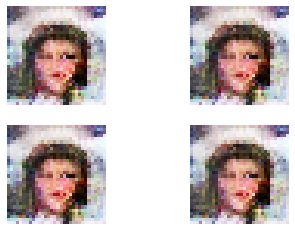

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_Female_model_1000.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 2)

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.000002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32

	model.add(Conv2DTranspose(512,(4,4),strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
def load_real_samples():
    trainX = men_data
	# convert from unsigned ints to floats
    X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_men_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_men_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/66, d1=0.681, d2=0.693 g=0.693
>1, 2/66, d1=0.682, d2=0.694 g=0.693
>1, 3/66, d1=0.677, d2=0.694 g=0.692
>1, 4/66, d1=0.678, d2=0.696 g=0.690
>1, 5/66, d1=0.680, d2=0.698 g=0.688
>1, 6/66, d1=0.670, d2=0.702 g=0.685
>1, 7/66, d1=0.672, d2=0.708 g=0.679
>1, 8/66, d1=0.670, d2=0.718 g=0.669
>1, 9/66, d1=0.670, d2=0.733 g=0.655
>1, 10/66, d1=0.671, d2=0.752 g=0.637
>1, 11/66, d1=0.672, d2=0.773 g=0.622
>1, 12/66, d1=0.668, d2=0.785 g=0.611
>1, 13/66, d1=0.669, d2=0.792 g=0.603
>1, 14/66, d1=0.668, d2=0.804 g=0.595
>1, 15/66, d1=0.665, d2=0.816 g=0.589
>1, 16/66, d1=0.665, d2=0.822 g=0.579
>1, 17/66, d1=0.667, d2=0.827 g=0.575
>1, 18/66, d1=0.673, d2=0.835 g=0.568
>1, 19/66, d1=0.668, d2=0.846 g=0.570
>1, 20/66, d1=0.669, d2=0.848 g=0.561
>1, 21/66, d1=0.669, d2=0.853 g=0.558
>1, 22/66, d1=0.667, d2=0.863 g=0.554
>1, 23/66, d1=0.670, d2=0.862 g=0.553
>1, 24/66, d1=0.665, d2=0.867 g=0.550
>1, 25/66, d1=0.664, d2=0.867 g=0.551
>1, 26/66, d1=0.666, d2=0.863 g=0.549
>1, 27/66, d1=0.670, 

>4, 21/66, d1=0.664, d2=0.637 g=0.753
>4, 22/66, d1=0.664, d2=0.638 g=0.751
>4, 23/66, d1=0.660, d2=0.636 g=0.761
>4, 24/66, d1=0.664, d2=0.635 g=0.756
>4, 25/66, d1=0.662, d2=0.626 g=0.767
>4, 26/66, d1=0.661, d2=0.629 g=0.768
>4, 27/66, d1=0.663, d2=0.630 g=0.760
>4, 28/66, d1=0.666, d2=0.633 g=0.766
>4, 29/66, d1=0.661, d2=0.629 g=0.763
>4, 30/66, d1=0.663, d2=0.635 g=0.760
>4, 31/66, d1=0.666, d2=0.629 g=0.765
>4, 32/66, d1=0.657, d2=0.621 g=0.769
>4, 33/66, d1=0.657, d2=0.624 g=0.769
>4, 34/66, d1=0.662, d2=0.625 g=0.771
>4, 35/66, d1=0.658, d2=0.623 g=0.769
>4, 36/66, d1=0.660, d2=0.621 g=0.775
>4, 37/66, d1=0.654, d2=0.619 g=0.774
>4, 38/66, d1=0.661, d2=0.624 g=0.771
>4, 39/66, d1=0.663, d2=0.625 g=0.773
>4, 40/66, d1=0.658, d2=0.611 g=0.785
>4, 41/66, d1=0.658, d2=0.625 g=0.768
>4, 42/66, d1=0.660, d2=0.623 g=0.776
>4, 43/66, d1=0.663, d2=0.613 g=0.784
>4, 44/66, d1=0.656, d2=0.619 g=0.774
>4, 45/66, d1=0.659, d2=0.620 g=0.776
>4, 46/66, d1=0.662, d2=0.616 g=0.779
>4, 47/66, d

>7, 41/66, d1=0.621, d2=0.454 g=1.013
>7, 42/66, d1=0.619, d2=0.450 g=1.007
>7, 43/66, d1=0.622, d2=0.455 g=1.012
>7, 44/66, d1=0.628, d2=0.453 g=1.020
>7, 45/66, d1=0.615, d2=0.450 g=1.020
>7, 46/66, d1=0.619, d2=0.452 g=1.018
>7, 47/66, d1=0.624, d2=0.451 g=1.019
>7, 48/66, d1=0.617, d2=0.453 g=1.025
>7, 49/66, d1=0.615, d2=0.445 g=1.026
>7, 50/66, d1=0.620, d2=0.447 g=1.026
>7, 51/66, d1=0.615, d2=0.451 g=1.025
>7, 52/66, d1=0.629, d2=0.450 g=1.021
>7, 53/66, d1=0.629, d2=0.452 g=1.022
>7, 54/66, d1=0.619, d2=0.450 g=1.029
>7, 55/66, d1=0.623, d2=0.445 g=1.030
>7, 56/66, d1=0.618, d2=0.439 g=1.036
>7, 57/66, d1=0.621, d2=0.443 g=1.037
>7, 58/66, d1=0.620, d2=0.450 g=1.031
>7, 59/66, d1=0.614, d2=0.447 g=1.020
>7, 60/66, d1=0.619, d2=0.453 g=1.025
>7, 61/66, d1=0.609, d2=0.452 g=1.012
>7, 62/66, d1=0.624, d2=0.455 g=1.008
>7, 63/66, d1=0.619, d2=0.458 g=1.014
>7, 64/66, d1=0.612, d2=0.459 g=1.004
>7, 65/66, d1=0.622, d2=0.468 g=0.995
>7, 66/66, d1=0.608, d2=0.485 g=0.965
>8, 1/66, d1

>10, 59/66, d1=0.619, d2=0.374 g=1.167
>10, 60/66, d1=0.614, d2=0.372 g=1.174
>10, 61/66, d1=0.653, d2=0.370 g=1.183
>10, 62/66, d1=0.592, d2=0.367 g=1.184
>10, 63/66, d1=0.595, d2=0.364 g=1.200
>10, 64/66, d1=0.648, d2=0.363 g=1.193
>10, 65/66, d1=0.608, d2=0.358 g=1.205
>10, 66/66, d1=0.577, d2=0.358 g=1.217
>Accuracy real: 68%, fake: 100%
>11, 1/66, d1=0.428, d2=0.355 g=1.212
>11, 2/66, d1=0.598, d2=0.353 g=1.215
>11, 3/66, d1=0.574, d2=0.355 g=1.212
>11, 4/66, d1=0.622, d2=0.354 g=1.218
>11, 5/66, d1=0.577, d2=0.348 g=1.222
>11, 6/66, d1=0.615, d2=0.353 g=1.221
>11, 7/66, d1=0.613, d2=0.347 g=1.229
>11, 8/66, d1=0.570, d2=0.352 g=1.222
>11, 9/66, d1=0.584, d2=0.353 g=1.223
>11, 10/66, d1=0.562, d2=0.341 g=1.239
>11, 11/66, d1=0.618, d2=0.350 g=1.241
>11, 12/66, d1=0.587, d2=0.343 g=1.240
>11, 13/66, d1=0.573, d2=0.344 g=1.250
>11, 14/66, d1=0.640, d2=0.334 g=1.260
>11, 15/66, d1=0.575, d2=0.338 g=1.263
>11, 16/66, d1=0.578, d2=0.336 g=1.262
>11, 17/66, d1=0.590, d2=0.332 g=1.271
>1

>14, 7/66, d1=0.428, d2=0.334 g=1.258
>14, 8/66, d1=0.446, d2=0.331 g=1.284
>14, 9/66, d1=0.465, d2=0.324 g=1.296
>14, 10/66, d1=0.485, d2=0.318 g=1.308
>14, 11/66, d1=0.415, d2=0.317 g=1.310
>14, 12/66, d1=0.469, d2=0.314 g=1.325
>14, 13/66, d1=0.460, d2=0.311 g=1.325
>14, 14/66, d1=0.465, d2=0.309 g=1.356
>14, 15/66, d1=0.421, d2=0.302 g=1.366
>14, 16/66, d1=0.456, d2=0.294 g=1.369
>14, 17/66, d1=0.418, d2=0.293 g=1.378
>14, 18/66, d1=0.433, d2=0.287 g=1.399
>14, 19/66, d1=0.441, d2=0.285 g=1.413
>14, 20/66, d1=0.434, d2=0.287 g=1.413
>14, 21/66, d1=0.447, d2=0.280 g=1.438
>14, 22/66, d1=0.428, d2=0.271 g=1.428
>14, 23/66, d1=0.422, d2=0.270 g=1.448
>14, 24/66, d1=0.438, d2=0.273 g=1.462
>14, 25/66, d1=0.432, d2=0.266 g=1.480
>14, 26/66, d1=0.447, d2=0.256 g=1.494
>14, 27/66, d1=0.407, d2=0.255 g=1.500
>14, 28/66, d1=0.452, d2=0.254 g=1.511
>14, 29/66, d1=0.410, d2=0.251 g=1.523
>14, 30/66, d1=0.447, d2=0.246 g=1.524
>14, 31/66, d1=0.428, d2=0.240 g=1.549
>14, 32/66, d1=0.375, d2=0.2

>17, 20/66, d1=0.383, d2=2.967 g=0.058
>17, 21/66, d1=0.389, d2=2.852 g=0.066
>17, 22/66, d1=0.385, d2=2.788 g=0.070
>17, 23/66, d1=0.356, d2=2.651 g=0.078
>17, 24/66, d1=0.412, d2=2.605 g=0.084
>17, 25/66, d1=0.382, d2=2.570 g=0.089
>17, 26/66, d1=0.384, d2=2.454 g=0.097
>17, 27/66, d1=0.388, d2=2.383 g=0.105
>17, 28/66, d1=0.430, d2=2.295 g=0.111
>17, 29/66, d1=0.336, d2=2.222 g=0.121
>17, 30/66, d1=0.417, d2=2.207 g=0.129
>17, 31/66, d1=0.434, d2=2.097 g=0.138
>17, 32/66, d1=0.439, d2=2.075 g=0.145
>17, 33/66, d1=0.463, d2=2.061 g=0.148
>17, 34/66, d1=0.425, d2=2.019 g=0.157
>17, 35/66, d1=0.445, d2=1.982 g=0.162
>17, 36/66, d1=0.443, d2=1.940 g=0.169
>17, 37/66, d1=0.472, d2=1.872 g=0.175
>17, 38/66, d1=0.448, d2=1.814 g=0.189
>17, 39/66, d1=0.527, d2=1.758 g=0.196
>17, 40/66, d1=0.564, d2=1.704 g=0.214
>17, 41/66, d1=0.488, d2=1.662 g=0.219
>17, 42/66, d1=0.496, d2=1.616 g=0.240
>17, 43/66, d1=0.457, d2=1.563 g=0.248
>17, 44/66, d1=0.515, d2=1.524 g=0.257
>17, 45/66, d1=0.506, d2=

>20, 33/66, d1=0.560, d2=0.146 g=2.047
>20, 34/66, d1=0.582, d2=0.141 g=2.010
>20, 35/66, d1=0.565, d2=0.145 g=2.044
>20, 36/66, d1=0.544, d2=0.146 g=2.009
>20, 37/66, d1=0.557, d2=0.142 g=2.020
>20, 38/66, d1=0.528, d2=0.135 g=2.023
>20, 39/66, d1=0.591, d2=0.151 g=2.029
>20, 40/66, d1=0.540, d2=0.141 g=2.024
>20, 41/66, d1=0.510, d2=0.136 g=2.051
>20, 42/66, d1=0.483, d2=0.142 g=2.038
>20, 43/66, d1=0.524, d2=0.145 g=2.040
>20, 44/66, d1=0.521, d2=0.141 g=2.060
>20, 45/66, d1=0.569, d2=0.139 g=2.057
>20, 46/66, d1=0.550, d2=0.145 g=2.074
>20, 47/66, d1=0.593, d2=0.143 g=2.077
>20, 48/66, d1=0.553, d2=0.137 g=2.023
>20, 49/66, d1=0.547, d2=0.141 g=2.080
>20, 50/66, d1=0.503, d2=0.141 g=2.083
>20, 51/66, d1=0.581, d2=0.138 g=2.050
>20, 52/66, d1=0.556, d2=0.136 g=2.080
>20, 53/66, d1=0.606, d2=0.140 g=2.072
>20, 54/66, d1=0.520, d2=0.134 g=2.097
>20, 55/66, d1=0.585, d2=0.133 g=2.104
>20, 56/66, d1=0.531, d2=0.134 g=2.093
>20, 57/66, d1=0.477, d2=0.134 g=2.071
>20, 58/66, d1=0.514, d2=

>23, 45/66, d1=0.390, d2=0.091 g=2.509
>23, 46/66, d1=0.349, d2=0.089 g=2.464
>23, 47/66, d1=0.375, d2=0.088 g=2.495
>23, 48/66, d1=0.381, d2=0.087 g=2.509
>23, 49/66, d1=0.333, d2=0.095 g=2.517
>23, 50/66, d1=0.376, d2=0.093 g=2.556
>23, 51/66, d1=0.343, d2=0.091 g=2.492
>23, 52/66, d1=0.337, d2=0.093 g=2.463
>23, 53/66, d1=0.422, d2=0.090 g=2.492
>23, 54/66, d1=0.336, d2=0.093 g=2.528
>23, 55/66, d1=0.360, d2=0.091 g=2.517
>23, 56/66, d1=0.350, d2=0.088 g=2.489
>23, 57/66, d1=0.335, d2=0.086 g=2.550
>23, 58/66, d1=0.376, d2=0.088 g=2.478
>23, 59/66, d1=0.331, d2=0.089 g=2.521
>23, 60/66, d1=0.379, d2=0.087 g=2.471
>23, 61/66, d1=0.340, d2=0.088 g=2.521
>23, 62/66, d1=0.298, d2=0.084 g=2.538
>23, 63/66, d1=0.367, d2=0.086 g=2.555
>23, 64/66, d1=0.332, d2=0.092 g=2.541
>23, 65/66, d1=0.382, d2=0.088 g=2.524
>23, 66/66, d1=0.341, d2=0.088 g=2.563
>24, 1/66, d1=0.380, d2=0.087 g=2.555
>24, 2/66, d1=0.344, d2=0.085 g=2.557
>24, 3/66, d1=0.351, d2=0.096 g=2.521
>24, 4/66, d1=0.369, d2=0.08

>26, 59/66, d1=0.273, d2=0.056 g=2.914
>26, 60/66, d1=0.220, d2=0.056 g=2.992
>26, 61/66, d1=0.204, d2=0.055 g=2.954
>26, 62/66, d1=0.240, d2=0.054 g=2.923
>26, 63/66, d1=0.218, d2=0.058 g=2.945
>26, 64/66, d1=0.219, d2=0.061 g=2.888
>26, 65/66, d1=0.209, d2=0.058 g=2.969
>26, 66/66, d1=0.193, d2=0.057 g=2.975
>27, 1/66, d1=0.286, d2=0.057 g=2.927
>27, 2/66, d1=0.202, d2=0.060 g=2.933
>27, 3/66, d1=0.210, d2=0.060 g=2.949
>27, 4/66, d1=0.171, d2=0.055 g=2.948
>27, 5/66, d1=0.219, d2=0.059 g=2.911
>27, 6/66, d1=0.187, d2=0.062 g=2.965
>27, 7/66, d1=0.220, d2=0.057 g=2.979
>27, 8/66, d1=0.273, d2=0.056 g=2.936
>27, 9/66, d1=0.214, d2=0.057 g=2.939
>27, 10/66, d1=0.221, d2=0.058 g=2.968
>27, 11/66, d1=0.232, d2=0.059 g=2.957
>27, 12/66, d1=0.173, d2=0.057 g=3.034
>27, 13/66, d1=0.204, d2=0.055 g=3.004
>27, 14/66, d1=0.226, d2=0.059 g=2.972
>27, 15/66, d1=0.187, d2=0.055 g=2.987
>27, 16/66, d1=0.206, d2=0.055 g=2.983
>27, 17/66, d1=0.220, d2=0.056 g=2.935
>27, 18/66, d1=0.201, d2=0.055 g=2

>30, 7/66, d1=0.117, d2=0.037 g=3.371
>30, 8/66, d1=0.164, d2=0.038 g=3.361
>30, 9/66, d1=0.090, d2=0.037 g=3.446
>30, 10/66, d1=0.166, d2=0.038 g=3.434
>30, 11/66, d1=0.099, d2=0.038 g=3.367
>30, 12/66, d1=0.083, d2=0.038 g=3.466
>30, 13/66, d1=0.116, d2=0.041 g=3.421
>30, 14/66, d1=0.140, d2=0.039 g=3.378
>30, 15/66, d1=0.112, d2=0.038 g=3.478
>30, 16/66, d1=0.114, d2=0.037 g=3.380
>30, 17/66, d1=0.128, d2=0.035 g=3.429
>30, 18/66, d1=0.122, d2=0.038 g=3.399
>30, 19/66, d1=0.139, d2=0.036 g=3.430
>30, 20/66, d1=0.188, d2=0.033 g=3.392
>30, 21/66, d1=0.122, d2=0.037 g=3.443
>30, 22/66, d1=0.134, d2=0.037 g=3.491
>30, 23/66, d1=0.124, d2=0.040 g=3.450
>30, 24/66, d1=0.120, d2=0.034 g=3.429
>30, 25/66, d1=0.134, d2=0.041 g=3.447
>30, 26/66, d1=0.075, d2=0.036 g=3.461
>30, 27/66, d1=0.107, d2=0.035 g=3.479
>30, 28/66, d1=0.121, d2=0.037 g=3.425
>30, 29/66, d1=0.163, d2=0.036 g=3.484
>30, 30/66, d1=0.096, d2=0.035 g=3.507
>30, 31/66, d1=0.153, d2=0.038 g=3.482
>30, 32/66, d1=0.117, d2=0.0

>33, 21/66, d1=0.319, d2=0.267 g=1.448
>33, 22/66, d1=0.258, d2=0.266 g=1.463
>33, 23/66, d1=0.297, d2=0.262 g=1.477
>33, 24/66, d1=0.212, d2=0.252 g=1.522
>33, 25/66, d1=0.210, d2=0.255 g=1.523
>33, 26/66, d1=0.257, d2=0.255 g=1.540
>33, 27/66, d1=0.271, d2=0.247 g=1.546
>33, 28/66, d1=0.239, d2=0.235 g=1.544
>33, 29/66, d1=0.234, d2=0.239 g=1.575
>33, 30/66, d1=0.226, d2=0.246 g=1.580
>33, 31/66, d1=0.363, d2=0.224 g=1.599
>33, 32/66, d1=0.233, d2=0.223 g=1.626
>33, 33/66, d1=0.281, d2=0.223 g=1.660
>33, 34/66, d1=0.215, d2=0.206 g=1.659
>33, 35/66, d1=0.226, d2=0.240 g=1.530
>33, 36/66, d1=0.347, d2=0.247 g=1.547
>33, 37/66, d1=0.288, d2=0.248 g=1.511
>33, 38/66, d1=0.245, d2=0.271 g=1.488
>33, 39/66, d1=0.282, d2=0.264 g=1.472
>33, 40/66, d1=0.204, d2=0.304 g=1.416
>33, 41/66, d1=0.240, d2=0.332 g=1.314
>33, 42/66, d1=0.294, d2=0.367 g=1.216
>33, 43/66, d1=0.222, d2=0.400 g=1.140
>33, 44/66, d1=0.358, d2=0.487 g=0.954
>33, 45/66, d1=0.233, d2=0.601 g=0.816
>33, 46/66, d1=0.362, d2=

>36, 34/66, d1=0.996, d2=0.568 g=0.901
>36, 35/66, d1=0.888, d2=0.540 g=0.916
>36, 36/66, d1=0.946, d2=0.550 g=0.925
>36, 37/66, d1=1.000, d2=0.541 g=0.888
>36, 38/66, d1=0.848, d2=0.547 g=0.899
>36, 39/66, d1=0.900, d2=0.559 g=0.903
>36, 40/66, d1=0.900, d2=0.536 g=0.932
>36, 41/66, d1=1.008, d2=0.555 g=0.903
>36, 42/66, d1=0.983, d2=0.549 g=0.895
>36, 43/66, d1=0.986, d2=0.539 g=0.888
>36, 44/66, d1=0.919, d2=0.558 g=0.919
>36, 45/66, d1=0.955, d2=0.554 g=0.948
>36, 46/66, d1=0.855, d2=0.539 g=0.950
>36, 47/66, d1=1.015, d2=0.511 g=0.932
>36, 48/66, d1=0.935, d2=0.539 g=0.948
>36, 49/66, d1=0.951, d2=0.496 g=0.989
>36, 50/66, d1=0.979, d2=0.525 g=0.951
>36, 51/66, d1=1.094, d2=0.492 g=0.977
>36, 52/66, d1=1.176, d2=0.512 g=0.961
>36, 53/66, d1=1.032, d2=0.487 g=0.969
>36, 54/66, d1=0.958, d2=0.496 g=0.983
>36, 55/66, d1=1.013, d2=0.473 g=0.977
>36, 56/66, d1=0.969, d2=0.516 g=1.006
>36, 57/66, d1=0.883, d2=0.482 g=0.972
>36, 58/66, d1=0.991, d2=0.480 g=0.972
>36, 59/66, d1=1.037, d2=

>39, 48/66, d1=1.242, d2=0.776 g=0.609
>39, 49/66, d1=1.354, d2=0.818 g=0.598
>39, 50/66, d1=1.373, d2=0.832 g=0.602
>39, 51/66, d1=1.290, d2=0.816 g=0.602
>39, 52/66, d1=1.277, d2=0.789 g=0.625
>39, 53/66, d1=1.315, d2=0.772 g=0.631
>39, 54/66, d1=1.340, d2=0.782 g=0.633
>39, 55/66, d1=1.398, d2=0.805 g=0.628
>39, 56/66, d1=1.411, d2=0.817 g=0.613
>39, 57/66, d1=1.361, d2=0.829 g=0.606
>39, 58/66, d1=1.356, d2=0.815 g=0.604
>39, 59/66, d1=1.287, d2=0.818 g=0.605
>39, 60/66, d1=1.378, d2=0.804 g=0.576
>39, 61/66, d1=1.314, d2=0.848 g=0.587
>39, 62/66, d1=1.361, d2=0.820 g=0.588
>39, 63/66, d1=1.350, d2=0.818 g=0.615
>39, 64/66, d1=1.325, d2=0.793 g=0.620
>39, 65/66, d1=1.485, d2=0.784 g=0.628
>39, 66/66, d1=1.379, d2=0.779 g=0.635
>40, 1/66, d1=1.366, d2=0.811 g=0.607
>40, 2/66, d1=1.327, d2=0.830 g=0.590
>40, 3/66, d1=1.398, d2=0.837 g=0.583
>40, 4/66, d1=1.422, d2=0.817 g=0.585
>40, 5/66, d1=1.220, d2=0.810 g=0.580
>40, 6/66, d1=1.321, d2=0.829 g=0.587
>40, 7/66, d1=1.250, d2=0.844 g

>42, 62/66, d1=1.135, d2=1.039 g=0.466
>42, 63/66, d1=1.165, d2=0.986 g=0.464
>42, 64/66, d1=1.122, d2=0.998 g=0.463
>42, 65/66, d1=1.140, d2=0.988 g=0.471
>42, 66/66, d1=1.124, d2=0.998 g=0.472
>43, 1/66, d1=1.202, d2=0.987 g=0.466
>43, 2/66, d1=1.082, d2=0.988 g=0.468
>43, 3/66, d1=1.198, d2=0.998 g=0.470
>43, 4/66, d1=1.167, d2=1.008 g=0.469
>43, 5/66, d1=1.108, d2=1.003 g=0.463
>43, 6/66, d1=1.148, d2=1.000 g=0.462
>43, 7/66, d1=1.199, d2=0.980 g=0.482
>43, 8/66, d1=1.117, d2=0.961 g=0.482
>43, 9/66, d1=1.074, d2=1.002 g=0.478
>43, 10/66, d1=1.161, d2=1.003 g=0.473
>43, 11/66, d1=1.100, d2=1.009 g=0.467
>43, 12/66, d1=1.129, d2=1.001 g=0.467
>43, 13/66, d1=1.178, d2=0.983 g=0.464
>43, 14/66, d1=1.199, d2=0.998 g=0.464
>43, 15/66, d1=1.181, d2=1.001 g=0.467
>43, 16/66, d1=1.114, d2=0.987 g=0.472
>43, 17/66, d1=1.107, d2=0.993 g=0.476
>43, 18/66, d1=1.128, d2=0.987 g=0.480
>43, 19/66, d1=1.123, d2=0.947 g=0.490
>43, 20/66, d1=1.190, d2=0.946 g=0.507
>43, 21/66, d1=1.121, d2=0.972 g=0

>46, 9/66, d1=1.029, d2=0.791 g=0.603
>46, 10/66, d1=1.124, d2=0.798 g=0.601
>46, 11/66, d1=1.033, d2=0.800 g=0.597
>46, 12/66, d1=1.085, d2=0.812 g=0.595
>46, 13/66, d1=1.019, d2=0.801 g=0.599
>46, 14/66, d1=1.058, d2=0.807 g=0.592
>46, 15/66, d1=1.044, d2=0.810 g=0.595
>46, 16/66, d1=0.995, d2=0.799 g=0.593
>46, 17/66, d1=1.054, d2=0.798 g=0.602
>46, 18/66, d1=1.058, d2=0.800 g=0.597
>46, 19/66, d1=1.042, d2=0.804 g=0.605
>46, 20/66, d1=0.996, d2=0.804 g=0.594
>46, 21/66, d1=1.073, d2=0.812 g=0.601
>46, 22/66, d1=1.050, d2=0.807 g=0.601
>46, 23/66, d1=1.053, d2=0.795 g=0.599
>46, 24/66, d1=0.982, d2=0.798 g=0.599
>46, 25/66, d1=1.060, d2=0.800 g=0.597
>46, 26/66, d1=0.980, d2=0.808 g=0.597
>46, 27/66, d1=1.061, d2=0.808 g=0.598
>46, 28/66, d1=1.020, d2=0.797 g=0.598
>46, 29/66, d1=1.049, d2=0.805 g=0.597
>46, 30/66, d1=1.036, d2=0.812 g=0.595
>46, 31/66, d1=1.048, d2=0.804 g=0.594
>46, 32/66, d1=0.986, d2=0.809 g=0.592
>46, 33/66, d1=1.008, d2=0.800 g=0.594
>46, 34/66, d1=1.016, d2=0

>49, 22/66, d1=0.925, d2=0.805 g=0.601
>49, 23/66, d1=0.918, d2=0.812 g=0.587
>49, 24/66, d1=0.902, d2=0.832 g=0.583
>49, 25/66, d1=0.910, d2=0.830 g=0.578
>49, 26/66, d1=0.914, d2=0.839 g=0.565
>49, 27/66, d1=0.900, d2=0.853 g=0.562
>49, 28/66, d1=0.899, d2=0.872 g=0.548
>49, 29/66, d1=0.937, d2=0.887 g=0.534
>49, 30/66, d1=0.893, d2=0.918 g=0.522
>49, 31/66, d1=0.880, d2=0.919 g=0.512
>49, 32/66, d1=0.903, d2=0.934 g=0.502
>49, 33/66, d1=0.925, d2=0.955 g=0.495
>49, 34/66, d1=0.950, d2=0.960 g=0.495
>49, 35/66, d1=0.916, d2=0.966 g=0.480
>49, 36/66, d1=0.884, d2=0.973 g=0.485
>49, 37/66, d1=0.872, d2=0.977 g=0.476
>49, 38/66, d1=0.912, d2=0.988 g=0.477
>49, 39/66, d1=0.896, d2=0.967 g=0.473
>49, 40/66, d1=0.904, d2=0.985 g=0.477
>49, 41/66, d1=0.921, d2=0.986 g=0.477
>49, 42/66, d1=0.874, d2=1.002 g=0.467
>49, 43/66, d1=0.895, d2=0.996 g=0.472
>49, 44/66, d1=0.877, d2=0.980 g=0.462
>49, 45/66, d1=0.928, d2=0.983 g=0.468
>49, 46/66, d1=0.941, d2=0.984 g=0.472
>49, 47/66, d1=0.928, d2=

>52, 35/66, d1=0.973, d2=0.842 g=0.568
>52, 36/66, d1=0.940, d2=0.833 g=0.570
>52, 37/66, d1=0.942, d2=0.842 g=0.570
>52, 38/66, d1=0.966, d2=0.832 g=0.574
>52, 39/66, d1=0.977, d2=0.835 g=0.574
>52, 40/66, d1=0.926, d2=0.832 g=0.571
>52, 41/66, d1=0.952, d2=0.833 g=0.573
>52, 42/66, d1=0.952, d2=0.833 g=0.573
>52, 43/66, d1=0.973, d2=0.833 g=0.574
>52, 44/66, d1=0.948, d2=0.844 g=0.568
>52, 45/66, d1=0.964, d2=0.825 g=0.572
>52, 46/66, d1=0.965, d2=0.832 g=0.573
>52, 47/66, d1=0.951, d2=0.824 g=0.579
>52, 48/66, d1=0.946, d2=0.837 g=0.581
>52, 49/66, d1=0.955, d2=0.837 g=0.576
>52, 50/66, d1=0.934, d2=0.841 g=0.577
>52, 51/66, d1=0.947, d2=0.824 g=0.579
>52, 52/66, d1=0.938, d2=0.825 g=0.583
>52, 53/66, d1=0.947, d2=0.815 g=0.587
>52, 54/66, d1=0.934, d2=0.816 g=0.593
>52, 55/66, d1=0.978, d2=0.825 g=0.586
>52, 56/66, d1=0.923, d2=0.827 g=0.577
>52, 57/66, d1=0.931, d2=0.821 g=0.586
>52, 58/66, d1=0.897, d2=0.816 g=0.581
>52, 59/66, d1=0.934, d2=0.824 g=0.584
>52, 60/66, d1=0.910, d2=

>55, 48/66, d1=0.810, d2=0.750 g=0.648
>55, 49/66, d1=0.791, d2=0.745 g=0.645
>55, 50/66, d1=0.813, d2=0.749 g=0.650
>55, 51/66, d1=0.817, d2=0.746 g=0.646
>55, 52/66, d1=0.796, d2=0.744 g=0.652
>55, 53/66, d1=0.807, d2=0.740 g=0.650
>55, 54/66, d1=0.799, d2=0.739 g=0.651
>55, 55/66, d1=0.793, d2=0.752 g=0.650
>55, 56/66, d1=0.790, d2=0.739 g=0.644
>55, 57/66, d1=0.811, d2=0.746 g=0.641
>55, 58/66, d1=0.815, d2=0.744 g=0.647
>55, 59/66, d1=0.806, d2=0.743 g=0.650
>55, 60/66, d1=0.776, d2=0.748 g=0.646
>55, 61/66, d1=0.789, d2=0.743 g=0.652
>55, 62/66, d1=0.797, d2=0.743 g=0.650
>55, 63/66, d1=0.792, d2=0.743 g=0.653
>55, 64/66, d1=0.817, d2=0.735 g=0.652
>55, 65/66, d1=0.806, d2=0.740 g=0.647
>55, 66/66, d1=0.826, d2=0.740 g=0.652
>56, 1/66, d1=0.794, d2=0.739 g=0.650
>56, 2/66, d1=0.797, d2=0.742 g=0.653
>56, 3/66, d1=0.818, d2=0.740 g=0.648
>56, 4/66, d1=0.795, d2=0.742 g=0.652
>56, 5/66, d1=0.798, d2=0.746 g=0.654
>56, 6/66, d1=0.795, d2=0.734 g=0.648
>56, 7/66, d1=0.812, d2=0.735 g

>58, 62/66, d1=0.850, d2=0.766 g=0.620
>58, 63/66, d1=0.879, d2=0.780 g=0.617
>58, 64/66, d1=0.862, d2=0.772 g=0.620
>58, 65/66, d1=0.888, d2=0.771 g=0.618
>58, 66/66, d1=0.860, d2=0.770 g=0.620
>59, 1/66, d1=0.879, d2=0.767 g=0.621
>59, 2/66, d1=0.847, d2=0.765 g=0.629
>59, 3/66, d1=0.857, d2=0.749 g=0.644
>59, 4/66, d1=0.844, d2=0.757 g=0.638
>59, 5/66, d1=0.838, d2=0.759 g=0.635
>59, 6/66, d1=0.861, d2=0.753 g=0.638
>59, 7/66, d1=0.888, d2=0.758 g=0.638
>59, 8/66, d1=0.881, d2=0.753 g=0.648
>59, 9/66, d1=0.866, d2=0.738 g=0.644
>59, 10/66, d1=0.849, d2=0.743 g=0.648
>59, 11/66, d1=0.831, d2=0.751 g=0.651
>59, 12/66, d1=0.845, d2=0.748 g=0.649
>59, 13/66, d1=0.854, d2=0.745 g=0.642
>59, 14/66, d1=0.859, d2=0.747 g=0.642
>59, 15/66, d1=0.872, d2=0.752 g=0.651
>59, 16/66, d1=0.863, d2=0.749 g=0.650
>59, 17/66, d1=0.852, d2=0.728 g=0.661
>59, 18/66, d1=0.889, d2=0.730 g=0.663
>59, 19/66, d1=0.841, d2=0.739 g=0.648
>59, 20/66, d1=0.877, d2=0.739 g=0.656
>59, 21/66, d1=0.877, d2=0.732 g=0

>62, 9/66, d1=0.843, d2=0.732 g=0.657
>62, 10/66, d1=0.840, d2=0.740 g=0.654
>62, 11/66, d1=0.842, d2=0.735 g=0.655
>62, 12/66, d1=0.844, d2=0.736 g=0.654
>62, 13/66, d1=0.850, d2=0.733 g=0.657
>62, 14/66, d1=0.827, d2=0.737 g=0.657
>62, 15/66, d1=0.842, d2=0.741 g=0.657
>62, 16/66, d1=0.825, d2=0.732 g=0.657
>62, 17/66, d1=0.831, d2=0.735 g=0.651
>62, 18/66, d1=0.826, d2=0.730 g=0.657
>62, 19/66, d1=0.816, d2=0.741 g=0.653
>62, 20/66, d1=0.810, d2=0.734 g=0.659
>62, 21/66, d1=0.841, d2=0.736 g=0.654
>62, 22/66, d1=0.833, d2=0.736 g=0.656
>62, 23/66, d1=0.830, d2=0.730 g=0.658
>62, 24/66, d1=0.829, d2=0.735 g=0.658
>62, 25/66, d1=0.829, d2=0.729 g=0.660
>62, 26/66, d1=0.835, d2=0.735 g=0.656
>62, 27/66, d1=0.833, d2=0.733 g=0.660
>62, 28/66, d1=0.842, d2=0.733 g=0.659
>62, 29/66, d1=0.837, d2=0.737 g=0.654
>62, 30/66, d1=0.823, d2=0.729 g=0.656
>62, 31/66, d1=0.817, d2=0.736 g=0.656
>62, 32/66, d1=0.812, d2=0.736 g=0.651
>62, 33/66, d1=0.807, d2=0.737 g=0.654
>62, 34/66, d1=0.827, d2=0

>65, 23/66, d1=0.726, d2=0.823 g=0.589
>65, 24/66, d1=0.706, d2=0.824 g=0.584
>65, 25/66, d1=0.717, d2=0.833 g=0.584
>65, 26/66, d1=0.712, d2=0.825 g=0.582
>65, 27/66, d1=0.707, d2=0.831 g=0.575
>65, 28/66, d1=0.723, d2=0.834 g=0.573
>65, 29/66, d1=0.693, d2=0.831 g=0.574
>65, 30/66, d1=0.683, d2=0.841 g=0.572
>65, 31/66, d1=0.701, d2=0.830 g=0.571
>65, 32/66, d1=0.703, d2=0.840 g=0.567
>65, 33/66, d1=0.697, d2=0.844 g=0.571
>65, 34/66, d1=0.702, d2=0.833 g=0.568
>65, 35/66, d1=0.722, d2=0.835 g=0.574
>65, 36/66, d1=0.714, d2=0.847 g=0.570
>65, 37/66, d1=0.702, d2=0.838 g=0.572
>65, 38/66, d1=0.720, d2=0.846 g=0.568
>65, 39/66, d1=0.706, d2=0.847 g=0.572
>65, 40/66, d1=0.730, d2=0.839 g=0.574
>65, 41/66, d1=0.751, d2=0.831 g=0.572
>65, 42/66, d1=0.720, d2=0.850 g=0.564
>65, 43/66, d1=0.715, d2=0.847 g=0.559
>65, 44/66, d1=0.723, d2=0.866 g=0.554
>65, 45/66, d1=0.736, d2=0.859 g=0.550
>65, 46/66, d1=0.725, d2=0.872 g=0.545
>65, 47/66, d1=0.734, d2=0.880 g=0.538
>65, 48/66, d1=0.719, d2=

>68, 36/66, d1=0.835, d2=0.738 g=0.656
>68, 37/66, d1=0.841, d2=0.726 g=0.663
>68, 38/66, d1=0.840, d2=0.726 g=0.670
>68, 39/66, d1=0.844, d2=0.723 g=0.670
>68, 40/66, d1=0.834, d2=0.722 g=0.662
>68, 41/66, d1=0.844, d2=0.722 g=0.661
>68, 42/66, d1=0.837, d2=0.729 g=0.664
>68, 43/66, d1=0.823, d2=0.722 g=0.663
>68, 44/66, d1=0.833, d2=0.725 g=0.663
>68, 45/66, d1=0.837, d2=0.718 g=0.669
>68, 46/66, d1=0.860, d2=0.723 g=0.672
>68, 47/66, d1=0.831, d2=0.710 g=0.673
>68, 48/66, d1=0.838, d2=0.705 g=0.678
>68, 49/66, d1=0.830, d2=0.717 g=0.672
>68, 50/66, d1=0.836, d2=0.719 g=0.668
>68, 51/66, d1=0.817, d2=0.714 g=0.675
>68, 52/66, d1=0.832, d2=0.717 g=0.669
>68, 53/66, d1=0.825, d2=0.719 g=0.671
>68, 54/66, d1=0.831, d2=0.717 g=0.669
>68, 55/66, d1=0.827, d2=0.717 g=0.675
>68, 56/66, d1=0.830, d2=0.707 g=0.677
>68, 57/66, d1=0.830, d2=0.707 g=0.682
>68, 58/66, d1=0.826, d2=0.718 g=0.677
>68, 59/66, d1=0.836, d2=0.720 g=0.674
>68, 60/66, d1=0.842, d2=0.713 g=0.672
>68, 61/66, d1=0.825, d2=

>71, 48/66, d1=0.726, d2=0.759 g=0.632
>71, 49/66, d1=0.711, d2=0.763 g=0.632
>71, 50/66, d1=0.718, d2=0.770 g=0.628
>71, 51/66, d1=0.737, d2=0.773 g=0.626
>71, 52/66, d1=0.714, d2=0.780 g=0.621
>71, 53/66, d1=0.721, d2=0.779 g=0.616
>71, 54/66, d1=0.719, d2=0.774 g=0.613
>71, 55/66, d1=0.734, d2=0.787 g=0.609
>71, 56/66, d1=0.736, d2=0.789 g=0.611
>71, 57/66, d1=0.700, d2=0.794 g=0.607
>71, 58/66, d1=0.717, d2=0.799 g=0.602
>71, 59/66, d1=0.717, d2=0.799 g=0.601
>71, 60/66, d1=0.724, d2=0.806 g=0.596
>71, 61/66, d1=0.722, d2=0.804 g=0.589
>71, 62/66, d1=0.699, d2=0.806 g=0.596
>71, 63/66, d1=0.723, d2=0.810 g=0.588
>71, 64/66, d1=0.712, d2=0.813 g=0.586
>71, 65/66, d1=0.709, d2=0.821 g=0.588
>71, 66/66, d1=0.730, d2=0.822 g=0.583
>72, 1/66, d1=0.729, d2=0.825 g=0.581
>72, 2/66, d1=0.721, d2=0.834 g=0.584
>72, 3/66, d1=0.724, d2=0.821 g=0.581
>72, 4/66, d1=0.743, d2=0.828 g=0.577
>72, 5/66, d1=0.716, d2=0.830 g=0.577
>72, 6/66, d1=0.745, d2=0.827 g=0.576
>72, 7/66, d1=0.702, d2=0.825 g

>74, 62/66, d1=0.782, d2=0.724 g=0.667
>74, 63/66, d1=0.787, d2=0.727 g=0.669
>74, 64/66, d1=0.805, d2=0.722 g=0.666
>74, 65/66, d1=0.823, d2=0.728 g=0.661
>74, 66/66, d1=0.786, d2=0.728 g=0.659
>75, 1/66, d1=0.793, d2=0.730 g=0.662
>75, 2/66, d1=0.793, d2=0.734 g=0.660
>75, 3/66, d1=0.799, d2=0.730 g=0.659
>75, 4/66, d1=0.791, d2=0.735 g=0.658
>75, 5/66, d1=0.795, d2=0.729 g=0.662
>75, 6/66, d1=0.802, d2=0.731 g=0.660
>75, 7/66, d1=0.813, d2=0.732 g=0.655
>75, 8/66, d1=0.795, d2=0.733 g=0.657
>75, 9/66, d1=0.800, d2=0.739 g=0.654
>75, 10/66, d1=0.785, d2=0.735 g=0.655
>75, 11/66, d1=0.799, d2=0.743 g=0.650
>75, 12/66, d1=0.812, d2=0.739 g=0.650
>75, 13/66, d1=0.798, d2=0.738 g=0.651
>75, 14/66, d1=0.795, d2=0.744 g=0.649
>75, 15/66, d1=0.776, d2=0.740 g=0.644
>75, 16/66, d1=0.787, d2=0.746 g=0.648
>75, 17/66, d1=0.798, d2=0.752 g=0.647
>75, 18/66, d1=0.771, d2=0.751 g=0.645
>75, 19/66, d1=0.806, d2=0.746 g=0.645
>75, 20/66, d1=0.791, d2=0.746 g=0.645
>75, 21/66, d1=0.802, d2=0.755 g=0

>78, 10/66, d1=0.765, d2=0.753 g=0.639
>78, 11/66, d1=0.776, d2=0.750 g=0.641
>78, 12/66, d1=0.761, d2=0.746 g=0.642
>78, 13/66, d1=0.753, d2=0.750 g=0.643
>78, 14/66, d1=0.764, d2=0.747 g=0.639
>78, 15/66, d1=0.769, d2=0.759 g=0.639
>78, 16/66, d1=0.753, d2=0.755 g=0.641
>78, 17/66, d1=0.765, d2=0.757 g=0.638
>78, 18/66, d1=0.768, d2=0.758 g=0.632
>78, 19/66, d1=0.756, d2=0.761 g=0.638
>78, 20/66, d1=0.763, d2=0.755 g=0.630
>78, 21/66, d1=0.747, d2=0.758 g=0.633
>78, 22/66, d1=0.758, d2=0.768 g=0.629
>78, 23/66, d1=0.766, d2=0.771 g=0.623
>78, 24/66, d1=0.747, d2=0.776 g=0.622
>78, 25/66, d1=0.750, d2=0.778 g=0.615
>78, 26/66, d1=0.759, d2=0.793 g=0.609
>78, 27/66, d1=0.770, d2=0.791 g=0.609
>78, 28/66, d1=0.758, d2=0.790 g=0.611
>78, 29/66, d1=0.763, d2=0.790 g=0.609
>78, 30/66, d1=0.770, d2=0.797 g=0.604
>78, 31/66, d1=0.758, d2=0.795 g=0.604
>78, 32/66, d1=0.759, d2=0.794 g=0.604
>78, 33/66, d1=0.755, d2=0.797 g=0.604
>78, 34/66, d1=0.766, d2=0.799 g=0.603
>78, 35/66, d1=0.761, d2=

>81, 23/66, d1=0.770, d2=0.731 g=0.659
>81, 24/66, d1=0.773, d2=0.736 g=0.662
>81, 25/66, d1=0.759, d2=0.731 g=0.665
>81, 26/66, d1=0.781, d2=0.727 g=0.668
>81, 27/66, d1=0.758, d2=0.719 g=0.667
>81, 28/66, d1=0.773, d2=0.730 g=0.669
>81, 29/66, d1=0.761, d2=0.725 g=0.667
>81, 30/66, d1=0.775, d2=0.719 g=0.669
>81, 31/66, d1=0.777, d2=0.716 g=0.675
>81, 32/66, d1=0.789, d2=0.709 g=0.681
>81, 33/66, d1=0.768, d2=0.711 g=0.677
>81, 34/66, d1=0.773, d2=0.719 g=0.675
>81, 35/66, d1=0.780, d2=0.717 g=0.673
>81, 36/66, d1=0.767, d2=0.715 g=0.674
>81, 37/66, d1=0.772, d2=0.712 g=0.675
>81, 38/66, d1=0.767, d2=0.710 g=0.678
>81, 39/66, d1=0.771, d2=0.710 g=0.680
>81, 40/66, d1=0.776, d2=0.713 g=0.677
>81, 41/66, d1=0.787, d2=0.709 g=0.682
>81, 42/66, d1=0.774, d2=0.704 g=0.684
>81, 43/66, d1=0.780, d2=0.709 g=0.683
>81, 44/66, d1=0.777, d2=0.714 g=0.682
>81, 45/66, d1=0.776, d2=0.705 g=0.676
>81, 46/66, d1=0.761, d2=0.706 g=0.682
>81, 47/66, d1=0.772, d2=0.708 g=0.680
>81, 48/66, d1=0.781, d2=

>84, 36/66, d1=0.820, d2=0.701 g=0.690
>84, 37/66, d1=0.811, d2=0.698 g=0.693
>84, 38/66, d1=0.813, d2=0.701 g=0.686
>84, 39/66, d1=0.813, d2=0.704 g=0.685
>84, 40/66, d1=0.805, d2=0.701 g=0.685
>84, 41/66, d1=0.803, d2=0.702 g=0.686
>84, 42/66, d1=0.819, d2=0.700 g=0.687
>84, 43/66, d1=0.813, d2=0.704 g=0.686
>84, 44/66, d1=0.819, d2=0.704 g=0.685
>84, 45/66, d1=0.815, d2=0.705 g=0.684
>84, 46/66, d1=0.813, d2=0.701 g=0.687
>84, 47/66, d1=0.809, d2=0.703 g=0.688
>84, 48/66, d1=0.800, d2=0.700 g=0.682
>84, 49/66, d1=0.812, d2=0.705 g=0.683
>84, 50/66, d1=0.799, d2=0.707 g=0.682
>84, 51/66, d1=0.804, d2=0.703 g=0.682
>84, 52/66, d1=0.808, d2=0.706 g=0.684
>84, 53/66, d1=0.793, d2=0.701 g=0.680
>84, 54/66, d1=0.783, d2=0.707 g=0.681
>84, 55/66, d1=0.800, d2=0.707 g=0.682
>84, 56/66, d1=0.789, d2=0.706 g=0.680
>84, 57/66, d1=0.789, d2=0.711 g=0.679
>84, 58/66, d1=0.797, d2=0.707 g=0.679
>84, 59/66, d1=0.790, d2=0.710 g=0.679
>84, 60/66, d1=0.785, d2=0.709 g=0.680
>84, 61/66, d1=0.790, d2=

>87, 50/66, d1=0.689, d2=0.759 g=0.634
>87, 51/66, d1=0.683, d2=0.761 g=0.633
>87, 52/66, d1=0.682, d2=0.752 g=0.635
>87, 53/66, d1=0.683, d2=0.757 g=0.636
>87, 54/66, d1=0.678, d2=0.760 g=0.633
>87, 55/66, d1=0.647, d2=0.759 g=0.633
>87, 56/66, d1=0.668, d2=0.753 g=0.637
>87, 57/66, d1=0.679, d2=0.749 g=0.638
>87, 58/66, d1=0.692, d2=0.755 g=0.635
>87, 59/66, d1=0.687, d2=0.755 g=0.638
>87, 60/66, d1=0.671, d2=0.751 g=0.638
>87, 61/66, d1=0.704, d2=0.751 g=0.639
>87, 62/66, d1=0.666, d2=0.748 g=0.639
>87, 63/66, d1=0.680, d2=0.757 g=0.641
>87, 64/66, d1=0.666, d2=0.751 g=0.643
>87, 65/66, d1=0.695, d2=0.752 g=0.645
>87, 66/66, d1=0.682, d2=0.749 g=0.642
>88, 1/66, d1=0.679, d2=0.747 g=0.643
>88, 2/66, d1=0.683, d2=0.749 g=0.644
>88, 3/66, d1=0.683, d2=0.741 g=0.643
>88, 4/66, d1=0.679, d2=0.743 g=0.647
>88, 5/66, d1=0.674, d2=0.749 g=0.649
>88, 6/66, d1=0.686, d2=0.742 g=0.646
>88, 7/66, d1=0.687, d2=0.743 g=0.650
>88, 8/66, d1=0.681, d2=0.743 g=0.651
>88, 9/66, d1=0.661, d2=0.736 g=0

>90, 64/66, d1=0.771, d2=0.774 g=0.628
>90, 65/66, d1=0.755, d2=0.769 g=0.634
>90, 66/66, d1=0.753, d2=0.767 g=0.630
>Accuracy real: 23%, fake: 0%
>91, 1/66, d1=0.763, d2=0.764 g=0.629
>91, 2/66, d1=0.754, d2=0.762 g=0.630
>91, 3/66, d1=0.778, d2=0.763 g=0.634
>91, 4/66, d1=0.768, d2=0.763 g=0.636
>91, 5/66, d1=0.762, d2=0.760 g=0.638
>91, 6/66, d1=0.771, d2=0.752 g=0.642
>91, 7/66, d1=0.756, d2=0.750 g=0.641
>91, 8/66, d1=0.775, d2=0.751 g=0.642
>91, 9/66, d1=0.761, d2=0.753 g=0.640
>91, 10/66, d1=0.773, d2=0.758 g=0.644
>91, 11/66, d1=0.771, d2=0.753 g=0.642
>91, 12/66, d1=0.764, d2=0.751 g=0.645
>91, 13/66, d1=0.749, d2=0.750 g=0.643
>91, 14/66, d1=0.760, d2=0.749 g=0.645
>91, 15/66, d1=0.754, d2=0.746 g=0.649
>91, 16/66, d1=0.773, d2=0.736 g=0.653
>91, 17/66, d1=0.769, d2=0.743 g=0.652
>91, 18/66, d1=0.770, d2=0.739 g=0.651
>91, 19/66, d1=0.767, d2=0.742 g=0.652
>91, 20/66, d1=0.763, d2=0.744 g=0.651
>91, 21/66, d1=0.769, d2=0.742 g=0.650
>91, 22/66, d1=0.773, d2=0.739 g=0.653
>91,

>94, 11/66, d1=0.702, d2=0.726 g=0.661
>94, 12/66, d1=0.694, d2=0.727 g=0.663
>94, 13/66, d1=0.711, d2=0.723 g=0.663
>94, 14/66, d1=0.718, d2=0.725 g=0.663
>94, 15/66, d1=0.697, d2=0.728 g=0.662
>94, 16/66, d1=0.696, d2=0.729 g=0.663
>94, 17/66, d1=0.710, d2=0.727 g=0.662
>94, 18/66, d1=0.700, d2=0.729 g=0.663
>94, 19/66, d1=0.702, d2=0.728 g=0.661
>94, 20/66, d1=0.701, d2=0.729 g=0.660
>94, 21/66, d1=0.702, d2=0.730 g=0.658
>94, 22/66, d1=0.696, d2=0.730 g=0.660
>94, 23/66, d1=0.697, d2=0.730 g=0.658
>94, 24/66, d1=0.684, d2=0.734 g=0.659
>94, 25/66, d1=0.711, d2=0.729 g=0.658
>94, 26/66, d1=0.707, d2=0.728 g=0.658
>94, 27/66, d1=0.705, d2=0.727 g=0.658
>94, 28/66, d1=0.711, d2=0.730 g=0.656
>94, 29/66, d1=0.691, d2=0.731 g=0.658
>94, 30/66, d1=0.686, d2=0.730 g=0.658
>94, 31/66, d1=0.714, d2=0.731 g=0.656
>94, 32/66, d1=0.687, d2=0.734 g=0.662
>94, 33/66, d1=0.694, d2=0.728 g=0.661
>94, 34/66, d1=0.692, d2=0.731 g=0.660
>94, 35/66, d1=0.686, d2=0.732 g=0.656
>94, 36/66, d1=0.694, d2=

>97, 24/66, d1=0.702, d2=0.778 g=0.623
>97, 25/66, d1=0.714, d2=0.781 g=0.625
>97, 26/66, d1=0.707, d2=0.783 g=0.620
>97, 27/66, d1=0.706, d2=0.773 g=0.624
>97, 28/66, d1=0.693, d2=0.771 g=0.624
>97, 29/66, d1=0.715, d2=0.770 g=0.625
>97, 30/66, d1=0.680, d2=0.771 g=0.626
>97, 31/66, d1=0.704, d2=0.760 g=0.626
>97, 32/66, d1=0.695, d2=0.769 g=0.632
>97, 33/66, d1=0.708, d2=0.764 g=0.631
>97, 34/66, d1=0.704, d2=0.759 g=0.635
>97, 35/66, d1=0.690, d2=0.749 g=0.639
>97, 36/66, d1=0.706, d2=0.757 g=0.639
>97, 37/66, d1=0.703, d2=0.761 g=0.641
>97, 38/66, d1=0.706, d2=0.756 g=0.642
>97, 39/66, d1=0.700, d2=0.753 g=0.642
>97, 40/66, d1=0.715, d2=0.745 g=0.639
>97, 41/66, d1=0.718, d2=0.743 g=0.645
>97, 42/66, d1=0.710, d2=0.748 g=0.642
>97, 43/66, d1=0.716, d2=0.746 g=0.644
>97, 44/66, d1=0.713, d2=0.744 g=0.643
>97, 45/66, d1=0.713, d2=0.750 g=0.644
>97, 46/66, d1=0.707, d2=0.746 g=0.644
>97, 47/66, d1=0.707, d2=0.750 g=0.648
>97, 48/66, d1=0.724, d2=0.745 g=0.647
>97, 49/66, d1=0.712, d2=

>100, 36/66, d1=0.763, d2=0.807 g=0.597
>100, 37/66, d1=0.774, d2=0.800 g=0.600
>100, 38/66, d1=0.772, d2=0.790 g=0.610
>100, 39/66, d1=0.774, d2=0.781 g=0.614
>100, 40/66, d1=0.779, d2=0.773 g=0.626
>100, 41/66, d1=0.777, d2=0.765 g=0.629
>100, 42/66, d1=0.779, d2=0.760 g=0.628
>100, 43/66, d1=0.789, d2=0.759 g=0.638
>100, 44/66, d1=0.792, d2=0.752 g=0.642
>100, 45/66, d1=0.782, d2=0.737 g=0.650
>100, 46/66, d1=0.795, d2=0.735 g=0.655
>100, 47/66, d1=0.786, d2=0.726 g=0.664
>100, 48/66, d1=0.782, d2=0.721 g=0.671
>100, 49/66, d1=0.786, d2=0.714 g=0.676
>100, 50/66, d1=0.792, d2=0.720 g=0.675
>100, 51/66, d1=0.793, d2=0.717 g=0.673
>100, 52/66, d1=0.792, d2=0.709 g=0.688
>100, 53/66, d1=0.803, d2=0.700 g=0.688
>100, 54/66, d1=0.784, d2=0.700 g=0.693
>100, 55/66, d1=0.797, d2=0.698 g=0.696
>100, 56/66, d1=0.805, d2=0.687 g=0.705
>100, 57/66, d1=0.795, d2=0.688 g=0.707
>100, 58/66, d1=0.797, d2=0.681 g=0.709
>100, 59/66, d1=0.805, d2=0.679 g=0.711
>100, 60/66, d1=0.808, d2=0.677 g=0.715


>103, 44/66, d1=0.719, d2=0.737 g=0.654
>103, 45/66, d1=0.708, d2=0.735 g=0.656
>103, 46/66, d1=0.705, d2=0.733 g=0.655
>103, 47/66, d1=0.709, d2=0.739 g=0.656
>103, 48/66, d1=0.709, d2=0.735 g=0.654
>103, 49/66, d1=0.711, d2=0.737 g=0.652
>103, 50/66, d1=0.696, d2=0.739 g=0.654
>103, 51/66, d1=0.699, d2=0.738 g=0.652
>103, 52/66, d1=0.695, d2=0.732 g=0.653
>103, 53/66, d1=0.706, d2=0.739 g=0.653
>103, 54/66, d1=0.713, d2=0.737 g=0.651
>103, 55/66, d1=0.713, d2=0.739 g=0.649
>103, 56/66, d1=0.708, d2=0.742 g=0.651
>103, 57/66, d1=0.706, d2=0.741 g=0.647
>103, 58/66, d1=0.694, d2=0.741 g=0.649
>103, 59/66, d1=0.700, d2=0.743 g=0.645
>103, 60/66, d1=0.697, d2=0.742 g=0.646
>103, 61/66, d1=0.702, d2=0.746 g=0.644
>103, 62/66, d1=0.689, d2=0.747 g=0.642
>103, 63/66, d1=0.699, d2=0.746 g=0.644
>103, 64/66, d1=0.690, d2=0.752 g=0.639
>103, 65/66, d1=0.687, d2=0.752 g=0.638
>103, 66/66, d1=0.702, d2=0.756 g=0.635
>104, 1/66, d1=0.704, d2=0.757 g=0.633
>104, 2/66, d1=0.687, d2=0.762 g=0.628
>1

>106, 53/66, d1=0.693, d2=0.831 g=0.574
>106, 54/66, d1=0.675, d2=0.828 g=0.577
>106, 55/66, d1=0.693, d2=0.830 g=0.577
>106, 56/66, d1=0.682, d2=0.836 g=0.575
>106, 57/66, d1=0.679, d2=0.829 g=0.576
>106, 58/66, d1=0.680, d2=0.838 g=0.569
>106, 59/66, d1=0.678, d2=0.837 g=0.573
>106, 60/66, d1=0.679, d2=0.832 g=0.573
>106, 61/66, d1=0.685, d2=0.829 g=0.576
>106, 62/66, d1=0.686, d2=0.826 g=0.579
>106, 63/66, d1=0.694, d2=0.818 g=0.580
>106, 64/66, d1=0.675, d2=0.826 g=0.580
>106, 65/66, d1=0.683, d2=0.822 g=0.583
>106, 66/66, d1=0.688, d2=0.816 g=0.583
>107, 1/66, d1=0.686, d2=0.812 g=0.589
>107, 2/66, d1=0.692, d2=0.807 g=0.594
>107, 3/66, d1=0.686, d2=0.808 g=0.593
>107, 4/66, d1=0.681, d2=0.800 g=0.600
>107, 5/66, d1=0.679, d2=0.801 g=0.598
>107, 6/66, d1=0.690, d2=0.806 g=0.602
>107, 7/66, d1=0.691, d2=0.801 g=0.604
>107, 8/66, d1=0.703, d2=0.792 g=0.604
>107, 9/66, d1=0.689, d2=0.790 g=0.610
>107, 10/66, d1=0.689, d2=0.783 g=0.616
>107, 11/66, d1=0.667, d2=0.779 g=0.627
>107, 12/

>109, 61/66, d1=0.756, d2=0.737 g=0.651
>109, 62/66, d1=0.747, d2=0.741 g=0.652
>109, 63/66, d1=0.753, d2=0.739 g=0.656
>109, 64/66, d1=0.754, d2=0.739 g=0.656
>109, 65/66, d1=0.746, d2=0.735 g=0.658
>109, 66/66, d1=0.756, d2=0.733 g=0.662
>110, 1/66, d1=0.758, d2=0.722 g=0.669
>110, 2/66, d1=0.754, d2=0.724 g=0.663
>110, 3/66, d1=0.756, d2=0.726 g=0.669
>110, 4/66, d1=0.756, d2=0.730 g=0.663
>110, 5/66, d1=0.751, d2=0.725 g=0.661
>110, 6/66, d1=0.748, d2=0.726 g=0.666
>110, 7/66, d1=0.766, d2=0.721 g=0.669
>110, 8/66, d1=0.755, d2=0.704 g=0.682
>110, 9/66, d1=0.753, d2=0.718 g=0.667
>110, 10/66, d1=0.754, d2=0.715 g=0.674
>110, 11/66, d1=0.761, d2=0.708 g=0.680
>110, 12/66, d1=0.748, d2=0.719 g=0.669
>110, 13/66, d1=0.746, d2=0.712 g=0.680
>110, 14/66, d1=0.739, d2=0.713 g=0.675
>110, 15/66, d1=0.740, d2=0.718 g=0.670
>110, 16/66, d1=0.744, d2=0.723 g=0.668
>110, 17/66, d1=0.749, d2=0.717 g=0.673
>110, 18/66, d1=0.748, d2=0.715 g=0.672
>110, 19/66, d1=0.742, d2=0.709 g=0.680
>110, 20/

>113, 3/66, d1=0.668, d2=0.741 g=0.648
>113, 4/66, d1=0.674, d2=0.740 g=0.649
>113, 5/66, d1=0.672, d2=0.744 g=0.645
>113, 6/66, d1=0.685, d2=0.740 g=0.646
>113, 7/66, d1=0.665, d2=0.746 g=0.645
>113, 8/66, d1=0.672, d2=0.742 g=0.645
>113, 9/66, d1=0.675, d2=0.744 g=0.645
>113, 10/66, d1=0.671, d2=0.748 g=0.645
>113, 11/66, d1=0.677, d2=0.754 g=0.643
>113, 12/66, d1=0.667, d2=0.753 g=0.642
>113, 13/66, d1=0.661, d2=0.755 g=0.637
>113, 14/66, d1=0.666, d2=0.756 g=0.635
>113, 15/66, d1=0.662, d2=0.767 g=0.632
>113, 16/66, d1=0.672, d2=0.766 g=0.631
>113, 17/66, d1=0.665, d2=0.765 g=0.625
>113, 18/66, d1=0.662, d2=0.771 g=0.628
>113, 19/66, d1=0.668, d2=0.771 g=0.627
>113, 20/66, d1=0.663, d2=0.770 g=0.623
>113, 21/66, d1=0.679, d2=0.776 g=0.619
>113, 22/66, d1=0.676, d2=0.777 g=0.617
>113, 23/66, d1=0.694, d2=0.779 g=0.617
>113, 24/66, d1=0.675, d2=0.775 g=0.616
>113, 25/66, d1=0.682, d2=0.785 g=0.613
>113, 26/66, d1=0.677, d2=0.787 g=0.617
>113, 27/66, d1=0.665, d2=0.788 g=0.615
>113, 2

>116, 11/66, d1=0.731, d2=0.805 g=0.602
>116, 12/66, d1=0.713, d2=0.801 g=0.598
>116, 13/66, d1=0.721, d2=0.806 g=0.597
>116, 14/66, d1=0.721, d2=0.802 g=0.597
>116, 15/66, d1=0.727, d2=0.808 g=0.595
>116, 16/66, d1=0.725, d2=0.802 g=0.597
>116, 17/66, d1=0.726, d2=0.805 g=0.594
>116, 18/66, d1=0.729, d2=0.808 g=0.593
>116, 19/66, d1=0.713, d2=0.806 g=0.598
>116, 20/66, d1=0.731, d2=0.800 g=0.600
>116, 21/66, d1=0.739, d2=0.806 g=0.595
>116, 22/66, d1=0.735, d2=0.803 g=0.598
>116, 23/66, d1=0.734, d2=0.802 g=0.601
>116, 24/66, d1=0.733, d2=0.804 g=0.601
>116, 25/66, d1=0.729, d2=0.800 g=0.604
>116, 26/66, d1=0.733, d2=0.797 g=0.605
>116, 27/66, d1=0.745, d2=0.798 g=0.599
>116, 28/66, d1=0.737, d2=0.792 g=0.605
>116, 29/66, d1=0.737, d2=0.789 g=0.611
>116, 30/66, d1=0.738, d2=0.782 g=0.619
>116, 31/66, d1=0.732, d2=0.775 g=0.618
>116, 32/66, d1=0.731, d2=0.774 g=0.620
>116, 33/66, d1=0.747, d2=0.772 g=0.622
>116, 34/66, d1=0.744, d2=0.769 g=0.628
>116, 35/66, d1=0.733, d2=0.765 g=0.633


>119, 20/66, d1=0.688, d2=0.718 g=0.670
>119, 21/66, d1=0.700, d2=0.716 g=0.668
>119, 22/66, d1=0.692, d2=0.718 g=0.669
>119, 23/66, d1=0.687, d2=0.720 g=0.667
>119, 24/66, d1=0.689, d2=0.720 g=0.667
>119, 25/66, d1=0.682, d2=0.721 g=0.666
>119, 26/66, d1=0.680, d2=0.724 g=0.665
>119, 27/66, d1=0.668, d2=0.726 g=0.663
>119, 28/66, d1=0.693, d2=0.729 g=0.662
>119, 29/66, d1=0.690, d2=0.726 g=0.662
>119, 30/66, d1=0.691, d2=0.727 g=0.662
>119, 31/66, d1=0.689, d2=0.731 g=0.661
>119, 32/66, d1=0.689, d2=0.725 g=0.659
>119, 33/66, d1=0.678, d2=0.732 g=0.659
>119, 34/66, d1=0.690, d2=0.734 g=0.656
>119, 35/66, d1=0.688, d2=0.734 g=0.653
>119, 36/66, d1=0.683, d2=0.735 g=0.654
>119, 37/66, d1=0.670, d2=0.738 g=0.651
>119, 38/66, d1=0.673, d2=0.739 g=0.649
>119, 39/66, d1=0.678, d2=0.739 g=0.646
>119, 40/66, d1=0.674, d2=0.744 g=0.645
>119, 41/66, d1=0.683, d2=0.745 g=0.642
>119, 42/66, d1=0.685, d2=0.756 g=0.641
>119, 43/66, d1=0.685, d2=0.753 g=0.637
>119, 44/66, d1=0.661, d2=0.755 g=0.635


>122, 27/66, d1=0.700, d2=0.788 g=0.608
>122, 28/66, d1=0.704, d2=0.794 g=0.604
>122, 29/66, d1=0.694, d2=0.804 g=0.598
>122, 30/66, d1=0.697, d2=0.807 g=0.590
>122, 31/66, d1=0.705, d2=0.818 g=0.586
>122, 32/66, d1=0.696, d2=0.827 g=0.577
>122, 33/66, d1=0.695, d2=0.832 g=0.573
>122, 34/66, d1=0.706, d2=0.835 g=0.571
>122, 35/66, d1=0.700, d2=0.841 g=0.572
>122, 36/66, d1=0.696, d2=0.838 g=0.572
>122, 37/66, d1=0.703, d2=0.829 g=0.574
>122, 38/66, d1=0.701, d2=0.832 g=0.574
>122, 39/66, d1=0.689, d2=0.831 g=0.574
>122, 40/66, d1=0.695, d2=0.830 g=0.576
>122, 41/66, d1=0.701, d2=0.827 g=0.578
>122, 42/66, d1=0.688, d2=0.824 g=0.585
>122, 43/66, d1=0.699, d2=0.817 g=0.591
>122, 44/66, d1=0.697, d2=0.803 g=0.597
>122, 45/66, d1=0.700, d2=0.800 g=0.600
>122, 46/66, d1=0.696, d2=0.809 g=0.594
>122, 47/66, d1=0.691, d2=0.802 g=0.595
>122, 48/66, d1=0.708, d2=0.798 g=0.601
>122, 49/66, d1=0.696, d2=0.792 g=0.600
>122, 50/66, d1=0.702, d2=0.791 g=0.606
>122, 51/66, d1=0.692, d2=0.787 g=0.612


>125, 35/66, d1=0.747, d2=0.682 g=0.710
>125, 36/66, d1=0.738, d2=0.677 g=0.706
>125, 37/66, d1=0.744, d2=0.678 g=0.711
>125, 38/66, d1=0.751, d2=0.676 g=0.715
>125, 39/66, d1=0.751, d2=0.680 g=0.716
>125, 40/66, d1=0.751, d2=0.676 g=0.715
>125, 41/66, d1=0.760, d2=0.672 g=0.722
>125, 42/66, d1=0.751, d2=0.675 g=0.719
>125, 43/66, d1=0.754, d2=0.671 g=0.720
>125, 44/66, d1=0.753, d2=0.669 g=0.718
>125, 45/66, d1=0.756, d2=0.675 g=0.721
>125, 46/66, d1=0.756, d2=0.663 g=0.728
>125, 47/66, d1=0.737, d2=0.669 g=0.728
>125, 48/66, d1=0.750, d2=0.663 g=0.728
>125, 49/66, d1=0.768, d2=0.663 g=0.729
>125, 50/66, d1=0.752, d2=0.666 g=0.731
>125, 51/66, d1=0.761, d2=0.660 g=0.726
>125, 52/66, d1=0.752, d2=0.661 g=0.729
>125, 53/66, d1=0.754, d2=0.664 g=0.725
>125, 54/66, d1=0.768, d2=0.662 g=0.728
>125, 55/66, d1=0.750, d2=0.669 g=0.725
>125, 56/66, d1=0.756, d2=0.662 g=0.723
>125, 57/66, d1=0.756, d2=0.669 g=0.722
>125, 58/66, d1=0.769, d2=0.671 g=0.720
>125, 59/66, d1=0.752, d2=0.669 g=0.718


>128, 43/66, d1=0.686, d2=0.740 g=0.650
>128, 44/66, d1=0.679, d2=0.737 g=0.649
>128, 45/66, d1=0.678, d2=0.740 g=0.649
>128, 46/66, d1=0.682, d2=0.739 g=0.649
>128, 47/66, d1=0.678, d2=0.739 g=0.649
>128, 48/66, d1=0.682, d2=0.741 g=0.649
>128, 49/66, d1=0.678, d2=0.741 g=0.648
>128, 50/66, d1=0.686, d2=0.746 g=0.645
>128, 51/66, d1=0.695, d2=0.742 g=0.645
>128, 52/66, d1=0.690, d2=0.743 g=0.645
>128, 53/66, d1=0.691, d2=0.745 g=0.643
>128, 54/66, d1=0.669, d2=0.750 g=0.644
>128, 55/66, d1=0.674, d2=0.746 g=0.642
>128, 56/66, d1=0.679, d2=0.746 g=0.646
>128, 57/66, d1=0.671, d2=0.748 g=0.644
>128, 58/66, d1=0.690, d2=0.749 g=0.643
>128, 59/66, d1=0.676, d2=0.750 g=0.643
>128, 60/66, d1=0.679, d2=0.751 g=0.643
>128, 61/66, d1=0.682, d2=0.747 g=0.640
>128, 62/66, d1=0.680, d2=0.751 g=0.640
>128, 63/66, d1=0.680, d2=0.753 g=0.639
>128, 64/66, d1=0.688, d2=0.752 g=0.642
>128, 65/66, d1=0.675, d2=0.750 g=0.639
>128, 66/66, d1=0.689, d2=0.753 g=0.639
>129, 1/66, d1=0.686, d2=0.755 g=0.642
>

>131, 51/66, d1=0.726, d2=0.689 g=0.704
>131, 52/66, d1=0.731, d2=0.682 g=0.704
>131, 53/66, d1=0.733, d2=0.687 g=0.702
>131, 54/66, d1=0.731, d2=0.689 g=0.702
>131, 55/66, d1=0.727, d2=0.686 g=0.704
>131, 56/66, d1=0.733, d2=0.677 g=0.703
>131, 57/66, d1=0.724, d2=0.682 g=0.704
>131, 58/66, d1=0.724, d2=0.684 g=0.705
>131, 59/66, d1=0.723, d2=0.686 g=0.703
>131, 60/66, d1=0.725, d2=0.687 g=0.700
>131, 61/66, d1=0.729, d2=0.687 g=0.699
>131, 62/66, d1=0.722, d2=0.687 g=0.703
>131, 63/66, d1=0.724, d2=0.680 g=0.708
>131, 64/66, d1=0.721, d2=0.688 g=0.700
>131, 65/66, d1=0.725, d2=0.687 g=0.699
>131, 66/66, d1=0.722, d2=0.685 g=0.699
>132, 1/66, d1=0.726, d2=0.690 g=0.699
>132, 2/66, d1=0.721, d2=0.686 g=0.700
>132, 3/66, d1=0.722, d2=0.688 g=0.699
>132, 4/66, d1=0.720, d2=0.687 g=0.696
>132, 5/66, d1=0.717, d2=0.691 g=0.696
>132, 6/66, d1=0.720, d2=0.690 g=0.695
>132, 7/66, d1=0.716, d2=0.692 g=0.696
>132, 8/66, d1=0.717, d2=0.688 g=0.696
>132, 9/66, d1=0.719, d2=0.691 g=0.696
>132, 10/

>134, 59/66, d1=0.706, d2=0.695 g=0.694
>134, 60/66, d1=0.702, d2=0.696 g=0.691
>134, 61/66, d1=0.699, d2=0.701 g=0.692
>134, 62/66, d1=0.706, d2=0.699 g=0.690
>134, 63/66, d1=0.717, d2=0.697 g=0.689
>134, 64/66, d1=0.698, d2=0.700 g=0.689
>134, 65/66, d1=0.704, d2=0.699 g=0.688
>134, 66/66, d1=0.709, d2=0.702 g=0.687
>135, 1/66, d1=0.691, d2=0.698 g=0.687
>135, 2/66, d1=0.702, d2=0.701 g=0.685
>135, 3/66, d1=0.712, d2=0.701 g=0.685
>135, 4/66, d1=0.700, d2=0.700 g=0.687
>135, 5/66, d1=0.706, d2=0.703 g=0.684
>135, 6/66, d1=0.686, d2=0.705 g=0.683
>135, 7/66, d1=0.684, d2=0.709 g=0.677
>135, 8/66, d1=0.676, d2=0.712 g=0.677
>135, 9/66, d1=0.692, d2=0.719 g=0.672
>135, 10/66, d1=0.681, d2=0.725 g=0.664
>135, 11/66, d1=0.696, d2=0.738 g=0.655
>135, 12/66, d1=0.686, d2=0.754 g=0.645
>135, 13/66, d1=0.700, d2=0.763 g=0.629
>135, 14/66, d1=0.698, d2=0.790 g=0.608
>135, 15/66, d1=0.683, d2=0.820 g=0.583
>135, 16/66, d1=0.691, d2=0.854 g=0.558
>135, 17/66, d1=0.684, d2=0.890 g=0.535
>135, 18/

>138, 1/66, d1=0.754, d2=0.682 g=0.702
>138, 2/66, d1=0.767, d2=0.691 g=0.699
>138, 3/66, d1=0.754, d2=0.690 g=0.698
>138, 4/66, d1=0.753, d2=0.694 g=0.693
>138, 5/66, d1=0.752, d2=0.690 g=0.697
>138, 6/66, d1=0.739, d2=0.695 g=0.693
>138, 7/66, d1=0.741, d2=0.692 g=0.694
>138, 8/66, d1=0.748, d2=0.696 g=0.691
>138, 9/66, d1=0.746, d2=0.694 g=0.690
>138, 10/66, d1=0.743, d2=0.698 g=0.689
>138, 11/66, d1=0.742, d2=0.699 g=0.687
>138, 12/66, d1=0.751, d2=0.699 g=0.689
>138, 13/66, d1=0.747, d2=0.699 g=0.691
>138, 14/66, d1=0.746, d2=0.694 g=0.693
>138, 15/66, d1=0.750, d2=0.700 g=0.685
>138, 16/66, d1=0.746, d2=0.701 g=0.683
>138, 17/66, d1=0.749, d2=0.703 g=0.687
>138, 18/66, d1=0.747, d2=0.704 g=0.684
>138, 19/66, d1=0.748, d2=0.703 g=0.685
>138, 20/66, d1=0.732, d2=0.706 g=0.685
>138, 21/66, d1=0.732, d2=0.705 g=0.683
>138, 22/66, d1=0.741, d2=0.708 g=0.682
>138, 23/66, d1=0.747, d2=0.706 g=0.678
>138, 24/66, d1=0.743, d2=0.710 g=0.678
>138, 25/66, d1=0.730, d2=0.708 g=0.679
>138, 26/

>141, 9/66, d1=0.657, d2=0.754 g=0.634
>141, 10/66, d1=0.672, d2=0.753 g=0.641
>141, 11/66, d1=0.666, d2=0.749 g=0.641
>141, 12/66, d1=0.664, d2=0.750 g=0.643
>141, 13/66, d1=0.668, d2=0.753 g=0.644
>141, 14/66, d1=0.657, d2=0.751 g=0.648
>141, 15/66, d1=0.670, d2=0.744 g=0.647
>141, 16/66, d1=0.658, d2=0.739 g=0.646
>141, 17/66, d1=0.675, d2=0.745 g=0.650
>141, 18/66, d1=0.663, d2=0.749 g=0.653
>141, 19/66, d1=0.651, d2=0.741 g=0.650
>141, 20/66, d1=0.670, d2=0.735 g=0.651
>141, 21/66, d1=0.680, d2=0.740 g=0.658
>141, 22/66, d1=0.687, d2=0.736 g=0.660
>141, 23/66, d1=0.673, d2=0.733 g=0.657
>141, 24/66, d1=0.666, d2=0.728 g=0.666
>141, 25/66, d1=0.678, d2=0.738 g=0.665
>141, 26/66, d1=0.680, d2=0.726 g=0.669
>141, 27/66, d1=0.669, d2=0.719 g=0.668
>141, 28/66, d1=0.684, d2=0.727 g=0.670
>141, 29/66, d1=0.675, d2=0.719 g=0.673
>141, 30/66, d1=0.677, d2=0.711 g=0.678
>141, 31/66, d1=0.681, d2=0.711 g=0.677
>141, 32/66, d1=0.687, d2=0.710 g=0.679
>141, 33/66, d1=0.683, d2=0.705 g=0.684
>

>144, 17/66, d1=0.728, d2=0.716 g=0.674
>144, 18/66, d1=0.727, d2=0.711 g=0.674
>144, 19/66, d1=0.727, d2=0.716 g=0.675
>144, 20/66, d1=0.723, d2=0.715 g=0.670
>144, 21/66, d1=0.724, d2=0.718 g=0.670
>144, 22/66, d1=0.722, d2=0.718 g=0.673
>144, 23/66, d1=0.719, d2=0.714 g=0.675
>144, 24/66, d1=0.722, d2=0.717 g=0.672
>144, 25/66, d1=0.720, d2=0.720 g=0.670
>144, 26/66, d1=0.721, d2=0.718 g=0.668
>144, 27/66, d1=0.720, d2=0.719 g=0.667
>144, 28/66, d1=0.717, d2=0.716 g=0.672
>144, 29/66, d1=0.723, d2=0.718 g=0.670
>144, 30/66, d1=0.714, d2=0.720 g=0.673
>144, 31/66, d1=0.721, d2=0.719 g=0.668
>144, 32/66, d1=0.714, d2=0.721 g=0.671
>144, 33/66, d1=0.720, d2=0.720 g=0.671
>144, 34/66, d1=0.720, d2=0.719 g=0.667
>144, 35/66, d1=0.717, d2=0.723 g=0.668
>144, 36/66, d1=0.720, d2=0.721 g=0.668
>144, 37/66, d1=0.708, d2=0.723 g=0.667
>144, 38/66, d1=0.716, d2=0.722 g=0.665
>144, 39/66, d1=0.716, d2=0.720 g=0.663
>144, 40/66, d1=0.716, d2=0.722 g=0.665
>144, 41/66, d1=0.716, d2=0.725 g=0.665


>147, 25/66, d1=0.678, d2=0.737 g=0.650
>147, 26/66, d1=0.682, d2=0.741 g=0.647
>147, 27/66, d1=0.680, d2=0.744 g=0.647
>147, 28/66, d1=0.678, d2=0.743 g=0.649
>147, 29/66, d1=0.681, d2=0.741 g=0.648
>147, 30/66, d1=0.676, d2=0.741 g=0.647
>147, 31/66, d1=0.675, d2=0.740 g=0.650
>147, 32/66, d1=0.680, d2=0.741 g=0.648
>147, 33/66, d1=0.684, d2=0.744 g=0.647
>147, 34/66, d1=0.682, d2=0.743 g=0.651
>147, 35/66, d1=0.674, d2=0.736 g=0.648
>147, 36/66, d1=0.685, d2=0.739 g=0.651
>147, 37/66, d1=0.684, d2=0.741 g=0.649
>147, 38/66, d1=0.679, d2=0.741 g=0.651
>147, 39/66, d1=0.684, d2=0.738 g=0.653
>147, 40/66, d1=0.678, d2=0.738 g=0.651
>147, 41/66, d1=0.682, d2=0.740 g=0.656
>147, 42/66, d1=0.679, d2=0.734 g=0.652
>147, 43/66, d1=0.687, d2=0.738 g=0.653
>147, 44/66, d1=0.678, d2=0.734 g=0.656
>147, 45/66, d1=0.684, d2=0.732 g=0.655
>147, 46/66, d1=0.680, d2=0.735 g=0.657
>147, 47/66, d1=0.683, d2=0.738 g=0.656
>147, 48/66, d1=0.686, d2=0.729 g=0.659
>147, 49/66, d1=0.687, d2=0.735 g=0.657


>150, 33/66, d1=0.753, d2=0.681 g=0.704
>150, 34/66, d1=0.746, d2=0.683 g=0.702
>150, 35/66, d1=0.742, d2=0.684 g=0.706
>150, 36/66, d1=0.739, d2=0.683 g=0.703
>150, 37/66, d1=0.745, d2=0.683 g=0.705
>150, 38/66, d1=0.745, d2=0.682 g=0.705
>150, 39/66, d1=0.744, d2=0.681 g=0.708
>150, 40/66, d1=0.745, d2=0.678 g=0.709
>150, 41/66, d1=0.743, d2=0.676 g=0.713
>150, 42/66, d1=0.747, d2=0.674 g=0.714
>150, 43/66, d1=0.751, d2=0.681 g=0.708
>150, 44/66, d1=0.743, d2=0.678 g=0.704
>150, 45/66, d1=0.742, d2=0.680 g=0.707
>150, 46/66, d1=0.748, d2=0.682 g=0.709
>150, 47/66, d1=0.746, d2=0.682 g=0.707
>150, 48/66, d1=0.748, d2=0.680 g=0.712
>150, 49/66, d1=0.740, d2=0.674 g=0.711
>150, 50/66, d1=0.749, d2=0.680 g=0.710
>150, 51/66, d1=0.741, d2=0.680 g=0.711
>150, 52/66, d1=0.744, d2=0.678 g=0.709
>150, 53/66, d1=0.744, d2=0.678 g=0.708
>150, 54/66, d1=0.742, d2=0.680 g=0.710
>150, 55/66, d1=0.742, d2=0.674 g=0.714
>150, 56/66, d1=0.737, d2=0.673 g=0.715
>150, 57/66, d1=0.746, d2=0.680 g=0.710


>153, 41/66, d1=0.713, d2=0.729 g=0.659
>153, 42/66, d1=0.702, d2=0.729 g=0.665
>153, 43/66, d1=0.709, d2=0.727 g=0.662
>153, 44/66, d1=0.708, d2=0.729 g=0.666
>153, 45/66, d1=0.705, d2=0.725 g=0.666
>153, 46/66, d1=0.711, d2=0.723 g=0.667
>153, 47/66, d1=0.711, d2=0.724 g=0.666
>153, 48/66, d1=0.709, d2=0.726 g=0.663
>153, 49/66, d1=0.711, d2=0.734 g=0.660
>153, 50/66, d1=0.710, d2=0.726 g=0.657
>153, 51/66, d1=0.710, d2=0.736 g=0.659
>153, 52/66, d1=0.703, d2=0.732 g=0.661
>153, 53/66, d1=0.711, d2=0.729 g=0.660
>153, 54/66, d1=0.703, d2=0.721 g=0.665
>153, 55/66, d1=0.708, d2=0.729 g=0.661
>153, 56/66, d1=0.710, d2=0.727 g=0.661
>153, 57/66, d1=0.708, d2=0.726 g=0.662
>153, 58/66, d1=0.708, d2=0.726 g=0.669
>153, 59/66, d1=0.716, d2=0.721 g=0.669
>153, 60/66, d1=0.709, d2=0.718 g=0.665
>153, 61/66, d1=0.713, d2=0.718 g=0.670
>153, 62/66, d1=0.716, d2=0.720 g=0.671
>153, 63/66, d1=0.712, d2=0.716 g=0.671
>153, 64/66, d1=0.711, d2=0.715 g=0.672
>153, 65/66, d1=0.706, d2=0.716 g=0.672


>156, 50/66, d1=0.703, d2=0.715 g=0.672
>156, 51/66, d1=0.713, d2=0.717 g=0.673
>156, 52/66, d1=0.718, d2=0.714 g=0.674
>156, 53/66, d1=0.714, d2=0.717 g=0.672
>156, 54/66, d1=0.708, d2=0.717 g=0.672
>156, 55/66, d1=0.715, d2=0.715 g=0.673
>156, 56/66, d1=0.714, d2=0.712 g=0.672
>156, 57/66, d1=0.714, d2=0.720 g=0.669
>156, 58/66, d1=0.718, d2=0.721 g=0.670
>156, 59/66, d1=0.708, d2=0.715 g=0.671
>156, 60/66, d1=0.718, d2=0.720 g=0.670
>156, 61/66, d1=0.709, d2=0.718 g=0.669
>156, 62/66, d1=0.712, d2=0.720 g=0.667
>156, 63/66, d1=0.710, d2=0.722 g=0.666
>156, 64/66, d1=0.708, d2=0.726 g=0.665
>156, 65/66, d1=0.706, d2=0.722 g=0.666
>156, 66/66, d1=0.710, d2=0.723 g=0.668
>157, 1/66, d1=0.704, d2=0.722 g=0.668
>157, 2/66, d1=0.710, d2=0.725 g=0.664
>157, 3/66, d1=0.708, d2=0.726 g=0.663
>157, 4/66, d1=0.703, d2=0.725 g=0.662
>157, 5/66, d1=0.705, d2=0.727 g=0.659
>157, 6/66, d1=0.706, d2=0.729 g=0.660
>157, 7/66, d1=0.699, d2=0.723 g=0.660
>157, 8/66, d1=0.705, d2=0.726 g=0.665
>157, 9/

>159, 58/66, d1=0.686, d2=0.827 g=0.581
>159, 59/66, d1=0.677, d2=0.833 g=0.577
>159, 60/66, d1=0.684, d2=0.831 g=0.577
>159, 61/66, d1=0.685, d2=0.828 g=0.579
>159, 62/66, d1=0.692, d2=0.829 g=0.579
>159, 63/66, d1=0.681, d2=0.829 g=0.578
>159, 64/66, d1=0.681, d2=0.828 g=0.581
>159, 65/66, d1=0.687, d2=0.830 g=0.586
>159, 66/66, d1=0.680, d2=0.821 g=0.585
>160, 1/66, d1=0.679, d2=0.813 g=0.592
>160, 2/66, d1=0.679, d2=0.806 g=0.594
>160, 3/66, d1=0.686, d2=0.812 g=0.589
>160, 4/66, d1=0.680, d2=0.805 g=0.599
>160, 5/66, d1=0.676, d2=0.804 g=0.601
>160, 6/66, d1=0.690, d2=0.805 g=0.603
>160, 7/66, d1=0.691, d2=0.797 g=0.606
>160, 8/66, d1=0.680, d2=0.795 g=0.611
>160, 9/66, d1=0.683, d2=0.788 g=0.610
>160, 10/66, d1=0.679, d2=0.781 g=0.616
>160, 11/66, d1=0.689, d2=0.775 g=0.622
>160, 12/66, d1=0.686, d2=0.772 g=0.619
>160, 13/66, d1=0.684, d2=0.771 g=0.621
>160, 14/66, d1=0.687, d2=0.767 g=0.624
>160, 15/66, d1=0.683, d2=0.765 g=0.631
>160, 16/66, d1=0.686, d2=0.760 g=0.639
>160, 17/

>162, 65/66, d1=0.721, d2=0.721 g=0.666
>162, 66/66, d1=0.726, d2=0.723 g=0.665
>163, 1/66, d1=0.723, d2=0.725 g=0.665
>163, 2/66, d1=0.721, d2=0.725 g=0.665
>163, 3/66, d1=0.716, d2=0.723 g=0.666
>163, 4/66, d1=0.716, d2=0.721 g=0.667
>163, 5/66, d1=0.716, d2=0.718 g=0.670
>163, 6/66, d1=0.724, d2=0.726 g=0.664
>163, 7/66, d1=0.717, d2=0.725 g=0.663
>163, 8/66, d1=0.717, d2=0.724 g=0.664
>163, 9/66, d1=0.709, d2=0.726 g=0.660
>163, 10/66, d1=0.719, d2=0.728 g=0.662
>163, 11/66, d1=0.720, d2=0.731 g=0.660
>163, 12/66, d1=0.720, d2=0.730 g=0.658
>163, 13/66, d1=0.715, d2=0.730 g=0.660
>163, 14/66, d1=0.717, d2=0.730 g=0.657
>163, 15/66, d1=0.712, d2=0.731 g=0.658
>163, 16/66, d1=0.715, d2=0.730 g=0.658
>163, 17/66, d1=0.718, d2=0.731 g=0.660
>163, 18/66, d1=0.711, d2=0.729 g=0.658
>163, 19/66, d1=0.713, d2=0.733 g=0.659
>163, 20/66, d1=0.718, d2=0.734 g=0.656
>163, 21/66, d1=0.713, d2=0.737 g=0.658
>163, 22/66, d1=0.717, d2=0.727 g=0.657
>163, 23/66, d1=0.715, d2=0.732 g=0.657
>163, 24/

>166, 7/66, d1=0.729, d2=0.722 g=0.665
>166, 8/66, d1=0.722, d2=0.721 g=0.667
>166, 9/66, d1=0.723, d2=0.721 g=0.670
>166, 10/66, d1=0.719, d2=0.721 g=0.667
>166, 11/66, d1=0.724, d2=0.719 g=0.668
>166, 12/66, d1=0.724, d2=0.721 g=0.670
>166, 13/66, d1=0.724, d2=0.721 g=0.668
>166, 14/66, d1=0.718, d2=0.722 g=0.670
>166, 15/66, d1=0.723, d2=0.719 g=0.672
>166, 16/66, d1=0.718, d2=0.715 g=0.672
>166, 17/66, d1=0.722, d2=0.718 g=0.673
>166, 18/66, d1=0.726, d2=0.718 g=0.672
>166, 19/66, d1=0.715, d2=0.716 g=0.673
>166, 20/66, d1=0.723, d2=0.715 g=0.674
>166, 21/66, d1=0.719, d2=0.713 g=0.675
>166, 22/66, d1=0.720, d2=0.712 g=0.676
>166, 23/66, d1=0.722, d2=0.709 g=0.675
>166, 24/66, d1=0.713, d2=0.713 g=0.675
>166, 25/66, d1=0.712, d2=0.710 g=0.676
>166, 26/66, d1=0.719, d2=0.711 g=0.677
>166, 27/66, d1=0.719, d2=0.713 g=0.674
>166, 28/66, d1=0.717, d2=0.715 g=0.676
>166, 29/66, d1=0.719, d2=0.710 g=0.678
>166, 30/66, d1=0.718, d2=0.710 g=0.677
>166, 31/66, d1=0.711, d2=0.711 g=0.677
>16

>169, 16/66, d1=0.724, d2=0.682 g=0.701
>169, 17/66, d1=0.727, d2=0.691 g=0.693
>169, 18/66, d1=0.717, d2=0.697 g=0.689
>169, 19/66, d1=0.728, d2=0.702 g=0.688
>169, 20/66, d1=0.734, d2=0.704 g=0.684
>169, 21/66, d1=0.732, d2=0.711 g=0.678
>169, 22/66, d1=0.730, d2=0.719 g=0.670
>169, 23/66, d1=0.720, d2=0.729 g=0.662
>169, 24/66, d1=0.728, d2=0.734 g=0.657
>169, 25/66, d1=0.723, d2=0.746 g=0.646
>169, 26/66, d1=0.720, d2=0.753 g=0.636
>169, 27/66, d1=0.716, d2=0.766 g=0.631
>169, 28/66, d1=0.717, d2=0.774 g=0.622
>169, 29/66, d1=0.715, d2=0.776 g=0.619
>169, 30/66, d1=0.728, d2=0.779 g=0.616
>169, 31/66, d1=0.730, d2=0.780 g=0.616
>169, 32/66, d1=0.725, d2=0.790 g=0.609
>169, 33/66, d1=0.724, d2=0.798 g=0.604
>169, 34/66, d1=0.719, d2=0.797 g=0.602
>169, 35/66, d1=0.714, d2=0.799 g=0.601
>169, 36/66, d1=0.730, d2=0.802 g=0.604
>169, 37/66, d1=0.716, d2=0.798 g=0.602
>169, 38/66, d1=0.725, d2=0.796 g=0.605
>169, 39/66, d1=0.721, d2=0.792 g=0.606
>169, 40/66, d1=0.728, d2=0.793 g=0.612


>172, 23/66, d1=0.734, d2=0.704 g=0.685
>172, 24/66, d1=0.737, d2=0.704 g=0.682
>172, 25/66, d1=0.726, d2=0.705 g=0.681
>172, 26/66, d1=0.734, d2=0.705 g=0.682
>172, 27/66, d1=0.729, d2=0.705 g=0.682
>172, 28/66, d1=0.725, d2=0.704 g=0.681
>172, 29/66, d1=0.724, d2=0.705 g=0.683
>172, 30/66, d1=0.730, d2=0.704 g=0.685
>172, 31/66, d1=0.728, d2=0.707 g=0.681
>172, 32/66, d1=0.731, d2=0.708 g=0.682
>172, 33/66, d1=0.737, d2=0.704 g=0.682
>172, 34/66, d1=0.724, d2=0.707 g=0.681
>172, 35/66, d1=0.731, d2=0.706 g=0.682
>172, 36/66, d1=0.730, d2=0.709 g=0.679
>172, 37/66, d1=0.725, d2=0.707 g=0.681
>172, 38/66, d1=0.729, d2=0.708 g=0.682
>172, 39/66, d1=0.725, d2=0.708 g=0.680
>172, 40/66, d1=0.732, d2=0.707 g=0.679
>172, 41/66, d1=0.725, d2=0.707 g=0.679
>172, 42/66, d1=0.725, d2=0.701 g=0.682
>172, 43/66, d1=0.728, d2=0.706 g=0.681
>172, 44/66, d1=0.724, d2=0.708 g=0.680
>172, 45/66, d1=0.722, d2=0.706 g=0.679
>172, 46/66, d1=0.723, d2=0.709 g=0.678
>172, 47/66, d1=0.719, d2=0.703 g=0.680


>175, 31/66, d1=0.673, d2=0.725 g=0.666
>175, 32/66, d1=0.659, d2=0.723 g=0.664
>175, 33/66, d1=0.665, d2=0.727 g=0.664
>175, 34/66, d1=0.665, d2=0.728 g=0.665
>175, 35/66, d1=0.660, d2=0.725 g=0.665
>175, 36/66, d1=0.656, d2=0.723 g=0.664
>175, 37/66, d1=0.662, d2=0.723 g=0.663
>175, 38/66, d1=0.656, d2=0.725 g=0.662
>175, 39/66, d1=0.664, d2=0.726 g=0.664
>175, 40/66, d1=0.662, d2=0.729 g=0.663
>175, 41/66, d1=0.668, d2=0.728 g=0.662
>175, 42/66, d1=0.662, d2=0.727 g=0.661
>175, 43/66, d1=0.661, d2=0.730 g=0.659
>175, 44/66, d1=0.669, d2=0.731 g=0.659
>175, 45/66, d1=0.669, d2=0.728 g=0.658
>175, 46/66, d1=0.655, d2=0.726 g=0.660
>175, 47/66, d1=0.667, d2=0.728 g=0.662
>175, 48/66, d1=0.658, d2=0.729 g=0.663
>175, 49/66, d1=0.662, d2=0.729 g=0.657
>175, 50/66, d1=0.670, d2=0.726 g=0.660
>175, 51/66, d1=0.659, d2=0.732 g=0.656
>175, 52/66, d1=0.670, d2=0.729 g=0.657
>175, 53/66, d1=0.662, d2=0.735 g=0.656
>175, 54/66, d1=0.666, d2=0.738 g=0.655
>175, 55/66, d1=0.664, d2=0.741 g=0.647


>178, 39/66, d1=0.713, d2=0.695 g=0.694
>178, 40/66, d1=0.713, d2=0.696 g=0.693
>178, 41/66, d1=0.715, d2=0.698 g=0.689
>178, 42/66, d1=0.717, d2=0.700 g=0.691
>178, 43/66, d1=0.716, d2=0.699 g=0.685
>178, 44/66, d1=0.708, d2=0.698 g=0.683
>178, 45/66, d1=0.707, d2=0.708 g=0.682
>178, 46/66, d1=0.711, d2=0.708 g=0.681
>178, 47/66, d1=0.707, d2=0.711 g=0.677
>178, 48/66, d1=0.706, d2=0.711 g=0.675
>178, 49/66, d1=0.714, d2=0.713 g=0.675
>178, 50/66, d1=0.713, d2=0.721 g=0.671
>178, 51/66, d1=0.704, d2=0.722 g=0.668
>178, 52/66, d1=0.703, d2=0.723 g=0.663
>178, 53/66, d1=0.708, d2=0.729 g=0.660
>178, 54/66, d1=0.703, d2=0.726 g=0.658
>178, 55/66, d1=0.710, d2=0.727 g=0.662
>178, 56/66, d1=0.710, d2=0.728 g=0.660
>178, 57/66, d1=0.704, d2=0.731 g=0.657
>178, 58/66, d1=0.704, d2=0.734 g=0.658
>178, 59/66, d1=0.709, d2=0.730 g=0.656
>178, 60/66, d1=0.707, d2=0.733 g=0.657
>178, 61/66, d1=0.707, d2=0.730 g=0.658
>178, 62/66, d1=0.710, d2=0.730 g=0.655
>178, 63/66, d1=0.704, d2=0.735 g=0.655


>181, 47/66, d1=0.716, d2=0.727 g=0.663
>181, 48/66, d1=0.716, d2=0.725 g=0.664
>181, 49/66, d1=0.718, d2=0.725 g=0.663
>181, 50/66, d1=0.716, d2=0.724 g=0.664
>181, 51/66, d1=0.722, d2=0.725 g=0.663
>181, 52/66, d1=0.717, d2=0.724 g=0.666
>181, 53/66, d1=0.718, d2=0.722 g=0.668
>181, 54/66, d1=0.717, d2=0.722 g=0.668
>181, 55/66, d1=0.718, d2=0.722 g=0.665
>181, 56/66, d1=0.715, d2=0.721 g=0.668
>181, 57/66, d1=0.717, d2=0.719 g=0.669
>181, 58/66, d1=0.714, d2=0.721 g=0.668
>181, 59/66, d1=0.721, d2=0.720 g=0.672
>181, 60/66, d1=0.718, d2=0.718 g=0.672
>181, 61/66, d1=0.718, d2=0.715 g=0.669
>181, 62/66, d1=0.719, d2=0.717 g=0.672
>181, 63/66, d1=0.717, d2=0.716 g=0.670
>181, 64/66, d1=0.720, d2=0.719 g=0.669
>181, 65/66, d1=0.721, d2=0.716 g=0.670
>181, 66/66, d1=0.718, d2=0.713 g=0.673
>182, 1/66, d1=0.717, d2=0.714 g=0.675
>182, 2/66, d1=0.717, d2=0.713 g=0.671
>182, 3/66, d1=0.721, d2=0.715 g=0.677
>182, 4/66, d1=0.720, d2=0.714 g=0.677
>182, 5/66, d1=0.720, d2=0.708 g=0.676
>182,

>184, 55/66, d1=0.671, d2=0.725 g=0.659
>184, 56/66, d1=0.671, d2=0.731 g=0.657
>184, 57/66, d1=0.663, d2=0.734 g=0.655
>184, 58/66, d1=0.672, d2=0.738 g=0.650
>184, 59/66, d1=0.667, d2=0.742 g=0.648
>184, 60/66, d1=0.667, d2=0.746 g=0.646
>184, 61/66, d1=0.669, d2=0.747 g=0.642
>184, 62/66, d1=0.661, d2=0.755 g=0.637
>184, 63/66, d1=0.670, d2=0.759 g=0.634
>184, 64/66, d1=0.669, d2=0.767 g=0.630
>184, 65/66, d1=0.666, d2=0.761 g=0.631
>184, 66/66, d1=0.666, d2=0.770 g=0.627
>185, 1/66, d1=0.671, d2=0.777 g=0.619
>185, 2/66, d1=0.669, d2=0.781 g=0.616
>185, 3/66, d1=0.667, d2=0.787 g=0.614
>185, 4/66, d1=0.678, d2=0.784 g=0.609
>185, 5/66, d1=0.670, d2=0.782 g=0.613
>185, 6/66, d1=0.671, d2=0.780 g=0.615
>185, 7/66, d1=0.672, d2=0.778 g=0.614
>185, 8/66, d1=0.683, d2=0.779 g=0.620
>185, 9/66, d1=0.669, d2=0.774 g=0.623
>185, 10/66, d1=0.672, d2=0.767 g=0.630
>185, 11/66, d1=0.673, d2=0.765 g=0.630
>185, 12/66, d1=0.680, d2=0.767 g=0.632
>185, 13/66, d1=0.684, d2=0.760 g=0.638
>185, 14/

>187, 63/66, d1=0.732, d2=0.707 g=0.679
>187, 64/66, d1=0.728, d2=0.706 g=0.682
>187, 65/66, d1=0.727, d2=0.708 g=0.682
>187, 66/66, d1=0.729, d2=0.706 g=0.681
>188, 1/66, d1=0.721, d2=0.709 g=0.679
>188, 2/66, d1=0.722, d2=0.703 g=0.682
>188, 3/66, d1=0.729, d2=0.708 g=0.679
>188, 4/66, d1=0.718, d2=0.710 g=0.678
>188, 5/66, d1=0.723, d2=0.709 g=0.678
>188, 6/66, d1=0.728, d2=0.710 g=0.678
>188, 7/66, d1=0.722, d2=0.709 g=0.681
>188, 8/66, d1=0.725, d2=0.709 g=0.679
>188, 9/66, d1=0.720, d2=0.707 g=0.678
>188, 10/66, d1=0.722, d2=0.709 g=0.678
>188, 11/66, d1=0.725, d2=0.708 g=0.678
>188, 12/66, d1=0.716, d2=0.710 g=0.678
>188, 13/66, d1=0.716, d2=0.710 g=0.677
>188, 14/66, d1=0.723, d2=0.710 g=0.678
>188, 15/66, d1=0.718, d2=0.709 g=0.678
>188, 16/66, d1=0.718, d2=0.708 g=0.678
>188, 17/66, d1=0.728, d2=0.711 g=0.678
>188, 18/66, d1=0.720, d2=0.706 g=0.678
>188, 19/66, d1=0.721, d2=0.710 g=0.678
>188, 20/66, d1=0.722, d2=0.710 g=0.675
>188, 21/66, d1=0.714, d2=0.713 g=0.676
>188, 22/

>191, 5/66, d1=0.668, d2=0.717 g=0.675
>191, 6/66, d1=0.678, d2=0.715 g=0.672
>191, 7/66, d1=0.676, d2=0.717 g=0.675
>191, 8/66, d1=0.669, d2=0.719 g=0.670
>191, 9/66, d1=0.661, d2=0.718 g=0.670
>191, 10/66, d1=0.664, d2=0.721 g=0.671
>191, 11/66, d1=0.673, d2=0.720 g=0.665
>191, 12/66, d1=0.668, d2=0.727 g=0.663
>191, 13/66, d1=0.671, d2=0.727 g=0.662
>191, 14/66, d1=0.675, d2=0.736 g=0.658
>191, 15/66, d1=0.669, d2=0.733 g=0.655
>191, 16/66, d1=0.673, d2=0.744 g=0.648
>191, 17/66, d1=0.673, d2=0.750 g=0.644
>191, 18/66, d1=0.660, d2=0.756 g=0.632
>191, 19/66, d1=0.667, d2=0.775 g=0.623
>191, 20/66, d1=0.654, d2=0.803 g=0.604
>191, 21/66, d1=0.673, d2=0.821 g=0.590
>191, 22/66, d1=0.675, d2=0.842 g=0.573
>191, 23/66, d1=0.673, d2=0.847 g=0.570
>191, 24/66, d1=0.679, d2=0.839 g=0.568
>191, 25/66, d1=0.672, d2=0.835 g=0.575
>191, 26/66, d1=0.680, d2=0.833 g=0.586
>191, 27/66, d1=0.690, d2=0.818 g=0.587
>191, 28/66, d1=0.682, d2=0.813 g=0.597
>191, 29/66, d1=0.677, d2=0.803 g=0.599
>191,

>194, 13/66, d1=0.684, d2=0.705 g=0.679
>194, 14/66, d1=0.692, d2=0.709 g=0.680
>194, 15/66, d1=0.689, d2=0.706 g=0.679
>194, 16/66, d1=0.689, d2=0.711 g=0.678
>194, 17/66, d1=0.689, d2=0.706 g=0.679
>194, 18/66, d1=0.679, d2=0.706 g=0.682
>194, 19/66, d1=0.674, d2=0.710 g=0.678
>194, 20/66, d1=0.691, d2=0.708 g=0.678
>194, 21/66, d1=0.687, d2=0.708 g=0.678
>194, 22/66, d1=0.688, d2=0.709 g=0.678
>194, 23/66, d1=0.687, d2=0.708 g=0.679
>194, 24/66, d1=0.677, d2=0.709 g=0.677
>194, 25/66, d1=0.689, d2=0.711 g=0.677
>194, 26/66, d1=0.681, d2=0.708 g=0.678
>194, 27/66, d1=0.690, d2=0.713 g=0.676
>194, 28/66, d1=0.678, d2=0.711 g=0.675
>194, 29/66, d1=0.679, d2=0.716 g=0.674
>194, 30/66, d1=0.688, d2=0.717 g=0.668
>194, 31/66, d1=0.681, d2=0.723 g=0.671
>194, 32/66, d1=0.685, d2=0.723 g=0.665
>194, 33/66, d1=0.683, d2=0.725 g=0.663
>194, 34/66, d1=0.677, d2=0.731 g=0.656
>194, 35/66, d1=0.683, d2=0.733 g=0.655
>194, 36/66, d1=0.679, d2=0.737 g=0.651
>194, 37/66, d1=0.693, d2=0.739 g=0.650


>197, 21/66, d1=0.696, d2=0.699 g=0.686
>197, 22/66, d1=0.697, d2=0.698 g=0.688
>197, 23/66, d1=0.691, d2=0.700 g=0.687
>197, 24/66, d1=0.685, d2=0.700 g=0.686
>197, 25/66, d1=0.688, d2=0.699 g=0.687
>197, 26/66, d1=0.689, d2=0.700 g=0.687
>197, 27/66, d1=0.692, d2=0.702 g=0.687
>197, 28/66, d1=0.694, d2=0.701 g=0.686
>197, 29/66, d1=0.686, d2=0.699 g=0.686
>197, 30/66, d1=0.685, d2=0.700 g=0.687
>197, 31/66, d1=0.689, d2=0.700 g=0.687
>197, 32/66, d1=0.689, d2=0.703 g=0.685
>197, 33/66, d1=0.691, d2=0.701 g=0.685
>197, 34/66, d1=0.687, d2=0.700 g=0.685
>197, 35/66, d1=0.688, d2=0.701 g=0.687
>197, 36/66, d1=0.681, d2=0.703 g=0.683
>197, 37/66, d1=0.684, d2=0.703 g=0.685
>197, 38/66, d1=0.682, d2=0.702 g=0.685
>197, 39/66, d1=0.676, d2=0.704 g=0.684
>197, 40/66, d1=0.681, d2=0.703 g=0.684
>197, 41/66, d1=0.680, d2=0.705 g=0.683
>197, 42/66, d1=0.685, d2=0.704 g=0.684
>197, 43/66, d1=0.682, d2=0.703 g=0.681
>197, 44/66, d1=0.686, d2=0.707 g=0.682
>197, 45/66, d1=0.681, d2=0.707 g=0.682


>200, 29/66, d1=0.695, d2=0.773 g=0.627
>200, 30/66, d1=0.690, d2=0.767 g=0.632
>200, 31/66, d1=0.692, d2=0.756 g=0.636
>200, 32/66, d1=0.683, d2=0.749 g=0.645
>200, 33/66, d1=0.692, d2=0.747 g=0.648
>200, 34/66, d1=0.694, d2=0.744 g=0.650
>200, 35/66, d1=0.693, d2=0.736 g=0.657
>200, 36/66, d1=0.688, d2=0.728 g=0.660
>200, 37/66, d1=0.694, d2=0.725 g=0.667
>200, 38/66, d1=0.685, d2=0.720 g=0.670
>200, 39/66, d1=0.687, d2=0.714 g=0.674
>200, 40/66, d1=0.689, d2=0.716 g=0.678
>200, 41/66, d1=0.690, d2=0.704 g=0.681
>200, 42/66, d1=0.686, d2=0.701 g=0.684
>200, 43/66, d1=0.693, d2=0.698 g=0.695
>200, 44/66, d1=0.687, d2=0.697 g=0.695
>200, 45/66, d1=0.687, d2=0.693 g=0.700
>200, 46/66, d1=0.686, d2=0.692 g=0.703
>200, 47/66, d1=0.687, d2=0.684 g=0.707
>200, 48/66, d1=0.699, d2=0.678 g=0.709
>200, 49/66, d1=0.697, d2=0.678 g=0.712
>200, 50/66, d1=0.701, d2=0.678 g=0.717
>200, 51/66, d1=0.696, d2=0.675 g=0.716
>200, 52/66, d1=0.686, d2=0.675 g=0.717
>200, 53/66, d1=0.680, d2=0.677 g=0.718


>203, 36/66, d1=0.717, d2=0.717 g=0.674
>203, 37/66, d1=0.720, d2=0.717 g=0.673
>203, 38/66, d1=0.719, d2=0.711 g=0.676
>203, 39/66, d1=0.719, d2=0.712 g=0.673
>203, 40/66, d1=0.723, d2=0.711 g=0.677
>203, 41/66, d1=0.719, d2=0.713 g=0.678
>203, 42/66, d1=0.725, d2=0.704 g=0.675
>203, 43/66, d1=0.720, d2=0.709 g=0.679
>203, 44/66, d1=0.724, d2=0.710 g=0.676
>203, 45/66, d1=0.724, d2=0.711 g=0.679
>203, 46/66, d1=0.720, d2=0.703 g=0.678
>203, 47/66, d1=0.725, d2=0.707 g=0.679
>203, 48/66, d1=0.724, d2=0.710 g=0.679
>203, 49/66, d1=0.723, d2=0.708 g=0.680
>203, 50/66, d1=0.723, d2=0.708 g=0.679
>203, 51/66, d1=0.722, d2=0.706 g=0.682
>203, 52/66, d1=0.727, d2=0.704 g=0.684
>203, 53/66, d1=0.716, d2=0.705 g=0.684
>203, 54/66, d1=0.724, d2=0.706 g=0.683
>203, 55/66, d1=0.724, d2=0.704 g=0.683
>203, 56/66, d1=0.731, d2=0.703 g=0.685
>203, 57/66, d1=0.719, d2=0.705 g=0.683
>203, 58/66, d1=0.725, d2=0.703 g=0.686
>203, 59/66, d1=0.723, d2=0.700 g=0.685
>203, 60/66, d1=0.724, d2=0.701 g=0.688


>206, 44/66, d1=0.669, d2=0.745 g=0.646
>206, 45/66, d1=0.678, d2=0.749 g=0.645
>206, 46/66, d1=0.670, d2=0.739 g=0.648
>206, 47/66, d1=0.673, d2=0.745 g=0.648
>206, 48/66, d1=0.668, d2=0.744 g=0.651
>206, 49/66, d1=0.667, d2=0.737 g=0.654
>206, 50/66, d1=0.680, d2=0.742 g=0.653
>206, 51/66, d1=0.679, d2=0.741 g=0.653
>206, 52/66, d1=0.676, d2=0.738 g=0.655
>206, 53/66, d1=0.681, d2=0.733 g=0.661
>206, 54/66, d1=0.678, d2=0.731 g=0.662
>206, 55/66, d1=0.675, d2=0.724 g=0.663
>206, 56/66, d1=0.680, d2=0.726 g=0.666
>206, 57/66, d1=0.680, d2=0.724 g=0.667
>206, 58/66, d1=0.687, d2=0.722 g=0.671
>206, 59/66, d1=0.684, d2=0.723 g=0.674
>206, 60/66, d1=0.681, d2=0.717 g=0.676
>206, 61/66, d1=0.687, d2=0.711 g=0.679
>206, 62/66, d1=0.684, d2=0.716 g=0.676
>206, 63/66, d1=0.686, d2=0.713 g=0.677
>206, 64/66, d1=0.692, d2=0.715 g=0.679
>206, 65/66, d1=0.686, d2=0.713 g=0.680
>206, 66/66, d1=0.686, d2=0.707 g=0.683
>207, 1/66, d1=0.687, d2=0.703 g=0.682
>207, 2/66, d1=0.682, d2=0.702 g=0.682
>2

>209, 52/66, d1=0.720, d2=0.697 g=0.691
>209, 53/66, d1=0.712, d2=0.697 g=0.689
>209, 54/66, d1=0.719, d2=0.697 g=0.689
>209, 55/66, d1=0.718, d2=0.696 g=0.690
>209, 56/66, d1=0.717, d2=0.698 g=0.691
>209, 57/66, d1=0.719, d2=0.697 g=0.689
>209, 58/66, d1=0.717, d2=0.699 g=0.688
>209, 59/66, d1=0.707, d2=0.695 g=0.690
>209, 60/66, d1=0.712, d2=0.697 g=0.688
>209, 61/66, d1=0.705, d2=0.697 g=0.689
>209, 62/66, d1=0.712, d2=0.697 g=0.690
>209, 63/66, d1=0.714, d2=0.698 g=0.690
>209, 64/66, d1=0.705, d2=0.699 g=0.686
>209, 65/66, d1=0.707, d2=0.700 g=0.687
>209, 66/66, d1=0.716, d2=0.699 g=0.686
>210, 1/66, d1=0.716, d2=0.701 g=0.686
>210, 2/66, d1=0.707, d2=0.700 g=0.688
>210, 3/66, d1=0.705, d2=0.702 g=0.687
>210, 4/66, d1=0.713, d2=0.701 g=0.686
>210, 5/66, d1=0.706, d2=0.701 g=0.685
>210, 6/66, d1=0.701, d2=0.703 g=0.687
>210, 7/66, d1=0.708, d2=0.703 g=0.684
>210, 8/66, d1=0.710, d2=0.706 g=0.681
>210, 9/66, d1=0.706, d2=0.703 g=0.683
>210, 10/66, d1=0.709, d2=0.702 g=0.683
>210, 11/

>212, 59/66, d1=0.711, d2=0.703 g=0.690
>212, 60/66, d1=0.708, d2=0.697 g=0.686
>212, 61/66, d1=0.704, d2=0.693 g=0.689
>212, 62/66, d1=0.704, d2=0.696 g=0.692
>212, 63/66, d1=0.714, d2=0.696 g=0.690
>212, 64/66, d1=0.710, d2=0.698 g=0.690
>212, 65/66, d1=0.706, d2=0.694 g=0.690
>212, 66/66, d1=0.709, d2=0.692 g=0.693
>213, 1/66, d1=0.706, d2=0.693 g=0.694
>213, 2/66, d1=0.705, d2=0.694 g=0.695
>213, 3/66, d1=0.708, d2=0.691 g=0.693
>213, 4/66, d1=0.711, d2=0.699 g=0.694
>213, 5/66, d1=0.703, d2=0.691 g=0.693
>213, 6/66, d1=0.707, d2=0.693 g=0.697
>213, 7/66, d1=0.707, d2=0.687 g=0.695
>213, 8/66, d1=0.704, d2=0.693 g=0.694
>213, 9/66, d1=0.707, d2=0.694 g=0.694
>213, 10/66, d1=0.709, d2=0.693 g=0.695
>213, 11/66, d1=0.705, d2=0.691 g=0.695
>213, 12/66, d1=0.705, d2=0.693 g=0.695
>213, 13/66, d1=0.707, d2=0.690 g=0.695
>213, 14/66, d1=0.710, d2=0.691 g=0.697
>213, 15/66, d1=0.707, d2=0.687 g=0.698
>213, 16/66, d1=0.708, d2=0.695 g=0.696
>213, 17/66, d1=0.703, d2=0.691 g=0.693
>213, 18/

>216, 2/66, d1=0.698, d2=0.749 g=0.646
>216, 3/66, d1=0.701, d2=0.750 g=0.641
>216, 4/66, d1=0.701, d2=0.753 g=0.641
>216, 5/66, d1=0.702, d2=0.755 g=0.639
>216, 6/66, d1=0.700, d2=0.758 g=0.638
>216, 7/66, d1=0.703, d2=0.754 g=0.634
>216, 8/66, d1=0.704, d2=0.753 g=0.641
>216, 9/66, d1=0.710, d2=0.751 g=0.639
>216, 10/66, d1=0.706, d2=0.753 g=0.639
>216, 11/66, d1=0.704, d2=0.757 g=0.639
>216, 12/66, d1=0.703, d2=0.752 g=0.638
>216, 13/66, d1=0.705, d2=0.750 g=0.645
>216, 14/66, d1=0.708, d2=0.743 g=0.643
>216, 15/66, d1=0.711, d2=0.752 g=0.640
>216, 16/66, d1=0.706, d2=0.747 g=0.644
>216, 17/66, d1=0.700, d2=0.751 g=0.645
>216, 18/66, d1=0.705, d2=0.749 g=0.641
>216, 19/66, d1=0.711, d2=0.749 g=0.645
>216, 20/66, d1=0.708, d2=0.746 g=0.647
>216, 21/66, d1=0.716, d2=0.744 g=0.648
>216, 22/66, d1=0.710, d2=0.741 g=0.650
>216, 23/66, d1=0.707, d2=0.737 g=0.657
>216, 24/66, d1=0.710, d2=0.734 g=0.653
>216, 25/66, d1=0.707, d2=0.736 g=0.654
>216, 26/66, d1=0.712, d2=0.730 g=0.659
>216, 27

>219, 10/66, d1=0.680, d2=0.712 g=0.675
>219, 11/66, d1=0.687, d2=0.714 g=0.674
>219, 12/66, d1=0.682, d2=0.716 g=0.675
>219, 13/66, d1=0.682, d2=0.715 g=0.672
>219, 14/66, d1=0.683, d2=0.713 g=0.672
>219, 15/66, d1=0.683, d2=0.713 g=0.670
>219, 16/66, d1=0.679, d2=0.716 g=0.673
>219, 17/66, d1=0.683, d2=0.720 g=0.671
>219, 18/66, d1=0.680, d2=0.716 g=0.671
>219, 19/66, d1=0.678, d2=0.719 g=0.671
>219, 20/66, d1=0.686, d2=0.716 g=0.671
>219, 21/66, d1=0.680, d2=0.720 g=0.669
>219, 22/66, d1=0.680, d2=0.719 g=0.669
>219, 23/66, d1=0.678, d2=0.721 g=0.666
>219, 24/66, d1=0.678, d2=0.727 g=0.664
>219, 25/66, d1=0.679, d2=0.726 g=0.664
>219, 26/66, d1=0.682, d2=0.727 g=0.662
>219, 27/66, d1=0.674, d2=0.727 g=0.661
>219, 28/66, d1=0.678, d2=0.727 g=0.662
>219, 29/66, d1=0.677, d2=0.729 g=0.660
>219, 30/66, d1=0.680, d2=0.729 g=0.659
>219, 31/66, d1=0.672, d2=0.733 g=0.662
>219, 32/66, d1=0.681, d2=0.730 g=0.661
>219, 33/66, d1=0.675, d2=0.725 g=0.663
>219, 34/66, d1=0.680, d2=0.730 g=0.661


>222, 17/66, d1=0.666, d2=0.671 g=0.719
>222, 18/66, d1=0.676, d2=0.669 g=0.721
>222, 19/66, d1=0.677, d2=0.665 g=0.724
>222, 20/66, d1=0.682, d2=0.663 g=0.726
>222, 21/66, d1=0.679, d2=0.661 g=0.731
>222, 22/66, d1=0.690, d2=0.666 g=0.734
>222, 23/66, d1=0.673, d2=0.656 g=0.737
>222, 24/66, d1=0.672, d2=0.652 g=0.736
>222, 25/66, d1=0.677, d2=0.650 g=0.739
>222, 26/66, d1=0.685, d2=0.645 g=0.742
>222, 27/66, d1=0.664, d2=0.647 g=0.744
>222, 28/66, d1=0.676, d2=0.647 g=0.743
>222, 29/66, d1=0.680, d2=0.644 g=0.742
>222, 30/66, d1=0.679, d2=0.651 g=0.746
>222, 31/66, d1=0.676, d2=0.655 g=0.741
>222, 32/66, d1=0.665, d2=0.657 g=0.739
>222, 33/66, d1=0.673, d2=0.663 g=0.732
>222, 34/66, d1=0.680, d2=0.669 g=0.724
>222, 35/66, d1=0.679, d2=0.669 g=0.723
>222, 36/66, d1=0.682, d2=0.681 g=0.713
>222, 37/66, d1=0.685, d2=0.690 g=0.702
>222, 38/66, d1=0.663, d2=0.701 g=0.689
>222, 39/66, d1=0.674, d2=0.718 g=0.676
>222, 40/66, d1=0.679, d2=0.730 g=0.658
>222, 41/66, d1=0.682, d2=0.774 g=0.630


>225, 25/66, d1=0.693, d2=0.706 g=0.681
>225, 26/66, d1=0.691, d2=0.705 g=0.683
>225, 27/66, d1=0.690, d2=0.707 g=0.681
>225, 28/66, d1=0.693, d2=0.705 g=0.681
>225, 29/66, d1=0.683, d2=0.704 g=0.683
>225, 30/66, d1=0.689, d2=0.706 g=0.681
>225, 31/66, d1=0.686, d2=0.703 g=0.685
>225, 32/66, d1=0.686, d2=0.704 g=0.682
>225, 33/66, d1=0.689, d2=0.705 g=0.683
>225, 34/66, d1=0.682, d2=0.704 g=0.682
>225, 35/66, d1=0.685, d2=0.704 g=0.682
>225, 36/66, d1=0.687, d2=0.704 g=0.682
>225, 37/66, d1=0.683, d2=0.706 g=0.681
>225, 38/66, d1=0.686, d2=0.705 g=0.682
>225, 39/66, d1=0.688, d2=0.706 g=0.682
>225, 40/66, d1=0.682, d2=0.705 g=0.683
>225, 41/66, d1=0.686, d2=0.705 g=0.683
>225, 42/66, d1=0.683, d2=0.705 g=0.682
>225, 43/66, d1=0.679, d2=0.705 g=0.681
>225, 44/66, d1=0.681, d2=0.702 g=0.682
>225, 45/66, d1=0.681, d2=0.704 g=0.682
>225, 46/66, d1=0.685, d2=0.703 g=0.684
>225, 47/66, d1=0.685, d2=0.703 g=0.681
>225, 48/66, d1=0.679, d2=0.705 g=0.680
>225, 49/66, d1=0.677, d2=0.708 g=0.681


>228, 33/66, d1=0.688, d2=0.686 g=0.699
>228, 34/66, d1=0.696, d2=0.687 g=0.701
>228, 35/66, d1=0.694, d2=0.687 g=0.703
>228, 36/66, d1=0.698, d2=0.683 g=0.705
>228, 37/66, d1=0.696, d2=0.685 g=0.704
>228, 38/66, d1=0.692, d2=0.682 g=0.705
>228, 39/66, d1=0.702, d2=0.683 g=0.707
>228, 40/66, d1=0.707, d2=0.680 g=0.706
>228, 41/66, d1=0.704, d2=0.679 g=0.705
>228, 42/66, d1=0.693, d2=0.680 g=0.708
>228, 43/66, d1=0.702, d2=0.681 g=0.706
>228, 44/66, d1=0.693, d2=0.682 g=0.704
>228, 45/66, d1=0.703, d2=0.681 g=0.706
>228, 46/66, d1=0.685, d2=0.687 g=0.703
>228, 47/66, d1=0.692, d2=0.686 g=0.702
>228, 48/66, d1=0.690, d2=0.689 g=0.702
>228, 49/66, d1=0.690, d2=0.687 g=0.700
>228, 50/66, d1=0.684, d2=0.692 g=0.697
>228, 51/66, d1=0.696, d2=0.697 g=0.694
>228, 52/66, d1=0.691, d2=0.694 g=0.691
>228, 53/66, d1=0.688, d2=0.701 g=0.686
>228, 54/66, d1=0.689, d2=0.703 g=0.682
>228, 55/66, d1=0.684, d2=0.709 g=0.680
>228, 56/66, d1=0.692, d2=0.715 g=0.674
>228, 57/66, d1=0.693, d2=0.723 g=0.665


>231, 41/66, d1=0.676, d2=0.773 g=0.620
>231, 42/66, d1=0.673, d2=0.777 g=0.625
>231, 43/66, d1=0.675, d2=0.767 g=0.624
>231, 44/66, d1=0.671, d2=0.766 g=0.626
>231, 45/66, d1=0.678, d2=0.765 g=0.630
>231, 46/66, d1=0.678, d2=0.767 g=0.630
>231, 47/66, d1=0.681, d2=0.764 g=0.633
>231, 48/66, d1=0.676, d2=0.765 g=0.635
>231, 49/66, d1=0.674, d2=0.758 g=0.636
>231, 50/66, d1=0.676, d2=0.759 g=0.636
>231, 51/66, d1=0.677, d2=0.755 g=0.637
>231, 52/66, d1=0.675, d2=0.758 g=0.632
>231, 53/66, d1=0.676, d2=0.760 g=0.631
>231, 54/66, d1=0.674, d2=0.756 g=0.632
>231, 55/66, d1=0.678, d2=0.757 g=0.635
>231, 56/66, d1=0.679, d2=0.767 g=0.633
>231, 57/66, d1=0.667, d2=0.752 g=0.638
>231, 58/66, d1=0.676, d2=0.753 g=0.637
>231, 59/66, d1=0.679, d2=0.753 g=0.639
>231, 60/66, d1=0.678, d2=0.753 g=0.640
>231, 61/66, d1=0.680, d2=0.751 g=0.640
>231, 62/66, d1=0.676, d2=0.747 g=0.641
>231, 63/66, d1=0.686, d2=0.750 g=0.645
>231, 64/66, d1=0.684, d2=0.747 g=0.647
>231, 65/66, d1=0.682, d2=0.745 g=0.646


>234, 49/66, d1=0.709, d2=0.704 g=0.683
>234, 50/66, d1=0.699, d2=0.704 g=0.682
>234, 51/66, d1=0.705, d2=0.703 g=0.684
>234, 52/66, d1=0.704, d2=0.701 g=0.686
>234, 53/66, d1=0.702, d2=0.703 g=0.685
>234, 54/66, d1=0.708, d2=0.706 g=0.685
>234, 55/66, d1=0.703, d2=0.705 g=0.684
>234, 56/66, d1=0.703, d2=0.704 g=0.682
>234, 57/66, d1=0.701, d2=0.705 g=0.685
>234, 58/66, d1=0.696, d2=0.702 g=0.685
>234, 59/66, d1=0.698, d2=0.704 g=0.685
>234, 60/66, d1=0.700, d2=0.704 g=0.684
>234, 61/66, d1=0.704, d2=0.704 g=0.683
>234, 62/66, d1=0.706, d2=0.701 g=0.683
>234, 63/66, d1=0.696, d2=0.703 g=0.683
>234, 64/66, d1=0.692, d2=0.704 g=0.685
>234, 65/66, d1=0.696, d2=0.703 g=0.684
>234, 66/66, d1=0.694, d2=0.705 g=0.684
>235, 1/66, d1=0.695, d2=0.703 g=0.683
>235, 2/66, d1=0.700, d2=0.704 g=0.683
>235, 3/66, d1=0.700, d2=0.705 g=0.684
>235, 4/66, d1=0.694, d2=0.703 g=0.683
>235, 5/66, d1=0.703, d2=0.704 g=0.684
>235, 6/66, d1=0.689, d2=0.703 g=0.682
>235, 7/66, d1=0.696, d2=0.703 g=0.682
>235, 8

>237, 57/66, d1=0.716, d2=0.717 g=0.672
>237, 58/66, d1=0.715, d2=0.710 g=0.679
>237, 59/66, d1=0.715, d2=0.711 g=0.682
>237, 60/66, d1=0.716, d2=0.707 g=0.687
>237, 61/66, d1=0.715, d2=0.703 g=0.690
>237, 62/66, d1=0.717, d2=0.698 g=0.692
>237, 63/66, d1=0.715, d2=0.693 g=0.694
>237, 64/66, d1=0.719, d2=0.692 g=0.696
>237, 65/66, d1=0.715, d2=0.693 g=0.700
>237, 66/66, d1=0.715, d2=0.693 g=0.700
>238, 1/66, d1=0.713, d2=0.685 g=0.705
>238, 2/66, d1=0.719, d2=0.684 g=0.700
>238, 3/66, d1=0.715, d2=0.683 g=0.704
>238, 4/66, d1=0.711, d2=0.682 g=0.702
>238, 5/66, d1=0.714, d2=0.681 g=0.704
>238, 6/66, d1=0.710, d2=0.681 g=0.705
>238, 7/66, d1=0.714, d2=0.681 g=0.705
>238, 8/66, d1=0.714, d2=0.682 g=0.708
>238, 9/66, d1=0.715, d2=0.682 g=0.706
>238, 10/66, d1=0.717, d2=0.683 g=0.707
>238, 11/66, d1=0.712, d2=0.683 g=0.704
>238, 12/66, d1=0.712, d2=0.686 g=0.703
>238, 13/66, d1=0.709, d2=0.684 g=0.704
>238, 14/66, d1=0.708, d2=0.684 g=0.703
>238, 15/66, d1=0.713, d2=0.685 g=0.699
>238, 16/

>240, 66/66, d1=0.693, d2=0.709 g=0.680
>Accuracy real: 35%, fake: 0%
>241, 1/66, d1=0.703, d2=0.708 g=0.678
>241, 2/66, d1=0.688, d2=0.710 g=0.678
>241, 3/66, d1=0.688, d2=0.710 g=0.678
>241, 4/66, d1=0.686, d2=0.710 g=0.680
>241, 5/66, d1=0.687, d2=0.707 g=0.679
>241, 6/66, d1=0.697, d2=0.709 g=0.680
>241, 7/66, d1=0.688, d2=0.711 g=0.679
>241, 8/66, d1=0.690, d2=0.710 g=0.677
>241, 9/66, d1=0.694, d2=0.709 g=0.677
>241, 10/66, d1=0.694, d2=0.709 g=0.678
>241, 11/66, d1=0.685, d2=0.713 g=0.679
>241, 12/66, d1=0.686, d2=0.709 g=0.679
>241, 13/66, d1=0.684, d2=0.706 g=0.678
>241, 14/66, d1=0.683, d2=0.707 g=0.679
>241, 15/66, d1=0.691, d2=0.710 g=0.678
>241, 16/66, d1=0.690, d2=0.707 g=0.677
>241, 17/66, d1=0.689, d2=0.710 g=0.677
>241, 18/66, d1=0.681, d2=0.710 g=0.676
>241, 19/66, d1=0.683, d2=0.711 g=0.679
>241, 20/66, d1=0.688, d2=0.707 g=0.677
>241, 21/66, d1=0.689, d2=0.709 g=0.677
>241, 22/66, d1=0.686, d2=0.706 g=0.678
>241, 23/66, d1=0.686, d2=0.710 g=0.678
>241, 24/66, d1=0.6

>244, 7/66, d1=0.676, d2=0.698 g=0.687
>244, 8/66, d1=0.677, d2=0.697 g=0.688
>244, 9/66, d1=0.679, d2=0.697 g=0.687
>244, 10/66, d1=0.679, d2=0.701 g=0.687
>244, 11/66, d1=0.666, d2=0.702 g=0.689
>244, 12/66, d1=0.675, d2=0.700 g=0.688
>244, 13/66, d1=0.675, d2=0.702 g=0.688
>244, 14/66, d1=0.681, d2=0.700 g=0.688
>244, 15/66, d1=0.669, d2=0.702 g=0.687
>244, 16/66, d1=0.670, d2=0.701 g=0.687
>244, 17/66, d1=0.683, d2=0.699 g=0.687
>244, 18/66, d1=0.676, d2=0.702 g=0.688
>244, 19/66, d1=0.680, d2=0.702 g=0.687
>244, 20/66, d1=0.681, d2=0.700 g=0.685
>244, 21/66, d1=0.670, d2=0.699 g=0.687
>244, 22/66, d1=0.679, d2=0.698 g=0.685
>244, 23/66, d1=0.672, d2=0.702 g=0.687
>244, 24/66, d1=0.680, d2=0.699 g=0.688
>244, 25/66, d1=0.677, d2=0.704 g=0.685
>244, 26/66, d1=0.674, d2=0.700 g=0.687
>244, 27/66, d1=0.680, d2=0.705 g=0.686
>244, 28/66, d1=0.675, d2=0.699 g=0.687
>244, 29/66, d1=0.671, d2=0.704 g=0.683
>244, 30/66, d1=0.675, d2=0.702 g=0.685
>244, 31/66, d1=0.675, d2=0.704 g=0.687
>24

>247, 15/66, d1=0.705, d2=0.720 g=0.670
>247, 16/66, d1=0.696, d2=0.715 g=0.672
>247, 17/66, d1=0.702, d2=0.724 g=0.669
>247, 18/66, d1=0.701, d2=0.720 g=0.669
>247, 19/66, d1=0.701, d2=0.720 g=0.666
>247, 20/66, d1=0.705, d2=0.726 g=0.664
>247, 21/66, d1=0.703, d2=0.725 g=0.662
>247, 22/66, d1=0.697, d2=0.726 g=0.662
>247, 23/66, d1=0.702, d2=0.725 g=0.665
>247, 24/66, d1=0.695, d2=0.731 g=0.661
>247, 25/66, d1=0.702, d2=0.731 g=0.658
>247, 26/66, d1=0.703, d2=0.733 g=0.657
>247, 27/66, d1=0.697, d2=0.730 g=0.654
>247, 28/66, d1=0.706, d2=0.731 g=0.654
>247, 29/66, d1=0.706, d2=0.740 g=0.652
>247, 30/66, d1=0.705, d2=0.737 g=0.653
>247, 31/66, d1=0.706, d2=0.738 g=0.652
>247, 32/66, d1=0.711, d2=0.731 g=0.655
>247, 33/66, d1=0.713, d2=0.736 g=0.655
>247, 34/66, d1=0.708, d2=0.737 g=0.659
>247, 35/66, d1=0.707, d2=0.732 g=0.657
>247, 36/66, d1=0.709, d2=0.727 g=0.659
>247, 37/66, d1=0.712, d2=0.730 g=0.661
>247, 38/66, d1=0.712, d2=0.728 g=0.663
>247, 39/66, d1=0.711, d2=0.723 g=0.669


>250, 23/66, d1=0.671, d2=0.710 g=0.680
>250, 24/66, d1=0.675, d2=0.711 g=0.678
>250, 25/66, d1=0.670, d2=0.711 g=0.677
>250, 26/66, d1=0.671, d2=0.713 g=0.678
>250, 27/66, d1=0.663, d2=0.709 g=0.676
>250, 28/66, d1=0.674, d2=0.712 g=0.676
>250, 29/66, d1=0.672, d2=0.713 g=0.675
>250, 30/66, d1=0.674, d2=0.715 g=0.676
>250, 31/66, d1=0.674, d2=0.715 g=0.673
>250, 32/66, d1=0.673, d2=0.715 g=0.669
>250, 33/66, d1=0.671, d2=0.719 g=0.670
>250, 34/66, d1=0.667, d2=0.725 g=0.670
>250, 35/66, d1=0.672, d2=0.722 g=0.667
>250, 36/66, d1=0.677, d2=0.726 g=0.666
>250, 37/66, d1=0.678, d2=0.722 g=0.661
>250, 38/66, d1=0.677, d2=0.731 g=0.662
>250, 39/66, d1=0.674, d2=0.726 g=0.661
>250, 40/66, d1=0.672, d2=0.730 g=0.661
>250, 41/66, d1=0.667, d2=0.732 g=0.661
>250, 42/66, d1=0.673, d2=0.721 g=0.660
>250, 43/66, d1=0.675, d2=0.725 g=0.659
>250, 44/66, d1=0.673, d2=0.726 g=0.659
>250, 45/66, d1=0.674, d2=0.729 g=0.662
>250, 46/66, d1=0.677, d2=0.731 g=0.661
>250, 47/66, d1=0.677, d2=0.719 g=0.665


>253, 31/66, d1=0.721, d2=0.692 g=0.694
>253, 32/66, d1=0.722, d2=0.695 g=0.695
>253, 33/66, d1=0.722, d2=0.693 g=0.693
>253, 34/66, d1=0.720, d2=0.694 g=0.695
>253, 35/66, d1=0.719, d2=0.694 g=0.693
>253, 36/66, d1=0.720, d2=0.691 g=0.693
>253, 37/66, d1=0.723, d2=0.691 g=0.696
>253, 38/66, d1=0.721, d2=0.691 g=0.694
>253, 39/66, d1=0.719, d2=0.692 g=0.695
>253, 40/66, d1=0.720, d2=0.694 g=0.694
>253, 41/66, d1=0.719, d2=0.693 g=0.694
>253, 42/66, d1=0.723, d2=0.691 g=0.697
>253, 43/66, d1=0.717, d2=0.692 g=0.694
>253, 44/66, d1=0.719, d2=0.690 g=0.694
>253, 45/66, d1=0.719, d2=0.690 g=0.694
>253, 46/66, d1=0.721, d2=0.689 g=0.696
>253, 47/66, d1=0.719, d2=0.692 g=0.695
>253, 48/66, d1=0.721, d2=0.694 g=0.696
>253, 49/66, d1=0.717, d2=0.693 g=0.694
>253, 50/66, d1=0.719, d2=0.694 g=0.695
>253, 51/66, d1=0.714, d2=0.693 g=0.695
>253, 52/66, d1=0.719, d2=0.690 g=0.695
>253, 53/66, d1=0.719, d2=0.693 g=0.696
>253, 54/66, d1=0.717, d2=0.692 g=0.693
>253, 55/66, d1=0.718, d2=0.693 g=0.695


>256, 40/66, d1=0.688, d2=0.719 g=0.669
>256, 41/66, d1=0.690, d2=0.721 g=0.670
>256, 42/66, d1=0.690, d2=0.721 g=0.668
>256, 43/66, d1=0.691, d2=0.722 g=0.667
>256, 44/66, d1=0.687, d2=0.728 g=0.667
>256, 45/66, d1=0.687, d2=0.726 g=0.666
>256, 46/66, d1=0.693, d2=0.725 g=0.662
>256, 47/66, d1=0.689, d2=0.728 g=0.660
>256, 48/66, d1=0.693, d2=0.731 g=0.661
>256, 49/66, d1=0.685, d2=0.730 g=0.661
>256, 50/66, d1=0.686, d2=0.730 g=0.657
>256, 51/66, d1=0.690, d2=0.734 g=0.657
>256, 52/66, d1=0.688, d2=0.738 g=0.652
>256, 53/66, d1=0.693, d2=0.740 g=0.651
>256, 54/66, d1=0.690, d2=0.740 g=0.651
>256, 55/66, d1=0.688, d2=0.742 g=0.643
>256, 56/66, d1=0.696, d2=0.744 g=0.644
>256, 57/66, d1=0.694, d2=0.751 g=0.643
>256, 58/66, d1=0.693, d2=0.756 g=0.639
>256, 59/66, d1=0.697, d2=0.753 g=0.638
>256, 60/66, d1=0.694, d2=0.757 g=0.637
>256, 61/66, d1=0.691, d2=0.757 g=0.635
>256, 62/66, d1=0.695, d2=0.756 g=0.636
>256, 63/66, d1=0.692, d2=0.756 g=0.637
>256, 64/66, d1=0.698, d2=0.753 g=0.638


>259, 49/66, d1=0.710, d2=0.707 g=0.682
>259, 50/66, d1=0.719, d2=0.707 g=0.682
>259, 51/66, d1=0.709, d2=0.703 g=0.688
>259, 52/66, d1=0.712, d2=0.699 g=0.687
>259, 53/66, d1=0.710, d2=0.701 g=0.686
>259, 54/66, d1=0.707, d2=0.702 g=0.688
>259, 55/66, d1=0.712, d2=0.701 g=0.686
>259, 56/66, d1=0.715, d2=0.701 g=0.686
>259, 57/66, d1=0.710, d2=0.698 g=0.690
>259, 58/66, d1=0.714, d2=0.696 g=0.687
>259, 59/66, d1=0.713, d2=0.696 g=0.691
>259, 60/66, d1=0.712, d2=0.698 g=0.691
>259, 61/66, d1=0.718, d2=0.694 g=0.692
>259, 62/66, d1=0.715, d2=0.696 g=0.694
>259, 63/66, d1=0.713, d2=0.696 g=0.690
>259, 64/66, d1=0.715, d2=0.694 g=0.690
>259, 65/66, d1=0.717, d2=0.694 g=0.695
>259, 66/66, d1=0.708, d2=0.689 g=0.695
>260, 1/66, d1=0.716, d2=0.693 g=0.695
>260, 2/66, d1=0.716, d2=0.692 g=0.699
>260, 3/66, d1=0.714, d2=0.694 g=0.697
>260, 4/66, d1=0.711, d2=0.691 g=0.696
>260, 5/66, d1=0.717, d2=0.695 g=0.693
>260, 6/66, d1=0.717, d2=0.694 g=0.697
>260, 7/66, d1=0.707, d2=0.693 g=0.696
>260, 8

>262, 56/66, d1=0.695, d2=0.711 g=0.676
>262, 57/66, d1=0.693, d2=0.710 g=0.674
>262, 58/66, d1=0.696, d2=0.713 g=0.675
>262, 59/66, d1=0.696, d2=0.712 g=0.673
>262, 60/66, d1=0.692, d2=0.710 g=0.677
>262, 61/66, d1=0.691, d2=0.712 g=0.675
>262, 62/66, d1=0.692, d2=0.711 g=0.674
>262, 63/66, d1=0.693, d2=0.711 g=0.675
>262, 64/66, d1=0.693, d2=0.712 g=0.676
>262, 65/66, d1=0.693, d2=0.710 g=0.676
>262, 66/66, d1=0.692, d2=0.712 g=0.676
>263, 1/66, d1=0.690, d2=0.710 g=0.677
>263, 2/66, d1=0.698, d2=0.711 g=0.676
>263, 3/66, d1=0.692, d2=0.711 g=0.677
>263, 4/66, d1=0.694, d2=0.711 g=0.676
>263, 5/66, d1=0.686, d2=0.714 g=0.677
>263, 6/66, d1=0.691, d2=0.712 g=0.678
>263, 7/66, d1=0.689, d2=0.711 g=0.676
>263, 8/66, d1=0.690, d2=0.710 g=0.675
>263, 9/66, d1=0.685, d2=0.713 g=0.677
>263, 10/66, d1=0.691, d2=0.711 g=0.676
>263, 11/66, d1=0.689, d2=0.708 g=0.678
>263, 12/66, d1=0.690, d2=0.709 g=0.677
>263, 13/66, d1=0.690, d2=0.709 g=0.679
>263, 14/66, d1=0.690, d2=0.709 g=0.678
>263, 15/

>265, 64/66, d1=0.672, d2=0.814 g=0.584
>265, 65/66, d1=0.672, d2=0.814 g=0.589
>265, 66/66, d1=0.674, d2=0.810 g=0.591
>266, 1/66, d1=0.673, d2=0.812 g=0.594
>266, 2/66, d1=0.682, d2=0.800 g=0.598
>266, 3/66, d1=0.676, d2=0.796 g=0.597
>266, 4/66, d1=0.677, d2=0.799 g=0.603
>266, 5/66, d1=0.679, d2=0.796 g=0.604
>266, 6/66, d1=0.676, d2=0.795 g=0.607
>266, 7/66, d1=0.679, d2=0.789 g=0.608
>266, 8/66, d1=0.674, d2=0.783 g=0.615
>266, 9/66, d1=0.675, d2=0.785 g=0.616
>266, 10/66, d1=0.680, d2=0.777 g=0.619
>266, 11/66, d1=0.687, d2=0.774 g=0.625
>266, 12/66, d1=0.681, d2=0.767 g=0.624
>266, 13/66, d1=0.674, d2=0.770 g=0.628
>266, 14/66, d1=0.681, d2=0.764 g=0.633
>266, 15/66, d1=0.681, d2=0.759 g=0.639
>266, 16/66, d1=0.686, d2=0.752 g=0.639
>266, 17/66, d1=0.679, d2=0.752 g=0.641
>266, 18/66, d1=0.681, d2=0.749 g=0.644
>266, 19/66, d1=0.677, d2=0.746 g=0.645
>266, 20/66, d1=0.672, d2=0.741 g=0.648
>266, 21/66, d1=0.681, d2=0.740 g=0.653
>266, 22/66, d1=0.677, d2=0.740 g=0.659
>266, 23/

>269, 7/66, d1=0.696, d2=0.699 g=0.684
>269, 8/66, d1=0.704, d2=0.700 g=0.687
>269, 9/66, d1=0.696, d2=0.700 g=0.685
>269, 10/66, d1=0.696, d2=0.703 g=0.686
>269, 11/66, d1=0.691, d2=0.702 g=0.684
>269, 12/66, d1=0.699, d2=0.705 g=0.685
>269, 13/66, d1=0.698, d2=0.707 g=0.681
>269, 14/66, d1=0.697, d2=0.705 g=0.681
>269, 15/66, d1=0.692, d2=0.709 g=0.678
>269, 16/66, d1=0.695, d2=0.709 g=0.679
>269, 17/66, d1=0.695, d2=0.709 g=0.680
>269, 18/66, d1=0.694, d2=0.708 g=0.677
>269, 19/66, d1=0.699, d2=0.710 g=0.679
>269, 20/66, d1=0.695, d2=0.710 g=0.677
>269, 21/66, d1=0.696, d2=0.711 g=0.676
>269, 22/66, d1=0.692, d2=0.714 g=0.677
>269, 23/66, d1=0.690, d2=0.713 g=0.675
>269, 24/66, d1=0.691, d2=0.712 g=0.674
>269, 25/66, d1=0.688, d2=0.715 g=0.670
>269, 26/66, d1=0.694, d2=0.715 g=0.671
>269, 27/66, d1=0.688, d2=0.717 g=0.671
>269, 28/66, d1=0.694, d2=0.721 g=0.668
>269, 29/66, d1=0.686, d2=0.723 g=0.667
>269, 30/66, d1=0.693, d2=0.728 g=0.661
>269, 31/66, d1=0.693, d2=0.732 g=0.659
>26

>272, 15/66, d1=0.711, d2=0.692 g=0.694
>272, 16/66, d1=0.705, d2=0.691 g=0.694
>272, 17/66, d1=0.702, d2=0.695 g=0.695
>272, 18/66, d1=0.704, d2=0.695 g=0.695
>272, 19/66, d1=0.696, d2=0.695 g=0.693
>272, 20/66, d1=0.708, d2=0.695 g=0.693
>272, 21/66, d1=0.703, d2=0.697 g=0.692
>272, 22/66, d1=0.712, d2=0.699 g=0.689
>272, 23/66, d1=0.698, d2=0.705 g=0.687
>272, 24/66, d1=0.703, d2=0.707 g=0.685
>272, 25/66, d1=0.705, d2=0.708 g=0.678
>272, 26/66, d1=0.692, d2=0.714 g=0.674
>272, 27/66, d1=0.708, d2=0.717 g=0.673
>272, 28/66, d1=0.703, d2=0.721 g=0.667
>272, 29/66, d1=0.701, d2=0.723 g=0.664
>272, 30/66, d1=0.698, d2=0.730 g=0.659
>272, 31/66, d1=0.706, d2=0.735 g=0.655
>272, 32/66, d1=0.703, d2=0.736 g=0.653
>272, 33/66, d1=0.696, d2=0.737 g=0.651
>272, 34/66, d1=0.700, d2=0.744 g=0.648
>272, 35/66, d1=0.702, d2=0.745 g=0.646
>272, 36/66, d1=0.706, d2=0.748 g=0.641
>272, 37/66, d1=0.698, d2=0.754 g=0.640
>272, 38/66, d1=0.703, d2=0.754 g=0.638
>272, 39/66, d1=0.699, d2=0.754 g=0.639


>275, 23/66, d1=0.692, d2=0.713 g=0.675
>275, 24/66, d1=0.689, d2=0.714 g=0.675
>275, 25/66, d1=0.692, d2=0.712 g=0.674
>275, 26/66, d1=0.686, d2=0.711 g=0.673
>275, 27/66, d1=0.693, d2=0.713 g=0.674
>275, 28/66, d1=0.693, d2=0.712 g=0.674
>275, 29/66, d1=0.688, d2=0.713 g=0.676
>275, 30/66, d1=0.692, d2=0.712 g=0.676
>275, 31/66, d1=0.688, d2=0.713 g=0.676
>275, 32/66, d1=0.689, d2=0.714 g=0.674
>275, 33/66, d1=0.688, d2=0.712 g=0.677
>275, 34/66, d1=0.688, d2=0.714 g=0.675
>275, 35/66, d1=0.688, d2=0.713 g=0.676
>275, 36/66, d1=0.685, d2=0.711 g=0.674
>275, 37/66, d1=0.686, d2=0.710 g=0.679
>275, 38/66, d1=0.689, d2=0.712 g=0.676
>275, 39/66, d1=0.687, d2=0.708 g=0.676
>275, 40/66, d1=0.689, d2=0.709 g=0.677
>275, 41/66, d1=0.685, d2=0.714 g=0.677
>275, 42/66, d1=0.686, d2=0.712 g=0.676
>275, 43/66, d1=0.685, d2=0.713 g=0.677
>275, 44/66, d1=0.687, d2=0.710 g=0.675
>275, 45/66, d1=0.687, d2=0.710 g=0.676
>275, 46/66, d1=0.686, d2=0.709 g=0.680
>275, 47/66, d1=0.689, d2=0.707 g=0.678


>278, 31/66, d1=0.675, d2=0.729 g=0.657
>278, 32/66, d1=0.679, d2=0.737 g=0.658
>278, 33/66, d1=0.674, d2=0.733 g=0.656
>278, 34/66, d1=0.679, d2=0.732 g=0.658
>278, 35/66, d1=0.675, d2=0.730 g=0.655
>278, 36/66, d1=0.680, d2=0.733 g=0.661
>278, 37/66, d1=0.680, d2=0.735 g=0.661
>278, 38/66, d1=0.674, d2=0.732 g=0.660
>278, 39/66, d1=0.672, d2=0.731 g=0.663
>278, 40/66, d1=0.678, d2=0.734 g=0.659
>278, 41/66, d1=0.676, d2=0.735 g=0.659
>278, 42/66, d1=0.679, d2=0.729 g=0.658
>278, 43/66, d1=0.679, d2=0.736 g=0.660
>278, 44/66, d1=0.679, d2=0.732 g=0.657
>278, 45/66, d1=0.677, d2=0.738 g=0.655
>278, 46/66, d1=0.681, d2=0.742 g=0.653
>278, 47/66, d1=0.677, d2=0.747 g=0.644
>278, 48/66, d1=0.681, d2=0.748 g=0.643
>278, 49/66, d1=0.687, d2=0.754 g=0.639
>278, 50/66, d1=0.681, d2=0.757 g=0.636
>278, 51/66, d1=0.677, d2=0.754 g=0.642
>278, 52/66, d1=0.682, d2=0.752 g=0.643
>278, 53/66, d1=0.682, d2=0.750 g=0.647
>278, 54/66, d1=0.675, d2=0.741 g=0.650
>278, 55/66, d1=0.678, d2=0.738 g=0.654


>281, 39/66, d1=0.713, d2=0.698 g=0.692
>281, 40/66, d1=0.716, d2=0.697 g=0.690
>281, 41/66, d1=0.716, d2=0.694 g=0.691
>281, 42/66, d1=0.708, d2=0.695 g=0.691
>281, 43/66, d1=0.714, d2=0.693 g=0.691
>281, 44/66, d1=0.712, d2=0.697 g=0.690
>281, 45/66, d1=0.716, d2=0.695 g=0.688
>281, 46/66, d1=0.714, d2=0.698 g=0.691
>281, 47/66, d1=0.710, d2=0.699 g=0.689
>281, 48/66, d1=0.711, d2=0.698 g=0.688
>281, 49/66, d1=0.707, d2=0.696 g=0.689
>281, 50/66, d1=0.707, d2=0.700 g=0.689
>281, 51/66, d1=0.700, d2=0.697 g=0.689
>281, 52/66, d1=0.704, d2=0.700 g=0.687
>281, 53/66, d1=0.710, d2=0.698 g=0.689
>281, 54/66, d1=0.709, d2=0.699 g=0.687
>281, 55/66, d1=0.708, d2=0.700 g=0.687
>281, 56/66, d1=0.708, d2=0.699 g=0.687
>281, 57/66, d1=0.706, d2=0.699 g=0.689
>281, 58/66, d1=0.703, d2=0.700 g=0.688
>281, 59/66, d1=0.706, d2=0.700 g=0.685
>281, 60/66, d1=0.705, d2=0.700 g=0.686
>281, 61/66, d1=0.701, d2=0.699 g=0.685
>281, 62/66, d1=0.708, d2=0.702 g=0.685
>281, 63/66, d1=0.705, d2=0.700 g=0.686


>284, 47/66, d1=0.695, d2=0.704 g=0.683
>284, 48/66, d1=0.693, d2=0.702 g=0.681
>284, 49/66, d1=0.692, d2=0.702 g=0.683
>284, 50/66, d1=0.694, d2=0.704 g=0.682
>284, 51/66, d1=0.693, d2=0.704 g=0.684
>284, 52/66, d1=0.691, d2=0.704 g=0.682
>284, 53/66, d1=0.689, d2=0.705 g=0.682
>284, 54/66, d1=0.692, d2=0.706 g=0.682
>284, 55/66, d1=0.693, d2=0.705 g=0.682
>284, 56/66, d1=0.688, d2=0.705 g=0.683
>284, 57/66, d1=0.692, d2=0.708 g=0.682
>284, 58/66, d1=0.690, d2=0.703 g=0.681
>284, 59/66, d1=0.689, d2=0.706 g=0.682
>284, 60/66, d1=0.689, d2=0.705 g=0.682
>284, 61/66, d1=0.689, d2=0.707 g=0.681
>284, 62/66, d1=0.685, d2=0.705 g=0.680
>284, 63/66, d1=0.693, d2=0.707 g=0.682
>284, 64/66, d1=0.687, d2=0.704 g=0.682
>284, 65/66, d1=0.689, d2=0.708 g=0.681
>284, 66/66, d1=0.686, d2=0.705 g=0.682
>285, 1/66, d1=0.692, d2=0.705 g=0.681
>285, 2/66, d1=0.686, d2=0.707 g=0.682
>285, 3/66, d1=0.688, d2=0.706 g=0.681
>285, 4/66, d1=0.687, d2=0.706 g=0.682
>285, 5/66, d1=0.684, d2=0.706 g=0.681
>285,

>287, 55/66, d1=0.689, d2=0.691 g=0.698
>287, 56/66, d1=0.683, d2=0.693 g=0.696
>287, 57/66, d1=0.685, d2=0.690 g=0.695
>287, 58/66, d1=0.683, d2=0.693 g=0.696
>287, 59/66, d1=0.682, d2=0.689 g=0.695
>287, 60/66, d1=0.695, d2=0.690 g=0.695
>287, 61/66, d1=0.692, d2=0.692 g=0.695
>287, 62/66, d1=0.688, d2=0.694 g=0.694
>287, 63/66, d1=0.686, d2=0.692 g=0.694
>287, 64/66, d1=0.684, d2=0.694 g=0.695
>287, 65/66, d1=0.691, d2=0.694 g=0.694
>287, 66/66, d1=0.686, d2=0.696 g=0.694
>288, 1/66, d1=0.688, d2=0.697 g=0.693
>288, 2/66, d1=0.681, d2=0.695 g=0.692
>288, 3/66, d1=0.690, d2=0.698 g=0.690
>288, 4/66, d1=0.685, d2=0.701 g=0.686
>288, 5/66, d1=0.682, d2=0.706 g=0.681
>288, 6/66, d1=0.684, d2=0.711 g=0.673
>288, 7/66, d1=0.690, d2=0.723 g=0.664
>288, 8/66, d1=0.689, d2=0.741 g=0.651
>288, 9/66, d1=0.686, d2=0.748 g=0.641
>288, 10/66, d1=0.685, d2=0.751 g=0.637
>288, 11/66, d1=0.691, d2=0.758 g=0.633
>288, 12/66, d1=0.689, d2=0.766 g=0.634
>288, 13/66, d1=0.686, d2=0.753 g=0.634
>288, 14/

>290, 63/66, d1=0.698, d2=0.715 g=0.672
>290, 64/66, d1=0.692, d2=0.716 g=0.672
>290, 65/66, d1=0.689, d2=0.718 g=0.671
>290, 66/66, d1=0.688, d2=0.721 g=0.669
>Accuracy real: 47%, fake: 0%
>291, 1/66, d1=0.714, d2=0.721 g=0.665
>291, 2/66, d1=0.691, d2=0.727 g=0.667
>291, 3/66, d1=0.696, d2=0.726 g=0.661
>291, 4/66, d1=0.698, d2=0.724 g=0.663
>291, 5/66, d1=0.692, d2=0.725 g=0.662
>291, 6/66, d1=0.697, d2=0.726 g=0.664
>291, 7/66, d1=0.702, d2=0.721 g=0.666
>291, 8/66, d1=0.699, d2=0.720 g=0.666
>291, 9/66, d1=0.701, d2=0.713 g=0.670
>291, 10/66, d1=0.695, d2=0.725 g=0.669
>291, 11/66, d1=0.696, d2=0.725 g=0.671
>291, 12/66, d1=0.701, d2=0.727 g=0.665
>291, 13/66, d1=0.699, d2=0.712 g=0.667
>291, 14/66, d1=0.701, d2=0.716 g=0.674
>291, 15/66, d1=0.694, d2=0.718 g=0.676
>291, 16/66, d1=0.701, d2=0.710 g=0.675
>291, 17/66, d1=0.700, d2=0.713 g=0.676
>291, 18/66, d1=0.700, d2=0.706 g=0.680
>291, 19/66, d1=0.697, d2=0.704 g=0.678
>291, 20/66, d1=0.701, d2=0.712 g=0.685
>291, 21/66, d1=0.7

>294, 4/66, d1=0.689, d2=0.708 g=0.680
>294, 5/66, d1=0.685, d2=0.706 g=0.679
>294, 6/66, d1=0.690, d2=0.708 g=0.679
>294, 7/66, d1=0.680, d2=0.715 g=0.675
>294, 8/66, d1=0.688, d2=0.717 g=0.671
>294, 9/66, d1=0.685, d2=0.718 g=0.671
>294, 10/66, d1=0.682, d2=0.723 g=0.665
>294, 11/66, d1=0.689, d2=0.727 g=0.661
>294, 12/66, d1=0.691, d2=0.735 g=0.658
>294, 13/66, d1=0.683, d2=0.745 g=0.652
>294, 14/66, d1=0.690, d2=0.746 g=0.648
>294, 15/66, d1=0.683, d2=0.747 g=0.645
>294, 16/66, d1=0.687, d2=0.743 g=0.641
>294, 17/66, d1=0.688, d2=0.748 g=0.647
>294, 18/66, d1=0.688, d2=0.746 g=0.642
>294, 19/66, d1=0.688, d2=0.747 g=0.646
>294, 20/66, d1=0.695, d2=0.743 g=0.647
>294, 21/66, d1=0.695, d2=0.741 g=0.649
>294, 22/66, d1=0.695, d2=0.740 g=0.652
>294, 23/66, d1=0.691, d2=0.738 g=0.654
>294, 24/66, d1=0.689, d2=0.737 g=0.655
>294, 25/66, d1=0.692, d2=0.736 g=0.657
>294, 26/66, d1=0.695, d2=0.730 g=0.656
>294, 27/66, d1=0.692, d2=0.730 g=0.658
>294, 28/66, d1=0.694, d2=0.728 g=0.659
>294, 

>297, 12/66, d1=0.721, d2=0.664 g=0.723
>297, 13/66, d1=0.725, d2=0.667 g=0.724
>297, 14/66, d1=0.722, d2=0.665 g=0.726
>297, 15/66, d1=0.730, d2=0.669 g=0.722
>297, 16/66, d1=0.722, d2=0.667 g=0.722
>297, 17/66, d1=0.728, d2=0.670 g=0.717
>297, 18/66, d1=0.726, d2=0.670 g=0.717
>297, 19/66, d1=0.724, d2=0.675 g=0.717
>297, 20/66, d1=0.724, d2=0.673 g=0.713
>297, 21/66, d1=0.724, d2=0.674 g=0.708
>297, 22/66, d1=0.724, d2=0.678 g=0.708
>297, 23/66, d1=0.720, d2=0.679 g=0.709
>297, 24/66, d1=0.724, d2=0.684 g=0.704
>297, 25/66, d1=0.719, d2=0.686 g=0.702
>297, 26/66, d1=0.722, d2=0.687 g=0.700
>297, 27/66, d1=0.720, d2=0.689 g=0.699
>297, 28/66, d1=0.722, d2=0.689 g=0.697
>297, 29/66, d1=0.723, d2=0.692 g=0.695
>297, 30/66, d1=0.721, d2=0.695 g=0.692
>297, 31/66, d1=0.718, d2=0.696 g=0.692
>297, 32/66, d1=0.715, d2=0.696 g=0.689
>297, 33/66, d1=0.716, d2=0.698 g=0.689
>297, 34/66, d1=0.713, d2=0.697 g=0.688
>297, 35/66, d1=0.719, d2=0.697 g=0.688
>297, 36/66, d1=0.713, d2=0.702 g=0.685


>300, 20/66, d1=0.702, d2=0.721 g=0.668
>300, 21/66, d1=0.703, d2=0.720 g=0.667
>300, 22/66, d1=0.703, d2=0.725 g=0.664
>300, 23/66, d1=0.699, d2=0.726 g=0.664
>300, 24/66, d1=0.701, d2=0.721 g=0.663
>300, 25/66, d1=0.698, d2=0.727 g=0.663
>300, 26/66, d1=0.703, d2=0.728 g=0.661
>300, 27/66, d1=0.701, d2=0.724 g=0.664
>300, 28/66, d1=0.697, d2=0.725 g=0.662
>300, 29/66, d1=0.702, d2=0.727 g=0.664
>300, 30/66, d1=0.701, d2=0.724 g=0.662
>300, 31/66, d1=0.696, d2=0.727 g=0.664
>300, 32/66, d1=0.695, d2=0.726 g=0.665
>300, 33/66, d1=0.700, d2=0.725 g=0.663
>300, 34/66, d1=0.700, d2=0.723 g=0.666
>300, 35/66, d1=0.698, d2=0.727 g=0.667
>300, 36/66, d1=0.697, d2=0.722 g=0.666
>300, 37/66, d1=0.699, d2=0.720 g=0.668
>300, 38/66, d1=0.700, d2=0.723 g=0.665
>300, 39/66, d1=0.701, d2=0.722 g=0.665
>300, 40/66, d1=0.697, d2=0.720 g=0.668
>300, 41/66, d1=0.697, d2=0.719 g=0.670
>300, 42/66, d1=0.695, d2=0.723 g=0.670
>300, 43/66, d1=0.696, d2=0.720 g=0.668
>300, 44/66, d1=0.695, d2=0.718 g=0.669


>303, 27/66, d1=0.714, d2=0.696 g=0.695
>303, 28/66, d1=0.711, d2=0.696 g=0.694
>303, 29/66, d1=0.709, d2=0.698 g=0.692
>303, 30/66, d1=0.712, d2=0.693 g=0.693
>303, 31/66, d1=0.708, d2=0.695 g=0.693
>303, 32/66, d1=0.707, d2=0.696 g=0.689
>303, 33/66, d1=0.706, d2=0.699 g=0.692
>303, 34/66, d1=0.711, d2=0.695 g=0.689
>303, 35/66, d1=0.706, d2=0.694 g=0.693
>303, 36/66, d1=0.704, d2=0.696 g=0.689
>303, 37/66, d1=0.706, d2=0.695 g=0.689
>303, 38/66, d1=0.708, d2=0.695 g=0.690
>303, 39/66, d1=0.704, d2=0.700 g=0.688
>303, 40/66, d1=0.711, d2=0.702 g=0.686
>303, 41/66, d1=0.710, d2=0.701 g=0.688
>303, 42/66, d1=0.706, d2=0.703 g=0.684
>303, 43/66, d1=0.708, d2=0.704 g=0.684
>303, 44/66, d1=0.706, d2=0.707 g=0.682
>303, 45/66, d1=0.715, d2=0.708 g=0.681
>303, 46/66, d1=0.706, d2=0.709 g=0.677
>303, 47/66, d1=0.710, d2=0.712 g=0.679
>303, 48/66, d1=0.704, d2=0.711 g=0.675
>303, 49/66, d1=0.709, d2=0.713 g=0.673
>303, 50/66, d1=0.706, d2=0.720 g=0.671
>303, 51/66, d1=0.702, d2=0.720 g=0.667


>306, 35/66, d1=0.688, d2=0.703 g=0.683
>306, 36/66, d1=0.686, d2=0.707 g=0.683
>306, 37/66, d1=0.687, d2=0.702 g=0.683
>306, 38/66, d1=0.688, d2=0.703 g=0.684
>306, 39/66, d1=0.688, d2=0.702 g=0.684
>306, 40/66, d1=0.689, d2=0.703 g=0.684
>306, 41/66, d1=0.686, d2=0.704 g=0.681
>306, 42/66, d1=0.688, d2=0.707 g=0.681
>306, 43/66, d1=0.683, d2=0.703 g=0.683
>306, 44/66, d1=0.684, d2=0.704 g=0.683
>306, 45/66, d1=0.688, d2=0.707 g=0.685
>306, 46/66, d1=0.687, d2=0.705 g=0.684
>306, 47/66, d1=0.687, d2=0.702 g=0.684
>306, 48/66, d1=0.683, d2=0.703 g=0.683
>306, 49/66, d1=0.684, d2=0.704 g=0.684
>306, 50/66, d1=0.684, d2=0.703 g=0.684
>306, 51/66, d1=0.686, d2=0.703 g=0.685
>306, 52/66, d1=0.685, d2=0.704 g=0.686
>306, 53/66, d1=0.685, d2=0.704 g=0.685
>306, 54/66, d1=0.685, d2=0.702 g=0.683
>306, 55/66, d1=0.678, d2=0.701 g=0.686
>306, 56/66, d1=0.683, d2=0.702 g=0.685
>306, 57/66, d1=0.679, d2=0.704 g=0.684
>306, 58/66, d1=0.686, d2=0.703 g=0.685
>306, 59/66, d1=0.683, d2=0.698 g=0.685


>309, 44/66, d1=0.692, d2=0.687 g=0.704
>309, 45/66, d1=0.686, d2=0.690 g=0.702
>309, 46/66, d1=0.689, d2=0.687 g=0.700
>309, 47/66, d1=0.689, d2=0.691 g=0.695
>309, 48/66, d1=0.695, d2=0.695 g=0.693
>309, 49/66, d1=0.688, d2=0.698 g=0.692
>309, 50/66, d1=0.693, d2=0.697 g=0.689
>309, 51/66, d1=0.687, d2=0.700 g=0.689
>309, 52/66, d1=0.693, d2=0.706 g=0.685
>309, 53/66, d1=0.689, d2=0.702 g=0.683
>309, 54/66, d1=0.692, d2=0.705 g=0.682
>309, 55/66, d1=0.692, d2=0.707 g=0.678
>309, 56/66, d1=0.691, d2=0.710 g=0.676
>309, 57/66, d1=0.694, d2=0.711 g=0.677
>309, 58/66, d1=0.688, d2=0.711 g=0.675
>309, 59/66, d1=0.691, d2=0.713 g=0.672
>309, 60/66, d1=0.692, d2=0.717 g=0.671
>309, 61/66, d1=0.693, d2=0.724 g=0.669
>309, 62/66, d1=0.687, d2=0.726 g=0.668
>309, 63/66, d1=0.693, d2=0.729 g=0.665
>309, 64/66, d1=0.692, d2=0.734 g=0.658
>309, 65/66, d1=0.688, d2=0.734 g=0.654
>309, 66/66, d1=0.696, d2=0.737 g=0.653
>310, 1/66, d1=0.690, d2=0.739 g=0.653
>310, 2/66, d1=0.696, d2=0.734 g=0.654
>3

>312, 51/66, d1=0.674, d2=0.728 g=0.664
>312, 52/66, d1=0.677, d2=0.727 g=0.661
>312, 53/66, d1=0.671, d2=0.729 g=0.660
>312, 54/66, d1=0.671, d2=0.728 g=0.661
>312, 55/66, d1=0.680, d2=0.730 g=0.651
>312, 56/66, d1=0.676, d2=0.740 g=0.654
>312, 57/66, d1=0.681, d2=0.735 g=0.652
>312, 58/66, d1=0.678, d2=0.742 g=0.652
>312, 59/66, d1=0.682, d2=0.736 g=0.651
>312, 60/66, d1=0.681, d2=0.745 g=0.650
>312, 61/66, d1=0.675, d2=0.742 g=0.656
>312, 62/66, d1=0.679, d2=0.736 g=0.656
>312, 63/66, d1=0.684, d2=0.735 g=0.658
>312, 64/66, d1=0.683, d2=0.731 g=0.656
>312, 65/66, d1=0.683, d2=0.737 g=0.652
>312, 66/66, d1=0.682, d2=0.736 g=0.657
>313, 1/66, d1=0.686, d2=0.739 g=0.659
>313, 2/66, d1=0.686, d2=0.731 g=0.657
>313, 3/66, d1=0.695, d2=0.734 g=0.658
>313, 4/66, d1=0.690, d2=0.733 g=0.663
>313, 5/66, d1=0.695, d2=0.727 g=0.664
>313, 6/66, d1=0.691, d2=0.727 g=0.664
>313, 7/66, d1=0.695, d2=0.717 g=0.665
>313, 8/66, d1=0.695, d2=0.715 g=0.673
>313, 9/66, d1=0.699, d2=0.717 g=0.677
>313, 10/

>315, 59/66, d1=0.717, d2=0.686 g=0.710
>315, 60/66, d1=0.715, d2=0.679 g=0.707
>315, 61/66, d1=0.718, d2=0.676 g=0.710
>315, 62/66, d1=0.716, d2=0.676 g=0.713
>315, 63/66, d1=0.720, d2=0.673 g=0.716
>315, 64/66, d1=0.721, d2=0.671 g=0.720
>315, 65/66, d1=0.723, d2=0.671 g=0.719
>315, 66/66, d1=0.722, d2=0.667 g=0.719
>316, 1/66, d1=0.726, d2=0.671 g=0.716
>316, 2/66, d1=0.721, d2=0.665 g=0.722
>316, 3/66, d1=0.728, d2=0.671 g=0.719
>316, 4/66, d1=0.719, d2=0.670 g=0.720
>316, 5/66, d1=0.723, d2=0.668 g=0.724
>316, 6/66, d1=0.729, d2=0.665 g=0.727
>316, 7/66, d1=0.727, d2=0.669 g=0.720
>316, 8/66, d1=0.721, d2=0.669 g=0.725
>316, 9/66, d1=0.726, d2=0.666 g=0.726
>316, 10/66, d1=0.726, d2=0.667 g=0.721
>316, 11/66, d1=0.723, d2=0.666 g=0.724
>316, 12/66, d1=0.725, d2=0.662 g=0.723
>316, 13/66, d1=0.727, d2=0.664 g=0.726
>316, 14/66, d1=0.727, d2=0.669 g=0.721
>316, 15/66, d1=0.730, d2=0.666 g=0.719
>316, 16/66, d1=0.733, d2=0.671 g=0.717
>316, 17/66, d1=0.724, d2=0.674 g=0.714
>316, 18/

>319, 1/66, d1=0.673, d2=0.709 g=0.676
>319, 2/66, d1=0.675, d2=0.714 g=0.676
>319, 3/66, d1=0.673, d2=0.712 g=0.677
>319, 4/66, d1=0.673, d2=0.713 g=0.677
>319, 5/66, d1=0.666, d2=0.707 g=0.676
>319, 6/66, d1=0.675, d2=0.713 g=0.677
>319, 7/66, d1=0.670, d2=0.711 g=0.675
>319, 8/66, d1=0.675, d2=0.711 g=0.679
>319, 9/66, d1=0.674, d2=0.712 g=0.681
>319, 10/66, d1=0.678, d2=0.713 g=0.675
>319, 11/66, d1=0.677, d2=0.711 g=0.677
>319, 12/66, d1=0.678, d2=0.709 g=0.678
>319, 13/66, d1=0.676, d2=0.706 g=0.678
>319, 14/66, d1=0.672, d2=0.710 g=0.679
>319, 15/66, d1=0.670, d2=0.714 g=0.678
>319, 16/66, d1=0.678, d2=0.708 g=0.681
>319, 17/66, d1=0.677, d2=0.711 g=0.678
>319, 18/66, d1=0.674, d2=0.713 g=0.681
>319, 19/66, d1=0.677, d2=0.709 g=0.679
>319, 20/66, d1=0.676, d2=0.709 g=0.679
>319, 21/66, d1=0.671, d2=0.710 g=0.679
>319, 22/66, d1=0.678, d2=0.710 g=0.680
>319, 23/66, d1=0.674, d2=0.713 g=0.681
>319, 24/66, d1=0.673, d2=0.709 g=0.683
>319, 25/66, d1=0.673, d2=0.706 g=0.679
>319, 26/

>322, 9/66, d1=0.691, d2=0.738 g=0.653
>322, 10/66, d1=0.688, d2=0.734 g=0.654
>322, 11/66, d1=0.690, d2=0.734 g=0.652
>322, 12/66, d1=0.695, d2=0.739 g=0.656
>322, 13/66, d1=0.689, d2=0.734 g=0.656
>322, 14/66, d1=0.694, d2=0.729 g=0.659
>322, 15/66, d1=0.686, d2=0.732 g=0.658
>322, 16/66, d1=0.691, d2=0.735 g=0.657
>322, 17/66, d1=0.692, d2=0.728 g=0.658
>322, 18/66, d1=0.693, d2=0.730 g=0.662
>322, 19/66, d1=0.692, d2=0.725 g=0.662
>322, 20/66, d1=0.693, d2=0.723 g=0.664
>322, 21/66, d1=0.694, d2=0.722 g=0.669
>322, 22/66, d1=0.695, d2=0.726 g=0.664
>322, 23/66, d1=0.695, d2=0.727 g=0.668
>322, 24/66, d1=0.701, d2=0.721 g=0.672
>322, 25/66, d1=0.699, d2=0.717 g=0.668
>322, 26/66, d1=0.699, d2=0.721 g=0.669
>322, 27/66, d1=0.699, d2=0.716 g=0.676
>322, 28/66, d1=0.695, d2=0.717 g=0.671
>322, 29/66, d1=0.701, d2=0.722 g=0.675
>322, 30/66, d1=0.702, d2=0.719 g=0.671
>322, 31/66, d1=0.701, d2=0.715 g=0.675
>322, 32/66, d1=0.701, d2=0.717 g=0.674
>322, 33/66, d1=0.700, d2=0.718 g=0.675
>

>325, 17/66, d1=0.701, d2=0.702 g=0.688
>325, 18/66, d1=0.698, d2=0.701 g=0.687
>325, 19/66, d1=0.696, d2=0.698 g=0.689
>325, 20/66, d1=0.697, d2=0.696 g=0.691
>325, 21/66, d1=0.695, d2=0.696 g=0.690
>325, 22/66, d1=0.697, d2=0.696 g=0.690
>325, 23/66, d1=0.700, d2=0.699 g=0.689
>325, 24/66, d1=0.700, d2=0.694 g=0.689
>325, 25/66, d1=0.698, d2=0.697 g=0.693
>325, 26/66, d1=0.699, d2=0.697 g=0.691
>325, 27/66, d1=0.698, d2=0.699 g=0.691
>325, 28/66, d1=0.697, d2=0.696 g=0.689
>325, 29/66, d1=0.696, d2=0.703 g=0.687
>325, 30/66, d1=0.702, d2=0.704 g=0.685
>325, 31/66, d1=0.695, d2=0.706 g=0.681
>325, 32/66, d1=0.699, d2=0.711 g=0.677
>325, 33/66, d1=0.700, d2=0.716 g=0.672
>325, 34/66, d1=0.695, d2=0.720 g=0.671
>325, 35/66, d1=0.700, d2=0.725 g=0.664
>325, 36/66, d1=0.702, d2=0.729 g=0.660
>325, 37/66, d1=0.697, d2=0.733 g=0.659
>325, 38/66, d1=0.696, d2=0.736 g=0.657
>325, 39/66, d1=0.694, d2=0.734 g=0.655
>325, 40/66, d1=0.694, d2=0.733 g=0.655
>325, 41/66, d1=0.691, d2=0.735 g=0.649


>328, 26/66, d1=0.683, d2=0.711 g=0.675
>328, 27/66, d1=0.687, d2=0.711 g=0.676
>328, 28/66, d1=0.682, d2=0.707 g=0.677
>328, 29/66, d1=0.688, d2=0.711 g=0.677
>328, 30/66, d1=0.684, d2=0.710 g=0.675
>328, 31/66, d1=0.686, d2=0.710 g=0.676
>328, 32/66, d1=0.684, d2=0.712 g=0.677
>328, 33/66, d1=0.690, d2=0.710 g=0.678
>328, 34/66, d1=0.685, d2=0.713 g=0.678
>328, 35/66, d1=0.683, d2=0.705 g=0.678
>328, 36/66, d1=0.687, d2=0.708 g=0.680
>328, 37/66, d1=0.681, d2=0.709 g=0.675
>328, 38/66, d1=0.687, d2=0.710 g=0.678
>328, 39/66, d1=0.686, d2=0.707 g=0.677
>328, 40/66, d1=0.684, d2=0.706 g=0.679
>328, 41/66, d1=0.681, d2=0.708 g=0.680
>328, 42/66, d1=0.680, d2=0.706 g=0.680
>328, 43/66, d1=0.689, d2=0.706 g=0.679
>328, 44/66, d1=0.685, d2=0.708 g=0.682
>328, 45/66, d1=0.688, d2=0.709 g=0.679
>328, 46/66, d1=0.681, d2=0.706 g=0.679
>328, 47/66, d1=0.684, d2=0.706 g=0.680
>328, 48/66, d1=0.685, d2=0.708 g=0.681
>328, 49/66, d1=0.681, d2=0.705 g=0.682
>328, 50/66, d1=0.687, d2=0.710 g=0.681


>331, 33/66, d1=0.696, d2=0.685 g=0.702
>331, 34/66, d1=0.694, d2=0.688 g=0.702
>331, 35/66, d1=0.695, d2=0.684 g=0.703
>331, 36/66, d1=0.698, d2=0.685 g=0.701
>331, 37/66, d1=0.695, d2=0.686 g=0.699
>331, 38/66, d1=0.697, d2=0.691 g=0.700
>331, 39/66, d1=0.699, d2=0.689 g=0.698
>331, 40/66, d1=0.696, d2=0.694 g=0.698
>331, 41/66, d1=0.694, d2=0.694 g=0.695
>331, 42/66, d1=0.700, d2=0.692 g=0.695
>331, 43/66, d1=0.698, d2=0.691 g=0.695
>331, 44/66, d1=0.697, d2=0.694 g=0.694
>331, 45/66, d1=0.690, d2=0.694 g=0.699
>331, 46/66, d1=0.698, d2=0.692 g=0.696
>331, 47/66, d1=0.697, d2=0.691 g=0.700
>331, 48/66, d1=0.697, d2=0.691 g=0.695
>331, 49/66, d1=0.695, d2=0.693 g=0.698
>331, 50/66, d1=0.699, d2=0.694 g=0.696
>331, 51/66, d1=0.699, d2=0.692 g=0.701
>331, 52/66, d1=0.695, d2=0.687 g=0.698
>331, 53/66, d1=0.691, d2=0.689 g=0.698
>331, 54/66, d1=0.698, d2=0.692 g=0.697
>331, 55/66, d1=0.699, d2=0.691 g=0.701
>331, 56/66, d1=0.698, d2=0.691 g=0.692
>331, 57/66, d1=0.697, d2=0.692 g=0.695


>334, 42/66, d1=0.676, d2=0.701 g=0.685
>334, 43/66, d1=0.677, d2=0.702 g=0.687
>334, 44/66, d1=0.677, d2=0.700 g=0.684
>334, 45/66, d1=0.686, d2=0.701 g=0.686
>334, 46/66, d1=0.670, d2=0.701 g=0.685
>334, 47/66, d1=0.679, d2=0.705 g=0.684
>334, 48/66, d1=0.673, d2=0.702 g=0.683
>334, 49/66, d1=0.666, d2=0.704 g=0.684
>334, 50/66, d1=0.676, d2=0.704 g=0.684
>334, 51/66, d1=0.682, d2=0.706 g=0.681
>334, 52/66, d1=0.670, d2=0.705 g=0.681
>334, 53/66, d1=0.680, d2=0.705 g=0.681
>334, 54/66, d1=0.677, d2=0.703 g=0.681
>334, 55/66, d1=0.682, d2=0.706 g=0.681
>334, 56/66, d1=0.676, d2=0.708 g=0.678
>334, 57/66, d1=0.676, d2=0.706 g=0.677
>334, 58/66, d1=0.675, d2=0.709 g=0.675
>334, 59/66, d1=0.672, d2=0.711 g=0.678
>334, 60/66, d1=0.672, d2=0.706 g=0.675
>334, 61/66, d1=0.670, d2=0.711 g=0.673
>334, 62/66, d1=0.682, d2=0.719 g=0.673
>334, 63/66, d1=0.675, d2=0.724 g=0.665
>334, 64/66, d1=0.680, d2=0.729 g=0.656
>334, 65/66, d1=0.670, d2=0.757 g=0.639
>334, 66/66, d1=0.678, d2=0.774 g=0.626


>337, 50/66, d1=0.678, d2=0.701 g=0.685
>337, 51/66, d1=0.677, d2=0.702 g=0.685
>337, 52/66, d1=0.681, d2=0.700 g=0.685
>337, 53/66, d1=0.678, d2=0.704 g=0.683
>337, 54/66, d1=0.678, d2=0.703 g=0.685
>337, 55/66, d1=0.679, d2=0.703 g=0.685
>337, 56/66, d1=0.679, d2=0.702 g=0.684
>337, 57/66, d1=0.678, d2=0.702 g=0.686
>337, 58/66, d1=0.674, d2=0.703 g=0.685
>337, 59/66, d1=0.677, d2=0.703 g=0.687
>337, 60/66, d1=0.677, d2=0.703 g=0.687
>337, 61/66, d1=0.672, d2=0.702 g=0.685
>337, 62/66, d1=0.676, d2=0.704 g=0.687
>337, 63/66, d1=0.672, d2=0.703 g=0.685
>337, 64/66, d1=0.669, d2=0.704 g=0.685
>337, 65/66, d1=0.673, d2=0.701 g=0.685
>337, 66/66, d1=0.679, d2=0.703 g=0.685
>338, 1/66, d1=0.672, d2=0.703 g=0.687
>338, 2/66, d1=0.667, d2=0.701 g=0.684
>338, 3/66, d1=0.671, d2=0.702 g=0.685
>338, 4/66, d1=0.669, d2=0.702 g=0.685
>338, 5/66, d1=0.673, d2=0.701 g=0.685
>338, 6/66, d1=0.676, d2=0.702 g=0.685
>338, 7/66, d1=0.673, d2=0.703 g=0.685
>338, 8/66, d1=0.675, d2=0.704 g=0.684
>338, 9/

>340, 58/66, d1=0.728, d2=0.679 g=0.706
>340, 59/66, d1=0.729, d2=0.684 g=0.703
>340, 60/66, d1=0.731, d2=0.687 g=0.700
>340, 61/66, d1=0.727, d2=0.693 g=0.696
>340, 62/66, d1=0.732, d2=0.694 g=0.694
>340, 63/66, d1=0.727, d2=0.696 g=0.690
>340, 64/66, d1=0.728, d2=0.697 g=0.689
>340, 65/66, d1=0.720, d2=0.699 g=0.687
>340, 66/66, d1=0.724, d2=0.699 g=0.687
>Accuracy real: 0%, fake: 0%
>341, 1/66, d1=0.709, d2=0.702 g=0.686
>341, 2/66, d1=0.728, d2=0.704 g=0.685
>341, 3/66, d1=0.723, d2=0.702 g=0.684
>341, 4/66, d1=0.720, d2=0.702 g=0.684
>341, 5/66, d1=0.722, d2=0.702 g=0.682
>341, 6/66, d1=0.720, d2=0.705 g=0.682
>341, 7/66, d1=0.722, d2=0.708 g=0.680
>341, 8/66, d1=0.719, d2=0.706 g=0.680
>341, 9/66, d1=0.720, d2=0.704 g=0.681
>341, 10/66, d1=0.719, d2=0.705 g=0.682
>341, 11/66, d1=0.718, d2=0.705 g=0.682
>341, 12/66, d1=0.715, d2=0.705 g=0.682
>341, 13/66, d1=0.717, d2=0.704 g=0.683
>341, 14/66, d1=0.713, d2=0.707 g=0.680
>341, 15/66, d1=0.713, d2=0.707 g=0.680
>341, 16/66, d1=0.71

>343, 65/66, d1=0.714, d2=0.691 g=0.695
>343, 66/66, d1=0.714, d2=0.692 g=0.692
>344, 1/66, d1=0.713, d2=0.691 g=0.693
>344, 2/66, d1=0.712, d2=0.695 g=0.694
>344, 3/66, d1=0.717, d2=0.695 g=0.692
>344, 4/66, d1=0.710, d2=0.695 g=0.690
>344, 5/66, d1=0.710, d2=0.695 g=0.690
>344, 6/66, d1=0.713, d2=0.696 g=0.689
>344, 7/66, d1=0.710, d2=0.696 g=0.689
>344, 8/66, d1=0.712, d2=0.700 g=0.689
>344, 9/66, d1=0.713, d2=0.699 g=0.687
>344, 10/66, d1=0.708, d2=0.699 g=0.687
>344, 11/66, d1=0.711, d2=0.700 g=0.688
>344, 12/66, d1=0.715, d2=0.699 g=0.688
>344, 13/66, d1=0.709, d2=0.702 g=0.687
>344, 14/66, d1=0.712, d2=0.700 g=0.685
>344, 15/66, d1=0.707, d2=0.702 g=0.684
>344, 16/66, d1=0.706, d2=0.702 g=0.684
>344, 17/66, d1=0.705, d2=0.705 g=0.682
>344, 18/66, d1=0.707, d2=0.704 g=0.684
>344, 19/66, d1=0.706, d2=0.704 g=0.682
>344, 20/66, d1=0.702, d2=0.705 g=0.683
>344, 21/66, d1=0.704, d2=0.707 g=0.682
>344, 22/66, d1=0.707, d2=0.704 g=0.682
>344, 23/66, d1=0.706, d2=0.707 g=0.680
>344, 24/

>347, 8/66, d1=0.709, d2=0.713 g=0.676
>347, 9/66, d1=0.704, d2=0.710 g=0.676
>347, 10/66, d1=0.706, d2=0.714 g=0.675
>347, 11/66, d1=0.704, d2=0.711 g=0.674
>347, 12/66, d1=0.705, d2=0.712 g=0.675
>347, 13/66, d1=0.707, d2=0.710 g=0.674
>347, 14/66, d1=0.698, d2=0.714 g=0.676
>347, 15/66, d1=0.703, d2=0.712 g=0.675
>347, 16/66, d1=0.701, d2=0.711 g=0.675
>347, 17/66, d1=0.699, d2=0.713 g=0.675
>347, 18/66, d1=0.705, d2=0.714 g=0.675
>347, 19/66, d1=0.702, d2=0.716 g=0.677
>347, 20/66, d1=0.701, d2=0.710 g=0.677
>347, 21/66, d1=0.702, d2=0.710 g=0.678
>347, 22/66, d1=0.699, d2=0.710 g=0.677
>347, 23/66, d1=0.700, d2=0.711 g=0.678
>347, 24/66, d1=0.703, d2=0.709 g=0.677
>347, 25/66, d1=0.702, d2=0.709 g=0.678
>347, 26/66, d1=0.700, d2=0.707 g=0.679
>347, 27/66, d1=0.698, d2=0.707 g=0.680
>347, 28/66, d1=0.701, d2=0.708 g=0.681
>347, 29/66, d1=0.696, d2=0.708 g=0.680
>347, 30/66, d1=0.696, d2=0.707 g=0.682
>347, 31/66, d1=0.703, d2=0.707 g=0.682
>347, 32/66, d1=0.701, d2=0.706 g=0.682
>3

>350, 16/66, d1=0.695, d2=0.726 g=0.658
>350, 17/66, d1=0.696, d2=0.728 g=0.659
>350, 18/66, d1=0.698, d2=0.728 g=0.663
>350, 19/66, d1=0.694, d2=0.725 g=0.663
>350, 20/66, d1=0.697, d2=0.729 g=0.666
>350, 21/66, d1=0.697, d2=0.724 g=0.666
>350, 22/66, d1=0.700, d2=0.722 g=0.668
>350, 23/66, d1=0.694, d2=0.720 g=0.669
>350, 24/66, d1=0.694, d2=0.719 g=0.668
>350, 25/66, d1=0.695, d2=0.719 g=0.670
>350, 26/66, d1=0.697, d2=0.717 g=0.670
>350, 27/66, d1=0.691, d2=0.719 g=0.672
>350, 28/66, d1=0.695, d2=0.715 g=0.675
>350, 29/66, d1=0.695, d2=0.712 g=0.677
>350, 30/66, d1=0.698, d2=0.710 g=0.676
>350, 31/66, d1=0.693, d2=0.711 g=0.678
>350, 32/66, d1=0.694, d2=0.711 g=0.677
>350, 33/66, d1=0.692, d2=0.709 g=0.679
>350, 34/66, d1=0.697, d2=0.708 g=0.679
>350, 35/66, d1=0.696, d2=0.710 g=0.682
>350, 36/66, d1=0.691, d2=0.706 g=0.683
>350, 37/66, d1=0.692, d2=0.705 g=0.686
>350, 38/66, d1=0.690, d2=0.706 g=0.681
>350, 39/66, d1=0.693, d2=0.703 g=0.684
>350, 40/66, d1=0.692, d2=0.701 g=0.685


>353, 24/66, d1=0.688, d2=0.714 g=0.678
>353, 25/66, d1=0.687, d2=0.713 g=0.678
>353, 26/66, d1=0.682, d2=0.711 g=0.676
>353, 27/66, d1=0.688, d2=0.711 g=0.677
>353, 28/66, d1=0.688, d2=0.708 g=0.680
>353, 29/66, d1=0.686, d2=0.709 g=0.678
>353, 30/66, d1=0.687, d2=0.707 g=0.676
>353, 31/66, d1=0.681, d2=0.709 g=0.678
>353, 32/66, d1=0.688, d2=0.710 g=0.679
>353, 33/66, d1=0.682, d2=0.708 g=0.678
>353, 34/66, d1=0.683, d2=0.709 g=0.679
>353, 35/66, d1=0.679, d2=0.711 g=0.678
>353, 36/66, d1=0.685, d2=0.709 g=0.680
>353, 37/66, d1=0.683, d2=0.709 g=0.677
>353, 38/66, d1=0.686, d2=0.709 g=0.679
>353, 39/66, d1=0.685, d2=0.710 g=0.678
>353, 40/66, d1=0.681, d2=0.712 g=0.681
>353, 41/66, d1=0.687, d2=0.706 g=0.679
>353, 42/66, d1=0.686, d2=0.708 g=0.681
>353, 43/66, d1=0.684, d2=0.708 g=0.680
>353, 44/66, d1=0.682, d2=0.706 g=0.680
>353, 45/66, d1=0.682, d2=0.707 g=0.678
>353, 46/66, d1=0.680, d2=0.708 g=0.679
>353, 47/66, d1=0.686, d2=0.706 g=0.681
>353, 48/66, d1=0.683, d2=0.709 g=0.679


>356, 32/66, d1=0.684, d2=0.752 g=0.636
>356, 33/66, d1=0.682, d2=0.760 g=0.638
>356, 34/66, d1=0.682, d2=0.755 g=0.636
>356, 35/66, d1=0.680, d2=0.756 g=0.638
>356, 36/66, d1=0.685, d2=0.750 g=0.641
>356, 37/66, d1=0.675, d2=0.752 g=0.641
>356, 38/66, d1=0.687, d2=0.753 g=0.644
>356, 39/66, d1=0.684, d2=0.749 g=0.643
>356, 40/66, d1=0.697, d2=0.747 g=0.646
>356, 41/66, d1=0.694, d2=0.741 g=0.649
>356, 42/66, d1=0.684, d2=0.743 g=0.651
>356, 43/66, d1=0.689, d2=0.740 g=0.652
>356, 44/66, d1=0.686, d2=0.737 g=0.653
>356, 45/66, d1=0.692, d2=0.736 g=0.652
>356, 46/66, d1=0.701, d2=0.740 g=0.651
>356, 47/66, d1=0.693, d2=0.751 g=0.645
>356, 48/66, d1=0.691, d2=0.751 g=0.639
>356, 49/66, d1=0.692, d2=0.754 g=0.637
>356, 50/66, d1=0.697, d2=0.755 g=0.638
>356, 51/66, d1=0.695, d2=0.754 g=0.644
>356, 52/66, d1=0.701, d2=0.746 g=0.641
>356, 53/66, d1=0.698, d2=0.750 g=0.644
>356, 54/66, d1=0.703, d2=0.747 g=0.646
>356, 55/66, d1=0.701, d2=0.747 g=0.649
>356, 56/66, d1=0.704, d2=0.747 g=0.654


>359, 41/66, d1=0.699, d2=0.735 g=0.658
>359, 42/66, d1=0.699, d2=0.732 g=0.663
>359, 43/66, d1=0.696, d2=0.722 g=0.664
>359, 44/66, d1=0.703, d2=0.719 g=0.666
>359, 45/66, d1=0.698, d2=0.716 g=0.668
>359, 46/66, d1=0.698, d2=0.716 g=0.668
>359, 47/66, d1=0.701, d2=0.714 g=0.676
>359, 48/66, d1=0.702, d2=0.721 g=0.679
>359, 49/66, d1=0.705, d2=0.711 g=0.684
>359, 50/66, d1=0.702, d2=0.704 g=0.680
>359, 51/66, d1=0.703, d2=0.706 g=0.689
>359, 52/66, d1=0.704, d2=0.708 g=0.687
>359, 53/66, d1=0.706, d2=0.700 g=0.689
>359, 54/66, d1=0.707, d2=0.699 g=0.694
>359, 55/66, d1=0.708, d2=0.698 g=0.694
>359, 56/66, d1=0.712, d2=0.689 g=0.699
>359, 57/66, d1=0.713, d2=0.691 g=0.701
>359, 58/66, d1=0.710, d2=0.686 g=0.704
>359, 59/66, d1=0.712, d2=0.689 g=0.701
>359, 60/66, d1=0.714, d2=0.689 g=0.708
>359, 61/66, d1=0.712, d2=0.677 g=0.711
>359, 62/66, d1=0.713, d2=0.678 g=0.711
>359, 63/66, d1=0.717, d2=0.678 g=0.712
>359, 64/66, d1=0.715, d2=0.674 g=0.715
>359, 65/66, d1=0.715, d2=0.669 g=0.715


>362, 49/66, d1=0.680, d2=0.718 g=0.668
>362, 50/66, d1=0.678, d2=0.717 g=0.668
>362, 51/66, d1=0.684, d2=0.722 g=0.669
>362, 52/66, d1=0.683, d2=0.721 g=0.669
>362, 53/66, d1=0.679, d2=0.721 g=0.662
>362, 54/66, d1=0.687, d2=0.727 g=0.663
>362, 55/66, d1=0.675, d2=0.724 g=0.668
>362, 56/66, d1=0.686, d2=0.725 g=0.667
>362, 57/66, d1=0.688, d2=0.725 g=0.668
>362, 58/66, d1=0.688, d2=0.726 g=0.669
>362, 59/66, d1=0.687, d2=0.724 g=0.667
>362, 60/66, d1=0.685, d2=0.728 g=0.668
>362, 61/66, d1=0.689, d2=0.726 g=0.666
>362, 62/66, d1=0.693, d2=0.721 g=0.671
>362, 63/66, d1=0.688, d2=0.721 g=0.669
>362, 64/66, d1=0.692, d2=0.712 g=0.674
>362, 65/66, d1=0.693, d2=0.716 g=0.674
>362, 66/66, d1=0.695, d2=0.716 g=0.678
>363, 1/66, d1=0.694, d2=0.716 g=0.674
>363, 2/66, d1=0.693, d2=0.711 g=0.674
>363, 3/66, d1=0.695, d2=0.710 g=0.676
>363, 4/66, d1=0.693, d2=0.708 g=0.679
>363, 5/66, d1=0.700, d2=0.703 g=0.680
>363, 6/66, d1=0.703, d2=0.705 g=0.682
>363, 7/66, d1=0.697, d2=0.708 g=0.684
>363, 8

>365, 58/66, d1=0.715, d2=0.689 g=0.698
>365, 59/66, d1=0.720, d2=0.690 g=0.698
>365, 60/66, d1=0.720, d2=0.690 g=0.698
>365, 61/66, d1=0.719, d2=0.690 g=0.697
>365, 62/66, d1=0.717, d2=0.692 g=0.694
>365, 63/66, d1=0.717, d2=0.693 g=0.694
>365, 64/66, d1=0.714, d2=0.691 g=0.696
>365, 65/66, d1=0.718, d2=0.692 g=0.694
>365, 66/66, d1=0.716, d2=0.693 g=0.693
>366, 1/66, d1=0.715, d2=0.693 g=0.692
>366, 2/66, d1=0.717, d2=0.695 g=0.692
>366, 3/66, d1=0.709, d2=0.696 g=0.692
>366, 4/66, d1=0.712, d2=0.696 g=0.692
>366, 5/66, d1=0.712, d2=0.694 g=0.691
>366, 6/66, d1=0.711, d2=0.694 g=0.691
>366, 7/66, d1=0.712, d2=0.695 g=0.691
>366, 8/66, d1=0.712, d2=0.697 g=0.691
>366, 9/66, d1=0.711, d2=0.696 g=0.690
>366, 10/66, d1=0.712, d2=0.699 g=0.689
>366, 11/66, d1=0.709, d2=0.695 g=0.691
>366, 12/66, d1=0.714, d2=0.696 g=0.689
>366, 13/66, d1=0.709, d2=0.696 g=0.690
>366, 14/66, d1=0.715, d2=0.698 g=0.690
>366, 15/66, d1=0.715, d2=0.698 g=0.689
>366, 16/66, d1=0.709, d2=0.697 g=0.688
>366, 17/

>368, 66/66, d1=0.679, d2=0.719 g=0.671
>369, 1/66, d1=0.683, d2=0.719 g=0.671
>369, 2/66, d1=0.679, d2=0.715 g=0.673
>369, 3/66, d1=0.678, d2=0.715 g=0.674
>369, 4/66, d1=0.681, d2=0.710 g=0.676
>369, 5/66, d1=0.678, d2=0.713 g=0.676
>369, 6/66, d1=0.682, d2=0.708 g=0.678
>369, 7/66, d1=0.678, d2=0.710 g=0.677
>369, 8/66, d1=0.684, d2=0.711 g=0.679
>369, 9/66, d1=0.680, d2=0.710 g=0.681
>369, 10/66, d1=0.677, d2=0.708 g=0.679
>369, 11/66, d1=0.677, d2=0.708 g=0.678
>369, 12/66, d1=0.678, d2=0.707 g=0.680
>369, 13/66, d1=0.687, d2=0.705 g=0.682
>369, 14/66, d1=0.679, d2=0.702 g=0.683
>369, 15/66, d1=0.678, d2=0.706 g=0.684
>369, 16/66, d1=0.677, d2=0.706 g=0.684
>369, 17/66, d1=0.677, d2=0.704 g=0.685
>369, 18/66, d1=0.681, d2=0.702 g=0.687
>369, 19/66, d1=0.675, d2=0.701 g=0.684
>369, 20/66, d1=0.680, d2=0.701 g=0.689
>369, 21/66, d1=0.680, d2=0.700 g=0.687
>369, 22/66, d1=0.679, d2=0.700 g=0.687
>369, 23/66, d1=0.686, d2=0.702 g=0.687
>369, 24/66, d1=0.676, d2=0.698 g=0.689
>369, 25/

>372, 7/66, d1=0.707, d2=0.700 g=0.687
>372, 8/66, d1=0.703, d2=0.699 g=0.688
>372, 9/66, d1=0.703, d2=0.699 g=0.687
>372, 10/66, d1=0.696, d2=0.699 g=0.688
>372, 11/66, d1=0.697, d2=0.699 g=0.687
>372, 12/66, d1=0.695, d2=0.699 g=0.687
>372, 13/66, d1=0.699, d2=0.700 g=0.688
>372, 14/66, d1=0.695, d2=0.698 g=0.688
>372, 15/66, d1=0.704, d2=0.699 g=0.688
>372, 16/66, d1=0.692, d2=0.700 g=0.688
>372, 17/66, d1=0.697, d2=0.698 g=0.688
>372, 18/66, d1=0.694, d2=0.700 g=0.687
>372, 19/66, d1=0.695, d2=0.699 g=0.688
>372, 20/66, d1=0.701, d2=0.699 g=0.685
>372, 21/66, d1=0.696, d2=0.701 g=0.686
>372, 22/66, d1=0.696, d2=0.699 g=0.685
>372, 23/66, d1=0.695, d2=0.701 g=0.687
>372, 24/66, d1=0.696, d2=0.700 g=0.687
>372, 25/66, d1=0.695, d2=0.700 g=0.687
>372, 26/66, d1=0.693, d2=0.701 g=0.685
>372, 27/66, d1=0.691, d2=0.702 g=0.687
>372, 28/66, d1=0.690, d2=0.701 g=0.685
>372, 29/66, d1=0.693, d2=0.701 g=0.685
>372, 30/66, d1=0.690, d2=0.703 g=0.684
>372, 31/66, d1=0.698, d2=0.704 g=0.683
>37

>375, 15/66, d1=0.696, d2=0.700 g=0.688
>375, 16/66, d1=0.696, d2=0.699 g=0.688
>375, 17/66, d1=0.698, d2=0.700 g=0.687
>375, 18/66, d1=0.697, d2=0.698 g=0.689
>375, 19/66, d1=0.693, d2=0.697 g=0.691
>375, 20/66, d1=0.699, d2=0.695 g=0.692
>375, 21/66, d1=0.692, d2=0.698 g=0.691
>375, 22/66, d1=0.696, d2=0.694 g=0.690
>375, 23/66, d1=0.693, d2=0.695 g=0.694
>375, 24/66, d1=0.700, d2=0.696 g=0.695
>375, 25/66, d1=0.697, d2=0.693 g=0.693
>375, 26/66, d1=0.699, d2=0.690 g=0.694
>375, 27/66, d1=0.696, d2=0.691 g=0.695
>375, 28/66, d1=0.693, d2=0.693 g=0.694
>375, 29/66, d1=0.694, d2=0.694 g=0.696
>375, 30/66, d1=0.699, d2=0.693 g=0.695
>375, 31/66, d1=0.695, d2=0.693 g=0.700
>375, 32/66, d1=0.697, d2=0.689 g=0.697
>375, 33/66, d1=0.699, d2=0.688 g=0.700
>375, 34/66, d1=0.700, d2=0.689 g=0.700
>375, 35/66, d1=0.697, d2=0.689 g=0.698
>375, 36/66, d1=0.701, d2=0.687 g=0.701
>375, 37/66, d1=0.697, d2=0.685 g=0.697
>375, 38/66, d1=0.701, d2=0.688 g=0.700
>375, 39/66, d1=0.696, d2=0.687 g=0.701


>378, 24/66, d1=0.679, d2=0.719 g=0.672
>378, 25/66, d1=0.666, d2=0.717 g=0.671
>378, 26/66, d1=0.671, d2=0.717 g=0.671
>378, 27/66, d1=0.678, d2=0.715 g=0.669
>378, 28/66, d1=0.671, d2=0.718 g=0.671
>378, 29/66, d1=0.673, d2=0.719 g=0.671
>378, 30/66, d1=0.673, d2=0.714 g=0.671
>378, 31/66, d1=0.671, d2=0.719 g=0.671
>378, 32/66, d1=0.673, d2=0.714 g=0.673
>378, 33/66, d1=0.672, d2=0.724 g=0.669
>378, 34/66, d1=0.672, d2=0.721 g=0.669
>378, 35/66, d1=0.671, d2=0.721 g=0.671
>378, 36/66, d1=0.676, d2=0.724 g=0.668
>378, 37/66, d1=0.674, d2=0.728 g=0.667
>378, 38/66, d1=0.672, d2=0.722 g=0.666
>378, 39/66, d1=0.675, d2=0.721 g=0.665
>378, 40/66, d1=0.679, d2=0.719 g=0.668
>378, 41/66, d1=0.673, d2=0.719 g=0.668
>378, 42/66, d1=0.674, d2=0.718 g=0.671
>378, 43/66, d1=0.676, d2=0.714 g=0.668
>378, 44/66, d1=0.681, d2=0.719 g=0.671
>378, 45/66, d1=0.678, d2=0.717 g=0.674
>378, 46/66, d1=0.676, d2=0.713 g=0.677
>378, 47/66, d1=0.674, d2=0.722 g=0.680
>378, 48/66, d1=0.679, d2=0.716 g=0.678


>381, 32/66, d1=0.698, d2=0.712 g=0.675
>381, 33/66, d1=0.696, d2=0.713 g=0.672
>381, 34/66, d1=0.699, d2=0.719 g=0.672
>381, 35/66, d1=0.698, d2=0.709 g=0.674
>381, 36/66, d1=0.697, d2=0.711 g=0.674
>381, 37/66, d1=0.698, d2=0.711 g=0.677
>381, 38/66, d1=0.699, d2=0.714 g=0.677
>381, 39/66, d1=0.700, d2=0.712 g=0.676
>381, 40/66, d1=0.700, d2=0.713 g=0.678
>381, 41/66, d1=0.700, d2=0.710 g=0.676
>381, 42/66, d1=0.697, d2=0.706 g=0.677
>381, 43/66, d1=0.701, d2=0.708 g=0.678
>381, 44/66, d1=0.702, d2=0.704 g=0.680
>381, 45/66, d1=0.701, d2=0.704 g=0.681
>381, 46/66, d1=0.698, d2=0.706 g=0.682
>381, 47/66, d1=0.697, d2=0.702 g=0.684
>381, 48/66, d1=0.704, d2=0.698 g=0.686
>381, 49/66, d1=0.703, d2=0.702 g=0.683
>381, 50/66, d1=0.703, d2=0.703 g=0.685
>381, 51/66, d1=0.704, d2=0.704 g=0.684
>381, 52/66, d1=0.708, d2=0.706 g=0.683
>381, 53/66, d1=0.705, d2=0.700 g=0.687
>381, 54/66, d1=0.702, d2=0.701 g=0.689
>381, 55/66, d1=0.703, d2=0.699 g=0.691
>381, 56/66, d1=0.701, d2=0.699 g=0.689


>384, 40/66, d1=0.688, d2=0.703 g=0.684
>384, 41/66, d1=0.690, d2=0.699 g=0.683
>384, 42/66, d1=0.687, d2=0.703 g=0.685
>384, 43/66, d1=0.686, d2=0.704 g=0.684
>384, 44/66, d1=0.686, d2=0.704 g=0.683
>384, 45/66, d1=0.687, d2=0.704 g=0.683
>384, 46/66, d1=0.681, d2=0.704 g=0.684
>384, 47/66, d1=0.684, d2=0.702 g=0.681
>384, 48/66, d1=0.685, d2=0.703 g=0.683
>384, 49/66, d1=0.684, d2=0.707 g=0.684
>384, 50/66, d1=0.685, d2=0.703 g=0.682
>384, 51/66, d1=0.686, d2=0.702 g=0.684
>384, 52/66, d1=0.682, d2=0.704 g=0.682
>384, 53/66, d1=0.680, d2=0.704 g=0.684
>384, 54/66, d1=0.684, d2=0.705 g=0.684
>384, 55/66, d1=0.686, d2=0.705 g=0.683
>384, 56/66, d1=0.683, d2=0.704 g=0.683
>384, 57/66, d1=0.682, d2=0.705 g=0.684
>384, 58/66, d1=0.681, d2=0.706 g=0.685
>384, 59/66, d1=0.681, d2=0.704 g=0.684
>384, 60/66, d1=0.681, d2=0.703 g=0.683
>384, 61/66, d1=0.683, d2=0.705 g=0.685
>384, 62/66, d1=0.683, d2=0.704 g=0.684
>384, 63/66, d1=0.681, d2=0.704 g=0.685
>384, 64/66, d1=0.683, d2=0.703 g=0.681


>387, 48/66, d1=0.693, d2=0.685 g=0.701
>387, 49/66, d1=0.692, d2=0.686 g=0.703
>387, 50/66, d1=0.695, d2=0.683 g=0.702
>387, 51/66, d1=0.693, d2=0.680 g=0.707
>387, 52/66, d1=0.692, d2=0.680 g=0.705
>387, 53/66, d1=0.694, d2=0.684 g=0.707
>387, 54/66, d1=0.692, d2=0.685 g=0.706
>387, 55/66, d1=0.697, d2=0.686 g=0.704
>387, 56/66, d1=0.696, d2=0.684 g=0.704
>387, 57/66, d1=0.691, d2=0.686 g=0.701
>387, 58/66, d1=0.693, d2=0.685 g=0.702
>387, 59/66, d1=0.693, d2=0.687 g=0.702
>387, 60/66, d1=0.694, d2=0.687 g=0.703
>387, 61/66, d1=0.691, d2=0.684 g=0.699
>387, 62/66, d1=0.690, d2=0.691 g=0.701
>387, 63/66, d1=0.699, d2=0.689 g=0.699
>387, 64/66, d1=0.695, d2=0.686 g=0.698
>387, 65/66, d1=0.697, d2=0.690 g=0.698
>387, 66/66, d1=0.700, d2=0.689 g=0.698
>388, 1/66, d1=0.693, d2=0.690 g=0.698
>388, 2/66, d1=0.691, d2=0.691 g=0.698
>388, 3/66, d1=0.693, d2=0.687 g=0.699
>388, 4/66, d1=0.689, d2=0.687 g=0.695
>388, 5/66, d1=0.689, d2=0.690 g=0.698
>388, 6/66, d1=0.685, d2=0.690 g=0.697
>388, 

>390, 56/66, d1=0.682, d2=0.698 g=0.688
>390, 57/66, d1=0.681, d2=0.700 g=0.688
>390, 58/66, d1=0.682, d2=0.697 g=0.689
>390, 59/66, d1=0.683, d2=0.699 g=0.689
>390, 60/66, d1=0.679, d2=0.700 g=0.688
>390, 61/66, d1=0.685, d2=0.699 g=0.689
>390, 62/66, d1=0.685, d2=0.698 g=0.688
>390, 63/66, d1=0.685, d2=0.700 g=0.689
>390, 64/66, d1=0.682, d2=0.699 g=0.686
>390, 65/66, d1=0.683, d2=0.701 g=0.688
>390, 66/66, d1=0.682, d2=0.700 g=0.690
>Accuracy real: 91%, fake: 0%
>391, 1/66, d1=0.694, d2=0.701 g=0.685
>391, 2/66, d1=0.679, d2=0.701 g=0.687
>391, 3/66, d1=0.682, d2=0.704 g=0.685
>391, 4/66, d1=0.688, d2=0.704 g=0.681
>391, 5/66, d1=0.680, d2=0.708 g=0.683
>391, 6/66, d1=0.680, d2=0.708 g=0.681
>391, 7/66, d1=0.684, d2=0.708 g=0.678
>391, 8/66, d1=0.680, d2=0.714 g=0.677
>391, 9/66, d1=0.687, d2=0.709 g=0.677
>391, 10/66, d1=0.684, d2=0.711 g=0.681
>391, 11/66, d1=0.688, d2=0.714 g=0.676
>391, 12/66, d1=0.683, d2=0.711 g=0.672
>391, 13/66, d1=0.684, d2=0.712 g=0.677
>391, 14/66, d1=0.6

>393, 63/66, d1=0.687, d2=0.691 g=0.697
>393, 64/66, d1=0.682, d2=0.693 g=0.695
>393, 65/66, d1=0.689, d2=0.691 g=0.694
>393, 66/66, d1=0.686, d2=0.693 g=0.694
>394, 1/66, d1=0.689, d2=0.693 g=0.693
>394, 2/66, d1=0.688, d2=0.695 g=0.693
>394, 3/66, d1=0.691, d2=0.696 g=0.692
>394, 4/66, d1=0.684, d2=0.693 g=0.693
>394, 5/66, d1=0.687, d2=0.694 g=0.693
>394, 6/66, d1=0.684, d2=0.694 g=0.692
>394, 7/66, d1=0.677, d2=0.695 g=0.691
>394, 8/66, d1=0.686, d2=0.695 g=0.691
>394, 9/66, d1=0.685, d2=0.696 g=0.690
>394, 10/66, d1=0.682, d2=0.694 g=0.691
>394, 11/66, d1=0.680, d2=0.696 g=0.691
>394, 12/66, d1=0.680, d2=0.698 g=0.690
>394, 13/66, d1=0.681, d2=0.699 g=0.690
>394, 14/66, d1=0.682, d2=0.698 g=0.690
>394, 15/66, d1=0.678, d2=0.699 g=0.689
>394, 16/66, d1=0.681, d2=0.698 g=0.689
>394, 17/66, d1=0.677, d2=0.697 g=0.688
>394, 18/66, d1=0.676, d2=0.698 g=0.689
>394, 19/66, d1=0.682, d2=0.700 g=0.689
>394, 20/66, d1=0.677, d2=0.699 g=0.687
>394, 21/66, d1=0.680, d2=0.701 g=0.688
>394, 22/

>397, 5/66, d1=0.700, d2=0.702 g=0.685
>397, 6/66, d1=0.701, d2=0.702 g=0.686
>397, 7/66, d1=0.702, d2=0.702 g=0.685
>397, 8/66, d1=0.702, d2=0.704 g=0.685
>397, 9/66, d1=0.696, d2=0.702 g=0.684
>397, 10/66, d1=0.702, d2=0.701 g=0.686
>397, 11/66, d1=0.700, d2=0.702 g=0.684
>397, 12/66, d1=0.701, d2=0.702 g=0.686
>397, 13/66, d1=0.698, d2=0.704 g=0.685
>397, 14/66, d1=0.699, d2=0.704 g=0.685
>397, 15/66, d1=0.697, d2=0.702 g=0.683
>397, 16/66, d1=0.698, d2=0.703 g=0.683
>397, 17/66, d1=0.696, d2=0.704 g=0.685
>397, 18/66, d1=0.697, d2=0.703 g=0.684
>397, 19/66, d1=0.697, d2=0.704 g=0.682
>397, 20/66, d1=0.697, d2=0.704 g=0.683
>397, 21/66, d1=0.694, d2=0.704 g=0.683
>397, 22/66, d1=0.694, d2=0.703 g=0.682
>397, 23/66, d1=0.690, d2=0.704 g=0.685
>397, 24/66, d1=0.696, d2=0.704 g=0.684
>397, 25/66, d1=0.696, d2=0.703 g=0.683
>397, 26/66, d1=0.693, d2=0.704 g=0.682
>397, 27/66, d1=0.691, d2=0.702 g=0.684
>397, 28/66, d1=0.694, d2=0.701 g=0.682
>397, 29/66, d1=0.696, d2=0.702 g=0.684
>397,

>400, 14/66, d1=0.691, d2=0.689 g=0.696
>400, 15/66, d1=0.688, d2=0.693 g=0.695
>400, 16/66, d1=0.691, d2=0.695 g=0.692
>400, 17/66, d1=0.692, d2=0.695 g=0.689
>400, 18/66, d1=0.692, d2=0.700 g=0.686
>400, 19/66, d1=0.688, d2=0.702 g=0.682
>400, 20/66, d1=0.689, d2=0.709 g=0.679
>400, 21/66, d1=0.687, d2=0.711 g=0.677
>400, 22/66, d1=0.687, d2=0.713 g=0.671
>400, 23/66, d1=0.686, d2=0.719 g=0.669
>400, 24/66, d1=0.687, d2=0.722 g=0.666
>400, 25/66, d1=0.690, d2=0.719 g=0.667
>400, 26/66, d1=0.689, d2=0.725 g=0.665
>400, 27/66, d1=0.690, d2=0.723 g=0.665
>400, 28/66, d1=0.685, d2=0.723 g=0.667
>400, 29/66, d1=0.689, d2=0.721 g=0.664
>400, 30/66, d1=0.693, d2=0.723 g=0.664
>400, 31/66, d1=0.684, d2=0.726 g=0.663
>400, 32/66, d1=0.691, d2=0.726 g=0.665
>400, 33/66, d1=0.687, d2=0.726 g=0.663
>400, 34/66, d1=0.696, d2=0.722 g=0.662
>400, 35/66, d1=0.689, d2=0.725 g=0.665
>400, 36/66, d1=0.689, d2=0.724 g=0.663
>400, 37/66, d1=0.691, d2=0.720 g=0.671
>400, 38/66, d1=0.689, d2=0.722 g=0.666


>403, 21/66, d1=0.711, d2=0.684 g=0.708
>403, 22/66, d1=0.714, d2=0.682 g=0.707
>403, 23/66, d1=0.715, d2=0.680 g=0.710
>403, 24/66, d1=0.712, d2=0.679 g=0.710
>403, 25/66, d1=0.709, d2=0.676 g=0.708
>403, 26/66, d1=0.716, d2=0.675 g=0.709
>403, 27/66, d1=0.714, d2=0.680 g=0.707
>403, 28/66, d1=0.714, d2=0.680 g=0.709
>403, 29/66, d1=0.717, d2=0.684 g=0.707
>403, 30/66, d1=0.713, d2=0.680 g=0.709
>403, 31/66, d1=0.720, d2=0.683 g=0.707
>403, 32/66, d1=0.715, d2=0.682 g=0.706
>403, 33/66, d1=0.721, d2=0.688 g=0.703
>403, 34/66, d1=0.714, d2=0.683 g=0.703
>403, 35/66, d1=0.716, d2=0.688 g=0.701
>403, 36/66, d1=0.716, d2=0.688 g=0.702
>403, 37/66, d1=0.713, d2=0.689 g=0.698
>403, 38/66, d1=0.714, d2=0.687 g=0.697
>403, 39/66, d1=0.714, d2=0.689 g=0.698
>403, 40/66, d1=0.710, d2=0.689 g=0.699
>403, 41/66, d1=0.713, d2=0.690 g=0.695
>403, 42/66, d1=0.718, d2=0.693 g=0.694
>403, 43/66, d1=0.716, d2=0.693 g=0.695
>403, 44/66, d1=0.717, d2=0.694 g=0.694
>403, 45/66, d1=0.713, d2=0.695 g=0.694


>406, 29/66, d1=0.681, d2=0.697 g=0.690
>406, 30/66, d1=0.677, d2=0.697 g=0.691
>406, 31/66, d1=0.680, d2=0.696 g=0.691
>406, 32/66, d1=0.677, d2=0.695 g=0.692
>406, 33/66, d1=0.685, d2=0.695 g=0.691
>406, 34/66, d1=0.675, d2=0.697 g=0.691
>406, 35/66, d1=0.680, d2=0.695 g=0.690
>406, 36/66, d1=0.679, d2=0.696 g=0.691
>406, 37/66, d1=0.681, d2=0.696 g=0.691
>406, 38/66, d1=0.679, d2=0.695 g=0.691
>406, 39/66, d1=0.677, d2=0.694 g=0.690
>406, 40/66, d1=0.682, d2=0.694 g=0.691
>406, 41/66, d1=0.679, d2=0.696 g=0.690
>406, 42/66, d1=0.675, d2=0.697 g=0.690
>406, 43/66, d1=0.676, d2=0.697 g=0.690
>406, 44/66, d1=0.675, d2=0.696 g=0.689
>406, 45/66, d1=0.677, d2=0.695 g=0.690
>406, 46/66, d1=0.679, d2=0.695 g=0.691
>406, 47/66, d1=0.682, d2=0.695 g=0.691
>406, 48/66, d1=0.675, d2=0.695 g=0.690
>406, 49/66, d1=0.681, d2=0.696 g=0.690
>406, 50/66, d1=0.677, d2=0.696 g=0.691
>406, 51/66, d1=0.674, d2=0.697 g=0.691
>406, 52/66, d1=0.676, d2=0.696 g=0.688
>406, 53/66, d1=0.678, d2=0.696 g=0.689


>409, 37/66, d1=0.717, d2=0.681 g=0.708
>409, 38/66, d1=0.714, d2=0.676 g=0.705
>409, 39/66, d1=0.712, d2=0.682 g=0.711
>409, 40/66, d1=0.718, d2=0.678 g=0.711
>409, 41/66, d1=0.718, d2=0.673 g=0.712
>409, 42/66, d1=0.721, d2=0.672 g=0.717
>409, 43/66, d1=0.716, d2=0.667 g=0.719
>409, 44/66, d1=0.717, d2=0.674 g=0.722
>409, 45/66, d1=0.718, d2=0.666 g=0.721
>409, 46/66, d1=0.718, d2=0.668 g=0.723
>409, 47/66, d1=0.719, d2=0.666 g=0.728
>409, 48/66, d1=0.722, d2=0.660 g=0.728
>409, 49/66, d1=0.721, d2=0.662 g=0.729
>409, 50/66, d1=0.719, d2=0.656 g=0.727
>409, 51/66, d1=0.724, d2=0.658 g=0.731
>409, 52/66, d1=0.728, d2=0.659 g=0.736
>409, 53/66, d1=0.725, d2=0.657 g=0.734
>409, 54/66, d1=0.721, d2=0.655 g=0.734
>409, 55/66, d1=0.721, d2=0.655 g=0.734
>409, 56/66, d1=0.722, d2=0.651 g=0.737
>409, 57/66, d1=0.724, d2=0.654 g=0.735
>409, 58/66, d1=0.728, d2=0.651 g=0.736
>409, 59/66, d1=0.725, d2=0.656 g=0.733
>409, 60/66, d1=0.726, d2=0.652 g=0.732
>409, 61/66, d1=0.725, d2=0.658 g=0.726


>412, 45/66, d1=0.713, d2=0.687 g=0.700
>412, 46/66, d1=0.709, d2=0.686 g=0.700
>412, 47/66, d1=0.709, d2=0.685 g=0.700
>412, 48/66, d1=0.712, d2=0.686 g=0.702
>412, 49/66, d1=0.716, d2=0.684 g=0.699
>412, 50/66, d1=0.716, d2=0.683 g=0.708
>412, 51/66, d1=0.712, d2=0.684 g=0.701
>412, 52/66, d1=0.711, d2=0.679 g=0.704
>412, 53/66, d1=0.713, d2=0.684 g=0.705
>412, 54/66, d1=0.715, d2=0.683 g=0.706
>412, 55/66, d1=0.711, d2=0.684 g=0.707
>412, 56/66, d1=0.713, d2=0.675 g=0.709
>412, 57/66, d1=0.714, d2=0.678 g=0.705
>412, 58/66, d1=0.711, d2=0.679 g=0.707
>412, 59/66, d1=0.712, d2=0.684 g=0.709
>412, 60/66, d1=0.715, d2=0.680 g=0.708
>412, 61/66, d1=0.714, d2=0.682 g=0.705
>412, 62/66, d1=0.716, d2=0.680 g=0.705
>412, 63/66, d1=0.711, d2=0.682 g=0.704
>412, 64/66, d1=0.712, d2=0.686 g=0.703
>412, 65/66, d1=0.718, d2=0.686 g=0.704
>412, 66/66, d1=0.715, d2=0.686 g=0.705
>413, 1/66, d1=0.712, d2=0.683 g=0.704
>413, 2/66, d1=0.716, d2=0.685 g=0.702
>413, 3/66, d1=0.716, d2=0.682 g=0.701
>41

>415, 53/66, d1=0.707, d2=0.681 g=0.707
>415, 54/66, d1=0.710, d2=0.682 g=0.703
>415, 55/66, d1=0.709, d2=0.682 g=0.706
>415, 56/66, d1=0.710, d2=0.682 g=0.705
>415, 57/66, d1=0.707, d2=0.684 g=0.707
>415, 58/66, d1=0.712, d2=0.684 g=0.705
>415, 59/66, d1=0.712, d2=0.685 g=0.702
>415, 60/66, d1=0.709, d2=0.683 g=0.697
>415, 61/66, d1=0.710, d2=0.690 g=0.699
>415, 62/66, d1=0.709, d2=0.690 g=0.698
>415, 63/66, d1=0.714, d2=0.692 g=0.697
>415, 64/66, d1=0.708, d2=0.693 g=0.696
>415, 65/66, d1=0.713, d2=0.692 g=0.695
>415, 66/66, d1=0.708, d2=0.691 g=0.692
>416, 1/66, d1=0.711, d2=0.694 g=0.691
>416, 2/66, d1=0.710, d2=0.696 g=0.692
>416, 3/66, d1=0.714, d2=0.696 g=0.689
>416, 4/66, d1=0.708, d2=0.697 g=0.689
>416, 5/66, d1=0.709, d2=0.699 g=0.688
>416, 6/66, d1=0.708, d2=0.698 g=0.687
>416, 7/66, d1=0.710, d2=0.700 g=0.688
>416, 8/66, d1=0.707, d2=0.699 g=0.687
>416, 9/66, d1=0.705, d2=0.701 g=0.686
>416, 10/66, d1=0.706, d2=0.703 g=0.686
>416, 11/66, d1=0.705, d2=0.701 g=0.686
>416, 12/

>418, 62/66, d1=0.696, d2=0.699 g=0.686
>418, 63/66, d1=0.696, d2=0.701 g=0.687
>418, 64/66, d1=0.695, d2=0.699 g=0.686
>418, 65/66, d1=0.696, d2=0.699 g=0.687
>418, 66/66, d1=0.697, d2=0.701 g=0.687
>419, 1/66, d1=0.694, d2=0.699 g=0.686
>419, 2/66, d1=0.692, d2=0.701 g=0.686
>419, 3/66, d1=0.693, d2=0.700 g=0.688
>419, 4/66, d1=0.695, d2=0.700 g=0.688
>419, 5/66, d1=0.692, d2=0.699 g=0.687
>419, 6/66, d1=0.691, d2=0.699 g=0.687
>419, 7/66, d1=0.691, d2=0.700 g=0.688
>419, 8/66, d1=0.694, d2=0.700 g=0.688
>419, 9/66, d1=0.692, d2=0.699 g=0.688
>419, 10/66, d1=0.691, d2=0.699 g=0.688
>419, 11/66, d1=0.692, d2=0.699 g=0.687
>419, 12/66, d1=0.691, d2=0.700 g=0.686
>419, 13/66, d1=0.689, d2=0.701 g=0.686
>419, 14/66, d1=0.687, d2=0.702 g=0.687
>419, 15/66, d1=0.687, d2=0.699 g=0.687
>419, 16/66, d1=0.690, d2=0.699 g=0.688
>419, 17/66, d1=0.691, d2=0.701 g=0.688
>419, 18/66, d1=0.689, d2=0.700 g=0.688
>419, 19/66, d1=0.690, d2=0.699 g=0.688
>419, 20/66, d1=0.688, d2=0.698 g=0.687
>419, 21/

>422, 3/66, d1=0.695, d2=0.730 g=0.664
>422, 4/66, d1=0.696, d2=0.727 g=0.668
>422, 5/66, d1=0.699, d2=0.723 g=0.668
>422, 6/66, d1=0.695, d2=0.719 g=0.670
>422, 7/66, d1=0.695, d2=0.720 g=0.673
>422, 8/66, d1=0.700, d2=0.715 g=0.677
>422, 9/66, d1=0.700, d2=0.709 g=0.679
>422, 10/66, d1=0.703, d2=0.713 g=0.681
>422, 11/66, d1=0.702, d2=0.706 g=0.684
>422, 12/66, d1=0.702, d2=0.705 g=0.687
>422, 13/66, d1=0.705, d2=0.704 g=0.687
>422, 14/66, d1=0.705, d2=0.706 g=0.690
>422, 15/66, d1=0.705, d2=0.697 g=0.690
>422, 16/66, d1=0.706, d2=0.690 g=0.695
>422, 17/66, d1=0.707, d2=0.695 g=0.696
>422, 18/66, d1=0.707, d2=0.688 g=0.697
>422, 19/66, d1=0.705, d2=0.692 g=0.704
>422, 20/66, d1=0.708, d2=0.686 g=0.702
>422, 21/66, d1=0.711, d2=0.680 g=0.704
>422, 22/66, d1=0.711, d2=0.685 g=0.706
>422, 23/66, d1=0.710, d2=0.677 g=0.707
>422, 24/66, d1=0.711, d2=0.680 g=0.714
>422, 25/66, d1=0.714, d2=0.676 g=0.708
>422, 26/66, d1=0.713, d2=0.676 g=0.713
>422, 27/66, d1=0.712, d2=0.671 g=0.721
>422, 2

>425, 12/66, d1=0.705, d2=0.696 g=0.694
>425, 13/66, d1=0.707, d2=0.689 g=0.696
>425, 14/66, d1=0.708, d2=0.690 g=0.700
>425, 15/66, d1=0.708, d2=0.691 g=0.703
>425, 16/66, d1=0.708, d2=0.686 g=0.699
>425, 17/66, d1=0.708, d2=0.685 g=0.700
>425, 18/66, d1=0.707, d2=0.683 g=0.701
>425, 19/66, d1=0.708, d2=0.687 g=0.700
>425, 20/66, d1=0.709, d2=0.683 g=0.703
>425, 21/66, d1=0.708, d2=0.685 g=0.704
>425, 22/66, d1=0.708, d2=0.684 g=0.705
>425, 23/66, d1=0.710, d2=0.683 g=0.708
>425, 24/66, d1=0.710, d2=0.681 g=0.709
>425, 25/66, d1=0.709, d2=0.680 g=0.708
>425, 26/66, d1=0.710, d2=0.680 g=0.707
>425, 27/66, d1=0.712, d2=0.679 g=0.708
>425, 28/66, d1=0.711, d2=0.678 g=0.709
>425, 29/66, d1=0.711, d2=0.674 g=0.708
>425, 30/66, d1=0.711, d2=0.681 g=0.709
>425, 31/66, d1=0.713, d2=0.675 g=0.714
>425, 32/66, d1=0.706, d2=0.680 g=0.708
>425, 33/66, d1=0.710, d2=0.678 g=0.710
>425, 34/66, d1=0.708, d2=0.674 g=0.709
>425, 35/66, d1=0.710, d2=0.681 g=0.711
>425, 36/66, d1=0.710, d2=0.679 g=0.708


>428, 20/66, d1=0.703, d2=0.683 g=0.704
>428, 21/66, d1=0.707, d2=0.683 g=0.705
>428, 22/66, d1=0.713, d2=0.679 g=0.705
>428, 23/66, d1=0.707, d2=0.683 g=0.706
>428, 24/66, d1=0.709, d2=0.681 g=0.707
>428, 25/66, d1=0.707, d2=0.682 g=0.705
>428, 26/66, d1=0.709, d2=0.681 g=0.707
>428, 27/66, d1=0.705, d2=0.682 g=0.703
>428, 28/66, d1=0.711, d2=0.682 g=0.704
>428, 29/66, d1=0.712, d2=0.685 g=0.704
>428, 30/66, d1=0.710, d2=0.686 g=0.704
>428, 31/66, d1=0.708, d2=0.684 g=0.702
>428, 32/66, d1=0.706, d2=0.685 g=0.701
>428, 33/66, d1=0.715, d2=0.685 g=0.702
>428, 34/66, d1=0.705, d2=0.686 g=0.701
>428, 35/66, d1=0.712, d2=0.685 g=0.702
>428, 36/66, d1=0.705, d2=0.686 g=0.702
>428, 37/66, d1=0.708, d2=0.687 g=0.700
>428, 38/66, d1=0.709, d2=0.687 g=0.699
>428, 39/66, d1=0.708, d2=0.687 g=0.699
>428, 40/66, d1=0.706, d2=0.688 g=0.695
>428, 41/66, d1=0.708, d2=0.691 g=0.695
>428, 42/66, d1=0.703, d2=0.692 g=0.695
>428, 43/66, d1=0.702, d2=0.693 g=0.696
>428, 44/66, d1=0.704, d2=0.694 g=0.693


>431, 27/66, d1=0.699, d2=0.742 g=0.649
>431, 28/66, d1=0.699, d2=0.741 g=0.651
>431, 29/66, d1=0.697, d2=0.738 g=0.655
>431, 30/66, d1=0.700, d2=0.732 g=0.657
>431, 31/66, d1=0.701, d2=0.730 g=0.657
>431, 32/66, d1=0.697, d2=0.726 g=0.663
>431, 33/66, d1=0.695, d2=0.725 g=0.664
>431, 34/66, d1=0.703, d2=0.723 g=0.665
>431, 35/66, d1=0.698, d2=0.722 g=0.669
>431, 36/66, d1=0.696, d2=0.719 g=0.672
>431, 37/66, d1=0.695, d2=0.715 g=0.674
>431, 38/66, d1=0.698, d2=0.714 g=0.676
>431, 39/66, d1=0.698, d2=0.708 g=0.679
>431, 40/66, d1=0.694, d2=0.712 g=0.680
>431, 41/66, d1=0.697, d2=0.706 g=0.683
>431, 42/66, d1=0.696, d2=0.706 g=0.683
>431, 43/66, d1=0.694, d2=0.703 g=0.686
>431, 44/66, d1=0.695, d2=0.702 g=0.686
>431, 45/66, d1=0.696, d2=0.698 g=0.688
>431, 46/66, d1=0.694, d2=0.699 g=0.690
>431, 47/66, d1=0.695, d2=0.692 g=0.694
>431, 48/66, d1=0.696, d2=0.695 g=0.694
>431, 49/66, d1=0.696, d2=0.691 g=0.695
>431, 50/66, d1=0.696, d2=0.693 g=0.697
>431, 51/66, d1=0.695, d2=0.686 g=0.698


>434, 35/66, d1=0.687, d2=0.700 g=0.687
>434, 36/66, d1=0.689, d2=0.701 g=0.687
>434, 37/66, d1=0.690, d2=0.704 g=0.686
>434, 38/66, d1=0.688, d2=0.703 g=0.686
>434, 39/66, d1=0.687, d2=0.705 g=0.687
>434, 40/66, d1=0.684, d2=0.706 g=0.686
>434, 41/66, d1=0.685, d2=0.702 g=0.685
>434, 42/66, d1=0.688, d2=0.705 g=0.685
>434, 43/66, d1=0.683, d2=0.707 g=0.685
>434, 44/66, d1=0.689, d2=0.704 g=0.684
>434, 45/66, d1=0.688, d2=0.706 g=0.683
>434, 46/66, d1=0.689, d2=0.704 g=0.684
>434, 47/66, d1=0.690, d2=0.703 g=0.683
>434, 48/66, d1=0.687, d2=0.706 g=0.683
>434, 49/66, d1=0.688, d2=0.705 g=0.684
>434, 50/66, d1=0.686, d2=0.704 g=0.683
>434, 51/66, d1=0.688, d2=0.703 g=0.682
>434, 52/66, d1=0.689, d2=0.707 g=0.683
>434, 53/66, d1=0.685, d2=0.702 g=0.684
>434, 54/66, d1=0.686, d2=0.704 g=0.683
>434, 55/66, d1=0.691, d2=0.706 g=0.681
>434, 56/66, d1=0.684, d2=0.709 g=0.683
>434, 57/66, d1=0.689, d2=0.703 g=0.681
>434, 58/66, d1=0.691, d2=0.704 g=0.684
>434, 59/66, d1=0.687, d2=0.706 g=0.684


>437, 44/66, d1=0.689, d2=0.692 g=0.702
>437, 45/66, d1=0.686, d2=0.685 g=0.699
>437, 46/66, d1=0.690, d2=0.685 g=0.701
>437, 47/66, d1=0.686, d2=0.686 g=0.706
>437, 48/66, d1=0.689, d2=0.685 g=0.706
>437, 49/66, d1=0.690, d2=0.684 g=0.707
>437, 50/66, d1=0.685, d2=0.682 g=0.705
>437, 51/66, d1=0.685, d2=0.679 g=0.710
>437, 52/66, d1=0.692, d2=0.680 g=0.707
>437, 53/66, d1=0.688, d2=0.680 g=0.709
>437, 54/66, d1=0.689, d2=0.677 g=0.708
>437, 55/66, d1=0.687, d2=0.681 g=0.707
>437, 56/66, d1=0.690, d2=0.683 g=0.705
>437, 57/66, d1=0.686, d2=0.688 g=0.703
>437, 58/66, d1=0.688, d2=0.690 g=0.694
>437, 59/66, d1=0.686, d2=0.697 g=0.692
>437, 60/66, d1=0.688, d2=0.705 g=0.687
>437, 61/66, d1=0.689, d2=0.707 g=0.678
>437, 62/66, d1=0.690, d2=0.723 g=0.670
>437, 63/66, d1=0.692, d2=0.728 g=0.653
>437, 64/66, d1=0.683, d2=0.739 g=0.652
>437, 65/66, d1=0.689, d2=0.741 g=0.651
>437, 66/66, d1=0.688, d2=0.743 g=0.646
>438, 1/66, d1=0.688, d2=0.744 g=0.646
>438, 2/66, d1=0.690, d2=0.742 g=0.646
>4

>440, 52/66, d1=0.712, d2=0.686 g=0.701
>440, 53/66, d1=0.712, d2=0.686 g=0.701
>440, 54/66, d1=0.709, d2=0.687 g=0.700
>440, 55/66, d1=0.706, d2=0.688 g=0.700
>440, 56/66, d1=0.710, d2=0.689 g=0.699
>440, 57/66, d1=0.712, d2=0.686 g=0.697
>440, 58/66, d1=0.711, d2=0.689 g=0.698
>440, 59/66, d1=0.710, d2=0.689 g=0.696
>440, 60/66, d1=0.709, d2=0.692 g=0.696
>440, 61/66, d1=0.706, d2=0.692 g=0.696
>440, 62/66, d1=0.704, d2=0.690 g=0.694
>440, 63/66, d1=0.706, d2=0.691 g=0.695
>440, 64/66, d1=0.705, d2=0.694 g=0.694
>440, 65/66, d1=0.706, d2=0.692 g=0.695
>440, 66/66, d1=0.709, d2=0.693 g=0.694
>Accuracy real: 16%, fake: 100%
>441, 1/66, d1=0.695, d2=0.692 g=0.693
>441, 2/66, d1=0.703, d2=0.694 g=0.694
>441, 3/66, d1=0.706, d2=0.695 g=0.692
>441, 4/66, d1=0.706, d2=0.694 g=0.692
>441, 5/66, d1=0.705, d2=0.698 g=0.692
>441, 6/66, d1=0.706, d2=0.694 g=0.691
>441, 7/66, d1=0.699, d2=0.697 g=0.689
>441, 8/66, d1=0.702, d2=0.698 g=0.689
>441, 9/66, d1=0.703, d2=0.699 g=0.688
>441, 10/66, d1=0

>443, 60/66, d1=0.702, d2=0.722 g=0.666
>443, 61/66, d1=0.702, d2=0.722 g=0.670
>443, 62/66, d1=0.698, d2=0.723 g=0.666
>443, 63/66, d1=0.696, d2=0.719 g=0.673
>443, 64/66, d1=0.697, d2=0.720 g=0.669
>443, 65/66, d1=0.699, d2=0.722 g=0.672
>443, 66/66, d1=0.700, d2=0.717 g=0.672
>444, 1/66, d1=0.702, d2=0.715 g=0.676
>444, 2/66, d1=0.700, d2=0.711 g=0.675
>444, 3/66, d1=0.702, d2=0.712 g=0.676
>444, 4/66, d1=0.698, d2=0.711 g=0.678
>444, 5/66, d1=0.698, d2=0.708 g=0.678
>444, 6/66, d1=0.699, d2=0.705 g=0.679
>444, 7/66, d1=0.699, d2=0.706 g=0.680
>444, 8/66, d1=0.702, d2=0.704 g=0.682
>444, 9/66, d1=0.696, d2=0.700 g=0.683
>444, 10/66, d1=0.701, d2=0.702 g=0.687
>444, 11/66, d1=0.698, d2=0.701 g=0.686
>444, 12/66, d1=0.702, d2=0.699 g=0.687
>444, 13/66, d1=0.698, d2=0.700 g=0.690
>444, 14/66, d1=0.699, d2=0.699 g=0.689
>444, 15/66, d1=0.702, d2=0.695 g=0.693
>444, 16/66, d1=0.701, d2=0.695 g=0.690
>444, 17/66, d1=0.699, d2=0.695 g=0.693
>444, 18/66, d1=0.697, d2=0.693 g=0.697
>444, 19/

>447, 2/66, d1=0.682, d2=0.700 g=0.686
>447, 3/66, d1=0.681, d2=0.701 g=0.687
>447, 4/66, d1=0.685, d2=0.700 g=0.687
>447, 5/66, d1=0.684, d2=0.703 g=0.686
>447, 6/66, d1=0.686, d2=0.699 g=0.688
>447, 7/66, d1=0.683, d2=0.701 g=0.684
>447, 8/66, d1=0.684, d2=0.700 g=0.686
>447, 9/66, d1=0.682, d2=0.699 g=0.684
>447, 10/66, d1=0.684, d2=0.702 g=0.684
>447, 11/66, d1=0.684, d2=0.703 g=0.682
>447, 12/66, d1=0.683, d2=0.706 g=0.684
>447, 13/66, d1=0.684, d2=0.706 g=0.683
>447, 14/66, d1=0.682, d2=0.706 g=0.682
>447, 15/66, d1=0.681, d2=0.701 g=0.680
>447, 16/66, d1=0.681, d2=0.704 g=0.684
>447, 17/66, d1=0.682, d2=0.710 g=0.680
>447, 18/66, d1=0.681, d2=0.702 g=0.683
>447, 19/66, d1=0.681, d2=0.705 g=0.679
>447, 20/66, d1=0.682, d2=0.705 g=0.683
>447, 21/66, d1=0.684, d2=0.710 g=0.679
>447, 22/66, d1=0.687, d2=0.707 g=0.680
>447, 23/66, d1=0.681, d2=0.707 g=0.680
>447, 24/66, d1=0.682, d2=0.706 g=0.683
>447, 25/66, d1=0.687, d2=0.706 g=0.681
>447, 26/66, d1=0.686, d2=0.702 g=0.681
>447, 27

>450, 11/66, d1=0.698, d2=0.716 g=0.671
>450, 12/66, d1=0.700, d2=0.716 g=0.672
>450, 13/66, d1=0.703, d2=0.720 g=0.677
>450, 14/66, d1=0.702, d2=0.711 g=0.681
>450, 15/66, d1=0.701, d2=0.709 g=0.682
>450, 16/66, d1=0.702, d2=0.702 g=0.681
>450, 17/66, d1=0.706, d2=0.706 g=0.688
>450, 18/66, d1=0.704, d2=0.706 g=0.690
>450, 19/66, d1=0.704, d2=0.696 g=0.688
>450, 20/66, d1=0.706, d2=0.694 g=0.692
>450, 21/66, d1=0.707, d2=0.698 g=0.695
>450, 22/66, d1=0.708, d2=0.691 g=0.696
>450, 23/66, d1=0.707, d2=0.689 g=0.698
>450, 24/66, d1=0.705, d2=0.693 g=0.701
>450, 25/66, d1=0.713, d2=0.689 g=0.705
>450, 26/66, d1=0.708, d2=0.687 g=0.708
>450, 27/66, d1=0.712, d2=0.683 g=0.707
>450, 28/66, d1=0.714, d2=0.682 g=0.708
>450, 29/66, d1=0.717, d2=0.679 g=0.710
>450, 30/66, d1=0.712, d2=0.679 g=0.707
>450, 31/66, d1=0.716, d2=0.678 g=0.711
>450, 32/66, d1=0.718, d2=0.678 g=0.710
>450, 33/66, d1=0.714, d2=0.673 g=0.718
>450, 34/66, d1=0.718, d2=0.677 g=0.713
>450, 35/66, d1=0.718, d2=0.672 g=0.712


>453, 19/66, d1=0.684, d2=0.701 g=0.687
>453, 20/66, d1=0.684, d2=0.700 g=0.684
>453, 21/66, d1=0.686, d2=0.699 g=0.687
>453, 22/66, d1=0.682, d2=0.698 g=0.686
>453, 23/66, d1=0.681, d2=0.699 g=0.686
>453, 24/66, d1=0.687, d2=0.703 g=0.687
>453, 25/66, d1=0.687, d2=0.700 g=0.684
>453, 26/66, d1=0.682, d2=0.708 g=0.685
>453, 27/66, d1=0.682, d2=0.703 g=0.682
>453, 28/66, d1=0.680, d2=0.707 g=0.682
>453, 29/66, d1=0.685, d2=0.712 g=0.678
>453, 30/66, d1=0.681, d2=0.709 g=0.676
>453, 31/66, d1=0.685, d2=0.712 g=0.675
>453, 32/66, d1=0.689, d2=0.715 g=0.672
>453, 33/66, d1=0.685, d2=0.717 g=0.667
>453, 34/66, d1=0.686, d2=0.723 g=0.665
>453, 35/66, d1=0.685, d2=0.728 g=0.660
>453, 36/66, d1=0.685, d2=0.729 g=0.661
>453, 37/66, d1=0.683, d2=0.733 g=0.655
>453, 38/66, d1=0.686, d2=0.737 g=0.655
>453, 39/66, d1=0.684, d2=0.740 g=0.649
>453, 40/66, d1=0.685, d2=0.741 g=0.652
>453, 41/66, d1=0.686, d2=0.738 g=0.657
>453, 42/66, d1=0.689, d2=0.732 g=0.657
>453, 43/66, d1=0.686, d2=0.733 g=0.659


>456, 28/66, d1=0.716, d2=0.677 g=0.710
>456, 29/66, d1=0.714, d2=0.680 g=0.706
>456, 30/66, d1=0.715, d2=0.681 g=0.706
>456, 31/66, d1=0.714, d2=0.679 g=0.706
>456, 32/66, d1=0.713, d2=0.682 g=0.706
>456, 33/66, d1=0.713, d2=0.685 g=0.704
>456, 34/66, d1=0.713, d2=0.683 g=0.704
>456, 35/66, d1=0.714, d2=0.684 g=0.703
>456, 36/66, d1=0.716, d2=0.687 g=0.703
>456, 37/66, d1=0.720, d2=0.686 g=0.702
>456, 38/66, d1=0.714, d2=0.685 g=0.702
>456, 39/66, d1=0.716, d2=0.687 g=0.701
>456, 40/66, d1=0.714, d2=0.686 g=0.701
>456, 41/66, d1=0.719, d2=0.686 g=0.699
>456, 42/66, d1=0.711, d2=0.688 g=0.698
>456, 43/66, d1=0.713, d2=0.688 g=0.699
>456, 44/66, d1=0.709, d2=0.690 g=0.698
>456, 45/66, d1=0.710, d2=0.688 g=0.696
>456, 46/66, d1=0.712, d2=0.689 g=0.697
>456, 47/66, d1=0.708, d2=0.691 g=0.698
>456, 48/66, d1=0.709, d2=0.689 g=0.695
>456, 49/66, d1=0.709, d2=0.691 g=0.695
>456, 50/66, d1=0.705, d2=0.690 g=0.695
>456, 51/66, d1=0.712, d2=0.693 g=0.694
>456, 52/66, d1=0.711, d2=0.692 g=0.694


>459, 36/66, d1=0.676, d2=0.702 g=0.684
>459, 37/66, d1=0.679, d2=0.703 g=0.686
>459, 38/66, d1=0.676, d2=0.700 g=0.685
>459, 39/66, d1=0.679, d2=0.702 g=0.686
>459, 40/66, d1=0.676, d2=0.701 g=0.684
>459, 41/66, d1=0.666, d2=0.701 g=0.687
>459, 42/66, d1=0.675, d2=0.703 g=0.683
>459, 43/66, d1=0.670, d2=0.706 g=0.684
>459, 44/66, d1=0.672, d2=0.702 g=0.684
>459, 45/66, d1=0.674, d2=0.703 g=0.684
>459, 46/66, d1=0.670, d2=0.702 g=0.682
>459, 47/66, d1=0.672, d2=0.703 g=0.683
>459, 48/66, d1=0.668, d2=0.704 g=0.683
>459, 49/66, d1=0.676, d2=0.705 g=0.679
>459, 50/66, d1=0.675, d2=0.707 g=0.679
>459, 51/66, d1=0.673, d2=0.706 g=0.681
>459, 52/66, d1=0.673, d2=0.711 g=0.680
>459, 53/66, d1=0.674, d2=0.710 g=0.678
>459, 54/66, d1=0.670, d2=0.708 g=0.678
>459, 55/66, d1=0.670, d2=0.713 g=0.677
>459, 56/66, d1=0.672, d2=0.714 g=0.677
>459, 57/66, d1=0.674, d2=0.715 g=0.673
>459, 58/66, d1=0.670, d2=0.721 g=0.668
>459, 59/66, d1=0.667, d2=0.732 g=0.654
>459, 60/66, d1=0.664, d2=0.758 g=0.635


>462, 43/66, d1=0.704, d2=0.698 g=0.689
>462, 44/66, d1=0.702, d2=0.698 g=0.689
>462, 45/66, d1=0.699, d2=0.699 g=0.687
>462, 46/66, d1=0.704, d2=0.700 g=0.688
>462, 47/66, d1=0.699, d2=0.698 g=0.688
>462, 48/66, d1=0.704, d2=0.695 g=0.689
>462, 49/66, d1=0.704, d2=0.699 g=0.688
>462, 50/66, d1=0.703, d2=0.700 g=0.689
>462, 51/66, d1=0.701, d2=0.699 g=0.689
>462, 52/66, d1=0.698, d2=0.697 g=0.688
>462, 53/66, d1=0.702, d2=0.697 g=0.689
>462, 54/66, d1=0.701, d2=0.699 g=0.688
>462, 55/66, d1=0.695, d2=0.700 g=0.687
>462, 56/66, d1=0.698, d2=0.698 g=0.688
>462, 57/66, d1=0.701, d2=0.698 g=0.689
>462, 58/66, d1=0.699, d2=0.699 g=0.689
>462, 59/66, d1=0.698, d2=0.699 g=0.691
>462, 60/66, d1=0.694, d2=0.697 g=0.688
>462, 61/66, d1=0.699, d2=0.698 g=0.688
>462, 62/66, d1=0.699, d2=0.697 g=0.687
>462, 63/66, d1=0.693, d2=0.699 g=0.689
>462, 64/66, d1=0.695, d2=0.697 g=0.689
>462, 65/66, d1=0.693, d2=0.697 g=0.689
>462, 66/66, d1=0.698, d2=0.699 g=0.688
>463, 1/66, d1=0.693, d2=0.698 g=0.690
>

>465, 51/66, d1=0.705, d2=0.696 g=0.691
>465, 52/66, d1=0.703, d2=0.696 g=0.690
>465, 53/66, d1=0.698, d2=0.698 g=0.691
>465, 54/66, d1=0.704, d2=0.696 g=0.690
>465, 55/66, d1=0.702, d2=0.695 g=0.691
>465, 56/66, d1=0.703, d2=0.696 g=0.690
>465, 57/66, d1=0.700, d2=0.698 g=0.690
>465, 58/66, d1=0.705, d2=0.698 g=0.689
>465, 59/66, d1=0.703, d2=0.698 g=0.690
>465, 60/66, d1=0.702, d2=0.697 g=0.690
>465, 61/66, d1=0.703, d2=0.698 g=0.689
>465, 62/66, d1=0.703, d2=0.697 g=0.689
>465, 63/66, d1=0.704, d2=0.701 g=0.688
>465, 64/66, d1=0.696, d2=0.699 g=0.688
>465, 65/66, d1=0.701, d2=0.699 g=0.688
>465, 66/66, d1=0.705, d2=0.698 g=0.689
>466, 1/66, d1=0.701, d2=0.701 g=0.688
>466, 2/66, d1=0.703, d2=0.697 g=0.686
>466, 3/66, d1=0.698, d2=0.700 g=0.686
>466, 4/66, d1=0.699, d2=0.702 g=0.687
>466, 5/66, d1=0.703, d2=0.699 g=0.687
>466, 6/66, d1=0.699, d2=0.703 g=0.685
>466, 7/66, d1=0.698, d2=0.701 g=0.687
>466, 8/66, d1=0.700, d2=0.705 g=0.685
>466, 9/66, d1=0.700, d2=0.700 g=0.683
>466, 10/

>468, 59/66, d1=0.710, d2=0.695 g=0.693
>468, 60/66, d1=0.705, d2=0.692 g=0.692
>468, 61/66, d1=0.708, d2=0.693 g=0.693
>468, 62/66, d1=0.708, d2=0.697 g=0.692
>468, 63/66, d1=0.703, d2=0.695 g=0.692
>468, 64/66, d1=0.703, d2=0.697 g=0.692
>468, 65/66, d1=0.703, d2=0.696 g=0.691
>468, 66/66, d1=0.706, d2=0.695 g=0.691
>469, 1/66, d1=0.705, d2=0.697 g=0.690
>469, 2/66, d1=0.704, d2=0.697 g=0.691
>469, 3/66, d1=0.707, d2=0.697 g=0.689
>469, 4/66, d1=0.702, d2=0.697 g=0.689
>469, 5/66, d1=0.702, d2=0.699 g=0.690
>469, 6/66, d1=0.706, d2=0.698 g=0.690
>469, 7/66, d1=0.705, d2=0.697 g=0.689
>469, 8/66, d1=0.701, d2=0.698 g=0.689
>469, 9/66, d1=0.699, d2=0.699 g=0.687
>469, 10/66, d1=0.699, d2=0.701 g=0.686
>469, 11/66, d1=0.705, d2=0.700 g=0.685
>469, 12/66, d1=0.699, d2=0.702 g=0.686
>469, 13/66, d1=0.702, d2=0.700 g=0.686
>469, 14/66, d1=0.697, d2=0.700 g=0.686
>469, 15/66, d1=0.701, d2=0.700 g=0.686
>469, 16/66, d1=0.700, d2=0.701 g=0.686
>469, 17/66, d1=0.697, d2=0.700 g=0.685
>469, 18/

>472, 1/66, d1=0.692, d2=0.690 g=0.697
>472, 2/66, d1=0.690, d2=0.687 g=0.695
>472, 3/66, d1=0.694, d2=0.687 g=0.698
>472, 4/66, d1=0.691, d2=0.689 g=0.699
>472, 5/66, d1=0.691, d2=0.688 g=0.698
>472, 6/66, d1=0.696, d2=0.686 g=0.699
>472, 7/66, d1=0.692, d2=0.688 g=0.701
>472, 8/66, d1=0.692, d2=0.688 g=0.701
>472, 9/66, d1=0.694, d2=0.689 g=0.701
>472, 10/66, d1=0.691, d2=0.686 g=0.700
>472, 11/66, d1=0.693, d2=0.687 g=0.699
>472, 12/66, d1=0.693, d2=0.688 g=0.698
>472, 13/66, d1=0.696, d2=0.690 g=0.700
>472, 14/66, d1=0.695, d2=0.691 g=0.698
>472, 15/66, d1=0.696, d2=0.689 g=0.698
>472, 16/66, d1=0.692, d2=0.693 g=0.698
>472, 17/66, d1=0.694, d2=0.693 g=0.695
>472, 18/66, d1=0.693, d2=0.699 g=0.693
>472, 19/66, d1=0.690, d2=0.701 g=0.689
>472, 20/66, d1=0.698, d2=0.700 g=0.691
>472, 21/66, d1=0.694, d2=0.702 g=0.685
>472, 22/66, d1=0.692, d2=0.702 g=0.683
>472, 23/66, d1=0.694, d2=0.707 g=0.684
>472, 24/66, d1=0.695, d2=0.706 g=0.683
>472, 25/66, d1=0.696, d2=0.711 g=0.681
>472, 26/

>475, 9/66, d1=0.678, d2=0.703 g=0.686
>475, 10/66, d1=0.679, d2=0.700 g=0.685
>475, 11/66, d1=0.680, d2=0.699 g=0.685
>475, 12/66, d1=0.681, d2=0.699 g=0.682
>475, 13/66, d1=0.682, d2=0.705 g=0.684
>475, 14/66, d1=0.678, d2=0.705 g=0.684
>475, 15/66, d1=0.682, d2=0.702 g=0.684
>475, 16/66, d1=0.685, d2=0.701 g=0.679
>475, 17/66, d1=0.681, d2=0.706 g=0.685
>475, 18/66, d1=0.682, d2=0.704 g=0.683
>475, 19/66, d1=0.685, d2=0.706 g=0.683
>475, 20/66, d1=0.682, d2=0.709 g=0.682
>475, 21/66, d1=0.685, d2=0.711 g=0.681
>475, 22/66, d1=0.685, d2=0.710 g=0.677
>475, 23/66, d1=0.685, d2=0.710 g=0.680
>475, 24/66, d1=0.684, d2=0.711 g=0.679
>475, 25/66, d1=0.681, d2=0.713 g=0.675
>475, 26/66, d1=0.687, d2=0.713 g=0.673
>475, 27/66, d1=0.681, d2=0.714 g=0.675
>475, 28/66, d1=0.685, d2=0.715 g=0.672
>475, 29/66, d1=0.689, d2=0.717 g=0.675
>475, 30/66, d1=0.684, d2=0.719 g=0.674
>475, 31/66, d1=0.687, d2=0.714 g=0.673
>475, 32/66, d1=0.689, d2=0.715 g=0.676
>475, 33/66, d1=0.688, d2=0.717 g=0.675
>

>478, 17/66, d1=0.709, d2=0.687 g=0.701
>478, 18/66, d1=0.710, d2=0.687 g=0.701
>478, 19/66, d1=0.715, d2=0.689 g=0.698
>478, 20/66, d1=0.714, d2=0.688 g=0.697
>478, 21/66, d1=0.715, d2=0.690 g=0.697
>478, 22/66, d1=0.709, d2=0.691 g=0.695
>478, 23/66, d1=0.710, d2=0.693 g=0.694
>478, 24/66, d1=0.711, d2=0.694 g=0.694
>478, 25/66, d1=0.709, d2=0.693 g=0.693
>478, 26/66, d1=0.708, d2=0.693 g=0.690
>478, 27/66, d1=0.707, d2=0.694 g=0.691
>478, 28/66, d1=0.707, d2=0.695 g=0.690
>478, 29/66, d1=0.708, d2=0.697 g=0.690
>478, 30/66, d1=0.703, d2=0.699 g=0.689
>478, 31/66, d1=0.704, d2=0.699 g=0.689
>478, 32/66, d1=0.706, d2=0.698 g=0.688
>478, 33/66, d1=0.711, d2=0.698 g=0.687
>478, 34/66, d1=0.705, d2=0.700 g=0.687
>478, 35/66, d1=0.703, d2=0.700 g=0.686
>478, 36/66, d1=0.705, d2=0.702 g=0.685
>478, 37/66, d1=0.699, d2=0.699 g=0.685
>478, 38/66, d1=0.701, d2=0.703 g=0.686
>478, 39/66, d1=0.703, d2=0.702 g=0.686
>478, 40/66, d1=0.702, d2=0.701 g=0.686
>478, 41/66, d1=0.700, d2=0.704 g=0.684


>481, 25/66, d1=0.692, d2=0.693 g=0.697
>481, 26/66, d1=0.697, d2=0.690 g=0.698
>481, 27/66, d1=0.693, d2=0.690 g=0.697
>481, 28/66, d1=0.693, d2=0.689 g=0.696
>481, 29/66, d1=0.693, d2=0.691 g=0.697
>481, 30/66, d1=0.692, d2=0.688 g=0.698
>481, 31/66, d1=0.690, d2=0.690 g=0.698
>481, 32/66, d1=0.697, d2=0.690 g=0.698
>481, 33/66, d1=0.693, d2=0.691 g=0.697
>481, 34/66, d1=0.691, d2=0.689 g=0.698
>481, 35/66, d1=0.691, d2=0.689 g=0.698
>481, 36/66, d1=0.691, d2=0.690 g=0.697
>481, 37/66, d1=0.690, d2=0.690 g=0.697
>481, 38/66, d1=0.689, d2=0.691 g=0.696
>481, 39/66, d1=0.689, d2=0.691 g=0.696
>481, 40/66, d1=0.689, d2=0.693 g=0.697
>481, 41/66, d1=0.689, d2=0.692 g=0.696
>481, 42/66, d1=0.690, d2=0.693 g=0.695
>481, 43/66, d1=0.687, d2=0.693 g=0.692
>481, 44/66, d1=0.686, d2=0.695 g=0.692
>481, 45/66, d1=0.684, d2=0.698 g=0.690
>481, 46/66, d1=0.687, d2=0.697 g=0.690
>481, 47/66, d1=0.685, d2=0.698 g=0.689
>481, 48/66, d1=0.684, d2=0.700 g=0.686
>481, 49/66, d1=0.689, d2=0.701 g=0.684


>484, 33/66, d1=0.701, d2=0.687 g=0.698
>484, 34/66, d1=0.700, d2=0.690 g=0.700
>484, 35/66, d1=0.703, d2=0.691 g=0.699
>484, 36/66, d1=0.704, d2=0.686 g=0.703
>484, 37/66, d1=0.703, d2=0.685 g=0.701
>484, 38/66, d1=0.704, d2=0.683 g=0.704
>484, 39/66, d1=0.702, d2=0.684 g=0.705
>484, 40/66, d1=0.701, d2=0.681 g=0.704
>484, 41/66, d1=0.704, d2=0.680 g=0.706
>484, 42/66, d1=0.708, d2=0.681 g=0.706
>484, 43/66, d1=0.710, d2=0.683 g=0.706
>484, 44/66, d1=0.707, d2=0.681 g=0.703
>484, 45/66, d1=0.708, d2=0.681 g=0.703
>484, 46/66, d1=0.708, d2=0.681 g=0.706
>484, 47/66, d1=0.708, d2=0.684 g=0.705
>484, 48/66, d1=0.705, d2=0.684 g=0.705
>484, 49/66, d1=0.709, d2=0.684 g=0.704
>484, 50/66, d1=0.706, d2=0.683 g=0.702
>484, 51/66, d1=0.710, d2=0.683 g=0.706
>484, 52/66, d1=0.708, d2=0.683 g=0.703
>484, 53/66, d1=0.707, d2=0.686 g=0.704
>484, 54/66, d1=0.705, d2=0.681 g=0.705
>484, 55/66, d1=0.705, d2=0.682 g=0.704
>484, 56/66, d1=0.707, d2=0.683 g=0.703
>484, 57/66, d1=0.711, d2=0.683 g=0.703


>487, 41/66, d1=0.699, d2=0.698 g=0.692
>487, 42/66, d1=0.705, d2=0.694 g=0.692
>487, 43/66, d1=0.701, d2=0.697 g=0.691
>487, 44/66, d1=0.704, d2=0.696 g=0.690
>487, 45/66, d1=0.704, d2=0.698 g=0.690
>487, 46/66, d1=0.698, d2=0.696 g=0.688
>487, 47/66, d1=0.697, d2=0.696 g=0.689
>487, 48/66, d1=0.697, d2=0.698 g=0.689
>487, 49/66, d1=0.700, d2=0.697 g=0.689
>487, 50/66, d1=0.697, d2=0.699 g=0.689
>487, 51/66, d1=0.693, d2=0.698 g=0.688
>487, 52/66, d1=0.696, d2=0.699 g=0.687
>487, 53/66, d1=0.694, d2=0.700 g=0.689
>487, 54/66, d1=0.700, d2=0.700 g=0.688
>487, 55/66, d1=0.693, d2=0.700 g=0.688
>487, 56/66, d1=0.695, d2=0.700 g=0.686
>487, 57/66, d1=0.694, d2=0.700 g=0.686
>487, 58/66, d1=0.696, d2=0.701 g=0.688
>487, 59/66, d1=0.692, d2=0.700 g=0.686
>487, 60/66, d1=0.691, d2=0.701 g=0.687
>487, 61/66, d1=0.692, d2=0.700 g=0.686
>487, 62/66, d1=0.694, d2=0.702 g=0.686
>487, 63/66, d1=0.693, d2=0.701 g=0.686
>487, 64/66, d1=0.693, d2=0.702 g=0.684
>487, 65/66, d1=0.692, d2=0.701 g=0.686


>490, 50/66, d1=0.688, d2=0.735 g=0.656
>490, 51/66, d1=0.687, d2=0.732 g=0.657
>490, 52/66, d1=0.686, d2=0.731 g=0.658
>490, 53/66, d1=0.684, d2=0.730 g=0.662
>490, 54/66, d1=0.686, d2=0.729 g=0.663
>490, 55/66, d1=0.684, d2=0.725 g=0.664
>490, 56/66, d1=0.684, d2=0.720 g=0.666
>490, 57/66, d1=0.684, d2=0.718 g=0.669
>490, 58/66, d1=0.686, d2=0.720 g=0.670
>490, 59/66, d1=0.687, d2=0.718 g=0.672
>490, 60/66, d1=0.687, d2=0.712 g=0.676
>490, 61/66, d1=0.684, d2=0.712 g=0.677
>490, 62/66, d1=0.685, d2=0.713 g=0.678
>490, 63/66, d1=0.686, d2=0.710 g=0.679
>490, 64/66, d1=0.684, d2=0.708 g=0.683
>490, 65/66, d1=0.686, d2=0.704 g=0.683
>490, 66/66, d1=0.683, d2=0.704 g=0.687
>Accuracy real: 65%, fake: 0%
>491, 1/66, d1=0.696, d2=0.700 g=0.689
>491, 2/66, d1=0.684, d2=0.698 g=0.689
>491, 3/66, d1=0.688, d2=0.695 g=0.692
>491, 4/66, d1=0.681, d2=0.694 g=0.692
>491, 5/66, d1=0.683, d2=0.695 g=0.695
>491, 6/66, d1=0.686, d2=0.693 g=0.697
>491, 7/66, d1=0.679, d2=0.687 g=0.699
>491, 8/66, d1=0.

>493, 57/66, d1=0.683, d2=0.705 g=0.683
>493, 58/66, d1=0.684, d2=0.707 g=0.683
>493, 59/66, d1=0.685, d2=0.705 g=0.681
>493, 60/66, d1=0.684, d2=0.705 g=0.680
>493, 61/66, d1=0.679, d2=0.708 g=0.677
>493, 62/66, d1=0.685, d2=0.709 g=0.678
>493, 63/66, d1=0.683, d2=0.708 g=0.672
>493, 64/66, d1=0.681, d2=0.711 g=0.675
>493, 65/66, d1=0.683, d2=0.713 g=0.675
>493, 66/66, d1=0.688, d2=0.713 g=0.674
>494, 1/66, d1=0.688, d2=0.710 g=0.676
>494, 2/66, d1=0.687, d2=0.711 g=0.678
>494, 3/66, d1=0.685, d2=0.713 g=0.677
>494, 4/66, d1=0.685, d2=0.709 g=0.679
>494, 5/66, d1=0.686, d2=0.714 g=0.680
>494, 6/66, d1=0.685, d2=0.710 g=0.677
>494, 7/66, d1=0.687, d2=0.707 g=0.683
>494, 8/66, d1=0.683, d2=0.703 g=0.681
>494, 9/66, d1=0.688, d2=0.707 g=0.680
>494, 10/66, d1=0.686, d2=0.701 g=0.681
>494, 11/66, d1=0.690, d2=0.703 g=0.684
>494, 12/66, d1=0.687, d2=0.703 g=0.686
>494, 13/66, d1=0.690, d2=0.705 g=0.685
>494, 14/66, d1=0.688, d2=0.700 g=0.688
>494, 15/66, d1=0.689, d2=0.702 g=0.690
>494, 16/

>496, 65/66, d1=0.682, d2=0.704 g=0.685
>496, 66/66, d1=0.688, d2=0.701 g=0.686
>497, 1/66, d1=0.679, d2=0.702 g=0.687
>497, 2/66, d1=0.681, d2=0.704 g=0.684
>497, 3/66, d1=0.691, d2=0.704 g=0.685
>497, 4/66, d1=0.686, d2=0.706 g=0.686
>497, 5/66, d1=0.685, d2=0.702 g=0.687
>497, 6/66, d1=0.680, d2=0.700 g=0.686
>497, 7/66, d1=0.688, d2=0.701 g=0.685
>497, 8/66, d1=0.687, d2=0.709 g=0.684
>497, 9/66, d1=0.681, d2=0.708 g=0.680
>497, 10/66, d1=0.679, d2=0.717 g=0.672
>497, 11/66, d1=0.682, d2=0.732 g=0.658
>497, 12/66, d1=0.682, d2=0.761 g=0.629
>497, 13/66, d1=0.685, d2=0.794 g=0.606
>497, 14/66, d1=0.685, d2=0.799 g=0.600
>497, 15/66, d1=0.681, d2=0.801 g=0.596
>497, 16/66, d1=0.685, d2=0.799 g=0.599
>497, 17/66, d1=0.678, d2=0.797 g=0.603
>497, 18/66, d1=0.681, d2=0.796 g=0.602
>497, 19/66, d1=0.691, d2=0.785 g=0.608
>497, 20/66, d1=0.689, d2=0.788 g=0.608
>497, 21/66, d1=0.685, d2=0.783 g=0.614
>497, 22/66, d1=0.689, d2=0.780 g=0.616
>497, 23/66, d1=0.682, d2=0.775 g=0.616
>497, 24/

>500, 7/66, d1=0.694, d2=0.704 g=0.683
>500, 8/66, d1=0.691, d2=0.703 g=0.684
>500, 9/66, d1=0.693, d2=0.702 g=0.685
>500, 10/66, d1=0.692, d2=0.704 g=0.684
>500, 11/66, d1=0.693, d2=0.698 g=0.686
>500, 12/66, d1=0.692, d2=0.703 g=0.685
>500, 13/66, d1=0.690, d2=0.699 g=0.684
>500, 14/66, d1=0.690, d2=0.703 g=0.688
>500, 15/66, d1=0.691, d2=0.700 g=0.687
>500, 16/66, d1=0.689, d2=0.699 g=0.689
>500, 17/66, d1=0.689, d2=0.698 g=0.687
>500, 18/66, d1=0.692, d2=0.700 g=0.686
>500, 19/66, d1=0.692, d2=0.698 g=0.687
>500, 20/66, d1=0.691, d2=0.697 g=0.688
>500, 21/66, d1=0.691, d2=0.698 g=0.692
>500, 22/66, d1=0.692, d2=0.697 g=0.690
>500, 23/66, d1=0.693, d2=0.695 g=0.689
>500, 24/66, d1=0.694, d2=0.701 g=0.691
>500, 25/66, d1=0.688, d2=0.699 g=0.690
>500, 26/66, d1=0.691, d2=0.697 g=0.689
>500, 27/66, d1=0.686, d2=0.698 g=0.690
>500, 28/66, d1=0.689, d2=0.698 g=0.691
>500, 29/66, d1=0.693, d2=0.698 g=0.689
>500, 30/66, d1=0.690, d2=0.697 g=0.689
>500, 31/66, d1=0.689, d2=0.697 g=0.692
>50

>503, 15/66, d1=0.667, d2=0.699 g=0.687
>503, 16/66, d1=0.673, d2=0.701 g=0.682
>503, 17/66, d1=0.669, d2=0.705 g=0.681
>503, 18/66, d1=0.671, d2=0.712 g=0.675
>503, 19/66, d1=0.676, d2=0.716 g=0.668
>503, 20/66, d1=0.665, d2=0.743 g=0.649
>503, 21/66, d1=0.677, d2=0.759 g=0.633
>503, 22/66, d1=0.671, d2=0.773 g=0.626
>503, 23/66, d1=0.670, d2=0.772 g=0.624
>503, 24/66, d1=0.673, d2=0.771 g=0.624
>503, 25/66, d1=0.674, d2=0.761 g=0.632
>503, 26/66, d1=0.682, d2=0.764 g=0.630
>503, 27/66, d1=0.675, d2=0.750 g=0.634
>503, 28/66, d1=0.676, d2=0.748 g=0.642
>503, 29/66, d1=0.679, d2=0.744 g=0.645
>503, 30/66, d1=0.677, d2=0.745 g=0.650
>503, 31/66, d1=0.683, d2=0.737 g=0.650
>503, 32/66, d1=0.686, d2=0.733 g=0.659
>503, 33/66, d1=0.689, d2=0.731 g=0.659
>503, 34/66, d1=0.683, d2=0.722 g=0.666
>503, 35/66, d1=0.689, d2=0.723 g=0.667
>503, 36/66, d1=0.688, d2=0.713 g=0.674
>503, 37/66, d1=0.691, d2=0.716 g=0.678
>503, 38/66, d1=0.689, d2=0.712 g=0.683
>503, 39/66, d1=0.690, d2=0.707 g=0.686


>506, 23/66, d1=0.688, d2=0.726 g=0.661
>506, 24/66, d1=0.693, d2=0.724 g=0.664
>506, 25/66, d1=0.690, d2=0.723 g=0.664
>506, 26/66, d1=0.693, d2=0.719 g=0.667
>506, 27/66, d1=0.695, d2=0.724 g=0.671
>506, 28/66, d1=0.693, d2=0.716 g=0.673
>506, 29/66, d1=0.694, d2=0.719 g=0.672
>506, 30/66, d1=0.695, d2=0.712 g=0.675
>506, 31/66, d1=0.696, d2=0.714 g=0.675
>506, 32/66, d1=0.698, d2=0.714 g=0.679
>506, 33/66, d1=0.697, d2=0.704 g=0.679
>506, 34/66, d1=0.698, d2=0.709 g=0.683
>506, 35/66, d1=0.701, d2=0.702 g=0.687
>506, 36/66, d1=0.701, d2=0.701 g=0.686
>506, 37/66, d1=0.698, d2=0.702 g=0.690
>506, 38/66, d1=0.701, d2=0.700 g=0.687
>506, 39/66, d1=0.703, d2=0.702 g=0.691
>506, 40/66, d1=0.702, d2=0.696 g=0.691
>506, 41/66, d1=0.705, d2=0.694 g=0.693
>506, 42/66, d1=0.702, d2=0.695 g=0.694
>506, 43/66, d1=0.700, d2=0.686 g=0.698
>506, 44/66, d1=0.707, d2=0.688 g=0.697
>506, 45/66, d1=0.703, d2=0.690 g=0.698
>506, 46/66, d1=0.709, d2=0.686 g=0.700
>506, 47/66, d1=0.705, d2=0.680 g=0.703


>509, 31/66, d1=0.696, d2=0.702 g=0.686
>509, 32/66, d1=0.691, d2=0.699 g=0.683
>509, 33/66, d1=0.694, d2=0.700 g=0.688
>509, 34/66, d1=0.697, d2=0.699 g=0.686
>509, 35/66, d1=0.697, d2=0.699 g=0.688
>509, 36/66, d1=0.699, d2=0.697 g=0.689
>509, 37/66, d1=0.697, d2=0.696 g=0.695
>509, 38/66, d1=0.696, d2=0.689 g=0.693
>509, 39/66, d1=0.706, d2=0.694 g=0.691
>509, 40/66, d1=0.696, d2=0.695 g=0.693
>509, 41/66, d1=0.701, d2=0.693 g=0.695
>509, 42/66, d1=0.700, d2=0.690 g=0.696
>509, 43/66, d1=0.701, d2=0.691 g=0.700
>509, 44/66, d1=0.700, d2=0.687 g=0.700
>509, 45/66, d1=0.699, d2=0.687 g=0.700
>509, 46/66, d1=0.702, d2=0.686 g=0.697
>509, 47/66, d1=0.701, d2=0.687 g=0.702
>509, 48/66, d1=0.706, d2=0.687 g=0.699
>509, 49/66, d1=0.696, d2=0.685 g=0.701
>509, 50/66, d1=0.704, d2=0.684 g=0.704
>509, 51/66, d1=0.703, d2=0.683 g=0.704
>509, 52/66, d1=0.700, d2=0.683 g=0.706
>509, 53/66, d1=0.699, d2=0.688 g=0.705
>509, 54/66, d1=0.705, d2=0.682 g=0.706
>509, 55/66, d1=0.699, d2=0.681 g=0.707


>512, 39/66, d1=0.707, d2=0.694 g=0.693
>512, 40/66, d1=0.711, d2=0.691 g=0.693
>512, 41/66, d1=0.712, d2=0.694 g=0.694
>512, 42/66, d1=0.709, d2=0.693 g=0.694
>512, 43/66, d1=0.706, d2=0.693 g=0.693
>512, 44/66, d1=0.711, d2=0.693 g=0.694
>512, 45/66, d1=0.709, d2=0.695 g=0.693
>512, 46/66, d1=0.708, d2=0.695 g=0.693
>512, 47/66, d1=0.708, d2=0.695 g=0.692
>512, 48/66, d1=0.706, d2=0.694 g=0.692
>512, 49/66, d1=0.706, d2=0.694 g=0.692
>512, 50/66, d1=0.706, d2=0.695 g=0.693
>512, 51/66, d1=0.705, d2=0.695 g=0.693
>512, 52/66, d1=0.704, d2=0.693 g=0.692
>512, 53/66, d1=0.701, d2=0.696 g=0.692
>512, 54/66, d1=0.704, d2=0.694 g=0.693
>512, 55/66, d1=0.700, d2=0.695 g=0.692
>512, 56/66, d1=0.700, d2=0.694 g=0.691
>512, 57/66, d1=0.702, d2=0.696 g=0.691
>512, 58/66, d1=0.703, d2=0.694 g=0.692
>512, 59/66, d1=0.700, d2=0.697 g=0.691
>512, 60/66, d1=0.702, d2=0.695 g=0.691
>512, 61/66, d1=0.704, d2=0.694 g=0.691
>512, 62/66, d1=0.700, d2=0.697 g=0.690
>512, 63/66, d1=0.697, d2=0.694 g=0.691


>515, 47/66, d1=0.683, d2=0.702 g=0.686
>515, 48/66, d1=0.685, d2=0.700 g=0.686
>515, 49/66, d1=0.686, d2=0.700 g=0.688
>515, 50/66, d1=0.683, d2=0.699 g=0.688
>515, 51/66, d1=0.679, d2=0.700 g=0.688
>515, 52/66, d1=0.683, d2=0.700 g=0.690
>515, 53/66, d1=0.680, d2=0.697 g=0.688
>515, 54/66, d1=0.682, d2=0.700 g=0.686
>515, 55/66, d1=0.682, d2=0.699 g=0.690
>515, 56/66, d1=0.682, d2=0.699 g=0.688
>515, 57/66, d1=0.678, d2=0.701 g=0.689
>515, 58/66, d1=0.684, d2=0.698 g=0.686
>515, 59/66, d1=0.681, d2=0.699 g=0.691
>515, 60/66, d1=0.683, d2=0.700 g=0.688
>515, 61/66, d1=0.680, d2=0.696 g=0.689
>515, 62/66, d1=0.681, d2=0.700 g=0.691
>515, 63/66, d1=0.684, d2=0.697 g=0.689
>515, 64/66, d1=0.683, d2=0.697 g=0.690
>515, 65/66, d1=0.682, d2=0.696 g=0.692
>515, 66/66, d1=0.681, d2=0.693 g=0.689
>516, 1/66, d1=0.684, d2=0.696 g=0.691
>516, 2/66, d1=0.681, d2=0.696 g=0.692
>516, 3/66, d1=0.680, d2=0.695 g=0.691
>516, 4/66, d1=0.680, d2=0.695 g=0.691
>516, 5/66, d1=0.685, d2=0.697 g=0.690
>516,

>518, 55/66, d1=0.695, d2=0.700 g=0.686
>518, 56/66, d1=0.697, d2=0.700 g=0.685
>518, 57/66, d1=0.694, d2=0.702 g=0.684
>518, 58/66, d1=0.694, d2=0.699 g=0.685
>518, 59/66, d1=0.692, d2=0.703 g=0.685
>518, 60/66, d1=0.695, d2=0.701 g=0.686
>518, 61/66, d1=0.691, d2=0.703 g=0.687
>518, 62/66, d1=0.696, d2=0.700 g=0.684
>518, 63/66, d1=0.693, d2=0.697 g=0.688
>518, 64/66, d1=0.694, d2=0.703 g=0.687
>518, 65/66, d1=0.690, d2=0.701 g=0.685
>518, 66/66, d1=0.695, d2=0.702 g=0.687
>519, 1/66, d1=0.693, d2=0.702 g=0.687
>519, 2/66, d1=0.691, d2=0.699 g=0.686
>519, 3/66, d1=0.693, d2=0.699 g=0.688
>519, 4/66, d1=0.689, d2=0.702 g=0.688
>519, 5/66, d1=0.694, d2=0.699 g=0.686
>519, 6/66, d1=0.695, d2=0.705 g=0.686
>519, 7/66, d1=0.691, d2=0.703 g=0.686
>519, 8/66, d1=0.692, d2=0.704 g=0.683
>519, 9/66, d1=0.693, d2=0.704 g=0.682
>519, 10/66, d1=0.694, d2=0.705 g=0.684
>519, 11/66, d1=0.693, d2=0.706 g=0.682
>519, 12/66, d1=0.693, d2=0.703 g=0.683
>519, 13/66, d1=0.688, d2=0.703 g=0.682
>519, 14/

>521, 63/66, d1=0.689, d2=0.693 g=0.701
>521, 64/66, d1=0.690, d2=0.687 g=0.700
>521, 65/66, d1=0.689, d2=0.686 g=0.700
>521, 66/66, d1=0.689, d2=0.689 g=0.699
>522, 1/66, d1=0.689, d2=0.688 g=0.699
>522, 2/66, d1=0.691, d2=0.690 g=0.698
>522, 3/66, d1=0.693, d2=0.690 g=0.699
>522, 4/66, d1=0.686, d2=0.688 g=0.698
>522, 5/66, d1=0.692, d2=0.689 g=0.698
>522, 6/66, d1=0.685, d2=0.690 g=0.698
>522, 7/66, d1=0.692, d2=0.690 g=0.697
>522, 8/66, d1=0.690, d2=0.691 g=0.697
>522, 9/66, d1=0.690, d2=0.691 g=0.695
>522, 10/66, d1=0.689, d2=0.692 g=0.694
>522, 11/66, d1=0.690, d2=0.692 g=0.694
>522, 12/66, d1=0.689, d2=0.693 g=0.694
>522, 13/66, d1=0.688, d2=0.693 g=0.693
>522, 14/66, d1=0.685, d2=0.693 g=0.693
>522, 15/66, d1=0.689, d2=0.695 g=0.693
>522, 16/66, d1=0.685, d2=0.696 g=0.692
>522, 17/66, d1=0.684, d2=0.697 g=0.692
>522, 18/66, d1=0.688, d2=0.695 g=0.691
>522, 19/66, d1=0.686, d2=0.696 g=0.690
>522, 20/66, d1=0.684, d2=0.697 g=0.689
>522, 21/66, d1=0.686, d2=0.698 g=0.688
>522, 22/

>525, 5/66, d1=0.693, d2=0.701 g=0.682
>525, 6/66, d1=0.692, d2=0.705 g=0.686
>525, 7/66, d1=0.695, d2=0.704 g=0.686
>525, 8/66, d1=0.696, d2=0.703 g=0.684
>525, 9/66, d1=0.696, d2=0.705 g=0.688
>525, 10/66, d1=0.695, d2=0.699 g=0.687
>525, 11/66, d1=0.697, d2=0.702 g=0.688
>525, 12/66, d1=0.697, d2=0.700 g=0.690
>525, 13/66, d1=0.699, d2=0.698 g=0.689
>525, 14/66, d1=0.697, d2=0.698 g=0.688
>525, 15/66, d1=0.697, d2=0.698 g=0.692
>525, 16/66, d1=0.699, d2=0.695 g=0.691
>525, 17/66, d1=0.698, d2=0.696 g=0.694
>525, 18/66, d1=0.699, d2=0.694 g=0.694
>525, 19/66, d1=0.696, d2=0.694 g=0.691
>525, 20/66, d1=0.697, d2=0.695 g=0.693
>525, 21/66, d1=0.698, d2=0.697 g=0.692
>525, 22/66, d1=0.696, d2=0.693 g=0.692
>525, 23/66, d1=0.697, d2=0.694 g=0.696
>525, 24/66, d1=0.697, d2=0.693 g=0.696
>525, 25/66, d1=0.700, d2=0.691 g=0.694
>525, 26/66, d1=0.696, d2=0.692 g=0.695
>525, 27/66, d1=0.699, d2=0.693 g=0.696
>525, 28/66, d1=0.698, d2=0.695 g=0.694
>525, 29/66, d1=0.696, d2=0.692 g=0.695
>525,

>528, 13/66, d1=0.691, d2=0.693 g=0.694
>528, 14/66, d1=0.690, d2=0.694 g=0.692
>528, 15/66, d1=0.690, d2=0.694 g=0.693
>528, 16/66, d1=0.690, d2=0.695 g=0.692
>528, 17/66, d1=0.693, d2=0.692 g=0.692
>528, 18/66, d1=0.691, d2=0.695 g=0.692
>528, 19/66, d1=0.690, d2=0.696 g=0.693
>528, 20/66, d1=0.689, d2=0.695 g=0.692
>528, 21/66, d1=0.688, d2=0.697 g=0.691
>528, 22/66, d1=0.691, d2=0.696 g=0.692
>528, 23/66, d1=0.691, d2=0.696 g=0.691
>528, 24/66, d1=0.688, d2=0.696 g=0.690
>528, 25/66, d1=0.688, d2=0.695 g=0.692
>528, 26/66, d1=0.687, d2=0.694 g=0.693
>528, 27/66, d1=0.687, d2=0.694 g=0.693
>528, 28/66, d1=0.686, d2=0.697 g=0.689
>528, 29/66, d1=0.691, d2=0.697 g=0.690
>528, 30/66, d1=0.688, d2=0.695 g=0.689
>528, 31/66, d1=0.687, d2=0.696 g=0.688
>528, 32/66, d1=0.685, d2=0.697 g=0.691
>528, 33/66, d1=0.688, d2=0.699 g=0.691
>528, 34/66, d1=0.687, d2=0.698 g=0.689
>528, 35/66, d1=0.687, d2=0.698 g=0.689
>528, 36/66, d1=0.688, d2=0.700 g=0.689
>528, 37/66, d1=0.685, d2=0.698 g=0.688


>531, 21/66, d1=0.668, d2=0.760 g=0.634
>531, 22/66, d1=0.668, d2=0.759 g=0.636
>531, 23/66, d1=0.670, d2=0.752 g=0.639
>531, 24/66, d1=0.664, d2=0.747 g=0.644
>531, 25/66, d1=0.666, d2=0.746 g=0.645
>531, 26/66, d1=0.666, d2=0.743 g=0.647
>531, 27/66, d1=0.667, d2=0.738 g=0.652
>531, 28/66, d1=0.668, d2=0.735 g=0.655
>531, 29/66, d1=0.662, d2=0.732 g=0.657
>531, 30/66, d1=0.667, d2=0.731 g=0.659
>531, 31/66, d1=0.663, d2=0.727 g=0.659
>531, 32/66, d1=0.665, d2=0.729 g=0.663
>531, 33/66, d1=0.669, d2=0.726 g=0.665
>531, 34/66, d1=0.670, d2=0.719 g=0.666
>531, 35/66, d1=0.662, d2=0.720 g=0.671
>531, 36/66, d1=0.666, d2=0.717 g=0.674
>531, 37/66, d1=0.667, d2=0.715 g=0.674
>531, 38/66, d1=0.665, d2=0.713 g=0.678
>531, 39/66, d1=0.666, d2=0.708 g=0.680
>531, 40/66, d1=0.666, d2=0.705 g=0.684
>531, 41/66, d1=0.666, d2=0.704 g=0.685
>531, 42/66, d1=0.669, d2=0.700 g=0.688
>531, 43/66, d1=0.667, d2=0.700 g=0.688
>531, 44/66, d1=0.668, d2=0.699 g=0.691
>531, 45/66, d1=0.668, d2=0.694 g=0.695


>534, 29/66, d1=0.690, d2=0.696 g=0.691
>534, 30/66, d1=0.694, d2=0.695 g=0.692
>534, 31/66, d1=0.688, d2=0.696 g=0.692
>534, 32/66, d1=0.691, d2=0.695 g=0.691
>534, 33/66, d1=0.693, d2=0.697 g=0.690
>534, 34/66, d1=0.686, d2=0.697 g=0.690
>534, 35/66, d1=0.690, d2=0.697 g=0.691
>534, 36/66, d1=0.688, d2=0.697 g=0.691
>534, 37/66, d1=0.691, d2=0.701 g=0.690
>534, 38/66, d1=0.688, d2=0.699 g=0.689
>534, 39/66, d1=0.691, d2=0.701 g=0.689
>534, 40/66, d1=0.695, d2=0.698 g=0.689
>534, 41/66, d1=0.690, d2=0.699 g=0.690
>534, 42/66, d1=0.689, d2=0.698 g=0.687
>534, 43/66, d1=0.689, d2=0.700 g=0.691
>534, 44/66, d1=0.693, d2=0.700 g=0.688
>534, 45/66, d1=0.688, d2=0.700 g=0.688
>534, 46/66, d1=0.690, d2=0.698 g=0.690
>534, 47/66, d1=0.688, d2=0.701 g=0.689
>534, 48/66, d1=0.689, d2=0.699 g=0.688
>534, 49/66, d1=0.689, d2=0.701 g=0.688
>534, 50/66, d1=0.690, d2=0.701 g=0.690
>534, 51/66, d1=0.693, d2=0.697 g=0.688
>534, 52/66, d1=0.691, d2=0.704 g=0.686
>534, 53/66, d1=0.691, d2=0.694 g=0.687


>537, 37/66, d1=0.707, d2=0.686 g=0.700
>537, 38/66, d1=0.706, d2=0.690 g=0.702
>537, 39/66, d1=0.709, d2=0.683 g=0.701
>537, 40/66, d1=0.707, d2=0.686 g=0.703
>537, 41/66, d1=0.707, d2=0.685 g=0.702
>537, 42/66, d1=0.711, d2=0.684 g=0.703
>537, 43/66, d1=0.710, d2=0.688 g=0.701
>537, 44/66, d1=0.712, d2=0.685 g=0.701
>537, 45/66, d1=0.705, d2=0.686 g=0.702
>537, 46/66, d1=0.711, d2=0.684 g=0.701
>537, 47/66, d1=0.708, d2=0.686 g=0.700
>537, 48/66, d1=0.707, d2=0.688 g=0.700
>537, 49/66, d1=0.709, d2=0.686 g=0.700
>537, 50/66, d1=0.709, d2=0.686 g=0.699
>537, 51/66, d1=0.706, d2=0.688 g=0.698
>537, 52/66, d1=0.708, d2=0.689 g=0.698
>537, 53/66, d1=0.706, d2=0.689 g=0.698
>537, 54/66, d1=0.708, d2=0.688 g=0.697
>537, 55/66, d1=0.708, d2=0.690 g=0.697
>537, 56/66, d1=0.704, d2=0.691 g=0.696
>537, 57/66, d1=0.707, d2=0.689 g=0.696
>537, 58/66, d1=0.702, d2=0.690 g=0.694
>537, 59/66, d1=0.704, d2=0.692 g=0.695
>537, 60/66, d1=0.703, d2=0.691 g=0.695
>537, 61/66, d1=0.705, d2=0.691 g=0.695


>540, 45/66, d1=0.676, d2=0.696 g=0.691
>540, 46/66, d1=0.676, d2=0.696 g=0.691
>540, 47/66, d1=0.676, d2=0.698 g=0.691
>540, 48/66, d1=0.680, d2=0.695 g=0.687
>540, 49/66, d1=0.675, d2=0.696 g=0.692
>540, 50/66, d1=0.675, d2=0.698 g=0.692
>540, 51/66, d1=0.669, d2=0.695 g=0.689
>540, 52/66, d1=0.673, d2=0.697 g=0.692
>540, 53/66, d1=0.680, d2=0.693 g=0.691
>540, 54/66, d1=0.674, d2=0.698 g=0.690
>540, 55/66, d1=0.676, d2=0.695 g=0.691
>540, 56/66, d1=0.669, d2=0.698 g=0.688
>540, 57/66, d1=0.678, d2=0.697 g=0.690
>540, 58/66, d1=0.682, d2=0.698 g=0.688
>540, 59/66, d1=0.670, d2=0.698 g=0.690
>540, 60/66, d1=0.679, d2=0.697 g=0.689
>540, 61/66, d1=0.668, d2=0.699 g=0.690
>540, 62/66, d1=0.674, d2=0.697 g=0.689
>540, 63/66, d1=0.671, d2=0.699 g=0.687
>540, 64/66, d1=0.669, d2=0.699 g=0.686
>540, 65/66, d1=0.666, d2=0.701 g=0.688
>540, 66/66, d1=0.668, d2=0.701 g=0.687
>Accuracy real: 96%, fake: 0%
>541, 1/66, d1=0.693, d2=0.700 g=0.687
>541, 2/66, d1=0.675, d2=0.702 g=0.686
>541, 3/66, 

>543, 53/66, d1=0.704, d2=0.692 g=0.693
>543, 54/66, d1=0.702, d2=0.695 g=0.695
>543, 55/66, d1=0.703, d2=0.691 g=0.693
>543, 56/66, d1=0.703, d2=0.693 g=0.693
>543, 57/66, d1=0.703, d2=0.691 g=0.694
>543, 58/66, d1=0.703, d2=0.693 g=0.695
>543, 59/66, d1=0.702, d2=0.693 g=0.694
>543, 60/66, d1=0.701, d2=0.694 g=0.693
>543, 61/66, d1=0.703, d2=0.691 g=0.695
>543, 62/66, d1=0.697, d2=0.692 g=0.695
>543, 63/66, d1=0.700, d2=0.694 g=0.695
>543, 64/66, d1=0.705, d2=0.693 g=0.695
>543, 65/66, d1=0.702, d2=0.693 g=0.694
>543, 66/66, d1=0.699, d2=0.693 g=0.693
>544, 1/66, d1=0.699, d2=0.693 g=0.693
>544, 2/66, d1=0.703, d2=0.693 g=0.695
>544, 3/66, d1=0.698, d2=0.693 g=0.694
>544, 4/66, d1=0.698, d2=0.694 g=0.692
>544, 5/66, d1=0.694, d2=0.692 g=0.693
>544, 6/66, d1=0.697, d2=0.695 g=0.693
>544, 7/66, d1=0.698, d2=0.695 g=0.693
>544, 8/66, d1=0.696, d2=0.694 g=0.693
>544, 9/66, d1=0.697, d2=0.695 g=0.693
>544, 10/66, d1=0.697, d2=0.695 g=0.690
>544, 11/66, d1=0.693, d2=0.697 g=0.691
>544, 12/

>546, 61/66, d1=0.685, d2=0.714 g=0.673
>546, 62/66, d1=0.686, d2=0.714 g=0.672
>546, 63/66, d1=0.690, d2=0.721 g=0.669
>546, 64/66, d1=0.690, d2=0.717 g=0.669
>546, 65/66, d1=0.690, d2=0.725 g=0.667
>546, 66/66, d1=0.690, d2=0.720 g=0.665
>547, 1/66, d1=0.691, d2=0.723 g=0.661
>547, 2/66, d1=0.689, d2=0.724 g=0.665
>547, 3/66, d1=0.691, d2=0.722 g=0.669
>547, 4/66, d1=0.690, d2=0.723 g=0.668
>547, 5/66, d1=0.693, d2=0.721 g=0.670
>547, 6/66, d1=0.691, d2=0.716 g=0.671
>547, 7/66, d1=0.694, d2=0.720 g=0.673
>547, 8/66, d1=0.696, d2=0.716 g=0.673
>547, 9/66, d1=0.692, d2=0.710 g=0.676
>547, 10/66, d1=0.698, d2=0.712 g=0.676
>547, 11/66, d1=0.695, d2=0.708 g=0.679
>547, 12/66, d1=0.692, d2=0.703 g=0.682
>547, 13/66, d1=0.698, d2=0.703 g=0.679
>547, 14/66, d1=0.698, d2=0.711 g=0.680
>547, 15/66, d1=0.694, d2=0.707 g=0.685
>547, 16/66, d1=0.700, d2=0.701 g=0.685
>547, 17/66, d1=0.701, d2=0.705 g=0.687
>547, 18/66, d1=0.698, d2=0.701 g=0.687
>547, 19/66, d1=0.701, d2=0.698 g=0.691
>547, 20/

>550, 3/66, d1=0.709, d2=0.685 g=0.703
>550, 4/66, d1=0.709, d2=0.686 g=0.701
>550, 5/66, d1=0.710, d2=0.687 g=0.698
>550, 6/66, d1=0.709, d2=0.688 g=0.699
>550, 7/66, d1=0.705, d2=0.689 g=0.697
>550, 8/66, d1=0.708, d2=0.688 g=0.698
>550, 9/66, d1=0.706, d2=0.691 g=0.695
>550, 10/66, d1=0.706, d2=0.691 g=0.695
>550, 11/66, d1=0.704, d2=0.693 g=0.695
>550, 12/66, d1=0.702, d2=0.692 g=0.694
>550, 13/66, d1=0.703, d2=0.692 g=0.694
>550, 14/66, d1=0.701, d2=0.690 g=0.694
>550, 15/66, d1=0.704, d2=0.694 g=0.694
>550, 16/66, d1=0.705, d2=0.693 g=0.693
>550, 17/66, d1=0.704, d2=0.694 g=0.693
>550, 18/66, d1=0.698, d2=0.694 g=0.693
>550, 19/66, d1=0.700, d2=0.694 g=0.692
>550, 20/66, d1=0.699, d2=0.695 g=0.692
>550, 21/66, d1=0.701, d2=0.694 g=0.692
>550, 22/66, d1=0.702, d2=0.695 g=0.692
>550, 23/66, d1=0.703, d2=0.697 g=0.692
>550, 24/66, d1=0.701, d2=0.696 g=0.692
>550, 25/66, d1=0.698, d2=0.694 g=0.691
>550, 26/66, d1=0.701, d2=0.696 g=0.690
>550, 27/66, d1=0.698, d2=0.696 g=0.690
>550, 2

>553, 11/66, d1=0.691, d2=0.715 g=0.674
>553, 12/66, d1=0.690, d2=0.714 g=0.677
>553, 13/66, d1=0.694, d2=0.711 g=0.675
>553, 14/66, d1=0.688, d2=0.711 g=0.679
>553, 15/66, d1=0.691, d2=0.708 g=0.682
>553, 16/66, d1=0.690, d2=0.708 g=0.682
>553, 17/66, d1=0.691, d2=0.705 g=0.682
>553, 18/66, d1=0.692, d2=0.702 g=0.685
>553, 19/66, d1=0.692, d2=0.704 g=0.685
>553, 20/66, d1=0.691, d2=0.700 g=0.687
>553, 21/66, d1=0.690, d2=0.700 g=0.689
>553, 22/66, d1=0.691, d2=0.699 g=0.690
>553, 23/66, d1=0.687, d2=0.697 g=0.690
>553, 24/66, d1=0.690, d2=0.695 g=0.693
>553, 25/66, d1=0.689, d2=0.695 g=0.694
>553, 26/66, d1=0.691, d2=0.695 g=0.694
>553, 27/66, d1=0.688, d2=0.692 g=0.695
>553, 28/66, d1=0.691, d2=0.686 g=0.700
>553, 29/66, d1=0.689, d2=0.687 g=0.699
>553, 30/66, d1=0.689, d2=0.686 g=0.702
>553, 31/66, d1=0.691, d2=0.684 g=0.701
>553, 32/66, d1=0.690, d2=0.687 g=0.703
>553, 33/66, d1=0.684, d2=0.683 g=0.704
>553, 34/66, d1=0.691, d2=0.682 g=0.705
>553, 35/66, d1=0.689, d2=0.682 g=0.706


>556, 19/66, d1=0.684, d2=0.699 g=0.690
>556, 20/66, d1=0.687, d2=0.698 g=0.689
>556, 21/66, d1=0.683, d2=0.699 g=0.691
>556, 22/66, d1=0.687, d2=0.693 g=0.689
>556, 23/66, d1=0.684, d2=0.697 g=0.689
>556, 24/66, d1=0.684, d2=0.697 g=0.691
>556, 25/66, d1=0.682, d2=0.696 g=0.692
>556, 26/66, d1=0.683, d2=0.699 g=0.689
>556, 27/66, d1=0.682, d2=0.696 g=0.689
>556, 28/66, d1=0.683, d2=0.697 g=0.691
>556, 29/66, d1=0.683, d2=0.700 g=0.688
>556, 30/66, d1=0.679, d2=0.700 g=0.690
>556, 31/66, d1=0.682, d2=0.699 g=0.687
>556, 32/66, d1=0.684, d2=0.703 g=0.687
>556, 33/66, d1=0.683, d2=0.702 g=0.685
>556, 34/66, d1=0.685, d2=0.707 g=0.679
>556, 35/66, d1=0.681, d2=0.712 g=0.676
>556, 36/66, d1=0.681, d2=0.719 g=0.672
>556, 37/66, d1=0.683, d2=0.721 g=0.664
>556, 38/66, d1=0.679, d2=0.727 g=0.662
>556, 39/66, d1=0.682, d2=0.728 g=0.662
>556, 40/66, d1=0.679, d2=0.730 g=0.663
>556, 41/66, d1=0.684, d2=0.732 g=0.661
>556, 42/66, d1=0.687, d2=0.731 g=0.661
>556, 43/66, d1=0.686, d2=0.724 g=0.663


>559, 27/66, d1=0.701, d2=0.689 g=0.696
>559, 28/66, d1=0.700, d2=0.691 g=0.696
>559, 29/66, d1=0.699, d2=0.691 g=0.695
>559, 30/66, d1=0.701, d2=0.692 g=0.692
>559, 31/66, d1=0.703, d2=0.694 g=0.697
>559, 32/66, d1=0.702, d2=0.693 g=0.697
>559, 33/66, d1=0.702, d2=0.695 g=0.696
>559, 34/66, d1=0.703, d2=0.694 g=0.696
>559, 35/66, d1=0.702, d2=0.695 g=0.697
>559, 36/66, d1=0.703, d2=0.690 g=0.695
>559, 37/66, d1=0.701, d2=0.691 g=0.697
>559, 38/66, d1=0.700, d2=0.692 g=0.697
>559, 39/66, d1=0.700, d2=0.692 g=0.697
>559, 40/66, d1=0.699, d2=0.689 g=0.694
>559, 41/66, d1=0.700, d2=0.689 g=0.696
>559, 42/66, d1=0.704, d2=0.693 g=0.695
>559, 43/66, d1=0.695, d2=0.692 g=0.697
>559, 44/66, d1=0.699, d2=0.691 g=0.696
>559, 45/66, d1=0.701, d2=0.694 g=0.697
>559, 46/66, d1=0.702, d2=0.689 g=0.694
>559, 47/66, d1=0.701, d2=0.690 g=0.695
>559, 48/66, d1=0.699, d2=0.692 g=0.694
>559, 49/66, d1=0.704, d2=0.690 g=0.693
>559, 50/66, d1=0.701, d2=0.692 g=0.695
>559, 51/66, d1=0.700, d2=0.692 g=0.693


>562, 35/66, d1=0.702, d2=0.690 g=0.695
>562, 36/66, d1=0.702, d2=0.691 g=0.695
>562, 37/66, d1=0.698, d2=0.692 g=0.695
>562, 38/66, d1=0.699, d2=0.691 g=0.695
>562, 39/66, d1=0.697, d2=0.693 g=0.693
>562, 40/66, d1=0.700, d2=0.695 g=0.693
>562, 41/66, d1=0.700, d2=0.694 g=0.693
>562, 42/66, d1=0.696, d2=0.693 g=0.692
>562, 43/66, d1=0.698, d2=0.694 g=0.691
>562, 44/66, d1=0.695, d2=0.695 g=0.692
>562, 45/66, d1=0.698, d2=0.694 g=0.691
>562, 46/66, d1=0.693, d2=0.696 g=0.690
>562, 47/66, d1=0.696, d2=0.696 g=0.691
>562, 48/66, d1=0.697, d2=0.698 g=0.691
>562, 49/66, d1=0.695, d2=0.697 g=0.691
>562, 50/66, d1=0.694, d2=0.695 g=0.690
>562, 51/66, d1=0.693, d2=0.698 g=0.690
>562, 52/66, d1=0.692, d2=0.697 g=0.689
>562, 53/66, d1=0.695, d2=0.699 g=0.688
>562, 54/66, d1=0.693, d2=0.698 g=0.688
>562, 55/66, d1=0.695, d2=0.697 g=0.689
>562, 56/66, d1=0.694, d2=0.700 g=0.688
>562, 57/66, d1=0.694, d2=0.698 g=0.688
>562, 58/66, d1=0.690, d2=0.698 g=0.687
>562, 59/66, d1=0.691, d2=0.702 g=0.687


>565, 43/66, d1=0.694, d2=0.691 g=0.696
>565, 44/66, d1=0.693, d2=0.691 g=0.694
>565, 45/66, d1=0.695, d2=0.691 g=0.695
>565, 46/66, d1=0.693, d2=0.691 g=0.695
>565, 47/66, d1=0.691, d2=0.691 g=0.694
>565, 48/66, d1=0.691, d2=0.692 g=0.695
>565, 49/66, d1=0.698, d2=0.694 g=0.695
>565, 50/66, d1=0.687, d2=0.691 g=0.693
>565, 51/66, d1=0.691, d2=0.691 g=0.694
>565, 52/66, d1=0.693, d2=0.694 g=0.693
>565, 53/66, d1=0.689, d2=0.693 g=0.695
>565, 54/66, d1=0.691, d2=0.693 g=0.694
>565, 55/66, d1=0.692, d2=0.693 g=0.694
>565, 56/66, d1=0.690, d2=0.693 g=0.692
>565, 57/66, d1=0.684, d2=0.692 g=0.693
>565, 58/66, d1=0.688, d2=0.693 g=0.693
>565, 59/66, d1=0.688, d2=0.694 g=0.694
>565, 60/66, d1=0.687, d2=0.695 g=0.693
>565, 61/66, d1=0.686, d2=0.695 g=0.692
>565, 62/66, d1=0.684, d2=0.696 g=0.691
>565, 63/66, d1=0.687, d2=0.696 g=0.692
>565, 64/66, d1=0.684, d2=0.695 g=0.693
>565, 65/66, d1=0.687, d2=0.696 g=0.691
>565, 66/66, d1=0.687, d2=0.695 g=0.691
>566, 1/66, d1=0.682, d2=0.699 g=0.689
>

>568, 51/66, d1=0.690, d2=0.694 g=0.691
>568, 52/66, d1=0.689, d2=0.694 g=0.692
>568, 53/66, d1=0.691, d2=0.696 g=0.692
>568, 54/66, d1=0.691, d2=0.695 g=0.692
>568, 55/66, d1=0.688, d2=0.695 g=0.691
>568, 56/66, d1=0.686, d2=0.695 g=0.691
>568, 57/66, d1=0.687, d2=0.698 g=0.690
>568, 58/66, d1=0.691, d2=0.695 g=0.689
>568, 59/66, d1=0.687, d2=0.699 g=0.689
>568, 60/66, d1=0.686, d2=0.699 g=0.690
>568, 61/66, d1=0.687, d2=0.698 g=0.688
>568, 62/66, d1=0.685, d2=0.698 g=0.690
>568, 63/66, d1=0.688, d2=0.699 g=0.689
>568, 64/66, d1=0.691, d2=0.700 g=0.688
>568, 65/66, d1=0.688, d2=0.700 g=0.688
>568, 66/66, d1=0.687, d2=0.700 g=0.689
>569, 1/66, d1=0.688, d2=0.705 g=0.684
>569, 2/66, d1=0.691, d2=0.702 g=0.686
>569, 3/66, d1=0.688, d2=0.703 g=0.682
>569, 4/66, d1=0.688, d2=0.706 g=0.682
>569, 5/66, d1=0.691, d2=0.704 g=0.681
>569, 6/66, d1=0.686, d2=0.702 g=0.681
>569, 7/66, d1=0.690, d2=0.710 g=0.681
>569, 8/66, d1=0.685, d2=0.705 g=0.680
>569, 9/66, d1=0.690, d2=0.711 g=0.676
>569, 10/

>571, 59/66, d1=0.698, d2=0.692 g=0.693
>571, 60/66, d1=0.698, d2=0.685 g=0.692
>571, 61/66, d1=0.695, d2=0.693 g=0.698
>571, 62/66, d1=0.697, d2=0.694 g=0.696
>571, 63/66, d1=0.699, d2=0.691 g=0.695
>571, 64/66, d1=0.699, d2=0.692 g=0.699
>571, 65/66, d1=0.699, d2=0.690 g=0.694
>571, 66/66, d1=0.696, d2=0.692 g=0.699
>572, 1/66, d1=0.699, d2=0.691 g=0.698
>572, 2/66, d1=0.702, d2=0.691 g=0.696
>572, 3/66, d1=0.705, d2=0.690 g=0.698
>572, 4/66, d1=0.702, d2=0.691 g=0.697
>572, 5/66, d1=0.700, d2=0.692 g=0.697
>572, 6/66, d1=0.701, d2=0.690 g=0.697
>572, 7/66, d1=0.704, d2=0.685 g=0.698
>572, 8/66, d1=0.703, d2=0.688 g=0.700
>572, 9/66, d1=0.697, d2=0.690 g=0.700
>572, 10/66, d1=0.702, d2=0.691 g=0.700
>572, 11/66, d1=0.701, d2=0.685 g=0.697
>572, 12/66, d1=0.699, d2=0.691 g=0.699
>572, 13/66, d1=0.700, d2=0.686 g=0.700
>572, 14/66, d1=0.699, d2=0.687 g=0.701
>572, 15/66, d1=0.702, d2=0.685 g=0.700
>572, 16/66, d1=0.696, d2=0.688 g=0.699
>572, 17/66, d1=0.705, d2=0.686 g=0.700
>572, 18/

>575, 1/66, d1=0.689, d2=0.705 g=0.686
>575, 2/66, d1=0.685, d2=0.703 g=0.686
>575, 3/66, d1=0.686, d2=0.704 g=0.688
>575, 4/66, d1=0.685, d2=0.702 g=0.688
>575, 5/66, d1=0.685, d2=0.702 g=0.686
>575, 6/66, d1=0.684, d2=0.701 g=0.686
>575, 7/66, d1=0.684, d2=0.704 g=0.689
>575, 8/66, d1=0.684, d2=0.701 g=0.688
>575, 9/66, d1=0.685, d2=0.699 g=0.686
>575, 10/66, d1=0.684, d2=0.703 g=0.686
>575, 11/66, d1=0.684, d2=0.699 g=0.688
>575, 12/66, d1=0.683, d2=0.700 g=0.688
>575, 13/66, d1=0.686, d2=0.700 g=0.686
>575, 14/66, d1=0.684, d2=0.699 g=0.687
>575, 15/66, d1=0.686, d2=0.698 g=0.685
>575, 16/66, d1=0.684, d2=0.701 g=0.685
>575, 17/66, d1=0.684, d2=0.700 g=0.687
>575, 18/66, d1=0.688, d2=0.696 g=0.690
>575, 19/66, d1=0.684, d2=0.701 g=0.690
>575, 20/66, d1=0.685, d2=0.699 g=0.688
>575, 21/66, d1=0.688, d2=0.699 g=0.689
>575, 22/66, d1=0.686, d2=0.697 g=0.692
>575, 23/66, d1=0.684, d2=0.701 g=0.690
>575, 24/66, d1=0.685, d2=0.698 g=0.688
>575, 25/66, d1=0.687, d2=0.701 g=0.690
>575, 26/

>578, 9/66, d1=0.711, d2=0.675 g=0.715
>578, 10/66, d1=0.711, d2=0.671 g=0.713
>578, 11/66, d1=0.712, d2=0.674 g=0.711
>578, 12/66, d1=0.713, d2=0.677 g=0.711
>578, 13/66, d1=0.715, d2=0.679 g=0.709
>578, 14/66, d1=0.713, d2=0.679 g=0.707
>578, 15/66, d1=0.708, d2=0.681 g=0.706
>578, 16/66, d1=0.714, d2=0.684 g=0.705
>578, 17/66, d1=0.712, d2=0.685 g=0.703
>578, 18/66, d1=0.711, d2=0.686 g=0.701
>578, 19/66, d1=0.709, d2=0.687 g=0.700
>578, 20/66, d1=0.706, d2=0.689 g=0.698
>578, 21/66, d1=0.710, d2=0.690 g=0.697
>578, 22/66, d1=0.708, d2=0.692 g=0.694
>578, 23/66, d1=0.706, d2=0.693 g=0.694
>578, 24/66, d1=0.708, d2=0.693 g=0.691
>578, 25/66, d1=0.706, d2=0.696 g=0.691
>578, 26/66, d1=0.708, d2=0.696 g=0.691
>578, 27/66, d1=0.705, d2=0.697 g=0.691
>578, 28/66, d1=0.705, d2=0.696 g=0.690
>578, 29/66, d1=0.708, d2=0.696 g=0.690
>578, 30/66, d1=0.701, d2=0.699 g=0.688
>578, 31/66, d1=0.704, d2=0.698 g=0.688
>578, 32/66, d1=0.702, d2=0.699 g=0.687
>578, 33/66, d1=0.703, d2=0.700 g=0.686
>

>581, 17/66, d1=0.694, d2=0.699 g=0.690
>581, 18/66, d1=0.693, d2=0.699 g=0.690
>581, 19/66, d1=0.695, d2=0.697 g=0.689
>581, 20/66, d1=0.691, d2=0.697 g=0.689
>581, 21/66, d1=0.692, d2=0.698 g=0.688
>581, 22/66, d1=0.690, d2=0.696 g=0.690
>581, 23/66, d1=0.691, d2=0.697 g=0.691
>581, 24/66, d1=0.690, d2=0.700 g=0.688
>581, 25/66, d1=0.690, d2=0.701 g=0.688
>581, 26/66, d1=0.693, d2=0.699 g=0.689
>581, 27/66, d1=0.689, d2=0.697 g=0.688
>581, 28/66, d1=0.691, d2=0.696 g=0.688
>581, 29/66, d1=0.691, d2=0.698 g=0.689
>581, 30/66, d1=0.691, d2=0.697 g=0.689
>581, 31/66, d1=0.692, d2=0.696 g=0.686
>581, 32/66, d1=0.693, d2=0.699 g=0.689
>581, 33/66, d1=0.689, d2=0.698 g=0.688
>581, 34/66, d1=0.692, d2=0.700 g=0.688
>581, 35/66, d1=0.690, d2=0.697 g=0.688
>581, 36/66, d1=0.692, d2=0.700 g=0.688
>581, 37/66, d1=0.686, d2=0.698 g=0.688
>581, 38/66, d1=0.691, d2=0.699 g=0.688
>581, 39/66, d1=0.690, d2=0.699 g=0.688
>581, 40/66, d1=0.686, d2=0.700 g=0.688
>581, 41/66, d1=0.689, d2=0.698 g=0.690


>584, 25/66, d1=0.693, d2=0.701 g=0.691
>584, 26/66, d1=0.696, d2=0.701 g=0.689
>584, 27/66, d1=0.692, d2=0.699 g=0.690
>584, 28/66, d1=0.694, d2=0.695 g=0.689
>584, 29/66, d1=0.691, d2=0.696 g=0.690
>584, 30/66, d1=0.694, d2=0.699 g=0.689
>584, 31/66, d1=0.697, d2=0.700 g=0.685
>584, 32/66, d1=0.692, d2=0.702 g=0.687
>584, 33/66, d1=0.692, d2=0.703 g=0.684
>584, 34/66, d1=0.695, d2=0.702 g=0.683
>584, 35/66, d1=0.697, d2=0.706 g=0.683
>584, 36/66, d1=0.692, d2=0.704 g=0.679
>584, 37/66, d1=0.695, d2=0.703 g=0.683
>584, 38/66, d1=0.697, d2=0.707 g=0.685
>584, 39/66, d1=0.697, d2=0.705 g=0.680
>584, 40/66, d1=0.694, d2=0.706 g=0.684
>584, 41/66, d1=0.696, d2=0.701 g=0.686
>584, 42/66, d1=0.698, d2=0.699 g=0.684
>584, 43/66, d1=0.695, d2=0.699 g=0.690
>584, 44/66, d1=0.700, d2=0.696 g=0.691
>584, 45/66, d1=0.701, d2=0.700 g=0.688
>584, 46/66, d1=0.700, d2=0.700 g=0.692
>584, 47/66, d1=0.701, d2=0.699 g=0.696
>584, 48/66, d1=0.701, d2=0.697 g=0.695
>584, 49/66, d1=0.700, d2=0.692 g=0.692


>587, 34/66, d1=0.687, d2=0.704 g=0.684
>587, 35/66, d1=0.685, d2=0.701 g=0.684
>587, 36/66, d1=0.684, d2=0.703 g=0.687
>587, 37/66, d1=0.682, d2=0.701 g=0.686
>587, 38/66, d1=0.685, d2=0.703 g=0.686
>587, 39/66, d1=0.685, d2=0.703 g=0.684
>587, 40/66, d1=0.687, d2=0.703 g=0.686
>587, 41/66, d1=0.686, d2=0.701 g=0.685
>587, 42/66, d1=0.683, d2=0.701 g=0.687
>587, 43/66, d1=0.682, d2=0.702 g=0.689
>587, 44/66, d1=0.684, d2=0.704 g=0.689
>587, 45/66, d1=0.687, d2=0.701 g=0.688
>587, 46/66, d1=0.686, d2=0.699 g=0.687
>587, 47/66, d1=0.684, d2=0.698 g=0.688
>587, 48/66, d1=0.684, d2=0.699 g=0.686
>587, 49/66, d1=0.684, d2=0.701 g=0.686
>587, 50/66, d1=0.685, d2=0.700 g=0.683
>587, 51/66, d1=0.687, d2=0.700 g=0.687
>587, 52/66, d1=0.681, d2=0.703 g=0.684
>587, 53/66, d1=0.685, d2=0.705 g=0.683
>587, 54/66, d1=0.687, d2=0.706 g=0.686
>587, 55/66, d1=0.685, d2=0.705 g=0.685
>587, 56/66, d1=0.687, d2=0.702 g=0.684
>587, 57/66, d1=0.689, d2=0.697 g=0.684
>587, 58/66, d1=0.685, d2=0.702 g=0.685


>590, 42/66, d1=0.689, d2=0.696 g=0.690
>590, 43/66, d1=0.688, d2=0.699 g=0.688
>590, 44/66, d1=0.692, d2=0.697 g=0.690
>590, 45/66, d1=0.689, d2=0.699 g=0.689
>590, 46/66, d1=0.687, d2=0.697 g=0.689
>590, 47/66, d1=0.687, d2=0.698 g=0.690
>590, 48/66, d1=0.686, d2=0.696 g=0.688
>590, 49/66, d1=0.689, d2=0.698 g=0.689
>590, 50/66, d1=0.685, d2=0.696 g=0.690
>590, 51/66, d1=0.686, d2=0.698 g=0.688
>590, 52/66, d1=0.689, d2=0.696 g=0.687
>590, 53/66, d1=0.688, d2=0.699 g=0.687
>590, 54/66, d1=0.686, d2=0.698 g=0.687
>590, 55/66, d1=0.690, d2=0.699 g=0.689
>590, 56/66, d1=0.689, d2=0.701 g=0.686
>590, 57/66, d1=0.684, d2=0.699 g=0.686
>590, 58/66, d1=0.683, d2=0.703 g=0.686
>590, 59/66, d1=0.687, d2=0.705 g=0.686
>590, 60/66, d1=0.687, d2=0.705 g=0.685
>590, 61/66, d1=0.685, d2=0.704 g=0.682
>590, 62/66, d1=0.686, d2=0.705 g=0.682
>590, 63/66, d1=0.684, d2=0.706 g=0.683
>590, 64/66, d1=0.687, d2=0.706 g=0.681
>590, 65/66, d1=0.687, d2=0.708 g=0.681
>590, 66/66, d1=0.686, d2=0.705 g=0.682


>593, 49/66, d1=0.689, d2=0.719 g=0.668
>593, 50/66, d1=0.688, d2=0.721 g=0.669
>593, 51/66, d1=0.690, d2=0.719 g=0.668
>593, 52/66, d1=0.691, d2=0.719 g=0.669
>593, 53/66, d1=0.689, d2=0.719 g=0.669
>593, 54/66, d1=0.689, d2=0.719 g=0.670
>593, 55/66, d1=0.691, d2=0.719 g=0.671
>593, 56/66, d1=0.687, d2=0.718 g=0.669
>593, 57/66, d1=0.689, d2=0.716 g=0.673
>593, 58/66, d1=0.693, d2=0.717 g=0.674
>593, 59/66, d1=0.689, d2=0.716 g=0.674
>593, 60/66, d1=0.691, d2=0.712 g=0.675
>593, 61/66, d1=0.689, d2=0.713 g=0.676
>593, 62/66, d1=0.691, d2=0.712 g=0.676
>593, 63/66, d1=0.690, d2=0.710 g=0.677
>593, 64/66, d1=0.687, d2=0.708 g=0.679
>593, 65/66, d1=0.689, d2=0.706 g=0.679
>593, 66/66, d1=0.689, d2=0.710 g=0.681
>594, 1/66, d1=0.686, d2=0.705 g=0.682
>594, 2/66, d1=0.690, d2=0.705 g=0.682
>594, 3/66, d1=0.692, d2=0.702 g=0.686
>594, 4/66, d1=0.687, d2=0.703 g=0.685
>594, 5/66, d1=0.689, d2=0.698 g=0.686
>594, 6/66, d1=0.691, d2=0.703 g=0.687
>594, 7/66, d1=0.690, d2=0.698 g=0.685
>594, 8

>596, 58/66, d1=0.695, d2=0.693 g=0.689
>596, 59/66, d1=0.693, d2=0.695 g=0.692
>596, 60/66, d1=0.695, d2=0.694 g=0.691
>596, 61/66, d1=0.695, d2=0.693 g=0.691
>596, 62/66, d1=0.695, d2=0.698 g=0.692
>596, 63/66, d1=0.694, d2=0.698 g=0.690
>596, 64/66, d1=0.696, d2=0.697 g=0.691
>596, 65/66, d1=0.696, d2=0.696 g=0.691
>596, 66/66, d1=0.695, d2=0.698 g=0.689
>597, 1/66, d1=0.696, d2=0.700 g=0.689
>597, 2/66, d1=0.698, d2=0.698 g=0.689
>597, 3/66, d1=0.694, d2=0.700 g=0.686
>597, 4/66, d1=0.698, d2=0.703 g=0.687
>597, 5/66, d1=0.694, d2=0.701 g=0.688
>597, 6/66, d1=0.697, d2=0.700 g=0.687
>597, 7/66, d1=0.698, d2=0.699 g=0.688
>597, 8/66, d1=0.699, d2=0.697 g=0.689
>597, 9/66, d1=0.696, d2=0.700 g=0.690
>597, 10/66, d1=0.702, d2=0.697 g=0.690
>597, 11/66, d1=0.699, d2=0.695 g=0.689
>597, 12/66, d1=0.697, d2=0.700 g=0.691
>597, 13/66, d1=0.697, d2=0.697 g=0.691
>597, 14/66, d1=0.701, d2=0.699 g=0.689
>597, 15/66, d1=0.698, d2=0.695 g=0.689
>597, 16/66, d1=0.695, d2=0.702 g=0.688
>597, 17/

>599, 66/66, d1=0.708, d2=0.688 g=0.697
>600, 1/66, d1=0.705, d2=0.690 g=0.699
>600, 2/66, d1=0.707, d2=0.689 g=0.699
>600, 3/66, d1=0.707, d2=0.689 g=0.700
>600, 4/66, d1=0.706, d2=0.686 g=0.701
>600, 5/66, d1=0.708, d2=0.688 g=0.700
>600, 6/66, d1=0.709, d2=0.685 g=0.700
>600, 7/66, d1=0.709, d2=0.688 g=0.701
>600, 8/66, d1=0.707, d2=0.689 g=0.703
>600, 9/66, d1=0.709, d2=0.687 g=0.701
>600, 10/66, d1=0.708, d2=0.688 g=0.699
>600, 11/66, d1=0.708, d2=0.687 g=0.700
>600, 12/66, d1=0.711, d2=0.686 g=0.700
>600, 13/66, d1=0.709, d2=0.688 g=0.699
>600, 14/66, d1=0.706, d2=0.690 g=0.699
>600, 15/66, d1=0.707, d2=0.687 g=0.698
>600, 16/66, d1=0.711, d2=0.691 g=0.697
>600, 17/66, d1=0.704, d2=0.691 g=0.698
>600, 18/66, d1=0.704, d2=0.690 g=0.698
>600, 19/66, d1=0.705, d2=0.688 g=0.699
>600, 20/66, d1=0.706, d2=0.689 g=0.698
>600, 21/66, d1=0.706, d2=0.688 g=0.697
>600, 22/66, d1=0.709, d2=0.689 g=0.696
>600, 23/66, d1=0.705, d2=0.689 g=0.696
>600, 24/66, d1=0.704, d2=0.691 g=0.696
>600, 25/

>603, 8/66, d1=0.694, d2=0.694 g=0.690
>603, 9/66, d1=0.693, d2=0.695 g=0.692
>603, 10/66, d1=0.691, d2=0.697 g=0.691
>603, 11/66, d1=0.692, d2=0.696 g=0.691
>603, 12/66, d1=0.689, d2=0.695 g=0.690
>603, 13/66, d1=0.692, d2=0.697 g=0.690
>603, 14/66, d1=0.691, d2=0.696 g=0.691
>603, 15/66, d1=0.692, d2=0.695 g=0.691
>603, 16/66, d1=0.692, d2=0.696 g=0.690
>603, 17/66, d1=0.694, d2=0.696 g=0.693
>603, 18/66, d1=0.692, d2=0.694 g=0.693
>603, 19/66, d1=0.692, d2=0.694 g=0.689
>603, 20/66, d1=0.689, d2=0.693 g=0.694
>603, 21/66, d1=0.689, d2=0.696 g=0.691
>603, 22/66, d1=0.690, d2=0.694 g=0.691
>603, 23/66, d1=0.693, d2=0.696 g=0.692
>603, 24/66, d1=0.687, d2=0.696 g=0.692
>603, 25/66, d1=0.693, d2=0.693 g=0.690
>603, 26/66, d1=0.691, d2=0.695 g=0.691
>603, 27/66, d1=0.687, d2=0.694 g=0.693
>603, 28/66, d1=0.690, d2=0.696 g=0.692
>603, 29/66, d1=0.690, d2=0.695 g=0.692
>603, 30/66, d1=0.691, d2=0.695 g=0.691
>603, 31/66, d1=0.691, d2=0.695 g=0.694
>603, 32/66, d1=0.690, d2=0.696 g=0.692
>6

>606, 16/66, d1=0.701, d2=0.688 g=0.702
>606, 17/66, d1=0.693, d2=0.683 g=0.700
>606, 18/66, d1=0.701, d2=0.685 g=0.698
>606, 19/66, d1=0.699, d2=0.687 g=0.702
>606, 20/66, d1=0.701, d2=0.685 g=0.703
>606, 21/66, d1=0.697, d2=0.687 g=0.703
>606, 22/66, d1=0.701, d2=0.685 g=0.703
>606, 23/66, d1=0.700, d2=0.685 g=0.702
>606, 24/66, d1=0.700, d2=0.681 g=0.703
>606, 25/66, d1=0.696, d2=0.687 g=0.704
>606, 26/66, d1=0.704, d2=0.684 g=0.704
>606, 27/66, d1=0.702, d2=0.682 g=0.701
>606, 28/66, d1=0.699, d2=0.684 g=0.701
>606, 29/66, d1=0.698, d2=0.683 g=0.703
>606, 30/66, d1=0.700, d2=0.683 g=0.701
>606, 31/66, d1=0.699, d2=0.686 g=0.700
>606, 32/66, d1=0.697, d2=0.684 g=0.704
>606, 33/66, d1=0.700, d2=0.686 g=0.701
>606, 34/66, d1=0.699, d2=0.684 g=0.703
>606, 35/66, d1=0.699, d2=0.685 g=0.702
>606, 36/66, d1=0.700, d2=0.689 g=0.700
>606, 37/66, d1=0.693, d2=0.688 g=0.702
>606, 38/66, d1=0.699, d2=0.685 g=0.701
>606, 39/66, d1=0.699, d2=0.685 g=0.701
>606, 40/66, d1=0.701, d2=0.686 g=0.700


>609, 24/66, d1=0.688, d2=0.702 g=0.683
>609, 25/66, d1=0.684, d2=0.704 g=0.681
>609, 26/66, d1=0.685, d2=0.707 g=0.681
>609, 27/66, d1=0.687, d2=0.711 g=0.680
>609, 28/66, d1=0.685, d2=0.713 g=0.676
>609, 29/66, d1=0.683, d2=0.716 g=0.673
>609, 30/66, d1=0.687, d2=0.725 g=0.670
>609, 31/66, d1=0.685, d2=0.724 g=0.668
>609, 32/66, d1=0.685, d2=0.727 g=0.666
>609, 33/66, d1=0.685, d2=0.722 g=0.664
>609, 34/66, d1=0.690, d2=0.721 g=0.668
>609, 35/66, d1=0.688, d2=0.719 g=0.668
>609, 36/66, d1=0.687, d2=0.722 g=0.666
>609, 37/66, d1=0.687, d2=0.720 g=0.670
>609, 38/66, d1=0.691, d2=0.715 g=0.674
>609, 39/66, d1=0.691, d2=0.715 g=0.671
>609, 40/66, d1=0.694, d2=0.720 g=0.674
>609, 41/66, d1=0.695, d2=0.711 g=0.676
>609, 42/66, d1=0.692, d2=0.710 g=0.675
>609, 43/66, d1=0.688, d2=0.708 g=0.680
>609, 44/66, d1=0.695, d2=0.709 g=0.679
>609, 45/66, d1=0.695, d2=0.710 g=0.680
>609, 46/66, d1=0.695, d2=0.708 g=0.685
>609, 47/66, d1=0.695, d2=0.708 g=0.687
>609, 48/66, d1=0.691, d2=0.699 g=0.686


>612, 31/66, d1=0.684, d2=0.705 g=0.684
>612, 32/66, d1=0.682, d2=0.706 g=0.680
>612, 33/66, d1=0.684, d2=0.709 g=0.678
>612, 34/66, d1=0.684, d2=0.714 g=0.675
>612, 35/66, d1=0.684, d2=0.710 g=0.673
>612, 36/66, d1=0.686, d2=0.711 g=0.674
>612, 37/66, d1=0.684, d2=0.717 g=0.674
>612, 38/66, d1=0.686, d2=0.714 g=0.677
>612, 39/66, d1=0.690, d2=0.713 g=0.674
>612, 40/66, d1=0.690, d2=0.715 g=0.674
>612, 41/66, d1=0.689, d2=0.714 g=0.675
>612, 42/66, d1=0.686, d2=0.713 g=0.673
>612, 43/66, d1=0.688, d2=0.709 g=0.672
>612, 44/66, d1=0.688, d2=0.713 g=0.674
>612, 45/66, d1=0.687, d2=0.714 g=0.676
>612, 46/66, d1=0.686, d2=0.711 g=0.675
>612, 47/66, d1=0.690, d2=0.712 g=0.677
>612, 48/66, d1=0.686, d2=0.709 g=0.675
>612, 49/66, d1=0.686, d2=0.709 g=0.677
>612, 50/66, d1=0.689, d2=0.712 g=0.677
>612, 51/66, d1=0.692, d2=0.709 g=0.678
>612, 52/66, d1=0.694, d2=0.708 g=0.680
>612, 53/66, d1=0.690, d2=0.708 g=0.679
>612, 54/66, d1=0.693, d2=0.710 g=0.681
>612, 55/66, d1=0.689, d2=0.705 g=0.679


>615, 40/66, d1=0.700, d2=0.694 g=0.690
>615, 41/66, d1=0.701, d2=0.693 g=0.691
>615, 42/66, d1=0.699, d2=0.694 g=0.691
>615, 43/66, d1=0.700, d2=0.696 g=0.690
>615, 44/66, d1=0.697, d2=0.697 g=0.691
>615, 45/66, d1=0.698, d2=0.694 g=0.691
>615, 46/66, d1=0.701, d2=0.697 g=0.690
>615, 47/66, d1=0.696, d2=0.696 g=0.689
>615, 48/66, d1=0.696, d2=0.696 g=0.690
>615, 49/66, d1=0.696, d2=0.697 g=0.690
>615, 50/66, d1=0.694, d2=0.698 g=0.689
>615, 51/66, d1=0.693, d2=0.699 g=0.690
>615, 52/66, d1=0.695, d2=0.697 g=0.688
>615, 53/66, d1=0.694, d2=0.700 g=0.686
>615, 54/66, d1=0.696, d2=0.698 g=0.689
>615, 55/66, d1=0.695, d2=0.698 g=0.690
>615, 56/66, d1=0.693, d2=0.699 g=0.689
>615, 57/66, d1=0.691, d2=0.698 g=0.687
>615, 58/66, d1=0.694, d2=0.699 g=0.687
>615, 59/66, d1=0.693, d2=0.698 g=0.686
>615, 60/66, d1=0.694, d2=0.698 g=0.687
>615, 61/66, d1=0.692, d2=0.698 g=0.687
>615, 62/66, d1=0.691, d2=0.701 g=0.687
>615, 63/66, d1=0.691, d2=0.697 g=0.689
>615, 64/66, d1=0.691, d2=0.697 g=0.688


>618, 48/66, d1=0.689, d2=0.694 g=0.689
>618, 49/66, d1=0.686, d2=0.695 g=0.688
>618, 50/66, d1=0.687, d2=0.696 g=0.692
>618, 51/66, d1=0.683, d2=0.695 g=0.690
>618, 52/66, d1=0.687, d2=0.694 g=0.692
>618, 53/66, d1=0.686, d2=0.698 g=0.690
>618, 54/66, d1=0.685, d2=0.700 g=0.690
>618, 55/66, d1=0.690, d2=0.695 g=0.690
>618, 56/66, d1=0.686, d2=0.698 g=0.689
>618, 57/66, d1=0.686, d2=0.696 g=0.692
>618, 58/66, d1=0.683, d2=0.696 g=0.691
>618, 59/66, d1=0.687, d2=0.696 g=0.689
>618, 60/66, d1=0.688, d2=0.697 g=0.691
>618, 61/66, d1=0.685, d2=0.696 g=0.690
>618, 62/66, d1=0.681, d2=0.697 g=0.688
>618, 63/66, d1=0.683, d2=0.699 g=0.689
>618, 64/66, d1=0.679, d2=0.700 g=0.688
>618, 65/66, d1=0.681, d2=0.701 g=0.689
>618, 66/66, d1=0.682, d2=0.700 g=0.686
>619, 1/66, d1=0.680, d2=0.711 g=0.676
>619, 2/66, d1=0.680, d2=0.729 g=0.658
>619, 3/66, d1=0.681, d2=0.751 g=0.641
>619, 4/66, d1=0.681, d2=0.758 g=0.635
>619, 5/66, d1=0.689, d2=0.760 g=0.632
>619, 6/66, d1=0.682, d2=0.759 g=0.634
>619, 

>621, 55/66, d1=0.696, d2=0.694 g=0.692
>621, 56/66, d1=0.696, d2=0.693 g=0.691
>621, 57/66, d1=0.696, d2=0.694 g=0.694
>621, 58/66, d1=0.696, d2=0.694 g=0.693
>621, 59/66, d1=0.694, d2=0.694 g=0.693
>621, 60/66, d1=0.695, d2=0.694 g=0.694
>621, 61/66, d1=0.691, d2=0.694 g=0.692
>621, 62/66, d1=0.693, d2=0.693 g=0.693
>621, 63/66, d1=0.693, d2=0.692 g=0.694
>621, 64/66, d1=0.691, d2=0.695 g=0.694
>621, 65/66, d1=0.695, d2=0.694 g=0.693
>621, 66/66, d1=0.692, d2=0.692 g=0.693
>622, 1/66, d1=0.694, d2=0.692 g=0.692
>622, 2/66, d1=0.690, d2=0.694 g=0.694
>622, 3/66, d1=0.692, d2=0.695 g=0.693
>622, 4/66, d1=0.689, d2=0.692 g=0.694
>622, 5/66, d1=0.692, d2=0.694 g=0.692
>622, 6/66, d1=0.687, d2=0.695 g=0.694
>622, 7/66, d1=0.690, d2=0.693 g=0.694
>622, 8/66, d1=0.688, d2=0.693 g=0.693
>622, 9/66, d1=0.690, d2=0.694 g=0.693
>622, 10/66, d1=0.689, d2=0.692 g=0.694
>622, 11/66, d1=0.687, d2=0.694 g=0.692
>622, 12/66, d1=0.690, d2=0.695 g=0.693
>622, 13/66, d1=0.689, d2=0.694 g=0.692
>622, 14/

>624, 64/66, d1=0.696, d2=0.688 g=0.699
>624, 65/66, d1=0.697, d2=0.689 g=0.698
>624, 66/66, d1=0.696, d2=0.690 g=0.697
>625, 1/66, d1=0.694, d2=0.690 g=0.699
>625, 2/66, d1=0.695, d2=0.688 g=0.699
>625, 3/66, d1=0.695, d2=0.689 g=0.696
>625, 4/66, d1=0.696, d2=0.692 g=0.696
>625, 5/66, d1=0.695, d2=0.690 g=0.696
>625, 6/66, d1=0.697, d2=0.689 g=0.697
>625, 7/66, d1=0.697, d2=0.691 g=0.698
>625, 8/66, d1=0.696, d2=0.690 g=0.697
>625, 9/66, d1=0.695, d2=0.691 g=0.697
>625, 10/66, d1=0.697, d2=0.690 g=0.697
>625, 11/66, d1=0.695, d2=0.690 g=0.698
>625, 12/66, d1=0.698, d2=0.690 g=0.695
>625, 13/66, d1=0.692, d2=0.691 g=0.696
>625, 14/66, d1=0.693, d2=0.690 g=0.696
>625, 15/66, d1=0.692, d2=0.693 g=0.695
>625, 16/66, d1=0.694, d2=0.692 g=0.696
>625, 17/66, d1=0.697, d2=0.690 g=0.696
>625, 18/66, d1=0.697, d2=0.690 g=0.695
>625, 19/66, d1=0.691, d2=0.692 g=0.696
>625, 20/66, d1=0.693, d2=0.694 g=0.694
>625, 21/66, d1=0.693, d2=0.693 g=0.693
>625, 22/66, d1=0.690, d2=0.691 g=0.695
>625, 23/

>628, 7/66, d1=0.684, d2=0.696 g=0.689
>628, 8/66, d1=0.684, d2=0.697 g=0.687
>628, 9/66, d1=0.681, d2=0.703 g=0.683
>628, 10/66, d1=0.681, d2=0.704 g=0.679
>628, 11/66, d1=0.677, d2=0.710 g=0.678
>628, 12/66, d1=0.682, d2=0.715 g=0.670
>628, 13/66, d1=0.683, d2=0.722 g=0.665
>628, 14/66, d1=0.685, d2=0.728 g=0.663
>628, 15/66, d1=0.679, d2=0.728 g=0.659
>628, 16/66, d1=0.680, d2=0.731 g=0.661
>628, 17/66, d1=0.680, d2=0.724 g=0.661
>628, 18/66, d1=0.685, d2=0.731 g=0.662
>628, 19/66, d1=0.685, d2=0.730 g=0.668
>628, 20/66, d1=0.687, d2=0.724 g=0.664
>628, 21/66, d1=0.687, d2=0.726 g=0.666
>628, 22/66, d1=0.686, d2=0.727 g=0.668
>628, 23/66, d1=0.684, d2=0.720 g=0.669
>628, 24/66, d1=0.687, d2=0.721 g=0.668
>628, 25/66, d1=0.686, d2=0.724 g=0.674
>628, 26/66, d1=0.688, d2=0.715 g=0.676
>628, 27/66, d1=0.689, d2=0.715 g=0.678
>628, 28/66, d1=0.690, d2=0.711 g=0.678
>628, 29/66, d1=0.689, d2=0.708 g=0.678
>628, 30/66, d1=0.689, d2=0.710 g=0.677
>628, 31/66, d1=0.693, d2=0.705 g=0.682
>62

>631, 15/66, d1=0.701, d2=0.689 g=0.699
>631, 16/66, d1=0.702, d2=0.689 g=0.700
>631, 17/66, d1=0.704, d2=0.687 g=0.700
>631, 18/66, d1=0.701, d2=0.686 g=0.700
>631, 19/66, d1=0.702, d2=0.686 g=0.702
>631, 20/66, d1=0.703, d2=0.683 g=0.702
>631, 21/66, d1=0.704, d2=0.686 g=0.700
>631, 22/66, d1=0.702, d2=0.687 g=0.699
>631, 23/66, d1=0.704, d2=0.683 g=0.700
>631, 24/66, d1=0.701, d2=0.687 g=0.702
>631, 25/66, d1=0.702, d2=0.687 g=0.702
>631, 26/66, d1=0.700, d2=0.686 g=0.702
>631, 27/66, d1=0.700, d2=0.686 g=0.702
>631, 28/66, d1=0.704, d2=0.688 g=0.699
>631, 29/66, d1=0.705, d2=0.687 g=0.702
>631, 30/66, d1=0.704, d2=0.686 g=0.701
>631, 31/66, d1=0.701, d2=0.686 g=0.700
>631, 32/66, d1=0.703, d2=0.687 g=0.699
>631, 33/66, d1=0.701, d2=0.686 g=0.699
>631, 34/66, d1=0.704, d2=0.688 g=0.699
>631, 35/66, d1=0.701, d2=0.686 g=0.698
>631, 36/66, d1=0.701, d2=0.689 g=0.699
>631, 37/66, d1=0.700, d2=0.686 g=0.697
>631, 38/66, d1=0.704, d2=0.687 g=0.698
>631, 39/66, d1=0.701, d2=0.689 g=0.698


>634, 23/66, d1=0.707, d2=0.681 g=0.707
>634, 24/66, d1=0.705, d2=0.682 g=0.705
>634, 25/66, d1=0.705, d2=0.681 g=0.709
>634, 26/66, d1=0.707, d2=0.682 g=0.705
>634, 27/66, d1=0.707, d2=0.675 g=0.704
>634, 28/66, d1=0.705, d2=0.686 g=0.708
>634, 29/66, d1=0.704, d2=0.681 g=0.707
>634, 30/66, d1=0.705, d2=0.678 g=0.709
>634, 31/66, d1=0.709, d2=0.683 g=0.707
>634, 32/66, d1=0.709, d2=0.678 g=0.705
>634, 33/66, d1=0.710, d2=0.680 g=0.708
>634, 34/66, d1=0.710, d2=0.679 g=0.709
>634, 35/66, d1=0.710, d2=0.680 g=0.708
>634, 36/66, d1=0.708, d2=0.680 g=0.710
>634, 37/66, d1=0.709, d2=0.679 g=0.712
>634, 38/66, d1=0.711, d2=0.675 g=0.711
>634, 39/66, d1=0.710, d2=0.682 g=0.709
>634, 40/66, d1=0.713, d2=0.676 g=0.711
>634, 41/66, d1=0.710, d2=0.677 g=0.710
>634, 42/66, d1=0.708, d2=0.681 g=0.709
>634, 43/66, d1=0.712, d2=0.677 g=0.708
>634, 44/66, d1=0.711, d2=0.680 g=0.707
>634, 45/66, d1=0.710, d2=0.681 g=0.708
>634, 46/66, d1=0.709, d2=0.681 g=0.707
>634, 47/66, d1=0.709, d2=0.678 g=0.708


>637, 31/66, d1=0.701, d2=0.692 g=0.696
>637, 32/66, d1=0.702, d2=0.691 g=0.694
>637, 33/66, d1=0.700, d2=0.693 g=0.694
>637, 34/66, d1=0.699, d2=0.694 g=0.694
>637, 35/66, d1=0.699, d2=0.695 g=0.693
>637, 36/66, d1=0.700, d2=0.695 g=0.693
>637, 37/66, d1=0.699, d2=0.694 g=0.692
>637, 38/66, d1=0.697, d2=0.695 g=0.692
>637, 39/66, d1=0.698, d2=0.695 g=0.690
>637, 40/66, d1=0.697, d2=0.696 g=0.691
>637, 41/66, d1=0.697, d2=0.697 g=0.690
>637, 42/66, d1=0.695, d2=0.697 g=0.689
>637, 43/66, d1=0.697, d2=0.698 g=0.688
>637, 44/66, d1=0.696, d2=0.700 g=0.688
>637, 45/66, d1=0.692, d2=0.699 g=0.688
>637, 46/66, d1=0.696, d2=0.698 g=0.688
>637, 47/66, d1=0.695, d2=0.700 g=0.686
>637, 48/66, d1=0.690, d2=0.701 g=0.687
>637, 49/66, d1=0.692, d2=0.701 g=0.686
>637, 50/66, d1=0.695, d2=0.700 g=0.685
>637, 51/66, d1=0.693, d2=0.701 g=0.686
>637, 52/66, d1=0.691, d2=0.701 g=0.686
>637, 53/66, d1=0.692, d2=0.701 g=0.685
>637, 54/66, d1=0.691, d2=0.702 g=0.685
>637, 55/66, d1=0.689, d2=0.702 g=0.686


>640, 39/66, d1=0.695, d2=0.708 g=0.678
>640, 40/66, d1=0.690, d2=0.711 g=0.680
>640, 41/66, d1=0.694, d2=0.708 g=0.679
>640, 42/66, d1=0.691, d2=0.712 g=0.680
>640, 43/66, d1=0.692, d2=0.710 g=0.683
>640, 44/66, d1=0.693, d2=0.710 g=0.680
>640, 45/66, d1=0.696, d2=0.715 g=0.680
>640, 46/66, d1=0.691, d2=0.712 g=0.677
>640, 47/66, d1=0.694, d2=0.713 g=0.677
>640, 48/66, d1=0.694, d2=0.706 g=0.681
>640, 49/66, d1=0.695, d2=0.712 g=0.680
>640, 50/66, d1=0.697, d2=0.703 g=0.689
>640, 51/66, d1=0.693, d2=0.703 g=0.688
>640, 52/66, d1=0.696, d2=0.703 g=0.686
>640, 53/66, d1=0.699, d2=0.699 g=0.688
>640, 54/66, d1=0.702, d2=0.698 g=0.690
>640, 55/66, d1=0.701, d2=0.696 g=0.690
>640, 56/66, d1=0.702, d2=0.695 g=0.692
>640, 57/66, d1=0.701, d2=0.694 g=0.693
>640, 58/66, d1=0.700, d2=0.690 g=0.694
>640, 59/66, d1=0.701, d2=0.692 g=0.694
>640, 60/66, d1=0.703, d2=0.691 g=0.697
>640, 61/66, d1=0.702, d2=0.691 g=0.698
>640, 62/66, d1=0.702, d2=0.692 g=0.700
>640, 63/66, d1=0.699, d2=0.687 g=0.701


>643, 47/66, d1=0.683, d2=0.686 g=0.699
>643, 48/66, d1=0.691, d2=0.690 g=0.698
>643, 49/66, d1=0.683, d2=0.698 g=0.691
>643, 50/66, d1=0.685, d2=0.697 g=0.685
>643, 51/66, d1=0.687, d2=0.704 g=0.679
>643, 52/66, d1=0.691, d2=0.709 g=0.681
>643, 53/66, d1=0.689, d2=0.710 g=0.680
>643, 54/66, d1=0.685, d2=0.713 g=0.674
>643, 55/66, d1=0.685, d2=0.714 g=0.676
>643, 56/66, d1=0.687, d2=0.718 g=0.670
>643, 57/66, d1=0.695, d2=0.717 g=0.669
>643, 58/66, d1=0.690, d2=0.716 g=0.670
>643, 59/66, d1=0.698, d2=0.720 g=0.670
>643, 60/66, d1=0.688, d2=0.719 g=0.674
>643, 61/66, d1=0.698, d2=0.715 g=0.670
>643, 62/66, d1=0.696, d2=0.717 g=0.670
>643, 63/66, d1=0.688, d2=0.719 g=0.671
>643, 64/66, d1=0.697, d2=0.716 g=0.673
>643, 65/66, d1=0.693, d2=0.715 g=0.675
>643, 66/66, d1=0.694, d2=0.715 g=0.674
>644, 1/66, d1=0.697, d2=0.711 g=0.675
>644, 2/66, d1=0.693, d2=0.708 g=0.677
>644, 3/66, d1=0.698, d2=0.713 g=0.679
>644, 4/66, d1=0.696, d2=0.708 g=0.679
>644, 5/66, d1=0.697, d2=0.708 g=0.680
>644,

>646, 55/66, d1=0.698, d2=0.695 g=0.693
>646, 56/66, d1=0.698, d2=0.692 g=0.694
>646, 57/66, d1=0.695, d2=0.694 g=0.692
>646, 58/66, d1=0.696, d2=0.696 g=0.694
>646, 59/66, d1=0.697, d2=0.692 g=0.693
>646, 60/66, d1=0.697, d2=0.690 g=0.697
>646, 61/66, d1=0.700, d2=0.692 g=0.694
>646, 62/66, d1=0.698, d2=0.687 g=0.695
>646, 63/66, d1=0.699, d2=0.692 g=0.696
>646, 64/66, d1=0.697, d2=0.691 g=0.698
>646, 65/66, d1=0.699, d2=0.689 g=0.697
>646, 66/66, d1=0.698, d2=0.689 g=0.697
>647, 1/66, d1=0.697, d2=0.690 g=0.697
>647, 2/66, d1=0.698, d2=0.689 g=0.700
>647, 3/66, d1=0.698, d2=0.693 g=0.698
>647, 4/66, d1=0.699, d2=0.691 g=0.697
>647, 5/66, d1=0.696, d2=0.693 g=0.699
>647, 6/66, d1=0.702, d2=0.688 g=0.697
>647, 7/66, d1=0.701, d2=0.686 g=0.697
>647, 8/66, d1=0.700, d2=0.690 g=0.698
>647, 9/66, d1=0.697, d2=0.689 g=0.699
>647, 10/66, d1=0.696, d2=0.688 g=0.701
>647, 11/66, d1=0.700, d2=0.687 g=0.699
>647, 12/66, d1=0.699, d2=0.687 g=0.699
>647, 13/66, d1=0.699, d2=0.687 g=0.698
>647, 14/

>649, 63/66, d1=0.704, d2=0.691 g=0.699
>649, 64/66, d1=0.709, d2=0.692 g=0.699
>649, 65/66, d1=0.705, d2=0.690 g=0.697
>649, 66/66, d1=0.705, d2=0.689 g=0.699
>650, 1/66, d1=0.702, d2=0.689 g=0.699
>650, 2/66, d1=0.707, d2=0.689 g=0.699
>650, 3/66, d1=0.705, d2=0.691 g=0.698
>650, 4/66, d1=0.709, d2=0.688 g=0.699
>650, 5/66, d1=0.707, d2=0.686 g=0.700
>650, 6/66, d1=0.709, d2=0.686 g=0.700
>650, 7/66, d1=0.706, d2=0.687 g=0.701
>650, 8/66, d1=0.707, d2=0.687 g=0.699
>650, 9/66, d1=0.707, d2=0.686 g=0.700
>650, 10/66, d1=0.709, d2=0.688 g=0.699
>650, 11/66, d1=0.705, d2=0.689 g=0.701
>650, 12/66, d1=0.707, d2=0.686 g=0.701
>650, 13/66, d1=0.707, d2=0.689 g=0.697
>650, 14/66, d1=0.708, d2=0.690 g=0.698
>650, 15/66, d1=0.706, d2=0.690 g=0.699
>650, 16/66, d1=0.706, d2=0.689 g=0.697
>650, 17/66, d1=0.706, d2=0.689 g=0.696
>650, 18/66, d1=0.709, d2=0.692 g=0.697
>650, 19/66, d1=0.707, d2=0.691 g=0.696
>650, 20/66, d1=0.707, d2=0.690 g=0.695
>650, 21/66, d1=0.704, d2=0.693 g=0.694
>650, 22/

>653, 5/66, d1=0.690, d2=0.693 g=0.694
>653, 6/66, d1=0.693, d2=0.691 g=0.694
>653, 7/66, d1=0.690, d2=0.693 g=0.695
>653, 8/66, d1=0.694, d2=0.695 g=0.696
>653, 9/66, d1=0.692, d2=0.694 g=0.696
>653, 10/66, d1=0.694, d2=0.692 g=0.697
>653, 11/66, d1=0.691, d2=0.690 g=0.694
>653, 12/66, d1=0.691, d2=0.690 g=0.694
>653, 13/66, d1=0.696, d2=0.689 g=0.698
>653, 14/66, d1=0.695, d2=0.691 g=0.697
>653, 15/66, d1=0.692, d2=0.690 g=0.696
>653, 16/66, d1=0.692, d2=0.690 g=0.694
>653, 17/66, d1=0.691, d2=0.691 g=0.694
>653, 18/66, d1=0.694, d2=0.692 g=0.696
>653, 19/66, d1=0.693, d2=0.695 g=0.694
>653, 20/66, d1=0.695, d2=0.693 g=0.691
>653, 21/66, d1=0.694, d2=0.698 g=0.693
>653, 22/66, d1=0.692, d2=0.695 g=0.690
>653, 23/66, d1=0.697, d2=0.699 g=0.692
>653, 24/66, d1=0.694, d2=0.697 g=0.690
>653, 25/66, d1=0.692, d2=0.696 g=0.692
>653, 26/66, d1=0.693, d2=0.694 g=0.693
>653, 27/66, d1=0.696, d2=0.696 g=0.695
>653, 28/66, d1=0.693, d2=0.697 g=0.696
>653, 29/66, d1=0.694, d2=0.697 g=0.692
>653,

>656, 13/66, d1=0.699, d2=0.694 g=0.692
>656, 14/66, d1=0.699, d2=0.696 g=0.692
>656, 15/66, d1=0.696, d2=0.694 g=0.692
>656, 16/66, d1=0.696, d2=0.695 g=0.691
>656, 17/66, d1=0.697, d2=0.694 g=0.691
>656, 18/66, d1=0.695, d2=0.694 g=0.692
>656, 19/66, d1=0.696, d2=0.696 g=0.692
>656, 20/66, d1=0.694, d2=0.696 g=0.692
>656, 21/66, d1=0.695, d2=0.697 g=0.691
>656, 22/66, d1=0.694, d2=0.695 g=0.692
>656, 23/66, d1=0.692, d2=0.696 g=0.691
>656, 24/66, d1=0.693, d2=0.695 g=0.690
>656, 25/66, d1=0.696, d2=0.694 g=0.693
>656, 26/66, d1=0.693, d2=0.696 g=0.691
>656, 27/66, d1=0.692, d2=0.696 g=0.691
>656, 28/66, d1=0.694, d2=0.695 g=0.690
>656, 29/66, d1=0.693, d2=0.693 g=0.689
>656, 30/66, d1=0.692, d2=0.695 g=0.691
>656, 31/66, d1=0.692, d2=0.698 g=0.691
>656, 32/66, d1=0.693, d2=0.696 g=0.689
>656, 33/66, d1=0.691, d2=0.694 g=0.692
>656, 34/66, d1=0.693, d2=0.694 g=0.692
>656, 35/66, d1=0.694, d2=0.695 g=0.692
>656, 36/66, d1=0.690, d2=0.696 g=0.691
>656, 37/66, d1=0.692, d2=0.697 g=0.691


>659, 22/66, d1=0.696, d2=0.710 g=0.679
>659, 23/66, d1=0.698, d2=0.703 g=0.680
>659, 24/66, d1=0.695, d2=0.708 g=0.685
>659, 25/66, d1=0.698, d2=0.705 g=0.684
>659, 26/66, d1=0.696, d2=0.706 g=0.685
>659, 27/66, d1=0.697, d2=0.707 g=0.682
>659, 28/66, d1=0.696, d2=0.705 g=0.684
>659, 29/66, d1=0.699, d2=0.700 g=0.687
>659, 30/66, d1=0.701, d2=0.699 g=0.688
>659, 31/66, d1=0.700, d2=0.696 g=0.689
>659, 32/66, d1=0.701, d2=0.697 g=0.692
>659, 33/66, d1=0.700, d2=0.699 g=0.691
>659, 34/66, d1=0.700, d2=0.699 g=0.692
>659, 35/66, d1=0.702, d2=0.696 g=0.693
>659, 36/66, d1=0.702, d2=0.693 g=0.695
>659, 37/66, d1=0.701, d2=0.692 g=0.695
>659, 38/66, d1=0.702, d2=0.690 g=0.697
>659, 39/66, d1=0.705, d2=0.692 g=0.697
>659, 40/66, d1=0.701, d2=0.694 g=0.697
>659, 41/66, d1=0.703, d2=0.685 g=0.697
>659, 42/66, d1=0.703, d2=0.688 g=0.697
>659, 43/66, d1=0.706, d2=0.689 g=0.699
>659, 44/66, d1=0.707, d2=0.689 g=0.697
>659, 45/66, d1=0.702, d2=0.691 g=0.701
>659, 46/66, d1=0.701, d2=0.686 g=0.699


>662, 29/66, d1=0.700, d2=0.691 g=0.697
>662, 30/66, d1=0.702, d2=0.690 g=0.696
>662, 31/66, d1=0.701, d2=0.693 g=0.695
>662, 32/66, d1=0.700, d2=0.693 g=0.695
>662, 33/66, d1=0.701, d2=0.692 g=0.695
>662, 34/66, d1=0.697, d2=0.691 g=0.695
>662, 35/66, d1=0.701, d2=0.691 g=0.695
>662, 36/66, d1=0.696, d2=0.694 g=0.694
>662, 37/66, d1=0.702, d2=0.695 g=0.694
>662, 38/66, d1=0.699, d2=0.693 g=0.694
>662, 39/66, d1=0.698, d2=0.693 g=0.693
>662, 40/66, d1=0.697, d2=0.693 g=0.694
>662, 41/66, d1=0.697, d2=0.694 g=0.693
>662, 42/66, d1=0.696, d2=0.695 g=0.693
>662, 43/66, d1=0.698, d2=0.694 g=0.692
>662, 44/66, d1=0.698, d2=0.694 g=0.693
>662, 45/66, d1=0.696, d2=0.695 g=0.692
>662, 46/66, d1=0.696, d2=0.696 g=0.692
>662, 47/66, d1=0.694, d2=0.697 g=0.690
>662, 48/66, d1=0.699, d2=0.697 g=0.691
>662, 49/66, d1=0.693, d2=0.697 g=0.689
>662, 50/66, d1=0.695, d2=0.696 g=0.689
>662, 51/66, d1=0.694, d2=0.696 g=0.689
>662, 52/66, d1=0.694, d2=0.697 g=0.689
>662, 53/66, d1=0.696, d2=0.698 g=0.691


>665, 37/66, d1=0.689, d2=0.692 g=0.695
>665, 38/66, d1=0.689, d2=0.694 g=0.695
>665, 39/66, d1=0.691, d2=0.692 g=0.695
>665, 40/66, d1=0.686, d2=0.694 g=0.695
>665, 41/66, d1=0.689, d2=0.694 g=0.692
>665, 42/66, d1=0.687, d2=0.696 g=0.691
>665, 43/66, d1=0.685, d2=0.696 g=0.687
>665, 44/66, d1=0.685, d2=0.704 g=0.686
>665, 45/66, d1=0.691, d2=0.706 g=0.682
>665, 46/66, d1=0.689, d2=0.703 g=0.679
>665, 47/66, d1=0.687, d2=0.712 g=0.677
>665, 48/66, d1=0.689, d2=0.712 g=0.676
>665, 49/66, d1=0.685, d2=0.715 g=0.672
>665, 50/66, d1=0.690, d2=0.717 g=0.675
>665, 51/66, d1=0.693, d2=0.712 g=0.673
>665, 52/66, d1=0.691, d2=0.711 g=0.672
>665, 53/66, d1=0.690, d2=0.712 g=0.677
>665, 54/66, d1=0.693, d2=0.712 g=0.679
>665, 55/66, d1=0.693, d2=0.710 g=0.680
>665, 56/66, d1=0.692, d2=0.707 g=0.679
>665, 57/66, d1=0.691, d2=0.705 g=0.678
>665, 58/66, d1=0.694, d2=0.709 g=0.683
>665, 59/66, d1=0.692, d2=0.701 g=0.689
>665, 60/66, d1=0.696, d2=0.705 g=0.685
>665, 61/66, d1=0.696, d2=0.696 g=0.687


>668, 46/66, d1=0.682, d2=0.700 g=0.687
>668, 47/66, d1=0.686, d2=0.698 g=0.686
>668, 48/66, d1=0.684, d2=0.702 g=0.687
>668, 49/66, d1=0.681, d2=0.701 g=0.685
>668, 50/66, d1=0.685, d2=0.704 g=0.683
>668, 51/66, d1=0.679, d2=0.704 g=0.683
>668, 52/66, d1=0.681, d2=0.704 g=0.684
>668, 53/66, d1=0.682, d2=0.700 g=0.684
>668, 54/66, d1=0.685, d2=0.702 g=0.684
>668, 55/66, d1=0.684, d2=0.704 g=0.685
>668, 56/66, d1=0.687, d2=0.704 g=0.687
>668, 57/66, d1=0.684, d2=0.704 g=0.687
>668, 58/66, d1=0.685, d2=0.702 g=0.684
>668, 59/66, d1=0.690, d2=0.700 g=0.685
>668, 60/66, d1=0.686, d2=0.704 g=0.684
>668, 61/66, d1=0.686, d2=0.706 g=0.683
>668, 62/66, d1=0.683, d2=0.710 g=0.681
>668, 63/66, d1=0.685, d2=0.711 g=0.677
>668, 64/66, d1=0.684, d2=0.718 g=0.669
>668, 65/66, d1=0.689, d2=0.723 g=0.668
>668, 66/66, d1=0.689, d2=0.724 g=0.663
>669, 1/66, d1=0.686, d2=0.728 g=0.662
>669, 2/66, d1=0.688, d2=0.729 g=0.660
>669, 3/66, d1=0.687, d2=0.727 g=0.662
>669, 4/66, d1=0.687, d2=0.729 g=0.661
>669

>671, 53/66, d1=0.687, d2=0.700 g=0.688
>671, 54/66, d1=0.695, d2=0.697 g=0.688
>671, 55/66, d1=0.691, d2=0.699 g=0.688
>671, 56/66, d1=0.690, d2=0.698 g=0.688
>671, 57/66, d1=0.692, d2=0.699 g=0.689
>671, 58/66, d1=0.690, d2=0.699 g=0.687
>671, 59/66, d1=0.695, d2=0.699 g=0.690
>671, 60/66, d1=0.693, d2=0.696 g=0.692
>671, 61/66, d1=0.693, d2=0.698 g=0.688
>671, 62/66, d1=0.690, d2=0.701 g=0.691
>671, 63/66, d1=0.695, d2=0.697 g=0.689
>671, 64/66, d1=0.694, d2=0.696 g=0.692
>671, 65/66, d1=0.691, d2=0.699 g=0.693
>671, 66/66, d1=0.693, d2=0.694 g=0.691
>672, 1/66, d1=0.692, d2=0.697 g=0.691
>672, 2/66, d1=0.692, d2=0.695 g=0.692
>672, 3/66, d1=0.693, d2=0.698 g=0.691
>672, 4/66, d1=0.694, d2=0.696 g=0.690
>672, 5/66, d1=0.692, d2=0.699 g=0.690
>672, 6/66, d1=0.694, d2=0.699 g=0.690
>672, 7/66, d1=0.690, d2=0.696 g=0.692
>672, 8/66, d1=0.692, d2=0.694 g=0.690
>672, 9/66, d1=0.692, d2=0.696 g=0.692
>672, 10/66, d1=0.695, d2=0.694 g=0.693
>672, 11/66, d1=0.691, d2=0.692 g=0.691
>672, 12/

>674, 62/66, d1=0.689, d2=0.693 g=0.693
>674, 63/66, d1=0.684, d2=0.694 g=0.691
>674, 64/66, d1=0.688, d2=0.697 g=0.693
>674, 65/66, d1=0.687, d2=0.695 g=0.690
>674, 66/66, d1=0.687, d2=0.694 g=0.690
>675, 1/66, d1=0.688, d2=0.693 g=0.692
>675, 2/66, d1=0.685, d2=0.695 g=0.692
>675, 3/66, d1=0.689, d2=0.697 g=0.691
>675, 4/66, d1=0.687, d2=0.697 g=0.692
>675, 5/66, d1=0.687, d2=0.695 g=0.690
>675, 6/66, d1=0.687, d2=0.696 g=0.689
>675, 7/66, d1=0.690, d2=0.698 g=0.690
>675, 8/66, d1=0.685, d2=0.700 g=0.690
>675, 9/66, d1=0.689, d2=0.698 g=0.689
>675, 10/66, d1=0.683, d2=0.699 g=0.690
>675, 11/66, d1=0.687, d2=0.696 g=0.689
>675, 12/66, d1=0.688, d2=0.699 g=0.688
>675, 13/66, d1=0.690, d2=0.702 g=0.684
>675, 14/66, d1=0.685, d2=0.706 g=0.683
>675, 15/66, d1=0.686, d2=0.711 g=0.681
>675, 16/66, d1=0.686, d2=0.711 g=0.676
>675, 17/66, d1=0.685, d2=0.712 g=0.676
>675, 18/66, d1=0.688, d2=0.715 g=0.672
>675, 19/66, d1=0.687, d2=0.715 g=0.671
>675, 20/66, d1=0.686, d2=0.715 g=0.672
>675, 21/

>678, 4/66, d1=0.694, d2=0.689 g=0.696
>678, 5/66, d1=0.697, d2=0.689 g=0.697
>678, 6/66, d1=0.698, d2=0.689 g=0.697
>678, 7/66, d1=0.696, d2=0.690 g=0.698
>678, 8/66, d1=0.692, d2=0.691 g=0.698
>678, 9/66, d1=0.695, d2=0.690 g=0.696
>678, 10/66, d1=0.696, d2=0.687 g=0.696
>678, 11/66, d1=0.697, d2=0.691 g=0.695
>678, 12/66, d1=0.693, d2=0.690 g=0.695
>678, 13/66, d1=0.696, d2=0.690 g=0.694
>678, 14/66, d1=0.697, d2=0.690 g=0.695
>678, 15/66, d1=0.694, d2=0.689 g=0.694
>678, 16/66, d1=0.691, d2=0.692 g=0.695
>678, 17/66, d1=0.695, d2=0.694 g=0.694
>678, 18/66, d1=0.691, d2=0.692 g=0.693
>678, 19/66, d1=0.696, d2=0.692 g=0.694
>678, 20/66, d1=0.694, d2=0.694 g=0.693
>678, 21/66, d1=0.693, d2=0.694 g=0.695
>678, 22/66, d1=0.693, d2=0.694 g=0.691
>678, 23/66, d1=0.692, d2=0.693 g=0.693
>678, 24/66, d1=0.694, d2=0.694 g=0.693
>678, 25/66, d1=0.694, d2=0.694 g=0.692
>678, 26/66, d1=0.691, d2=0.696 g=0.690
>678, 27/66, d1=0.688, d2=0.694 g=0.692
>678, 28/66, d1=0.694, d2=0.696 g=0.692
>678, 

>681, 11/66, d1=0.690, d2=0.695 g=0.692
>681, 12/66, d1=0.696, d2=0.694 g=0.691
>681, 13/66, d1=0.690, d2=0.695 g=0.691
>681, 14/66, d1=0.693, d2=0.695 g=0.692
>681, 15/66, d1=0.691, d2=0.692 g=0.691
>681, 16/66, d1=0.692, d2=0.697 g=0.691
>681, 17/66, d1=0.690, d2=0.699 g=0.690
>681, 18/66, d1=0.689, d2=0.697 g=0.690
>681, 19/66, d1=0.687, d2=0.696 g=0.693
>681, 20/66, d1=0.692, d2=0.698 g=0.692
>681, 21/66, d1=0.691, d2=0.694 g=0.693
>681, 22/66, d1=0.689, d2=0.696 g=0.690
>681, 23/66, d1=0.690, d2=0.696 g=0.694
>681, 24/66, d1=0.693, d2=0.694 g=0.691
>681, 25/66, d1=0.691, d2=0.698 g=0.690
>681, 26/66, d1=0.690, d2=0.696 g=0.690
>681, 27/66, d1=0.689, d2=0.694 g=0.688
>681, 28/66, d1=0.690, d2=0.696 g=0.691
>681, 29/66, d1=0.689, d2=0.699 g=0.689
>681, 30/66, d1=0.690, d2=0.699 g=0.688
>681, 31/66, d1=0.693, d2=0.700 g=0.686
>681, 32/66, d1=0.691, d2=0.703 g=0.684
>681, 33/66, d1=0.691, d2=0.704 g=0.683
>681, 34/66, d1=0.688, d2=0.706 g=0.683
>681, 35/66, d1=0.691, d2=0.708 g=0.680


>684, 19/66, d1=0.702, d2=0.687 g=0.699
>684, 20/66, d1=0.699, d2=0.689 g=0.699
>684, 21/66, d1=0.698, d2=0.688 g=0.700
>684, 22/66, d1=0.703, d2=0.689 g=0.696
>684, 23/66, d1=0.700, d2=0.688 g=0.697
>684, 24/66, d1=0.701, d2=0.687 g=0.699
>684, 25/66, d1=0.701, d2=0.687 g=0.701
>684, 26/66, d1=0.702, d2=0.687 g=0.699
>684, 27/66, d1=0.700, d2=0.686 g=0.700
>684, 28/66, d1=0.699, d2=0.686 g=0.698
>684, 29/66, d1=0.697, d2=0.689 g=0.699
>684, 30/66, d1=0.700, d2=0.688 g=0.698
>684, 31/66, d1=0.699, d2=0.688 g=0.699
>684, 32/66, d1=0.698, d2=0.687 g=0.699
>684, 33/66, d1=0.704, d2=0.688 g=0.697
>684, 34/66, d1=0.698, d2=0.688 g=0.697
>684, 35/66, d1=0.699, d2=0.690 g=0.699
>684, 36/66, d1=0.700, d2=0.689 g=0.698
>684, 37/66, d1=0.700, d2=0.689 g=0.696
>684, 38/66, d1=0.695, d2=0.689 g=0.696
>684, 39/66, d1=0.701, d2=0.690 g=0.697
>684, 40/66, d1=0.699, d2=0.690 g=0.696
>684, 41/66, d1=0.699, d2=0.690 g=0.694
>684, 42/66, d1=0.699, d2=0.693 g=0.693
>684, 43/66, d1=0.699, d2=0.692 g=0.693


>687, 27/66, d1=0.691, d2=0.699 g=0.691
>687, 28/66, d1=0.691, d2=0.697 g=0.691
>687, 29/66, d1=0.690, d2=0.693 g=0.692
>687, 30/66, d1=0.693, d2=0.695 g=0.692
>687, 31/66, d1=0.693, d2=0.693 g=0.692
>687, 32/66, d1=0.691, d2=0.694 g=0.692
>687, 33/66, d1=0.690, d2=0.697 g=0.693
>687, 34/66, d1=0.689, d2=0.694 g=0.693
>687, 35/66, d1=0.692, d2=0.693 g=0.691
>687, 36/66, d1=0.691, d2=0.694 g=0.694
>687, 37/66, d1=0.692, d2=0.691 g=0.693
>687, 38/66, d1=0.689, d2=0.695 g=0.694
>687, 39/66, d1=0.693, d2=0.693 g=0.696
>687, 40/66, d1=0.693, d2=0.692 g=0.695
>687, 41/66, d1=0.691, d2=0.691 g=0.696
>687, 42/66, d1=0.690, d2=0.695 g=0.693
>687, 43/66, d1=0.690, d2=0.693 g=0.695
>687, 44/66, d1=0.692, d2=0.693 g=0.693
>687, 45/66, d1=0.690, d2=0.694 g=0.693
>687, 46/66, d1=0.690, d2=0.693 g=0.692
>687, 47/66, d1=0.689, d2=0.694 g=0.693
>687, 48/66, d1=0.689, d2=0.697 g=0.692
>687, 49/66, d1=0.691, d2=0.696 g=0.691
>687, 50/66, d1=0.691, d2=0.698 g=0.688
>687, 51/66, d1=0.689, d2=0.698 g=0.687


>700, 36/66, d1=0.689, d2=0.692 g=0.696
>700, 37/66, d1=0.686, d2=0.692 g=0.695
>700, 38/66, d1=0.687, d2=0.690 g=0.696
>700, 39/66, d1=0.686, d2=0.693 g=0.697
>700, 40/66, d1=0.689, d2=0.692 g=0.694
>700, 41/66, d1=0.685, d2=0.691 g=0.693
>700, 42/66, d1=0.686, d2=0.690 g=0.696
>700, 43/66, d1=0.687, d2=0.692 g=0.694
>700, 44/66, d1=0.685, d2=0.694 g=0.696
>700, 45/66, d1=0.685, d2=0.690 g=0.695
>700, 46/66, d1=0.682, d2=0.694 g=0.694
>700, 47/66, d1=0.687, d2=0.693 g=0.692
>700, 48/66, d1=0.685, d2=0.695 g=0.693
>700, 49/66, d1=0.687, d2=0.693 g=0.690
>700, 50/66, d1=0.683, d2=0.695 g=0.689
>700, 51/66, d1=0.683, d2=0.696 g=0.687
>700, 52/66, d1=0.687, d2=0.698 g=0.689
>700, 53/66, d1=0.684, d2=0.699 g=0.687
>700, 54/66, d1=0.683, d2=0.698 g=0.686
>700, 55/66, d1=0.685, d2=0.700 g=0.689
>700, 56/66, d1=0.686, d2=0.702 g=0.685
>700, 57/66, d1=0.682, d2=0.702 g=0.684
>700, 58/66, d1=0.685, d2=0.709 g=0.683
>700, 59/66, d1=0.685, d2=0.708 g=0.680
>700, 60/66, d1=0.686, d2=0.707 g=0.681


>703, 43/66, d1=0.697, d2=0.698 g=0.690
>703, 44/66, d1=0.694, d2=0.697 g=0.689
>703, 45/66, d1=0.697, d2=0.698 g=0.689
>703, 46/66, d1=0.694, d2=0.698 g=0.687
>703, 47/66, d1=0.696, d2=0.697 g=0.689
>703, 48/66, d1=0.692, d2=0.699 g=0.690
>703, 49/66, d1=0.694, d2=0.697 g=0.687
>703, 50/66, d1=0.694, d2=0.700 g=0.688
>703, 51/66, d1=0.693, d2=0.698 g=0.689
>703, 52/66, d1=0.693, d2=0.699 g=0.688
>703, 53/66, d1=0.695, d2=0.698 g=0.689
>703, 54/66, d1=0.694, d2=0.699 g=0.689
>703, 55/66, d1=0.695, d2=0.698 g=0.689
>703, 56/66, d1=0.693, d2=0.698 g=0.689
>703, 57/66, d1=0.698, d2=0.697 g=0.689
>703, 58/66, d1=0.699, d2=0.697 g=0.689
>703, 59/66, d1=0.693, d2=0.697 g=0.688
>703, 60/66, d1=0.695, d2=0.699 g=0.690
>703, 61/66, d1=0.692, d2=0.696 g=0.691
>703, 62/66, d1=0.693, d2=0.697 g=0.689
>703, 63/66, d1=0.694, d2=0.697 g=0.689
>703, 64/66, d1=0.693, d2=0.697 g=0.691
>703, 65/66, d1=0.695, d2=0.697 g=0.690
>703, 66/66, d1=0.690, d2=0.697 g=0.691
>704, 1/66, d1=0.694, d2=0.696 g=0.689
>

>706, 52/66, d1=0.698, d2=0.691 g=0.695
>706, 53/66, d1=0.700, d2=0.688 g=0.697
>706, 54/66, d1=0.703, d2=0.694 g=0.705
>706, 55/66, d1=0.701, d2=0.679 g=0.704
>706, 56/66, d1=0.702, d2=0.684 g=0.706
>706, 57/66, d1=0.702, d2=0.684 g=0.708
>706, 58/66, d1=0.702, d2=0.684 g=0.704
>706, 59/66, d1=0.702, d2=0.683 g=0.707
>706, 60/66, d1=0.702, d2=0.682 g=0.705
>706, 61/66, d1=0.707, d2=0.687 g=0.704
>706, 62/66, d1=0.707, d2=0.688 g=0.701
>706, 63/66, d1=0.704, d2=0.690 g=0.701
>706, 64/66, d1=0.706, d2=0.686 g=0.701
>706, 65/66, d1=0.707, d2=0.688 g=0.699
>706, 66/66, d1=0.705, d2=0.690 g=0.699
>707, 1/66, d1=0.707, d2=0.688 g=0.699
>707, 2/66, d1=0.706, d2=0.690 g=0.701
>707, 3/66, d1=0.708, d2=0.689 g=0.698
>707, 4/66, d1=0.705, d2=0.688 g=0.698
>707, 5/66, d1=0.706, d2=0.689 g=0.699
>707, 6/66, d1=0.706, d2=0.689 g=0.697
>707, 7/66, d1=0.707, d2=0.690 g=0.700
>707, 8/66, d1=0.706, d2=0.686 g=0.699
>707, 9/66, d1=0.704, d2=0.689 g=0.701
>707, 10/66, d1=0.705, d2=0.687 g=0.699
>707, 11/

>709, 60/66, d1=0.678, d2=0.690 g=0.697
>709, 61/66, d1=0.681, d2=0.690 g=0.698
>709, 62/66, d1=0.684, d2=0.687 g=0.699
>709, 63/66, d1=0.681, d2=0.688 g=0.700
>709, 64/66, d1=0.684, d2=0.687 g=0.700
>709, 65/66, d1=0.684, d2=0.687 g=0.697
>709, 66/66, d1=0.677, d2=0.688 g=0.697
>710, 1/66, d1=0.683, d2=0.696 g=0.696
>710, 2/66, d1=0.680, d2=0.692 g=0.695
>710, 3/66, d1=0.678, d2=0.695 g=0.695
>710, 4/66, d1=0.686, d2=0.694 g=0.693
>710, 5/66, d1=0.683, d2=0.695 g=0.692
>710, 6/66, d1=0.683, d2=0.701 g=0.689
>710, 7/66, d1=0.683, d2=0.700 g=0.685
>710, 8/66, d1=0.682, d2=0.704 g=0.680
>710, 9/66, d1=0.682, d2=0.710 g=0.680
>710, 10/66, d1=0.683, d2=0.714 g=0.675
>710, 11/66, d1=0.684, d2=0.719 g=0.672
>710, 12/66, d1=0.679, d2=0.724 g=0.669
>710, 13/66, d1=0.686, d2=0.723 g=0.668
>710, 14/66, d1=0.684, d2=0.722 g=0.668
>710, 15/66, d1=0.682, d2=0.723 g=0.665
>710, 16/66, d1=0.687, d2=0.725 g=0.662
>710, 17/66, d1=0.689, d2=0.728 g=0.665
>710, 18/66, d1=0.686, d2=0.722 g=0.666
>710, 19/

>713, 1/66, d1=0.689, d2=0.694 g=0.688
>713, 2/66, d1=0.683, d2=0.699 g=0.687
>713, 3/66, d1=0.690, d2=0.698 g=0.689
>713, 4/66, d1=0.689, d2=0.697 g=0.685
>713, 5/66, d1=0.690, d2=0.703 g=0.687
>713, 6/66, d1=0.690, d2=0.700 g=0.684
>713, 7/66, d1=0.688, d2=0.704 g=0.681
>713, 8/66, d1=0.688, d2=0.703 g=0.685
>713, 9/66, d1=0.692, d2=0.706 g=0.683
>713, 10/66, d1=0.694, d2=0.702 g=0.684
>713, 11/66, d1=0.693, d2=0.705 g=0.683
>713, 12/66, d1=0.693, d2=0.704 g=0.682
>713, 13/66, d1=0.692, d2=0.706 g=0.683
>713, 14/66, d1=0.692, d2=0.705 g=0.683
>713, 15/66, d1=0.694, d2=0.707 g=0.681
>713, 16/66, d1=0.694, d2=0.702 g=0.685
>713, 17/66, d1=0.693, d2=0.699 g=0.683
>713, 18/66, d1=0.694, d2=0.710 g=0.686
>713, 19/66, d1=0.693, d2=0.704 g=0.683
>713, 20/66, d1=0.696, d2=0.703 g=0.685
>713, 21/66, d1=0.696, d2=0.697 g=0.686
>713, 22/66, d1=0.695, d2=0.700 g=0.687
>713, 23/66, d1=0.694, d2=0.698 g=0.687
>713, 24/66, d1=0.696, d2=0.701 g=0.689
>713, 25/66, d1=0.695, d2=0.699 g=0.690
>713, 26/

>716, 9/66, d1=0.697, d2=0.692 g=0.693
>716, 10/66, d1=0.696, d2=0.691 g=0.695
>716, 11/66, d1=0.695, d2=0.694 g=0.693
>716, 12/66, d1=0.695, d2=0.694 g=0.694
>716, 13/66, d1=0.696, d2=0.693 g=0.694
>716, 14/66, d1=0.695, d2=0.693 g=0.694
>716, 15/66, d1=0.696, d2=0.692 g=0.692
>716, 16/66, d1=0.697, d2=0.693 g=0.692
>716, 17/66, d1=0.693, d2=0.695 g=0.692
>716, 18/66, d1=0.695, d2=0.693 g=0.693
>716, 19/66, d1=0.695, d2=0.696 g=0.693
>716, 20/66, d1=0.695, d2=0.694 g=0.692
>716, 21/66, d1=0.692, d2=0.695 g=0.692
>716, 22/66, d1=0.695, d2=0.695 g=0.692
>716, 23/66, d1=0.695, d2=0.696 g=0.692
>716, 24/66, d1=0.693, d2=0.695 g=0.692
>716, 25/66, d1=0.693, d2=0.692 g=0.693
>716, 26/66, d1=0.693, d2=0.694 g=0.691
>716, 27/66, d1=0.691, d2=0.694 g=0.692
>716, 28/66, d1=0.693, d2=0.695 g=0.692
>716, 29/66, d1=0.692, d2=0.695 g=0.691
>716, 30/66, d1=0.692, d2=0.696 g=0.692
>716, 31/66, d1=0.692, d2=0.696 g=0.690
>716, 32/66, d1=0.692, d2=0.696 g=0.690
>716, 33/66, d1=0.690, d2=0.695 g=0.691
>

>719, 18/66, d1=0.703, d2=0.690 g=0.698
>719, 19/66, d1=0.702, d2=0.691 g=0.696
>719, 20/66, d1=0.703, d2=0.690 g=0.697
>719, 21/66, d1=0.703, d2=0.692 g=0.695
>719, 22/66, d1=0.702, d2=0.692 g=0.696
>719, 23/66, d1=0.703, d2=0.692 g=0.694
>719, 24/66, d1=0.702, d2=0.692 g=0.695
>719, 25/66, d1=0.703, d2=0.693 g=0.695
>719, 26/66, d1=0.701, d2=0.693 g=0.694
>719, 27/66, d1=0.704, d2=0.691 g=0.693
>719, 28/66, d1=0.703, d2=0.694 g=0.692
>719, 29/66, d1=0.703, d2=0.693 g=0.692
>719, 30/66, d1=0.701, d2=0.693 g=0.693
>719, 31/66, d1=0.700, d2=0.693 g=0.693
>719, 32/66, d1=0.702, d2=0.694 g=0.692
>719, 33/66, d1=0.702, d2=0.694 g=0.693
>719, 34/66, d1=0.700, d2=0.695 g=0.693
>719, 35/66, d1=0.701, d2=0.695 g=0.693
>719, 36/66, d1=0.701, d2=0.695 g=0.692
>719, 37/66, d1=0.698, d2=0.694 g=0.691
>719, 38/66, d1=0.699, d2=0.694 g=0.693
>719, 39/66, d1=0.700, d2=0.694 g=0.693
>719, 40/66, d1=0.699, d2=0.695 g=0.693
>719, 41/66, d1=0.699, d2=0.695 g=0.692
>719, 42/66, d1=0.698, d2=0.694 g=0.693


>722, 25/66, d1=0.692, d2=0.697 g=0.692
>722, 26/66, d1=0.691, d2=0.693 g=0.693
>722, 27/66, d1=0.689, d2=0.698 g=0.693
>722, 28/66, d1=0.691, d2=0.695 g=0.691
>722, 29/66, d1=0.689, d2=0.696 g=0.692
>722, 30/66, d1=0.691, d2=0.695 g=0.693
>722, 31/66, d1=0.690, d2=0.696 g=0.691
>722, 32/66, d1=0.689, d2=0.694 g=0.691
>722, 33/66, d1=0.689, d2=0.695 g=0.693
>722, 34/66, d1=0.689, d2=0.694 g=0.691
>722, 35/66, d1=0.688, d2=0.696 g=0.692
>722, 36/66, d1=0.689, d2=0.694 g=0.692
>722, 37/66, d1=0.691, d2=0.694 g=0.692
>722, 38/66, d1=0.685, d2=0.695 g=0.693
>722, 39/66, d1=0.687, d2=0.695 g=0.693
>722, 40/66, d1=0.688, d2=0.694 g=0.692
>722, 41/66, d1=0.688, d2=0.692 g=0.693
>722, 42/66, d1=0.690, d2=0.694 g=0.694
>722, 43/66, d1=0.689, d2=0.695 g=0.693
>722, 44/66, d1=0.690, d2=0.693 g=0.692
>722, 45/66, d1=0.692, d2=0.697 g=0.691
>722, 46/66, d1=0.689, d2=0.698 g=0.689
>722, 47/66, d1=0.690, d2=0.700 g=0.689
>722, 48/66, d1=0.689, d2=0.698 g=0.687
>722, 49/66, d1=0.693, d2=0.700 g=0.688


>725, 34/66, d1=0.702, d2=0.691 g=0.697
>725, 35/66, d1=0.701, d2=0.692 g=0.696
>725, 36/66, d1=0.705, d2=0.691 g=0.696
>725, 37/66, d1=0.702, d2=0.689 g=0.696
>725, 38/66, d1=0.701, d2=0.691 g=0.696
>725, 39/66, d1=0.701, d2=0.693 g=0.697
>725, 40/66, d1=0.698, d2=0.691 g=0.696
>725, 41/66, d1=0.700, d2=0.690 g=0.695
>725, 42/66, d1=0.698, d2=0.692 g=0.696
>725, 43/66, d1=0.703, d2=0.692 g=0.695
>725, 44/66, d1=0.699, d2=0.691 g=0.695
>725, 45/66, d1=0.695, d2=0.691 g=0.696
>725, 46/66, d1=0.700, d2=0.691 g=0.696
>725, 47/66, d1=0.699, d2=0.692 g=0.694
>725, 48/66, d1=0.699, d2=0.691 g=0.695
>725, 49/66, d1=0.702, d2=0.692 g=0.695
>725, 50/66, d1=0.699, d2=0.692 g=0.694
>725, 51/66, d1=0.698, d2=0.692 g=0.693
>725, 52/66, d1=0.699, d2=0.693 g=0.693
>725, 53/66, d1=0.698, d2=0.693 g=0.694
>725, 54/66, d1=0.698, d2=0.696 g=0.694
>725, 55/66, d1=0.699, d2=0.693 g=0.694
>725, 56/66, d1=0.699, d2=0.694 g=0.694
>725, 57/66, d1=0.698, d2=0.692 g=0.694
>725, 58/66, d1=0.696, d2=0.693 g=0.694


>728, 43/66, d1=0.686, d2=0.702 g=0.681
>728, 44/66, d1=0.686, d2=0.710 g=0.677
>728, 45/66, d1=0.686, d2=0.715 g=0.674
>728, 46/66, d1=0.689, d2=0.717 g=0.673
>728, 47/66, d1=0.690, d2=0.720 g=0.669
>728, 48/66, d1=0.689, d2=0.718 g=0.671
>728, 49/66, d1=0.691, d2=0.707 g=0.673
>728, 50/66, d1=0.690, d2=0.712 g=0.675
>728, 51/66, d1=0.689, d2=0.713 g=0.676
>728, 52/66, d1=0.692, d2=0.710 g=0.678
>728, 53/66, d1=0.688, d2=0.709 g=0.681
>728, 54/66, d1=0.694, d2=0.709 g=0.680
>728, 55/66, d1=0.694, d2=0.707 g=0.681
>728, 56/66, d1=0.695, d2=0.706 g=0.686
>728, 57/66, d1=0.694, d2=0.704 g=0.682
>728, 58/66, d1=0.695, d2=0.704 g=0.684
>728, 59/66, d1=0.696, d2=0.701 g=0.686
>728, 60/66, d1=0.693, d2=0.699 g=0.687
>728, 61/66, d1=0.696, d2=0.700 g=0.689
>728, 62/66, d1=0.698, d2=0.700 g=0.690
>728, 63/66, d1=0.697, d2=0.693 g=0.690
>728, 64/66, d1=0.698, d2=0.696 g=0.693
>728, 65/66, d1=0.698, d2=0.694 g=0.694
>728, 66/66, d1=0.698, d2=0.693 g=0.694
>729, 1/66, d1=0.697, d2=0.695 g=0.693
>

>731, 51/66, d1=0.696, d2=0.699 g=0.687
>731, 52/66, d1=0.698, d2=0.701 g=0.686
>731, 53/66, d1=0.696, d2=0.702 g=0.685
>731, 54/66, d1=0.697, d2=0.703 g=0.684
>731, 55/66, d1=0.699, d2=0.703 g=0.684
>731, 56/66, d1=0.696, d2=0.701 g=0.684
>731, 57/66, d1=0.694, d2=0.704 g=0.685
>731, 58/66, d1=0.697, d2=0.703 g=0.685
>731, 59/66, d1=0.696, d2=0.703 g=0.684
>731, 60/66, d1=0.697, d2=0.702 g=0.685
>731, 61/66, d1=0.694, d2=0.703 g=0.685
>731, 62/66, d1=0.697, d2=0.702 g=0.686
>731, 63/66, d1=0.699, d2=0.701 g=0.686
>731, 64/66, d1=0.695, d2=0.699 g=0.687
>731, 65/66, d1=0.695, d2=0.700 g=0.688
>731, 66/66, d1=0.696, d2=0.697 g=0.687
>732, 1/66, d1=0.697, d2=0.699 g=0.688
>732, 2/66, d1=0.697, d2=0.698 g=0.692
>732, 3/66, d1=0.694, d2=0.698 g=0.690
>732, 4/66, d1=0.696, d2=0.698 g=0.690
>732, 5/66, d1=0.695, d2=0.696 g=0.690
>732, 6/66, d1=0.695, d2=0.697 g=0.692
>732, 7/66, d1=0.695, d2=0.695 g=0.692
>732, 8/66, d1=0.692, d2=0.694 g=0.691
>732, 9/66, d1=0.693, d2=0.696 g=0.691
>732, 10/

>734, 60/66, d1=0.692, d2=0.693 g=0.693
>734, 61/66, d1=0.690, d2=0.693 g=0.694
>734, 62/66, d1=0.691, d2=0.695 g=0.693
>734, 63/66, d1=0.695, d2=0.695 g=0.693
>734, 64/66, d1=0.689, d2=0.695 g=0.692
>734, 65/66, d1=0.690, d2=0.694 g=0.693
>734, 66/66, d1=0.690, d2=0.694 g=0.690
>735, 1/66, d1=0.687, d2=0.697 g=0.692
>735, 2/66, d1=0.691, d2=0.695 g=0.691
>735, 3/66, d1=0.690, d2=0.696 g=0.691
>735, 4/66, d1=0.688, d2=0.698 g=0.689
>735, 5/66, d1=0.691, d2=0.701 g=0.688
>735, 6/66, d1=0.690, d2=0.703 g=0.684
>735, 7/66, d1=0.690, d2=0.704 g=0.683
>735, 8/66, d1=0.691, d2=0.706 g=0.680
>735, 9/66, d1=0.692, d2=0.711 g=0.676
>735, 10/66, d1=0.689, d2=0.710 g=0.674
>735, 11/66, d1=0.689, d2=0.712 g=0.677
>735, 12/66, d1=0.691, d2=0.713 g=0.677
>735, 13/66, d1=0.689, d2=0.710 g=0.679
>735, 14/66, d1=0.691, d2=0.709 g=0.677
>735, 15/66, d1=0.691, d2=0.708 g=0.679
>735, 16/66, d1=0.687, d2=0.708 g=0.680
>735, 17/66, d1=0.690, d2=0.704 g=0.683
>735, 18/66, d1=0.690, d2=0.703 g=0.685
>735, 19/

>738, 2/66, d1=0.692, d2=0.692 g=0.695
>738, 3/66, d1=0.692, d2=0.691 g=0.693
>738, 4/66, d1=0.689, d2=0.693 g=0.695
>738, 5/66, d1=0.691, d2=0.695 g=0.694
>738, 6/66, d1=0.691, d2=0.697 g=0.692
>738, 7/66, d1=0.691, d2=0.695 g=0.692
>738, 8/66, d1=0.689, d2=0.693 g=0.694
>738, 9/66, d1=0.688, d2=0.693 g=0.692
>738, 10/66, d1=0.692, d2=0.695 g=0.692
>738, 11/66, d1=0.689, d2=0.693 g=0.693
>738, 12/66, d1=0.691, d2=0.696 g=0.691
>738, 13/66, d1=0.693, d2=0.693 g=0.692
>738, 14/66, d1=0.689, d2=0.698 g=0.691
>738, 15/66, d1=0.689, d2=0.698 g=0.689
>738, 16/66, d1=0.689, d2=0.702 g=0.689
>738, 17/66, d1=0.691, d2=0.700 g=0.685
>738, 18/66, d1=0.690, d2=0.701 g=0.686
>738, 19/66, d1=0.690, d2=0.702 g=0.686
>738, 20/66, d1=0.689, d2=0.700 g=0.687
>738, 21/66, d1=0.691, d2=0.704 g=0.684
>738, 22/66, d1=0.689, d2=0.702 g=0.686
>738, 23/66, d1=0.693, d2=0.703 g=0.686
>738, 24/66, d1=0.690, d2=0.700 g=0.687
>738, 25/66, d1=0.690, d2=0.701 g=0.687
>738, 26/66, d1=0.691, d2=0.700 g=0.687
>738, 27

>741, 9/66, d1=0.703, d2=0.689 g=0.697
>741, 10/66, d1=0.705, d2=0.690 g=0.697
>741, 11/66, d1=0.702, d2=0.689 g=0.696
>741, 12/66, d1=0.705, d2=0.691 g=0.697
>741, 13/66, d1=0.705, d2=0.691 g=0.696
>741, 14/66, d1=0.702, d2=0.690 g=0.696
>741, 15/66, d1=0.699, d2=0.690 g=0.696
>741, 16/66, d1=0.703, d2=0.689 g=0.697
>741, 17/66, d1=0.700, d2=0.690 g=0.697
>741, 18/66, d1=0.700, d2=0.693 g=0.695
>741, 19/66, d1=0.698, d2=0.691 g=0.696
>741, 20/66, d1=0.698, d2=0.691 g=0.694
>741, 21/66, d1=0.699, d2=0.692 g=0.695
>741, 22/66, d1=0.700, d2=0.692 g=0.695
>741, 23/66, d1=0.698, d2=0.690 g=0.696
>741, 24/66, d1=0.700, d2=0.692 g=0.695
>741, 25/66, d1=0.699, d2=0.692 g=0.695
>741, 26/66, d1=0.696, d2=0.692 g=0.695
>741, 27/66, d1=0.700, d2=0.693 g=0.694
>741, 28/66, d1=0.697, d2=0.691 g=0.693
>741, 29/66, d1=0.698, d2=0.691 g=0.695
>741, 30/66, d1=0.696, d2=0.691 g=0.694
>741, 31/66, d1=0.699, d2=0.692 g=0.694
>741, 32/66, d1=0.697, d2=0.693 g=0.694
>741, 33/66, d1=0.695, d2=0.692 g=0.694
>

>744, 17/66, d1=0.696, d2=0.692 g=0.698
>744, 18/66, d1=0.697, d2=0.689 g=0.697
>744, 19/66, d1=0.698, d2=0.690 g=0.699
>744, 20/66, d1=0.700, d2=0.690 g=0.702
>744, 21/66, d1=0.699, d2=0.684 g=0.698
>744, 22/66, d1=0.698, d2=0.687 g=0.702
>744, 23/66, d1=0.703, d2=0.687 g=0.700
>744, 24/66, d1=0.703, d2=0.685 g=0.703
>744, 25/66, d1=0.703, d2=0.689 g=0.703
>744, 26/66, d1=0.703, d2=0.685 g=0.707
>744, 27/66, d1=0.705, d2=0.680 g=0.705
>744, 28/66, d1=0.703, d2=0.679 g=0.704
>744, 29/66, d1=0.705, d2=0.679 g=0.707
>744, 30/66, d1=0.704, d2=0.678 g=0.708
>744, 31/66, d1=0.703, d2=0.681 g=0.709
>744, 32/66, d1=0.703, d2=0.680 g=0.710
>744, 33/66, d1=0.703, d2=0.679 g=0.708
>744, 34/66, d1=0.705, d2=0.680 g=0.710
>744, 35/66, d1=0.703, d2=0.673 g=0.710
>744, 36/66, d1=0.704, d2=0.676 g=0.710
>744, 37/66, d1=0.706, d2=0.676 g=0.710
>744, 38/66, d1=0.708, d2=0.678 g=0.712
>744, 39/66, d1=0.705, d2=0.679 g=0.711
>744, 40/66, d1=0.706, d2=0.679 g=0.710
>744, 41/66, d1=0.709, d2=0.680 g=0.709


>747, 25/66, d1=0.692, d2=0.707 g=0.681
>747, 26/66, d1=0.686, d2=0.708 g=0.679
>747, 27/66, d1=0.688, d2=0.709 g=0.679
>747, 28/66, d1=0.688, d2=0.708 g=0.679
>747, 29/66, d1=0.687, d2=0.709 g=0.678
>747, 30/66, d1=0.690, d2=0.705 g=0.681
>747, 31/66, d1=0.689, d2=0.705 g=0.680
>747, 32/66, d1=0.683, d2=0.705 g=0.682
>747, 33/66, d1=0.687, d2=0.703 g=0.681
>747, 34/66, d1=0.686, d2=0.704 g=0.683
>747, 35/66, d1=0.690, d2=0.703 g=0.685
>747, 36/66, d1=0.687, d2=0.703 g=0.683
>747, 37/66, d1=0.688, d2=0.704 g=0.683
>747, 38/66, d1=0.690, d2=0.702 g=0.685
>747, 39/66, d1=0.686, d2=0.702 g=0.687
>747, 40/66, d1=0.687, d2=0.700 g=0.687
>747, 41/66, d1=0.687, d2=0.699 g=0.686
>747, 42/66, d1=0.685, d2=0.699 g=0.687
>747, 43/66, d1=0.685, d2=0.701 g=0.688
>747, 44/66, d1=0.688, d2=0.699 g=0.689
>747, 45/66, d1=0.686, d2=0.699 g=0.690
>747, 46/66, d1=0.687, d2=0.698 g=0.690
>747, 47/66, d1=0.688, d2=0.693 g=0.690
>747, 48/66, d1=0.688, d2=0.695 g=0.693
>747, 49/66, d1=0.686, d2=0.693 g=0.692


>750, 33/66, d1=0.695, d2=0.697 g=0.687
>750, 34/66, d1=0.695, d2=0.695 g=0.691
>750, 35/66, d1=0.696, d2=0.696 g=0.694
>750, 36/66, d1=0.695, d2=0.697 g=0.694
>750, 37/66, d1=0.696, d2=0.692 g=0.692
>750, 38/66, d1=0.695, d2=0.692 g=0.694
>750, 39/66, d1=0.696, d2=0.693 g=0.692
>750, 40/66, d1=0.696, d2=0.693 g=0.692
>750, 41/66, d1=0.697, d2=0.692 g=0.695
>750, 42/66, d1=0.694, d2=0.694 g=0.695
>750, 43/66, d1=0.696, d2=0.692 g=0.695
>750, 44/66, d1=0.697, d2=0.693 g=0.696
>750, 45/66, d1=0.694, d2=0.693 g=0.695
>750, 46/66, d1=0.697, d2=0.691 g=0.698
>750, 47/66, d1=0.697, d2=0.690 g=0.696
>750, 48/66, d1=0.697, d2=0.689 g=0.694
>750, 49/66, d1=0.695, d2=0.695 g=0.692
>750, 50/66, d1=0.696, d2=0.697 g=0.690
>750, 51/66, d1=0.696, d2=0.698 g=0.689
>750, 52/66, d1=0.696, d2=0.697 g=0.691
>750, 53/66, d1=0.695, d2=0.697 g=0.690
>750, 54/66, d1=0.697, d2=0.698 g=0.690
>750, 55/66, d1=0.699, d2=0.698 g=0.691
>750, 56/66, d1=0.700, d2=0.697 g=0.691
>750, 57/66, d1=0.699, d2=0.697 g=0.691


>753, 41/66, d1=0.684, d2=0.703 g=0.684
>753, 42/66, d1=0.683, d2=0.705 g=0.682
>753, 43/66, d1=0.682, d2=0.706 g=0.682
>753, 44/66, d1=0.685, d2=0.713 g=0.680
>753, 45/66, d1=0.684, d2=0.716 g=0.676
>753, 46/66, d1=0.684, d2=0.717 g=0.674
>753, 47/66, d1=0.688, d2=0.717 g=0.673
>753, 48/66, d1=0.684, d2=0.719 g=0.671
>753, 49/66, d1=0.686, d2=0.716 g=0.673
>753, 50/66, d1=0.686, d2=0.713 g=0.676
>753, 51/66, d1=0.689, d2=0.716 g=0.674
>753, 52/66, d1=0.689, d2=0.711 g=0.678
>753, 53/66, d1=0.688, d2=0.713 g=0.682
>753, 54/66, d1=0.689, d2=0.705 g=0.682
>753, 55/66, d1=0.689, d2=0.706 g=0.683
>753, 56/66, d1=0.693, d2=0.708 g=0.683
>753, 57/66, d1=0.694, d2=0.704 g=0.685
>753, 58/66, d1=0.692, d2=0.698 g=0.688
>753, 59/66, d1=0.695, d2=0.699 g=0.692
>753, 60/66, d1=0.692, d2=0.697 g=0.691
>753, 61/66, d1=0.694, d2=0.698 g=0.697
>753, 62/66, d1=0.695, d2=0.692 g=0.698
>753, 63/66, d1=0.694, d2=0.690 g=0.693
>753, 64/66, d1=0.698, d2=0.692 g=0.698
>753, 65/66, d1=0.697, d2=0.693 g=0.698


>756, 50/66, d1=0.701, d2=0.689 g=0.698
>756, 51/66, d1=0.699, d2=0.689 g=0.698
>756, 52/66, d1=0.698, d2=0.687 g=0.699
>756, 53/66, d1=0.699, d2=0.688 g=0.698
>756, 54/66, d1=0.702, d2=0.690 g=0.699
>756, 55/66, d1=0.700, d2=0.689 g=0.697
>756, 56/66, d1=0.699, d2=0.691 g=0.697
>756, 57/66, d1=0.699, d2=0.690 g=0.697
>756, 58/66, d1=0.695, d2=0.689 g=0.697
>756, 59/66, d1=0.696, d2=0.691 g=0.696
>756, 60/66, d1=0.697, d2=0.690 g=0.695
>756, 61/66, d1=0.694, d2=0.691 g=0.696
>756, 62/66, d1=0.697, d2=0.691 g=0.695
>756, 63/66, d1=0.699, d2=0.692 g=0.695
>756, 64/66, d1=0.699, d2=0.692 g=0.695
>756, 65/66, d1=0.697, d2=0.690 g=0.695
>756, 66/66, d1=0.695, d2=0.691 g=0.694
>757, 1/66, d1=0.695, d2=0.693 g=0.695
>757, 2/66, d1=0.694, d2=0.693 g=0.693
>757, 3/66, d1=0.694, d2=0.693 g=0.694
>757, 4/66, d1=0.695, d2=0.693 g=0.694
>757, 5/66, d1=0.698, d2=0.694 g=0.694
>757, 6/66, d1=0.697, d2=0.694 g=0.694
>757, 7/66, d1=0.696, d2=0.693 g=0.694
>757, 8/66, d1=0.694, d2=0.695 g=0.693
>757, 9/

>759, 58/66, d1=0.692, d2=0.695 g=0.690
>759, 59/66, d1=0.696, d2=0.696 g=0.690
>759, 60/66, d1=0.693, d2=0.697 g=0.689
>759, 61/66, d1=0.692, d2=0.698 g=0.690
>759, 62/66, d1=0.694, d2=0.699 g=0.688
>759, 63/66, d1=0.691, d2=0.698 g=0.689
>759, 64/66, d1=0.694, d2=0.699 g=0.688
>759, 65/66, d1=0.694, d2=0.699 g=0.687
>759, 66/66, d1=0.694, d2=0.700 g=0.688
>760, 1/66, d1=0.690, d2=0.699 g=0.689
>760, 2/66, d1=0.696, d2=0.699 g=0.687
>760, 3/66, d1=0.691, d2=0.699 g=0.689
>760, 4/66, d1=0.693, d2=0.701 g=0.687
>760, 5/66, d1=0.691, d2=0.701 g=0.688
>760, 6/66, d1=0.692, d2=0.701 g=0.685
>760, 7/66, d1=0.692, d2=0.697 g=0.687
>760, 8/66, d1=0.691, d2=0.698 g=0.688
>760, 9/66, d1=0.691, d2=0.698 g=0.688
>760, 10/66, d1=0.690, d2=0.702 g=0.688
>760, 11/66, d1=0.689, d2=0.701 g=0.688
>760, 12/66, d1=0.689, d2=0.701 g=0.687
>760, 13/66, d1=0.690, d2=0.697 g=0.688
>760, 14/66, d1=0.693, d2=0.700 g=0.687
>760, 15/66, d1=0.691, d2=0.701 g=0.688
>760, 16/66, d1=0.690, d2=0.700 g=0.688
>760, 17/

>762, 65/66, d1=0.693, d2=0.700 g=0.689
>762, 66/66, d1=0.689, d2=0.703 g=0.689
>763, 1/66, d1=0.691, d2=0.700 g=0.688
>763, 2/66, d1=0.693, d2=0.699 g=0.688
>763, 3/66, d1=0.692, d2=0.701 g=0.690
>763, 4/66, d1=0.691, d2=0.700 g=0.688
>763, 5/66, d1=0.694, d2=0.698 g=0.688
>763, 6/66, d1=0.693, d2=0.699 g=0.690
>763, 7/66, d1=0.692, d2=0.699 g=0.689
>763, 8/66, d1=0.695, d2=0.698 g=0.690
>763, 9/66, d1=0.694, d2=0.693 g=0.692
>763, 10/66, d1=0.693, d2=0.697 g=0.689
>763, 11/66, d1=0.695, d2=0.699 g=0.690
>763, 12/66, d1=0.695, d2=0.695 g=0.689
>763, 13/66, d1=0.694, d2=0.699 g=0.690
>763, 14/66, d1=0.697, d2=0.697 g=0.691
>763, 15/66, d1=0.693, d2=0.697 g=0.691
>763, 16/66, d1=0.696, d2=0.694 g=0.691
>763, 17/66, d1=0.695, d2=0.695 g=0.692
>763, 18/66, d1=0.695, d2=0.696 g=0.693
>763, 19/66, d1=0.694, d2=0.695 g=0.692
>763, 20/66, d1=0.697, d2=0.697 g=0.693
>763, 21/66, d1=0.697, d2=0.694 g=0.693
>763, 22/66, d1=0.698, d2=0.694 g=0.695
>763, 23/66, d1=0.700, d2=0.696 g=0.693
>763, 24/

>766, 7/66, d1=0.686, d2=0.703 g=0.686
>766, 8/66, d1=0.689, d2=0.701 g=0.685
>766, 9/66, d1=0.690, d2=0.703 g=0.686
>766, 10/66, d1=0.687, d2=0.701 g=0.685
>766, 11/66, d1=0.688, d2=0.700 g=0.686
>766, 12/66, d1=0.688, d2=0.700 g=0.687
>766, 13/66, d1=0.687, d2=0.701 g=0.688
>766, 14/66, d1=0.689, d2=0.699 g=0.688
>766, 15/66, d1=0.686, d2=0.699 g=0.687
>766, 16/66, d1=0.686, d2=0.699 g=0.690
>766, 17/66, d1=0.685, d2=0.699 g=0.687
>766, 18/66, d1=0.688, d2=0.698 g=0.689
>766, 19/66, d1=0.687, d2=0.697 g=0.689
>766, 20/66, d1=0.687, d2=0.696 g=0.688
>766, 21/66, d1=0.685, d2=0.698 g=0.688
>766, 22/66, d1=0.688, d2=0.699 g=0.688
>766, 23/66, d1=0.685, d2=0.700 g=0.687
>766, 24/66, d1=0.687, d2=0.697 g=0.688
>766, 25/66, d1=0.687, d2=0.700 g=0.687
>766, 26/66, d1=0.687, d2=0.698 g=0.687
>766, 27/66, d1=0.689, d2=0.701 g=0.688
>766, 28/66, d1=0.686, d2=0.697 g=0.689
>766, 29/66, d1=0.689, d2=0.696 g=0.689
>766, 30/66, d1=0.688, d2=0.696 g=0.688
>766, 31/66, d1=0.689, d2=0.700 g=0.689
>76

>769, 15/66, d1=0.693, d2=0.695 g=0.693
>769, 16/66, d1=0.693, d2=0.698 g=0.693
>769, 17/66, d1=0.691, d2=0.695 g=0.693
>769, 18/66, d1=0.690, d2=0.695 g=0.691
>769, 19/66, d1=0.692, d2=0.698 g=0.691
>769, 20/66, d1=0.691, d2=0.695 g=0.693
>769, 21/66, d1=0.693, d2=0.692 g=0.693
>769, 22/66, d1=0.692, d2=0.692 g=0.693
>769, 23/66, d1=0.692, d2=0.692 g=0.694
>769, 24/66, d1=0.693, d2=0.693 g=0.692
>769, 25/66, d1=0.689, d2=0.694 g=0.693
>769, 26/66, d1=0.690, d2=0.693 g=0.695
>769, 27/66, d1=0.691, d2=0.694 g=0.694
>769, 28/66, d1=0.694, d2=0.695 g=0.696
>769, 29/66, d1=0.689, d2=0.693 g=0.695
>769, 30/66, d1=0.691, d2=0.693 g=0.695
>769, 31/66, d1=0.692, d2=0.694 g=0.694
>769, 32/66, d1=0.689, d2=0.694 g=0.694
>769, 33/66, d1=0.690, d2=0.694 g=0.694
>769, 34/66, d1=0.690, d2=0.691 g=0.694
>769, 35/66, d1=0.690, d2=0.693 g=0.693
>769, 36/66, d1=0.689, d2=0.693 g=0.693
>769, 37/66, d1=0.692, d2=0.691 g=0.694
>769, 38/66, d1=0.689, d2=0.694 g=0.693
>769, 39/66, d1=0.689, d2=0.695 g=0.692


>772, 23/66, d1=0.684, d2=0.696 g=0.692
>772, 24/66, d1=0.682, d2=0.695 g=0.693
>772, 25/66, d1=0.683, d2=0.694 g=0.693
>772, 26/66, d1=0.686, d2=0.694 g=0.694
>772, 27/66, d1=0.681, d2=0.693 g=0.695
>772, 28/66, d1=0.682, d2=0.692 g=0.695
>772, 29/66, d1=0.684, d2=0.689 g=0.697
>772, 30/66, d1=0.686, d2=0.690 g=0.698
>772, 31/66, d1=0.681, d2=0.690 g=0.697
>772, 32/66, d1=0.682, d2=0.690 g=0.698
>772, 33/66, d1=0.684, d2=0.690 g=0.698
>772, 34/66, d1=0.684, d2=0.691 g=0.698
>772, 35/66, d1=0.679, d2=0.689 g=0.698
>772, 36/66, d1=0.681, d2=0.690 g=0.698
>772, 37/66, d1=0.681, d2=0.690 g=0.698
>772, 38/66, d1=0.680, d2=0.690 g=0.696
>772, 39/66, d1=0.684, d2=0.691 g=0.696
>772, 40/66, d1=0.678, d2=0.691 g=0.695
>772, 41/66, d1=0.683, d2=0.694 g=0.695
>772, 42/66, d1=0.685, d2=0.696 g=0.693
>772, 43/66, d1=0.683, d2=0.697 g=0.692
>772, 44/66, d1=0.678, d2=0.696 g=0.689
>772, 45/66, d1=0.683, d2=0.703 g=0.685
>772, 46/66, d1=0.683, d2=0.707 g=0.681
>772, 47/66, d1=0.684, d2=0.709 g=0.674


>775, 31/66, d1=0.696, d2=0.691 g=0.698
>775, 32/66, d1=0.696, d2=0.691 g=0.697
>775, 33/66, d1=0.699, d2=0.692 g=0.696
>775, 34/66, d1=0.698, d2=0.687 g=0.695
>775, 35/66, d1=0.696, d2=0.690 g=0.695
>775, 36/66, d1=0.696, d2=0.689 g=0.696
>775, 37/66, d1=0.699, d2=0.690 g=0.697
>775, 38/66, d1=0.698, d2=0.691 g=0.695
>775, 39/66, d1=0.698, d2=0.690 g=0.694
>775, 40/66, d1=0.699, d2=0.690 g=0.696
>775, 41/66, d1=0.697, d2=0.690 g=0.695
>775, 42/66, d1=0.698, d2=0.688 g=0.697
>775, 43/66, d1=0.695, d2=0.690 g=0.696
>775, 44/66, d1=0.696, d2=0.691 g=0.696
>775, 45/66, d1=0.698, d2=0.692 g=0.695
>775, 46/66, d1=0.696, d2=0.693 g=0.696
>775, 47/66, d1=0.695, d2=0.689 g=0.695
>775, 48/66, d1=0.695, d2=0.692 g=0.695
>775, 49/66, d1=0.697, d2=0.693 g=0.695
>775, 50/66, d1=0.694, d2=0.691 g=0.695
>775, 51/66, d1=0.694, d2=0.692 g=0.695
>775, 52/66, d1=0.696, d2=0.692 g=0.696
>775, 53/66, d1=0.694, d2=0.692 g=0.694
>775, 54/66, d1=0.694, d2=0.692 g=0.695
>775, 55/66, d1=0.694, d2=0.691 g=0.696


>778, 39/66, d1=0.691, d2=0.690 g=0.698
>778, 40/66, d1=0.690, d2=0.694 g=0.699
>778, 41/66, d1=0.689, d2=0.687 g=0.696
>778, 42/66, d1=0.690, d2=0.687 g=0.697
>778, 43/66, d1=0.689, d2=0.689 g=0.699
>778, 44/66, d1=0.690, d2=0.689 g=0.699
>778, 45/66, d1=0.691, d2=0.691 g=0.696
>778, 46/66, d1=0.690, d2=0.690 g=0.695
>778, 47/66, d1=0.692, d2=0.690 g=0.697
>778, 48/66, d1=0.693, d2=0.689 g=0.698
>778, 49/66, d1=0.693, d2=0.691 g=0.699
>778, 50/66, d1=0.690, d2=0.689 g=0.699
>778, 51/66, d1=0.690, d2=0.690 g=0.699
>778, 52/66, d1=0.692, d2=0.689 g=0.700
>778, 53/66, d1=0.692, d2=0.689 g=0.702
>778, 54/66, d1=0.690, d2=0.689 g=0.699
>778, 55/66, d1=0.689, d2=0.687 g=0.699
>778, 56/66, d1=0.693, d2=0.686 g=0.698
>778, 57/66, d1=0.693, d2=0.688 g=0.699
>778, 58/66, d1=0.692, d2=0.688 g=0.700
>778, 59/66, d1=0.690, d2=0.690 g=0.700
>778, 60/66, d1=0.690, d2=0.689 g=0.700
>778, 61/66, d1=0.689, d2=0.691 g=0.697
>778, 62/66, d1=0.693, d2=0.693 g=0.696
>778, 63/66, d1=0.692, d2=0.693 g=0.695


>781, 47/66, d1=0.692, d2=0.692 g=0.693
>781, 48/66, d1=0.690, d2=0.693 g=0.692
>781, 49/66, d1=0.689, d2=0.694 g=0.693
>781, 50/66, d1=0.690, d2=0.695 g=0.692
>781, 51/66, d1=0.693, d2=0.694 g=0.692
>781, 52/66, d1=0.691, d2=0.698 g=0.690
>781, 53/66, d1=0.693, d2=0.698 g=0.690
>781, 54/66, d1=0.691, d2=0.698 g=0.687
>781, 55/66, d1=0.691, d2=0.701 g=0.686
>781, 56/66, d1=0.690, d2=0.701 g=0.683
>781, 57/66, d1=0.692, d2=0.704 g=0.684
>781, 58/66, d1=0.687, d2=0.704 g=0.681
>781, 59/66, d1=0.694, d2=0.708 g=0.680
>781, 60/66, d1=0.691, d2=0.704 g=0.680
>781, 61/66, d1=0.693, d2=0.706 g=0.678
>781, 62/66, d1=0.694, d2=0.708 g=0.683
>781, 63/66, d1=0.690, d2=0.705 g=0.682
>781, 64/66, d1=0.693, d2=0.706 g=0.684
>781, 65/66, d1=0.690, d2=0.706 g=0.685
>781, 66/66, d1=0.695, d2=0.705 g=0.684
>782, 1/66, d1=0.696, d2=0.705 g=0.684
>782, 2/66, d1=0.694, d2=0.700 g=0.685
>782, 3/66, d1=0.698, d2=0.698 g=0.685
>782, 4/66, d1=0.695, d2=0.701 g=0.686
>782, 5/66, d1=0.695, d2=0.703 g=0.685
>782,

>784, 56/66, d1=0.698, d2=0.691 g=0.695
>784, 57/66, d1=0.695, d2=0.691 g=0.695
>784, 58/66, d1=0.695, d2=0.691 g=0.695
>784, 59/66, d1=0.693, d2=0.692 g=0.694
>784, 60/66, d1=0.692, d2=0.693 g=0.695
>784, 61/66, d1=0.692, d2=0.693 g=0.694
>784, 62/66, d1=0.695, d2=0.692 g=0.693
>784, 63/66, d1=0.693, d2=0.694 g=0.693
>784, 64/66, d1=0.693, d2=0.694 g=0.693
>784, 65/66, d1=0.690, d2=0.693 g=0.693
>784, 66/66, d1=0.691, d2=0.694 g=0.693
>785, 1/66, d1=0.693, d2=0.694 g=0.693
>785, 2/66, d1=0.691, d2=0.695 g=0.691
>785, 3/66, d1=0.689, d2=0.695 g=0.692
>785, 4/66, d1=0.689, d2=0.694 g=0.692
>785, 5/66, d1=0.689, d2=0.695 g=0.691
>785, 6/66, d1=0.691, d2=0.695 g=0.692
>785, 7/66, d1=0.689, d2=0.693 g=0.691
>785, 8/66, d1=0.693, d2=0.695 g=0.692
>785, 9/66, d1=0.690, d2=0.697 g=0.690
>785, 10/66, d1=0.688, d2=0.696 g=0.691
>785, 11/66, d1=0.692, d2=0.696 g=0.691
>785, 12/66, d1=0.690, d2=0.696 g=0.690
>785, 13/66, d1=0.688, d2=0.697 g=0.690
>785, 14/66, d1=0.690, d2=0.696 g=0.689
>785, 15/

>787, 64/66, d1=0.702, d2=0.690 g=0.696
>787, 65/66, d1=0.698, d2=0.692 g=0.696
>787, 66/66, d1=0.698, d2=0.691 g=0.695
>788, 1/66, d1=0.698, d2=0.691 g=0.694
>788, 2/66, d1=0.698, d2=0.693 g=0.694
>788, 3/66, d1=0.702, d2=0.693 g=0.694
>788, 4/66, d1=0.695, d2=0.692 g=0.694
>788, 5/66, d1=0.697, d2=0.692 g=0.694
>788, 6/66, d1=0.695, d2=0.694 g=0.693
>788, 7/66, d1=0.697, d2=0.693 g=0.693
>788, 8/66, d1=0.698, d2=0.694 g=0.694
>788, 9/66, d1=0.696, d2=0.693 g=0.692
>788, 10/66, d1=0.695, d2=0.693 g=0.692
>788, 11/66, d1=0.694, d2=0.694 g=0.692
>788, 12/66, d1=0.694, d2=0.696 g=0.692
>788, 13/66, d1=0.692, d2=0.695 g=0.690
>788, 14/66, d1=0.694, d2=0.696 g=0.691
>788, 15/66, d1=0.695, d2=0.694 g=0.691
>788, 16/66, d1=0.695, d2=0.697 g=0.691
>788, 17/66, d1=0.693, d2=0.696 g=0.690
>788, 18/66, d1=0.689, d2=0.697 g=0.691
>788, 19/66, d1=0.694, d2=0.697 g=0.690
>788, 20/66, d1=0.692, d2=0.696 g=0.690
>788, 21/66, d1=0.691, d2=0.697 g=0.690
>788, 22/66, d1=0.691, d2=0.698 g=0.690
>788, 23/

>791, 5/66, d1=0.695, d2=0.693 g=0.692
>791, 6/66, d1=0.699, d2=0.694 g=0.694
>791, 7/66, d1=0.696, d2=0.694 g=0.694
>791, 8/66, d1=0.696, d2=0.693 g=0.694
>791, 9/66, d1=0.698, d2=0.693 g=0.692
>791, 10/66, d1=0.694, d2=0.692 g=0.695
>791, 11/66, d1=0.695, d2=0.691 g=0.695
>791, 12/66, d1=0.696, d2=0.692 g=0.695
>791, 13/66, d1=0.697, d2=0.694 g=0.696
>791, 14/66, d1=0.697, d2=0.690 g=0.695
>791, 15/66, d1=0.701, d2=0.694 g=0.696
>791, 16/66, d1=0.696, d2=0.691 g=0.694
>791, 17/66, d1=0.698, d2=0.690 g=0.695
>791, 18/66, d1=0.698, d2=0.691 g=0.694
>791, 19/66, d1=0.699, d2=0.693 g=0.695
>791, 20/66, d1=0.697, d2=0.692 g=0.697
>791, 21/66, d1=0.697, d2=0.691 g=0.696
>791, 22/66, d1=0.700, d2=0.691 g=0.695
>791, 23/66, d1=0.700, d2=0.691 g=0.696
>791, 24/66, d1=0.700, d2=0.691 g=0.696
>791, 25/66, d1=0.702, d2=0.690 g=0.694
>791, 26/66, d1=0.702, d2=0.691 g=0.695
>791, 27/66, d1=0.700, d2=0.695 g=0.694
>791, 28/66, d1=0.701, d2=0.692 g=0.693
>791, 29/66, d1=0.701, d2=0.691 g=0.696
>791,

>794, 13/66, d1=0.703, d2=0.689 g=0.700
>794, 14/66, d1=0.704, d2=0.688 g=0.698
>794, 15/66, d1=0.700, d2=0.687 g=0.700
>794, 16/66, d1=0.702, d2=0.689 g=0.698
>794, 17/66, d1=0.700, d2=0.689 g=0.698
>794, 18/66, d1=0.700, d2=0.688 g=0.698
>794, 19/66, d1=0.698, d2=0.689 g=0.698
>794, 20/66, d1=0.702, d2=0.690 g=0.697
>794, 21/66, d1=0.701, d2=0.690 g=0.696
>794, 22/66, d1=0.701, d2=0.689 g=0.698
>794, 23/66, d1=0.698, d2=0.689 g=0.696
>794, 24/66, d1=0.702, d2=0.691 g=0.697
>794, 25/66, d1=0.702, d2=0.692 g=0.697
>794, 26/66, d1=0.698, d2=0.690 g=0.697
>794, 27/66, d1=0.698, d2=0.691 g=0.696
>794, 28/66, d1=0.698, d2=0.690 g=0.695
>794, 29/66, d1=0.697, d2=0.692 g=0.696
>794, 30/66, d1=0.698, d2=0.692 g=0.695
>794, 31/66, d1=0.698, d2=0.692 g=0.694
>794, 32/66, d1=0.698, d2=0.692 g=0.695
>794, 33/66, d1=0.695, d2=0.693 g=0.694
>794, 34/66, d1=0.697, d2=0.692 g=0.694
>794, 35/66, d1=0.694, d2=0.693 g=0.694
>794, 36/66, d1=0.699, d2=0.694 g=0.695
>794, 37/66, d1=0.694, d2=0.694 g=0.693


>797, 21/66, d1=0.693, d2=0.691 g=0.695
>797, 22/66, d1=0.691, d2=0.696 g=0.697
>797, 23/66, d1=0.693, d2=0.693 g=0.693
>797, 24/66, d1=0.691, d2=0.693 g=0.693
>797, 25/66, d1=0.689, d2=0.696 g=0.692
>797, 26/66, d1=0.691, d2=0.696 g=0.691
>797, 27/66, d1=0.694, d2=0.696 g=0.690
>797, 28/66, d1=0.693, d2=0.699 g=0.689
>797, 29/66, d1=0.692, d2=0.698 g=0.688
>797, 30/66, d1=0.691, d2=0.698 g=0.690
>797, 31/66, d1=0.692, d2=0.695 g=0.688
>797, 32/66, d1=0.693, d2=0.698 g=0.692
>797, 33/66, d1=0.690, d2=0.694 g=0.691
>797, 34/66, d1=0.693, d2=0.695 g=0.691
>797, 35/66, d1=0.693, d2=0.696 g=0.690
>797, 36/66, d1=0.695, d2=0.697 g=0.692
>797, 37/66, d1=0.696, d2=0.697 g=0.690
>797, 38/66, d1=0.692, d2=0.699 g=0.690
>797, 39/66, d1=0.693, d2=0.698 g=0.689
>797, 40/66, d1=0.693, d2=0.694 g=0.690
>797, 41/66, d1=0.696, d2=0.692 g=0.691
>797, 42/66, d1=0.697, d2=0.697 g=0.692
>797, 43/66, d1=0.694, d2=0.699 g=0.692
>797, 44/66, d1=0.694, d2=0.696 g=0.692
>797, 45/66, d1=0.693, d2=0.694 g=0.694


>800, 29/66, d1=0.693, d2=0.705 g=0.682
>800, 30/66, d1=0.692, d2=0.704 g=0.683
>800, 31/66, d1=0.691, d2=0.704 g=0.682
>800, 32/66, d1=0.691, d2=0.703 g=0.683
>800, 33/66, d1=0.690, d2=0.705 g=0.683
>800, 34/66, d1=0.691, d2=0.704 g=0.684
>800, 35/66, d1=0.689, d2=0.704 g=0.684
>800, 36/66, d1=0.689, d2=0.703 g=0.685
>800, 37/66, d1=0.689, d2=0.701 g=0.686
>800, 38/66, d1=0.690, d2=0.701 g=0.687
>800, 39/66, d1=0.690, d2=0.702 g=0.687
>800, 40/66, d1=0.691, d2=0.699 g=0.688
>800, 41/66, d1=0.688, d2=0.701 g=0.686
>800, 42/66, d1=0.689, d2=0.702 g=0.686
>800, 43/66, d1=0.689, d2=0.698 g=0.687
>800, 44/66, d1=0.688, d2=0.701 g=0.686
>800, 45/66, d1=0.686, d2=0.701 g=0.685
>800, 46/66, d1=0.687, d2=0.704 g=0.685
>800, 47/66, d1=0.689, d2=0.704 g=0.683
>800, 48/66, d1=0.686, d2=0.703 g=0.683
>800, 49/66, d1=0.690, d2=0.704 g=0.680
>800, 50/66, d1=0.686, d2=0.706 g=0.681
>800, 51/66, d1=0.686, d2=0.705 g=0.682
>800, 52/66, d1=0.690, d2=0.708 g=0.679
>800, 53/66, d1=0.685, d2=0.705 g=0.682


>803, 37/66, d1=0.691, d2=0.697 g=0.690
>803, 38/66, d1=0.693, d2=0.698 g=0.690
>803, 39/66, d1=0.692, d2=0.696 g=0.689
>803, 40/66, d1=0.691, d2=0.697 g=0.689
>803, 41/66, d1=0.691, d2=0.696 g=0.688
>803, 42/66, d1=0.689, d2=0.697 g=0.688
>803, 43/66, d1=0.691, d2=0.700 g=0.689
>803, 44/66, d1=0.692, d2=0.699 g=0.690
>803, 45/66, d1=0.694, d2=0.699 g=0.690
>803, 46/66, d1=0.690, d2=0.698 g=0.687
>803, 47/66, d1=0.692, d2=0.697 g=0.689
>803, 48/66, d1=0.692, d2=0.700 g=0.690
>803, 49/66, d1=0.690, d2=0.696 g=0.689
>803, 50/66, d1=0.691, d2=0.696 g=0.689
>803, 51/66, d1=0.689, d2=0.698 g=0.688
>803, 52/66, d1=0.692, d2=0.697 g=0.688
>803, 53/66, d1=0.693, d2=0.699 g=0.690
>803, 54/66, d1=0.693, d2=0.698 g=0.688
>803, 55/66, d1=0.694, d2=0.697 g=0.691
>803, 56/66, d1=0.692, d2=0.699 g=0.690
>803, 57/66, d1=0.692, d2=0.698 g=0.690
>803, 58/66, d1=0.691, d2=0.696 g=0.690
>803, 59/66, d1=0.692, d2=0.693 g=0.691
>803, 60/66, d1=0.695, d2=0.697 g=0.692
>803, 61/66, d1=0.692, d2=0.695 g=0.691


>806, 45/66, d1=0.694, d2=0.705 g=0.682
>806, 46/66, d1=0.697, d2=0.707 g=0.683
>806, 47/66, d1=0.694, d2=0.704 g=0.684
>806, 48/66, d1=0.695, d2=0.708 g=0.683
>806, 49/66, d1=0.696, d2=0.702 g=0.684
>806, 50/66, d1=0.693, d2=0.703 g=0.683
>806, 51/66, d1=0.696, d2=0.702 g=0.685
>806, 52/66, d1=0.693, d2=0.701 g=0.685
>806, 53/66, d1=0.695, d2=0.700 g=0.686
>806, 54/66, d1=0.697, d2=0.699 g=0.685
>806, 55/66, d1=0.695, d2=0.699 g=0.688
>806, 56/66, d1=0.697, d2=0.698 g=0.690
>806, 57/66, d1=0.696, d2=0.700 g=0.690
>806, 58/66, d1=0.700, d2=0.700 g=0.690
>806, 59/66, d1=0.697, d2=0.699 g=0.692
>806, 60/66, d1=0.696, d2=0.696 g=0.692
>806, 61/66, d1=0.699, d2=0.698 g=0.691
>806, 62/66, d1=0.701, d2=0.694 g=0.695
>806, 63/66, d1=0.698, d2=0.693 g=0.694
>806, 64/66, d1=0.699, d2=0.693 g=0.692
>806, 65/66, d1=0.700, d2=0.691 g=0.697
>806, 66/66, d1=0.699, d2=0.691 g=0.694
>807, 1/66, d1=0.700, d2=0.693 g=0.696
>807, 2/66, d1=0.698, d2=0.692 g=0.697
>807, 3/66, d1=0.699, d2=0.691 g=0.696
>80

>809, 54/66, d1=0.699, d2=0.690 g=0.696
>809, 55/66, d1=0.697, d2=0.694 g=0.695
>809, 56/66, d1=0.699, d2=0.692 g=0.694
>809, 57/66, d1=0.700, d2=0.692 g=0.695
>809, 58/66, d1=0.697, d2=0.691 g=0.695
>809, 59/66, d1=0.698, d2=0.692 g=0.693
>809, 60/66, d1=0.698, d2=0.692 g=0.694
>809, 61/66, d1=0.698, d2=0.693 g=0.695
>809, 62/66, d1=0.698, d2=0.693 g=0.693
>809, 63/66, d1=0.700, d2=0.693 g=0.694
>809, 64/66, d1=0.697, d2=0.694 g=0.693
>809, 65/66, d1=0.696, d2=0.694 g=0.693
>809, 66/66, d1=0.695, d2=0.694 g=0.693
>810, 1/66, d1=0.697, d2=0.694 g=0.692
>810, 2/66, d1=0.698, d2=0.695 g=0.693
>810, 3/66, d1=0.696, d2=0.694 g=0.691
>810, 4/66, d1=0.697, d2=0.696 g=0.691
>810, 5/66, d1=0.696, d2=0.696 g=0.691
>810, 6/66, d1=0.697, d2=0.698 g=0.691
>810, 7/66, d1=0.696, d2=0.697 g=0.690
>810, 8/66, d1=0.693, d2=0.695 g=0.691
>810, 9/66, d1=0.694, d2=0.697 g=0.690
>810, 10/66, d1=0.693, d2=0.697 g=0.692
>810, 11/66, d1=0.691, d2=0.695 g=0.691
>810, 12/66, d1=0.692, d2=0.696 g=0.691
>810, 13/

>812, 61/66, d1=0.692, d2=0.688 g=0.698
>812, 62/66, d1=0.692, d2=0.690 g=0.698
>812, 63/66, d1=0.692, d2=0.690 g=0.698
>812, 64/66, d1=0.691, d2=0.688 g=0.699
>812, 65/66, d1=0.691, d2=0.686 g=0.700
>812, 66/66, d1=0.692, d2=0.687 g=0.699
>813, 1/66, d1=0.690, d2=0.688 g=0.699
>813, 2/66, d1=0.690, d2=0.687 g=0.699
>813, 3/66, d1=0.688, d2=0.689 g=0.700
>813, 4/66, d1=0.689, d2=0.691 g=0.699
>813, 5/66, d1=0.689, d2=0.688 g=0.697
>813, 6/66, d1=0.690, d2=0.689 g=0.698
>813, 7/66, d1=0.689, d2=0.692 g=0.696
>813, 8/66, d1=0.691, d2=0.692 g=0.695
>813, 9/66, d1=0.691, d2=0.693 g=0.692
>813, 10/66, d1=0.692, d2=0.697 g=0.690
>813, 11/66, d1=0.690, d2=0.700 g=0.689
>813, 12/66, d1=0.690, d2=0.699 g=0.686
>813, 13/66, d1=0.688, d2=0.703 g=0.685
>813, 14/66, d1=0.690, d2=0.705 g=0.683
>813, 15/66, d1=0.690, d2=0.705 g=0.683
>813, 16/66, d1=0.690, d2=0.704 g=0.685
>813, 17/66, d1=0.695, d2=0.707 g=0.682
>813, 18/66, d1=0.689, d2=0.707 g=0.684
>813, 19/66, d1=0.692, d2=0.703 g=0.683
>813, 20/

>816, 4/66, d1=0.686, d2=0.697 g=0.689
>816, 5/66, d1=0.687, d2=0.697 g=0.689
>816, 6/66, d1=0.688, d2=0.698 g=0.689
>816, 7/66, d1=0.688, d2=0.698 g=0.689
>816, 8/66, d1=0.687, d2=0.698 g=0.689
>816, 9/66, d1=0.688, d2=0.695 g=0.689
>816, 10/66, d1=0.689, d2=0.698 g=0.690
>816, 11/66, d1=0.688, d2=0.698 g=0.691
>816, 12/66, d1=0.689, d2=0.699 g=0.691
>816, 13/66, d1=0.687, d2=0.699 g=0.689
>816, 14/66, d1=0.689, d2=0.699 g=0.689
>816, 15/66, d1=0.689, d2=0.700 g=0.689
>816, 16/66, d1=0.687, d2=0.698 g=0.689
>816, 17/66, d1=0.687, d2=0.698 g=0.691
>816, 18/66, d1=0.688, d2=0.699 g=0.690
>816, 19/66, d1=0.691, d2=0.697 g=0.691
>816, 20/66, d1=0.687, d2=0.696 g=0.691
>816, 21/66, d1=0.689, d2=0.700 g=0.692
>816, 22/66, d1=0.688, d2=0.695 g=0.690
>816, 23/66, d1=0.690, d2=0.697 g=0.690
>816, 24/66, d1=0.690, d2=0.697 g=0.692
>816, 25/66, d1=0.689, d2=0.697 g=0.691
>816, 26/66, d1=0.689, d2=0.696 g=0.692
>816, 27/66, d1=0.688, d2=0.694 g=0.693
>816, 28/66, d1=0.686, d2=0.693 g=0.692
>816, 

>819, 13/66, d1=0.688, d2=0.695 g=0.693
>819, 14/66, d1=0.688, d2=0.695 g=0.694
>819, 15/66, d1=0.688, d2=0.693 g=0.694
>819, 16/66, d1=0.688, d2=0.694 g=0.693
>819, 17/66, d1=0.691, d2=0.695 g=0.693
>819, 18/66, d1=0.688, d2=0.694 g=0.692
>819, 19/66, d1=0.689, d2=0.693 g=0.691
>819, 20/66, d1=0.689, d2=0.694 g=0.691
>819, 21/66, d1=0.689, d2=0.695 g=0.690
>819, 22/66, d1=0.689, d2=0.697 g=0.687
>819, 23/66, d1=0.688, d2=0.700 g=0.689
>819, 24/66, d1=0.688, d2=0.701 g=0.686
>819, 25/66, d1=0.688, d2=0.703 g=0.685
>819, 26/66, d1=0.688, d2=0.702 g=0.683
>819, 27/66, d1=0.690, d2=0.707 g=0.683
>819, 28/66, d1=0.689, d2=0.706 g=0.682
>819, 29/66, d1=0.687, d2=0.705 g=0.679
>819, 30/66, d1=0.690, d2=0.713 g=0.677
>819, 31/66, d1=0.692, d2=0.715 g=0.677
>819, 32/66, d1=0.692, d2=0.711 g=0.676
>819, 33/66, d1=0.693, d2=0.711 g=0.676
>819, 34/66, d1=0.689, d2=0.712 g=0.678
>819, 35/66, d1=0.694, d2=0.708 g=0.682
>819, 36/66, d1=0.691, d2=0.701 g=0.683
>819, 37/66, d1=0.691, d2=0.707 g=0.683


>822, 21/66, d1=0.691, d2=0.691 g=0.693
>822, 22/66, d1=0.694, d2=0.694 g=0.693
>822, 23/66, d1=0.691, d2=0.694 g=0.694
>822, 24/66, d1=0.691, d2=0.694 g=0.695
>822, 25/66, d1=0.690, d2=0.693 g=0.693
>822, 26/66, d1=0.691, d2=0.693 g=0.694
>822, 27/66, d1=0.694, d2=0.692 g=0.693
>822, 28/66, d1=0.691, d2=0.692 g=0.694
>822, 29/66, d1=0.690, d2=0.693 g=0.694
>822, 30/66, d1=0.689, d2=0.694 g=0.693
>822, 31/66, d1=0.689, d2=0.693 g=0.693
>822, 32/66, d1=0.692, d2=0.696 g=0.693
>822, 33/66, d1=0.690, d2=0.695 g=0.693
>822, 34/66, d1=0.689, d2=0.694 g=0.691
>822, 35/66, d1=0.690, d2=0.695 g=0.691
>822, 36/66, d1=0.688, d2=0.695 g=0.692
>822, 37/66, d1=0.691, d2=0.695 g=0.691
>822, 38/66, d1=0.690, d2=0.694 g=0.690
>822, 39/66, d1=0.689, d2=0.697 g=0.691
>822, 40/66, d1=0.692, d2=0.697 g=0.690
>822, 41/66, d1=0.689, d2=0.699 g=0.691
>822, 42/66, d1=0.688, d2=0.698 g=0.691
>822, 43/66, d1=0.692, d2=0.699 g=0.690
>822, 44/66, d1=0.689, d2=0.699 g=0.689
>822, 45/66, d1=0.689, d2=0.699 g=0.687


>825, 29/66, d1=0.683, d2=0.701 g=0.685
>825, 30/66, d1=0.687, d2=0.706 g=0.680
>825, 31/66, d1=0.687, d2=0.710 g=0.677
>825, 32/66, d1=0.688, d2=0.714 g=0.673
>825, 33/66, d1=0.685, d2=0.719 g=0.670
>825, 34/66, d1=0.686, d2=0.719 g=0.669
>825, 35/66, d1=0.682, d2=0.721 g=0.668
>825, 36/66, d1=0.684, d2=0.723 g=0.668
>825, 37/66, d1=0.685, d2=0.720 g=0.669
>825, 38/66, d1=0.683, d2=0.718 g=0.670
>825, 39/66, d1=0.683, d2=0.717 g=0.670
>825, 40/66, d1=0.681, d2=0.718 g=0.671
>825, 41/66, d1=0.683, d2=0.716 g=0.672
>825, 42/66, d1=0.685, d2=0.715 g=0.674
>825, 43/66, d1=0.684, d2=0.712 g=0.675
>825, 44/66, d1=0.684, d2=0.712 g=0.677
>825, 45/66, d1=0.683, d2=0.712 g=0.676
>825, 46/66, d1=0.684, d2=0.709 g=0.678
>825, 47/66, d1=0.684, d2=0.709 g=0.678
>825, 48/66, d1=0.684, d2=0.707 g=0.681
>825, 49/66, d1=0.681, d2=0.706 g=0.682
>825, 50/66, d1=0.683, d2=0.705 g=0.683
>825, 51/66, d1=0.682, d2=0.703 g=0.683
>825, 52/66, d1=0.684, d2=0.704 g=0.683
>825, 53/66, d1=0.683, d2=0.702 g=0.685


>828, 37/66, d1=0.691, d2=0.701 g=0.690
>828, 38/66, d1=0.691, d2=0.699 g=0.689
>828, 39/66, d1=0.692, d2=0.698 g=0.685
>828, 40/66, d1=0.692, d2=0.701 g=0.687
>828, 41/66, d1=0.692, d2=0.700 g=0.688
>828, 42/66, d1=0.692, d2=0.697 g=0.686
>828, 43/66, d1=0.690, d2=0.699 g=0.687
>828, 44/66, d1=0.692, d2=0.701 g=0.685
>828, 45/66, d1=0.691, d2=0.701 g=0.686
>828, 46/66, d1=0.692, d2=0.700 g=0.685
>828, 47/66, d1=0.695, d2=0.699 g=0.684
>828, 48/66, d1=0.693, d2=0.701 g=0.688
>828, 49/66, d1=0.694, d2=0.702 g=0.687
>828, 50/66, d1=0.694, d2=0.697 g=0.687
>828, 51/66, d1=0.694, d2=0.699 g=0.689
>828, 52/66, d1=0.694, d2=0.702 g=0.689
>828, 53/66, d1=0.695, d2=0.697 g=0.689
>828, 54/66, d1=0.694, d2=0.699 g=0.689
>828, 55/66, d1=0.695, d2=0.700 g=0.690
>828, 56/66, d1=0.694, d2=0.696 g=0.689
>828, 57/66, d1=0.695, d2=0.695 g=0.692
>828, 58/66, d1=0.696, d2=0.692 g=0.692
>828, 59/66, d1=0.695, d2=0.697 g=0.692
>828, 60/66, d1=0.698, d2=0.697 g=0.694
>828, 61/66, d1=0.696, d2=0.691 g=0.695


>831, 44/66, d1=0.699, d2=0.693 g=0.694
>831, 45/66, d1=0.699, d2=0.692 g=0.694
>831, 46/66, d1=0.699, d2=0.693 g=0.694
>831, 47/66, d1=0.701, d2=0.693 g=0.693
>831, 48/66, d1=0.699, d2=0.694 g=0.693
>831, 49/66, d1=0.698, d2=0.693 g=0.692
>831, 50/66, d1=0.700, d2=0.693 g=0.692
>831, 51/66, d1=0.698, d2=0.694 g=0.692
>831, 52/66, d1=0.697, d2=0.696 g=0.692
>831, 53/66, d1=0.696, d2=0.693 g=0.692
>831, 54/66, d1=0.697, d2=0.694 g=0.693
>831, 55/66, d1=0.697, d2=0.693 g=0.691
>831, 56/66, d1=0.696, d2=0.696 g=0.692
>831, 57/66, d1=0.697, d2=0.696 g=0.691
>831, 58/66, d1=0.696, d2=0.694 g=0.692
>831, 59/66, d1=0.697, d2=0.695 g=0.692
>831, 60/66, d1=0.695, d2=0.695 g=0.692
>831, 61/66, d1=0.695, d2=0.695 g=0.692
>831, 62/66, d1=0.695, d2=0.694 g=0.692
>831, 63/66, d1=0.695, d2=0.692 g=0.691
>831, 64/66, d1=0.693, d2=0.693 g=0.692
>831, 65/66, d1=0.694, d2=0.694 g=0.691
>831, 66/66, d1=0.694, d2=0.693 g=0.691
>832, 1/66, d1=0.692, d2=0.693 g=0.692
>832, 2/66, d1=0.694, d2=0.696 g=0.692
>8

>834, 52/66, d1=0.705, d2=0.687 g=0.699
>834, 53/66, d1=0.705, d2=0.685 g=0.700
>834, 54/66, d1=0.702, d2=0.690 g=0.698
>834, 55/66, d1=0.704, d2=0.688 g=0.700
>834, 56/66, d1=0.703, d2=0.688 g=0.698
>834, 57/66, d1=0.702, d2=0.689 g=0.700
>834, 58/66, d1=0.702, d2=0.687 g=0.700
>834, 59/66, d1=0.702, d2=0.687 g=0.699
>834, 60/66, d1=0.704, d2=0.686 g=0.699
>834, 61/66, d1=0.702, d2=0.686 g=0.698
>834, 62/66, d1=0.704, d2=0.689 g=0.699
>834, 63/66, d1=0.704, d2=0.689 g=0.699
>834, 64/66, d1=0.701, d2=0.689 g=0.700
>834, 65/66, d1=0.701, d2=0.688 g=0.699
>834, 66/66, d1=0.701, d2=0.689 g=0.697
>835, 1/66, d1=0.701, d2=0.688 g=0.697
>835, 2/66, d1=0.701, d2=0.687 g=0.698
>835, 3/66, d1=0.697, d2=0.689 g=0.699
>835, 4/66, d1=0.701, d2=0.687 g=0.699
>835, 5/66, d1=0.700, d2=0.690 g=0.698
>835, 6/66, d1=0.699, d2=0.689 g=0.698
>835, 7/66, d1=0.699, d2=0.689 g=0.697
>835, 8/66, d1=0.701, d2=0.689 g=0.696
>835, 9/66, d1=0.701, d2=0.690 g=0.697
>835, 10/66, d1=0.696, d2=0.688 g=0.698
>835, 11/

>837, 60/66, d1=0.700, d2=0.687 g=0.699
>837, 61/66, d1=0.702, d2=0.689 g=0.700
>837, 62/66, d1=0.700, d2=0.688 g=0.701
>837, 63/66, d1=0.701, d2=0.686 g=0.703
>837, 64/66, d1=0.702, d2=0.686 g=0.701
>837, 65/66, d1=0.699, d2=0.686 g=0.700
>837, 66/66, d1=0.702, d2=0.686 g=0.699
>838, 1/66, d1=0.703, d2=0.687 g=0.699
>838, 2/66, d1=0.701, d2=0.687 g=0.700
>838, 3/66, d1=0.701, d2=0.686 g=0.699
>838, 4/66, d1=0.703, d2=0.687 g=0.698
>838, 5/66, d1=0.704, d2=0.687 g=0.702
>838, 6/66, d1=0.704, d2=0.689 g=0.701
>838, 7/66, d1=0.701, d2=0.688 g=0.699
>838, 8/66, d1=0.704, d2=0.689 g=0.699
>838, 9/66, d1=0.701, d2=0.687 g=0.698
>838, 10/66, d1=0.700, d2=0.687 g=0.699
>838, 11/66, d1=0.702, d2=0.689 g=0.700
>838, 12/66, d1=0.700, d2=0.690 g=0.697
>838, 13/66, d1=0.702, d2=0.689 g=0.699
>838, 14/66, d1=0.702, d2=0.687 g=0.698
>838, 15/66, d1=0.702, d2=0.688 g=0.699
>838, 16/66, d1=0.704, d2=0.691 g=0.697
>838, 17/66, d1=0.699, d2=0.690 g=0.697
>838, 18/66, d1=0.700, d2=0.690 g=0.697
>838, 19/

>841, 1/66, d1=0.690, d2=0.694 g=0.693
>841, 2/66, d1=0.681, d2=0.694 g=0.691
>841, 3/66, d1=0.680, d2=0.695 g=0.691
>841, 4/66, d1=0.683, d2=0.694 g=0.691
>841, 5/66, d1=0.679, d2=0.696 g=0.692
>841, 6/66, d1=0.682, d2=0.696 g=0.692
>841, 7/66, d1=0.681, d2=0.695 g=0.693
>841, 8/66, d1=0.683, d2=0.695 g=0.692
>841, 9/66, d1=0.677, d2=0.694 g=0.692
>841, 10/66, d1=0.683, d2=0.694 g=0.691
>841, 11/66, d1=0.683, d2=0.694 g=0.692
>841, 12/66, d1=0.679, d2=0.695 g=0.692
>841, 13/66, d1=0.683, d2=0.693 g=0.693
>841, 14/66, d1=0.679, d2=0.694 g=0.693
>841, 15/66, d1=0.683, d2=0.694 g=0.691
>841, 16/66, d1=0.679, d2=0.693 g=0.691
>841, 17/66, d1=0.676, d2=0.695 g=0.691
>841, 18/66, d1=0.678, d2=0.696 g=0.687
>841, 19/66, d1=0.681, d2=0.704 g=0.683
>841, 20/66, d1=0.688, d2=0.712 g=0.675
>841, 21/66, d1=0.681, d2=0.736 g=0.654
>841, 22/66, d1=0.682, d2=0.757 g=0.633
>841, 23/66, d1=0.677, d2=0.763 g=0.630
>841, 24/66, d1=0.681, d2=0.763 g=0.631
>841, 25/66, d1=0.680, d2=0.761 g=0.636
>841, 26/

>844, 9/66, d1=0.698, d2=0.693 g=0.693
>844, 10/66, d1=0.693, d2=0.696 g=0.690
>844, 11/66, d1=0.696, d2=0.698 g=0.687
>844, 12/66, d1=0.696, d2=0.701 g=0.688
>844, 13/66, d1=0.697, d2=0.699 g=0.687
>844, 14/66, d1=0.695, d2=0.699 g=0.686
>844, 15/66, d1=0.695, d2=0.700 g=0.688
>844, 16/66, d1=0.696, d2=0.700 g=0.686
>844, 17/66, d1=0.697, d2=0.698 g=0.687
>844, 18/66, d1=0.694, d2=0.700 g=0.687
>844, 19/66, d1=0.693, d2=0.700 g=0.687
>844, 20/66, d1=0.693, d2=0.699 g=0.689
>844, 21/66, d1=0.693, d2=0.699 g=0.687
>844, 22/66, d1=0.695, d2=0.699 g=0.688
>844, 23/66, d1=0.696, d2=0.698 g=0.688
>844, 24/66, d1=0.696, d2=0.697 g=0.689
>844, 25/66, d1=0.695, d2=0.699 g=0.688
>844, 26/66, d1=0.695, d2=0.698 g=0.688
>844, 27/66, d1=0.696, d2=0.697 g=0.691
>844, 28/66, d1=0.693, d2=0.696 g=0.689
>844, 29/66, d1=0.696, d2=0.697 g=0.691
>844, 30/66, d1=0.693, d2=0.696 g=0.691
>844, 31/66, d1=0.693, d2=0.697 g=0.690
>844, 32/66, d1=0.694, d2=0.696 g=0.689
>844, 33/66, d1=0.696, d2=0.694 g=0.691
>

>847, 17/66, d1=0.691, d2=0.694 g=0.692
>847, 18/66, d1=0.690, d2=0.694 g=0.692
>847, 19/66, d1=0.692, d2=0.694 g=0.692
>847, 20/66, d1=0.691, d2=0.693 g=0.693
>847, 21/66, d1=0.690, d2=0.695 g=0.692
>847, 22/66, d1=0.690, d2=0.695 g=0.692
>847, 23/66, d1=0.693, d2=0.694 g=0.693
>847, 24/66, d1=0.691, d2=0.693 g=0.692
>847, 25/66, d1=0.690, d2=0.693 g=0.693
>847, 26/66, d1=0.692, d2=0.693 g=0.694
>847, 27/66, d1=0.693, d2=0.693 g=0.694
>847, 28/66, d1=0.691, d2=0.692 g=0.694
>847, 29/66, d1=0.688, d2=0.693 g=0.693
>847, 30/66, d1=0.691, d2=0.694 g=0.694
>847, 31/66, d1=0.689, d2=0.691 g=0.693
>847, 32/66, d1=0.689, d2=0.693 g=0.694
>847, 33/66, d1=0.691, d2=0.692 g=0.693
>847, 34/66, d1=0.690, d2=0.691 g=0.693
>847, 35/66, d1=0.690, d2=0.695 g=0.693
>847, 36/66, d1=0.691, d2=0.693 g=0.694
>847, 37/66, d1=0.689, d2=0.693 g=0.693
>847, 38/66, d1=0.691, d2=0.693 g=0.694
>847, 39/66, d1=0.690, d2=0.693 g=0.693
>847, 40/66, d1=0.692, d2=0.693 g=0.693
>847, 41/66, d1=0.689, d2=0.693 g=0.692


>850, 25/66, d1=0.689, d2=0.707 g=0.682
>850, 26/66, d1=0.687, d2=0.705 g=0.684
>850, 27/66, d1=0.687, d2=0.703 g=0.683
>850, 28/66, d1=0.689, d2=0.702 g=0.685
>850, 29/66, d1=0.688, d2=0.704 g=0.685
>850, 30/66, d1=0.688, d2=0.701 g=0.687
>850, 31/66, d1=0.685, d2=0.698 g=0.688
>850, 32/66, d1=0.689, d2=0.701 g=0.688
>850, 33/66, d1=0.686, d2=0.698 g=0.689
>850, 34/66, d1=0.688, d2=0.698 g=0.688
>850, 35/66, d1=0.687, d2=0.697 g=0.690
>850, 36/66, d1=0.688, d2=0.696 g=0.691
>850, 37/66, d1=0.687, d2=0.698 g=0.693
>850, 38/66, d1=0.685, d2=0.695 g=0.691
>850, 39/66, d1=0.689, d2=0.693 g=0.694
>850, 40/66, d1=0.685, d2=0.692 g=0.695
>850, 41/66, d1=0.690, d2=0.693 g=0.695
>850, 42/66, d1=0.688, d2=0.693 g=0.696
>850, 43/66, d1=0.689, d2=0.690 g=0.697
>850, 44/66, d1=0.685, d2=0.690 g=0.697
>850, 45/66, d1=0.686, d2=0.690 g=0.698
>850, 46/66, d1=0.686, d2=0.688 g=0.699
>850, 47/66, d1=0.685, d2=0.689 g=0.700
>850, 48/66, d1=0.686, d2=0.687 g=0.699
>850, 49/66, d1=0.687, d2=0.687 g=0.701


>853, 33/66, d1=0.692, d2=0.704 g=0.685
>853, 34/66, d1=0.692, d2=0.703 g=0.685
>853, 35/66, d1=0.695, d2=0.706 g=0.685
>853, 36/66, d1=0.693, d2=0.704 g=0.686
>853, 37/66, d1=0.693, d2=0.700 g=0.684
>853, 38/66, d1=0.694, d2=0.698 g=0.684
>853, 39/66, d1=0.695, d2=0.701 g=0.688
>853, 40/66, d1=0.693, d2=0.697 g=0.686
>853, 41/66, d1=0.694, d2=0.703 g=0.689
>853, 42/66, d1=0.695, d2=0.699 g=0.690
>853, 43/66, d1=0.695, d2=0.699 g=0.691
>853, 44/66, d1=0.694, d2=0.700 g=0.692
>853, 45/66, d1=0.694, d2=0.695 g=0.692
>853, 46/66, d1=0.695, d2=0.696 g=0.693
>853, 47/66, d1=0.693, d2=0.695 g=0.692
>853, 48/66, d1=0.696, d2=0.692 g=0.692
>853, 49/66, d1=0.696, d2=0.691 g=0.695
>853, 50/66, d1=0.695, d2=0.692 g=0.693
>853, 51/66, d1=0.697, d2=0.693 g=0.697
>853, 52/66, d1=0.697, d2=0.694 g=0.697
>853, 53/66, d1=0.698, d2=0.692 g=0.695
>853, 54/66, d1=0.698, d2=0.692 g=0.698
>853, 55/66, d1=0.697, d2=0.693 g=0.698
>853, 56/66, d1=0.699, d2=0.692 g=0.696
>853, 57/66, d1=0.698, d2=0.690 g=0.698


>856, 41/66, d1=0.702, d2=0.680 g=0.708
>856, 42/66, d1=0.706, d2=0.676 g=0.709
>856, 43/66, d1=0.702, d2=0.679 g=0.711
>856, 44/66, d1=0.706, d2=0.675 g=0.712
>856, 45/66, d1=0.704, d2=0.676 g=0.714
>856, 46/66, d1=0.702, d2=0.676 g=0.711
>856, 47/66, d1=0.703, d2=0.675 g=0.712
>856, 48/66, d1=0.706, d2=0.678 g=0.711
>856, 49/66, d1=0.706, d2=0.677 g=0.710
>856, 50/66, d1=0.704, d2=0.678 g=0.707
>856, 51/66, d1=0.706, d2=0.679 g=0.706
>856, 52/66, d1=0.703, d2=0.682 g=0.705
>856, 53/66, d1=0.702, d2=0.687 g=0.704
>856, 54/66, d1=0.704, d2=0.688 g=0.698
>856, 55/66, d1=0.704, d2=0.691 g=0.697
>856, 56/66, d1=0.703, d2=0.692 g=0.695
>856, 57/66, d1=0.703, d2=0.693 g=0.693
>856, 58/66, d1=0.702, d2=0.695 g=0.691
>856, 59/66, d1=0.703, d2=0.695 g=0.692
>856, 60/66, d1=0.704, d2=0.697 g=0.692
>856, 61/66, d1=0.700, d2=0.694 g=0.693
>856, 62/66, d1=0.703, d2=0.698 g=0.692
>856, 63/66, d1=0.701, d2=0.695 g=0.692
>856, 64/66, d1=0.701, d2=0.694 g=0.695
>856, 65/66, d1=0.705, d2=0.693 g=0.694


>859, 49/66, d1=0.696, d2=0.692 g=0.697
>859, 50/66, d1=0.697, d2=0.690 g=0.697
>859, 51/66, d1=0.697, d2=0.691 g=0.696
>859, 52/66, d1=0.694, d2=0.689 g=0.696
>859, 53/66, d1=0.698, d2=0.691 g=0.698
>859, 54/66, d1=0.695, d2=0.688 g=0.699
>859, 55/66, d1=0.697, d2=0.688 g=0.697
>859, 56/66, d1=0.695, d2=0.691 g=0.696
>859, 57/66, d1=0.698, d2=0.692 g=0.698
>859, 58/66, d1=0.695, d2=0.690 g=0.696
>859, 59/66, d1=0.696, d2=0.689 g=0.697
>859, 60/66, d1=0.697, d2=0.689 g=0.698
>859, 61/66, d1=0.696, d2=0.691 g=0.698
>859, 62/66, d1=0.697, d2=0.691 g=0.698
>859, 63/66, d1=0.695, d2=0.689 g=0.697
>859, 64/66, d1=0.698, d2=0.689 g=0.699
>859, 65/66, d1=0.696, d2=0.688 g=0.696
>859, 66/66, d1=0.696, d2=0.690 g=0.697
>860, 1/66, d1=0.699, d2=0.689 g=0.697
>860, 2/66, d1=0.695, d2=0.689 g=0.697
>860, 3/66, d1=0.696, d2=0.691 g=0.699
>860, 4/66, d1=0.695, d2=0.690 g=0.697
>860, 5/66, d1=0.694, d2=0.692 g=0.697
>860, 6/66, d1=0.698, d2=0.694 g=0.695
>860, 7/66, d1=0.694, d2=0.695 g=0.696
>860, 8

>862, 57/66, d1=0.701, d2=0.686 g=0.699
>862, 58/66, d1=0.700, d2=0.688 g=0.703
>862, 59/66, d1=0.704, d2=0.688 g=0.701
>862, 60/66, d1=0.700, d2=0.688 g=0.700
>862, 61/66, d1=0.702, d2=0.688 g=0.699
>862, 62/66, d1=0.703, d2=0.688 g=0.699
>862, 63/66, d1=0.700, d2=0.689 g=0.698
>862, 64/66, d1=0.700, d2=0.688 g=0.698
>862, 65/66, d1=0.702, d2=0.689 g=0.697
>862, 66/66, d1=0.700, d2=0.688 g=0.698
>863, 1/66, d1=0.700, d2=0.687 g=0.698
>863, 2/66, d1=0.700, d2=0.689 g=0.698
>863, 3/66, d1=0.699, d2=0.689 g=0.697
>863, 4/66, d1=0.700, d2=0.690 g=0.697
>863, 5/66, d1=0.698, d2=0.690 g=0.697
>863, 6/66, d1=0.700, d2=0.689 g=0.696
>863, 7/66, d1=0.698, d2=0.690 g=0.695
>863, 8/66, d1=0.697, d2=0.692 g=0.695
>863, 9/66, d1=0.698, d2=0.692 g=0.694
>863, 10/66, d1=0.698, d2=0.693 g=0.693
>863, 11/66, d1=0.696, d2=0.694 g=0.694
>863, 12/66, d1=0.699, d2=0.694 g=0.692
>863, 13/66, d1=0.697, d2=0.696 g=0.690
>863, 14/66, d1=0.698, d2=0.696 g=0.690
>863, 15/66, d1=0.697, d2=0.697 g=0.690
>863, 16/

>865, 66/66, d1=0.691, d2=0.694 g=0.692
>866, 1/66, d1=0.692, d2=0.697 g=0.694
>866, 2/66, d1=0.692, d2=0.696 g=0.693
>866, 3/66, d1=0.690, d2=0.694 g=0.692
>866, 4/66, d1=0.690, d2=0.694 g=0.694
>866, 5/66, d1=0.690, d2=0.697 g=0.695
>866, 6/66, d1=0.694, d2=0.692 g=0.696
>866, 7/66, d1=0.689, d2=0.690 g=0.693
>866, 8/66, d1=0.692, d2=0.694 g=0.695
>866, 9/66, d1=0.691, d2=0.691 g=0.694
>866, 10/66, d1=0.692, d2=0.690 g=0.695
>866, 11/66, d1=0.689, d2=0.690 g=0.697
>866, 12/66, d1=0.694, d2=0.692 g=0.695
>866, 13/66, d1=0.693, d2=0.692 g=0.696
>866, 14/66, d1=0.690, d2=0.690 g=0.695
>866, 15/66, d1=0.690, d2=0.691 g=0.697
>866, 16/66, d1=0.690, d2=0.693 g=0.695
>866, 17/66, d1=0.692, d2=0.690 g=0.696
>866, 18/66, d1=0.690, d2=0.689 g=0.696
>866, 19/66, d1=0.692, d2=0.689 g=0.694
>866, 20/66, d1=0.691, d2=0.691 g=0.696
>866, 21/66, d1=0.692, d2=0.692 g=0.695
>866, 22/66, d1=0.695, d2=0.692 g=0.696
>866, 23/66, d1=0.691, d2=0.691 g=0.697
>866, 24/66, d1=0.692, d2=0.691 g=0.697
>866, 25/

>869, 8/66, d1=0.698, d2=0.692 g=0.695
>869, 9/66, d1=0.697, d2=0.690 g=0.695
>869, 10/66, d1=0.694, d2=0.692 g=0.695
>869, 11/66, d1=0.695, d2=0.692 g=0.695
>869, 12/66, d1=0.697, d2=0.691 g=0.695
>869, 13/66, d1=0.695, d2=0.690 g=0.695
>869, 14/66, d1=0.698, d2=0.691 g=0.694
>869, 15/66, d1=0.697, d2=0.692 g=0.696
>869, 16/66, d1=0.696, d2=0.691 g=0.694
>869, 17/66, d1=0.696, d2=0.693 g=0.694
>869, 18/66, d1=0.697, d2=0.692 g=0.693
>869, 19/66, d1=0.693, d2=0.694 g=0.694
>869, 20/66, d1=0.693, d2=0.693 g=0.694
>869, 21/66, d1=0.692, d2=0.693 g=0.695
>869, 22/66, d1=0.693, d2=0.692 g=0.693
>869, 23/66, d1=0.694, d2=0.694 g=0.693
>869, 24/66, d1=0.691, d2=0.694 g=0.693
>869, 25/66, d1=0.692, d2=0.695 g=0.693
>869, 26/66, d1=0.692, d2=0.694 g=0.692
>869, 27/66, d1=0.693, d2=0.695 g=0.692
>869, 28/66, d1=0.691, d2=0.695 g=0.692
>869, 29/66, d1=0.690, d2=0.695 g=0.692
>869, 30/66, d1=0.690, d2=0.697 g=0.691
>869, 31/66, d1=0.691, d2=0.697 g=0.691
>869, 32/66, d1=0.691, d2=0.694 g=0.690
>8

>872, 15/66, d1=0.692, d2=0.694 g=0.694
>872, 16/66, d1=0.693, d2=0.693 g=0.694
>872, 17/66, d1=0.691, d2=0.695 g=0.693
>872, 18/66, d1=0.694, d2=0.693 g=0.694
>872, 19/66, d1=0.691, d2=0.692 g=0.693
>872, 20/66, d1=0.692, d2=0.693 g=0.694
>872, 21/66, d1=0.693, d2=0.695 g=0.693
>872, 22/66, d1=0.691, d2=0.693 g=0.694
>872, 23/66, d1=0.690, d2=0.696 g=0.693
>872, 24/66, d1=0.691, d2=0.696 g=0.694
>872, 25/66, d1=0.689, d2=0.693 g=0.692
>872, 26/66, d1=0.691, d2=0.694 g=0.693
>872, 27/66, d1=0.689, d2=0.694 g=0.693
>872, 28/66, d1=0.691, d2=0.694 g=0.692
>872, 29/66, d1=0.692, d2=0.694 g=0.692
>872, 30/66, d1=0.692, d2=0.694 g=0.693
>872, 31/66, d1=0.693, d2=0.695 g=0.691
>872, 32/66, d1=0.690, d2=0.695 g=0.692
>872, 33/66, d1=0.689, d2=0.695 g=0.692
>872, 34/66, d1=0.689, d2=0.693 g=0.692
>872, 35/66, d1=0.690, d2=0.695 g=0.693
>872, 36/66, d1=0.689, d2=0.695 g=0.691
>872, 37/66, d1=0.689, d2=0.694 g=0.692
>872, 38/66, d1=0.691, d2=0.696 g=0.692
>872, 39/66, d1=0.692, d2=0.696 g=0.693


>875, 24/66, d1=0.689, d2=0.699 g=0.688
>875, 25/66, d1=0.690, d2=0.701 g=0.686
>875, 26/66, d1=0.687, d2=0.704 g=0.684
>875, 27/66, d1=0.691, d2=0.706 g=0.681
>875, 28/66, d1=0.690, d2=0.707 g=0.680
>875, 29/66, d1=0.685, d2=0.709 g=0.678
>875, 30/66, d1=0.687, d2=0.712 g=0.675
>875, 31/66, d1=0.688, d2=0.710 g=0.678
>875, 32/66, d1=0.690, d2=0.710 g=0.678
>875, 33/66, d1=0.691, d2=0.709 g=0.677
>875, 34/66, d1=0.690, d2=0.710 g=0.676
>875, 35/66, d1=0.689, d2=0.709 g=0.677
>875, 36/66, d1=0.689, d2=0.707 g=0.680
>875, 37/66, d1=0.690, d2=0.709 g=0.678
>875, 38/66, d1=0.691, d2=0.709 g=0.680
>875, 39/66, d1=0.692, d2=0.707 g=0.678
>875, 40/66, d1=0.691, d2=0.706 g=0.681
>875, 41/66, d1=0.690, d2=0.705 g=0.682
>875, 42/66, d1=0.690, d2=0.706 g=0.680
>875, 43/66, d1=0.693, d2=0.706 g=0.682
>875, 44/66, d1=0.690, d2=0.706 g=0.683
>875, 45/66, d1=0.693, d2=0.705 g=0.684
>875, 46/66, d1=0.695, d2=0.702 g=0.686
>875, 47/66, d1=0.693, d2=0.703 g=0.686
>875, 48/66, d1=0.692, d2=0.700 g=0.684


>878, 32/66, d1=0.694, d2=0.693 g=0.693
>878, 33/66, d1=0.694, d2=0.695 g=0.693
>878, 34/66, d1=0.695, d2=0.695 g=0.693
>878, 35/66, d1=0.694, d2=0.693 g=0.694
>878, 36/66, d1=0.695, d2=0.694 g=0.693
>878, 37/66, d1=0.693, d2=0.694 g=0.693
>878, 38/66, d1=0.695, d2=0.695 g=0.692
>878, 39/66, d1=0.696, d2=0.693 g=0.691
>878, 40/66, d1=0.693, d2=0.694 g=0.692
>878, 41/66, d1=0.691, d2=0.694 g=0.692
>878, 42/66, d1=0.692, d2=0.694 g=0.691
>878, 43/66, d1=0.692, d2=0.694 g=0.693
>878, 44/66, d1=0.691, d2=0.695 g=0.693
>878, 45/66, d1=0.694, d2=0.696 g=0.692
>878, 46/66, d1=0.692, d2=0.695 g=0.692
>878, 47/66, d1=0.692, d2=0.695 g=0.691
>878, 48/66, d1=0.690, d2=0.699 g=0.690
>878, 49/66, d1=0.692, d2=0.696 g=0.690
>878, 50/66, d1=0.692, d2=0.697 g=0.689
>878, 51/66, d1=0.692, d2=0.699 g=0.687
>878, 52/66, d1=0.691, d2=0.700 g=0.687
>878, 53/66, d1=0.694, d2=0.702 g=0.685
>878, 54/66, d1=0.692, d2=0.702 g=0.685
>878, 55/66, d1=0.689, d2=0.704 g=0.684
>878, 56/66, d1=0.691, d2=0.703 g=0.685


>881, 39/66, d1=0.693, d2=0.692 g=0.693
>881, 40/66, d1=0.693, d2=0.693 g=0.695
>881, 41/66, d1=0.695, d2=0.694 g=0.696
>881, 42/66, d1=0.692, d2=0.690 g=0.696
>881, 43/66, d1=0.691, d2=0.692 g=0.695
>881, 44/66, d1=0.692, d2=0.690 g=0.695
>881, 45/66, d1=0.692, d2=0.690 g=0.693
>881, 46/66, d1=0.692, d2=0.691 g=0.693
>881, 47/66, d1=0.692, d2=0.691 g=0.696
>881, 48/66, d1=0.690, d2=0.690 g=0.695
>881, 49/66, d1=0.693, d2=0.691 g=0.695
>881, 50/66, d1=0.694, d2=0.692 g=0.695
>881, 51/66, d1=0.690, d2=0.692 g=0.694
>881, 52/66, d1=0.690, d2=0.694 g=0.695
>881, 53/66, d1=0.693, d2=0.692 g=0.695
>881, 54/66, d1=0.690, d2=0.693 g=0.695
>881, 55/66, d1=0.690, d2=0.693 g=0.694
>881, 56/66, d1=0.689, d2=0.690 g=0.693
>881, 57/66, d1=0.691, d2=0.694 g=0.694
>881, 58/66, d1=0.691, d2=0.693 g=0.692
>881, 59/66, d1=0.689, d2=0.694 g=0.692
>881, 60/66, d1=0.692, d2=0.694 g=0.692
>881, 61/66, d1=0.691, d2=0.694 g=0.692
>881, 62/66, d1=0.691, d2=0.696 g=0.693
>881, 63/66, d1=0.690, d2=0.694 g=0.691


>884, 47/66, d1=0.694, d2=0.705 g=0.685
>884, 48/66, d1=0.696, d2=0.704 g=0.682
>884, 49/66, d1=0.695, d2=0.701 g=0.687
>884, 50/66, d1=0.694, d2=0.704 g=0.685
>884, 51/66, d1=0.694, d2=0.700 g=0.684
>884, 52/66, d1=0.697, d2=0.701 g=0.684
>884, 53/66, d1=0.695, d2=0.700 g=0.688
>884, 54/66, d1=0.696, d2=0.701 g=0.686
>884, 55/66, d1=0.695, d2=0.697 g=0.689
>884, 56/66, d1=0.697, d2=0.699 g=0.687
>884, 57/66, d1=0.695, d2=0.698 g=0.690
>884, 58/66, d1=0.694, d2=0.700 g=0.689
>884, 59/66, d1=0.693, d2=0.698 g=0.691
>884, 60/66, d1=0.694, d2=0.697 g=0.691
>884, 61/66, d1=0.695, d2=0.697 g=0.691
>884, 62/66, d1=0.694, d2=0.694 g=0.691
>884, 63/66, d1=0.696, d2=0.696 g=0.690
>884, 64/66, d1=0.697, d2=0.695 g=0.693
>884, 65/66, d1=0.695, d2=0.694 g=0.691
>884, 66/66, d1=0.697, d2=0.697 g=0.692
>885, 1/66, d1=0.698, d2=0.693 g=0.692
>885, 2/66, d1=0.697, d2=0.692 g=0.693
>885, 3/66, d1=0.700, d2=0.692 g=0.693
>885, 4/66, d1=0.699, d2=0.695 g=0.695
>885, 5/66, d1=0.698, d2=0.695 g=0.693
>885,

>887, 56/66, d1=0.691, d2=0.697 g=0.689
>887, 57/66, d1=0.691, d2=0.699 g=0.688
>887, 58/66, d1=0.688, d2=0.698 g=0.688
>887, 59/66, d1=0.690, d2=0.699 g=0.687
>887, 60/66, d1=0.688, d2=0.699 g=0.688
>887, 61/66, d1=0.687, d2=0.700 g=0.686
>887, 62/66, d1=0.689, d2=0.701 g=0.687
>887, 63/66, d1=0.689, d2=0.702 g=0.689
>887, 64/66, d1=0.690, d2=0.700 g=0.689
>887, 65/66, d1=0.688, d2=0.698 g=0.688
>887, 66/66, d1=0.689, d2=0.699 g=0.687
>888, 1/66, d1=0.688, d2=0.701 g=0.689
>888, 2/66, d1=0.688, d2=0.699 g=0.690
>888, 3/66, d1=0.688, d2=0.700 g=0.689
>888, 4/66, d1=0.689, d2=0.700 g=0.690
>888, 5/66, d1=0.688, d2=0.699 g=0.687
>888, 6/66, d1=0.691, d2=0.697 g=0.689
>888, 7/66, d1=0.689, d2=0.701 g=0.688
>888, 8/66, d1=0.692, d2=0.699 g=0.690
>888, 9/66, d1=0.691, d2=0.699 g=0.690
>888, 10/66, d1=0.690, d2=0.699 g=0.689
>888, 11/66, d1=0.691, d2=0.696 g=0.690
>888, 12/66, d1=0.691, d2=0.695 g=0.691
>888, 13/66, d1=0.690, d2=0.697 g=0.691
>888, 14/66, d1=0.689, d2=0.695 g=0.692
>888, 15/

>890, 65/66, d1=0.701, d2=0.692 g=0.694
>890, 66/66, d1=0.698, d2=0.691 g=0.698
>Accuracy real: 0%, fake: 100%
>891, 1/66, d1=0.693, d2=0.689 g=0.698
>891, 2/66, d1=0.700, d2=0.692 g=0.698
>891, 3/66, d1=0.701, d2=0.687 g=0.699
>891, 4/66, d1=0.700, d2=0.688 g=0.698
>891, 5/66, d1=0.700, d2=0.688 g=0.698
>891, 6/66, d1=0.698, d2=0.690 g=0.698
>891, 7/66, d1=0.702, d2=0.690 g=0.699
>891, 8/66, d1=0.702, d2=0.690 g=0.698
>891, 9/66, d1=0.703, d2=0.689 g=0.700
>891, 10/66, d1=0.703, d2=0.689 g=0.701
>891, 11/66, d1=0.704, d2=0.686 g=0.699
>891, 12/66, d1=0.702, d2=0.686 g=0.701
>891, 13/66, d1=0.699, d2=0.688 g=0.700
>891, 14/66, d1=0.703, d2=0.688 g=0.699
>891, 15/66, d1=0.701, d2=0.686 g=0.700
>891, 16/66, d1=0.703, d2=0.688 g=0.699
>891, 17/66, d1=0.700, d2=0.688 g=0.700
>891, 18/66, d1=0.703, d2=0.688 g=0.699
>891, 19/66, d1=0.703, d2=0.687 g=0.699
>891, 20/66, d1=0.701, d2=0.687 g=0.698
>891, 21/66, d1=0.701, d2=0.688 g=0.699
>891, 22/66, d1=0.705, d2=0.691 g=0.699
>891, 23/66, d1=0.

>894, 7/66, d1=0.684, d2=0.712 g=0.676
>894, 8/66, d1=0.684, d2=0.713 g=0.675
>894, 9/66, d1=0.684, d2=0.713 g=0.676
>894, 10/66, d1=0.684, d2=0.713 g=0.676
>894, 11/66, d1=0.687, d2=0.713 g=0.676
>894, 12/66, d1=0.682, d2=0.711 g=0.677
>894, 13/66, d1=0.683, d2=0.710 g=0.678
>894, 14/66, d1=0.683, d2=0.710 g=0.678
>894, 15/66, d1=0.685, d2=0.709 g=0.677
>894, 16/66, d1=0.682, d2=0.706 g=0.680
>894, 17/66, d1=0.682, d2=0.708 g=0.681
>894, 18/66, d1=0.684, d2=0.708 g=0.680
>894, 19/66, d1=0.679, d2=0.705 g=0.683
>894, 20/66, d1=0.684, d2=0.704 g=0.684
>894, 21/66, d1=0.683, d2=0.701 g=0.685
>894, 22/66, d1=0.682, d2=0.702 g=0.686
>894, 23/66, d1=0.682, d2=0.703 g=0.686
>894, 24/66, d1=0.681, d2=0.701 g=0.687
>894, 25/66, d1=0.683, d2=0.700 g=0.689
>894, 26/66, d1=0.681, d2=0.698 g=0.688
>894, 27/66, d1=0.682, d2=0.698 g=0.688
>894, 28/66, d1=0.682, d2=0.698 g=0.688
>894, 29/66, d1=0.680, d2=0.697 g=0.690
>894, 30/66, d1=0.681, d2=0.696 g=0.693
>894, 31/66, d1=0.680, d2=0.695 g=0.691
>89

>897, 15/66, d1=0.698, d2=0.700 g=0.686
>897, 16/66, d1=0.697, d2=0.703 g=0.685
>897, 17/66, d1=0.698, d2=0.704 g=0.686
>897, 18/66, d1=0.697, d2=0.702 g=0.684
>897, 19/66, d1=0.697, d2=0.700 g=0.686
>897, 20/66, d1=0.700, d2=0.703 g=0.683
>897, 21/66, d1=0.700, d2=0.701 g=0.687
>897, 22/66, d1=0.700, d2=0.697 g=0.686
>897, 23/66, d1=0.697, d2=0.700 g=0.686
>897, 24/66, d1=0.697, d2=0.702 g=0.686
>897, 25/66, d1=0.697, d2=0.699 g=0.688
>897, 26/66, d1=0.697, d2=0.699 g=0.689
>897, 27/66, d1=0.696, d2=0.701 g=0.687
>897, 28/66, d1=0.698, d2=0.700 g=0.687
>897, 29/66, d1=0.697, d2=0.699 g=0.688
>897, 30/66, d1=0.698, d2=0.697 g=0.686
>897, 31/66, d1=0.697, d2=0.701 g=0.688
>897, 32/66, d1=0.698, d2=0.698 g=0.690
>897, 33/66, d1=0.698, d2=0.697 g=0.689
>897, 34/66, d1=0.693, d2=0.698 g=0.689
>897, 35/66, d1=0.697, d2=0.698 g=0.690
>897, 36/66, d1=0.698, d2=0.698 g=0.690
>897, 37/66, d1=0.698, d2=0.697 g=0.689
>897, 38/66, d1=0.695, d2=0.696 g=0.691
>897, 39/66, d1=0.697, d2=0.697 g=0.691


>900, 23/66, d1=0.692, d2=0.708 g=0.680
>900, 24/66, d1=0.693, d2=0.704 g=0.682
>900, 25/66, d1=0.696, d2=0.706 g=0.681
>900, 26/66, d1=0.695, d2=0.705 g=0.681
>900, 27/66, d1=0.695, d2=0.706 g=0.685
>900, 28/66, d1=0.691, d2=0.705 g=0.684
>900, 29/66, d1=0.694, d2=0.704 g=0.682
>900, 30/66, d1=0.696, d2=0.701 g=0.686
>900, 31/66, d1=0.694, d2=0.701 g=0.688
>900, 32/66, d1=0.697, d2=0.700 g=0.686
>900, 33/66, d1=0.697, d2=0.701 g=0.687
>900, 34/66, d1=0.694, d2=0.706 g=0.688
>900, 35/66, d1=0.697, d2=0.699 g=0.690
>900, 36/66, d1=0.699, d2=0.695 g=0.688
>900, 37/66, d1=0.697, d2=0.699 g=0.689
>900, 38/66, d1=0.697, d2=0.700 g=0.690
>900, 39/66, d1=0.698, d2=0.698 g=0.690
>900, 40/66, d1=0.696, d2=0.695 g=0.690
>900, 41/66, d1=0.697, d2=0.697 g=0.691
>900, 42/66, d1=0.697, d2=0.697 g=0.692
>900, 43/66, d1=0.698, d2=0.695 g=0.693
>900, 44/66, d1=0.696, d2=0.695 g=0.692
>900, 45/66, d1=0.698, d2=0.694 g=0.693
>900, 46/66, d1=0.698, d2=0.694 g=0.694
>900, 47/66, d1=0.700, d2=0.691 g=0.695


>903, 30/66, d1=0.695, d2=0.699 g=0.689
>903, 31/66, d1=0.693, d2=0.698 g=0.690
>903, 32/66, d1=0.697, d2=0.696 g=0.690
>903, 33/66, d1=0.695, d2=0.699 g=0.689
>903, 34/66, d1=0.693, d2=0.697 g=0.693
>903, 35/66, d1=0.692, d2=0.694 g=0.694
>903, 36/66, d1=0.693, d2=0.697 g=0.692
>903, 37/66, d1=0.694, d2=0.697 g=0.692
>903, 38/66, d1=0.695, d2=0.695 g=0.695
>903, 39/66, d1=0.694, d2=0.694 g=0.693
>903, 40/66, d1=0.692, d2=0.692 g=0.694
>903, 41/66, d1=0.692, d2=0.691 g=0.695
>903, 42/66, d1=0.693, d2=0.691 g=0.694
>903, 43/66, d1=0.691, d2=0.694 g=0.696
>903, 44/66, d1=0.693, d2=0.691 g=0.697
>903, 45/66, d1=0.693, d2=0.690 g=0.697
>903, 46/66, d1=0.693, d2=0.690 g=0.696
>903, 47/66, d1=0.694, d2=0.689 g=0.698
>903, 48/66, d1=0.693, d2=0.688 g=0.698
>903, 49/66, d1=0.692, d2=0.693 g=0.699
>903, 50/66, d1=0.693, d2=0.691 g=0.698
>903, 51/66, d1=0.697, d2=0.689 g=0.698
>903, 52/66, d1=0.693, d2=0.688 g=0.700
>903, 53/66, d1=0.694, d2=0.688 g=0.698
>903, 54/66, d1=0.693, d2=0.688 g=0.699


>906, 39/66, d1=0.689, d2=0.707 g=0.682
>906, 40/66, d1=0.693, d2=0.707 g=0.682
>906, 41/66, d1=0.695, d2=0.702 g=0.683
>906, 42/66, d1=0.691, d2=0.703 g=0.684
>906, 43/66, d1=0.695, d2=0.703 g=0.686
>906, 44/66, d1=0.693, d2=0.705 g=0.688
>906, 45/66, d1=0.692, d2=0.701 g=0.688
>906, 46/66, d1=0.695, d2=0.694 g=0.686
>906, 47/66, d1=0.699, d2=0.700 g=0.687
>906, 48/66, d1=0.694, d2=0.699 g=0.690
>906, 49/66, d1=0.695, d2=0.698 g=0.691
>906, 50/66, d1=0.696, d2=0.697 g=0.692
>906, 51/66, d1=0.697, d2=0.697 g=0.692
>906, 52/66, d1=0.695, d2=0.696 g=0.691
>906, 53/66, d1=0.698, d2=0.691 g=0.694
>906, 54/66, d1=0.699, d2=0.694 g=0.697
>906, 55/66, d1=0.696, d2=0.694 g=0.696
>906, 56/66, d1=0.698, d2=0.691 g=0.697
>906, 57/66, d1=0.698, d2=0.690 g=0.701
>906, 58/66, d1=0.697, d2=0.692 g=0.699
>906, 59/66, d1=0.698, d2=0.693 g=0.698
>906, 60/66, d1=0.700, d2=0.689 g=0.699
>906, 61/66, d1=0.697, d2=0.688 g=0.699
>906, 62/66, d1=0.698, d2=0.686 g=0.699
>906, 63/66, d1=0.701, d2=0.689 g=0.700


>909, 47/66, d1=0.688, d2=0.695 g=0.691
>909, 48/66, d1=0.691, d2=0.697 g=0.689
>909, 49/66, d1=0.689, d2=0.696 g=0.691
>909, 50/66, d1=0.690, d2=0.696 g=0.691
>909, 51/66, d1=0.691, d2=0.698 g=0.690
>909, 52/66, d1=0.691, d2=0.696 g=0.691
>909, 53/66, d1=0.689, d2=0.698 g=0.691
>909, 54/66, d1=0.691, d2=0.694 g=0.690
>909, 55/66, d1=0.691, d2=0.697 g=0.691
>909, 56/66, d1=0.689, d2=0.696 g=0.689
>909, 57/66, d1=0.688, d2=0.698 g=0.689
>909, 58/66, d1=0.689, d2=0.697 g=0.690
>909, 59/66, d1=0.686, d2=0.697 g=0.690
>909, 60/66, d1=0.691, d2=0.698 g=0.691
>909, 61/66, d1=0.691, d2=0.696 g=0.689
>909, 62/66, d1=0.690, d2=0.696 g=0.691
>909, 63/66, d1=0.690, d2=0.696 g=0.693
>909, 64/66, d1=0.689, d2=0.696 g=0.690
>909, 65/66, d1=0.689, d2=0.697 g=0.689
>909, 66/66, d1=0.689, d2=0.697 g=0.689
>910, 1/66, d1=0.690, d2=0.698 g=0.689
>910, 2/66, d1=0.687, d2=0.697 g=0.689
>910, 3/66, d1=0.690, d2=0.699 g=0.690
>910, 4/66, d1=0.690, d2=0.698 g=0.691
>910, 5/66, d1=0.688, d2=0.696 g=0.689
>910,

>912, 55/66, d1=0.695, d2=0.694 g=0.698
>912, 56/66, d1=0.694, d2=0.692 g=0.695
>912, 57/66, d1=0.696, d2=0.688 g=0.697
>912, 58/66, d1=0.696, d2=0.691 g=0.697
>912, 59/66, d1=0.699, d2=0.691 g=0.698
>912, 60/66, d1=0.699, d2=0.690 g=0.698
>912, 61/66, d1=0.696, d2=0.687 g=0.697
>912, 62/66, d1=0.700, d2=0.690 g=0.699
>912, 63/66, d1=0.699, d2=0.689 g=0.696
>912, 64/66, d1=0.701, d2=0.691 g=0.697
>912, 65/66, d1=0.699, d2=0.692 g=0.698
>912, 66/66, d1=0.701, d2=0.692 g=0.695
>913, 1/66, d1=0.698, d2=0.694 g=0.694
>913, 2/66, d1=0.697, d2=0.695 g=0.695
>913, 3/66, d1=0.697, d2=0.694 g=0.693
>913, 4/66, d1=0.700, d2=0.696 g=0.691
>913, 5/66, d1=0.698, d2=0.696 g=0.689
>913, 6/66, d1=0.697, d2=0.698 g=0.688
>913, 7/66, d1=0.696, d2=0.700 g=0.688
>913, 8/66, d1=0.699, d2=0.701 g=0.688
>913, 9/66, d1=0.698, d2=0.700 g=0.687
>913, 10/66, d1=0.698, d2=0.700 g=0.688
>913, 11/66, d1=0.697, d2=0.700 g=0.687
>913, 12/66, d1=0.698, d2=0.701 g=0.685
>913, 13/66, d1=0.698, d2=0.701 g=0.686
>913, 14/

>915, 63/66, d1=0.694, d2=0.690 g=0.695
>915, 64/66, d1=0.694, d2=0.692 g=0.695
>915, 65/66, d1=0.692, d2=0.691 g=0.694
>915, 66/66, d1=0.691, d2=0.691 g=0.694
>916, 1/66, d1=0.691, d2=0.692 g=0.695
>916, 2/66, d1=0.688, d2=0.693 g=0.693
>916, 3/66, d1=0.692, d2=0.691 g=0.694
>916, 4/66, d1=0.692, d2=0.691 g=0.695
>916, 5/66, d1=0.693, d2=0.693 g=0.693
>916, 6/66, d1=0.691, d2=0.692 g=0.695
>916, 7/66, d1=0.691, d2=0.691 g=0.696
>916, 8/66, d1=0.690, d2=0.692 g=0.694
>916, 9/66, d1=0.691, d2=0.692 g=0.693
>916, 10/66, d1=0.693, d2=0.693 g=0.693
>916, 11/66, d1=0.691, d2=0.692 g=0.694
>916, 12/66, d1=0.693, d2=0.693 g=0.692
>916, 13/66, d1=0.690, d2=0.693 g=0.692
>916, 14/66, d1=0.691, d2=0.692 g=0.695
>916, 15/66, d1=0.689, d2=0.691 g=0.693
>916, 16/66, d1=0.692, d2=0.692 g=0.693
>916, 17/66, d1=0.692, d2=0.693 g=0.692
>916, 18/66, d1=0.689, d2=0.694 g=0.693
>916, 19/66, d1=0.689, d2=0.695 g=0.692
>916, 20/66, d1=0.689, d2=0.694 g=0.692
>916, 21/66, d1=0.690, d2=0.694 g=0.693
>916, 22/

>919, 5/66, d1=0.701, d2=0.688 g=0.698
>919, 6/66, d1=0.701, d2=0.690 g=0.698
>919, 7/66, d1=0.702, d2=0.689 g=0.697
>919, 8/66, d1=0.703, d2=0.688 g=0.698
>919, 9/66, d1=0.703, d2=0.691 g=0.696
>919, 10/66, d1=0.700, d2=0.689 g=0.697
>919, 11/66, d1=0.700, d2=0.691 g=0.696
>919, 12/66, d1=0.701, d2=0.690 g=0.697
>919, 13/66, d1=0.702, d2=0.691 g=0.696
>919, 14/66, d1=0.700, d2=0.692 g=0.695
>919, 15/66, d1=0.698, d2=0.691 g=0.695
>919, 16/66, d1=0.702, d2=0.692 g=0.695
>919, 17/66, d1=0.700, d2=0.692 g=0.694
>919, 18/66, d1=0.699, d2=0.691 g=0.695
>919, 19/66, d1=0.698, d2=0.691 g=0.694
>919, 20/66, d1=0.696, d2=0.692 g=0.695
>919, 21/66, d1=0.697, d2=0.693 g=0.694
>919, 22/66, d1=0.696, d2=0.694 g=0.693
>919, 23/66, d1=0.696, d2=0.693 g=0.693
>919, 24/66, d1=0.696, d2=0.693 g=0.694
>919, 25/66, d1=0.697, d2=0.694 g=0.693
>919, 26/66, d1=0.696, d2=0.693 g=0.693
>919, 27/66, d1=0.696, d2=0.694 g=0.692
>919, 28/66, d1=0.696, d2=0.696 g=0.690
>919, 29/66, d1=0.696, d2=0.696 g=0.690
>919,

>922, 12/66, d1=0.693, d2=0.693 g=0.694
>922, 13/66, d1=0.692, d2=0.696 g=0.691
>922, 14/66, d1=0.692, d2=0.696 g=0.691
>922, 15/66, d1=0.694, d2=0.694 g=0.692
>922, 16/66, d1=0.691, d2=0.696 g=0.690
>922, 17/66, d1=0.694, d2=0.696 g=0.690
>922, 18/66, d1=0.693, d2=0.699 g=0.691
>922, 19/66, d1=0.692, d2=0.698 g=0.690
>922, 20/66, d1=0.694, d2=0.698 g=0.690
>922, 21/66, d1=0.692, d2=0.697 g=0.690
>922, 22/66, d1=0.693, d2=0.700 g=0.687
>922, 23/66, d1=0.694, d2=0.698 g=0.690
>922, 24/66, d1=0.694, d2=0.701 g=0.687
>922, 25/66, d1=0.694, d2=0.700 g=0.689
>922, 26/66, d1=0.693, d2=0.698 g=0.687
>922, 27/66, d1=0.695, d2=0.697 g=0.686
>922, 28/66, d1=0.697, d2=0.699 g=0.688
>922, 29/66, d1=0.695, d2=0.700 g=0.688
>922, 30/66, d1=0.692, d2=0.700 g=0.689
>922, 31/66, d1=0.697, d2=0.697 g=0.689
>922, 32/66, d1=0.695, d2=0.699 g=0.690
>922, 33/66, d1=0.697, d2=0.701 g=0.690
>922, 34/66, d1=0.696, d2=0.696 g=0.690
>922, 35/66, d1=0.694, d2=0.697 g=0.691
>922, 36/66, d1=0.696, d2=0.696 g=0.691


>925, 20/66, d1=0.700, d2=0.691 g=0.694
>925, 21/66, d1=0.695, d2=0.690 g=0.695
>925, 22/66, d1=0.698, d2=0.691 g=0.696
>925, 23/66, d1=0.697, d2=0.691 g=0.695
>925, 24/66, d1=0.698, d2=0.691 g=0.696
>925, 25/66, d1=0.698, d2=0.690 g=0.697
>925, 26/66, d1=0.697, d2=0.686 g=0.696
>925, 27/66, d1=0.698, d2=0.690 g=0.698
>925, 28/66, d1=0.698, d2=0.688 g=0.698
>925, 29/66, d1=0.697, d2=0.691 g=0.698
>925, 30/66, d1=0.699, d2=0.687 g=0.699
>925, 31/66, d1=0.698, d2=0.686 g=0.698
>925, 32/66, d1=0.698, d2=0.689 g=0.698
>925, 33/66, d1=0.697, d2=0.685 g=0.699
>925, 34/66, d1=0.698, d2=0.688 g=0.699
>925, 35/66, d1=0.700, d2=0.687 g=0.701
>925, 36/66, d1=0.698, d2=0.686 g=0.702
>925, 37/66, d1=0.697, d2=0.687 g=0.699
>925, 38/66, d1=0.700, d2=0.687 g=0.700
>925, 39/66, d1=0.700, d2=0.688 g=0.701
>925, 40/66, d1=0.700, d2=0.689 g=0.701
>925, 41/66, d1=0.698, d2=0.686 g=0.701
>925, 42/66, d1=0.699, d2=0.687 g=0.700
>925, 43/66, d1=0.699, d2=0.688 g=0.700
>925, 44/66, d1=0.699, d2=0.686 g=0.700


>928, 28/66, d1=0.692, d2=0.694 g=0.694
>928, 29/66, d1=0.697, d2=0.693 g=0.692
>928, 30/66, d1=0.693, d2=0.692 g=0.694
>928, 31/66, d1=0.691, d2=0.694 g=0.693
>928, 32/66, d1=0.692, d2=0.695 g=0.692
>928, 33/66, d1=0.693, d2=0.695 g=0.692
>928, 34/66, d1=0.693, d2=0.695 g=0.692
>928, 35/66, d1=0.694, d2=0.695 g=0.692
>928, 36/66, d1=0.691, d2=0.695 g=0.693
>928, 37/66, d1=0.692, d2=0.694 g=0.693
>928, 38/66, d1=0.690, d2=0.694 g=0.692
>928, 39/66, d1=0.692, d2=0.692 g=0.694
>928, 40/66, d1=0.691, d2=0.692 g=0.692
>928, 41/66, d1=0.694, d2=0.693 g=0.693
>928, 42/66, d1=0.691, d2=0.692 g=0.693
>928, 43/66, d1=0.693, d2=0.694 g=0.693
>928, 44/66, d1=0.691, d2=0.694 g=0.692
>928, 45/66, d1=0.694, d2=0.692 g=0.693
>928, 46/66, d1=0.690, d2=0.693 g=0.693
>928, 47/66, d1=0.694, d2=0.694 g=0.695
>928, 48/66, d1=0.690, d2=0.693 g=0.692
>928, 49/66, d1=0.692, d2=0.693 g=0.694
>928, 50/66, d1=0.690, d2=0.695 g=0.694
>928, 51/66, d1=0.693, d2=0.693 g=0.693
>928, 52/66, d1=0.689, d2=0.691 g=0.694


>931, 35/66, d1=0.699, d2=0.692 g=0.696
>931, 36/66, d1=0.698, d2=0.693 g=0.698
>931, 37/66, d1=0.699, d2=0.689 g=0.697
>931, 38/66, d1=0.701, d2=0.691 g=0.695
>931, 39/66, d1=0.701, d2=0.692 g=0.695
>931, 40/66, d1=0.701, d2=0.690 g=0.697
>931, 41/66, d1=0.699, d2=0.688 g=0.696
>931, 42/66, d1=0.697, d2=0.691 g=0.700
>931, 43/66, d1=0.699, d2=0.692 g=0.697
>931, 44/66, d1=0.698, d2=0.690 g=0.697
>931, 45/66, d1=0.701, d2=0.691 g=0.697
>931, 46/66, d1=0.700, d2=0.690 g=0.696
>931, 47/66, d1=0.700, d2=0.685 g=0.699
>931, 48/66, d1=0.699, d2=0.688 g=0.699
>931, 49/66, d1=0.701, d2=0.689 g=0.696
>931, 50/66, d1=0.702, d2=0.689 g=0.698
>931, 51/66, d1=0.700, d2=0.689 g=0.699
>931, 52/66, d1=0.698, d2=0.688 g=0.698
>931, 53/66, d1=0.702, d2=0.689 g=0.699
>931, 54/66, d1=0.703, d2=0.688 g=0.699
>931, 55/66, d1=0.701, d2=0.689 g=0.697
>931, 56/66, d1=0.701, d2=0.688 g=0.699
>931, 57/66, d1=0.700, d2=0.688 g=0.698
>931, 58/66, d1=0.702, d2=0.690 g=0.698
>931, 59/66, d1=0.699, d2=0.687 g=0.699


>934, 44/66, d1=0.694, d2=0.693 g=0.694
>934, 45/66, d1=0.694, d2=0.692 g=0.694
>934, 46/66, d1=0.694, d2=0.694 g=0.694
>934, 47/66, d1=0.693, d2=0.693 g=0.694
>934, 48/66, d1=0.694, d2=0.693 g=0.694
>934, 49/66, d1=0.693, d2=0.695 g=0.691
>934, 50/66, d1=0.693, d2=0.695 g=0.691
>934, 51/66, d1=0.693, d2=0.697 g=0.691
>934, 52/66, d1=0.693, d2=0.697 g=0.689
>934, 53/66, d1=0.692, d2=0.698 g=0.688
>934, 54/66, d1=0.693, d2=0.701 g=0.687
>934, 55/66, d1=0.693, d2=0.702 g=0.687
>934, 56/66, d1=0.693, d2=0.702 g=0.685
>934, 57/66, d1=0.692, d2=0.701 g=0.686
>934, 58/66, d1=0.692, d2=0.702 g=0.685
>934, 59/66, d1=0.692, d2=0.703 g=0.684
>934, 60/66, d1=0.691, d2=0.702 g=0.685
>934, 61/66, d1=0.691, d2=0.700 g=0.685
>934, 62/66, d1=0.693, d2=0.700 g=0.686
>934, 63/66, d1=0.691, d2=0.701 g=0.686
>934, 64/66, d1=0.691, d2=0.702 g=0.686
>934, 65/66, d1=0.691, d2=0.698 g=0.687
>934, 66/66, d1=0.689, d2=0.698 g=0.688
>935, 1/66, d1=0.690, d2=0.701 g=0.688
>935, 2/66, d1=0.689, d2=0.699 g=0.688
>9

>937, 52/66, d1=0.688, d2=0.692 g=0.694
>937, 53/66, d1=0.690, d2=0.692 g=0.696
>937, 54/66, d1=0.691, d2=0.693 g=0.693
>937, 55/66, d1=0.692, d2=0.693 g=0.693
>937, 56/66, d1=0.689, d2=0.694 g=0.692
>937, 57/66, d1=0.691, d2=0.694 g=0.692
>937, 58/66, d1=0.688, d2=0.695 g=0.692
>937, 59/66, d1=0.688, d2=0.695 g=0.691
>937, 60/66, d1=0.691, d2=0.697 g=0.689
>937, 61/66, d1=0.689, d2=0.699 g=0.689
>937, 62/66, d1=0.693, d2=0.697 g=0.688
>937, 63/66, d1=0.689, d2=0.699 g=0.688
>937, 64/66, d1=0.687, d2=0.701 g=0.686
>937, 65/66, d1=0.688, d2=0.701 g=0.686
>937, 66/66, d1=0.691, d2=0.702 g=0.685
>938, 1/66, d1=0.690, d2=0.703 g=0.684
>938, 2/66, d1=0.689, d2=0.706 g=0.681
>938, 3/66, d1=0.689, d2=0.708 g=0.677
>938, 4/66, d1=0.685, d2=0.709 g=0.677
>938, 5/66, d1=0.686, d2=0.711 g=0.677
>938, 6/66, d1=0.687, d2=0.708 g=0.678
>938, 7/66, d1=0.685, d2=0.710 g=0.678
>938, 8/66, d1=0.687, d2=0.709 g=0.679
>938, 9/66, d1=0.684, d2=0.706 g=0.680
>938, 10/66, d1=0.684, d2=0.708 g=0.680
>938, 11/

>940, 60/66, d1=0.692, d2=0.702 g=0.688
>940, 61/66, d1=0.689, d2=0.700 g=0.688
>940, 62/66, d1=0.690, d2=0.702 g=0.687
>940, 63/66, d1=0.687, d2=0.700 g=0.685
>940, 64/66, d1=0.692, d2=0.703 g=0.684
>940, 65/66, d1=0.690, d2=0.705 g=0.685
>940, 66/66, d1=0.689, d2=0.704 g=0.681
>Accuracy real: 69%, fake: 0%
>941, 1/66, d1=0.702, d2=0.706 g=0.679
>941, 2/66, d1=0.690, d2=0.711 g=0.677
>941, 3/66, d1=0.689, d2=0.707 g=0.682
>941, 4/66, d1=0.689, d2=0.709 g=0.680
>941, 5/66, d1=0.691, d2=0.710 g=0.680
>941, 6/66, d1=0.690, d2=0.706 g=0.682
>941, 7/66, d1=0.693, d2=0.706 g=0.681
>941, 8/66, d1=0.693, d2=0.708 g=0.682
>941, 9/66, d1=0.696, d2=0.704 g=0.684
>941, 10/66, d1=0.692, d2=0.702 g=0.685
>941, 11/66, d1=0.693, d2=0.704 g=0.684
>941, 12/66, d1=0.694, d2=0.701 g=0.685
>941, 13/66, d1=0.691, d2=0.704 g=0.687
>941, 14/66, d1=0.693, d2=0.701 g=0.686
>941, 15/66, d1=0.693, d2=0.699 g=0.687
>941, 16/66, d1=0.692, d2=0.703 g=0.689
>941, 17/66, d1=0.694, d2=0.697 g=0.689
>941, 18/66, d1=0.6

>944, 2/66, d1=0.698, d2=0.696 g=0.691
>944, 3/66, d1=0.696, d2=0.698 g=0.691
>944, 4/66, d1=0.695, d2=0.696 g=0.692
>944, 5/66, d1=0.694, d2=0.695 g=0.691
>944, 6/66, d1=0.694, d2=0.694 g=0.691
>944, 7/66, d1=0.693, d2=0.693 g=0.692
>944, 8/66, d1=0.694, d2=0.694 g=0.693
>944, 9/66, d1=0.691, d2=0.694 g=0.692
>944, 10/66, d1=0.694, d2=0.694 g=0.691
>944, 11/66, d1=0.692, d2=0.693 g=0.692
>944, 12/66, d1=0.694, d2=0.695 g=0.691
>944, 13/66, d1=0.694, d2=0.694 g=0.691
>944, 14/66, d1=0.690, d2=0.696 g=0.691
>944, 15/66, d1=0.690, d2=0.695 g=0.691
>944, 16/66, d1=0.690, d2=0.692 g=0.691
>944, 17/66, d1=0.692, d2=0.697 g=0.689
>944, 18/66, d1=0.692, d2=0.696 g=0.688
>944, 19/66, d1=0.691, d2=0.698 g=0.688
>944, 20/66, d1=0.694, d2=0.697 g=0.689
>944, 21/66, d1=0.691, d2=0.697 g=0.689
>944, 22/66, d1=0.693, d2=0.698 g=0.690
>944, 23/66, d1=0.692, d2=0.697 g=0.689
>944, 24/66, d1=0.693, d2=0.699 g=0.688
>944, 25/66, d1=0.693, d2=0.695 g=0.690
>944, 26/66, d1=0.691, d2=0.695 g=0.690
>944, 27

>947, 11/66, d1=0.690, d2=0.694 g=0.689
>947, 12/66, d1=0.691, d2=0.696 g=0.691
>947, 13/66, d1=0.690, d2=0.697 g=0.689
>947, 14/66, d1=0.688, d2=0.698 g=0.688
>947, 15/66, d1=0.686, d2=0.700 g=0.687
>947, 16/66, d1=0.691, d2=0.701 g=0.685
>947, 17/66, d1=0.688, d2=0.707 g=0.684
>947, 18/66, d1=0.688, d2=0.710 g=0.678
>947, 19/66, d1=0.693, d2=0.709 g=0.679
>947, 20/66, d1=0.690, d2=0.710 g=0.677
>947, 21/66, d1=0.694, d2=0.707 g=0.679
>947, 22/66, d1=0.689, d2=0.708 g=0.680
>947, 23/66, d1=0.692, d2=0.709 g=0.679
>947, 24/66, d1=0.689, d2=0.709 g=0.683
>947, 25/66, d1=0.692, d2=0.708 g=0.684
>947, 26/66, d1=0.690, d2=0.707 g=0.686
>947, 27/66, d1=0.693, d2=0.702 g=0.685
>947, 28/66, d1=0.694, d2=0.701 g=0.690
>947, 29/66, d1=0.692, d2=0.697 g=0.687
>947, 30/66, d1=0.693, d2=0.698 g=0.690
>947, 31/66, d1=0.694, d2=0.697 g=0.690
>947, 32/66, d1=0.695, d2=0.697 g=0.691
>947, 33/66, d1=0.696, d2=0.694 g=0.695
>947, 34/66, d1=0.694, d2=0.695 g=0.694
>947, 35/66, d1=0.698, d2=0.694 g=0.696


>950, 19/66, d1=0.689, d2=0.694 g=0.694
>950, 20/66, d1=0.686, d2=0.695 g=0.695
>950, 21/66, d1=0.690, d2=0.692 g=0.693
>950, 22/66, d1=0.691, d2=0.694 g=0.694
>950, 23/66, d1=0.690, d2=0.691 g=0.694
>950, 24/66, d1=0.688, d2=0.693 g=0.694
>950, 25/66, d1=0.690, d2=0.696 g=0.693
>950, 26/66, d1=0.693, d2=0.695 g=0.691
>950, 27/66, d1=0.692, d2=0.698 g=0.692
>950, 28/66, d1=0.691, d2=0.701 g=0.685
>950, 29/66, d1=0.689, d2=0.707 g=0.678
>950, 30/66, d1=0.688, d2=0.716 g=0.674
>950, 31/66, d1=0.690, d2=0.717 g=0.670
>950, 32/66, d1=0.689, d2=0.719 g=0.668
>950, 33/66, d1=0.688, d2=0.720 g=0.667
>950, 34/66, d1=0.690, d2=0.721 g=0.667
>950, 35/66, d1=0.688, d2=0.720 g=0.667
>950, 36/66, d1=0.689, d2=0.723 g=0.667
>950, 37/66, d1=0.691, d2=0.723 g=0.666
>950, 38/66, d1=0.691, d2=0.720 g=0.668
>950, 39/66, d1=0.688, d2=0.718 g=0.669
>950, 40/66, d1=0.690, d2=0.717 g=0.670
>950, 41/66, d1=0.691, d2=0.717 g=0.672
>950, 42/66, d1=0.687, d2=0.716 g=0.673
>950, 43/66, d1=0.688, d2=0.713 g=0.674


>953, 26/66, d1=0.693, d2=0.693 g=0.694
>953, 27/66, d1=0.696, d2=0.693 g=0.692
>953, 28/66, d1=0.694, d2=0.693 g=0.694
>953, 29/66, d1=0.696, d2=0.693 g=0.693
>953, 30/66, d1=0.695, d2=0.693 g=0.695
>953, 31/66, d1=0.697, d2=0.693 g=0.694
>953, 32/66, d1=0.697, d2=0.692 g=0.695
>953, 33/66, d1=0.699, d2=0.694 g=0.694
>953, 34/66, d1=0.695, d2=0.693 g=0.695
>953, 35/66, d1=0.693, d2=0.693 g=0.695
>953, 36/66, d1=0.694, d2=0.693 g=0.694
>953, 37/66, d1=0.695, d2=0.691 g=0.695
>953, 38/66, d1=0.695, d2=0.692 g=0.695
>953, 39/66, d1=0.697, d2=0.690 g=0.696
>953, 40/66, d1=0.695, d2=0.691 g=0.695
>953, 41/66, d1=0.696, d2=0.692 g=0.695
>953, 42/66, d1=0.696, d2=0.693 g=0.697
>953, 43/66, d1=0.696, d2=0.690 g=0.696
>953, 44/66, d1=0.694, d2=0.692 g=0.694
>953, 45/66, d1=0.695, d2=0.690 g=0.695
>953, 46/66, d1=0.695, d2=0.692 g=0.694
>953, 47/66, d1=0.696, d2=0.691 g=0.696
>953, 48/66, d1=0.695, d2=0.691 g=0.695
>953, 49/66, d1=0.695, d2=0.691 g=0.695
>953, 50/66, d1=0.697, d2=0.692 g=0.695


>956, 34/66, d1=0.696, d2=0.690 g=0.696
>956, 35/66, d1=0.694, d2=0.690 g=0.698
>956, 36/66, d1=0.694, d2=0.689 g=0.698
>956, 37/66, d1=0.695, d2=0.688 g=0.698
>956, 38/66, d1=0.694, d2=0.690 g=0.698
>956, 39/66, d1=0.696, d2=0.690 g=0.698
>956, 40/66, d1=0.697, d2=0.689 g=0.699
>956, 41/66, d1=0.697, d2=0.688 g=0.698
>956, 42/66, d1=0.697, d2=0.689 g=0.698
>956, 43/66, d1=0.696, d2=0.689 g=0.697
>956, 44/66, d1=0.694, d2=0.689 g=0.697
>956, 45/66, d1=0.696, d2=0.690 g=0.698
>956, 46/66, d1=0.697, d2=0.688 g=0.698
>956, 47/66, d1=0.694, d2=0.687 g=0.696
>956, 48/66, d1=0.695, d2=0.689 g=0.697
>956, 49/66, d1=0.698, d2=0.690 g=0.698
>956, 50/66, d1=0.695, d2=0.689 g=0.697
>956, 51/66, d1=0.696, d2=0.689 g=0.696
>956, 52/66, d1=0.696, d2=0.689 g=0.698
>956, 53/66, d1=0.694, d2=0.690 g=0.696
>956, 54/66, d1=0.694, d2=0.689 g=0.696
>956, 55/66, d1=0.695, d2=0.690 g=0.696
>956, 56/66, d1=0.694, d2=0.691 g=0.696
>956, 57/66, d1=0.696, d2=0.690 g=0.696
>956, 58/66, d1=0.693, d2=0.693 g=0.694


>959, 43/66, d1=0.701, d2=0.691 g=0.696
>959, 44/66, d1=0.699, d2=0.690 g=0.700
>959, 45/66, d1=0.698, d2=0.687 g=0.698
>959, 46/66, d1=0.699, d2=0.689 g=0.699
>959, 47/66, d1=0.701, d2=0.688 g=0.699
>959, 48/66, d1=0.699, d2=0.688 g=0.699
>959, 49/66, d1=0.702, d2=0.685 g=0.700
>959, 50/66, d1=0.701, d2=0.686 g=0.700
>959, 51/66, d1=0.700, d2=0.687 g=0.701
>959, 52/66, d1=0.701, d2=0.689 g=0.700
>959, 53/66, d1=0.700, d2=0.687 g=0.700
>959, 54/66, d1=0.700, d2=0.688 g=0.699
>959, 55/66, d1=0.699, d2=0.685 g=0.701
>959, 56/66, d1=0.699, d2=0.689 g=0.700
>959, 57/66, d1=0.701, d2=0.687 g=0.699
>959, 58/66, d1=0.700, d2=0.689 g=0.700
>959, 59/66, d1=0.699, d2=0.689 g=0.699
>959, 60/66, d1=0.702, d2=0.686 g=0.699
>959, 61/66, d1=0.700, d2=0.688 g=0.701
>959, 62/66, d1=0.701, d2=0.686 g=0.699
>959, 63/66, d1=0.697, d2=0.686 g=0.698
>959, 64/66, d1=0.699, d2=0.685 g=0.699
>959, 65/66, d1=0.702, d2=0.689 g=0.699
>959, 66/66, d1=0.701, d2=0.687 g=0.699
>960, 1/66, d1=0.699, d2=0.688 g=0.698
>

>962, 51/66, d1=0.698, d2=0.691 g=0.695
>962, 52/66, d1=0.696, d2=0.691 g=0.695
>962, 53/66, d1=0.697, d2=0.690 g=0.696
>962, 54/66, d1=0.695, d2=0.691 g=0.695
>962, 55/66, d1=0.696, d2=0.692 g=0.694
>962, 56/66, d1=0.695, d2=0.692 g=0.695
>962, 57/66, d1=0.696, d2=0.692 g=0.694
>962, 58/66, d1=0.691, d2=0.692 g=0.695
>962, 59/66, d1=0.693, d2=0.692 g=0.694
>962, 60/66, d1=0.696, d2=0.692 g=0.695
>962, 61/66, d1=0.693, d2=0.692 g=0.695
>962, 62/66, d1=0.692, d2=0.694 g=0.694
>962, 63/66, d1=0.693, d2=0.692 g=0.694
>962, 64/66, d1=0.692, d2=0.692 g=0.693
>962, 65/66, d1=0.691, d2=0.693 g=0.693
>962, 66/66, d1=0.690, d2=0.693 g=0.693
>963, 1/66, d1=0.692, d2=0.692 g=0.694
>963, 2/66, d1=0.691, d2=0.693 g=0.694
>963, 3/66, d1=0.692, d2=0.693 g=0.693
>963, 4/66, d1=0.692, d2=0.694 g=0.692
>963, 5/66, d1=0.691, d2=0.693 g=0.694
>963, 6/66, d1=0.692, d2=0.693 g=0.693
>963, 7/66, d1=0.693, d2=0.694 g=0.692
>963, 8/66, d1=0.691, d2=0.693 g=0.693
>963, 9/66, d1=0.691, d2=0.696 g=0.692
>963, 10/

>965, 59/66, d1=0.693, d2=0.695 g=0.691
>965, 60/66, d1=0.695, d2=0.695 g=0.691
>965, 61/66, d1=0.694, d2=0.695 g=0.692
>965, 62/66, d1=0.695, d2=0.695 g=0.692
>965, 63/66, d1=0.695, d2=0.695 g=0.691
>965, 64/66, d1=0.690, d2=0.695 g=0.691
>965, 65/66, d1=0.692, d2=0.695 g=0.691
>965, 66/66, d1=0.694, d2=0.695 g=0.691
>966, 1/66, d1=0.693, d2=0.694 g=0.692
>966, 2/66, d1=0.693, d2=0.694 g=0.691
>966, 3/66, d1=0.693, d2=0.694 g=0.691
>966, 4/66, d1=0.691, d2=0.694 g=0.693
>966, 5/66, d1=0.695, d2=0.695 g=0.692
>966, 6/66, d1=0.690, d2=0.695 g=0.692
>966, 7/66, d1=0.692, d2=0.696 g=0.692
>966, 8/66, d1=0.689, d2=0.694 g=0.691
>966, 9/66, d1=0.690, d2=0.695 g=0.691
>966, 10/66, d1=0.690, d2=0.695 g=0.691
>966, 11/66, d1=0.691, d2=0.694 g=0.692
>966, 12/66, d1=0.689, d2=0.695 g=0.692
>966, 13/66, d1=0.693, d2=0.695 g=0.691
>966, 14/66, d1=0.691, d2=0.696 g=0.690
>966, 15/66, d1=0.690, d2=0.694 g=0.693
>966, 16/66, d1=0.689, d2=0.695 g=0.692
>966, 17/66, d1=0.691, d2=0.694 g=0.692
>966, 18/

>969, 1/66, d1=0.693, d2=0.694 g=0.691
>969, 2/66, d1=0.691, d2=0.695 g=0.692
>969, 3/66, d1=0.693, d2=0.697 g=0.691
>969, 4/66, d1=0.693, d2=0.696 g=0.693
>969, 5/66, d1=0.693, d2=0.694 g=0.692
>969, 6/66, d1=0.691, d2=0.694 g=0.692
>969, 7/66, d1=0.690, d2=0.693 g=0.691
>969, 8/66, d1=0.693, d2=0.693 g=0.693
>969, 9/66, d1=0.690, d2=0.694 g=0.689
>969, 10/66, d1=0.691, d2=0.697 g=0.690
>969, 11/66, d1=0.693, d2=0.697 g=0.691
>969, 12/66, d1=0.690, d2=0.696 g=0.691
>969, 13/66, d1=0.690, d2=0.695 g=0.689
>969, 14/66, d1=0.694, d2=0.695 g=0.689
>969, 15/66, d1=0.692, d2=0.701 g=0.689
>969, 16/66, d1=0.693, d2=0.699 g=0.690
>969, 17/66, d1=0.692, d2=0.699 g=0.690
>969, 18/66, d1=0.693, d2=0.699 g=0.688
>969, 19/66, d1=0.693, d2=0.699 g=0.688
>969, 20/66, d1=0.692, d2=0.698 g=0.690
>969, 21/66, d1=0.692, d2=0.696 g=0.688
>969, 22/66, d1=0.691, d2=0.699 g=0.691
>969, 23/66, d1=0.693, d2=0.696 g=0.690
>969, 24/66, d1=0.691, d2=0.695 g=0.694
>969, 25/66, d1=0.695, d2=0.696 g=0.695
>969, 26/

>972, 9/66, d1=0.693, d2=0.696 g=0.689
>972, 10/66, d1=0.693, d2=0.694 g=0.691
>972, 11/66, d1=0.689, d2=0.696 g=0.690
>972, 12/66, d1=0.694, d2=0.695 g=0.691
>972, 13/66, d1=0.691, d2=0.695 g=0.692
>972, 14/66, d1=0.693, d2=0.694 g=0.691
>972, 15/66, d1=0.692, d2=0.698 g=0.690
>972, 16/66, d1=0.693, d2=0.695 g=0.691
>972, 17/66, d1=0.691, d2=0.695 g=0.691
>972, 18/66, d1=0.691, d2=0.695 g=0.692
>972, 19/66, d1=0.692, d2=0.694 g=0.693
>972, 20/66, d1=0.693, d2=0.694 g=0.691
>972, 21/66, d1=0.690, d2=0.695 g=0.692
>972, 22/66, d1=0.690, d2=0.694 g=0.693
>972, 23/66, d1=0.690, d2=0.696 g=0.692
>972, 24/66, d1=0.692, d2=0.695 g=0.693
>972, 25/66, d1=0.688, d2=0.693 g=0.692
>972, 26/66, d1=0.691, d2=0.694 g=0.693
>972, 27/66, d1=0.691, d2=0.694 g=0.692
>972, 28/66, d1=0.691, d2=0.694 g=0.694
>972, 29/66, d1=0.691, d2=0.694 g=0.693
>972, 30/66, d1=0.689, d2=0.694 g=0.692
>972, 31/66, d1=0.688, d2=0.694 g=0.692
>972, 32/66, d1=0.690, d2=0.694 g=0.693
>972, 33/66, d1=0.689, d2=0.694 g=0.692
>

>975, 17/66, d1=0.696, d2=0.697 g=0.691
>975, 18/66, d1=0.695, d2=0.694 g=0.692
>975, 19/66, d1=0.695, d2=0.697 g=0.688
>975, 20/66, d1=0.699, d2=0.694 g=0.690
>975, 21/66, d1=0.696, d2=0.694 g=0.693
>975, 22/66, d1=0.695, d2=0.694 g=0.693
>975, 23/66, d1=0.697, d2=0.690 g=0.694
>975, 24/66, d1=0.698, d2=0.693 g=0.695
>975, 25/66, d1=0.696, d2=0.694 g=0.695
>975, 26/66, d1=0.699, d2=0.689 g=0.694
>975, 27/66, d1=0.697, d2=0.693 g=0.697
>975, 28/66, d1=0.699, d2=0.689 g=0.697
>975, 29/66, d1=0.700, d2=0.688 g=0.696
>975, 30/66, d1=0.699, d2=0.690 g=0.698
>975, 31/66, d1=0.699, d2=0.690 g=0.700
>975, 32/66, d1=0.701, d2=0.689 g=0.697
>975, 33/66, d1=0.701, d2=0.685 g=0.700
>975, 34/66, d1=0.699, d2=0.687 g=0.699
>975, 35/66, d1=0.700, d2=0.686 g=0.699
>975, 36/66, d1=0.699, d2=0.688 g=0.699
>975, 37/66, d1=0.700, d2=0.689 g=0.699
>975, 38/66, d1=0.700, d2=0.687 g=0.701
>975, 39/66, d1=0.699, d2=0.687 g=0.699
>975, 40/66, d1=0.700, d2=0.687 g=0.701
>975, 41/66, d1=0.701, d2=0.685 g=0.699


>978, 25/66, d1=0.689, d2=0.691 g=0.695
>978, 26/66, d1=0.685, d2=0.695 g=0.693
>978, 27/66, d1=0.687, d2=0.701 g=0.686
>978, 28/66, d1=0.687, d2=0.705 g=0.682
>978, 29/66, d1=0.686, d2=0.712 g=0.678
>978, 30/66, d1=0.689, d2=0.711 g=0.673
>978, 31/66, d1=0.685, d2=0.716 g=0.670
>978, 32/66, d1=0.687, d2=0.718 g=0.670
>978, 33/66, d1=0.687, d2=0.718 g=0.672
>978, 34/66, d1=0.688, d2=0.714 g=0.669
>978, 35/66, d1=0.688, d2=0.716 g=0.672
>978, 36/66, d1=0.689, d2=0.715 g=0.671
>978, 37/66, d1=0.690, d2=0.715 g=0.677
>978, 38/66, d1=0.691, d2=0.712 g=0.677
>978, 39/66, d1=0.690, d2=0.713 g=0.678
>978, 40/66, d1=0.692, d2=0.708 g=0.677
>978, 41/66, d1=0.691, d2=0.709 g=0.680
>978, 42/66, d1=0.693, d2=0.708 g=0.678
>978, 43/66, d1=0.693, d2=0.708 g=0.680
>978, 44/66, d1=0.693, d2=0.707 g=0.681
>978, 45/66, d1=0.694, d2=0.705 g=0.681
>978, 46/66, d1=0.692, d2=0.703 g=0.683
>978, 47/66, d1=0.694, d2=0.704 g=0.685
>978, 48/66, d1=0.694, d2=0.703 g=0.688
>978, 49/66, d1=0.694, d2=0.702 g=0.688


>981, 33/66, d1=0.697, d2=0.695 g=0.694
>981, 34/66, d1=0.699, d2=0.691 g=0.695
>981, 35/66, d1=0.697, d2=0.692 g=0.693
>981, 36/66, d1=0.697, d2=0.693 g=0.695
>981, 37/66, d1=0.696, d2=0.692 g=0.696
>981, 38/66, d1=0.698, d2=0.693 g=0.696
>981, 39/66, d1=0.698, d2=0.691 g=0.698
>981, 40/66, d1=0.698, d2=0.690 g=0.696
>981, 41/66, d1=0.699, d2=0.688 g=0.696
>981, 42/66, d1=0.699, d2=0.689 g=0.695
>981, 43/66, d1=0.699, d2=0.688 g=0.697
>981, 44/66, d1=0.701, d2=0.689 g=0.698
>981, 45/66, d1=0.698, d2=0.689 g=0.698
>981, 46/66, d1=0.699, d2=0.687 g=0.698
>981, 47/66, d1=0.697, d2=0.690 g=0.697
>981, 48/66, d1=0.699, d2=0.688 g=0.699
>981, 49/66, d1=0.699, d2=0.691 g=0.698
>981, 50/66, d1=0.699, d2=0.690 g=0.698
>981, 51/66, d1=0.701, d2=0.689 g=0.700
>981, 52/66, d1=0.699, d2=0.689 g=0.700
>981, 53/66, d1=0.701, d2=0.688 g=0.700
>981, 54/66, d1=0.698, d2=0.688 g=0.698
>981, 55/66, d1=0.700, d2=0.689 g=0.699
>981, 56/66, d1=0.697, d2=0.686 g=0.699
>981, 57/66, d1=0.701, d2=0.687 g=0.699


>984, 41/66, d1=0.698, d2=0.689 g=0.698
>984, 42/66, d1=0.697, d2=0.691 g=0.700
>984, 43/66, d1=0.697, d2=0.689 g=0.700
>984, 44/66, d1=0.697, d2=0.686 g=0.700
>984, 45/66, d1=0.697, d2=0.687 g=0.700
>984, 46/66, d1=0.699, d2=0.687 g=0.698
>984, 47/66, d1=0.699, d2=0.688 g=0.700
>984, 48/66, d1=0.700, d2=0.688 g=0.700
>984, 49/66, d1=0.701, d2=0.686 g=0.701
>984, 50/66, d1=0.698, d2=0.688 g=0.699
>984, 51/66, d1=0.701, d2=0.687 g=0.699
>984, 52/66, d1=0.699, d2=0.688 g=0.700
>984, 53/66, d1=0.699, d2=0.690 g=0.698
>984, 54/66, d1=0.699, d2=0.687 g=0.700
>984, 55/66, d1=0.701, d2=0.687 g=0.698
>984, 56/66, d1=0.701, d2=0.689 g=0.696
>984, 57/66, d1=0.700, d2=0.691 g=0.697
>984, 58/66, d1=0.700, d2=0.688 g=0.698
>984, 59/66, d1=0.698, d2=0.690 g=0.698
>984, 60/66, d1=0.699, d2=0.690 g=0.696
>984, 61/66, d1=0.700, d2=0.689 g=0.698
>984, 62/66, d1=0.701, d2=0.691 g=0.697
>984, 63/66, d1=0.700, d2=0.690 g=0.698
>984, 64/66, d1=0.699, d2=0.690 g=0.697
>984, 65/66, d1=0.700, d2=0.689 g=0.697


>987, 49/66, d1=0.703, d2=0.679 g=0.707
>987, 50/66, d1=0.705, d2=0.681 g=0.705
>987, 51/66, d1=0.704, d2=0.683 g=0.703
>987, 52/66, d1=0.705, d2=0.684 g=0.704
>987, 53/66, d1=0.704, d2=0.685 g=0.701
>987, 54/66, d1=0.704, d2=0.686 g=0.700
>987, 55/66, d1=0.705, d2=0.687 g=0.698
>987, 56/66, d1=0.704, d2=0.690 g=0.697
>987, 57/66, d1=0.702, d2=0.693 g=0.695
>987, 58/66, d1=0.706, d2=0.695 g=0.692
>987, 59/66, d1=0.701, d2=0.697 g=0.690
>987, 60/66, d1=0.704, d2=0.698 g=0.690
>987, 61/66, d1=0.701, d2=0.697 g=0.690
>987, 62/66, d1=0.704, d2=0.698 g=0.690
>987, 63/66, d1=0.699, d2=0.697 g=0.689
>987, 64/66, d1=0.699, d2=0.698 g=0.690
>987, 65/66, d1=0.702, d2=0.697 g=0.689
>987, 66/66, d1=0.700, d2=0.697 g=0.691
>988, 1/66, d1=0.701, d2=0.695 g=0.691
>988, 2/66, d1=0.700, d2=0.694 g=0.691
>988, 3/66, d1=0.701, d2=0.695 g=0.691
>988, 4/66, d1=0.700, d2=0.695 g=0.691
>988, 5/66, d1=0.701, d2=0.693 g=0.692
>988, 6/66, d1=0.703, d2=0.693 g=0.692
>988, 7/66, d1=0.698, d2=0.693 g=0.692
>988, 8

>990, 58/66, d1=0.691, d2=0.689 g=0.695
>990, 59/66, d1=0.690, d2=0.693 g=0.695
>990, 60/66, d1=0.692, d2=0.693 g=0.695
>990, 61/66, d1=0.695, d2=0.691 g=0.695
>990, 62/66, d1=0.694, d2=0.692 g=0.696
>990, 63/66, d1=0.691, d2=0.690 g=0.694
>990, 64/66, d1=0.693, d2=0.691 g=0.695
>990, 65/66, d1=0.692, d2=0.692 g=0.697
>990, 66/66, d1=0.692, d2=0.691 g=0.696
>Accuracy real: 71%, fake: 100%
>991, 1/66, d1=0.691, d2=0.691 g=0.694
>991, 2/66, d1=0.691, d2=0.690 g=0.695
>991, 3/66, d1=0.693, d2=0.689 g=0.697
>991, 4/66, d1=0.690, d2=0.691 g=0.696
>991, 5/66, d1=0.692, d2=0.690 g=0.696
>991, 6/66, d1=0.691, d2=0.691 g=0.696
>991, 7/66, d1=0.691, d2=0.693 g=0.695
>991, 8/66, d1=0.692, d2=0.692 g=0.695
>991, 9/66, d1=0.691, d2=0.691 g=0.695
>991, 10/66, d1=0.694, d2=0.692 g=0.695
>991, 11/66, d1=0.694, d2=0.689 g=0.693
>991, 12/66, d1=0.692, d2=0.691 g=0.695
>991, 13/66, d1=0.690, d2=0.692 g=0.694
>991, 14/66, d1=0.692, d2=0.691 g=0.695
>991, 15/66, d1=0.689, d2=0.692 g=0.696
>991, 16/66, d1=0

>993, 66/66, d1=0.703, d2=0.684 g=0.700
>994, 1/66, d1=0.702, d2=0.685 g=0.700
>994, 2/66, d1=0.702, d2=0.685 g=0.701
>994, 3/66, d1=0.702, d2=0.684 g=0.701
>994, 4/66, d1=0.703, d2=0.686 g=0.701
>994, 5/66, d1=0.704, d2=0.687 g=0.700
>994, 6/66, d1=0.702, d2=0.687 g=0.701
>994, 7/66, d1=0.704, d2=0.689 g=0.702
>994, 8/66, d1=0.704, d2=0.684 g=0.700
>994, 9/66, d1=0.702, d2=0.685 g=0.701
>994, 10/66, d1=0.700, d2=0.685 g=0.699
>994, 11/66, d1=0.702, d2=0.686 g=0.701
>994, 12/66, d1=0.702, d2=0.687 g=0.700
>994, 13/66, d1=0.703, d2=0.687 g=0.700
>994, 14/66, d1=0.701, d2=0.687 g=0.700
>994, 15/66, d1=0.702, d2=0.688 g=0.699
>994, 16/66, d1=0.702, d2=0.689 g=0.699
>994, 17/66, d1=0.701, d2=0.689 g=0.699
>994, 18/66, d1=0.702, d2=0.689 g=0.699
>994, 19/66, d1=0.699, d2=0.688 g=0.697
>994, 20/66, d1=0.701, d2=0.688 g=0.697
>994, 21/66, d1=0.702, d2=0.689 g=0.697
>994, 22/66, d1=0.700, d2=0.690 g=0.695
>994, 23/66, d1=0.700, d2=0.690 g=0.696
>994, 24/66, d1=0.700, d2=0.692 g=0.694
>994, 25/

>997, 8/66, d1=0.691, d2=0.697 g=0.690
>997, 9/66, d1=0.691, d2=0.696 g=0.691
>997, 10/66, d1=0.692, d2=0.694 g=0.690
>997, 11/66, d1=0.691, d2=0.697 g=0.692
>997, 12/66, d1=0.689, d2=0.695 g=0.692
>997, 13/66, d1=0.691, d2=0.693 g=0.693
>997, 14/66, d1=0.691, d2=0.696 g=0.692
>997, 15/66, d1=0.693, d2=0.694 g=0.693
>997, 16/66, d1=0.693, d2=0.693 g=0.692
>997, 17/66, d1=0.691, d2=0.694 g=0.692
>997, 18/66, d1=0.693, d2=0.696 g=0.694
>997, 19/66, d1=0.691, d2=0.694 g=0.693
>997, 20/66, d1=0.692, d2=0.695 g=0.692
>997, 21/66, d1=0.694, d2=0.694 g=0.694
>997, 22/66, d1=0.694, d2=0.695 g=0.692
>997, 23/66, d1=0.693, d2=0.695 g=0.693
>997, 24/66, d1=0.692, d2=0.695 g=0.693
>997, 25/66, d1=0.693, d2=0.695 g=0.694
>997, 26/66, d1=0.695, d2=0.693 g=0.695
>997, 27/66, d1=0.693, d2=0.695 g=0.693
>997, 28/66, d1=0.692, d2=0.693 g=0.695
>997, 29/66, d1=0.692, d2=0.693 g=0.695
>997, 30/66, d1=0.691, d2=0.693 g=0.695
>997, 31/66, d1=0.694, d2=0.692 g=0.693
>997, 32/66, d1=0.693, d2=0.692 g=0.695
>9

>1000, 17/66, d1=0.698, d2=0.692 g=0.693
>1000, 18/66, d1=0.697, d2=0.694 g=0.693
>1000, 19/66, d1=0.698, d2=0.694 g=0.697
>1000, 20/66, d1=0.698, d2=0.691 g=0.696
>1000, 21/66, d1=0.699, d2=0.691 g=0.694
>1000, 22/66, d1=0.699, d2=0.692 g=0.698
>1000, 23/66, d1=0.700, d2=0.692 g=0.695
>1000, 24/66, d1=0.701, d2=0.689 g=0.695
>1000, 25/66, d1=0.701, d2=0.690 g=0.698
>1000, 26/66, d1=0.700, d2=0.686 g=0.699
>1000, 27/66, d1=0.699, d2=0.687 g=0.698
>1000, 28/66, d1=0.699, d2=0.689 g=0.697
>1000, 29/66, d1=0.700, d2=0.689 g=0.698
>1000, 30/66, d1=0.702, d2=0.689 g=0.696
>1000, 31/66, d1=0.699, d2=0.691 g=0.697
>1000, 32/66, d1=0.700, d2=0.691 g=0.697
>1000, 33/66, d1=0.700, d2=0.690 g=0.696
>1000, 34/66, d1=0.703, d2=0.688 g=0.698
>1000, 35/66, d1=0.701, d2=0.690 g=0.695
>1000, 36/66, d1=0.700, d2=0.688 g=0.697
>1000, 37/66, d1=0.701, d2=0.689 g=0.697
>1000, 38/66, d1=0.702, d2=0.691 g=0.695
>1000, 39/66, d1=0.700, d2=0.689 g=0.696
>1000, 40/66, d1=0.700, d2=0.688 g=0.697
>1000, 41/66, d1

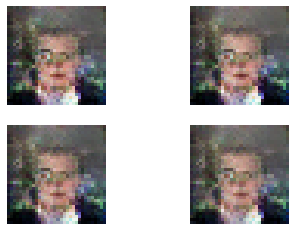

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_men_model_1000.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 2)

here is the main function 
enter F to generate Females photo 
and enter M to generate Men photo


enter F for FEMALE  and M for male F


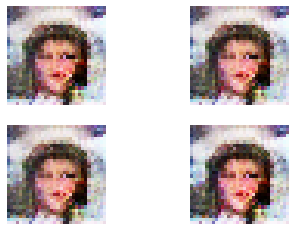

In [ ]:
take_user_input = input('enter F for FEMALE  and M for male ')
if take_user_input == 'F':
    model = load_model('generator_Female_model_1000.h5')
    # generate images
    latent_points = generate_latent_points(100, 100)
    # generate images
    X = model.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot the result
    create_plot(X, 2)
elif take_user_input == 'M':
    model = load_model('generator_men_model_1000.h5')
    # generate images
    latent_points = generate_latent_points(100, 100)
    # generate images
    X = model.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot the result
    create_plot(X, 2)
else:
    print('invalid input')